In [1]:
!mkdir result
!mkdir images
!mkdir images/misclassified

In [2]:
import os
import numpy as np
import threading as th
import tensorflow as tf
import keras.backend as K
import matplotlib.pyplot as plt
import sklearn.metrics as metric
from keras import models, layers
from keras.utils import image_dataset_from_directory as IDFD
from sklearn.metrics import ConfusionMatrixDisplay as CMD, classification_report

from keras.applications import (MobileNetV2)

2024-02-24 13:56:44.383389: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-24 13:56:44.383491: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-24 13:56:44.497279: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
# test for GPU use in tensorflow
physical_gpus = tf.config.list_physical_devices('GPU')
print(physical_gpus)

# define variables and constants
IMAGE_SIZE = (176, 208)
BATCH_SIZE = 32
EPOCHS = 30

BASE_DIR = './'
IMAGE_DIR = BASE_DIR + 'images/'
MODEL_DIR = BASE_DIR + 'models/'
RESULTS_DIR = BASE_DIR + 'result/'
DATASET_DIR = "/kaggle/input/Alzheimer_s Dataset/"
USE_CPU = False

if USE_CPU:
    tf.config.set_visible_devices([], 'GPU')

print("Tensorflow version", tf.__version__)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Tensorflow version 2.15.0


In [4]:
class_names = [filename for filename in os.listdir(DATASET_DIR+'train')]
class_names

['ModerateDemented', 'NonDemented', 'VeryMildDemented', 'MildDemented']

In [5]:
def load(directory, image_size, batch_size, verbose=False):
    class_names = ["Mild_Demented", "Moderate_Demented", "Non_Demented", "Very_Mild_Demented"]
    train_ds = IDFD(directory+"train",
                    seed=7891,
                    validation_split=0.13,
                    subset="training",
                    labels="inferred",
                    label_mode="categorical",
                    interpolation="bilinear",
                    image_size=image_size,
                    batch_size=batch_size,
                    color_mode='rgb')

    test_ds = IDFD(directory+"train",
                   seed=7891,
                   validation_split=0.13,
                   subset="validation",
                   labels="inferred",
                   label_mode="categorical",
                   interpolation="bilinear",
                   image_size=image_size,
                   batch_size=batch_size,
                   color_mode='rgb')

    val_ds = IDFD(directory+"test",
                  seed=7891,
                  labels="inferred",
                  label_mode="categorical",
                  interpolation="bilinear",
                  image_size=image_size,
                  batch_size=batch_size,
                  color_mode='rgb',
                  shuffle=False)

    if verbose:
        train = np.concatenate([np.argmax(l,axis=1) for x,l in train_ds], axis=0)
        val = np.concatenate([np.argmax(l,axis=1) for x,l in val_ds], axis=0)
        test = np.concatenate([np.argmax(l,axis=1) for x,l in test_ds], axis=0)

        print()
        print("Summary:")
        print("--------------------------------")
        print()
        print("Dataset Classes: ", class_names)
        print()
        print("Dataset split:")
        print("--------------------------------")
        print("Using ", len(train), " files for training")
        print("Using ", len(val), " files for validation")
        print("Using ", len(test), " files for testing")
        print()
        print("Images per label in each set:")
        print("--------------------------------")

        print("Training: ")
        for i,c in enumerate(class_names):
            print("   ", np.count_nonzero(train==i), c)

        print("Validation: ")
        for i,c in enumerate(class_names):
            print("   ", np.count_nonzero(val==i), c)

        print("Test: ")
        for i,c in enumerate(class_names):
            print("   ", np.count_nonzero(test==i), c)

        # show sample images
        plt.figure(figsize=(10, 10))
        for images, labels in train_ds.take(1):
            for i in range(9):
                ax = plt.subplot(3, 3, i + 1)
                plt.imshow(images[i].numpy().astype("uint8"))
                plt.title(class_names[np.argmax(labels[i])])
                plt.axis("off")

    return train_ds, val_ds, test_ds, class_names

In [6]:
# plot loss and accuracy graphics

def draw_loss_acc_graphics(outfile, history):
    acc = history.history['accuracy']
    loss = history.history['loss']
    val_acc = history.history['val_accuracy']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc)+1)

    plt.figure()
    plt.plot(epochs, acc, 'b', label='Training acc')
    plt.plot(epochs, val_acc, 'c', label='Validation acc')
    plt.title("Training and Validation Accuracy")
    plt.legend()
    plt.savefig(outfile + '_accuracy_graph.pdf')
    plt.close()

    plt.figure()
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'c', label='Validation loss')
    plt.title("Training and Validation Loss")
    plt.legend()
    plt.savefig(outfile + '_loss_graph.pdf')
    plt.close()

# evaluate model with test set

def process_tests(model, test_ds):
    y_true = np.array([], dtype=np.int32)
    y_pred = np.array([], dtype=np.int32)
    images = []

    for image_batch, labels in test_ds:
        y_true = np.concatenate([y_true, np.argmax(labels.numpy(), axis=-1)])
        y_pred = np.concatenate([y_pred, np.argmax(model.predict(image_batch,verbose=0), axis=-1)])
        for img in image_batch:
            images.append(img)

    size_test = sum([len(l) for _,l in test_ds])
    images = np.reshape(images, (size_test,176,208,3))

    return y_true, y_pred, images

def draw_confusion_matrix(outfile, model, test_ds, class_names):

    # plot confusion matrix
    y_true, y_pred, images = process_tests(model, test_ds)
    plt.figure(figsize=(5, 5))
    cmap = plt.cm.Blues #'viridis'

    # save confusion matrix with classification percentage
    cm = CMD.from_predictions(y_true, y_pred, cmap=cmap, labels=range(len(class_names)),
                              display_labels=class_names, normalize="pred")
    #plt.tight_layout()
    ax = plt.gca()
    plt.setp(ax.yaxis.get_majorticklabels(), rotation=90, ha="center", rotation_mode="anchor")
    plt.savefig(outfile + '_cm.pdf')

    # save confusion matrix with number of samples
    cm = CMD.from_predictions(y_true, y_pred, cmap=cmap,
                              labels=range(len(class_names)),display_labels=class_names)
    plt.savefig(outfile + '_cm2.pdf')
    plt.close()

    # calculate accuracy, precision, recall and F1-score
    accuracy = metric.accuracy_score(y_true, y_pred)
    precision = metric.precision_score(y_true, y_pred, average="macro", zero_division=1)
    recall = metric.recall_score(y_true, y_pred, average="macro")
    f1 = metric.f1_score(y_true, y_pred, average="macro", zero_division=1)
    print('Accuracy | Precision | Recall | F1 score')
    print(accuracy, precision, recall, f1)
    print(metric.precision_recall_fscore_support(y_true, y_pred, average="macro"))

    report = classification_report(
        y_true, y_pred, labels=range(len(class_names)),
        target_names=class_names
    )
    print(report)

    return precision, recall, f1, report

In [7]:
def save_misclassified_images(outfile, model, test_ds, class_names, n_images=3):

    # save incorrectly classified test images
    y_true, y_pred, images = process_tests(model, test_ds)

    a = np.array(y_true) == np.array(y_pred)
    plt.figure()
    ax=plt.gca()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    j=0
    for i in range(len(a)):
        if not a[i] and j<n_images:
            j=j+1
            plt.imshow(np.array(images[i]).astype("uint8"))
            plt.title(class_names[y_true[i]] + " - " + class_names[y_pred[i]])
            plt.savefig(outfile + '_misclassified_' + str(j) + '.pdf')
    plt.close()

def save_results(filename, model, train_ds, val_ds,
                 test_ds, class_names, history):
    # loss-accuracy graphics
    draw_loss_acc_graphics(IMAGE_DIR+filename, history)

    # confusion matrix
    precision, recall, f1, report = draw_confusion_matrix(IMAGE_DIR+filename, model, test_ds, class_names)

    # misclassified images
    save_misclassified_images(IMAGE_DIR+'misclassified/'+filename, model, test_ds, class_names)

    # save results to file
    train_loss, train_acc = model.evaluate(train_ds)
    val_loss, val_acc     = model.evaluate(val_ds)
    test_loss, test_acc   = model.evaluate(test_ds)

    with open(RESULTS_DIR+filename+'.txt', 'w') as f:
        f.write("Training loss/accuracy: " + str(train_loss) + ', ' + str(train_acc) + '\n')
        f.write("Validate loss/accuracy: " + str(val_loss) + ', ' + str(val_acc) + '\n')
        f.write("Testing  loss/accuracy: " + str(test_loss) + ', ' + str(test_acc) + '\n')
        f.write("Precision: " + str(precision) + '\n')
        f.write("Recall: " + str(recall) + '\n')
        f.write("F1: " + str(f1) + '\n')
        f.write(report + '\n')


In [8]:
# this module creates objects of the different models

def build_cnn_model(model, num_classes,
                    transfer_learning, batch_size):
    weights = None
    trainable = True
    include_top = True
    
    if transfer_learning:
        weights = "imagenet"
        trainable = False
        include_top = False


    model.add(MobileNetV2(weights=weights, include_top=include_top,
                                 input_shape=(176,208,3),classes=num_classes))


    model.layers[-1].trainable = trainable

    return model


def create_model(num_classes, data_augmentation, transfer_learning, batch_size=32):
    # base model
    model = models.Sequential()
    model.add(layers.Input(shape=(176,208,3)))

    # data augmentation
    if data_augmentation:
        model.add(layers.RandomFlip("horizontal"))
        model.add(layers.RandomRotation(0.1, fill_mode='constant',fill_value=-1.0))
        model.add(layers.RandomZoom((-0.2,0.2), fill_mode='constant',fill_value=-1.0))

    model = build_cnn_model(model, num_classes,
                            transfer_learning, batch_size)

    # MLP on top
    if transfer_learning:
        model.add(layers.Flatten())
        model.add(layers.Dropout(0.5))
        model.add(layers.Dense(num_classes, activation='softmax'))

    model.compile(loss="categorical_crossentropy",
                  optimizer="adam", metrics=["accuracy"])

    return model

In [9]:
def run_experiments(train_ds, val_ds, test_ds, class_names,
                    epochs, s="", data_augmentation=False, transfer_learning=False):
    
    model = create_model(len(class_names), data_augmentation, transfer_learning, BATCH_SIZE)

    model.summary()

    history = model.fit(train_ds,
                        epochs=epochs,
                        validation_data=val_ds,
                        verbose=1)

    model.save("MobileNetV2"+s+".keras")
    

    # save model to disk
    filename = "MobileNetV2" + '_' + s

    # save results and graphics to disk
    save_results(filename, model, train_ds,
                 val_ds, test_ds, class_names, history)
        

def experiments_with_dataset(train_ds, val_ds, test_ds, class_names):

    print("Number of classes", len(class_names))

    # training from scratch
    print('  ## training from scratch')
    run_experiments(train_ds, val_ds, test_ds, class_names, EPOCHS, 
                    s="_scratch", data_augmentation=False, transfer_learning=False)

    # using data augmentation
    print('  ## training with data augmentation')
    run_experiments(train_ds, val_ds, test_ds, class_names, EPOCHS,
                    s="_da", data_augmentation=True, transfer_learning=False)

    # using transfer learning
    print('  ## training with transfer learning')
    run_experiments(train_ds, val_ds, test_ds, class_names, EPOCHS,
                    s="_tl", data_augmentation=False, transfer_learning=True)
            
    # using transfer learning and data augmentation
    print('  ## training with transfer learning and data augmentation')
    run_experiments(train_ds, val_ds, test_ds, class_names, EPOCHS, 
                    s="_datl", data_augmentation=True, transfer_learning=True)



Processing Alzihmers Dataset:
--------------------------------


Found 5121 files belonging to 4 classes.


Using 4456 files for training.


Found 5121 files belonging to 4 classes.


Using 665 files for validation.


Found 1279 files belonging to 4 classes.


Number of classes 4
  ## training from scratch


Model: "sequential"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 mobilenetv2_1.00_176 (Func  (None, 4)                 2263108   


 tional)                                                         


Total params: 2263108 (8.63 MB)


Trainable params: 2228996 (8.50 MB)


Non-trainable params: 34112 (133.25 KB)


_________________________________________________________________


Epoch 1/30


I0000 00:00:1708783038.013474      76 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


  1/140 [..............................] - ETA: 1:04:09 - loss: 1.2546 - accuracy: 0.6250

  2/140 [..............................] - ETA: 10s - loss: 1.3271 - accuracy: 0.4844    

  3/140 [..............................] - ETA: 10s - loss: 1.2685 - accuracy: 0.4792

  4/140 [..............................] - ETA: 9s - loss: 1.1813 - accuracy: 0.4844 

  5/140 [>.............................] - ETA: 9s - loss: 1.1233 - accuracy: 0.5000

  6/140 [>.............................] - ETA: 9s - loss: 1.0829 - accuracy: 0.5156

  7/140 [>.............................] - ETA: 9s - loss: 1.1522 - accuracy: 0.4955

  8/140 [>.............................] - ETA: 9s - loss: 1.1501 - accuracy: 0.4883

  9/140 [>.............................] - ETA: 9s - loss: 1.1853 - accuracy: 0.4688

 10/140 [=>............................] - ETA: 9s - loss: 1.1966 - accuracy: 0.4688

 11/140 [=>............................] - ETA: 8s - loss: 1.1815 - accuracy: 0.4773

 12/140 [=>............................] - ETA: 8s - loss: 1.1859 - accuracy: 0.4844

 13/140 [=>............................] - ETA: 8s - loss: 1.1724 - accuracy: 0.4928

 14/140 [==>...........................] - ETA: 8s - loss: 1.1783 - accuracy: 0.4933

 15/140 [==>...........................] - ETA: 8s - loss: 1.1697 - accuracy: 0.5021

 16/140 [==>...........................] - ETA: 8s - loss: 1.1724 - accuracy: 0.5000

 17/140 [==>...........................] - ETA: 8s - loss: 1.1798 - accuracy: 0.5000

 18/140 [==>...........................] - ETA: 8s - loss: 1.1735 - accuracy: 0.5035

 19/140 [===>..........................] - ETA: 8s - loss: 1.1707 - accuracy: 0.5000

 20/140 [===>..........................] - ETA: 8s - loss: 1.1712 - accuracy: 0.4938

 21/140 [===>..........................] - ETA: 8s - loss: 1.1679 - accuracy: 0.4881

 22/140 [===>..........................] - ETA: 8s - loss: 1.1648 - accuracy: 0.4844

 23/140 [===>..........................] - ETA: 8s - loss: 1.1569 - accuracy: 0.4864

 24/140 [====>.........................] - ETA: 7s - loss: 1.1511 - accuracy: 0.4831

 25/140 [====>.........................] - ETA: 7s - loss: 1.1457 - accuracy: 0.4850

 26/140 [====>.........................] - ETA: 7s - loss: 1.1506 - accuracy: 0.4772

 27/140 [====>.........................] - ETA: 7s - loss: 1.1434 - accuracy: 0.4792

 28/140 [=====>........................] - ETA: 7s - loss: 1.1391 - accuracy: 0.4766

 29/140 [=====>........................] - ETA: 7s - loss: 1.1344 - accuracy: 0.4784

 30/140 [=====>........................] - ETA: 7s - loss: 1.1292 - accuracy: 0.4812

 31/140 [=====>........................] - ETA: 7s - loss: 1.1181 - accuracy: 0.4899

 32/140 [=====>........................] - ETA: 7s - loss: 1.1189 - accuracy: 0.4893

 33/140 [======>.......................] - ETA: 7s - loss: 1.1154 - accuracy: 0.4915

 34/140 [======>.......................] - ETA: 7s - loss: 1.1196 - accuracy: 0.4871

 35/140 [======>.......................] - ETA: 7s - loss: 1.1280 - accuracy: 0.4866

 36/140 [======>.......................] - ETA: 7s - loss: 1.1249 - accuracy: 0.4887

 37/140 [======>.......................] - ETA: 7s - loss: 1.1232 - accuracy: 0.4899

 38/140 [=======>......................] - ETA: 6s - loss: 1.1223 - accuracy: 0.4893

 39/140 [=======>......................] - ETA: 6s - loss: 1.1284 - accuracy: 0.4896

 40/140 [=======>......................] - ETA: 6s - loss: 1.1301 - accuracy: 0.4875

 41/140 [=======>......................] - ETA: 6s - loss: 1.1266 - accuracy: 0.4878

 42/140 [========>.....................] - ETA: 6s - loss: 1.1236 - accuracy: 0.4888

 43/140 [========>.....................] - ETA: 6s - loss: 1.1198 - accuracy: 0.4906

 44/140 [========>.....................] - ETA: 6s - loss: 1.1144 - accuracy: 0.4922

 45/140 [========>.....................] - ETA: 6s - loss: 1.1158 - accuracy: 0.4924

 46/140 [========>.....................] - ETA: 6s - loss: 1.1168 - accuracy: 0.4939

 47/140 [=========>....................] - ETA: 6s - loss: 1.1142 - accuracy: 0.4953

 48/140 [=========>....................] - ETA: 6s - loss: 1.1091 - accuracy: 0.4948

 49/140 [=========>....................] - ETA: 6s - loss: 1.1099 - accuracy: 0.4936

 50/140 [=========>....................] - ETA: 6s - loss: 1.1059 - accuracy: 0.4950

 51/140 [=========>....................] - ETA: 6s - loss: 1.1032 - accuracy: 0.4969

 52/140 [==========>...................] - ETA: 6s - loss: 1.0983 - accuracy: 0.4994

 53/140 [==========>...................] - ETA: 5s - loss: 1.0913 - accuracy: 0.5024

 54/140 [==========>...................] - ETA: 5s - loss: 1.0878 - accuracy: 0.5041

 55/140 [==========>...................] - ETA: 5s - loss: 1.0851 - accuracy: 0.5045

 56/140 [===========>..................] - ETA: 5s - loss: 1.0819 - accuracy: 0.5067

 57/140 [===========>..................] - ETA: 5s - loss: 1.0784 - accuracy: 0.5088

 58/140 [===========>..................] - ETA: 5s - loss: 1.0757 - accuracy: 0.5097

 59/140 [===========>..................] - ETA: 5s - loss: 1.0793 - accuracy: 0.5090

 60/140 [===========>..................] - ETA: 5s - loss: 1.0790 - accuracy: 0.5083

 61/140 [============>.................] - ETA: 5s - loss: 1.0752 - accuracy: 0.5092

 62/140 [============>.................] - ETA: 5s - loss: 1.0725 - accuracy: 0.5106

 63/140 [============>.................] - ETA: 5s - loss: 1.0708 - accuracy: 0.5124

 64/140 [============>.................] - ETA: 5s - loss: 1.0689 - accuracy: 0.5117

 65/140 [============>.................] - ETA: 5s - loss: 1.0697 - accuracy: 0.5130

 66/140 [=============>................] - ETA: 5s - loss: 1.0684 - accuracy: 0.5128

 67/140 [=============>................] - ETA: 4s - loss: 1.0679 - accuracy: 0.5135

 68/140 [=============>................] - ETA: 4s - loss: 1.0754 - accuracy: 0.5097

 69/140 [=============>................] - ETA: 4s - loss: 1.0729 - accuracy: 0.5095

 70/140 [==============>...............] - ETA: 4s - loss: 1.0704 - accuracy: 0.5098

 71/140 [==============>...............] - ETA: 4s - loss: 1.0719 - accuracy: 0.5066

 72/140 [==============>...............] - ETA: 4s - loss: 1.0698 - accuracy: 0.5078

 73/140 [==============>...............] - ETA: 4s - loss: 1.0632 - accuracy: 0.5128

 74/140 [==============>...............] - ETA: 4s - loss: 1.0605 - accuracy: 0.5139

 75/140 [===============>..............] - ETA: 4s - loss: 1.0613 - accuracy: 0.5142

 76/140 [===============>..............] - ETA: 4s - loss: 1.0657 - accuracy: 0.5123

 77/140 [===============>..............] - ETA: 4s - loss: 1.0635 - accuracy: 0.5134

 78/140 [===============>..............] - ETA: 4s - loss: 1.0619 - accuracy: 0.5132

 79/140 [===============>..............] - ETA: 4s - loss: 1.0648 - accuracy: 0.5103

 80/140 [================>.............] - ETA: 4s - loss: 1.0620 - accuracy: 0.5117

 81/140 [================>.............] - ETA: 4s - loss: 1.0601 - accuracy: 0.5127

 82/140 [================>.............] - ETA: 3s - loss: 1.0593 - accuracy: 0.5126

 83/140 [================>.............] - ETA: 3s - loss: 1.0582 - accuracy: 0.5132

 84/140 [=================>............] - ETA: 3s - loss: 1.0609 - accuracy: 0.5119

 85/140 [=================>............] - ETA: 3s - loss: 1.0605 - accuracy: 0.5121

 86/140 [=================>............] - ETA: 3s - loss: 1.0585 - accuracy: 0.5134

 87/140 [=================>............] - ETA: 3s - loss: 1.0570 - accuracy: 0.5144

 88/140 [=================>............] - ETA: 3s - loss: 1.0569 - accuracy: 0.5149

 89/140 [==================>...........] - ETA: 3s - loss: 1.0576 - accuracy: 0.5144

 90/140 [==================>...........] - ETA: 3s - loss: 1.0569 - accuracy: 0.5149

 91/140 [==================>...........] - ETA: 3s - loss: 1.0549 - accuracy: 0.5158

 92/140 [==================>...........] - ETA: 3s - loss: 1.0534 - accuracy: 0.5163

 93/140 [==================>...........] - ETA: 3s - loss: 1.0512 - accuracy: 0.5168

 94/140 [===================>..........] - ETA: 3s - loss: 1.0495 - accuracy: 0.5163

 95/140 [===================>..........] - ETA: 3s - loss: 1.0485 - accuracy: 0.5164

 96/140 [===================>..........] - ETA: 2s - loss: 1.0458 - accuracy: 0.5166

 97/140 [===================>..........] - ETA: 2s - loss: 1.0434 - accuracy: 0.5168

 98/140 [====================>.........] - ETA: 2s - loss: 1.0449 - accuracy: 0.5150

 99/140 [====================>.........] - ETA: 2s - loss: 1.0410 - accuracy: 0.5180

100/140 [====================>.........] - ETA: 2s - loss: 1.0402 - accuracy: 0.5181

101/140 [====================>.........] - ETA: 2s - loss: 1.0389 - accuracy: 0.5179

102/140 [====================>.........] - ETA: 2s - loss: 1.0386 - accuracy: 0.5181

103/140 [=====================>........] - ETA: 2s - loss: 1.0358 - accuracy: 0.5194

104/140 [=====================>........] - ETA: 2s - loss: 1.0348 - accuracy: 0.5210

105/140 [=====================>........] - ETA: 2s - loss: 1.0340 - accuracy: 0.5211

106/140 [=====================>........] - ETA: 2s - loss: 1.0320 - accuracy: 0.5209

107/140 [=====================>........] - ETA: 2s - loss: 1.0298 - accuracy: 0.5222

108/140 [======================>.......] - ETA: 2s - loss: 1.0293 - accuracy: 0.5220

109/140 [======================>.......] - ETA: 2s - loss: 1.0285 - accuracy: 0.5226

110/140 [======================>.......] - ETA: 2s - loss: 1.0285 - accuracy: 0.5219

111/140 [======================>.......] - ETA: 1s - loss: 1.0275 - accuracy: 0.5206

112/140 [=======================>......] - ETA: 1s - loss: 1.0268 - accuracy: 0.5204

113/140 [=======================>......] - ETA: 1s - loss: 1.0241 - accuracy: 0.5221

114/140 [=======================>......] - ETA: 1s - loss: 1.0238 - accuracy: 0.5211

115/140 [=======================>......] - ETA: 1s - loss: 1.0230 - accuracy: 0.5207

116/140 [=======================>......] - ETA: 1s - loss: 1.0222 - accuracy: 0.5197

117/140 [========================>.....] - ETA: 1s - loss: 1.0224 - accuracy: 0.5203

118/140 [========================>.....] - ETA: 1s - loss: 1.0200 - accuracy: 0.5212

119/140 [========================>.....] - ETA: 1s - loss: 1.0177 - accuracy: 0.5223

120/140 [========================>.....] - ETA: 1s - loss: 1.0184 - accuracy: 0.5221

121/140 [========================>.....] - ETA: 1s - loss: 1.0170 - accuracy: 0.5225

122/140 [=========================>....] - ETA: 1s - loss: 1.0156 - accuracy: 0.5225

123/140 [=========================>....] - ETA: 1s - loss: 1.0136 - accuracy: 0.5239

124/140 [=========================>....] - ETA: 1s - loss: 1.0143 - accuracy: 0.5244

125/140 [=========================>....] - ETA: 1s - loss: 1.0135 - accuracy: 0.5235

126/140 [==========================>...] - ETA: 0s - loss: 1.0113 - accuracy: 0.5250

127/140 [==========================>...] - ETA: 0s - loss: 1.0111 - accuracy: 0.5253

128/140 [==========================>...] - ETA: 0s - loss: 1.0098 - accuracy: 0.5271

129/140 [==========================>...] - ETA: 0s - loss: 1.0083 - accuracy: 0.5276

130/140 [==========================>...] - ETA: 0s - loss: 1.0078 - accuracy: 0.5274

131/140 [===========================>..] - ETA: 0s - loss: 1.0065 - accuracy: 0.5279

132/140 [===========================>..] - ETA: 0s - loss: 1.0071 - accuracy: 0.5284

133/140 [===========================>..] - ETA: 0s - loss: 1.0061 - accuracy: 0.5287

134/140 [===========================>..] - ETA: 0s - loss: 1.0043 - accuracy: 0.5294

135/140 [===========================>..] - ETA: 0s - loss: 1.0028 - accuracy: 0.5308

136/140 [============================>.] - ETA: 0s - loss: 1.0027 - accuracy: 0.5306

137/140 [============================>.] - ETA: 0s - loss: 1.0014 - accuracy: 0.5317

138/140 [============================>.] - ETA: 0s - loss: 1.0015 - accuracy: 0.5319

139/140 [============================>.] - ETA: 0s - loss: 1.0001 - accuracy: 0.5330

140/140 [==============================] - ETA: 0s - loss: 0.9997 - accuracy: 0.5330

140/140 [==============================] - 41s 98ms/step - loss: 0.9997 - accuracy: 0.5330 - val_loss: 1.2110 - val_accuracy: 0.5004


Epoch 2/30


  1/140 [..............................] - ETA: 29s - loss: 0.8253 - accuracy: 0.6875

  2/140 [..............................] - ETA: 9s - loss: 0.7839 - accuracy: 0.6562 

  3/140 [..............................] - ETA: 9s - loss: 0.8092 - accuracy: 0.6667

  4/140 [..............................] - ETA: 9s - loss: 0.8181 - accuracy: 0.6406

  5/140 [>.............................] - ETA: 8s - loss: 0.8619 - accuracy: 0.6062

  6/140 [>.............................] - ETA: 8s - loss: 0.9283 - accuracy: 0.5781

  7/140 [>.............................] - ETA: 8s - loss: 0.9131 - accuracy: 0.5625

  8/140 [>.............................] - ETA: 8s - loss: 0.9020 - accuracy: 0.5586

  9/140 [>.............................] - ETA: 8s - loss: 0.8919 - accuracy: 0.5694

 10/140 [=>............................] - ETA: 8s - loss: 0.9058 - accuracy: 0.5625

 11/140 [=>............................] - ETA: 8s - loss: 0.8977 - accuracy: 0.5653

 12/140 [=>............................] - ETA: 8s - loss: 0.8883 - accuracy: 0.5781

 13/140 [=>............................] - ETA: 8s - loss: 0.8982 - accuracy: 0.5793

 14/140 [==>...........................] - ETA: 8s - loss: 0.8940 - accuracy: 0.5804

 15/140 [==>...........................] - ETA: 8s - loss: 0.8930 - accuracy: 0.5792

 16/140 [==>...........................] - ETA: 8s - loss: 0.8839 - accuracy: 0.5840

 17/140 [==>...........................] - ETA: 8s - loss: 0.8729 - accuracy: 0.5956

 18/140 [==>...........................] - ETA: 8s - loss: 0.8751 - accuracy: 0.5903

 19/140 [===>..........................] - ETA: 8s - loss: 0.8828 - accuracy: 0.5888

 20/140 [===>..........................] - ETA: 8s - loss: 0.8805 - accuracy: 0.5922

 21/140 [===>..........................] - ETA: 7s - loss: 0.8738 - accuracy: 0.5967

 22/140 [===>..........................] - ETA: 7s - loss: 0.8664 - accuracy: 0.6009

 23/140 [===>..........................] - ETA: 7s - loss: 0.8681 - accuracy: 0.5965

 24/140 [====>.........................] - ETA: 7s - loss: 0.8650 - accuracy: 0.5990

 25/140 [====>.........................] - ETA: 7s - loss: 0.8679 - accuracy: 0.5975

 26/140 [====>.........................] - ETA: 7s - loss: 0.8677 - accuracy: 0.5925

 27/140 [====>.........................] - ETA: 7s - loss: 0.8669 - accuracy: 0.5903

 28/140 [=====>........................] - ETA: 7s - loss: 0.8644 - accuracy: 0.5949

 29/140 [=====>........................] - ETA: 7s - loss: 0.8632 - accuracy: 0.5959

 30/140 [=====>........................] - ETA: 7s - loss: 0.8604 - accuracy: 0.5969

 31/140 [=====>........................] - ETA: 7s - loss: 0.8666 - accuracy: 0.5938

 32/140 [=====>........................] - ETA: 7s - loss: 0.8710 - accuracy: 0.5918

 33/140 [======>.......................] - ETA: 7s - loss: 0.8684 - accuracy: 0.5938

 34/140 [======>.......................] - ETA: 7s - loss: 0.8733 - accuracy: 0.5919

 35/140 [======>.......................] - ETA: 7s - loss: 0.8707 - accuracy: 0.5955

 36/140 [======>.......................] - ETA: 6s - loss: 0.8688 - accuracy: 0.5972

 37/140 [======>.......................] - ETA: 6s - loss: 0.8647 - accuracy: 0.6005

 38/140 [=======>......................] - ETA: 6s - loss: 0.8613 - accuracy: 0.6020

 39/140 [=======>......................] - ETA: 6s - loss: 0.8657 - accuracy: 0.6018

 40/140 [=======>......................] - ETA: 6s - loss: 0.8624 - accuracy: 0.6023

 41/140 [=======>......................] - ETA: 6s - loss: 0.8605 - accuracy: 0.6006

 42/140 [========>.....................] - ETA: 6s - loss: 0.8647 - accuracy: 0.5975

 43/140 [========>.....................] - ETA: 6s - loss: 0.8622 - accuracy: 0.5981

 44/140 [========>.....................] - ETA: 6s - loss: 0.8577 - accuracy: 0.5994

 45/140 [========>.....................] - ETA: 6s - loss: 0.8608 - accuracy: 0.5993

 46/140 [========>.....................] - ETA: 6s - loss: 0.8562 - accuracy: 0.6012

 47/140 [=========>....................] - ETA: 6s - loss: 0.8544 - accuracy: 0.6044

 48/140 [=========>....................] - ETA: 6s - loss: 0.8570 - accuracy: 0.6055

 49/140 [=========>....................] - ETA: 6s - loss: 0.8554 - accuracy: 0.6059

 50/140 [=========>....................] - ETA: 6s - loss: 0.8554 - accuracy: 0.6050

 51/140 [=========>....................] - ETA: 5s - loss: 0.8535 - accuracy: 0.6060

 52/140 [==========>...................] - ETA: 5s - loss: 0.8547 - accuracy: 0.6058

 53/140 [==========>...................] - ETA: 5s - loss: 0.8502 - accuracy: 0.6085

 54/140 [==========>...................] - ETA: 5s - loss: 0.8471 - accuracy: 0.6094

 55/140 [==========>...................] - ETA: 5s - loss: 0.8504 - accuracy: 0.6062

 56/140 [===========>..................] - ETA: 5s - loss: 0.8487 - accuracy: 0.6066

 57/140 [===========>..................] - ETA: 5s - loss: 0.8525 - accuracy: 0.6053

 58/140 [===========>..................] - ETA: 5s - loss: 0.8493 - accuracy: 0.6056

 59/140 [===========>..................] - ETA: 5s - loss: 0.8488 - accuracy: 0.6086

 60/140 [===========>..................] - ETA: 5s - loss: 0.8454 - accuracy: 0.6120

 61/140 [============>.................] - ETA: 5s - loss: 0.8456 - accuracy: 0.6117

 62/140 [============>.................] - ETA: 5s - loss: 0.8447 - accuracy: 0.6109

 63/140 [============>.................] - ETA: 5s - loss: 0.8490 - accuracy: 0.6091

 64/140 [============>.................] - ETA: 5s - loss: 0.8481 - accuracy: 0.6099

 65/140 [============>.................] - ETA: 5s - loss: 0.8520 - accuracy: 0.6082

 66/140 [=============>................] - ETA: 4s - loss: 0.8543 - accuracy: 0.6070

 67/140 [=============>................] - ETA: 4s - loss: 0.8545 - accuracy: 0.6063

 68/140 [=============>................] - ETA: 4s - loss: 0.8545 - accuracy: 0.6071

 69/140 [=============>................] - ETA: 4s - loss: 0.8519 - accuracy: 0.6082

 70/140 [==============>...............] - ETA: 4s - loss: 0.8524 - accuracy: 0.6067

 71/140 [==============>...............] - ETA: 4s - loss: 0.8497 - accuracy: 0.6087

 72/140 [==============>...............] - ETA: 4s - loss: 0.8483 - accuracy: 0.6089

 73/140 [==============>...............] - ETA: 4s - loss: 0.8464 - accuracy: 0.6104

 74/140 [==============>...............] - ETA: 4s - loss: 0.8471 - accuracy: 0.6094

 75/140 [===============>..............] - ETA: 4s - loss: 0.8531 - accuracy: 0.6062

 76/140 [===============>..............] - ETA: 4s - loss: 0.8534 - accuracy: 0.6065

 77/140 [===============>..............] - ETA: 4s - loss: 0.8506 - accuracy: 0.6075

 78/140 [===============>..............] - ETA: 4s - loss: 0.8514 - accuracy: 0.6062

 79/140 [===============>..............] - ETA: 4s - loss: 0.8496 - accuracy: 0.6072

 80/140 [================>.............] - ETA: 4s - loss: 0.8491 - accuracy: 0.6082

 81/140 [================>.............] - ETA: 3s - loss: 0.8476 - accuracy: 0.6084

 82/140 [================>.............] - ETA: 3s - loss: 0.8458 - accuracy: 0.6090

 83/140 [================>.............] - ETA: 3s - loss: 0.8452 - accuracy: 0.6092

 84/140 [=================>............] - ETA: 3s - loss: 0.8439 - accuracy: 0.6101

 85/140 [=================>............] - ETA: 3s - loss: 0.8444 - accuracy: 0.6099

 86/140 [=================>............] - ETA: 3s - loss: 0.8459 - accuracy: 0.6090

 87/140 [=================>............] - ETA: 3s - loss: 0.8435 - accuracy: 0.6099

 88/140 [=================>............] - ETA: 3s - loss: 0.8412 - accuracy: 0.6112

 89/140 [==================>...........] - ETA: 3s - loss: 0.8419 - accuracy: 0.6120

 90/140 [==================>...........] - ETA: 3s - loss: 0.8387 - accuracy: 0.6146

 91/140 [==================>...........] - ETA: 3s - loss: 0.8381 - accuracy: 0.6150

 92/140 [==================>...........] - ETA: 3s - loss: 0.8368 - accuracy: 0.6155

 93/140 [==================>...........] - ETA: 3s - loss: 0.8364 - accuracy: 0.6156

 94/140 [===================>..........] - ETA: 3s - loss: 0.8380 - accuracy: 0.6150

 95/140 [===================>..........] - ETA: 3s - loss: 0.8363 - accuracy: 0.6158

 96/140 [===================>..........] - ETA: 2s - loss: 0.8337 - accuracy: 0.6175

 97/140 [===================>..........] - ETA: 2s - loss: 0.8343 - accuracy: 0.6169

 98/140 [====================>.........] - ETA: 2s - loss: 0.8328 - accuracy: 0.6177

 99/140 [====================>.........] - ETA: 2s - loss: 0.8343 - accuracy: 0.6165

100/140 [====================>.........] - ETA: 2s - loss: 0.8321 - accuracy: 0.6184

101/140 [====================>.........] - ETA: 2s - loss: 0.8329 - accuracy: 0.6179

102/140 [====================>.........] - ETA: 2s - loss: 0.8335 - accuracy: 0.6170

103/140 [=====================>........] - ETA: 2s - loss: 0.8342 - accuracy: 0.6162

104/140 [=====================>........] - ETA: 2s - loss: 0.8329 - accuracy: 0.6169

105/140 [=====================>........] - ETA: 2s - loss: 0.8313 - accuracy: 0.6179

106/140 [=====================>........] - ETA: 2s - loss: 0.8303 - accuracy: 0.6188

107/140 [=====================>........] - ETA: 2s - loss: 0.8282 - accuracy: 0.6206

108/140 [======================>.......] - ETA: 2s - loss: 0.8268 - accuracy: 0.6207

109/140 [======================>.......] - ETA: 2s - loss: 0.8274 - accuracy: 0.6213

110/140 [======================>.......] - ETA: 2s - loss: 0.8271 - accuracy: 0.6210

111/140 [======================>.......] - ETA: 1s - loss: 0.8320 - accuracy: 0.6202

112/140 [=======================>......] - ETA: 1s - loss: 0.8306 - accuracy: 0.6211

113/140 [=======================>......] - ETA: 1s - loss: 0.8303 - accuracy: 0.6209

114/140 [=======================>......] - ETA: 1s - loss: 0.8314 - accuracy: 0.6206

115/140 [=======================>......] - ETA: 1s - loss: 0.8311 - accuracy: 0.6215

116/140 [=======================>......] - ETA: 1s - loss: 0.8326 - accuracy: 0.6212

117/140 [========================>.....] - ETA: 1s - loss: 0.8333 - accuracy: 0.6213

118/140 [========================>.....] - ETA: 1s - loss: 0.8317 - accuracy: 0.6221

119/140 [========================>.....] - ETA: 1s - loss: 0.8318 - accuracy: 0.6216

120/140 [========================>.....] - ETA: 1s - loss: 0.8310 - accuracy: 0.6221

121/140 [========================>.....] - ETA: 1s - loss: 0.8316 - accuracy: 0.6216

122/140 [=========================>....] - ETA: 1s - loss: 0.8348 - accuracy: 0.6199

123/140 [=========================>....] - ETA: 1s - loss: 0.8327 - accuracy: 0.6212

124/140 [=========================>....] - ETA: 1s - loss: 0.8322 - accuracy: 0.6217

125/140 [=========================>....] - ETA: 1s - loss: 0.8316 - accuracy: 0.6210

126/140 [==========================>...] - ETA: 0s - loss: 0.8326 - accuracy: 0.6208

127/140 [==========================>...] - ETA: 0s - loss: 0.8303 - accuracy: 0.6216

128/140 [==========================>...] - ETA: 0s - loss: 0.8284 - accuracy: 0.6223

129/140 [==========================>...] - ETA: 0s - loss: 0.8261 - accuracy: 0.6238

130/140 [==========================>...] - ETA: 0s - loss: 0.8266 - accuracy: 0.6238

131/140 [===========================>..] - ETA: 0s - loss: 0.8277 - accuracy: 0.6238

132/140 [===========================>..] - ETA: 0s - loss: 0.8271 - accuracy: 0.6241

133/140 [===========================>..] - ETA: 0s - loss: 0.8268 - accuracy: 0.6245

134/140 [===========================>..] - ETA: 0s - loss: 0.8251 - accuracy: 0.6252

135/140 [===========================>..] - ETA: 0s - loss: 0.8223 - accuracy: 0.6266

136/140 [============================>.] - ETA: 0s - loss: 0.8237 - accuracy: 0.6261

137/140 [============================>.] - ETA: 0s - loss: 0.8240 - accuracy: 0.6261

138/140 [============================>.] - ETA: 0s - loss: 0.8239 - accuracy: 0.6259

139/140 [============================>.] - ETA: 0s - loss: 0.8226 - accuracy: 0.6257

140/140 [==============================] - 10s 73ms/step - loss: 0.8232 - accuracy: 0.6252 - val_loss: 1.1176 - val_accuracy: 0.5004


Epoch 3/30


  1/140 [..............................] - ETA: 27s - loss: 0.7057 - accuracy: 0.6875

  2/140 [..............................] - ETA: 9s - loss: 0.7523 - accuracy: 0.6562 

  3/140 [..............................] - ETA: 9s - loss: 0.8408 - accuracy: 0.6354

  4/140 [..............................] - ETA: 9s - loss: 0.8461 - accuracy: 0.6406

  5/140 [>.............................] - ETA: 9s - loss: 0.8236 - accuracy: 0.6562

  6/140 [>.............................] - ETA: 8s - loss: 0.8533 - accuracy: 0.6562

  7/140 [>.............................] - ETA: 8s - loss: 0.9036 - accuracy: 0.6339

  8/140 [>.............................] - ETA: 8s - loss: 0.9145 - accuracy: 0.6289

  9/140 [>.............................] - ETA: 8s - loss: 0.8760 - accuracy: 0.6389

 10/140 [=>............................] - ETA: 8s - loss: 0.8406 - accuracy: 0.6562

 11/140 [=>............................] - ETA: 8s - loss: 0.8432 - accuracy: 0.6449

 12/140 [=>............................] - ETA: 8s - loss: 0.8453 - accuracy: 0.6328

 13/140 [=>............................] - ETA: 8s - loss: 0.8490 - accuracy: 0.6322

 14/140 [==>...........................] - ETA: 8s - loss: 0.8408 - accuracy: 0.6317

 15/140 [==>...........................] - ETA: 8s - loss: 0.8592 - accuracy: 0.6271

 16/140 [==>...........................] - ETA: 8s - loss: 0.8554 - accuracy: 0.6230

 17/140 [==>...........................] - ETA: 8s - loss: 0.8533 - accuracy: 0.6268

 18/140 [==>...........................] - ETA: 8s - loss: 0.8386 - accuracy: 0.6285

 19/140 [===>..........................] - ETA: 8s - loss: 0.8311 - accuracy: 0.6283

 20/140 [===>..........................] - ETA: 8s - loss: 0.8321 - accuracy: 0.6297

 21/140 [===>..........................] - ETA: 7s - loss: 0.8298 - accuracy: 0.6354

 22/140 [===>..........................] - ETA: 7s - loss: 0.8270 - accuracy: 0.6364

 23/140 [===>..........................] - ETA: 7s - loss: 0.8233 - accuracy: 0.6318

 24/140 [====>.........................] - ETA: 7s - loss: 0.8158 - accuracy: 0.6380

 25/140 [====>.........................] - ETA: 7s - loss: 0.8118 - accuracy: 0.6375

 26/140 [====>.........................] - ETA: 7s - loss: 0.8100 - accuracy: 0.6418

 27/140 [====>.........................] - ETA: 7s - loss: 0.8026 - accuracy: 0.6458

 28/140 [=====>........................] - ETA: 7s - loss: 0.8052 - accuracy: 0.6462

 29/140 [=====>........................] - ETA: 7s - loss: 0.8044 - accuracy: 0.6466

 30/140 [=====>........................] - ETA: 7s - loss: 0.8057 - accuracy: 0.6458

 31/140 [=====>........................] - ETA: 7s - loss: 0.8071 - accuracy: 0.6472

 32/140 [=====>........................] - ETA: 7s - loss: 0.8079 - accuracy: 0.6475

 33/140 [======>.......................] - ETA: 7s - loss: 0.8052 - accuracy: 0.6496

 34/140 [======>.......................] - ETA: 7s - loss: 0.8000 - accuracy: 0.6526

 35/140 [======>.......................] - ETA: 6s - loss: 0.8001 - accuracy: 0.6527

 36/140 [======>.......................] - ETA: 6s - loss: 0.7942 - accuracy: 0.6562

 37/140 [======>.......................] - ETA: 6s - loss: 0.7900 - accuracy: 0.6588

 38/140 [=======>......................] - ETA: 6s - loss: 0.7854 - accuracy: 0.6595

 39/140 [=======>......................] - ETA: 6s - loss: 0.7826 - accuracy: 0.6595

 40/140 [=======>......................] - ETA: 6s - loss: 0.7758 - accuracy: 0.6617

 41/140 [=======>......................] - ETA: 6s - loss: 0.7765 - accuracy: 0.6646

 42/140 [========>.....................] - ETA: 6s - loss: 0.7766 - accuracy: 0.6667

 43/140 [========>.....................] - ETA: 6s - loss: 0.7740 - accuracy: 0.6679

 44/140 [========>.....................] - ETA: 6s - loss: 0.7752 - accuracy: 0.6648

 45/140 [========>.....................] - ETA: 6s - loss: 0.7692 - accuracy: 0.6701

 46/140 [========>.....................] - ETA: 6s - loss: 0.7638 - accuracy: 0.6726

 47/140 [=========>....................] - ETA: 6s - loss: 0.7642 - accuracy: 0.6722

 48/140 [=========>....................] - ETA: 6s - loss: 0.7669 - accuracy: 0.6699

 49/140 [=========>....................] - ETA: 6s - loss: 0.7635 - accuracy: 0.6703

 50/140 [=========>....................] - ETA: 6s - loss: 0.7592 - accuracy: 0.6731

 51/140 [=========>....................] - ETA: 5s - loss: 0.7551 - accuracy: 0.6752

 52/140 [==========>...................] - ETA: 5s - loss: 0.7569 - accuracy: 0.6767

 53/140 [==========>...................] - ETA: 5s - loss: 0.7564 - accuracy: 0.6769

 54/140 [==========>...................] - ETA: 5s - loss: 0.7572 - accuracy: 0.6782

 55/140 [==========>...................] - ETA: 5s - loss: 0.7566 - accuracy: 0.6778

 56/140 [===========>..................] - ETA: 5s - loss: 0.7529 - accuracy: 0.6808

 57/140 [===========>..................] - ETA: 5s - loss: 0.7512 - accuracy: 0.6809

 58/140 [===========>..................] - ETA: 5s - loss: 0.7482 - accuracy: 0.6827

 59/140 [===========>..................] - ETA: 5s - loss: 0.7520 - accuracy: 0.6811

 60/140 [===========>..................] - ETA: 5s - loss: 0.7516 - accuracy: 0.6823

 61/140 [============>.................] - ETA: 5s - loss: 0.7499 - accuracy: 0.6824

 62/140 [============>.................] - ETA: 5s - loss: 0.7521 - accuracy: 0.6809

 63/140 [============>.................] - ETA: 5s - loss: 0.7539 - accuracy: 0.6801

 64/140 [============>.................] - ETA: 5s - loss: 0.7562 - accuracy: 0.6792

 65/140 [============>.................] - ETA: 5s - loss: 0.7591 - accuracy: 0.6764

 66/140 [=============>................] - ETA: 4s - loss: 0.7553 - accuracy: 0.6790

 67/140 [=============>................] - ETA: 4s - loss: 0.7563 - accuracy: 0.6777

 68/140 [=============>................] - ETA: 4s - loss: 0.7540 - accuracy: 0.6783

 69/140 [=============>................] - ETA: 4s - loss: 0.7539 - accuracy: 0.6793

 70/140 [==============>...............] - ETA: 4s - loss: 0.7526 - accuracy: 0.6799

 71/140 [==============>...............] - ETA: 4s - loss: 0.7497 - accuracy: 0.6809

 72/140 [==============>...............] - ETA: 4s - loss: 0.7494 - accuracy: 0.6810

 73/140 [==============>...............] - ETA: 4s - loss: 0.7457 - accuracy: 0.6836

 74/140 [==============>...............] - ETA: 4s - loss: 0.7479 - accuracy: 0.6829

 75/140 [===============>..............] - ETA: 4s - loss: 0.7458 - accuracy: 0.6842

 76/140 [===============>..............] - ETA: 4s - loss: 0.7444 - accuracy: 0.6846

 77/140 [===============>..............] - ETA: 4s - loss: 0.7464 - accuracy: 0.6834

 78/140 [===============>..............] - ETA: 4s - loss: 0.7503 - accuracy: 0.6811

 79/140 [===============>..............] - ETA: 4s - loss: 0.7497 - accuracy: 0.6812

 80/140 [================>.............] - ETA: 4s - loss: 0.7528 - accuracy: 0.6797

 81/140 [================>.............] - ETA: 3s - loss: 0.7529 - accuracy: 0.6786

 82/140 [================>.............] - ETA: 3s - loss: 0.7516 - accuracy: 0.6787

 83/140 [================>.............] - ETA: 3s - loss: 0.7499 - accuracy: 0.6796

 84/140 [=================>............] - ETA: 3s - loss: 0.7498 - accuracy: 0.6782

 85/140 [=================>............] - ETA: 3s - loss: 0.7507 - accuracy: 0.6776

 86/140 [=================>............] - ETA: 3s - loss: 0.7488 - accuracy: 0.6781

 87/140 [=================>............] - ETA: 3s - loss: 0.7492 - accuracy: 0.6782

 88/140 [=================>............] - ETA: 3s - loss: 0.7494 - accuracy: 0.6779

 89/140 [==================>...........] - ETA: 3s - loss: 0.7489 - accuracy: 0.6784

 90/140 [==================>...........] - ETA: 3s - loss: 0.7491 - accuracy: 0.6785

 91/140 [==================>...........] - ETA: 3s - loss: 0.7500 - accuracy: 0.6789

 92/140 [==================>...........] - ETA: 3s - loss: 0.7501 - accuracy: 0.6790

 93/140 [==================>...........] - ETA: 3s - loss: 0.7473 - accuracy: 0.6808

 94/140 [===================>..........] - ETA: 3s - loss: 0.7481 - accuracy: 0.6809

 95/140 [===================>..........] - ETA: 3s - loss: 0.7475 - accuracy: 0.6806

 96/140 [===================>..........] - ETA: 2s - loss: 0.7494 - accuracy: 0.6797

 97/140 [===================>..........] - ETA: 2s - loss: 0.7473 - accuracy: 0.6804

 98/140 [====================>.........] - ETA: 2s - loss: 0.7467 - accuracy: 0.6811

 99/140 [====================>.........] - ETA: 2s - loss: 0.7457 - accuracy: 0.6806

100/140 [====================>.........] - ETA: 2s - loss: 0.7448 - accuracy: 0.6803

101/140 [====================>.........] - ETA: 2s - loss: 0.7437 - accuracy: 0.6810

102/140 [====================>.........] - ETA: 2s - loss: 0.7429 - accuracy: 0.6817

103/140 [=====================>........] - ETA: 2s - loss: 0.7430 - accuracy: 0.6811

104/140 [=====================>........] - ETA: 2s - loss: 0.7428 - accuracy: 0.6809

105/140 [=====================>........] - ETA: 2s - loss: 0.7418 - accuracy: 0.6812

106/140 [=====================>........] - ETA: 2s - loss: 0.7409 - accuracy: 0.6831

107/140 [=====================>........] - ETA: 2s - loss: 0.7401 - accuracy: 0.6825

108/140 [======================>.......] - ETA: 2s - loss: 0.7400 - accuracy: 0.6823

109/140 [======================>.......] - ETA: 2s - loss: 0.7374 - accuracy: 0.6829

110/140 [======================>.......] - ETA: 2s - loss: 0.7337 - accuracy: 0.6849

111/140 [======================>.......] - ETA: 1s - loss: 0.7361 - accuracy: 0.6844

112/140 [=======================>......] - ETA: 1s - loss: 0.7389 - accuracy: 0.6839

113/140 [=======================>......] - ETA: 1s - loss: 0.7368 - accuracy: 0.6853

114/140 [=======================>......] - ETA: 1s - loss: 0.7356 - accuracy: 0.6859

115/140 [=======================>......] - ETA: 1s - loss: 0.7342 - accuracy: 0.6864

116/140 [=======================>......] - ETA: 1s - loss: 0.7334 - accuracy: 0.6859

117/140 [========================>.....] - ETA: 1s - loss: 0.7332 - accuracy: 0.6867

118/140 [========================>.....] - ETA: 1s - loss: 0.7332 - accuracy: 0.6870

119/140 [========================>.....] - ETA: 1s - loss: 0.7341 - accuracy: 0.6859

120/140 [========================>.....] - ETA: 1s - loss: 0.7352 - accuracy: 0.6854

121/140 [========================>.....] - ETA: 1s - loss: 0.7336 - accuracy: 0.6857

122/140 [=========================>....] - ETA: 1s - loss: 0.7325 - accuracy: 0.6865

123/140 [=========================>....] - ETA: 1s - loss: 0.7306 - accuracy: 0.6878

124/140 [=========================>....] - ETA: 1s - loss: 0.7302 - accuracy: 0.6883

125/140 [=========================>....] - ETA: 1s - loss: 0.7306 - accuracy: 0.6888

126/140 [==========================>...] - ETA: 0s - loss: 0.7289 - accuracy: 0.6892

127/140 [==========================>...] - ETA: 0s - loss: 0.7287 - accuracy: 0.6892

128/140 [==========================>...] - ETA: 0s - loss: 0.7267 - accuracy: 0.6904

129/140 [==========================>...] - ETA: 0s - loss: 0.7270 - accuracy: 0.6899

130/140 [==========================>...] - ETA: 0s - loss: 0.7252 - accuracy: 0.6916

131/140 [===========================>..] - ETA: 0s - loss: 0.7232 - accuracy: 0.6925

132/140 [===========================>..] - ETA: 0s - loss: 0.7220 - accuracy: 0.6927

133/140 [===========================>..] - ETA: 0s - loss: 0.7187 - accuracy: 0.6943

134/140 [===========================>..] - ETA: 0s - loss: 0.7172 - accuracy: 0.6947

135/140 [===========================>..] - ETA: 0s - loss: 0.7166 - accuracy: 0.6947

136/140 [============================>.] - ETA: 0s - loss: 0.7171 - accuracy: 0.6946

137/140 [============================>.] - ETA: 0s - loss: 0.7154 - accuracy: 0.6953

138/140 [============================>.] - ETA: 0s - loss: 0.7162 - accuracy: 0.6950

139/140 [============================>.] - ETA: 0s - loss: 0.7160 - accuracy: 0.6956

140/140 [==============================] - 10s 73ms/step - loss: 0.7167 - accuracy: 0.6957 - val_loss: 1.3078 - val_accuracy: 0.5004


Epoch 4/30


  1/140 [..............................] - ETA: 31s - loss: 0.4358 - accuracy: 0.8438

  2/140 [..............................] - ETA: 9s - loss: 0.5106 - accuracy: 0.7812 

  3/140 [..............................] - ETA: 9s - loss: 0.5659 - accuracy: 0.7812

  4/140 [..............................] - ETA: 9s - loss: 0.5465 - accuracy: 0.8047

  5/140 [>.............................] - ETA: 9s - loss: 0.6206 - accuracy: 0.7688

  6/140 [>.............................] - ETA: 9s - loss: 0.6444 - accuracy: 0.7500

  7/140 [>.............................] - ETA: 8s - loss: 0.6146 - accuracy: 0.7589

  8/140 [>.............................] - ETA: 8s - loss: 0.5961 - accuracy: 0.7695

  9/140 [>.............................] - ETA: 8s - loss: 0.5891 - accuracy: 0.7778

 10/140 [=>............................] - ETA: 8s - loss: 0.6220 - accuracy: 0.7625

 11/140 [=>............................] - ETA: 8s - loss: 0.6079 - accuracy: 0.7699

 12/140 [=>............................] - ETA: 8s - loss: 0.6107 - accuracy: 0.7578

 13/140 [=>............................] - ETA: 8s - loss: 0.6309 - accuracy: 0.7452

 14/140 [==>...........................] - ETA: 8s - loss: 0.6275 - accuracy: 0.7411

 15/140 [==>...........................] - ETA: 8s - loss: 0.6122 - accuracy: 0.7500

 16/140 [==>...........................] - ETA: 8s - loss: 0.6101 - accuracy: 0.7500

 17/140 [==>...........................] - ETA: 8s - loss: 0.6198 - accuracy: 0.7445

 18/140 [==>...........................] - ETA: 8s - loss: 0.6177 - accuracy: 0.7413

 19/140 [===>..........................] - ETA: 8s - loss: 0.6293 - accuracy: 0.7385

 20/140 [===>..........................] - ETA: 8s - loss: 0.6337 - accuracy: 0.7359

 21/140 [===>..........................] - ETA: 7s - loss: 0.6380 - accuracy: 0.7351

 22/140 [===>..........................] - ETA: 7s - loss: 0.6346 - accuracy: 0.7315

 23/140 [===>..........................] - ETA: 7s - loss: 0.6296 - accuracy: 0.7351

 24/140 [====>.........................] - ETA: 7s - loss: 0.6362 - accuracy: 0.7279

 25/140 [====>.........................] - ETA: 7s - loss: 0.6239 - accuracy: 0.7362

 26/140 [====>.........................] - ETA: 7s - loss: 0.6160 - accuracy: 0.7428

 27/140 [====>.........................] - ETA: 7s - loss: 0.6159 - accuracy: 0.7442

 28/140 [=====>........................] - ETA: 7s - loss: 0.6236 - accuracy: 0.7400

 29/140 [=====>........................] - ETA: 7s - loss: 0.6268 - accuracy: 0.7381

 30/140 [=====>........................] - ETA: 7s - loss: 0.6306 - accuracy: 0.7365

 31/140 [=====>........................] - ETA: 7s - loss: 0.6350 - accuracy: 0.7339

 32/140 [=====>........................] - ETA: 7s - loss: 0.6413 - accuracy: 0.7324

 33/140 [======>.......................] - ETA: 7s - loss: 0.6453 - accuracy: 0.7320

 34/140 [======>.......................] - ETA: 7s - loss: 0.6455 - accuracy: 0.7316

 35/140 [======>.......................] - ETA: 7s - loss: 0.6426 - accuracy: 0.7348

 36/140 [======>.......................] - ETA: 6s - loss: 0.6395 - accuracy: 0.7344

 37/140 [======>.......................] - ETA: 6s - loss: 0.6354 - accuracy: 0.7373

 38/140 [=======>......................] - ETA: 6s - loss: 0.6412 - accuracy: 0.7327

 39/140 [=======>......................] - ETA: 6s - loss: 0.6355 - accuracy: 0.7332

 40/140 [=======>......................] - ETA: 6s - loss: 0.6398 - accuracy: 0.7320

 41/140 [=======>......................] - ETA: 6s - loss: 0.6354 - accuracy: 0.7325

 42/140 [========>.....................] - ETA: 6s - loss: 0.6298 - accuracy: 0.7344

 43/140 [========>.....................] - ETA: 6s - loss: 0.6301 - accuracy: 0.7326

 44/140 [========>.....................] - ETA: 6s - loss: 0.6265 - accuracy: 0.7337

 45/140 [========>.....................] - ETA: 6s - loss: 0.6295 - accuracy: 0.7333

 46/140 [========>.....................] - ETA: 6s - loss: 0.6314 - accuracy: 0.7344

 47/140 [=========>....................] - ETA: 6s - loss: 0.6266 - accuracy: 0.7367

 48/140 [=========>....................] - ETA: 6s - loss: 0.6240 - accuracy: 0.7383

 49/140 [=========>....................] - ETA: 6s - loss: 0.6243 - accuracy: 0.7353

 50/140 [=========>....................] - ETA: 6s - loss: 0.6276 - accuracy: 0.7337

 51/140 [=========>....................] - ETA: 5s - loss: 0.6234 - accuracy: 0.7347

 52/140 [==========>...................] - ETA: 5s - loss: 0.6199 - accuracy: 0.7368

 53/140 [==========>...................] - ETA: 5s - loss: 0.6170 - accuracy: 0.7376

 54/140 [==========>...................] - ETA: 5s - loss: 0.6125 - accuracy: 0.7396

 55/140 [==========>...................] - ETA: 5s - loss: 0.6102 - accuracy: 0.7420

 56/140 [===========>..................] - ETA: 5s - loss: 0.6088 - accuracy: 0.7427

 57/140 [===========>..................] - ETA: 5s - loss: 0.6071 - accuracy: 0.7434

 58/140 [===========>..................] - ETA: 5s - loss: 0.6079 - accuracy: 0.7430

 59/140 [===========>..................] - ETA: 5s - loss: 0.6122 - accuracy: 0.7421

 60/140 [===========>..................] - ETA: 5s - loss: 0.6100 - accuracy: 0.7427

 61/140 [============>.................] - ETA: 5s - loss: 0.6056 - accuracy: 0.7444

 62/140 [============>.................] - ETA: 5s - loss: 0.6097 - accuracy: 0.7440

 63/140 [============>.................] - ETA: 5s - loss: 0.6093 - accuracy: 0.7431

 64/140 [============>.................] - ETA: 5s - loss: 0.6112 - accuracy: 0.7437

 65/140 [============>.................] - ETA: 5s - loss: 0.6094 - accuracy: 0.7447

 66/140 [=============>................] - ETA: 4s - loss: 0.6096 - accuracy: 0.7453

 67/140 [=============>................] - ETA: 4s - loss: 0.6089 - accuracy: 0.7449

 68/140 [=============>................] - ETA: 4s - loss: 0.6065 - accuracy: 0.7459

 69/140 [=============>................] - ETA: 4s - loss: 0.6058 - accuracy: 0.7464

 70/140 [==============>...............] - ETA: 4s - loss: 0.6090 - accuracy: 0.7442

 71/140 [==============>...............] - ETA: 4s - loss: 0.6081 - accuracy: 0.7443

 72/140 [==============>...............] - ETA: 4s - loss: 0.6070 - accuracy: 0.7452

 73/140 [==============>...............] - ETA: 4s - loss: 0.6060 - accuracy: 0.7457

 74/140 [==============>...............] - ETA: 4s - loss: 0.6067 - accuracy: 0.7458

 75/140 [===============>..............] - ETA: 4s - loss: 0.6036 - accuracy: 0.7479

 76/140 [===============>..............] - ETA: 4s - loss: 0.6045 - accuracy: 0.7475

 77/140 [===============>..............] - ETA: 4s - loss: 0.6049 - accuracy: 0.7480

 78/140 [===============>..............] - ETA: 4s - loss: 0.6029 - accuracy: 0.7488

 79/140 [===============>..............] - ETA: 4s - loss: 0.6005 - accuracy: 0.7500

 80/140 [================>.............] - ETA: 4s - loss: 0.6019 - accuracy: 0.7492

 81/140 [================>.............] - ETA: 3s - loss: 0.6022 - accuracy: 0.7485

 82/140 [================>.............] - ETA: 3s - loss: 0.6020 - accuracy: 0.7481

 83/140 [================>.............] - ETA: 3s - loss: 0.6060 - accuracy: 0.7455

 84/140 [=================>............] - ETA: 3s - loss: 0.6056 - accuracy: 0.7459

 85/140 [=================>............] - ETA: 3s - loss: 0.6049 - accuracy: 0.7463

 86/140 [=================>............] - ETA: 3s - loss: 0.6024 - accuracy: 0.7475

 87/140 [=================>............] - ETA: 3s - loss: 0.6029 - accuracy: 0.7475

 88/140 [=================>............] - ETA: 3s - loss: 0.5993 - accuracy: 0.7486

 89/140 [==================>...........] - ETA: 3s - loss: 0.5978 - accuracy: 0.7493

 90/140 [==================>...........] - ETA: 3s - loss: 0.5973 - accuracy: 0.7493

 91/140 [==================>...........] - ETA: 3s - loss: 0.5966 - accuracy: 0.7493

 92/140 [==================>...........] - ETA: 3s - loss: 0.5957 - accuracy: 0.7500

 93/140 [==================>...........] - ETA: 3s - loss: 0.5947 - accuracy: 0.7497

 94/140 [===================>..........] - ETA: 3s - loss: 0.5933 - accuracy: 0.7507

 95/140 [===================>..........] - ETA: 3s - loss: 0.5925 - accuracy: 0.7516

 96/140 [===================>..........] - ETA: 2s - loss: 0.5929 - accuracy: 0.7516

 97/140 [===================>..........] - ETA: 2s - loss: 0.5903 - accuracy: 0.7532

 98/140 [====================>.........] - ETA: 2s - loss: 0.5888 - accuracy: 0.7545

 99/140 [====================>.........] - ETA: 2s - loss: 0.5857 - accuracy: 0.7554

100/140 [====================>.........] - ETA: 2s - loss: 0.5841 - accuracy: 0.7563

101/140 [====================>.........] - ETA: 2s - loss: 0.5844 - accuracy: 0.7562

102/140 [====================>.........] - ETA: 2s - loss: 0.5842 - accuracy: 0.7567

103/140 [=====================>........] - ETA: 2s - loss: 0.5827 - accuracy: 0.7573

104/140 [=====================>........] - ETA: 2s - loss: 0.5812 - accuracy: 0.7578

105/140 [=====================>........] - ETA: 2s - loss: 0.5795 - accuracy: 0.7583

106/140 [=====================>........] - ETA: 2s - loss: 0.5781 - accuracy: 0.7591

107/140 [=====================>........] - ETA: 2s - loss: 0.5795 - accuracy: 0.7591

108/140 [======================>.......] - ETA: 2s - loss: 0.5809 - accuracy: 0.7587

109/140 [======================>.......] - ETA: 2s - loss: 0.5785 - accuracy: 0.7595

110/140 [======================>.......] - ETA: 2s - loss: 0.5768 - accuracy: 0.7599

111/140 [======================>.......] - ETA: 1s - loss: 0.5747 - accuracy: 0.7613

112/140 [=======================>......] - ETA: 1s - loss: 0.5724 - accuracy: 0.7626

113/140 [=======================>......] - ETA: 1s - loss: 0.5706 - accuracy: 0.7633

114/140 [=======================>......] - ETA: 1s - loss: 0.5706 - accuracy: 0.7640

115/140 [=======================>......] - ETA: 1s - loss: 0.5703 - accuracy: 0.7639

116/140 [=======================>......] - ETA: 1s - loss: 0.5688 - accuracy: 0.7645

117/140 [========================>.....] - ETA: 1s - loss: 0.5688 - accuracy: 0.7650

118/140 [========================>.....] - ETA: 1s - loss: 0.5677 - accuracy: 0.7654

119/140 [========================>.....] - ETA: 1s - loss: 0.5661 - accuracy: 0.7660

120/140 [========================>.....] - ETA: 1s - loss: 0.5660 - accuracy: 0.7656

121/140 [========================>.....] - ETA: 1s - loss: 0.5655 - accuracy: 0.7652

122/140 [=========================>....] - ETA: 1s - loss: 0.5641 - accuracy: 0.7666

123/140 [=========================>....] - ETA: 1s - loss: 0.5619 - accuracy: 0.7673

124/140 [=========================>....] - ETA: 1s - loss: 0.5590 - accuracy: 0.7686

125/140 [=========================>....] - ETA: 1s - loss: 0.5571 - accuracy: 0.7695

126/140 [==========================>...] - ETA: 0s - loss: 0.5576 - accuracy: 0.7696

127/140 [==========================>...] - ETA: 0s - loss: 0.5583 - accuracy: 0.7697

128/140 [==========================>...] - ETA: 0s - loss: 0.5560 - accuracy: 0.7708

129/140 [==========================>...] - ETA: 0s - loss: 0.5557 - accuracy: 0.7706

130/140 [==========================>...] - ETA: 0s - loss: 0.5548 - accuracy: 0.7707

131/140 [===========================>..] - ETA: 0s - loss: 0.5528 - accuracy: 0.7715

132/140 [===========================>..] - ETA: 0s - loss: 0.5525 - accuracy: 0.7715

133/140 [===========================>..] - ETA: 0s - loss: 0.5508 - accuracy: 0.7723

134/140 [===========================>..] - ETA: 0s - loss: 0.5497 - accuracy: 0.7726

135/140 [===========================>..] - ETA: 0s - loss: 0.5482 - accuracy: 0.7729

136/140 [============================>.] - ETA: 0s - loss: 0.5457 - accuracy: 0.7744

137/140 [============================>.] - ETA: 0s - loss: 0.5464 - accuracy: 0.7742

138/140 [============================>.] - ETA: 0s - loss: 0.5467 - accuracy: 0.7738

139/140 [============================>.] - ETA: 0s - loss: 0.5459 - accuracy: 0.7738

140/140 [==============================] - 11s 74ms/step - loss: 0.5455 - accuracy: 0.7740 - val_loss: 1.9464 - val_accuracy: 0.5004


Epoch 5/30


  1/140 [..............................] - ETA: 29s - loss: 0.3112 - accuracy: 0.9062

  2/140 [..............................] - ETA: 9s - loss: 0.3233 - accuracy: 0.8906 

  3/140 [..............................] - ETA: 9s - loss: 0.4424 - accuracy: 0.8542

  4/140 [..............................] - ETA: 9s - loss: 0.4614 - accuracy: 0.8438

  5/140 [>.............................] - ETA: 9s - loss: 0.5259 - accuracy: 0.8250

  6/140 [>.............................] - ETA: 8s - loss: 0.5017 - accuracy: 0.8229

  7/140 [>.............................] - ETA: 8s - loss: 0.4900 - accuracy: 0.8214

  8/140 [>.............................] - ETA: 8s - loss: 0.4692 - accuracy: 0.8320

  9/140 [>.............................] - ETA: 8s - loss: 0.4702 - accuracy: 0.8229

 10/140 [=>............................] - ETA: 8s - loss: 0.4623 - accuracy: 0.8219

 11/140 [=>............................] - ETA: 8s - loss: 0.4528 - accuracy: 0.8239

 12/140 [=>............................] - ETA: 8s - loss: 0.4488 - accuracy: 0.8281

 13/140 [=>............................] - ETA: 8s - loss: 0.4377 - accuracy: 0.8341

 14/140 [==>...........................] - ETA: 8s - loss: 0.4299 - accuracy: 0.8393

 15/140 [==>...........................] - ETA: 8s - loss: 0.4386 - accuracy: 0.8354

 16/140 [==>...........................] - ETA: 8s - loss: 0.4348 - accuracy: 0.8340

 17/140 [==>...........................] - ETA: 8s - loss: 0.4493 - accuracy: 0.8309

 18/140 [==>...........................] - ETA: 8s - loss: 0.4359 - accuracy: 0.8385

 19/140 [===>..........................] - ETA: 8s - loss: 0.4460 - accuracy: 0.8322

 20/140 [===>..........................] - ETA: 8s - loss: 0.4383 - accuracy: 0.8328

 21/140 [===>..........................] - ETA: 7s - loss: 0.4331 - accuracy: 0.8348

 22/140 [===>..........................] - ETA: 7s - loss: 0.4316 - accuracy: 0.8366

 23/140 [===>..........................] - ETA: 7s - loss: 0.4300 - accuracy: 0.8342

 24/140 [====>.........................] - ETA: 7s - loss: 0.4325 - accuracy: 0.8359

 25/140 [====>.........................] - ETA: 7s - loss: 0.4288 - accuracy: 0.8363

 26/140 [====>.........................] - ETA: 7s - loss: 0.4302 - accuracy: 0.8365

 27/140 [====>.........................] - ETA: 7s - loss: 0.4276 - accuracy: 0.8391

 28/140 [=====>........................] - ETA: 7s - loss: 0.4352 - accuracy: 0.8359

 29/140 [=====>........................] - ETA: 7s - loss: 0.4288 - accuracy: 0.8373

 30/140 [=====>........................] - ETA: 7s - loss: 0.4239 - accuracy: 0.8396

 31/140 [=====>........................] - ETA: 7s - loss: 0.4235 - accuracy: 0.8407

 32/140 [=====>........................] - ETA: 7s - loss: 0.4202 - accuracy: 0.8408

 33/140 [======>.......................] - ETA: 7s - loss: 0.4180 - accuracy: 0.8419

 34/140 [======>.......................] - ETA: 7s - loss: 0.4130 - accuracy: 0.8438

 35/140 [======>.......................] - ETA: 7s - loss: 0.4096 - accuracy: 0.8438

 36/140 [======>.......................] - ETA: 6s - loss: 0.4189 - accuracy: 0.8420

 37/140 [======>.......................] - ETA: 6s - loss: 0.4176 - accuracy: 0.8429

 38/140 [=======>......................] - ETA: 6s - loss: 0.4136 - accuracy: 0.8429

 39/140 [=======>......................] - ETA: 6s - loss: 0.4197 - accuracy: 0.8397

 40/140 [=======>......................] - ETA: 6s - loss: 0.4195 - accuracy: 0.8398

 41/140 [=======>......................] - ETA: 6s - loss: 0.4209 - accuracy: 0.8384

 42/140 [========>.....................] - ETA: 6s - loss: 0.4165 - accuracy: 0.8393

 43/140 [========>.....................] - ETA: 6s - loss: 0.4129 - accuracy: 0.8401

 44/140 [========>.....................] - ETA: 6s - loss: 0.4215 - accuracy: 0.8359

 45/140 [========>.....................] - ETA: 6s - loss: 0.4185 - accuracy: 0.8375

 46/140 [========>.....................] - ETA: 6s - loss: 0.4241 - accuracy: 0.8342

 47/140 [=========>....................] - ETA: 6s - loss: 0.4205 - accuracy: 0.8358

 48/140 [=========>....................] - ETA: 6s - loss: 0.4182 - accuracy: 0.8359

 49/140 [=========>....................] - ETA: 6s - loss: 0.4157 - accuracy: 0.8380

 50/140 [=========>....................] - ETA: 6s - loss: 0.4158 - accuracy: 0.8375

 51/140 [=========>....................] - ETA: 5s - loss: 0.4190 - accuracy: 0.8364

 52/140 [==========>...................] - ETA: 5s - loss: 0.4196 - accuracy: 0.8353

 53/140 [==========>...................] - ETA: 5s - loss: 0.4164 - accuracy: 0.8367

 54/140 [==========>...................] - ETA: 5s - loss: 0.4129 - accuracy: 0.8385

 55/140 [==========>...................] - ETA: 5s - loss: 0.4118 - accuracy: 0.8398

 56/140 [===========>..................] - ETA: 5s - loss: 0.4101 - accuracy: 0.8393

 57/140 [===========>..................] - ETA: 5s - loss: 0.4123 - accuracy: 0.8383

 58/140 [===========>..................] - ETA: 5s - loss: 0.4154 - accuracy: 0.8373

 59/140 [===========>..................] - ETA: 5s - loss: 0.4190 - accuracy: 0.8358

 60/140 [===========>..................] - ETA: 5s - loss: 0.4170 - accuracy: 0.8370

 61/140 [============>.................] - ETA: 5s - loss: 0.4201 - accuracy: 0.8361

 62/140 [============>.................] - ETA: 5s - loss: 0.4212 - accuracy: 0.8362

 63/140 [============>.................] - ETA: 5s - loss: 0.4215 - accuracy: 0.8343

 64/140 [============>.................] - ETA: 5s - loss: 0.4192 - accuracy: 0.8354

 65/140 [============>.................] - ETA: 5s - loss: 0.4201 - accuracy: 0.8346

 66/140 [=============>................] - ETA: 4s - loss: 0.4162 - accuracy: 0.8371

 67/140 [=============>................] - ETA: 4s - loss: 0.4145 - accuracy: 0.8372

 68/140 [=============>................] - ETA: 4s - loss: 0.4125 - accuracy: 0.8387

 69/140 [=============>................] - ETA: 4s - loss: 0.4112 - accuracy: 0.8388

 70/140 [==============>...............] - ETA: 4s - loss: 0.4095 - accuracy: 0.8397

 71/140 [==============>...............] - ETA: 4s - loss: 0.4068 - accuracy: 0.8415

 72/140 [==============>...............] - ETA: 4s - loss: 0.4067 - accuracy: 0.8416

 73/140 [==============>...............] - ETA: 4s - loss: 0.4107 - accuracy: 0.8399

 74/140 [==============>...............] - ETA: 4s - loss: 0.4078 - accuracy: 0.8412

 75/140 [===============>..............] - ETA: 4s - loss: 0.4056 - accuracy: 0.8421

 76/140 [===============>..............] - ETA: 4s - loss: 0.4037 - accuracy: 0.8429

 77/140 [===============>..............] - ETA: 4s - loss: 0.4051 - accuracy: 0.8417

 78/140 [===============>..............] - ETA: 4s - loss: 0.4057 - accuracy: 0.8413

 79/140 [===============>..............] - ETA: 4s - loss: 0.4096 - accuracy: 0.8402

 80/140 [================>.............] - ETA: 4s - loss: 0.4078 - accuracy: 0.8406

 81/140 [================>.............] - ETA: 3s - loss: 0.4054 - accuracy: 0.8410

 82/140 [================>.............] - ETA: 3s - loss: 0.4043 - accuracy: 0.8418

 83/140 [================>.............] - ETA: 3s - loss: 0.4036 - accuracy: 0.8415

 84/140 [=================>............] - ETA: 3s - loss: 0.4037 - accuracy: 0.8411

 85/140 [=================>............] - ETA: 3s - loss: 0.4046 - accuracy: 0.8408

 86/140 [=================>............] - ETA: 3s - loss: 0.4044 - accuracy: 0.8412

 87/140 [=================>............] - ETA: 3s - loss: 0.4047 - accuracy: 0.8420

 88/140 [=================>............] - ETA: 3s - loss: 0.4061 - accuracy: 0.8413

 89/140 [==================>...........] - ETA: 3s - loss: 0.4051 - accuracy: 0.8420

 90/140 [==================>...........] - ETA: 3s - loss: 0.4063 - accuracy: 0.8413

 91/140 [==================>...........] - ETA: 3s - loss: 0.4052 - accuracy: 0.8417

 92/140 [==================>...........] - ETA: 3s - loss: 0.4040 - accuracy: 0.8414

 93/140 [==================>...........] - ETA: 3s - loss: 0.4027 - accuracy: 0.8417

 94/140 [===================>..........] - ETA: 3s - loss: 0.4005 - accuracy: 0.8424

 95/140 [===================>..........] - ETA: 3s - loss: 0.4008 - accuracy: 0.8418

 96/140 [===================>..........] - ETA: 2s - loss: 0.4022 - accuracy: 0.8418

 97/140 [===================>..........] - ETA: 2s - loss: 0.4030 - accuracy: 0.8412

 98/140 [====================>.........] - ETA: 2s - loss: 0.4021 - accuracy: 0.8412

 99/140 [====================>.........] - ETA: 2s - loss: 0.4021 - accuracy: 0.8409

100/140 [====================>.........] - ETA: 2s - loss: 0.4033 - accuracy: 0.8403

101/140 [====================>.........] - ETA: 2s - loss: 0.4033 - accuracy: 0.8403

102/140 [====================>.........] - ETA: 2s - loss: 0.4027 - accuracy: 0.8410

103/140 [=====================>........] - ETA: 2s - loss: 0.4017 - accuracy: 0.8416

104/140 [=====================>........] - ETA: 2s - loss: 0.4010 - accuracy: 0.8419

105/140 [=====================>........] - ETA: 2s - loss: 0.3991 - accuracy: 0.8426

106/140 [=====================>........] - ETA: 2s - loss: 0.3979 - accuracy: 0.8429

107/140 [=====================>........] - ETA: 2s - loss: 0.3976 - accuracy: 0.8423

108/140 [======================>.......] - ETA: 2s - loss: 0.3984 - accuracy: 0.8420

109/140 [======================>.......] - ETA: 2s - loss: 0.3961 - accuracy: 0.8432

110/140 [======================>.......] - ETA: 2s - loss: 0.3961 - accuracy: 0.8432

111/140 [======================>.......] - ETA: 1s - loss: 0.3973 - accuracy: 0.8429

112/140 [=======================>......] - ETA: 1s - loss: 0.3972 - accuracy: 0.8426

113/140 [=======================>......] - ETA: 1s - loss: 0.3998 - accuracy: 0.8421

114/140 [=======================>......] - ETA: 1s - loss: 0.3991 - accuracy: 0.8424

115/140 [=======================>......] - ETA: 1s - loss: 0.3980 - accuracy: 0.8429

116/140 [=======================>......] - ETA: 1s - loss: 0.3962 - accuracy: 0.8438

117/140 [========================>.....] - ETA: 1s - loss: 0.3955 - accuracy: 0.8438

118/140 [========================>.....] - ETA: 1s - loss: 0.3953 - accuracy: 0.8440

119/140 [========================>.....] - ETA: 1s - loss: 0.3946 - accuracy: 0.8443

120/140 [========================>.....] - ETA: 1s - loss: 0.3943 - accuracy: 0.8443

121/140 [========================>.....] - ETA: 1s - loss: 0.3932 - accuracy: 0.8445

122/140 [=========================>....] - ETA: 1s - loss: 0.3919 - accuracy: 0.8450

123/140 [=========================>....] - ETA: 1s - loss: 0.3901 - accuracy: 0.8458

124/140 [=========================>....] - ETA: 1s - loss: 0.3891 - accuracy: 0.8460

125/140 [=========================>....] - ETA: 1s - loss: 0.3891 - accuracy: 0.8462

126/140 [==========================>...] - ETA: 0s - loss: 0.3874 - accuracy: 0.8470

127/140 [==========================>...] - ETA: 0s - loss: 0.3867 - accuracy: 0.8477

128/140 [==========================>...] - ETA: 0s - loss: 0.3864 - accuracy: 0.8481

129/140 [==========================>...] - ETA: 0s - loss: 0.3845 - accuracy: 0.8488

130/140 [==========================>...] - ETA: 0s - loss: 0.3833 - accuracy: 0.8495

131/140 [===========================>..] - ETA: 0s - loss: 0.3814 - accuracy: 0.8504

132/140 [===========================>..] - ETA: 0s - loss: 0.3809 - accuracy: 0.8509

133/140 [===========================>..] - ETA: 0s - loss: 0.3792 - accuracy: 0.8515

134/140 [===========================>..] - ETA: 0s - loss: 0.3776 - accuracy: 0.8521

135/140 [===========================>..] - ETA: 0s - loss: 0.3777 - accuracy: 0.8521

136/140 [============================>.] - ETA: 0s - loss: 0.3768 - accuracy: 0.8523

137/140 [============================>.] - ETA: 0s - loss: 0.3747 - accuracy: 0.8533

138/140 [============================>.] - ETA: 0s - loss: 0.3747 - accuracy: 0.8537

139/140 [============================>.] - ETA: 0s - loss: 0.3760 - accuracy: 0.8534

140/140 [==============================] - 10s 74ms/step - loss: 0.3762 - accuracy: 0.8532 - val_loss: 2.9205 - val_accuracy: 0.5004


Epoch 6/30


  1/140 [..............................] - ETA: 30s - loss: 0.2622 - accuracy: 0.8750

  2/140 [..............................] - ETA: 9s - loss: 0.3590 - accuracy: 0.8594 

  3/140 [..............................] - ETA: 9s - loss: 0.3402 - accuracy: 0.8750

  4/140 [..............................] - ETA: 9s - loss: 0.3503 - accuracy: 0.8906

  5/140 [>.............................] - ETA: 9s - loss: 0.3768 - accuracy: 0.8625

  6/140 [>.............................] - ETA: 8s - loss: 0.3508 - accuracy: 0.8698

  7/140 [>.............................] - ETA: 8s - loss: 0.3480 - accuracy: 0.8750

  8/140 [>.............................] - ETA: 8s - loss: 0.3351 - accuracy: 0.8828

  9/140 [>.............................] - ETA: 8s - loss: 0.3414 - accuracy: 0.8750

 10/140 [=>............................] - ETA: 8s - loss: 0.3875 - accuracy: 0.8594

 11/140 [=>............................] - ETA: 8s - loss: 0.4165 - accuracy: 0.8523

 12/140 [=>............................] - ETA: 8s - loss: 0.3924 - accuracy: 0.8646

 13/140 [=>............................] - ETA: 8s - loss: 0.4043 - accuracy: 0.8582

 14/140 [==>...........................] - ETA: 8s - loss: 0.3893 - accuracy: 0.8616

 15/140 [==>...........................] - ETA: 8s - loss: 0.3777 - accuracy: 0.8667

 16/140 [==>...........................] - ETA: 8s - loss: 0.3749 - accuracy: 0.8652

 17/140 [==>...........................] - ETA: 8s - loss: 0.3807 - accuracy: 0.8621

 18/140 [==>...........................] - ETA: 8s - loss: 0.3854 - accuracy: 0.8611

 19/140 [===>..........................] - ETA: 8s - loss: 0.3768 - accuracy: 0.8651

 20/140 [===>..........................] - ETA: 8s - loss: 0.3687 - accuracy: 0.8687

 21/140 [===>..........................] - ETA: 7s - loss: 0.3622 - accuracy: 0.8690

 22/140 [===>..........................] - ETA: 7s - loss: 0.3543 - accuracy: 0.8736

 23/140 [===>..........................] - ETA: 7s - loss: 0.3486 - accuracy: 0.8764

 24/140 [====>.........................] - ETA: 7s - loss: 0.3452 - accuracy: 0.8776

 25/140 [====>.........................] - ETA: 7s - loss: 0.3493 - accuracy: 0.8737

 26/140 [====>.........................] - ETA: 7s - loss: 0.3425 - accuracy: 0.8762

 27/140 [====>.........................] - ETA: 7s - loss: 0.3474 - accuracy: 0.8738

 28/140 [=====>........................] - ETA: 7s - loss: 0.3405 - accuracy: 0.8772

 29/140 [=====>........................] - ETA: 7s - loss: 0.3385 - accuracy: 0.8772

 30/140 [=====>........................] - ETA: 7s - loss: 0.3380 - accuracy: 0.8771

 31/140 [=====>........................] - ETA: 7s - loss: 0.3415 - accuracy: 0.8760

 32/140 [=====>........................] - ETA: 7s - loss: 0.3392 - accuracy: 0.8770

 33/140 [======>.......................] - ETA: 7s - loss: 0.3348 - accuracy: 0.8778

 34/140 [======>.......................] - ETA: 7s - loss: 0.3323 - accuracy: 0.8787

 35/140 [======>.......................] - ETA: 6s - loss: 0.3268 - accuracy: 0.8804

 36/140 [======>.......................] - ETA: 6s - loss: 0.3226 - accuracy: 0.8811

 37/140 [======>.......................] - ETA: 6s - loss: 0.3200 - accuracy: 0.8818

 38/140 [=======>......................] - ETA: 6s - loss: 0.3199 - accuracy: 0.8824

 39/140 [=======>......................] - ETA: 6s - loss: 0.3142 - accuracy: 0.8846

 40/140 [=======>......................] - ETA: 6s - loss: 0.3129 - accuracy: 0.8844

 41/140 [=======>......................] - ETA: 6s - loss: 0.3143 - accuracy: 0.8834

 42/140 [========>.....................] - ETA: 6s - loss: 0.3110 - accuracy: 0.8839

 43/140 [========>.....................] - ETA: 6s - loss: 0.3096 - accuracy: 0.8852

 44/140 [========>.....................] - ETA: 6s - loss: 0.3110 - accuracy: 0.8842

 45/140 [========>.....................] - ETA: 6s - loss: 0.3107 - accuracy: 0.8840

 46/140 [========>.....................] - ETA: 6s - loss: 0.3085 - accuracy: 0.8845

 47/140 [=========>....................] - ETA: 6s - loss: 0.3109 - accuracy: 0.8836

 48/140 [=========>....................] - ETA: 6s - loss: 0.3114 - accuracy: 0.8822

 49/140 [=========>....................] - ETA: 6s - loss: 0.3082 - accuracy: 0.8839

 50/140 [=========>....................] - ETA: 6s - loss: 0.3058 - accuracy: 0.8850

 51/140 [=========>....................] - ETA: 5s - loss: 0.3066 - accuracy: 0.8830

 52/140 [==========>...................] - ETA: 5s - loss: 0.3053 - accuracy: 0.8828

 53/140 [==========>...................] - ETA: 5s - loss: 0.3034 - accuracy: 0.8827

 54/140 [==========>...................] - ETA: 5s - loss: 0.3019 - accuracy: 0.8831

 55/140 [==========>...................] - ETA: 5s - loss: 0.3037 - accuracy: 0.8824

 56/140 [===========>..................] - ETA: 5s - loss: 0.3053 - accuracy: 0.8828

 57/140 [===========>..................] - ETA: 5s - loss: 0.3023 - accuracy: 0.8838

 58/140 [===========>..................] - ETA: 5s - loss: 0.2990 - accuracy: 0.8858

 59/140 [===========>..................] - ETA: 5s - loss: 0.2973 - accuracy: 0.8867

 60/140 [===========>..................] - ETA: 5s - loss: 0.2941 - accuracy: 0.8880

 61/140 [============>.................] - ETA: 5s - loss: 0.2957 - accuracy: 0.8873

 62/140 [============>.................] - ETA: 5s - loss: 0.2932 - accuracy: 0.8886

 63/140 [============>.................] - ETA: 5s - loss: 0.2929 - accuracy: 0.8879

 64/140 [============>.................] - ETA: 5s - loss: 0.2905 - accuracy: 0.8887

 65/140 [============>.................] - ETA: 5s - loss: 0.2890 - accuracy: 0.8889

 66/140 [=============>................] - ETA: 4s - loss: 0.2867 - accuracy: 0.8897

 67/140 [=============>................] - ETA: 4s - loss: 0.2883 - accuracy: 0.8895

 68/140 [=============>................] - ETA: 4s - loss: 0.2894 - accuracy: 0.8892

 69/140 [=============>................] - ETA: 4s - loss: 0.2880 - accuracy: 0.8899

 70/140 [==============>...............] - ETA: 4s - loss: 0.2902 - accuracy: 0.8893

 71/140 [==============>...............] - ETA: 4s - loss: 0.2911 - accuracy: 0.8891

 72/140 [==============>...............] - ETA: 4s - loss: 0.2885 - accuracy: 0.8902

 73/140 [==============>...............] - ETA: 4s - loss: 0.2872 - accuracy: 0.8904

 74/140 [==============>...............] - ETA: 4s - loss: 0.2845 - accuracy: 0.8915

 75/140 [===============>..............] - ETA: 4s - loss: 0.2838 - accuracy: 0.8917

 76/140 [===============>..............] - ETA: 4s - loss: 0.2835 - accuracy: 0.8919

 77/140 [===============>..............] - ETA: 4s - loss: 0.2832 - accuracy: 0.8920

 78/140 [===============>..............] - ETA: 4s - loss: 0.2810 - accuracy: 0.8930

 79/140 [===============>..............] - ETA: 4s - loss: 0.2817 - accuracy: 0.8932

 80/140 [================>.............] - ETA: 4s - loss: 0.2800 - accuracy: 0.8934

 81/140 [================>.............] - ETA: 3s - loss: 0.2785 - accuracy: 0.8939

 82/140 [================>.............] - ETA: 3s - loss: 0.2761 - accuracy: 0.8944

 83/140 [================>.............] - ETA: 3s - loss: 0.2749 - accuracy: 0.8953

 84/140 [=================>............] - ETA: 3s - loss: 0.2734 - accuracy: 0.8962

 85/140 [=================>............] - ETA: 3s - loss: 0.2744 - accuracy: 0.8960

 86/140 [=================>............] - ETA: 3s - loss: 0.2737 - accuracy: 0.8964

 87/140 [=================>............] - ETA: 3s - loss: 0.2738 - accuracy: 0.8962

 88/140 [=================>............] - ETA: 3s - loss: 0.2731 - accuracy: 0.8967

 89/140 [==================>...........] - ETA: 3s - loss: 0.2724 - accuracy: 0.8964

 90/140 [==================>...........] - ETA: 3s - loss: 0.2706 - accuracy: 0.8972

 91/140 [==================>...........] - ETA: 3s - loss: 0.2688 - accuracy: 0.8980

 92/140 [==================>...........] - ETA: 3s - loss: 0.2682 - accuracy: 0.8984

 93/140 [==================>...........] - ETA: 3s - loss: 0.2667 - accuracy: 0.8985

 94/140 [===================>..........] - ETA: 3s - loss: 0.2652 - accuracy: 0.8993

 95/140 [===================>..........] - ETA: 3s - loss: 0.2647 - accuracy: 0.8997

 96/140 [===================>..........] - ETA: 2s - loss: 0.2652 - accuracy: 0.8997

 97/140 [===================>..........] - ETA: 2s - loss: 0.2656 - accuracy: 0.8998

 98/140 [====================>.........] - ETA: 2s - loss: 0.2638 - accuracy: 0.9008

 99/140 [====================>.........] - ETA: 2s - loss: 0.2635 - accuracy: 0.9012

100/140 [====================>.........] - ETA: 2s - loss: 0.2618 - accuracy: 0.9019

101/140 [====================>.........] - ETA: 2s - loss: 0.2612 - accuracy: 0.9019

102/140 [====================>.........] - ETA: 2s - loss: 0.2605 - accuracy: 0.9023

103/140 [=====================>........] - ETA: 2s - loss: 0.2598 - accuracy: 0.9026

104/140 [=====================>........] - ETA: 2s - loss: 0.2588 - accuracy: 0.9029

105/140 [=====================>........] - ETA: 2s - loss: 0.2596 - accuracy: 0.9027

106/140 [=====================>........] - ETA: 2s - loss: 0.2586 - accuracy: 0.9027

107/140 [=====================>........] - ETA: 2s - loss: 0.2580 - accuracy: 0.9027

108/140 [======================>.......] - ETA: 2s - loss: 0.2562 - accuracy: 0.9036

109/140 [======================>.......] - ETA: 2s - loss: 0.2547 - accuracy: 0.9042

110/140 [======================>.......] - ETA: 2s - loss: 0.2538 - accuracy: 0.9043

111/140 [======================>.......] - ETA: 1s - loss: 0.2532 - accuracy: 0.9046

112/140 [=======================>......] - ETA: 1s - loss: 0.2529 - accuracy: 0.9046

113/140 [=======================>......] - ETA: 1s - loss: 0.2533 - accuracy: 0.9043

114/140 [=======================>......] - ETA: 1s - loss: 0.2548 - accuracy: 0.9038

115/140 [=======================>......] - ETA: 1s - loss: 0.2561 - accuracy: 0.9030

116/140 [=======================>......] - ETA: 1s - loss: 0.2544 - accuracy: 0.9038

117/140 [========================>.....] - ETA: 1s - loss: 0.2536 - accuracy: 0.9041

118/140 [========================>.....] - ETA: 1s - loss: 0.2523 - accuracy: 0.9047

119/140 [========================>.....] - ETA: 1s - loss: 0.2518 - accuracy: 0.9047

120/140 [========================>.....] - ETA: 1s - loss: 0.2526 - accuracy: 0.9047

121/140 [========================>.....] - ETA: 1s - loss: 0.2510 - accuracy: 0.9055

122/140 [=========================>....] - ETA: 1s - loss: 0.2547 - accuracy: 0.9042

123/140 [=========================>....] - ETA: 1s - loss: 0.2540 - accuracy: 0.9042

124/140 [=========================>....] - ETA: 1s - loss: 0.2548 - accuracy: 0.9042

125/140 [=========================>....] - ETA: 1s - loss: 0.2535 - accuracy: 0.9045

126/140 [==========================>...] - ETA: 0s - loss: 0.2531 - accuracy: 0.9045

127/140 [==========================>...] - ETA: 0s - loss: 0.2519 - accuracy: 0.9048

128/140 [==========================>...] - ETA: 0s - loss: 0.2508 - accuracy: 0.9050

129/140 [==========================>...] - ETA: 0s - loss: 0.2523 - accuracy: 0.9038

130/140 [==========================>...] - ETA: 0s - loss: 0.2516 - accuracy: 0.9043

131/140 [===========================>..] - ETA: 0s - loss: 0.2516 - accuracy: 0.9043

132/140 [===========================>..] - ETA: 0s - loss: 0.2530 - accuracy: 0.9041

133/140 [===========================>..] - ETA: 0s - loss: 0.2531 - accuracy: 0.9039

134/140 [===========================>..] - ETA: 0s - loss: 0.2525 - accuracy: 0.9039

135/140 [===========================>..] - ETA: 0s - loss: 0.2518 - accuracy: 0.9042

136/140 [============================>.] - ETA: 0s - loss: 0.2523 - accuracy: 0.9042

137/140 [============================>.] - ETA: 0s - loss: 0.2521 - accuracy: 0.9042

138/140 [============================>.] - ETA: 0s - loss: 0.2524 - accuracy: 0.9042

139/140 [============================>.] - ETA: 0s - loss: 0.2510 - accuracy: 0.9049

140/140 [==============================] - 10s 73ms/step - loss: 0.2510 - accuracy: 0.9048 - val_loss: 3.9546 - val_accuracy: 0.5004


Epoch 7/30


  1/140 [..............................] - ETA: 26s - loss: 0.4438 - accuracy: 0.8125

  2/140 [..............................] - ETA: 9s - loss: 0.3869 - accuracy: 0.8438 

  3/140 [..............................] - ETA: 9s - loss: 0.3510 - accuracy: 0.8542

  4/140 [..............................] - ETA: 9s - loss: 0.2996 - accuracy: 0.8750

  5/140 [>.............................] - ETA: 9s - loss: 0.3037 - accuracy: 0.8750

  6/140 [>.............................] - ETA: 8s - loss: 0.2775 - accuracy: 0.8854

  7/140 [>.............................] - ETA: 8s - loss: 0.2819 - accuracy: 0.8884

  8/140 [>.............................] - ETA: 8s - loss: 0.2959 - accuracy: 0.8906

  9/140 [>.............................] - ETA: 8s - loss: 0.3031 - accuracy: 0.8819

 10/140 [=>............................] - ETA: 8s - loss: 0.2931 - accuracy: 0.8813

 11/140 [=>............................] - ETA: 8s - loss: 0.2785 - accuracy: 0.8864

 12/140 [=>............................] - ETA: 8s - loss: 0.2657 - accuracy: 0.8906

 13/140 [=>............................] - ETA: 8s - loss: 0.2716 - accuracy: 0.8894

 14/140 [==>...........................] - ETA: 8s - loss: 0.2678 - accuracy: 0.8884

 15/140 [==>...........................] - ETA: 8s - loss: 0.2817 - accuracy: 0.8813

 16/140 [==>...........................] - ETA: 8s - loss: 0.2729 - accuracy: 0.8867

 17/140 [==>...........................] - ETA: 8s - loss: 0.2670 - accuracy: 0.8897

 18/140 [==>...........................] - ETA: 8s - loss: 0.2670 - accuracy: 0.8889

 19/140 [===>..........................] - ETA: 8s - loss: 0.2710 - accuracy: 0.8882

 20/140 [===>..........................] - ETA: 7s - loss: 0.2774 - accuracy: 0.8859

 21/140 [===>..........................] - ETA: 7s - loss: 0.2774 - accuracy: 0.8869

 22/140 [===>..........................] - ETA: 7s - loss: 0.2800 - accuracy: 0.8864

 23/140 [===>..........................] - ETA: 7s - loss: 0.2797 - accuracy: 0.8872

 24/140 [====>.........................] - ETA: 7s - loss: 0.2806 - accuracy: 0.8867

 25/140 [====>.........................] - ETA: 7s - loss: 0.2810 - accuracy: 0.8863

 26/140 [====>.........................] - ETA: 7s - loss: 0.2785 - accuracy: 0.8870

 27/140 [====>.........................] - ETA: 7s - loss: 0.2772 - accuracy: 0.8877

 28/140 [=====>........................] - ETA: 7s - loss: 0.2717 - accuracy: 0.8906

 29/140 [=====>........................] - ETA: 7s - loss: 0.2678 - accuracy: 0.8922

 30/140 [=====>........................] - ETA: 7s - loss: 0.2639 - accuracy: 0.8927

 31/140 [=====>........................] - ETA: 7s - loss: 0.2655 - accuracy: 0.8911

 32/140 [=====>........................] - ETA: 7s - loss: 0.2593 - accuracy: 0.8936

 33/140 [======>.......................] - ETA: 7s - loss: 0.2623 - accuracy: 0.8911

 34/140 [======>.......................] - ETA: 7s - loss: 0.2676 - accuracy: 0.8897

 35/140 [======>.......................] - ETA: 6s - loss: 0.2661 - accuracy: 0.8902

 36/140 [======>.......................] - ETA: 6s - loss: 0.2641 - accuracy: 0.8915

 37/140 [======>.......................] - ETA: 6s - loss: 0.2634 - accuracy: 0.8919

 38/140 [=======>......................] - ETA: 6s - loss: 0.2609 - accuracy: 0.8939

 39/140 [=======>......................] - ETA: 6s - loss: 0.2564 - accuracy: 0.8966

 40/140 [=======>......................] - ETA: 6s - loss: 0.2547 - accuracy: 0.8969

 41/140 [=======>......................] - ETA: 6s - loss: 0.2509 - accuracy: 0.8986

 42/140 [========>.....................] - ETA: 6s - loss: 0.2499 - accuracy: 0.8988

 43/140 [========>.....................] - ETA: 6s - loss: 0.2494 - accuracy: 0.8983

 44/140 [========>.....................] - ETA: 6s - loss: 0.2493 - accuracy: 0.8991

 45/140 [========>.....................] - ETA: 6s - loss: 0.2510 - accuracy: 0.8986

 46/140 [========>.....................] - ETA: 6s - loss: 0.2466 - accuracy: 0.9001

 47/140 [=========>....................] - ETA: 6s - loss: 0.2483 - accuracy: 0.8989

 48/140 [=========>....................] - ETA: 6s - loss: 0.2457 - accuracy: 0.8997

 49/140 [=========>....................] - ETA: 6s - loss: 0.2428 - accuracy: 0.9011

 50/140 [=========>....................] - ETA: 5s - loss: 0.2428 - accuracy: 0.9000

 51/140 [=========>....................] - ETA: 5s - loss: 0.2417 - accuracy: 0.9007

 52/140 [==========>...................] - ETA: 5s - loss: 0.2390 - accuracy: 0.9020

 53/140 [==========>...................] - ETA: 5s - loss: 0.2370 - accuracy: 0.9027

 54/140 [==========>...................] - ETA: 5s - loss: 0.2366 - accuracy: 0.9022

 55/140 [==========>...................] - ETA: 5s - loss: 0.2337 - accuracy: 0.9040

 56/140 [===========>..................] - ETA: 5s - loss: 0.2313 - accuracy: 0.9051

 57/140 [===========>..................] - ETA: 5s - loss: 0.2305 - accuracy: 0.9052

 58/140 [===========>..................] - ETA: 5s - loss: 0.2355 - accuracy: 0.9041

 59/140 [===========>..................] - ETA: 5s - loss: 0.2373 - accuracy: 0.9036

 60/140 [===========>..................] - ETA: 5s - loss: 0.2354 - accuracy: 0.9047

 61/140 [============>.................] - ETA: 5s - loss: 0.2331 - accuracy: 0.9057

 62/140 [============>.................] - ETA: 5s - loss: 0.2326 - accuracy: 0.9057

 63/140 [============>.................] - ETA: 5s - loss: 0.2323 - accuracy: 0.9058

 64/140 [============>.................] - ETA: 5s - loss: 0.2320 - accuracy: 0.9062

 65/140 [============>.................] - ETA: 4s - loss: 0.2315 - accuracy: 0.9067

 66/140 [=============>................] - ETA: 4s - loss: 0.2312 - accuracy: 0.9067

 67/140 [=============>................] - ETA: 4s - loss: 0.2346 - accuracy: 0.9053

 68/140 [=============>................] - ETA: 4s - loss: 0.2347 - accuracy: 0.9053

 69/140 [=============>................] - ETA: 4s - loss: 0.2324 - accuracy: 0.9062

 70/140 [==============>...............] - ETA: 4s - loss: 0.2331 - accuracy: 0.9062

 71/140 [==============>...............] - ETA: 4s - loss: 0.2302 - accuracy: 0.9076

 72/140 [==============>...............] - ETA: 4s - loss: 0.2299 - accuracy: 0.9080

 73/140 [==============>...............] - ETA: 4s - loss: 0.2282 - accuracy: 0.9088

 74/140 [==============>...............] - ETA: 4s - loss: 0.2271 - accuracy: 0.9096

 75/140 [===============>..............] - ETA: 4s - loss: 0.2256 - accuracy: 0.9100

 76/140 [===============>..............] - ETA: 4s - loss: 0.2251 - accuracy: 0.9108

 77/140 [===============>..............] - ETA: 4s - loss: 0.2231 - accuracy: 0.9115

 78/140 [===============>..............] - ETA: 4s - loss: 0.2237 - accuracy: 0.9115

 79/140 [===============>..............] - ETA: 4s - loss: 0.2239 - accuracy: 0.9118

 80/140 [================>.............] - ETA: 4s - loss: 0.2223 - accuracy: 0.9125

 81/140 [================>.............] - ETA: 3s - loss: 0.2218 - accuracy: 0.9128

 82/140 [================>.............] - ETA: 3s - loss: 0.2213 - accuracy: 0.9127

 83/140 [================>.............] - ETA: 3s - loss: 0.2225 - accuracy: 0.9130

 84/140 [=================>............] - ETA: 3s - loss: 0.2225 - accuracy: 0.9126

 85/140 [=================>............] - ETA: 3s - loss: 0.2215 - accuracy: 0.9132

 86/140 [=================>............] - ETA: 3s - loss: 0.2205 - accuracy: 0.9139

 87/140 [=================>............] - ETA: 3s - loss: 0.2211 - accuracy: 0.9131

 88/140 [=================>............] - ETA: 3s - loss: 0.2191 - accuracy: 0.9141

 89/140 [==================>...........] - ETA: 3s - loss: 0.2205 - accuracy: 0.9129

 90/140 [==================>...........] - ETA: 3s - loss: 0.2199 - accuracy: 0.9132

 91/140 [==================>...........] - ETA: 3s - loss: 0.2208 - accuracy: 0.9138

 92/140 [==================>...........] - ETA: 3s - loss: 0.2200 - accuracy: 0.9141

 93/140 [==================>...........] - ETA: 3s - loss: 0.2195 - accuracy: 0.9143

 94/140 [===================>..........] - ETA: 3s - loss: 0.2183 - accuracy: 0.9149

 95/140 [===================>..........] - ETA: 3s - loss: 0.2175 - accuracy: 0.9151

 96/140 [===================>..........] - ETA: 2s - loss: 0.2192 - accuracy: 0.9144

 97/140 [===================>..........] - ETA: 2s - loss: 0.2192 - accuracy: 0.9146

 98/140 [====================>.........] - ETA: 2s - loss: 0.2200 - accuracy: 0.9142

 99/140 [====================>.........] - ETA: 2s - loss: 0.2196 - accuracy: 0.9145

100/140 [====================>.........] - ETA: 2s - loss: 0.2211 - accuracy: 0.9144

101/140 [====================>.........] - ETA: 2s - loss: 0.2193 - accuracy: 0.9152

102/140 [====================>.........] - ETA: 2s - loss: 0.2206 - accuracy: 0.9148

103/140 [=====================>........] - ETA: 2s - loss: 0.2208 - accuracy: 0.9147

104/140 [=====================>........] - ETA: 2s - loss: 0.2197 - accuracy: 0.9150

105/140 [=====================>........] - ETA: 2s - loss: 0.2192 - accuracy: 0.9152

106/140 [=====================>........] - ETA: 2s - loss: 0.2203 - accuracy: 0.9145

107/140 [=====================>........] - ETA: 2s - loss: 0.2213 - accuracy: 0.9144

108/140 [======================>.......] - ETA: 2s - loss: 0.2222 - accuracy: 0.9141

109/140 [======================>.......] - ETA: 2s - loss: 0.2221 - accuracy: 0.9143

110/140 [======================>.......] - ETA: 2s - loss: 0.2206 - accuracy: 0.9151

111/140 [======================>.......] - ETA: 1s - loss: 0.2196 - accuracy: 0.9153

112/140 [=======================>......] - ETA: 1s - loss: 0.2196 - accuracy: 0.9152

113/140 [=======================>......] - ETA: 1s - loss: 0.2190 - accuracy: 0.9154

114/140 [=======================>......] - ETA: 1s - loss: 0.2191 - accuracy: 0.9156

115/140 [=======================>......] - ETA: 1s - loss: 0.2192 - accuracy: 0.9158

116/140 [=======================>......] - ETA: 1s - loss: 0.2184 - accuracy: 0.9159

117/140 [========================>.....] - ETA: 1s - loss: 0.2186 - accuracy: 0.9156

118/140 [========================>.....] - ETA: 1s - loss: 0.2183 - accuracy: 0.9155

119/140 [========================>.....] - ETA: 1s - loss: 0.2179 - accuracy: 0.9157

120/140 [========================>.....] - ETA: 1s - loss: 0.2184 - accuracy: 0.9156

121/140 [========================>.....] - ETA: 1s - loss: 0.2174 - accuracy: 0.9161

122/140 [=========================>....] - ETA: 1s - loss: 0.2163 - accuracy: 0.9162

123/140 [=========================>....] - ETA: 1s - loss: 0.2157 - accuracy: 0.9162

124/140 [=========================>....] - ETA: 1s - loss: 0.2148 - accuracy: 0.9166

125/140 [=========================>....] - ETA: 1s - loss: 0.2143 - accuracy: 0.9170

126/140 [==========================>...] - ETA: 0s - loss: 0.2144 - accuracy: 0.9172

127/140 [==========================>...] - ETA: 0s - loss: 0.2145 - accuracy: 0.9173

128/140 [==========================>...] - ETA: 0s - loss: 0.2143 - accuracy: 0.9172

129/140 [==========================>...] - ETA: 0s - loss: 0.2139 - accuracy: 0.9174

130/140 [==========================>...] - ETA: 0s - loss: 0.2134 - accuracy: 0.9175

131/140 [===========================>..] - ETA: 0s - loss: 0.2126 - accuracy: 0.9179

132/140 [===========================>..] - ETA: 0s - loss: 0.2126 - accuracy: 0.9179

133/140 [===========================>..] - ETA: 0s - loss: 0.2124 - accuracy: 0.9182

134/140 [===========================>..] - ETA: 0s - loss: 0.2117 - accuracy: 0.9186

135/140 [===========================>..] - ETA: 0s - loss: 0.2120 - accuracy: 0.9185

136/140 [============================>.] - ETA: 0s - loss: 0.2108 - accuracy: 0.9191

137/140 [============================>.] - ETA: 0s - loss: 0.2095 - accuracy: 0.9197

138/140 [============================>.] - ETA: 0s - loss: 0.2084 - accuracy: 0.9203

139/140 [============================>.] - ETA: 0s - loss: 0.2076 - accuracy: 0.9206

140/140 [==============================] - 10s 74ms/step - loss: 0.2077 - accuracy: 0.9206 - val_loss: 4.7332 - val_accuracy: 0.5004


Epoch 8/30


  1/140 [..............................] - ETA: 28s - loss: 0.5146 - accuracy: 0.7188

  2/140 [..............................] - ETA: 9s - loss: 0.3777 - accuracy: 0.7969 

  3/140 [..............................] - ETA: 9s - loss: 0.2983 - accuracy: 0.8438

  4/140 [..............................] - ETA: 9s - loss: 0.2463 - accuracy: 0.8750

  5/140 [>.............................] - ETA: 9s - loss: 0.2198 - accuracy: 0.8875

  6/140 [>.............................] - ETA: 9s - loss: 0.2389 - accuracy: 0.8854

  7/140 [>.............................] - ETA: 9s - loss: 0.2079 - accuracy: 0.9018

  8/140 [>.............................] - ETA: 8s - loss: 0.1976 - accuracy: 0.9023

  9/140 [>.............................] - ETA: 8s - loss: 0.2185 - accuracy: 0.8889

 10/140 [=>............................] - ETA: 8s - loss: 0.2176 - accuracy: 0.8938

 11/140 [=>............................] - ETA: 8s - loss: 0.2097 - accuracy: 0.9006

 12/140 [=>............................] - ETA: 8s - loss: 0.2155 - accuracy: 0.9010

 13/140 [=>............................] - ETA: 8s - loss: 0.2060 - accuracy: 0.9062

 14/140 [==>...........................] - ETA: 8s - loss: 0.1945 - accuracy: 0.9129

 15/140 [==>...........................] - ETA: 8s - loss: 0.1937 - accuracy: 0.9146

 16/140 [==>...........................] - ETA: 8s - loss: 0.1962 - accuracy: 0.9160

 17/140 [==>...........................] - ETA: 8s - loss: 0.2005 - accuracy: 0.9173

 18/140 [==>...........................] - ETA: 8s - loss: 0.2008 - accuracy: 0.9167

 19/140 [===>..........................] - ETA: 8s - loss: 0.1967 - accuracy: 0.9178

 20/140 [===>..........................] - ETA: 8s - loss: 0.1943 - accuracy: 0.9187

 21/140 [===>..........................] - ETA: 8s - loss: 0.1898 - accuracy: 0.9196

 22/140 [===>..........................] - ETA: 7s - loss: 0.1890 - accuracy: 0.9205

 23/140 [===>..........................] - ETA: 7s - loss: 0.1815 - accuracy: 0.9239

 24/140 [====>.........................] - ETA: 7s - loss: 0.1816 - accuracy: 0.9232

 25/140 [====>.........................] - ETA: 7s - loss: 0.1802 - accuracy: 0.9250

 26/140 [====>.........................] - ETA: 7s - loss: 0.1905 - accuracy: 0.9231

 27/140 [====>.........................] - ETA: 7s - loss: 0.1881 - accuracy: 0.9236

 28/140 [=====>........................] - ETA: 7s - loss: 0.1908 - accuracy: 0.9219

 29/140 [=====>........................] - ETA: 7s - loss: 0.1927 - accuracy: 0.9224

 30/140 [=====>........................] - ETA: 7s - loss: 0.1942 - accuracy: 0.9229

 31/140 [=====>........................] - ETA: 7s - loss: 0.1903 - accuracy: 0.9234

 32/140 [=====>........................] - ETA: 7s - loss: 0.1925 - accuracy: 0.9209

 33/140 [======>.......................] - ETA: 7s - loss: 0.1935 - accuracy: 0.9205

 34/140 [======>.......................] - ETA: 7s - loss: 0.1899 - accuracy: 0.9228

 35/140 [======>.......................] - ETA: 7s - loss: 0.1881 - accuracy: 0.9232

 36/140 [======>.......................] - ETA: 6s - loss: 0.1879 - accuracy: 0.9236

 37/140 [======>.......................] - ETA: 6s - loss: 0.1837 - accuracy: 0.9257

 38/140 [=======>......................] - ETA: 6s - loss: 0.1828 - accuracy: 0.9268

 39/140 [=======>......................] - ETA: 6s - loss: 0.1850 - accuracy: 0.9263

 40/140 [=======>......................] - ETA: 6s - loss: 0.1819 - accuracy: 0.9281

 41/140 [=======>......................] - ETA: 6s - loss: 0.1815 - accuracy: 0.9291

 42/140 [========>.....................] - ETA: 6s - loss: 0.1835 - accuracy: 0.9286

 43/140 [========>.....................] - ETA: 6s - loss: 0.1813 - accuracy: 0.9302

 44/140 [========>.....................] - ETA: 6s - loss: 0.1819 - accuracy: 0.9297

 45/140 [========>.....................] - ETA: 6s - loss: 0.1846 - accuracy: 0.9285

 46/140 [========>.....................] - ETA: 6s - loss: 0.1813 - accuracy: 0.9300

 47/140 [=========>....................] - ETA: 6s - loss: 0.1799 - accuracy: 0.9302

 48/140 [=========>....................] - ETA: 6s - loss: 0.1798 - accuracy: 0.9310

 49/140 [=========>....................] - ETA: 6s - loss: 0.1776 - accuracy: 0.9318

 50/140 [=========>....................] - ETA: 6s - loss: 0.1784 - accuracy: 0.9312

 51/140 [=========>....................] - ETA: 5s - loss: 0.1826 - accuracy: 0.9301

 52/140 [==========>...................] - ETA: 5s - loss: 0.1814 - accuracy: 0.9303

 53/140 [==========>...................] - ETA: 5s - loss: 0.1799 - accuracy: 0.9310

 54/140 [==========>...................] - ETA: 5s - loss: 0.1793 - accuracy: 0.9317

 55/140 [==========>...................] - ETA: 5s - loss: 0.1801 - accuracy: 0.9318

 56/140 [===========>..................] - ETA: 5s - loss: 0.1827 - accuracy: 0.9308

 57/140 [===========>..................] - ETA: 5s - loss: 0.1804 - accuracy: 0.9320

 58/140 [===========>..................] - ETA: 5s - loss: 0.1825 - accuracy: 0.9305

 59/140 [===========>..................] - ETA: 5s - loss: 0.1804 - accuracy: 0.9317

 60/140 [===========>..................] - ETA: 5s - loss: 0.1808 - accuracy: 0.9312

 61/140 [============>.................] - ETA: 5s - loss: 0.1814 - accuracy: 0.9303

 62/140 [============>.................] - ETA: 5s - loss: 0.1803 - accuracy: 0.9309

 63/140 [============>.................] - ETA: 5s - loss: 0.1821 - accuracy: 0.9306

 64/140 [============>.................] - ETA: 5s - loss: 0.1830 - accuracy: 0.9302

 65/140 [============>.................] - ETA: 5s - loss: 0.1838 - accuracy: 0.9298

 66/140 [=============>................] - ETA: 4s - loss: 0.1839 - accuracy: 0.9299

 67/140 [=============>................] - ETA: 4s - loss: 0.1830 - accuracy: 0.9305

 68/140 [=============>................] - ETA: 4s - loss: 0.1866 - accuracy: 0.9297

 69/140 [=============>................] - ETA: 4s - loss: 0.1863 - accuracy: 0.9298

 70/140 [==============>...............] - ETA: 4s - loss: 0.1850 - accuracy: 0.9299

 71/140 [==============>...............] - ETA: 4s - loss: 0.1842 - accuracy: 0.9305

 72/140 [==============>...............] - ETA: 4s - loss: 0.1856 - accuracy: 0.9297

 73/140 [==============>...............] - ETA: 4s - loss: 0.1857 - accuracy: 0.9298

 74/140 [==============>...............] - ETA: 4s - loss: 0.1841 - accuracy: 0.9303

 75/140 [===============>..............] - ETA: 4s - loss: 0.1834 - accuracy: 0.9304

 76/140 [===============>..............] - ETA: 4s - loss: 0.1815 - accuracy: 0.9313

 77/140 [===============>..............] - ETA: 4s - loss: 0.1822 - accuracy: 0.9306

 78/140 [===============>..............] - ETA: 4s - loss: 0.1824 - accuracy: 0.9303

 79/140 [===============>..............] - ETA: 4s - loss: 0.1805 - accuracy: 0.9312

 80/140 [================>.............] - ETA: 4s - loss: 0.1814 - accuracy: 0.9309

 81/140 [================>.............] - ETA: 3s - loss: 0.1798 - accuracy: 0.9317

 82/140 [================>.............] - ETA: 3s - loss: 0.1866 - accuracy: 0.9291

 83/140 [================>.............] - ETA: 3s - loss: 0.1874 - accuracy: 0.9292

 84/140 [=================>............] - ETA: 3s - loss: 0.1864 - accuracy: 0.9297

 85/140 [=================>............] - ETA: 3s - loss: 0.1853 - accuracy: 0.9301

 86/140 [=================>............] - ETA: 3s - loss: 0.1855 - accuracy: 0.9302

 87/140 [=================>............] - ETA: 3s - loss: 0.1852 - accuracy: 0.9303

 88/140 [=================>............] - ETA: 3s - loss: 0.1852 - accuracy: 0.9300

 89/140 [==================>...........] - ETA: 3s - loss: 0.1840 - accuracy: 0.9305

 90/140 [==================>...........] - ETA: 3s - loss: 0.1859 - accuracy: 0.9299

 91/140 [==================>...........] - ETA: 3s - loss: 0.1877 - accuracy: 0.9293

 92/140 [==================>...........] - ETA: 3s - loss: 0.1887 - accuracy: 0.9283

 93/140 [==================>...........] - ETA: 3s - loss: 0.1869 - accuracy: 0.9291

 94/140 [===================>..........] - ETA: 3s - loss: 0.1860 - accuracy: 0.9295

 95/140 [===================>..........] - ETA: 3s - loss: 0.1850 - accuracy: 0.9299

 96/140 [===================>..........] - ETA: 2s - loss: 0.1865 - accuracy: 0.9294

 97/140 [===================>..........] - ETA: 2s - loss: 0.1856 - accuracy: 0.9298

 98/140 [====================>.........] - ETA: 2s - loss: 0.1852 - accuracy: 0.9302

 99/140 [====================>.........] - ETA: 2s - loss: 0.1853 - accuracy: 0.9302

100/140 [====================>.........] - ETA: 2s - loss: 0.1853 - accuracy: 0.9303

101/140 [====================>.........] - ETA: 2s - loss: 0.1853 - accuracy: 0.9304

102/140 [====================>.........] - ETA: 2s - loss: 0.1854 - accuracy: 0.9305

103/140 [=====================>........] - ETA: 2s - loss: 0.1869 - accuracy: 0.9305

104/140 [=====================>........] - ETA: 2s - loss: 0.1907 - accuracy: 0.9297

105/140 [=====================>........] - ETA: 2s - loss: 0.1928 - accuracy: 0.9295

106/140 [=====================>........] - ETA: 2s - loss: 0.1951 - accuracy: 0.9284

107/140 [=====================>........] - ETA: 2s - loss: 0.1956 - accuracy: 0.9276

108/140 [======================>.......] - ETA: 2s - loss: 0.1944 - accuracy: 0.9280

109/140 [======================>.......] - ETA: 2s - loss: 0.1956 - accuracy: 0.9275

110/140 [======================>.......] - ETA: 2s - loss: 0.1941 - accuracy: 0.9281

111/140 [======================>.......] - ETA: 1s - loss: 0.1946 - accuracy: 0.9285

112/140 [=======================>......] - ETA: 1s - loss: 0.1937 - accuracy: 0.9286

113/140 [=======================>......] - ETA: 1s - loss: 0.1942 - accuracy: 0.9284

114/140 [=======================>......] - ETA: 1s - loss: 0.1932 - accuracy: 0.9287

115/140 [=======================>......] - ETA: 1s - loss: 0.1931 - accuracy: 0.9285

116/140 [=======================>......] - ETA: 1s - loss: 0.1931 - accuracy: 0.9281

117/140 [========================>.....] - ETA: 1s - loss: 0.1930 - accuracy: 0.9279

118/140 [========================>.....] - ETA: 1s - loss: 0.1920 - accuracy: 0.9285

119/140 [========================>.....] - ETA: 1s - loss: 0.1921 - accuracy: 0.9286

120/140 [========================>.....] - ETA: 1s - loss: 0.1924 - accuracy: 0.9286

121/140 [========================>.....] - ETA: 1s - loss: 0.1937 - accuracy: 0.9282

122/140 [=========================>....] - ETA: 1s - loss: 0.1949 - accuracy: 0.9278

123/140 [=========================>....] - ETA: 1s - loss: 0.1949 - accuracy: 0.9273

124/140 [=========================>....] - ETA: 1s - loss: 0.1943 - accuracy: 0.9274

125/140 [=========================>....] - ETA: 1s - loss: 0.1939 - accuracy: 0.9277

126/140 [==========================>...] - ETA: 0s - loss: 0.1933 - accuracy: 0.9278

127/140 [==========================>...] - ETA: 0s - loss: 0.1922 - accuracy: 0.9284

128/140 [==========================>...] - ETA: 0s - loss: 0.1918 - accuracy: 0.9287

129/140 [==========================>...] - ETA: 0s - loss: 0.1907 - accuracy: 0.9290

130/140 [==========================>...] - ETA: 0s - loss: 0.1898 - accuracy: 0.9293

131/140 [===========================>..] - ETA: 0s - loss: 0.1890 - accuracy: 0.9296

132/140 [===========================>..] - ETA: 0s - loss: 0.1886 - accuracy: 0.9297

133/140 [===========================>..] - ETA: 0s - loss: 0.1876 - accuracy: 0.9300

134/140 [===========================>..] - ETA: 0s - loss: 0.1868 - accuracy: 0.9305

135/140 [===========================>..] - ETA: 0s - loss: 0.1861 - accuracy: 0.9308

136/140 [============================>.] - ETA: 0s - loss: 0.1853 - accuracy: 0.9313

137/140 [============================>.] - ETA: 0s - loss: 0.1845 - accuracy: 0.9316

138/140 [============================>.] - ETA: 0s - loss: 0.1834 - accuracy: 0.9321

139/140 [============================>.] - ETA: 0s - loss: 0.1836 - accuracy: 0.9319

140/140 [==============================] - 10s 73ms/step - loss: 0.1837 - accuracy: 0.9318 - val_loss: 6.0109 - val_accuracy: 0.5004


Epoch 9/30


  1/140 [..............................] - ETA: 27s - loss: 0.1654 - accuracy: 0.9375

  2/140 [..............................] - ETA: 9s - loss: 0.1260 - accuracy: 0.9375 

  3/140 [..............................] - ETA: 9s - loss: 0.1509 - accuracy: 0.9375

  4/140 [..............................] - ETA: 9s - loss: 0.1324 - accuracy: 0.9375

  5/140 [>.............................] - ETA: 9s - loss: 0.1323 - accuracy: 0.9375

  6/140 [>.............................] - ETA: 8s - loss: 0.1206 - accuracy: 0.9427

  7/140 [>.............................] - ETA: 8s - loss: 0.1221 - accuracy: 0.9464

  8/140 [>.............................] - ETA: 8s - loss: 0.1196 - accuracy: 0.9492

  9/140 [>.............................] - ETA: 8s - loss: 0.1419 - accuracy: 0.9375

 10/140 [=>............................] - ETA: 8s - loss: 0.1520 - accuracy: 0.9312

 11/140 [=>............................] - ETA: 8s - loss: 0.1529 - accuracy: 0.9290

 12/140 [=>............................] - ETA: 8s - loss: 0.1465 - accuracy: 0.9297

 13/140 [=>............................] - ETA: 8s - loss: 0.1366 - accuracy: 0.9351

 14/140 [==>...........................] - ETA: 8s - loss: 0.1325 - accuracy: 0.9353

 15/140 [==>...........................] - ETA: 8s - loss: 0.1288 - accuracy: 0.9375

 16/140 [==>...........................] - ETA: 8s - loss: 0.1253 - accuracy: 0.9395

 17/140 [==>...........................] - ETA: 8s - loss: 0.1367 - accuracy: 0.9393

 18/140 [==>...........................] - ETA: 8s - loss: 0.1513 - accuracy: 0.9340

 19/140 [===>..........................] - ETA: 8s - loss: 0.1473 - accuracy: 0.9359

 20/140 [===>..........................] - ETA: 7s - loss: 0.1427 - accuracy: 0.9375

 21/140 [===>..........................] - ETA: 7s - loss: 0.1430 - accuracy: 0.9375

 22/140 [===>..........................] - ETA: 7s - loss: 0.1462 - accuracy: 0.9389

 23/140 [===>..........................] - ETA: 7s - loss: 0.1499 - accuracy: 0.9389

 24/140 [====>.........................] - ETA: 7s - loss: 0.1499 - accuracy: 0.9362

 25/140 [====>.........................] - ETA: 7s - loss: 0.1482 - accuracy: 0.9375

 26/140 [====>.........................] - ETA: 7s - loss: 0.1495 - accuracy: 0.9363

 27/140 [====>.........................] - ETA: 7s - loss: 0.1560 - accuracy: 0.9329

 28/140 [=====>........................] - ETA: 7s - loss: 0.1641 - accuracy: 0.9319

 29/140 [=====>........................] - ETA: 7s - loss: 0.1641 - accuracy: 0.9321

 30/140 [=====>........................] - ETA: 7s - loss: 0.1630 - accuracy: 0.9323

 31/140 [=====>........................] - ETA: 7s - loss: 0.1676 - accuracy: 0.9325

 32/140 [=====>........................] - ETA: 7s - loss: 0.1637 - accuracy: 0.9346

 33/140 [======>.......................] - ETA: 7s - loss: 0.1660 - accuracy: 0.9337

 34/140 [======>.......................] - ETA: 7s - loss: 0.1626 - accuracy: 0.9357

 35/140 [======>.......................] - ETA: 7s - loss: 0.1629 - accuracy: 0.9357

 36/140 [======>.......................] - ETA: 6s - loss: 0.1597 - accuracy: 0.9375

 37/140 [======>.......................] - ETA: 6s - loss: 0.1589 - accuracy: 0.9383

 38/140 [=======>......................] - ETA: 6s - loss: 0.1575 - accuracy: 0.9391

 39/140 [=======>......................] - ETA: 6s - loss: 0.1567 - accuracy: 0.9399

 40/140 [=======>......................] - ETA: 6s - loss: 0.1540 - accuracy: 0.9414

 41/140 [=======>......................] - ETA: 6s - loss: 0.1518 - accuracy: 0.9421

 42/140 [========>.....................] - ETA: 6s - loss: 0.1514 - accuracy: 0.9420

 43/140 [========>.....................] - ETA: 6s - loss: 0.1516 - accuracy: 0.9419

 44/140 [========>.....................] - ETA: 6s - loss: 0.1500 - accuracy: 0.9425

 45/140 [========>.....................] - ETA: 6s - loss: 0.1495 - accuracy: 0.9424

 46/140 [========>.....................] - ETA: 6s - loss: 0.1467 - accuracy: 0.9436

 47/140 [=========>....................] - ETA: 6s - loss: 0.1456 - accuracy: 0.9441

 48/140 [=========>....................] - ETA: 6s - loss: 0.1444 - accuracy: 0.9447

 49/140 [=========>....................] - ETA: 6s - loss: 0.1457 - accuracy: 0.9452

 50/140 [=========>....................] - ETA: 6s - loss: 0.1435 - accuracy: 0.9463

 51/140 [=========>....................] - ETA: 5s - loss: 0.1413 - accuracy: 0.9473

 52/140 [==========>...................] - ETA: 5s - loss: 0.1412 - accuracy: 0.9471

 53/140 [==========>...................] - ETA: 5s - loss: 0.1405 - accuracy: 0.9469

 54/140 [==========>...................] - ETA: 5s - loss: 0.1383 - accuracy: 0.9479

 55/140 [==========>...................] - ETA: 5s - loss: 0.1397 - accuracy: 0.9472

 56/140 [===========>..................] - ETA: 5s - loss: 0.1486 - accuracy: 0.9448

 57/140 [===========>..................] - ETA: 5s - loss: 0.1469 - accuracy: 0.9457

 58/140 [===========>..................] - ETA: 5s - loss: 0.1449 - accuracy: 0.9467

 59/140 [===========>..................] - ETA: 5s - loss: 0.1437 - accuracy: 0.9470

 60/140 [===========>..................] - ETA: 5s - loss: 0.1428 - accuracy: 0.9474

 61/140 [============>.................] - ETA: 5s - loss: 0.1415 - accuracy: 0.9483

 62/140 [============>.................] - ETA: 5s - loss: 0.1424 - accuracy: 0.9481

 63/140 [============>.................] - ETA: 5s - loss: 0.1419 - accuracy: 0.9484

 64/140 [============>.................] - ETA: 5s - loss: 0.1403 - accuracy: 0.9492

 65/140 [============>.................] - ETA: 5s - loss: 0.1406 - accuracy: 0.9490

 66/140 [=============>................] - ETA: 4s - loss: 0.1398 - accuracy: 0.9493

 67/140 [=============>................] - ETA: 4s - loss: 0.1380 - accuracy: 0.9501

 68/140 [=============>................] - ETA: 4s - loss: 0.1370 - accuracy: 0.9504

 69/140 [=============>................] - ETA: 4s - loss: 0.1388 - accuracy: 0.9488

 70/140 [==============>...............] - ETA: 4s - loss: 0.1371 - accuracy: 0.9496

 71/140 [==============>...............] - ETA: 4s - loss: 0.1355 - accuracy: 0.9503

 72/140 [==============>...............] - ETA: 4s - loss: 0.1342 - accuracy: 0.9510

 73/140 [==============>...............] - ETA: 4s - loss: 0.1333 - accuracy: 0.9512

 74/140 [==============>...............] - ETA: 4s - loss: 0.1318 - accuracy: 0.9519

 75/140 [===============>..............] - ETA: 4s - loss: 0.1311 - accuracy: 0.9521

 76/140 [===============>..............] - ETA: 4s - loss: 0.1306 - accuracy: 0.9519

 77/140 [===============>..............] - ETA: 4s - loss: 0.1312 - accuracy: 0.9513

 78/140 [===============>..............] - ETA: 4s - loss: 0.1302 - accuracy: 0.9515

 79/140 [===============>..............] - ETA: 4s - loss: 0.1302 - accuracy: 0.9513

 80/140 [================>.............] - ETA: 4s - loss: 0.1300 - accuracy: 0.9512

 81/140 [================>.............] - ETA: 3s - loss: 0.1296 - accuracy: 0.9510

 82/140 [================>.............] - ETA: 3s - loss: 0.1287 - accuracy: 0.9512

 83/140 [================>.............] - ETA: 3s - loss: 0.1291 - accuracy: 0.9511

 84/140 [=================>............] - ETA: 3s - loss: 0.1284 - accuracy: 0.9513

 85/140 [=================>............] - ETA: 3s - loss: 0.1283 - accuracy: 0.9511

 86/140 [=================>............] - ETA: 3s - loss: 0.1271 - accuracy: 0.9517

 87/140 [=================>............] - ETA: 3s - loss: 0.1275 - accuracy: 0.9515

 88/140 [=================>............] - ETA: 3s - loss: 0.1268 - accuracy: 0.9521

 89/140 [==================>...........] - ETA: 3s - loss: 0.1265 - accuracy: 0.9522

 90/140 [==================>...........] - ETA: 3s - loss: 0.1260 - accuracy: 0.9521

 91/140 [==================>...........] - ETA: 3s - loss: 0.1264 - accuracy: 0.9519

 92/140 [==================>...........] - ETA: 3s - loss: 0.1276 - accuracy: 0.9514

 93/140 [==================>...........] - ETA: 3s - loss: 0.1264 - accuracy: 0.9519

 94/140 [===================>..........] - ETA: 3s - loss: 0.1266 - accuracy: 0.9515

 95/140 [===================>..........] - ETA: 3s - loss: 0.1260 - accuracy: 0.9516

 96/140 [===================>..........] - ETA: 2s - loss: 0.1255 - accuracy: 0.9515

 97/140 [===================>..........] - ETA: 2s - loss: 0.1258 - accuracy: 0.9514

 98/140 [====================>.........] - ETA: 2s - loss: 0.1261 - accuracy: 0.9509

 99/140 [====================>.........] - ETA: 2s - loss: 0.1250 - accuracy: 0.9514

100/140 [====================>.........] - ETA: 2s - loss: 0.1246 - accuracy: 0.9516

101/140 [====================>.........] - ETA: 2s - loss: 0.1244 - accuracy: 0.9517

102/140 [====================>.........] - ETA: 2s - loss: 0.1236 - accuracy: 0.9519

103/140 [=====================>........] - ETA: 2s - loss: 0.1227 - accuracy: 0.9524

104/140 [=====================>........] - ETA: 2s - loss: 0.1218 - accuracy: 0.9528

105/140 [=====================>........] - ETA: 2s - loss: 0.1212 - accuracy: 0.9530

106/140 [=====================>........] - ETA: 2s - loss: 0.1208 - accuracy: 0.9531

107/140 [=====================>........] - ETA: 2s - loss: 0.1206 - accuracy: 0.9533

108/140 [======================>.......] - ETA: 2s - loss: 0.1218 - accuracy: 0.9523

109/140 [======================>.......] - ETA: 2s - loss: 0.1223 - accuracy: 0.9524

110/140 [======================>.......] - ETA: 2s - loss: 0.1222 - accuracy: 0.9526

111/140 [======================>.......] - ETA: 1s - loss: 0.1234 - accuracy: 0.9519

112/140 [=======================>......] - ETA: 1s - loss: 0.1226 - accuracy: 0.9523

113/140 [=======================>......] - ETA: 1s - loss: 0.1219 - accuracy: 0.9524

114/140 [=======================>......] - ETA: 1s - loss: 0.1209 - accuracy: 0.9529

115/140 [=======================>......] - ETA: 1s - loss: 0.1217 - accuracy: 0.9524

116/140 [=======================>......] - ETA: 1s - loss: 0.1231 - accuracy: 0.9523

117/140 [========================>.....] - ETA: 1s - loss: 0.1231 - accuracy: 0.9525

118/140 [========================>.....] - ETA: 1s - loss: 0.1223 - accuracy: 0.9526

119/140 [========================>.....] - ETA: 1s - loss: 0.1224 - accuracy: 0.9527

120/140 [========================>.....] - ETA: 1s - loss: 0.1254 - accuracy: 0.9518

121/140 [========================>.....] - ETA: 1s - loss: 0.1246 - accuracy: 0.9522

122/140 [=========================>....] - ETA: 1s - loss: 0.1241 - accuracy: 0.9524

123/140 [=========================>....] - ETA: 1s - loss: 0.1244 - accuracy: 0.9520

124/140 [=========================>....] - ETA: 1s - loss: 0.1239 - accuracy: 0.9521

125/140 [=========================>....] - ETA: 1s - loss: 0.1244 - accuracy: 0.9517

126/140 [==========================>...] - ETA: 0s - loss: 0.1242 - accuracy: 0.9519

127/140 [==========================>...] - ETA: 0s - loss: 0.1234 - accuracy: 0.9523

128/140 [==========================>...] - ETA: 0s - loss: 0.1246 - accuracy: 0.9517

129/140 [==========================>...] - ETA: 0s - loss: 0.1240 - accuracy: 0.9520

130/140 [==========================>...] - ETA: 0s - loss: 0.1234 - accuracy: 0.9524

131/140 [===========================>..] - ETA: 0s - loss: 0.1235 - accuracy: 0.9525

132/140 [===========================>..] - ETA: 0s - loss: 0.1230 - accuracy: 0.9529

133/140 [===========================>..] - ETA: 0s - loss: 0.1226 - accuracy: 0.9530

134/140 [===========================>..] - ETA: 0s - loss: 0.1227 - accuracy: 0.9531

135/140 [===========================>..] - ETA: 0s - loss: 0.1220 - accuracy: 0.9535

136/140 [============================>.] - ETA: 0s - loss: 0.1219 - accuracy: 0.9536

137/140 [============================>.] - ETA: 0s - loss: 0.1210 - accuracy: 0.9539

138/140 [============================>.] - ETA: 0s - loss: 0.1202 - accuracy: 0.9543

139/140 [============================>.] - ETA: 0s - loss: 0.1197 - accuracy: 0.9546

140/140 [==============================] - 10s 73ms/step - loss: 0.1208 - accuracy: 0.9544 - val_loss: 6.6281 - val_accuracy: 0.5004


Epoch 10/30


  1/140 [..............................] - ETA: 28s - loss: 0.0449 - accuracy: 1.0000

  2/140 [..............................] - ETA: 9s - loss: 0.0621 - accuracy: 0.9844 

  3/140 [..............................] - ETA: 9s - loss: 0.0563 - accuracy: 0.9896

  4/140 [..............................] - ETA: 9s - loss: 0.0865 - accuracy: 0.9688

  5/140 [>.............................] - ETA: 9s - loss: 0.0942 - accuracy: 0.9563

  6/140 [>.............................] - ETA: 8s - loss: 0.0945 - accuracy: 0.9583

  7/140 [>.............................] - ETA: 8s - loss: 0.1040 - accuracy: 0.9598

  8/140 [>.............................] - ETA: 8s - loss: 0.1022 - accuracy: 0.9609

  9/140 [>.............................] - ETA: 8s - loss: 0.1204 - accuracy: 0.9583

 10/140 [=>............................] - ETA: 8s - loss: 0.1099 - accuracy: 0.9625

 11/140 [=>............................] - ETA: 8s - loss: 0.1121 - accuracy: 0.9602

 12/140 [=>............................] - ETA: 8s - loss: 0.1123 - accuracy: 0.9583

 13/140 [=>............................] - ETA: 8s - loss: 0.1103 - accuracy: 0.9567

 14/140 [==>...........................] - ETA: 8s - loss: 0.1043 - accuracy: 0.9598

 15/140 [==>...........................] - ETA: 8s - loss: 0.1012 - accuracy: 0.9604

 16/140 [==>...........................] - ETA: 8s - loss: 0.0977 - accuracy: 0.9609

 17/140 [==>...........................] - ETA: 8s - loss: 0.1025 - accuracy: 0.9614

 18/140 [==>...........................] - ETA: 8s - loss: 0.0993 - accuracy: 0.9635

 19/140 [===>..........................] - ETA: 8s - loss: 0.1070 - accuracy: 0.9605

 20/140 [===>..........................] - ETA: 8s - loss: 0.1073 - accuracy: 0.9594

 21/140 [===>..........................] - ETA: 7s - loss: 0.1057 - accuracy: 0.9598

 22/140 [===>..........................] - ETA: 7s - loss: 0.1087 - accuracy: 0.9588

 23/140 [===>..........................] - ETA: 7s - loss: 0.1106 - accuracy: 0.9579

 24/140 [====>.........................] - ETA: 7s - loss: 0.1132 - accuracy: 0.9583

 25/140 [====>.........................] - ETA: 7s - loss: 0.1149 - accuracy: 0.9575

 26/140 [====>.........................] - ETA: 7s - loss: 0.1133 - accuracy: 0.9579

 27/140 [====>.........................] - ETA: 7s - loss: 0.1120 - accuracy: 0.9583

 28/140 [=====>........................] - ETA: 7s - loss: 0.1101 - accuracy: 0.9576

 29/140 [=====>........................] - ETA: 7s - loss: 0.1084 - accuracy: 0.9580

 30/140 [=====>........................] - ETA: 7s - loss: 0.1082 - accuracy: 0.9583

 31/140 [=====>........................] - ETA: 7s - loss: 0.1054 - accuracy: 0.9597

 32/140 [=====>........................] - ETA: 7s - loss: 0.1095 - accuracy: 0.9590

 33/140 [======>.......................] - ETA: 7s - loss: 0.1121 - accuracy: 0.9583

 34/140 [======>.......................] - ETA: 7s - loss: 0.1154 - accuracy: 0.9559

 35/140 [======>.......................] - ETA: 7s - loss: 0.1132 - accuracy: 0.9563

 36/140 [======>.......................] - ETA: 6s - loss: 0.1113 - accuracy: 0.9566

 37/140 [======>.......................] - ETA: 6s - loss: 0.1108 - accuracy: 0.9561

 38/140 [=======>......................] - ETA: 6s - loss: 0.1088 - accuracy: 0.9572

 39/140 [=======>......................] - ETA: 6s - loss: 0.1120 - accuracy: 0.9551

 40/140 [=======>......................] - ETA: 6s - loss: 0.1098 - accuracy: 0.9563

 41/140 [=======>......................] - ETA: 6s - loss: 0.1100 - accuracy: 0.9558

 42/140 [========>.....................] - ETA: 6s - loss: 0.1099 - accuracy: 0.9554

 43/140 [========>.....................] - ETA: 6s - loss: 0.1095 - accuracy: 0.9557

 44/140 [========>.....................] - ETA: 6s - loss: 0.1087 - accuracy: 0.9560

 45/140 [========>.....................] - ETA: 6s - loss: 0.1077 - accuracy: 0.9563

 46/140 [========>.....................] - ETA: 6s - loss: 0.1075 - accuracy: 0.9558

 47/140 [=========>....................] - ETA: 6s - loss: 0.1055 - accuracy: 0.9568

 48/140 [=========>....................] - ETA: 6s - loss: 0.1039 - accuracy: 0.9577

 49/140 [=========>....................] - ETA: 6s - loss: 0.1107 - accuracy: 0.9547

 50/140 [=========>....................] - ETA: 6s - loss: 0.1112 - accuracy: 0.9550

 51/140 [=========>....................] - ETA: 5s - loss: 0.1152 - accuracy: 0.9540

 52/140 [==========>...................] - ETA: 5s - loss: 0.1156 - accuracy: 0.9537

 53/140 [==========>...................] - ETA: 5s - loss: 0.1140 - accuracy: 0.9546

 54/140 [==========>...................] - ETA: 5s - loss: 0.1122 - accuracy: 0.9554

 55/140 [==========>...................] - ETA: 5s - loss: 0.1120 - accuracy: 0.9551

 56/140 [===========>..................] - ETA: 5s - loss: 0.1102 - accuracy: 0.9559

 57/140 [===========>..................] - ETA: 5s - loss: 0.1085 - accuracy: 0.9567

 58/140 [===========>..................] - ETA: 5s - loss: 0.1076 - accuracy: 0.9569

 59/140 [===========>..................] - ETA: 5s - loss: 0.1069 - accuracy: 0.9576

 60/140 [===========>..................] - ETA: 5s - loss: 0.1086 - accuracy: 0.9568

 61/140 [============>.................] - ETA: 5s - loss: 0.1089 - accuracy: 0.9565

 62/140 [============>.................] - ETA: 5s - loss: 0.1093 - accuracy: 0.9561

 63/140 [============>.................] - ETA: 5s - loss: 0.1085 - accuracy: 0.9563

 64/140 [============>.................] - ETA: 5s - loss: 0.1090 - accuracy: 0.9561

 65/140 [============>.................] - ETA: 5s - loss: 0.1090 - accuracy: 0.9563

 66/140 [=============>................] - ETA: 4s - loss: 0.1083 - accuracy: 0.9564

 67/140 [=============>................] - ETA: 4s - loss: 0.1089 - accuracy: 0.9562

 68/140 [=============>................] - ETA: 4s - loss: 0.1083 - accuracy: 0.9563

 69/140 [=============>................] - ETA: 4s - loss: 0.1068 - accuracy: 0.9570

 70/140 [==============>...............] - ETA: 4s - loss: 0.1054 - accuracy: 0.9576

 71/140 [==============>...............] - ETA: 4s - loss: 0.1073 - accuracy: 0.9569

 72/140 [==============>...............] - ETA: 4s - loss: 0.1069 - accuracy: 0.9566

 73/140 [==============>...............] - ETA: 4s - loss: 0.1065 - accuracy: 0.9568

 74/140 [==============>...............] - ETA: 4s - loss: 0.1056 - accuracy: 0.9573

 75/140 [===============>..............] - ETA: 4s - loss: 0.1085 - accuracy: 0.9571

 76/140 [===============>..............] - ETA: 4s - loss: 0.1084 - accuracy: 0.9572

 77/140 [===============>..............] - ETA: 4s - loss: 0.1071 - accuracy: 0.9578

 78/140 [===============>..............] - ETA: 4s - loss: 0.1064 - accuracy: 0.9583

 79/140 [===============>..............] - ETA: 4s - loss: 0.1055 - accuracy: 0.9589

 80/140 [================>.............] - ETA: 4s - loss: 0.1064 - accuracy: 0.9586

 81/140 [================>.............] - ETA: 3s - loss: 0.1053 - accuracy: 0.9591

 82/140 [================>.............] - ETA: 3s - loss: 0.1048 - accuracy: 0.9588

 83/140 [================>.............] - ETA: 3s - loss: 0.1037 - accuracy: 0.9593

 84/140 [=================>............] - ETA: 3s - loss: 0.1042 - accuracy: 0.9591

 85/140 [=================>............] - ETA: 3s - loss: 0.1043 - accuracy: 0.9588

 86/140 [=================>............] - ETA: 3s - loss: 0.1038 - accuracy: 0.9589

 87/140 [=================>............] - ETA: 3s - loss: 0.1030 - accuracy: 0.9594

 88/140 [=================>............] - ETA: 3s - loss: 0.1019 - accuracy: 0.9599

 89/140 [==================>...........] - ETA: 3s - loss: 0.1017 - accuracy: 0.9596

 90/140 [==================>...........] - ETA: 3s - loss: 0.1021 - accuracy: 0.9597

 91/140 [==================>...........] - ETA: 3s - loss: 0.1012 - accuracy: 0.9602

 92/140 [==================>...........] - ETA: 3s - loss: 0.1031 - accuracy: 0.9603

 93/140 [==================>...........] - ETA: 3s - loss: 0.1025 - accuracy: 0.9603

 94/140 [===================>..........] - ETA: 3s - loss: 0.1020 - accuracy: 0.9604

 95/140 [===================>..........] - ETA: 3s - loss: 0.1032 - accuracy: 0.9602

 96/140 [===================>..........] - ETA: 2s - loss: 0.1035 - accuracy: 0.9600

 97/140 [===================>..........] - ETA: 2s - loss: 0.1027 - accuracy: 0.9604

 98/140 [====================>.........] - ETA: 2s - loss: 0.1017 - accuracy: 0.9608

 99/140 [====================>.........] - ETA: 2s - loss: 0.1029 - accuracy: 0.9602

100/140 [====================>.........] - ETA: 2s - loss: 0.1022 - accuracy: 0.9606

101/140 [====================>.........] - ETA: 2s - loss: 0.1023 - accuracy: 0.9607

102/140 [====================>.........] - ETA: 2s - loss: 0.1028 - accuracy: 0.9605

103/140 [=====================>........] - ETA: 2s - loss: 0.1028 - accuracy: 0.9606

104/140 [=====================>........] - ETA: 2s - loss: 0.1027 - accuracy: 0.9606

105/140 [=====================>........] - ETA: 2s - loss: 0.1021 - accuracy: 0.9610

106/140 [=====================>........] - ETA: 2s - loss: 0.1028 - accuracy: 0.9605

107/140 [=====================>........] - ETA: 2s - loss: 0.1028 - accuracy: 0.9603

108/140 [======================>.......] - ETA: 2s - loss: 0.1031 - accuracy: 0.9601

109/140 [======================>.......] - ETA: 2s - loss: 0.1026 - accuracy: 0.9601

110/140 [======================>.......] - ETA: 2s - loss: 0.1018 - accuracy: 0.9605

111/140 [======================>.......] - ETA: 1s - loss: 0.1027 - accuracy: 0.9600

112/140 [=======================>......] - ETA: 1s - loss: 0.1031 - accuracy: 0.9598

113/140 [=======================>......] - ETA: 1s - loss: 0.1028 - accuracy: 0.9599

114/140 [=======================>......] - ETA: 1s - loss: 0.1031 - accuracy: 0.9600

115/140 [=======================>......] - ETA: 1s - loss: 0.1027 - accuracy: 0.9601

116/140 [=======================>......] - ETA: 1s - loss: 0.1020 - accuracy: 0.9604

117/140 [========================>.....] - ETA: 1s - loss: 0.1028 - accuracy: 0.9602

118/140 [========================>.....] - ETA: 1s - loss: 0.1027 - accuracy: 0.9603

119/140 [========================>.....] - ETA: 1s - loss: 0.1034 - accuracy: 0.9598

120/140 [========================>.....] - ETA: 1s - loss: 0.1031 - accuracy: 0.9599

121/140 [========================>.....] - ETA: 1s - loss: 0.1024 - accuracy: 0.9602

122/140 [=========================>....] - ETA: 1s - loss: 0.1034 - accuracy: 0.9598

123/140 [=========================>....] - ETA: 1s - loss: 0.1028 - accuracy: 0.9601

124/140 [=========================>....] - ETA: 1s - loss: 0.1023 - accuracy: 0.9604

125/140 [=========================>....] - ETA: 1s - loss: 0.1019 - accuracy: 0.9607

126/140 [==========================>...] - ETA: 0s - loss: 0.1012 - accuracy: 0.9611

127/140 [==========================>...] - ETA: 0s - loss: 0.1009 - accuracy: 0.9614

128/140 [==========================>...] - ETA: 0s - loss: 0.1006 - accuracy: 0.9614

129/140 [==========================>...] - ETA: 0s - loss: 0.1003 - accuracy: 0.9617

130/140 [==========================>...] - ETA: 0s - loss: 0.0997 - accuracy: 0.9620

131/140 [===========================>..] - ETA: 0s - loss: 0.0995 - accuracy: 0.9621

132/140 [===========================>..] - ETA: 0s - loss: 0.1009 - accuracy: 0.9619

133/140 [===========================>..] - ETA: 0s - loss: 0.1010 - accuracy: 0.9619

134/140 [===========================>..] - ETA: 0s - loss: 0.1005 - accuracy: 0.9622

135/140 [===========================>..] - ETA: 0s - loss: 0.1001 - accuracy: 0.9623

136/140 [============================>.] - ETA: 0s - loss: 0.1003 - accuracy: 0.9623

137/140 [============================>.] - ETA: 0s - loss: 0.0996 - accuracy: 0.9626

138/140 [============================>.] - ETA: 0s - loss: 0.1003 - accuracy: 0.9624

139/140 [============================>.] - ETA: 0s - loss: 0.1018 - accuracy: 0.9620

140/140 [==============================] - 10s 74ms/step - loss: 0.1018 - accuracy: 0.9621 - val_loss: 7.1796 - val_accuracy: 0.5004


Epoch 11/30


  1/140 [..............................] - ETA: 29s - loss: 0.0452 - accuracy: 1.0000

  2/140 [..............................] - ETA: 9s - loss: 0.0295 - accuracy: 1.0000 

  3/140 [..............................] - ETA: 9s - loss: 0.0368 - accuracy: 1.0000

  4/140 [..............................] - ETA: 9s - loss: 0.0340 - accuracy: 1.0000

  5/140 [>.............................] - ETA: 9s - loss: 0.0391 - accuracy: 0.9937

  6/140 [>.............................] - ETA: 8s - loss: 0.0523 - accuracy: 0.9896

  7/140 [>.............................] - ETA: 8s - loss: 0.0495 - accuracy: 0.9911

  8/140 [>.............................] - ETA: 8s - loss: 0.0585 - accuracy: 0.9844

  9/140 [>.............................] - ETA: 8s - loss: 0.0559 - accuracy: 0.9826

 10/140 [=>............................] - ETA: 8s - loss: 0.0726 - accuracy: 0.9781

 11/140 [=>............................] - ETA: 8s - loss: 0.0679 - accuracy: 0.9801

 12/140 [=>............................] - ETA: 8s - loss: 0.0642 - accuracy: 0.9818

 13/140 [=>............................] - ETA: 8s - loss: 0.0609 - accuracy: 0.9832

 14/140 [==>...........................] - ETA: 8s - loss: 0.0668 - accuracy: 0.9754

 15/140 [==>...........................] - ETA: 8s - loss: 0.0717 - accuracy: 0.9708

 16/140 [==>...........................] - ETA: 8s - loss: 0.0736 - accuracy: 0.9707

 17/140 [==>...........................] - ETA: 8s - loss: 0.0732 - accuracy: 0.9706

 18/140 [==>...........................] - ETA: 8s - loss: 0.0703 - accuracy: 0.9722

 19/140 [===>..........................] - ETA: 8s - loss: 0.0690 - accuracy: 0.9720

 20/140 [===>..........................] - ETA: 8s - loss: 0.0662 - accuracy: 0.9734

 21/140 [===>..........................] - ETA: 7s - loss: 0.0634 - accuracy: 0.9747

 22/140 [===>..........................] - ETA: 7s - loss: 0.0672 - accuracy: 0.9730

 23/140 [===>..........................] - ETA: 7s - loss: 0.0648 - accuracy: 0.9742

 24/140 [====>.........................] - ETA: 7s - loss: 0.0765 - accuracy: 0.9727

 25/140 [====>.........................] - ETA: 7s - loss: 0.0801 - accuracy: 0.9700

 26/140 [====>.........................] - ETA: 7s - loss: 0.0833 - accuracy: 0.9675

 27/140 [====>.........................] - ETA: 7s - loss: 0.0860 - accuracy: 0.9664

 28/140 [=====>........................] - ETA: 7s - loss: 0.0841 - accuracy: 0.9676

 29/140 [=====>........................] - ETA: 7s - loss: 0.0818 - accuracy: 0.9688

 30/140 [=====>........................] - ETA: 7s - loss: 0.0845 - accuracy: 0.9667

 31/140 [=====>........................] - ETA: 7s - loss: 0.0826 - accuracy: 0.9677

 32/140 [=====>........................] - ETA: 7s - loss: 0.0812 - accuracy: 0.9688

 33/140 [======>.......................] - ETA: 7s - loss: 0.0795 - accuracy: 0.9697

 34/140 [======>.......................] - ETA: 7s - loss: 0.0777 - accuracy: 0.9706

 35/140 [======>.......................] - ETA: 7s - loss: 0.0866 - accuracy: 0.9679

 36/140 [======>.......................] - ETA: 6s - loss: 0.0864 - accuracy: 0.9679

 37/140 [======>.......................] - ETA: 6s - loss: 0.0900 - accuracy: 0.9662

 38/140 [=======>......................] - ETA: 6s - loss: 0.0931 - accuracy: 0.9655

 39/140 [=======>......................] - ETA: 6s - loss: 0.0927 - accuracy: 0.9655

 40/140 [=======>......................] - ETA: 6s - loss: 0.0920 - accuracy: 0.9656

 41/140 [=======>......................] - ETA: 6s - loss: 0.0906 - accuracy: 0.9665

 42/140 [========>.....................] - ETA: 6s - loss: 0.0943 - accuracy: 0.9658

 43/140 [========>.....................] - ETA: 6s - loss: 0.0949 - accuracy: 0.9658

 44/140 [========>.....................] - ETA: 6s - loss: 0.0938 - accuracy: 0.9659

 45/140 [========>.....................] - ETA: 6s - loss: 0.0939 - accuracy: 0.9660

 46/140 [========>.....................] - ETA: 6s - loss: 0.0927 - accuracy: 0.9660

 47/140 [=========>....................] - ETA: 6s - loss: 0.0920 - accuracy: 0.9661

 48/140 [=========>....................] - ETA: 6s - loss: 0.0910 - accuracy: 0.9668

 49/140 [=========>....................] - ETA: 6s - loss: 0.0914 - accuracy: 0.9668

 50/140 [=========>....................] - ETA: 6s - loss: 0.0916 - accuracy: 0.9669

 51/140 [=========>....................] - ETA: 5s - loss: 0.0924 - accuracy: 0.9657

 52/140 [==========>...................] - ETA: 5s - loss: 0.0922 - accuracy: 0.9657

 53/140 [==========>...................] - ETA: 5s - loss: 0.0920 - accuracy: 0.9658

 54/140 [==========>...................] - ETA: 5s - loss: 0.0933 - accuracy: 0.9659

 55/140 [==========>...................] - ETA: 5s - loss: 0.0922 - accuracy: 0.9665

 56/140 [===========>..................] - ETA: 5s - loss: 0.0920 - accuracy: 0.9665

 57/140 [===========>..................] - ETA: 5s - loss: 0.0912 - accuracy: 0.9666

 58/140 [===========>..................] - ETA: 5s - loss: 0.0902 - accuracy: 0.9666

 59/140 [===========>..................] - ETA: 5s - loss: 0.0941 - accuracy: 0.9650

 60/140 [===========>..................] - ETA: 5s - loss: 0.0939 - accuracy: 0.9651

 61/140 [============>.................] - ETA: 5s - loss: 0.0955 - accuracy: 0.9641

 62/140 [============>.................] - ETA: 5s - loss: 0.0963 - accuracy: 0.9642

 63/140 [============>.................] - ETA: 5s - loss: 0.0959 - accuracy: 0.9643

 64/140 [============>.................] - ETA: 5s - loss: 0.0953 - accuracy: 0.9644

 65/140 [============>.................] - ETA: 4s - loss: 0.0955 - accuracy: 0.9639

 66/140 [=============>................] - ETA: 4s - loss: 0.0961 - accuracy: 0.9631

 67/140 [=============>................] - ETA: 4s - loss: 0.0952 - accuracy: 0.9636

 68/140 [=============>................] - ETA: 4s - loss: 0.0970 - accuracy: 0.9628

 69/140 [=============>................] - ETA: 4s - loss: 0.0994 - accuracy: 0.9620

 70/140 [==============>...............] - ETA: 4s - loss: 0.1013 - accuracy: 0.9616

 71/140 [==============>...............] - ETA: 4s - loss: 0.1012 - accuracy: 0.9617

 72/140 [==============>...............] - ETA: 4s - loss: 0.1006 - accuracy: 0.9622

 73/140 [==============>...............] - ETA: 4s - loss: 0.1009 - accuracy: 0.9619

 74/140 [==============>...............] - ETA: 4s - loss: 0.1017 - accuracy: 0.9616

 75/140 [===============>..............] - ETA: 4s - loss: 0.1015 - accuracy: 0.9613

 76/140 [===============>..............] - ETA: 4s - loss: 0.1006 - accuracy: 0.9618

 77/140 [===============>..............] - ETA: 4s - loss: 0.1006 - accuracy: 0.9619

 78/140 [===============>..............] - ETA: 4s - loss: 0.1005 - accuracy: 0.9615

 79/140 [===============>..............] - ETA: 4s - loss: 0.0993 - accuracy: 0.9620

 80/140 [================>.............] - ETA: 4s - loss: 0.0996 - accuracy: 0.9617

 81/140 [================>.............] - ETA: 3s - loss: 0.0985 - accuracy: 0.9622

 82/140 [================>.............] - ETA: 3s - loss: 0.0990 - accuracy: 0.9619

 83/140 [================>.............] - ETA: 3s - loss: 0.0999 - accuracy: 0.9612

 84/140 [=================>............] - ETA: 3s - loss: 0.0993 - accuracy: 0.9613

 85/140 [=================>............] - ETA: 3s - loss: 0.0998 - accuracy: 0.9610

 86/140 [=================>............] - ETA: 3s - loss: 0.1001 - accuracy: 0.9608

 87/140 [=================>............] - ETA: 3s - loss: 0.0992 - accuracy: 0.9612

 88/140 [=================>............] - ETA: 3s - loss: 0.0994 - accuracy: 0.9613

 89/140 [==================>...........] - ETA: 3s - loss: 0.0991 - accuracy: 0.9614

 90/140 [==================>...........] - ETA: 3s - loss: 0.0982 - accuracy: 0.9618

 91/140 [==================>...........] - ETA: 3s - loss: 0.0975 - accuracy: 0.9622

 92/140 [==================>...........] - ETA: 3s - loss: 0.0966 - accuracy: 0.9626

 93/140 [==================>...........] - ETA: 3s - loss: 0.0968 - accuracy: 0.9630

 94/140 [===================>..........] - ETA: 3s - loss: 0.0961 - accuracy: 0.9634

 95/140 [===================>..........] - ETA: 3s - loss: 0.0956 - accuracy: 0.9638

 96/140 [===================>..........] - ETA: 2s - loss: 0.0948 - accuracy: 0.9642

 97/140 [===================>..........] - ETA: 2s - loss: 0.0947 - accuracy: 0.9642

 98/140 [====================>.........] - ETA: 2s - loss: 0.0943 - accuracy: 0.9643

 99/140 [====================>.........] - ETA: 2s - loss: 0.0953 - accuracy: 0.9640

100/140 [====================>.........] - ETA: 2s - loss: 0.1011 - accuracy: 0.9628

101/140 [====================>.........] - ETA: 2s - loss: 0.1010 - accuracy: 0.9626

102/140 [====================>.........] - ETA: 2s - loss: 0.1008 - accuracy: 0.9626

103/140 [=====================>........] - ETA: 2s - loss: 0.1003 - accuracy: 0.9630

104/140 [=====================>........] - ETA: 2s - loss: 0.0999 - accuracy: 0.9633

105/140 [=====================>........] - ETA: 2s - loss: 0.1003 - accuracy: 0.9631

106/140 [=====================>........] - ETA: 2s - loss: 0.1005 - accuracy: 0.9629

107/140 [=====================>........] - ETA: 2s - loss: 0.1003 - accuracy: 0.9629

108/140 [======================>.......] - ETA: 2s - loss: 0.1003 - accuracy: 0.9630

109/140 [======================>.......] - ETA: 2s - loss: 0.0996 - accuracy: 0.9633

110/140 [======================>.......] - ETA: 2s - loss: 0.0993 - accuracy: 0.9634

111/140 [======================>.......] - ETA: 1s - loss: 0.1002 - accuracy: 0.9631

112/140 [=======================>......] - ETA: 1s - loss: 0.1000 - accuracy: 0.9629

113/140 [=======================>......] - ETA: 1s - loss: 0.0996 - accuracy: 0.9629

114/140 [=======================>......] - ETA: 1s - loss: 0.1003 - accuracy: 0.9627

115/140 [=======================>......] - ETA: 1s - loss: 0.1000 - accuracy: 0.9625

116/140 [=======================>......] - ETA: 1s - loss: 0.0993 - accuracy: 0.9628

117/140 [========================>.....] - ETA: 1s - loss: 0.0988 - accuracy: 0.9631

118/140 [========================>.....] - ETA: 1s - loss: 0.0987 - accuracy: 0.9632

119/140 [========================>.....] - ETA: 1s - loss: 0.0982 - accuracy: 0.9632

120/140 [========================>.....] - ETA: 1s - loss: 0.0981 - accuracy: 0.9630

121/140 [========================>.....] - ETA: 1s - loss: 0.0975 - accuracy: 0.9633

122/140 [=========================>....] - ETA: 1s - loss: 0.0969 - accuracy: 0.9636

123/140 [=========================>....] - ETA: 1s - loss: 0.0963 - accuracy: 0.9639

124/140 [=========================>....] - ETA: 1s - loss: 0.0960 - accuracy: 0.9640

125/140 [=========================>....] - ETA: 1s - loss: 0.0954 - accuracy: 0.9643

126/140 [==========================>...] - ETA: 0s - loss: 0.0955 - accuracy: 0.9640

127/140 [==========================>...] - ETA: 0s - loss: 0.0956 - accuracy: 0.9641

128/140 [==========================>...] - ETA: 0s - loss: 0.0996 - accuracy: 0.9631

129/140 [==========================>...] - ETA: 0s - loss: 0.0995 - accuracy: 0.9632

130/140 [==========================>...] - ETA: 0s - loss: 0.0991 - accuracy: 0.9635

131/140 [===========================>..] - ETA: 0s - loss: 0.0990 - accuracy: 0.9635

132/140 [===========================>..] - ETA: 0s - loss: 0.0985 - accuracy: 0.9635

133/140 [===========================>..] - ETA: 0s - loss: 0.0981 - accuracy: 0.9638

134/140 [===========================>..] - ETA: 0s - loss: 0.0995 - accuracy: 0.9636

135/140 [===========================>..] - ETA: 0s - loss: 0.1004 - accuracy: 0.9634

136/140 [============================>.] - ETA: 0s - loss: 0.0998 - accuracy: 0.9637

137/140 [============================>.] - ETA: 0s - loss: 0.1017 - accuracy: 0.9630

138/140 [============================>.] - ETA: 0s - loss: 0.1020 - accuracy: 0.9631

139/140 [============================>.] - ETA: 0s - loss: 0.1021 - accuracy: 0.9629

140/140 [==============================] - 10s 73ms/step - loss: 0.1027 - accuracy: 0.9627 - val_loss: 7.4666 - val_accuracy: 0.5004


Epoch 12/30


  1/140 [..............................] - ETA: 27s - loss: 0.0775 - accuracy: 1.0000

  2/140 [..............................] - ETA: 9s - loss: 0.1437 - accuracy: 0.9688 

  3/140 [..............................] - ETA: 9s - loss: 0.1405 - accuracy: 0.9583

  4/140 [..............................] - ETA: 9s - loss: 0.1163 - accuracy: 0.9609

  5/140 [>.............................] - ETA: 9s - loss: 0.1643 - accuracy: 0.9438

  6/140 [>.............................] - ETA: 8s - loss: 0.1386 - accuracy: 0.9531

  7/140 [>.............................] - ETA: 8s - loss: 0.1972 - accuracy: 0.9375

  8/140 [>.............................] - ETA: 8s - loss: 0.2015 - accuracy: 0.9375

  9/140 [>.............................] - ETA: 8s - loss: 0.1950 - accuracy: 0.9410

 10/140 [=>............................] - ETA: 8s - loss: 0.1944 - accuracy: 0.9375

 11/140 [=>............................] - ETA: 8s - loss: 0.1815 - accuracy: 0.9432

 12/140 [=>............................] - ETA: 8s - loss: 0.1847 - accuracy: 0.9375

 13/140 [=>............................] - ETA: 8s - loss: 0.1775 - accuracy: 0.9399

 14/140 [==>...........................] - ETA: 8s - loss: 0.1707 - accuracy: 0.9420

 15/140 [==>...........................] - ETA: 8s - loss: 0.1745 - accuracy: 0.9375

 16/140 [==>...........................] - ETA: 8s - loss: 0.1742 - accuracy: 0.9375

 17/140 [==>...........................] - ETA: 8s - loss: 0.1664 - accuracy: 0.9393

 18/140 [==>...........................] - ETA: 8s - loss: 0.1652 - accuracy: 0.9410

 19/140 [===>..........................] - ETA: 8s - loss: 0.1684 - accuracy: 0.9408

 20/140 [===>..........................] - ETA: 8s - loss: 0.1640 - accuracy: 0.9422

 21/140 [===>..........................] - ETA: 7s - loss: 0.1753 - accuracy: 0.9375

 22/140 [===>..........................] - ETA: 7s - loss: 0.1723 - accuracy: 0.9389

 23/140 [===>..........................] - ETA: 7s - loss: 0.1822 - accuracy: 0.9348

 24/140 [====>.........................] - ETA: 7s - loss: 0.1759 - accuracy: 0.9375

 25/140 [====>.........................] - ETA: 7s - loss: 0.1743 - accuracy: 0.9388

 26/140 [====>.........................] - ETA: 7s - loss: 0.1779 - accuracy: 0.9363

 27/140 [====>.........................] - ETA: 7s - loss: 0.1730 - accuracy: 0.9387

 28/140 [=====>........................] - ETA: 7s - loss: 0.1755 - accuracy: 0.9375

 29/140 [=====>........................] - ETA: 7s - loss: 0.1735 - accuracy: 0.9375

 30/140 [=====>........................] - ETA: 7s - loss: 0.1815 - accuracy: 0.9365

 31/140 [=====>........................] - ETA: 7s - loss: 0.1785 - accuracy: 0.9375

 32/140 [=====>........................] - ETA: 7s - loss: 0.1765 - accuracy: 0.9375

 33/140 [======>.......................] - ETA: 7s - loss: 0.1828 - accuracy: 0.9347

 34/140 [======>.......................] - ETA: 7s - loss: 0.1816 - accuracy: 0.9347

 35/140 [======>.......................] - ETA: 7s - loss: 0.1783 - accuracy: 0.9357

 36/140 [======>.......................] - ETA: 6s - loss: 0.1794 - accuracy: 0.9349

 37/140 [======>.......................] - ETA: 6s - loss: 0.1755 - accuracy: 0.9367

 38/140 [=======>......................] - ETA: 6s - loss: 0.1727 - accuracy: 0.9375

 39/140 [=======>......................] - ETA: 6s - loss: 0.1722 - accuracy: 0.9383

 40/140 [=======>......................] - ETA: 6s - loss: 0.1695 - accuracy: 0.9391

 41/140 [=======>......................] - ETA: 6s - loss: 0.1672 - accuracy: 0.9405

 42/140 [========>.....................] - ETA: 6s - loss: 0.1641 - accuracy: 0.9420

 43/140 [========>.....................] - ETA: 6s - loss: 0.1613 - accuracy: 0.9433

 44/140 [========>.....................] - ETA: 6s - loss: 0.1587 - accuracy: 0.9446

 45/140 [========>.....................] - ETA: 6s - loss: 0.1567 - accuracy: 0.9451

 46/140 [========>.....................] - ETA: 6s - loss: 0.1546 - accuracy: 0.9457

 47/140 [=========>....................] - ETA: 6s - loss: 0.1541 - accuracy: 0.9455

 48/140 [=========>....................] - ETA: 6s - loss: 0.1558 - accuracy: 0.9460

 49/140 [=========>....................] - ETA: 6s - loss: 0.1538 - accuracy: 0.9471

 50/140 [=========>....................] - ETA: 6s - loss: 0.1519 - accuracy: 0.9475

 51/140 [=========>....................] - ETA: 5s - loss: 0.1539 - accuracy: 0.9479

 52/140 [==========>...................] - ETA: 5s - loss: 0.1540 - accuracy: 0.9483

 53/140 [==========>...................] - ETA: 5s - loss: 0.1537 - accuracy: 0.9487

 54/140 [==========>...................] - ETA: 5s - loss: 0.1519 - accuracy: 0.9491

 55/140 [==========>...................] - ETA: 5s - loss: 0.1501 - accuracy: 0.9494

 56/140 [===========>..................] - ETA: 5s - loss: 0.1481 - accuracy: 0.9503

 57/140 [===========>..................] - ETA: 5s - loss: 0.1487 - accuracy: 0.9496

 58/140 [===========>..................] - ETA: 5s - loss: 0.1510 - accuracy: 0.9488

 59/140 [===========>..................] - ETA: 5s - loss: 0.1509 - accuracy: 0.9486

 60/140 [===========>..................] - ETA: 5s - loss: 0.1501 - accuracy: 0.9484

 61/140 [============>.................] - ETA: 5s - loss: 0.1514 - accuracy: 0.9483

 62/140 [============>.................] - ETA: 5s - loss: 0.1497 - accuracy: 0.9486

 63/140 [============>.................] - ETA: 5s - loss: 0.1491 - accuracy: 0.9484

 64/140 [============>.................] - ETA: 5s - loss: 0.1532 - accuracy: 0.9458

 65/140 [============>.................] - ETA: 5s - loss: 0.1535 - accuracy: 0.9452

 66/140 [=============>................] - ETA: 4s - loss: 0.1522 - accuracy: 0.9455

 67/140 [=============>................] - ETA: 4s - loss: 0.1510 - accuracy: 0.9459

 68/140 [=============>................] - ETA: 4s - loss: 0.1512 - accuracy: 0.9458

 69/140 [=============>................] - ETA: 4s - loss: 0.1495 - accuracy: 0.9466

 70/140 [==============>...............] - ETA: 4s - loss: 0.1488 - accuracy: 0.9473

 71/140 [==============>...............] - ETA: 4s - loss: 0.1482 - accuracy: 0.9472

 72/140 [==============>...............] - ETA: 4s - loss: 0.1465 - accuracy: 0.9479

 73/140 [==============>...............] - ETA: 4s - loss: 0.1463 - accuracy: 0.9473

 74/140 [==============>...............] - ETA: 4s - loss: 0.1453 - accuracy: 0.9476

 75/140 [===============>..............] - ETA: 4s - loss: 0.1445 - accuracy: 0.9483

 76/140 [===============>..............] - ETA: 4s - loss: 0.1436 - accuracy: 0.9486

 77/140 [===============>..............] - ETA: 4s - loss: 0.1421 - accuracy: 0.9493

 78/140 [===============>..............] - ETA: 4s - loss: 0.1415 - accuracy: 0.9495

 79/140 [===============>..............] - ETA: 4s - loss: 0.1401 - accuracy: 0.9502

 80/140 [================>.............] - ETA: 4s - loss: 0.1390 - accuracy: 0.9504

 81/140 [================>.............] - ETA: 3s - loss: 0.1391 - accuracy: 0.9506

 82/140 [================>.............] - ETA: 3s - loss: 0.1400 - accuracy: 0.9505

 83/140 [================>.............] - ETA: 3s - loss: 0.1400 - accuracy: 0.9507

 84/140 [=================>............] - ETA: 3s - loss: 0.1386 - accuracy: 0.9513

 85/140 [=================>............] - ETA: 3s - loss: 0.1381 - accuracy: 0.9511

 86/140 [=================>............] - ETA: 3s - loss: 0.1375 - accuracy: 0.9509

 87/140 [=================>............] - ETA: 3s - loss: 0.1372 - accuracy: 0.9501

 88/140 [=================>............] - ETA: 3s - loss: 0.1359 - accuracy: 0.9506

 89/140 [==================>...........] - ETA: 3s - loss: 0.1356 - accuracy: 0.9508

 90/140 [==================>...........] - ETA: 3s - loss: 0.1343 - accuracy: 0.9514

 91/140 [==================>...........] - ETA: 3s - loss: 0.1335 - accuracy: 0.9516

 92/140 [==================>...........] - ETA: 3s - loss: 0.1323 - accuracy: 0.9521

 93/140 [==================>...........] - ETA: 3s - loss: 0.1316 - accuracy: 0.9523

 94/140 [===================>..........] - ETA: 3s - loss: 0.1305 - accuracy: 0.9528

 95/140 [===================>..........] - ETA: 3s - loss: 0.1300 - accuracy: 0.9530

 96/140 [===================>..........] - ETA: 2s - loss: 0.1298 - accuracy: 0.9531

 97/140 [===================>..........] - ETA: 2s - loss: 0.1299 - accuracy: 0.9533

 98/140 [====================>.........] - ETA: 2s - loss: 0.1295 - accuracy: 0.9531

 99/140 [====================>.........] - ETA: 2s - loss: 0.1286 - accuracy: 0.9536

100/140 [====================>.........] - ETA: 2s - loss: 0.1274 - accuracy: 0.9541

101/140 [====================>.........] - ETA: 2s - loss: 0.1264 - accuracy: 0.9545

102/140 [====================>.........] - ETA: 2s - loss: 0.1277 - accuracy: 0.9537

103/140 [=====================>........] - ETA: 2s - loss: 0.1266 - accuracy: 0.9542

104/140 [=====================>........] - ETA: 2s - loss: 0.1256 - accuracy: 0.9546

105/140 [=====================>........] - ETA: 2s - loss: 0.1246 - accuracy: 0.9551

106/140 [=====================>........] - ETA: 2s - loss: 0.1237 - accuracy: 0.9555

107/140 [=====================>........] - ETA: 2s - loss: 0.1240 - accuracy: 0.9550

108/140 [======================>.......] - ETA: 2s - loss: 0.1240 - accuracy: 0.9549

109/140 [======================>.......] - ETA: 2s - loss: 0.1237 - accuracy: 0.9550

110/140 [======================>.......] - ETA: 2s - loss: 0.1234 - accuracy: 0.9551

111/140 [======================>.......] - ETA: 1s - loss: 0.1225 - accuracy: 0.9555

112/140 [=======================>......] - ETA: 1s - loss: 0.1215 - accuracy: 0.9559

113/140 [=======================>......] - ETA: 1s - loss: 0.1217 - accuracy: 0.9560

114/140 [=======================>......] - ETA: 1s - loss: 0.1207 - accuracy: 0.9564

115/140 [=======================>......] - ETA: 1s - loss: 0.1212 - accuracy: 0.9565

116/140 [=======================>......] - ETA: 1s - loss: 0.1206 - accuracy: 0.9566

117/140 [========================>.....] - ETA: 1s - loss: 0.1207 - accuracy: 0.9567

118/140 [========================>.....] - ETA: 1s - loss: 0.1200 - accuracy: 0.9571

119/140 [========================>.....] - ETA: 1s - loss: 0.1192 - accuracy: 0.9575

120/140 [========================>.....] - ETA: 1s - loss: 0.1183 - accuracy: 0.9578

121/140 [========================>.....] - ETA: 1s - loss: 0.1181 - accuracy: 0.9579

122/140 [=========================>....] - ETA: 1s - loss: 0.1171 - accuracy: 0.9582

123/140 [=========================>....] - ETA: 1s - loss: 0.1168 - accuracy: 0.9581

124/140 [=========================>....] - ETA: 1s - loss: 0.1164 - accuracy: 0.9582

125/140 [=========================>....] - ETA: 1s - loss: 0.1156 - accuracy: 0.9585

126/140 [==========================>...] - ETA: 0s - loss: 0.1148 - accuracy: 0.9588

127/140 [==========================>...] - ETA: 0s - loss: 0.1152 - accuracy: 0.9587

128/140 [==========================>...] - ETA: 0s - loss: 0.1144 - accuracy: 0.9590

129/140 [==========================>...] - ETA: 0s - loss: 0.1139 - accuracy: 0.9593

130/140 [==========================>...] - ETA: 0s - loss: 0.1141 - accuracy: 0.9594

131/140 [===========================>..] - ETA: 0s - loss: 0.1158 - accuracy: 0.9587

132/140 [===========================>..] - ETA: 0s - loss: 0.1160 - accuracy: 0.9586

133/140 [===========================>..] - ETA: 0s - loss: 0.1153 - accuracy: 0.9589

134/140 [===========================>..] - ETA: 0s - loss: 0.1145 - accuracy: 0.9592

135/140 [===========================>..] - ETA: 0s - loss: 0.1138 - accuracy: 0.9595

136/140 [============================>.] - ETA: 0s - loss: 0.1139 - accuracy: 0.9596

137/140 [============================>.] - ETA: 0s - loss: 0.1136 - accuracy: 0.9596

138/140 [============================>.] - ETA: 0s - loss: 0.1151 - accuracy: 0.9588

139/140 [============================>.] - ETA: 0s - loss: 0.1150 - accuracy: 0.9586

140/140 [==============================] - 10s 74ms/step - loss: 0.1153 - accuracy: 0.9585 - val_loss: 6.4584 - val_accuracy: 0.5004


Epoch 13/30


  1/140 [..............................] - ETA: 29s - loss: 0.1467 - accuracy: 0.9062

  2/140 [..............................] - ETA: 9s - loss: 0.1088 - accuracy: 0.9375 

  3/140 [..............................] - ETA: 9s - loss: 0.0991 - accuracy: 0.9479

  4/140 [..............................] - ETA: 9s - loss: 0.1145 - accuracy: 0.9453

  5/140 [>.............................] - ETA: 8s - loss: 0.1386 - accuracy: 0.9438

  6/140 [>.............................] - ETA: 8s - loss: 0.1236 - accuracy: 0.9531

  7/140 [>.............................] - ETA: 8s - loss: 0.1264 - accuracy: 0.9554

  8/140 [>.............................] - ETA: 8s - loss: 0.1349 - accuracy: 0.9531

  9/140 [>.............................] - ETA: 8s - loss: 0.1304 - accuracy: 0.9514

 10/140 [=>............................] - ETA: 8s - loss: 0.1540 - accuracy: 0.9438

 11/140 [=>............................] - ETA: 8s - loss: 0.1423 - accuracy: 0.9489

 12/140 [=>............................] - ETA: 8s - loss: 0.1330 - accuracy: 0.9531

 13/140 [=>............................] - ETA: 8s - loss: 0.1353 - accuracy: 0.9495

 14/140 [==>...........................] - ETA: 8s - loss: 0.1370 - accuracy: 0.9509

 15/140 [==>...........................] - ETA: 8s - loss: 0.1305 - accuracy: 0.9542

 16/140 [==>...........................] - ETA: 8s - loss: 0.1348 - accuracy: 0.9531

 17/140 [==>...........................] - ETA: 8s - loss: 0.1274 - accuracy: 0.9559

 18/140 [==>...........................] - ETA: 8s - loss: 0.1304 - accuracy: 0.9514

 19/140 [===>..........................] - ETA: 8s - loss: 0.1257 - accuracy: 0.9539

 20/140 [===>..........................] - ETA: 7s - loss: 0.1211 - accuracy: 0.9563

 21/140 [===>..........................] - ETA: 7s - loss: 0.1178 - accuracy: 0.9568

 22/140 [===>..........................] - ETA: 7s - loss: 0.1143 - accuracy: 0.9574

 23/140 [===>..........................] - ETA: 7s - loss: 0.1170 - accuracy: 0.9565

 24/140 [====>.........................] - ETA: 7s - loss: 0.1193 - accuracy: 0.9557

 25/140 [====>.........................] - ETA: 7s - loss: 0.1215 - accuracy: 0.9550

 26/140 [====>.........................] - ETA: 7s - loss: 0.1224 - accuracy: 0.9543

 27/140 [====>.........................] - ETA: 7s - loss: 0.1189 - accuracy: 0.9560

 28/140 [=====>........................] - ETA: 7s - loss: 0.1186 - accuracy: 0.9565

 29/140 [=====>........................] - ETA: 7s - loss: 0.1163 - accuracy: 0.9569

 30/140 [=====>........................] - ETA: 7s - loss: 0.1167 - accuracy: 0.9573

 31/140 [=====>........................] - ETA: 7s - loss: 0.1203 - accuracy: 0.9556

 32/140 [=====>........................] - ETA: 7s - loss: 0.1229 - accuracy: 0.9541

 33/140 [======>.......................] - ETA: 7s - loss: 0.1201 - accuracy: 0.9545

 34/140 [======>.......................] - ETA: 7s - loss: 0.1211 - accuracy: 0.9540

 35/140 [======>.......................] - ETA: 7s - loss: 0.1194 - accuracy: 0.9545

 36/140 [======>.......................] - ETA: 6s - loss: 0.1184 - accuracy: 0.9549

 37/140 [======>.......................] - ETA: 6s - loss: 0.1167 - accuracy: 0.9561

 38/140 [=======>......................] - ETA: 6s - loss: 0.1151 - accuracy: 0.9572

 39/140 [=======>......................] - ETA: 6s - loss: 0.1145 - accuracy: 0.9567

 40/140 [=======>......................] - ETA: 6s - loss: 0.1141 - accuracy: 0.9570

 41/140 [=======>......................] - ETA: 6s - loss: 0.1115 - accuracy: 0.9581

 42/140 [========>.....................] - ETA: 6s - loss: 0.1126 - accuracy: 0.9576

 43/140 [========>.....................] - ETA: 6s - loss: 0.1126 - accuracy: 0.9571

 44/140 [========>.....................] - ETA: 6s - loss: 0.1142 - accuracy: 0.9567

 45/140 [========>.....................] - ETA: 6s - loss: 0.1122 - accuracy: 0.9576

 46/140 [========>.....................] - ETA: 6s - loss: 0.1103 - accuracy: 0.9586

 47/140 [=========>....................] - ETA: 6s - loss: 0.1086 - accuracy: 0.9594

 48/140 [=========>....................] - ETA: 6s - loss: 0.1079 - accuracy: 0.9596

 49/140 [=========>....................] - ETA: 6s - loss: 0.1084 - accuracy: 0.9598

 50/140 [=========>....................] - ETA: 6s - loss: 0.1088 - accuracy: 0.9594

 51/140 [=========>....................] - ETA: 5s - loss: 0.1075 - accuracy: 0.9596

 52/140 [==========>...................] - ETA: 5s - loss: 0.1057 - accuracy: 0.9603

 53/140 [==========>...................] - ETA: 5s - loss: 0.1085 - accuracy: 0.9599

 54/140 [==========>...................] - ETA: 5s - loss: 0.1090 - accuracy: 0.9601

 55/140 [==========>...................] - ETA: 5s - loss: 0.1074 - accuracy: 0.9608

 56/140 [===========>..................] - ETA: 5s - loss: 0.1070 - accuracy: 0.9609

 57/140 [===========>..................] - ETA: 5s - loss: 0.1055 - accuracy: 0.9616

 58/140 [===========>..................] - ETA: 5s - loss: 0.1040 - accuracy: 0.9623

 59/140 [===========>..................] - ETA: 5s - loss: 0.1042 - accuracy: 0.9624

 60/140 [===========>..................] - ETA: 5s - loss: 0.1031 - accuracy: 0.9630

 61/140 [============>.................] - ETA: 5s - loss: 0.1025 - accuracy: 0.9631

 62/140 [============>.................] - ETA: 5s - loss: 0.1016 - accuracy: 0.9637

 63/140 [============>.................] - ETA: 5s - loss: 0.1009 - accuracy: 0.9643

 64/140 [============>.................] - ETA: 5s - loss: 0.1017 - accuracy: 0.9639

 65/140 [============>.................] - ETA: 5s - loss: 0.1009 - accuracy: 0.9639

 66/140 [=============>................] - ETA: 4s - loss: 0.1001 - accuracy: 0.9645

 67/140 [=============>................] - ETA: 4s - loss: 0.1018 - accuracy: 0.9641

 68/140 [=============>................] - ETA: 4s - loss: 0.1010 - accuracy: 0.9642

 69/140 [=============>................] - ETA: 4s - loss: 0.1049 - accuracy: 0.9624

 70/140 [==============>...............] - ETA: 4s - loss: 0.1043 - accuracy: 0.9625

 71/140 [==============>...............] - ETA: 4s - loss: 0.1058 - accuracy: 0.9621

 72/140 [==============>...............] - ETA: 4s - loss: 0.1057 - accuracy: 0.9622

 73/140 [==============>...............] - ETA: 4s - loss: 0.1074 - accuracy: 0.9615

 74/140 [==============>...............] - ETA: 4s - loss: 0.1092 - accuracy: 0.9607

 75/140 [===============>..............] - ETA: 4s - loss: 0.1078 - accuracy: 0.9613

 76/140 [===============>..............] - ETA: 4s - loss: 0.1075 - accuracy: 0.9609

 77/140 [===============>..............] - ETA: 4s - loss: 0.1065 - accuracy: 0.9614

 78/140 [===============>..............] - ETA: 4s - loss: 0.1055 - accuracy: 0.9619

 79/140 [===============>..............] - ETA: 4s - loss: 0.1086 - accuracy: 0.9612

 80/140 [================>.............] - ETA: 4s - loss: 0.1077 - accuracy: 0.9617

 81/140 [================>.............] - ETA: 3s - loss: 0.1070 - accuracy: 0.9618

 82/140 [================>.............] - ETA: 3s - loss: 0.1065 - accuracy: 0.9619

 83/140 [================>.............] - ETA: 3s - loss: 0.1054 - accuracy: 0.9623

 84/140 [=================>............] - ETA: 3s - loss: 0.1061 - accuracy: 0.9617

 85/140 [=================>............] - ETA: 3s - loss: 0.1068 - accuracy: 0.9614

 86/140 [=================>............] - ETA: 3s - loss: 0.1077 - accuracy: 0.9611

 87/140 [=================>............] - ETA: 3s - loss: 0.1071 - accuracy: 0.9612

 88/140 [=================>............] - ETA: 3s - loss: 0.1108 - accuracy: 0.9606

 89/140 [==================>...........] - ETA: 3s - loss: 0.1100 - accuracy: 0.9610

 90/140 [==================>...........] - ETA: 3s - loss: 0.1094 - accuracy: 0.9611

 91/140 [==================>...........] - ETA: 3s - loss: 0.1113 - accuracy: 0.9605

 92/140 [==================>...........] - ETA: 3s - loss: 0.1126 - accuracy: 0.9599

 93/140 [==================>...........] - ETA: 3s - loss: 0.1120 - accuracy: 0.9600

 94/140 [===================>..........] - ETA: 3s - loss: 0.1117 - accuracy: 0.9601

 95/140 [===================>..........] - ETA: 3s - loss: 0.1113 - accuracy: 0.9602

 96/140 [===================>..........] - ETA: 2s - loss: 0.1126 - accuracy: 0.9593

 97/140 [===================>..........] - ETA: 2s - loss: 0.1126 - accuracy: 0.9591

 98/140 [====================>.........] - ETA: 2s - loss: 0.1133 - accuracy: 0.9585

 99/140 [====================>.........] - ETA: 2s - loss: 0.1127 - accuracy: 0.9586

100/140 [====================>.........] - ETA: 2s - loss: 0.1133 - accuracy: 0.9581

101/140 [====================>.........] - ETA: 2s - loss: 0.1127 - accuracy: 0.9582

102/140 [====================>.........] - ETA: 2s - loss: 0.1129 - accuracy: 0.9580

103/140 [=====================>........] - ETA: 2s - loss: 0.1139 - accuracy: 0.9578

104/140 [=====================>........] - ETA: 2s - loss: 0.1143 - accuracy: 0.9576

105/140 [=====================>........] - ETA: 2s - loss: 0.1160 - accuracy: 0.9568

106/140 [=====================>........] - ETA: 2s - loss: 0.1176 - accuracy: 0.9564

107/140 [=====================>........] - ETA: 2s - loss: 0.1170 - accuracy: 0.9568

108/140 [======================>.......] - ETA: 2s - loss: 0.1166 - accuracy: 0.9569

109/140 [======================>.......] - ETA: 2s - loss: 0.1165 - accuracy: 0.9567

110/140 [======================>.......] - ETA: 2s - loss: 0.1159 - accuracy: 0.9568

111/140 [======================>.......] - ETA: 1s - loss: 0.1156 - accuracy: 0.9572

112/140 [=======================>......] - ETA: 1s - loss: 0.1160 - accuracy: 0.9570

113/140 [=======================>......] - ETA: 1s - loss: 0.1171 - accuracy: 0.9569

114/140 [=======================>......] - ETA: 1s - loss: 0.1166 - accuracy: 0.9570

115/140 [=======================>......] - ETA: 1s - loss: 0.1170 - accuracy: 0.9568

116/140 [=======================>......] - ETA: 1s - loss: 0.1166 - accuracy: 0.9566

117/140 [========================>.....] - ETA: 1s - loss: 0.1166 - accuracy: 0.9567

118/140 [========================>.....] - ETA: 1s - loss: 0.1157 - accuracy: 0.9571

119/140 [========================>.....] - ETA: 1s - loss: 0.1171 - accuracy: 0.9567

120/140 [========================>.....] - ETA: 1s - loss: 0.1169 - accuracy: 0.9565

121/140 [========================>.....] - ETA: 1s - loss: 0.1161 - accuracy: 0.9569

122/140 [=========================>....] - ETA: 1s - loss: 0.1156 - accuracy: 0.9570

123/140 [=========================>....] - ETA: 1s - loss: 0.1157 - accuracy: 0.9568

124/140 [=========================>....] - ETA: 1s - loss: 0.1153 - accuracy: 0.9569

125/140 [=========================>....] - ETA: 1s - loss: 0.1162 - accuracy: 0.9567

126/140 [==========================>...] - ETA: 0s - loss: 0.1170 - accuracy: 0.9563

127/140 [==========================>...] - ETA: 0s - loss: 0.1171 - accuracy: 0.9564

128/140 [==========================>...] - ETA: 0s - loss: 0.1179 - accuracy: 0.9561

129/140 [==========================>...] - ETA: 0s - loss: 0.1175 - accuracy: 0.9562

130/140 [==========================>...] - ETA: 0s - loss: 0.1172 - accuracy: 0.9563

131/140 [===========================>..] - ETA: 0s - loss: 0.1169 - accuracy: 0.9563

132/140 [===========================>..] - ETA: 0s - loss: 0.1168 - accuracy: 0.9564

133/140 [===========================>..] - ETA: 0s - loss: 0.1160 - accuracy: 0.9568

134/140 [===========================>..] - ETA: 0s - loss: 0.1174 - accuracy: 0.9559

135/140 [===========================>..] - ETA: 0s - loss: 0.1168 - accuracy: 0.9563

136/140 [============================>.] - ETA: 0s - loss: 0.1162 - accuracy: 0.9563

137/140 [============================>.] - ETA: 0s - loss: 0.1159 - accuracy: 0.9567

138/140 [============================>.] - ETA: 0s - loss: 0.1154 - accuracy: 0.9570

139/140 [============================>.] - ETA: 0s - loss: 0.1146 - accuracy: 0.9573

140/140 [==============================] - 10s 74ms/step - loss: 0.1146 - accuracy: 0.9571 - val_loss: 7.1683 - val_accuracy: 0.5004


Epoch 14/30


  1/140 [..............................] - ETA: 29s - loss: 0.0944 - accuracy: 0.9688

  2/140 [..............................] - ETA: 9s - loss: 0.0521 - accuracy: 0.9844 

  3/140 [..............................] - ETA: 9s - loss: 0.1459 - accuracy: 0.9583

  4/140 [..............................] - ETA: 9s - loss: 0.1149 - accuracy: 0.9688

  5/140 [>.............................] - ETA: 9s - loss: 0.0951 - accuracy: 0.9750

  6/140 [>.............................] - ETA: 8s - loss: 0.0871 - accuracy: 0.9740

  7/140 [>.............................] - ETA: 8s - loss: 0.1040 - accuracy: 0.9732

  8/140 [>.............................] - ETA: 8s - loss: 0.1040 - accuracy: 0.9727

  9/140 [>.............................] - ETA: 8s - loss: 0.0965 - accuracy: 0.9722

 10/140 [=>............................] - ETA: 8s - loss: 0.0961 - accuracy: 0.9719

 11/140 [=>............................] - ETA: 8s - loss: 0.1075 - accuracy: 0.9688

 12/140 [=>............................] - ETA: 8s - loss: 0.1071 - accuracy: 0.9661

 13/140 [=>............................] - ETA: 8s - loss: 0.1016 - accuracy: 0.9663

 14/140 [==>...........................] - ETA: 8s - loss: 0.1018 - accuracy: 0.9643

 15/140 [==>...........................] - ETA: 8s - loss: 0.1004 - accuracy: 0.9646

 16/140 [==>...........................] - ETA: 8s - loss: 0.0948 - accuracy: 0.9668

 17/140 [==>...........................] - ETA: 8s - loss: 0.1045 - accuracy: 0.9614

 18/140 [==>...........................] - ETA: 8s - loss: 0.1040 - accuracy: 0.9618

 19/140 [===>..........................] - ETA: 8s - loss: 0.1010 - accuracy: 0.9622

 20/140 [===>..........................] - ETA: 7s - loss: 0.0984 - accuracy: 0.9625

 21/140 [===>..........................] - ETA: 7s - loss: 0.1131 - accuracy: 0.9568

 22/140 [===>..........................] - ETA: 7s - loss: 0.1088 - accuracy: 0.9588

 23/140 [===>..........................] - ETA: 7s - loss: 0.1095 - accuracy: 0.9579

 24/140 [====>.........................] - ETA: 7s - loss: 0.1065 - accuracy: 0.9596

 25/140 [====>.........................] - ETA: 7s - loss: 0.1069 - accuracy: 0.9600

 26/140 [====>.........................] - ETA: 7s - loss: 0.1146 - accuracy: 0.9567

 27/140 [====>.........................] - ETA: 7s - loss: 0.1116 - accuracy: 0.9583

 28/140 [=====>........................] - ETA: 7s - loss: 0.1118 - accuracy: 0.9587

 29/140 [=====>........................] - ETA: 7s - loss: 0.1105 - accuracy: 0.9601

 30/140 [=====>........................] - ETA: 7s - loss: 0.1074 - accuracy: 0.9615

 31/140 [=====>........................] - ETA: 7s - loss: 0.1083 - accuracy: 0.9617

 32/140 [=====>........................] - ETA: 7s - loss: 0.1170 - accuracy: 0.9590

 33/140 [======>.......................] - ETA: 7s - loss: 0.1144 - accuracy: 0.9602

 34/140 [======>.......................] - ETA: 7s - loss: 0.1123 - accuracy: 0.9605

 35/140 [======>.......................] - ETA: 6s - loss: 0.1132 - accuracy: 0.9589

 36/140 [======>.......................] - ETA: 6s - loss: 0.1104 - accuracy: 0.9601

 37/140 [======>.......................] - ETA: 6s - loss: 0.1084 - accuracy: 0.9611

 38/140 [=======>......................] - ETA: 6s - loss: 0.1105 - accuracy: 0.9597

 39/140 [=======>......................] - ETA: 6s - loss: 0.1104 - accuracy: 0.9599

 40/140 [=======>......................] - ETA: 6s - loss: 0.1087 - accuracy: 0.9602

 41/140 [=======>......................] - ETA: 6s - loss: 0.1140 - accuracy: 0.9581

 42/140 [========>.....................] - ETA: 6s - loss: 0.1139 - accuracy: 0.9568

 43/140 [========>.....................] - ETA: 6s - loss: 0.1121 - accuracy: 0.9578

 44/140 [========>.....................] - ETA: 6s - loss: 0.1107 - accuracy: 0.9581

 45/140 [========>.....................] - ETA: 6s - loss: 0.1092 - accuracy: 0.9583

 46/140 [========>.....................] - ETA: 6s - loss: 0.1087 - accuracy: 0.9586

 47/140 [=========>....................] - ETA: 6s - loss: 0.1068 - accuracy: 0.9594

 48/140 [=========>....................] - ETA: 6s - loss: 0.1050 - accuracy: 0.9603

 49/140 [=========>....................] - ETA: 6s - loss: 0.1031 - accuracy: 0.9611

 50/140 [=========>....................] - ETA: 5s - loss: 0.1015 - accuracy: 0.9619

 51/140 [=========>....................] - ETA: 5s - loss: 0.1019 - accuracy: 0.9620

 52/140 [==========>...................] - ETA: 5s - loss: 0.1003 - accuracy: 0.9627

 53/140 [==========>...................] - ETA: 5s - loss: 0.0992 - accuracy: 0.9629

 54/140 [==========>...................] - ETA: 5s - loss: 0.0974 - accuracy: 0.9635

 55/140 [==========>...................] - ETA: 5s - loss: 0.0986 - accuracy: 0.9625

 56/140 [===========>..................] - ETA: 5s - loss: 0.0974 - accuracy: 0.9632

 57/140 [===========>..................] - ETA: 5s - loss: 0.0962 - accuracy: 0.9638

 58/140 [===========>..................] - ETA: 5s - loss: 0.0995 - accuracy: 0.9628

 59/140 [===========>..................] - ETA: 5s - loss: 0.1000 - accuracy: 0.9624

 60/140 [===========>..................] - ETA: 5s - loss: 0.0989 - accuracy: 0.9630

 61/140 [============>.................] - ETA: 5s - loss: 0.0985 - accuracy: 0.9631

 62/140 [============>.................] - ETA: 5s - loss: 0.0997 - accuracy: 0.9632

 63/140 [============>.................] - ETA: 5s - loss: 0.1000 - accuracy: 0.9633

 64/140 [============>.................] - ETA: 5s - loss: 0.0990 - accuracy: 0.9639

 65/140 [============>.................] - ETA: 5s - loss: 0.0976 - accuracy: 0.9644

 66/140 [=============>................] - ETA: 4s - loss: 0.0963 - accuracy: 0.9650

 67/140 [=============>................] - ETA: 4s - loss: 0.0965 - accuracy: 0.9646

 68/140 [=============>................] - ETA: 4s - loss: 0.0952 - accuracy: 0.9651

 69/140 [=============>................] - ETA: 4s - loss: 0.0943 - accuracy: 0.9656

 70/140 [==============>...............] - ETA: 4s - loss: 0.0956 - accuracy: 0.9652

 71/140 [==============>...............] - ETA: 4s - loss: 0.0954 - accuracy: 0.9652

 72/140 [==============>...............] - ETA: 4s - loss: 0.0942 - accuracy: 0.9657

 73/140 [==============>...............] - ETA: 4s - loss: 0.0929 - accuracy: 0.9662

 74/140 [==============>...............] - ETA: 4s - loss: 0.0921 - accuracy: 0.9666

 75/140 [===============>..............] - ETA: 4s - loss: 0.0910 - accuracy: 0.9671

 76/140 [===============>..............] - ETA: 4s - loss: 0.0899 - accuracy: 0.9675

 77/140 [===============>..............] - ETA: 4s - loss: 0.0889 - accuracy: 0.9679

 78/140 [===============>..............] - ETA: 4s - loss: 0.0882 - accuracy: 0.9683

 79/140 [===============>..............] - ETA: 4s - loss: 0.0871 - accuracy: 0.9688

 80/140 [================>.............] - ETA: 3s - loss: 0.0873 - accuracy: 0.9684

 81/140 [================>.............] - ETA: 3s - loss: 0.0865 - accuracy: 0.9688

 82/140 [================>.............] - ETA: 3s - loss: 0.0861 - accuracy: 0.9688

 83/140 [================>.............] - ETA: 3s - loss: 0.0861 - accuracy: 0.9688

 84/140 [=================>............] - ETA: 3s - loss: 0.0856 - accuracy: 0.9688

 85/140 [=================>............] - ETA: 3s - loss: 0.0859 - accuracy: 0.9688

 86/140 [=================>............] - ETA: 3s - loss: 0.0854 - accuracy: 0.9688

 87/140 [=================>............] - ETA: 3s - loss: 0.0866 - accuracy: 0.9684

 88/140 [=================>............] - ETA: 3s - loss: 0.0858 - accuracy: 0.9688

 89/140 [==================>...........] - ETA: 3s - loss: 0.0849 - accuracy: 0.9691

 90/140 [==================>...........] - ETA: 3s - loss: 0.0841 - accuracy: 0.9694

 91/140 [==================>...........] - ETA: 3s - loss: 0.0852 - accuracy: 0.9688

 92/140 [==================>...........] - ETA: 3s - loss: 0.0846 - accuracy: 0.9691

 93/140 [==================>...........] - ETA: 3s - loss: 0.0842 - accuracy: 0.9691

 94/140 [===================>..........] - ETA: 3s - loss: 0.0844 - accuracy: 0.9691

 95/140 [===================>..........] - ETA: 2s - loss: 0.0836 - accuracy: 0.9694

 96/140 [===================>..........] - ETA: 2s - loss: 0.0828 - accuracy: 0.9697

 97/140 [===================>..........] - ETA: 2s - loss: 0.0833 - accuracy: 0.9694

 98/140 [====================>.........] - ETA: 2s - loss: 0.0829 - accuracy: 0.9694

 99/140 [====================>.........] - ETA: 2s - loss: 0.0841 - accuracy: 0.9691

100/140 [====================>.........] - ETA: 2s - loss: 0.0833 - accuracy: 0.9694

101/140 [====================>.........] - ETA: 2s - loss: 0.0828 - accuracy: 0.9697

102/140 [====================>.........] - ETA: 2s - loss: 0.0826 - accuracy: 0.9697

103/140 [=====================>........] - ETA: 2s - loss: 0.0819 - accuracy: 0.9700

104/140 [=====================>........] - ETA: 2s - loss: 0.0812 - accuracy: 0.9703

105/140 [=====================>........] - ETA: 2s - loss: 0.0811 - accuracy: 0.9699

106/140 [=====================>........] - ETA: 2s - loss: 0.0813 - accuracy: 0.9696

107/140 [=====================>........] - ETA: 2s - loss: 0.0822 - accuracy: 0.9696

108/140 [======================>.......] - ETA: 2s - loss: 0.0815 - accuracy: 0.9699

109/140 [======================>.......] - ETA: 2s - loss: 0.0809 - accuracy: 0.9702

110/140 [======================>.......] - ETA: 1s - loss: 0.0819 - accuracy: 0.9693

111/140 [======================>.......] - ETA: 1s - loss: 0.0818 - accuracy: 0.9693

112/140 [=======================>......] - ETA: 1s - loss: 0.0811 - accuracy: 0.9696

113/140 [=======================>......] - ETA: 1s - loss: 0.0805 - accuracy: 0.9699

114/140 [=======================>......] - ETA: 1s - loss: 0.0805 - accuracy: 0.9696

115/140 [=======================>......] - ETA: 1s - loss: 0.0800 - accuracy: 0.9698

116/140 [=======================>......] - ETA: 1s - loss: 0.0798 - accuracy: 0.9698

117/140 [========================>.....] - ETA: 1s - loss: 0.0800 - accuracy: 0.9698

118/140 [========================>.....] - ETA: 1s - loss: 0.0795 - accuracy: 0.9701

119/140 [========================>.....] - ETA: 1s - loss: 0.0795 - accuracy: 0.9701

120/140 [========================>.....] - ETA: 1s - loss: 0.0794 - accuracy: 0.9698

121/140 [========================>.....] - ETA: 1s - loss: 0.0809 - accuracy: 0.9693

122/140 [=========================>....] - ETA: 1s - loss: 0.0807 - accuracy: 0.9693

123/140 [=========================>....] - ETA: 1s - loss: 0.0802 - accuracy: 0.9695

124/140 [=========================>....] - ETA: 1s - loss: 0.0799 - accuracy: 0.9698

125/140 [=========================>....] - ETA: 0s - loss: 0.0804 - accuracy: 0.9695

126/140 [==========================>...] - ETA: 0s - loss: 0.0804 - accuracy: 0.9695

127/140 [==========================>...] - ETA: 0s - loss: 0.0799 - accuracy: 0.9697

128/140 [==========================>...] - ETA: 0s - loss: 0.0793 - accuracy: 0.9700

129/140 [==========================>...] - ETA: 0s - loss: 0.0789 - accuracy: 0.9700

130/140 [==========================>...] - ETA: 0s - loss: 0.0797 - accuracy: 0.9697

131/140 [===========================>..] - ETA: 0s - loss: 0.0795 - accuracy: 0.9699

132/140 [===========================>..] - ETA: 0s - loss: 0.0789 - accuracy: 0.9702

133/140 [===========================>..] - ETA: 0s - loss: 0.0796 - accuracy: 0.9697

134/140 [===========================>..] - ETA: 0s - loss: 0.0796 - accuracy: 0.9697

135/140 [===========================>..] - ETA: 0s - loss: 0.0796 - accuracy: 0.9697

136/140 [============================>.] - ETA: 0s - loss: 0.0795 - accuracy: 0.9694

137/140 [============================>.] - ETA: 0s - loss: 0.0791 - accuracy: 0.9697

138/140 [============================>.] - ETA: 0s - loss: 0.0799 - accuracy: 0.9690

139/140 [============================>.] - ETA: 0s - loss: 0.0794 - accuracy: 0.9692

140/140 [==============================] - 10s 73ms/step - loss: 0.0793 - accuracy: 0.9693 - val_loss: 8.4609 - val_accuracy: 0.5004


Epoch 15/30


  1/140 [..............................] - ETA: 30s - loss: 0.0292 - accuracy: 1.0000

  2/140 [..............................] - ETA: 9s - loss: 0.0283 - accuracy: 1.0000 

  3/140 [..............................] - ETA: 9s - loss: 0.0208 - accuracy: 1.0000

  4/140 [..............................] - ETA: 9s - loss: 0.0195 - accuracy: 1.0000

  5/140 [>.............................] - ETA: 8s - loss: 0.0233 - accuracy: 0.9937

  6/140 [>.............................] - ETA: 8s - loss: 0.0249 - accuracy: 0.9896

  7/140 [>.............................] - ETA: 8s - loss: 0.0365 - accuracy: 0.9821

  8/140 [>.............................] - ETA: 8s - loss: 0.0336 - accuracy: 0.9844

  9/140 [>.............................] - ETA: 8s - loss: 0.0326 - accuracy: 0.9861

 10/140 [=>............................] - ETA: 8s - loss: 0.0327 - accuracy: 0.9844

 11/140 [=>............................] - ETA: 8s - loss: 0.0455 - accuracy: 0.9830

 12/140 [=>............................] - ETA: 8s - loss: 0.0424 - accuracy: 0.9844

 13/140 [=>............................] - ETA: 8s - loss: 0.0411 - accuracy: 0.9856

 14/140 [==>...........................] - ETA: 8s - loss: 0.0484 - accuracy: 0.9844

 15/140 [==>...........................] - ETA: 8s - loss: 0.0531 - accuracy: 0.9833

 16/140 [==>...........................] - ETA: 8s - loss: 0.0503 - accuracy: 0.9844

 17/140 [==>...........................] - ETA: 8s - loss: 0.0507 - accuracy: 0.9835

 18/140 [==>...........................] - ETA: 8s - loss: 0.0485 - accuracy: 0.9844

 19/140 [===>..........................] - ETA: 8s - loss: 0.0479 - accuracy: 0.9836

 20/140 [===>..........................] - ETA: 7s - loss: 0.0468 - accuracy: 0.9844

 21/140 [===>..........................] - ETA: 7s - loss: 0.0446 - accuracy: 0.9851

 22/140 [===>..........................] - ETA: 7s - loss: 0.0427 - accuracy: 0.9858

 23/140 [===>..........................] - ETA: 7s - loss: 0.0438 - accuracy: 0.9851

 24/140 [====>.........................] - ETA: 7s - loss: 0.0435 - accuracy: 0.9857

 25/140 [====>.........................] - ETA: 7s - loss: 0.0433 - accuracy: 0.9862

 26/140 [====>.........................] - ETA: 7s - loss: 0.0420 - accuracy: 0.9868

 27/140 [====>.........................] - ETA: 7s - loss: 0.0413 - accuracy: 0.9873

 28/140 [=====>........................] - ETA: 7s - loss: 0.0402 - accuracy: 0.9877

 29/140 [=====>........................] - ETA: 7s - loss: 0.0397 - accuracy: 0.9871

 30/140 [=====>........................] - ETA: 7s - loss: 0.0396 - accuracy: 0.9865

 31/140 [=====>........................] - ETA: 7s - loss: 0.0388 - accuracy: 0.9869

 32/140 [=====>........................] - ETA: 7s - loss: 0.0390 - accuracy: 0.9873

 33/140 [======>.......................] - ETA: 7s - loss: 0.0463 - accuracy: 0.9858

 34/140 [======>.......................] - ETA: 7s - loss: 0.0454 - accuracy: 0.9862

 35/140 [======>.......................] - ETA: 6s - loss: 0.0442 - accuracy: 0.9866

 36/140 [======>.......................] - ETA: 6s - loss: 0.0432 - accuracy: 0.9870

 37/140 [======>.......................] - ETA: 6s - loss: 0.0446 - accuracy: 0.9865

 38/140 [=======>......................] - ETA: 6s - loss: 0.0436 - accuracy: 0.9868

 39/140 [=======>......................] - ETA: 6s - loss: 0.0434 - accuracy: 0.9872

 40/140 [=======>......................] - ETA: 6s - loss: 0.0444 - accuracy: 0.9867

 41/140 [=======>......................] - ETA: 6s - loss: 0.0435 - accuracy: 0.9870

 42/140 [========>.....................] - ETA: 6s - loss: 0.0445 - accuracy: 0.9859

 43/140 [========>.....................] - ETA: 6s - loss: 0.0447 - accuracy: 0.9855

 44/140 [========>.....................] - ETA: 6s - loss: 0.0448 - accuracy: 0.9851

 45/140 [========>.....................] - ETA: 6s - loss: 0.0440 - accuracy: 0.9854

 46/140 [========>.....................] - ETA: 6s - loss: 0.0441 - accuracy: 0.9851

 47/140 [=========>....................] - ETA: 6s - loss: 0.0455 - accuracy: 0.9840

 48/140 [=========>....................] - ETA: 6s - loss: 0.0449 - accuracy: 0.9844

 49/140 [=========>....................] - ETA: 6s - loss: 0.0442 - accuracy: 0.9847

 50/140 [=========>....................] - ETA: 5s - loss: 0.0436 - accuracy: 0.9850

 51/140 [=========>....................] - ETA: 5s - loss: 0.0429 - accuracy: 0.9853

 52/140 [==========>...................] - ETA: 5s - loss: 0.0423 - accuracy: 0.9856

 53/140 [==========>...................] - ETA: 5s - loss: 0.0418 - accuracy: 0.9858

 54/140 [==========>...................] - ETA: 5s - loss: 0.0414 - accuracy: 0.9861

 55/140 [==========>...................] - ETA: 5s - loss: 0.0415 - accuracy: 0.9858

 56/140 [===========>..................] - ETA: 5s - loss: 0.0426 - accuracy: 0.9855

 57/140 [===========>..................] - ETA: 5s - loss: 0.0422 - accuracy: 0.9857

 58/140 [===========>..................] - ETA: 5s - loss: 0.0417 - accuracy: 0.9860

 59/140 [===========>..................] - ETA: 5s - loss: 0.0414 - accuracy: 0.9862

 60/140 [===========>..................] - ETA: 5s - loss: 0.0415 - accuracy: 0.9859

 61/140 [============>.................] - ETA: 5s - loss: 0.0437 - accuracy: 0.9851

 62/140 [============>.................] - ETA: 5s - loss: 0.0431 - accuracy: 0.9854

 63/140 [============>.................] - ETA: 5s - loss: 0.0425 - accuracy: 0.9856

 64/140 [============>.................] - ETA: 5s - loss: 0.0424 - accuracy: 0.9854

 65/140 [============>.................] - ETA: 4s - loss: 0.0420 - accuracy: 0.9856

 66/140 [=============>................] - ETA: 4s - loss: 0.0417 - accuracy: 0.9858

 67/140 [=============>................] - ETA: 4s - loss: 0.0414 - accuracy: 0.9860

 68/140 [=============>................] - ETA: 4s - loss: 0.0412 - accuracy: 0.9862

 69/140 [=============>................] - ETA: 4s - loss: 0.0407 - accuracy: 0.9864

 70/140 [==============>...............] - ETA: 4s - loss: 0.0409 - accuracy: 0.9862

 71/140 [==============>...............] - ETA: 4s - loss: 0.0404 - accuracy: 0.9864

 72/140 [==============>...............] - ETA: 4s - loss: 0.0399 - accuracy: 0.9865

 73/140 [==============>...............] - ETA: 4s - loss: 0.0401 - accuracy: 0.9863

 74/140 [==============>...............] - ETA: 4s - loss: 0.0398 - accuracy: 0.9865

 75/140 [===============>..............] - ETA: 4s - loss: 0.0401 - accuracy: 0.9867

 76/140 [===============>..............] - ETA: 4s - loss: 0.0396 - accuracy: 0.9868

 77/140 [===============>..............] - ETA: 4s - loss: 0.0395 - accuracy: 0.9866

 78/140 [===============>..............] - ETA: 4s - loss: 0.0398 - accuracy: 0.9864

 79/140 [===============>..............] - ETA: 4s - loss: 0.0393 - accuracy: 0.9866

 80/140 [================>.............] - ETA: 3s - loss: 0.0394 - accuracy: 0.9867

 81/140 [================>.............] - ETA: 3s - loss: 0.0393 - accuracy: 0.9869

 82/140 [================>.............] - ETA: 3s - loss: 0.0392 - accuracy: 0.9867

 83/140 [================>.............] - ETA: 3s - loss: 0.0388 - accuracy: 0.9868

 84/140 [=================>............] - ETA: 3s - loss: 0.0385 - accuracy: 0.9870

 85/140 [=================>............] - ETA: 3s - loss: 0.0382 - accuracy: 0.9871

 86/140 [=================>............] - ETA: 3s - loss: 0.0382 - accuracy: 0.9873

 87/140 [=================>............] - ETA: 3s - loss: 0.0383 - accuracy: 0.9871

 88/140 [=================>............] - ETA: 3s - loss: 0.0383 - accuracy: 0.9869

 89/140 [==================>...........] - ETA: 3s - loss: 0.0387 - accuracy: 0.9867

 90/140 [==================>...........] - ETA: 3s - loss: 0.0384 - accuracy: 0.9868

 91/140 [==================>...........] - ETA: 3s - loss: 0.0382 - accuracy: 0.9870

 92/140 [==================>...........] - ETA: 3s - loss: 0.0378 - accuracy: 0.9871

 93/140 [==================>...........] - ETA: 3s - loss: 0.0380 - accuracy: 0.9869

 94/140 [===================>..........] - ETA: 3s - loss: 0.0377 - accuracy: 0.9870

 95/140 [===================>..........] - ETA: 2s - loss: 0.0381 - accuracy: 0.9865

 96/140 [===================>..........] - ETA: 2s - loss: 0.0377 - accuracy: 0.9867

 97/140 [===================>..........] - ETA: 2s - loss: 0.0375 - accuracy: 0.9868

 98/140 [====================>.........] - ETA: 2s - loss: 0.0382 - accuracy: 0.9863

 99/140 [====================>.........] - ETA: 2s - loss: 0.0379 - accuracy: 0.9864

100/140 [====================>.........] - ETA: 2s - loss: 0.0375 - accuracy: 0.9866

101/140 [====================>.........] - ETA: 2s - loss: 0.0377 - accuracy: 0.9864

102/140 [====================>.........] - ETA: 2s - loss: 0.0386 - accuracy: 0.9859

103/140 [=====================>........] - ETA: 2s - loss: 0.0383 - accuracy: 0.9860

104/140 [=====================>........] - ETA: 2s - loss: 0.0380 - accuracy: 0.9862

105/140 [=====================>........] - ETA: 2s - loss: 0.0377 - accuracy: 0.9863

106/140 [=====================>........] - ETA: 2s - loss: 0.0389 - accuracy: 0.9858

107/140 [=====================>........] - ETA: 2s - loss: 0.0393 - accuracy: 0.9854

108/140 [======================>.......] - ETA: 2s - loss: 0.0390 - accuracy: 0.9855

109/140 [======================>.......] - ETA: 2s - loss: 0.0389 - accuracy: 0.9857

110/140 [======================>.......] - ETA: 1s - loss: 0.0397 - accuracy: 0.9849

111/140 [======================>.......] - ETA: 1s - loss: 0.0394 - accuracy: 0.9851

112/140 [=======================>......] - ETA: 1s - loss: 0.0398 - accuracy: 0.9849

113/140 [=======================>......] - ETA: 1s - loss: 0.0396 - accuracy: 0.9851

114/140 [=======================>......] - ETA: 1s - loss: 0.0394 - accuracy: 0.9852

115/140 [=======================>......] - ETA: 1s - loss: 0.0392 - accuracy: 0.9853

116/140 [=======================>......] - ETA: 1s - loss: 0.0405 - accuracy: 0.9846

117/140 [========================>.....] - ETA: 1s - loss: 0.0408 - accuracy: 0.9842

118/140 [========================>.....] - ETA: 1s - loss: 0.0405 - accuracy: 0.9844

119/140 [========================>.....] - ETA: 1s - loss: 0.0412 - accuracy: 0.9840

120/140 [========================>.....] - ETA: 1s - loss: 0.0410 - accuracy: 0.9841

121/140 [========================>.....] - ETA: 1s - loss: 0.0410 - accuracy: 0.9840

122/140 [=========================>....] - ETA: 1s - loss: 0.0408 - accuracy: 0.9841

123/140 [=========================>....] - ETA: 1s - loss: 0.0410 - accuracy: 0.9840

124/140 [=========================>....] - ETA: 1s - loss: 0.0409 - accuracy: 0.9841

125/140 [=========================>....] - ETA: 0s - loss: 0.0406 - accuracy: 0.9843

126/140 [==========================>...] - ETA: 0s - loss: 0.0404 - accuracy: 0.9844

127/140 [==========================>...] - ETA: 0s - loss: 0.0401 - accuracy: 0.9845

128/140 [==========================>...] - ETA: 0s - loss: 0.0401 - accuracy: 0.9844

129/140 [==========================>...] - ETA: 0s - loss: 0.0404 - accuracy: 0.9843

130/140 [==========================>...] - ETA: 0s - loss: 0.0401 - accuracy: 0.9844

131/140 [===========================>..] - ETA: 0s - loss: 0.0402 - accuracy: 0.9843

132/140 [===========================>..] - ETA: 0s - loss: 0.0403 - accuracy: 0.9841

133/140 [===========================>..] - ETA: 0s - loss: 0.0407 - accuracy: 0.9838

134/140 [===========================>..] - ETA: 0s - loss: 0.0407 - accuracy: 0.9837

135/140 [===========================>..] - ETA: 0s - loss: 0.0409 - accuracy: 0.9836

136/140 [============================>.] - ETA: 0s - loss: 0.0409 - accuracy: 0.9835

137/140 [============================>.] - ETA: 0s - loss: 0.0414 - accuracy: 0.9829

138/140 [============================>.] - ETA: 0s - loss: 0.0415 - accuracy: 0.9828

139/140 [============================>.] - ETA: 0s - loss: 0.0414 - accuracy: 0.9829

140/140 [==============================] - 10s 73ms/step - loss: 0.0419 - accuracy: 0.9827 - val_loss: 9.4228 - val_accuracy: 0.5004


Epoch 16/30


  1/140 [..............................] - ETA: 28s - loss: 0.0175 - accuracy: 1.0000

  2/140 [..............................] - ETA: 9s - loss: 0.0403 - accuracy: 0.9844 

  3/140 [..............................] - ETA: 9s - loss: 0.0309 - accuracy: 0.9896

  4/140 [..............................] - ETA: 9s - loss: 0.0640 - accuracy: 0.9766

  5/140 [>.............................] - ETA: 8s - loss: 0.0690 - accuracy: 0.9750

  6/140 [>.............................] - ETA: 8s - loss: 0.0595 - accuracy: 0.9792

  7/140 [>.............................] - ETA: 8s - loss: 0.0518 - accuracy: 0.9821

  8/140 [>.............................] - ETA: 8s - loss: 0.0673 - accuracy: 0.9805

  9/140 [>.............................] - ETA: 8s - loss: 0.0662 - accuracy: 0.9792

 10/140 [=>............................] - ETA: 8s - loss: 0.0713 - accuracy: 0.9781

 11/140 [=>............................] - ETA: 8s - loss: 0.0762 - accuracy: 0.9773

 12/140 [=>............................] - ETA: 8s - loss: 0.0706 - accuracy: 0.9792

 13/140 [=>............................] - ETA: 8s - loss: 0.0683 - accuracy: 0.9808

 14/140 [==>...........................] - ETA: 8s - loss: 0.0792 - accuracy: 0.9777

 15/140 [==>...........................] - ETA: 8s - loss: 0.0768 - accuracy: 0.9771

 16/140 [==>...........................] - ETA: 8s - loss: 0.0895 - accuracy: 0.9727

 17/140 [==>...........................] - ETA: 8s - loss: 0.0944 - accuracy: 0.9724

 18/140 [==>...........................] - ETA: 8s - loss: 0.1098 - accuracy: 0.9688

 19/140 [===>..........................] - ETA: 8s - loss: 0.1163 - accuracy: 0.9655

 20/140 [===>..........................] - ETA: 7s - loss: 0.1121 - accuracy: 0.9672

 21/140 [===>..........................] - ETA: 7s - loss: 0.1193 - accuracy: 0.9643

 22/140 [===>..........................] - ETA: 7s - loss: 0.1148 - accuracy: 0.9659

 23/140 [===>..........................] - ETA: 7s - loss: 0.1182 - accuracy: 0.9660

 24/140 [====>.........................] - ETA: 7s - loss: 0.1145 - accuracy: 0.9674

 25/140 [====>.........................] - ETA: 7s - loss: 0.1109 - accuracy: 0.9688

 26/140 [====>.........................] - ETA: 7s - loss: 0.1158 - accuracy: 0.9675

 27/140 [====>.........................] - ETA: 7s - loss: 0.1348 - accuracy: 0.9630

 28/140 [=====>........................] - ETA: 7s - loss: 0.1326 - accuracy: 0.9621

 29/140 [=====>........................] - ETA: 7s - loss: 0.1301 - accuracy: 0.9623

 30/140 [=====>........................] - ETA: 7s - loss: 0.1276 - accuracy: 0.9635

 31/140 [=====>........................] - ETA: 7s - loss: 0.1259 - accuracy: 0.9637

 32/140 [=====>........................] - ETA: 7s - loss: 0.1234 - accuracy: 0.9639

 33/140 [======>.......................] - ETA: 7s - loss: 0.1210 - accuracy: 0.9650

 34/140 [======>.......................] - ETA: 7s - loss: 0.1231 - accuracy: 0.9642

 35/140 [======>.......................] - ETA: 6s - loss: 0.1266 - accuracy: 0.9616

 36/140 [======>.......................] - ETA: 6s - loss: 0.1288 - accuracy: 0.9601

 37/140 [======>.......................] - ETA: 6s - loss: 0.1271 - accuracy: 0.9603

 38/140 [=======>......................] - ETA: 6s - loss: 0.1258 - accuracy: 0.9605

 39/140 [=======>......................] - ETA: 6s - loss: 0.1257 - accuracy: 0.9599

 40/140 [=======>......................] - ETA: 6s - loss: 0.1287 - accuracy: 0.9602

 41/140 [=======>......................] - ETA: 6s - loss: 0.1259 - accuracy: 0.9611

 42/140 [========>.....................] - ETA: 6s - loss: 0.1274 - accuracy: 0.9598

 43/140 [========>.....................] - ETA: 6s - loss: 0.1289 - accuracy: 0.9593

 44/140 [========>.....................] - ETA: 6s - loss: 0.1269 - accuracy: 0.9602

 45/140 [========>.....................] - ETA: 6s - loss: 0.1251 - accuracy: 0.9611

 46/140 [========>.....................] - ETA: 6s - loss: 0.1228 - accuracy: 0.9620

 47/140 [=========>....................] - ETA: 6s - loss: 0.1215 - accuracy: 0.9621

 48/140 [=========>....................] - ETA: 6s - loss: 0.1217 - accuracy: 0.9622

 49/140 [=========>....................] - ETA: 6s - loss: 0.1206 - accuracy: 0.9624

 50/140 [=========>....................] - ETA: 5s - loss: 0.1203 - accuracy: 0.9619

 51/140 [=========>....................] - ETA: 5s - loss: 0.1196 - accuracy: 0.9620

 52/140 [==========>...................] - ETA: 5s - loss: 0.1176 - accuracy: 0.9627

 53/140 [==========>...................] - ETA: 5s - loss: 0.1174 - accuracy: 0.9629

 54/140 [==========>...................] - ETA: 5s - loss: 0.1214 - accuracy: 0.9624

 55/140 [==========>...................] - ETA: 5s - loss: 0.1250 - accuracy: 0.9619

 56/140 [===========>..................] - ETA: 5s - loss: 0.1243 - accuracy: 0.9621

 57/140 [===========>..................] - ETA: 5s - loss: 0.1224 - accuracy: 0.9627

 58/140 [===========>..................] - ETA: 5s - loss: 0.1222 - accuracy: 0.9623

 59/140 [===========>..................] - ETA: 5s - loss: 0.1208 - accuracy: 0.9624

 60/140 [===========>..................] - ETA: 5s - loss: 0.1225 - accuracy: 0.9620

 61/140 [============>.................] - ETA: 5s - loss: 0.1218 - accuracy: 0.9621

 62/140 [============>.................] - ETA: 5s - loss: 0.1222 - accuracy: 0.9617

 63/140 [============>.................] - ETA: 5s - loss: 0.1240 - accuracy: 0.9608

 64/140 [============>.................] - ETA: 5s - loss: 0.1245 - accuracy: 0.9609

 65/140 [============>.................] - ETA: 4s - loss: 0.1240 - accuracy: 0.9606

 66/140 [=============>................] - ETA: 4s - loss: 0.1233 - accuracy: 0.9607

 67/140 [=============>................] - ETA: 4s - loss: 0.1293 - accuracy: 0.9594

 68/140 [=============>................] - ETA: 4s - loss: 0.1283 - accuracy: 0.9591

 69/140 [=============>................] - ETA: 4s - loss: 0.1316 - accuracy: 0.9583

 70/140 [==============>...............] - ETA: 4s - loss: 0.1309 - accuracy: 0.9585

 71/140 [==============>...............] - ETA: 4s - loss: 0.1301 - accuracy: 0.9582

 72/140 [==============>...............] - ETA: 4s - loss: 0.1323 - accuracy: 0.9575

 73/140 [==============>...............] - ETA: 4s - loss: 0.1326 - accuracy: 0.9568

 74/140 [==============>...............] - ETA: 4s - loss: 0.1330 - accuracy: 0.9557

 75/140 [===============>..............] - ETA: 4s - loss: 0.1323 - accuracy: 0.9558

 76/140 [===============>..............] - ETA: 4s - loss: 0.1322 - accuracy: 0.9560

 77/140 [===============>..............] - ETA: 4s - loss: 0.1317 - accuracy: 0.9562

 78/140 [===============>..............] - ETA: 4s - loss: 0.1309 - accuracy: 0.9559

 79/140 [===============>..............] - ETA: 4s - loss: 0.1314 - accuracy: 0.9561

 80/140 [================>.............] - ETA: 4s - loss: 0.1305 - accuracy: 0.9563

 81/140 [================>.............] - ETA: 3s - loss: 0.1299 - accuracy: 0.9564

 82/140 [================>.............] - ETA: 3s - loss: 0.1292 - accuracy: 0.9566

 83/140 [================>.............] - ETA: 3s - loss: 0.1283 - accuracy: 0.9567

 84/140 [=================>............] - ETA: 3s - loss: 0.1276 - accuracy: 0.9568

 85/140 [=================>............] - ETA: 3s - loss: 0.1266 - accuracy: 0.9570

 86/140 [=================>............] - ETA: 3s - loss: 0.1271 - accuracy: 0.9571

 87/140 [=================>............] - ETA: 3s - loss: 0.1272 - accuracy: 0.9562

 88/140 [=================>............] - ETA: 3s - loss: 0.1264 - accuracy: 0.9567

 89/140 [==================>...........] - ETA: 3s - loss: 0.1256 - accuracy: 0.9568

 90/140 [==================>...........] - ETA: 3s - loss: 0.1263 - accuracy: 0.9566

 91/140 [==================>...........] - ETA: 3s - loss: 0.1296 - accuracy: 0.9557

 92/140 [==================>...........] - ETA: 3s - loss: 0.1293 - accuracy: 0.9555

 93/140 [==================>...........] - ETA: 3s - loss: 0.1294 - accuracy: 0.9553

 94/140 [===================>..........] - ETA: 3s - loss: 0.1290 - accuracy: 0.9548

 95/140 [===================>..........] - ETA: 3s - loss: 0.1286 - accuracy: 0.9549

 96/140 [===================>..........] - ETA: 2s - loss: 0.1277 - accuracy: 0.9554

 97/140 [===================>..........] - ETA: 2s - loss: 0.1265 - accuracy: 0.9559

 98/140 [====================>.........] - ETA: 2s - loss: 0.1277 - accuracy: 0.9554

 99/140 [====================>.........] - ETA: 2s - loss: 0.1292 - accuracy: 0.9549

100/140 [====================>.........] - ETA: 2s - loss: 0.1284 - accuracy: 0.9547

101/140 [====================>.........] - ETA: 2s - loss: 0.1294 - accuracy: 0.9542

102/140 [====================>.........] - ETA: 2s - loss: 0.1309 - accuracy: 0.9537

103/140 [=====================>........] - ETA: 2s - loss: 0.1300 - accuracy: 0.9542

104/140 [=====================>........] - ETA: 2s - loss: 0.1299 - accuracy: 0.9540

105/140 [=====================>........] - ETA: 2s - loss: 0.1289 - accuracy: 0.9545

106/140 [=====================>........] - ETA: 2s - loss: 0.1284 - accuracy: 0.9543

107/140 [=====================>........] - ETA: 2s - loss: 0.1278 - accuracy: 0.9544

108/140 [======================>.......] - ETA: 2s - loss: 0.1291 - accuracy: 0.9543

109/140 [======================>.......] - ETA: 2s - loss: 0.1330 - accuracy: 0.9527

110/140 [======================>.......] - ETA: 2s - loss: 0.1322 - accuracy: 0.9531

111/140 [======================>.......] - ETA: 1s - loss: 0.1330 - accuracy: 0.9530

112/140 [=======================>......] - ETA: 1s - loss: 0.1325 - accuracy: 0.9531

113/140 [=======================>......] - ETA: 1s - loss: 0.1323 - accuracy: 0.9527

114/140 [=======================>......] - ETA: 1s - loss: 0.1316 - accuracy: 0.9529

115/140 [=======================>......] - ETA: 1s - loss: 0.1328 - accuracy: 0.9524

116/140 [=======================>......] - ETA: 1s - loss: 0.1334 - accuracy: 0.9520

117/140 [========================>.....] - ETA: 1s - loss: 0.1341 - accuracy: 0.9517

118/140 [========================>.....] - ETA: 1s - loss: 0.1358 - accuracy: 0.9513

119/140 [========================>.....] - ETA: 1s - loss: 0.1349 - accuracy: 0.9517

120/140 [========================>.....] - ETA: 1s - loss: 0.1353 - accuracy: 0.9516

121/140 [========================>.....] - ETA: 1s - loss: 0.1350 - accuracy: 0.9517

122/140 [=========================>....] - ETA: 1s - loss: 0.1340 - accuracy: 0.9521

123/140 [=========================>....] - ETA: 1s - loss: 0.1336 - accuracy: 0.9522

124/140 [=========================>....] - ETA: 1s - loss: 0.1327 - accuracy: 0.9526

125/140 [=========================>....] - ETA: 1s - loss: 0.1322 - accuracy: 0.9530

126/140 [==========================>...] - ETA: 0s - loss: 0.1317 - accuracy: 0.9531

127/140 [==========================>...] - ETA: 0s - loss: 0.1308 - accuracy: 0.9535

128/140 [==========================>...] - ETA: 0s - loss: 0.1328 - accuracy: 0.9529

129/140 [==========================>...] - ETA: 0s - loss: 0.1319 - accuracy: 0.9532

130/140 [==========================>...] - ETA: 0s - loss: 0.1311 - accuracy: 0.9536

131/140 [===========================>..] - ETA: 0s - loss: 0.1302 - accuracy: 0.9540

132/140 [===========================>..] - ETA: 0s - loss: 0.1301 - accuracy: 0.9541

133/140 [===========================>..] - ETA: 0s - loss: 0.1296 - accuracy: 0.9539

134/140 [===========================>..] - ETA: 0s - loss: 0.1291 - accuracy: 0.9543

135/140 [===========================>..] - ETA: 0s - loss: 0.1284 - accuracy: 0.9546

136/140 [============================>.] - ETA: 0s - loss: 0.1283 - accuracy: 0.9547

137/140 [============================>.] - ETA: 0s - loss: 0.1288 - accuracy: 0.9544

138/140 [============================>.] - ETA: 0s - loss: 0.1281 - accuracy: 0.9547

139/140 [============================>.] - ETA: 0s - loss: 0.1277 - accuracy: 0.9550

140/140 [==============================] - 10s 74ms/step - loss: 0.1276 - accuracy: 0.9551 - val_loss: 6.8064 - val_accuracy: 0.5004


Epoch 17/30


  1/140 [..............................] - ETA: 30s - loss: 0.2429 - accuracy: 0.9688

  2/140 [..............................] - ETA: 9s - loss: 0.1398 - accuracy: 0.9844 

  3/140 [..............................] - ETA: 9s - loss: 0.1000 - accuracy: 0.9896

  4/140 [..............................] - ETA: 9s - loss: 0.0779 - accuracy: 0.9922

  5/140 [>.............................] - ETA: 9s - loss: 0.0941 - accuracy: 0.9750

  6/140 [>.............................] - ETA: 8s - loss: 0.1173 - accuracy: 0.9635

  7/140 [>.............................] - ETA: 8s - loss: 0.1219 - accuracy: 0.9643

  8/140 [>.............................] - ETA: 8s - loss: 0.1250 - accuracy: 0.9609

  9/140 [>.............................] - ETA: 8s - loss: 0.1157 - accuracy: 0.9653

 10/140 [=>............................] - ETA: 8s - loss: 0.1054 - accuracy: 0.9688

 11/140 [=>............................] - ETA: 8s - loss: 0.1034 - accuracy: 0.9716

 12/140 [=>............................] - ETA: 8s - loss: 0.1011 - accuracy: 0.9688

 13/140 [=>............................] - ETA: 8s - loss: 0.1009 - accuracy: 0.9663

 14/140 [==>...........................] - ETA: 8s - loss: 0.0991 - accuracy: 0.9665

 15/140 [==>...........................] - ETA: 8s - loss: 0.0984 - accuracy: 0.9667

 16/140 [==>...........................] - ETA: 8s - loss: 0.0947 - accuracy: 0.9668

 17/140 [==>...........................] - ETA: 8s - loss: 0.0897 - accuracy: 0.9688

 18/140 [==>...........................] - ETA: 8s - loss: 0.0863 - accuracy: 0.9705

 19/140 [===>..........................] - ETA: 8s - loss: 0.0832 - accuracy: 0.9720

 20/140 [===>..........................] - ETA: 8s - loss: 0.0831 - accuracy: 0.9719

 21/140 [===>..........................] - ETA: 7s - loss: 0.0830 - accuracy: 0.9717

 22/140 [===>..........................] - ETA: 7s - loss: 0.0852 - accuracy: 0.9716

 23/140 [===>..........................] - ETA: 7s - loss: 0.0886 - accuracy: 0.9701

 24/140 [====>.........................] - ETA: 7s - loss: 0.0852 - accuracy: 0.9714

 25/140 [====>.........................] - ETA: 7s - loss: 0.0821 - accuracy: 0.9725

 26/140 [====>.........................] - ETA: 7s - loss: 0.0812 - accuracy: 0.9724

 27/140 [====>.........................] - ETA: 7s - loss: 0.0796 - accuracy: 0.9722

 28/140 [=====>........................] - ETA: 7s - loss: 0.0772 - accuracy: 0.9732

 29/140 [=====>........................] - ETA: 7s - loss: 0.0753 - accuracy: 0.9741

 30/140 [=====>........................] - ETA: 7s - loss: 0.0737 - accuracy: 0.9750

 31/140 [=====>........................] - ETA: 7s - loss: 0.0757 - accuracy: 0.9748

 32/140 [=====>........................] - ETA: 7s - loss: 0.0742 - accuracy: 0.9756

 33/140 [======>.......................] - ETA: 7s - loss: 0.0723 - accuracy: 0.9763

 34/140 [======>.......................] - ETA: 7s - loss: 0.0706 - accuracy: 0.9770

 35/140 [======>.......................] - ETA: 7s - loss: 0.0686 - accuracy: 0.9777

 36/140 [======>.......................] - ETA: 6s - loss: 0.0683 - accuracy: 0.9774

 37/140 [======>.......................] - ETA: 6s - loss: 0.0706 - accuracy: 0.9772

 38/140 [=======>......................] - ETA: 6s - loss: 0.0690 - accuracy: 0.9778

 39/140 [=======>......................] - ETA: 6s - loss: 0.0677 - accuracy: 0.9784

 40/140 [=======>......................] - ETA: 6s - loss: 0.0685 - accuracy: 0.9781

 41/140 [=======>......................] - ETA: 6s - loss: 0.0678 - accuracy: 0.9787

 42/140 [========>.....................] - ETA: 6s - loss: 0.0664 - accuracy: 0.9792

 43/140 [========>.....................] - ETA: 6s - loss: 0.0661 - accuracy: 0.9797

 44/140 [========>.....................] - ETA: 6s - loss: 0.0659 - accuracy: 0.9794

 45/140 [========>.....................] - ETA: 6s - loss: 0.0648 - accuracy: 0.9799

 46/140 [========>.....................] - ETA: 6s - loss: 0.0641 - accuracy: 0.9803

 47/140 [=========>....................] - ETA: 6s - loss: 0.0659 - accuracy: 0.9794

 48/140 [=========>....................] - ETA: 6s - loss: 0.0655 - accuracy: 0.9792

 49/140 [=========>....................] - ETA: 6s - loss: 0.0644 - accuracy: 0.9796

 50/140 [=========>....................] - ETA: 6s - loss: 0.0693 - accuracy: 0.9769

 51/140 [=========>....................] - ETA: 5s - loss: 0.0700 - accuracy: 0.9761

 52/140 [==========>...................] - ETA: 5s - loss: 0.0715 - accuracy: 0.9754

 53/140 [==========>...................] - ETA: 5s - loss: 0.0703 - accuracy: 0.9758

 54/140 [==========>...................] - ETA: 5s - loss: 0.0702 - accuracy: 0.9757

 55/140 [==========>...................] - ETA: 5s - loss: 0.0691 - accuracy: 0.9761

 56/140 [===========>..................] - ETA: 5s - loss: 0.0698 - accuracy: 0.9754

 57/140 [===========>..................] - ETA: 5s - loss: 0.0686 - accuracy: 0.9759

 58/140 [===========>..................] - ETA: 5s - loss: 0.0677 - accuracy: 0.9763

 59/140 [===========>..................] - ETA: 5s - loss: 0.0667 - accuracy: 0.9767

 60/140 [===========>..................] - ETA: 5s - loss: 0.0664 - accuracy: 0.9771

 61/140 [============>.................] - ETA: 5s - loss: 0.0656 - accuracy: 0.9775

 62/140 [============>.................] - ETA: 5s - loss: 0.0678 - accuracy: 0.9773

 63/140 [============>.................] - ETA: 5s - loss: 0.0670 - accuracy: 0.9777

 64/140 [============>.................] - ETA: 5s - loss: 0.0661 - accuracy: 0.9780

 65/140 [============>.................] - ETA: 5s - loss: 0.0653 - accuracy: 0.9784

 66/140 [=============>................] - ETA: 4s - loss: 0.0647 - accuracy: 0.9787

 67/140 [=============>................] - ETA: 4s - loss: 0.0642 - accuracy: 0.9790

 68/140 [=============>................] - ETA: 4s - loss: 0.0647 - accuracy: 0.9784

 69/140 [=============>................] - ETA: 4s - loss: 0.0642 - accuracy: 0.9783

 70/140 [==============>...............] - ETA: 4s - loss: 0.0644 - accuracy: 0.9781

 71/140 [==============>...............] - ETA: 4s - loss: 0.0638 - accuracy: 0.9784

 72/140 [==============>...............] - ETA: 4s - loss: 0.0638 - accuracy: 0.9783

 73/140 [==============>...............] - ETA: 4s - loss: 0.0630 - accuracy: 0.9786

 74/140 [==============>...............] - ETA: 4s - loss: 0.0633 - accuracy: 0.9785

 75/140 [===============>..............] - ETA: 4s - loss: 0.0628 - accuracy: 0.9787

 76/140 [===============>..............] - ETA: 4s - loss: 0.0620 - accuracy: 0.9790

 77/140 [===============>..............] - ETA: 4s - loss: 0.0621 - accuracy: 0.9785

 78/140 [===============>..............] - ETA: 4s - loss: 0.0618 - accuracy: 0.9784

 79/140 [===============>..............] - ETA: 4s - loss: 0.0627 - accuracy: 0.9778

 80/140 [================>.............] - ETA: 4s - loss: 0.0623 - accuracy: 0.9777

 81/140 [================>.............] - ETA: 3s - loss: 0.0618 - accuracy: 0.9780

 82/140 [================>.............] - ETA: 3s - loss: 0.0611 - accuracy: 0.9783

 83/140 [================>.............] - ETA: 3s - loss: 0.0608 - accuracy: 0.9785

 84/140 [=================>............] - ETA: 3s - loss: 0.0601 - accuracy: 0.9788

 85/140 [=================>............] - ETA: 3s - loss: 0.0595 - accuracy: 0.9790

 86/140 [=================>............] - ETA: 3s - loss: 0.0590 - accuracy: 0.9793

 87/140 [=================>............] - ETA: 3s - loss: 0.0584 - accuracy: 0.9795

 88/140 [=================>............] - ETA: 3s - loss: 0.0600 - accuracy: 0.9790

 89/140 [==================>...........] - ETA: 3s - loss: 0.0594 - accuracy: 0.9793

 90/140 [==================>...........] - ETA: 3s - loss: 0.0588 - accuracy: 0.9795

 91/140 [==================>...........] - ETA: 3s - loss: 0.0587 - accuracy: 0.9797

 92/140 [==================>...........] - ETA: 3s - loss: 0.0585 - accuracy: 0.9796

 93/140 [==================>...........] - ETA: 3s - loss: 0.0582 - accuracy: 0.9798

 94/140 [===================>..........] - ETA: 3s - loss: 0.0579 - accuracy: 0.9801

 95/140 [===================>..........] - ETA: 3s - loss: 0.0573 - accuracy: 0.9803

 96/140 [===================>..........] - ETA: 2s - loss: 0.0575 - accuracy: 0.9801

 97/140 [===================>..........] - ETA: 2s - loss: 0.0571 - accuracy: 0.9803

 98/140 [====================>.........] - ETA: 2s - loss: 0.0566 - accuracy: 0.9805

 99/140 [====================>.........] - ETA: 2s - loss: 0.0565 - accuracy: 0.9804

100/140 [====================>.........] - ETA: 2s - loss: 0.0560 - accuracy: 0.9806

101/140 [====================>.........] - ETA: 2s - loss: 0.0554 - accuracy: 0.9808

102/140 [====================>.........] - ETA: 2s - loss: 0.0555 - accuracy: 0.9807

103/140 [=====================>........] - ETA: 2s - loss: 0.0564 - accuracy: 0.9800

104/140 [=====================>........] - ETA: 2s - loss: 0.0559 - accuracy: 0.9802

105/140 [=====================>........] - ETA: 2s - loss: 0.0554 - accuracy: 0.9804

106/140 [=====================>........] - ETA: 2s - loss: 0.0550 - accuracy: 0.9805

107/140 [=====================>........] - ETA: 2s - loss: 0.0545 - accuracy: 0.9807

108/140 [======================>.......] - ETA: 2s - loss: 0.0540 - accuracy: 0.9809

109/140 [======================>.......] - ETA: 2s - loss: 0.0541 - accuracy: 0.9808

110/140 [======================>.......] - ETA: 2s - loss: 0.0538 - accuracy: 0.9810

111/140 [======================>.......] - ETA: 1s - loss: 0.0534 - accuracy: 0.9811

112/140 [=======================>......] - ETA: 1s - loss: 0.0531 - accuracy: 0.9813

113/140 [=======================>......] - ETA: 1s - loss: 0.0527 - accuracy: 0.9815

114/140 [=======================>......] - ETA: 1s - loss: 0.0522 - accuracy: 0.9816

115/140 [=======================>......] - ETA: 1s - loss: 0.0518 - accuracy: 0.9818

116/140 [=======================>......] - ETA: 1s - loss: 0.0514 - accuracy: 0.9820

117/140 [========================>.....] - ETA: 1s - loss: 0.0514 - accuracy: 0.9818

118/140 [========================>.....] - ETA: 1s - loss: 0.0510 - accuracy: 0.9820

119/140 [========================>.....] - ETA: 1s - loss: 0.0507 - accuracy: 0.9821

120/140 [========================>.....] - ETA: 1s - loss: 0.0503 - accuracy: 0.9823

121/140 [========================>.....] - ETA: 1s - loss: 0.0499 - accuracy: 0.9824

122/140 [=========================>....] - ETA: 1s - loss: 0.0496 - accuracy: 0.9826

123/140 [=========================>....] - ETA: 1s - loss: 0.0493 - accuracy: 0.9827

124/140 [=========================>....] - ETA: 1s - loss: 0.0490 - accuracy: 0.9829

125/140 [=========================>....] - ETA: 1s - loss: 0.0487 - accuracy: 0.9830

126/140 [==========================>...] - ETA: 0s - loss: 0.0484 - accuracy: 0.9831

127/140 [==========================>...] - ETA: 0s - loss: 0.0484 - accuracy: 0.9830

128/140 [==========================>...] - ETA: 0s - loss: 0.0480 - accuracy: 0.9832

129/140 [==========================>...] - ETA: 0s - loss: 0.0479 - accuracy: 0.9830

130/140 [==========================>...] - ETA: 0s - loss: 0.0480 - accuracy: 0.9829

131/140 [===========================>..] - ETA: 0s - loss: 0.0477 - accuracy: 0.9831

132/140 [===========================>..] - ETA: 0s - loss: 0.0474 - accuracy: 0.9832

133/140 [===========================>..] - ETA: 0s - loss: 0.0473 - accuracy: 0.9833

134/140 [===========================>..] - ETA: 0s - loss: 0.0470 - accuracy: 0.9834

135/140 [===========================>..] - ETA: 0s - loss: 0.0468 - accuracy: 0.9836

136/140 [============================>.] - ETA: 0s - loss: 0.0471 - accuracy: 0.9832

137/140 [============================>.] - ETA: 0s - loss: 0.0468 - accuracy: 0.9833

138/140 [============================>.] - ETA: 0s - loss: 0.0467 - accuracy: 0.9835

139/140 [============================>.] - ETA: 0s - loss: 0.0464 - accuracy: 0.9836

140/140 [==============================] - 10s 73ms/step - loss: 0.0464 - accuracy: 0.9836 - val_loss: 8.4995 - val_accuracy: 0.5004


Epoch 18/30


  1/140 [..............................] - ETA: 34s - loss: 8.4471e-04 - accuracy: 1.0000

  2/140 [..............................] - ETA: 9s - loss: 0.0016 - accuracy: 1.0000     

  3/140 [..............................] - ETA: 9s - loss: 0.0251 - accuracy: 0.9896

  4/140 [..............................] - ETA: 9s - loss: 0.0456 - accuracy: 0.9844

  5/140 [>.............................] - ETA: 9s - loss: 0.0501 - accuracy: 0.9812

  6/140 [>.............................] - ETA: 8s - loss: 0.0430 - accuracy: 0.9844

  7/140 [>.............................] - ETA: 8s - loss: 0.0374 - accuracy: 0.9866

  8/140 [>.............................] - ETA: 8s - loss: 0.0334 - accuracy: 0.9883

  9/140 [>.............................] - ETA: 8s - loss: 0.0302 - accuracy: 0.9896

 10/140 [=>............................] - ETA: 8s - loss: 0.0275 - accuracy: 0.9906

 11/140 [=>............................] - ETA: 8s - loss: 0.0254 - accuracy: 0.9915

 12/140 [=>............................] - ETA: 8s - loss: 0.0236 - accuracy: 0.9922

 13/140 [=>............................] - ETA: 8s - loss: 0.0222 - accuracy: 0.9928

 14/140 [==>...........................] - ETA: 8s - loss: 0.0217 - accuracy: 0.9933

 15/140 [==>...........................] - ETA: 8s - loss: 0.0207 - accuracy: 0.9937

 16/140 [==>...........................] - ETA: 8s - loss: 0.0303 - accuracy: 0.9902

 17/140 [==>...........................] - ETA: 8s - loss: 0.0287 - accuracy: 0.9908

 18/140 [==>...........................] - ETA: 8s - loss: 0.0274 - accuracy: 0.9913

 19/140 [===>..........................] - ETA: 8s - loss: 0.0314 - accuracy: 0.9901

 20/140 [===>..........................] - ETA: 8s - loss: 0.0302 - accuracy: 0.9906

 21/140 [===>..........................] - ETA: 7s - loss: 0.0300 - accuracy: 0.9896

 22/140 [===>..........................] - ETA: 7s - loss: 0.0329 - accuracy: 0.9886

 23/140 [===>..........................] - ETA: 7s - loss: 0.0325 - accuracy: 0.9891

 24/140 [====>.........................] - ETA: 7s - loss: 0.0322 - accuracy: 0.9896

 25/140 [====>.........................] - ETA: 7s - loss: 0.0314 - accuracy: 0.9900

 26/140 [====>.........................] - ETA: 7s - loss: 0.0306 - accuracy: 0.9904

 27/140 [====>.........................] - ETA: 7s - loss: 0.0314 - accuracy: 0.9896

 28/140 [=====>........................] - ETA: 7s - loss: 0.0306 - accuracy: 0.9900

 29/140 [=====>........................] - ETA: 7s - loss: 0.0303 - accuracy: 0.9903

 30/140 [=====>........................] - ETA: 7s - loss: 0.0336 - accuracy: 0.9885

 31/140 [=====>........................] - ETA: 7s - loss: 0.0329 - accuracy: 0.9889

 32/140 [=====>........................] - ETA: 7s - loss: 0.0320 - accuracy: 0.9893

 33/140 [======>.......................] - ETA: 7s - loss: 0.0313 - accuracy: 0.9896

 34/140 [======>.......................] - ETA: 7s - loss: 0.0355 - accuracy: 0.9871

 35/140 [======>.......................] - ETA: 7s - loss: 0.0350 - accuracy: 0.9875

 36/140 [======>.......................] - ETA: 7s - loss: 0.0387 - accuracy: 0.9870

 37/140 [======>.......................] - ETA: 6s - loss: 0.0378 - accuracy: 0.9873

 38/140 [=======>......................] - ETA: 6s - loss: 0.0372 - accuracy: 0.9877

 39/140 [=======>......................] - ETA: 6s - loss: 0.0364 - accuracy: 0.9880

 40/140 [=======>......................] - ETA: 6s - loss: 0.0357 - accuracy: 0.9883

 41/140 [=======>......................] - ETA: 6s - loss: 0.0350 - accuracy: 0.9886

 42/140 [========>.....................] - ETA: 6s - loss: 0.0352 - accuracy: 0.9881

 43/140 [========>.....................] - ETA: 6s - loss: 0.0354 - accuracy: 0.9876

 44/140 [========>.....................] - ETA: 6s - loss: 0.0347 - accuracy: 0.9879

 45/140 [========>.....................] - ETA: 6s - loss: 0.0379 - accuracy: 0.9868

 46/140 [========>.....................] - ETA: 6s - loss: 0.0371 - accuracy: 0.9871

 47/140 [=========>....................] - ETA: 6s - loss: 0.0381 - accuracy: 0.9867

 48/140 [=========>....................] - ETA: 6s - loss: 0.0374 - accuracy: 0.9870

 49/140 [=========>....................] - ETA: 6s - loss: 0.0371 - accuracy: 0.9872

 50/140 [=========>....................] - ETA: 6s - loss: 0.0393 - accuracy: 0.9869

 51/140 [=========>....................] - ETA: 5s - loss: 0.0392 - accuracy: 0.9871

 52/140 [==========>...................] - ETA: 5s - loss: 0.0388 - accuracy: 0.9874

 53/140 [==========>...................] - ETA: 5s - loss: 0.0382 - accuracy: 0.9876

 54/140 [==========>...................] - ETA: 5s - loss: 0.0381 - accuracy: 0.9878

 55/140 [==========>...................] - ETA: 5s - loss: 0.0396 - accuracy: 0.9875

 56/140 [===========>..................] - ETA: 5s - loss: 0.0390 - accuracy: 0.9877

 57/140 [===========>..................] - ETA: 5s - loss: 0.0385 - accuracy: 0.9879

 58/140 [===========>..................] - ETA: 5s - loss: 0.0379 - accuracy: 0.9881

 59/140 [===========>..................] - ETA: 5s - loss: 0.0380 - accuracy: 0.9878

 60/140 [===========>..................] - ETA: 5s - loss: 0.0378 - accuracy: 0.9880

 61/140 [============>.................] - ETA: 5s - loss: 0.0374 - accuracy: 0.9882

 62/140 [============>.................] - ETA: 5s - loss: 0.0372 - accuracy: 0.9884

 63/140 [============>.................] - ETA: 5s - loss: 0.0371 - accuracy: 0.9881

 64/140 [============>.................] - ETA: 5s - loss: 0.0400 - accuracy: 0.9873

 65/140 [============>.................] - ETA: 5s - loss: 0.0396 - accuracy: 0.9875

 66/140 [=============>................] - ETA: 4s - loss: 0.0405 - accuracy: 0.9872

 67/140 [=============>................] - ETA: 4s - loss: 0.0407 - accuracy: 0.9869

 68/140 [=============>................] - ETA: 4s - loss: 0.0411 - accuracy: 0.9867

 69/140 [=============>................] - ETA: 4s - loss: 0.0409 - accuracy: 0.9869

 70/140 [==============>...............] - ETA: 4s - loss: 0.0404 - accuracy: 0.9871

 71/140 [==============>...............] - ETA: 4s - loss: 0.0406 - accuracy: 0.9868

 72/140 [==============>...............] - ETA: 4s - loss: 0.0410 - accuracy: 0.9865

 73/140 [==============>...............] - ETA: 4s - loss: 0.0405 - accuracy: 0.9867

 74/140 [==============>...............] - ETA: 4s - loss: 0.0407 - accuracy: 0.9865

 75/140 [===============>..............] - ETA: 4s - loss: 0.0414 - accuracy: 0.9862

 76/140 [===============>..............] - ETA: 4s - loss: 0.0410 - accuracy: 0.9864

 77/140 [===============>..............] - ETA: 4s - loss: 0.0405 - accuracy: 0.9866

 78/140 [===============>..............] - ETA: 4s - loss: 0.0400 - accuracy: 0.9868

 79/140 [===============>..............] - ETA: 4s - loss: 0.0399 - accuracy: 0.9866

 80/140 [================>.............] - ETA: 4s - loss: 0.0396 - accuracy: 0.9867

 81/140 [================>.............] - ETA: 3s - loss: 0.0396 - accuracy: 0.9865

 82/140 [================>.............] - ETA: 3s - loss: 0.0401 - accuracy: 0.9863

 83/140 [================>.............] - ETA: 3s - loss: 0.0400 - accuracy: 0.9864

 84/140 [=================>............] - ETA: 3s - loss: 0.0398 - accuracy: 0.9866

 85/140 [=================>............] - ETA: 3s - loss: 0.0398 - accuracy: 0.9864

 86/140 [=================>............] - ETA: 3s - loss: 0.0395 - accuracy: 0.9866

 87/140 [=================>............] - ETA: 3s - loss: 0.0394 - accuracy: 0.9867

 88/140 [=================>............] - ETA: 3s - loss: 0.0394 - accuracy: 0.9865

 89/140 [==================>...........] - ETA: 3s - loss: 0.0398 - accuracy: 0.9860

 90/140 [==================>...........] - ETA: 3s - loss: 0.0400 - accuracy: 0.9861

 91/140 [==================>...........] - ETA: 3s - loss: 0.0406 - accuracy: 0.9859

 92/140 [==================>...........] - ETA: 3s - loss: 0.0402 - accuracy: 0.9861

 93/140 [==================>...........] - ETA: 3s - loss: 0.0398 - accuracy: 0.9862

 94/140 [===================>..........] - ETA: 3s - loss: 0.0395 - accuracy: 0.9864

 95/140 [===================>..........] - ETA: 3s - loss: 0.0398 - accuracy: 0.9862

 96/140 [===================>..........] - ETA: 2s - loss: 0.0404 - accuracy: 0.9860

 97/140 [===================>..........] - ETA: 2s - loss: 0.0401 - accuracy: 0.9861

 98/140 [====================>.........] - ETA: 2s - loss: 0.0407 - accuracy: 0.9860

 99/140 [====================>.........] - ETA: 2s - loss: 0.0409 - accuracy: 0.9858

100/140 [====================>.........] - ETA: 2s - loss: 0.0409 - accuracy: 0.9859

101/140 [====================>.........] - ETA: 2s - loss: 0.0408 - accuracy: 0.9858

102/140 [====================>.........] - ETA: 2s - loss: 0.0412 - accuracy: 0.9853

103/140 [=====================>........] - ETA: 2s - loss: 0.0418 - accuracy: 0.9851

104/140 [=====================>........] - ETA: 2s - loss: 0.0416 - accuracy: 0.9853

105/140 [=====================>........] - ETA: 2s - loss: 0.0418 - accuracy: 0.9851

106/140 [=====================>........] - ETA: 2s - loss: 0.0426 - accuracy: 0.9850

107/140 [=====================>........] - ETA: 2s - loss: 0.0439 - accuracy: 0.9845

108/140 [======================>.......] - ETA: 2s - loss: 0.0444 - accuracy: 0.9844

109/140 [======================>.......] - ETA: 2s - loss: 0.0440 - accuracy: 0.9845

110/140 [======================>.......] - ETA: 2s - loss: 0.0445 - accuracy: 0.9841

111/140 [======================>.......] - ETA: 1s - loss: 0.0442 - accuracy: 0.9842

112/140 [=======================>......] - ETA: 1s - loss: 0.0443 - accuracy: 0.9841

113/140 [=======================>......] - ETA: 1s - loss: 0.0441 - accuracy: 0.9842

114/140 [=======================>......] - ETA: 1s - loss: 0.0445 - accuracy: 0.9836

115/140 [=======================>......] - ETA: 1s - loss: 0.0443 - accuracy: 0.9837

116/140 [=======================>......] - ETA: 1s - loss: 0.0440 - accuracy: 0.9838

117/140 [========================>.....] - ETA: 1s - loss: 0.0437 - accuracy: 0.9840

118/140 [========================>.....] - ETA: 1s - loss: 0.0433 - accuracy: 0.9841

119/140 [========================>.....] - ETA: 1s - loss: 0.0446 - accuracy: 0.9837

120/140 [========================>.....] - ETA: 1s - loss: 0.0442 - accuracy: 0.9839

121/140 [========================>.....] - ETA: 1s - loss: 0.0440 - accuracy: 0.9840

122/140 [=========================>....] - ETA: 1s - loss: 0.0437 - accuracy: 0.9841

123/140 [=========================>....] - ETA: 1s - loss: 0.0474 - accuracy: 0.9832

124/140 [=========================>....] - ETA: 1s - loss: 0.0475 - accuracy: 0.9831

125/140 [=========================>....] - ETA: 1s - loss: 0.0475 - accuracy: 0.9830

126/140 [==========================>...] - ETA: 0s - loss: 0.0477 - accuracy: 0.9829

127/140 [==========================>...] - ETA: 0s - loss: 0.0476 - accuracy: 0.9830

128/140 [==========================>...] - ETA: 0s - loss: 0.0473 - accuracy: 0.9832

129/140 [==========================>...] - ETA: 0s - loss: 0.0470 - accuracy: 0.9833

130/140 [==========================>...] - ETA: 0s - loss: 0.0472 - accuracy: 0.9829

131/140 [===========================>..] - ETA: 0s - loss: 0.0469 - accuracy: 0.9831

132/140 [===========================>..] - ETA: 0s - loss: 0.0468 - accuracy: 0.9830

133/140 [===========================>..] - ETA: 0s - loss: 0.0466 - accuracy: 0.9831

134/140 [===========================>..] - ETA: 0s - loss: 0.0463 - accuracy: 0.9832

135/140 [===========================>..] - ETA: 0s - loss: 0.0464 - accuracy: 0.9831

136/140 [============================>.] - ETA: 0s - loss: 0.0478 - accuracy: 0.9830

137/140 [============================>.] - ETA: 0s - loss: 0.0477 - accuracy: 0.9829

138/140 [============================>.] - ETA: 0s - loss: 0.0475 - accuracy: 0.9830

139/140 [============================>.] - ETA: 0s - loss: 0.0472 - accuracy: 0.9831

140/140 [==============================] - 10s 74ms/step - loss: 0.0471 - accuracy: 0.9832 - val_loss: 8.4602 - val_accuracy: 0.5004


Epoch 19/30


  1/140 [..............................] - ETA: 32s - loss: 0.0346 - accuracy: 1.0000

  2/140 [..............................] - ETA: 9s - loss: 0.0538 - accuracy: 0.9688 

  3/140 [..............................] - ETA: 9s - loss: 0.0902 - accuracy: 0.9479

  4/140 [..............................] - ETA: 9s - loss: 0.0774 - accuracy: 0.9531

  5/140 [>.............................] - ETA: 9s - loss: 0.0718 - accuracy: 0.9563

  6/140 [>.............................] - ETA: 8s - loss: 0.0624 - accuracy: 0.9635

  7/140 [>.............................] - ETA: 8s - loss: 0.0547 - accuracy: 0.9688

  8/140 [>.............................] - ETA: 8s - loss: 0.0488 - accuracy: 0.9727

  9/140 [>.............................] - ETA: 8s - loss: 0.0471 - accuracy: 0.9722

 10/140 [=>............................] - ETA: 8s - loss: 0.0475 - accuracy: 0.9719

 11/140 [=>............................] - ETA: 8s - loss: 0.0445 - accuracy: 0.9744

 12/140 [=>............................] - ETA: 8s - loss: 0.0450 - accuracy: 0.9740

 13/140 [=>............................] - ETA: 8s - loss: 0.0448 - accuracy: 0.9736

 14/140 [==>...........................] - ETA: 8s - loss: 0.0437 - accuracy: 0.9754

 15/140 [==>...........................] - ETA: 8s - loss: 0.0412 - accuracy: 0.9771

 16/140 [==>...........................] - ETA: 8s - loss: 0.0393 - accuracy: 0.9785

 17/140 [==>...........................] - ETA: 8s - loss: 0.0379 - accuracy: 0.9798

 18/140 [==>...........................] - ETA: 8s - loss: 0.0365 - accuracy: 0.9809

 19/140 [===>..........................] - ETA: 8s - loss: 0.0374 - accuracy: 0.9803

 20/140 [===>..........................] - ETA: 7s - loss: 0.0375 - accuracy: 0.9812

 21/140 [===>..........................] - ETA: 7s - loss: 0.0415 - accuracy: 0.9807

 22/140 [===>..........................] - ETA: 7s - loss: 0.0405 - accuracy: 0.9815

 23/140 [===>..........................] - ETA: 7s - loss: 0.0391 - accuracy: 0.9823

 24/140 [====>.........................] - ETA: 7s - loss: 0.0389 - accuracy: 0.9818

 25/140 [====>.........................] - ETA: 7s - loss: 0.0376 - accuracy: 0.9825

 26/140 [====>.........................] - ETA: 7s - loss: 0.0370 - accuracy: 0.9832

 27/140 [====>.........................] - ETA: 7s - loss: 0.0371 - accuracy: 0.9838

 28/140 [=====>........................] - ETA: 7s - loss: 0.0359 - accuracy: 0.9844

 29/140 [=====>........................] - ETA: 7s - loss: 0.0349 - accuracy: 0.9849

 30/140 [=====>........................] - ETA: 7s - loss: 0.0379 - accuracy: 0.9844

 31/140 [=====>........................] - ETA: 7s - loss: 0.0431 - accuracy: 0.9839

 32/140 [=====>........................] - ETA: 7s - loss: 0.0419 - accuracy: 0.9844

 33/140 [======>.......................] - ETA: 7s - loss: 0.0415 - accuracy: 0.9848

 34/140 [======>.......................] - ETA: 7s - loss: 0.0411 - accuracy: 0.9853

 35/140 [======>.......................] - ETA: 7s - loss: 0.0453 - accuracy: 0.9839

 36/140 [======>.......................] - ETA: 6s - loss: 0.0457 - accuracy: 0.9835

 37/140 [======>.......................] - ETA: 6s - loss: 0.0455 - accuracy: 0.9831

 38/140 [=======>......................] - ETA: 6s - loss: 0.0470 - accuracy: 0.9819

 39/140 [=======>......................] - ETA: 6s - loss: 0.0475 - accuracy: 0.9816

 40/140 [=======>......................] - ETA: 6s - loss: 0.0467 - accuracy: 0.9820

 41/140 [=======>......................] - ETA: 6s - loss: 0.0457 - accuracy: 0.9825

 42/140 [========>.....................] - ETA: 6s - loss: 0.0457 - accuracy: 0.9821

 43/140 [========>.....................] - ETA: 6s - loss: 0.0449 - accuracy: 0.9826

 44/140 [========>.....................] - ETA: 6s - loss: 0.0441 - accuracy: 0.9830

 45/140 [========>.....................] - ETA: 6s - loss: 0.0457 - accuracy: 0.9819

 46/140 [========>.....................] - ETA: 6s - loss: 0.0447 - accuracy: 0.9823

 47/140 [=========>....................] - ETA: 6s - loss: 0.0438 - accuracy: 0.9827

 48/140 [=========>....................] - ETA: 6s - loss: 0.0433 - accuracy: 0.9831

 49/140 [=========>....................] - ETA: 6s - loss: 0.0429 - accuracy: 0.9834

 50/140 [=========>....................] - ETA: 6s - loss: 0.0426 - accuracy: 0.9837

 51/140 [=========>....................] - ETA: 5s - loss: 0.0420 - accuracy: 0.9841

 52/140 [==========>...................] - ETA: 5s - loss: 0.0415 - accuracy: 0.9844

 53/140 [==========>...................] - ETA: 5s - loss: 0.0417 - accuracy: 0.9841

 54/140 [==========>...................] - ETA: 5s - loss: 0.0425 - accuracy: 0.9838

 55/140 [==========>...................] - ETA: 5s - loss: 0.0418 - accuracy: 0.9841

 56/140 [===========>..................] - ETA: 5s - loss: 0.0416 - accuracy: 0.9844

 57/140 [===========>..................] - ETA: 5s - loss: 0.0415 - accuracy: 0.9846

 58/140 [===========>..................] - ETA: 5s - loss: 0.0409 - accuracy: 0.9849

 59/140 [===========>..................] - ETA: 5s - loss: 0.0405 - accuracy: 0.9852

 60/140 [===========>..................] - ETA: 5s - loss: 0.0398 - accuracy: 0.9854

 61/140 [============>.................] - ETA: 5s - loss: 0.0393 - accuracy: 0.9857

 62/140 [============>.................] - ETA: 5s - loss: 0.0407 - accuracy: 0.9849

 63/140 [============>.................] - ETA: 5s - loss: 0.0412 - accuracy: 0.9846

 64/140 [============>.................] - ETA: 5s - loss: 0.0410 - accuracy: 0.9844

 65/140 [============>.................] - ETA: 5s - loss: 0.0403 - accuracy: 0.9846

 66/140 [=============>................] - ETA: 4s - loss: 0.0405 - accuracy: 0.9848

 67/140 [=============>................] - ETA: 4s - loss: 0.0402 - accuracy: 0.9851

 68/140 [=============>................] - ETA: 4s - loss: 0.0397 - accuracy: 0.9853

 69/140 [=============>................] - ETA: 4s - loss: 0.0394 - accuracy: 0.9855

 70/140 [==============>...............] - ETA: 4s - loss: 0.0389 - accuracy: 0.9857

 71/140 [==============>...............] - ETA: 4s - loss: 0.0399 - accuracy: 0.9855

 72/140 [==============>...............] - ETA: 4s - loss: 0.0402 - accuracy: 0.9852

 73/140 [==============>...............] - ETA: 4s - loss: 0.0401 - accuracy: 0.9850

 74/140 [==============>...............] - ETA: 4s - loss: 0.0403 - accuracy: 0.9848

 75/140 [===============>..............] - ETA: 4s - loss: 0.0411 - accuracy: 0.9846

 76/140 [===============>..............] - ETA: 4s - loss: 0.0409 - accuracy: 0.9844

 77/140 [===============>..............] - ETA: 4s - loss: 0.0406 - accuracy: 0.9846

 78/140 [===============>..............] - ETA: 4s - loss: 0.0402 - accuracy: 0.9848

 79/140 [===============>..............] - ETA: 4s - loss: 0.0397 - accuracy: 0.9850

 80/140 [================>.............] - ETA: 4s - loss: 0.0404 - accuracy: 0.9848

 81/140 [================>.............] - ETA: 3s - loss: 0.0405 - accuracy: 0.9846

 82/140 [================>.............] - ETA: 3s - loss: 0.0410 - accuracy: 0.9840

 83/140 [================>.............] - ETA: 3s - loss: 0.0414 - accuracy: 0.9834

 84/140 [=================>............] - ETA: 3s - loss: 0.0409 - accuracy: 0.9836

 85/140 [=================>............] - ETA: 3s - loss: 0.0424 - accuracy: 0.9835

 86/140 [=================>............] - ETA: 3s - loss: 0.0421 - accuracy: 0.9836

 87/140 [=================>............] - ETA: 3s - loss: 0.0417 - accuracy: 0.9838

 88/140 [=================>............] - ETA: 3s - loss: 0.0419 - accuracy: 0.9837

 89/140 [==================>...........] - ETA: 3s - loss: 0.0446 - accuracy: 0.9824

 90/140 [==================>...........] - ETA: 3s - loss: 0.0441 - accuracy: 0.9826

 91/140 [==================>...........] - ETA: 3s - loss: 0.0441 - accuracy: 0.9825

 92/140 [==================>...........] - ETA: 3s - loss: 0.0445 - accuracy: 0.9823

 93/140 [==================>...........] - ETA: 3s - loss: 0.0440 - accuracy: 0.9825

 94/140 [===================>..........] - ETA: 3s - loss: 0.0439 - accuracy: 0.9827

 95/140 [===================>..........] - ETA: 3s - loss: 0.0440 - accuracy: 0.9826

 96/140 [===================>..........] - ETA: 2s - loss: 0.0443 - accuracy: 0.9824

 97/140 [===================>..........] - ETA: 2s - loss: 0.0442 - accuracy: 0.9823

 98/140 [====================>.........] - ETA: 2s - loss: 0.0438 - accuracy: 0.9825

 99/140 [====================>.........] - ETA: 2s - loss: 0.0447 - accuracy: 0.9823

100/140 [====================>.........] - ETA: 2s - loss: 0.0447 - accuracy: 0.9822

101/140 [====================>.........] - ETA: 2s - loss: 0.0448 - accuracy: 0.9824

102/140 [====================>.........] - ETA: 2s - loss: 0.0459 - accuracy: 0.9819

103/140 [=====================>........] - ETA: 2s - loss: 0.0477 - accuracy: 0.9812

104/140 [=====================>........] - ETA: 2s - loss: 0.0473 - accuracy: 0.9814

105/140 [=====================>........] - ETA: 2s - loss: 0.0469 - accuracy: 0.9815

106/140 [=====================>........] - ETA: 2s - loss: 0.0468 - accuracy: 0.9817

107/140 [=====================>........] - ETA: 2s - loss: 0.0464 - accuracy: 0.9819

108/140 [======================>.......] - ETA: 2s - loss: 0.0460 - accuracy: 0.9821

109/140 [======================>.......] - ETA: 2s - loss: 0.0458 - accuracy: 0.9822

110/140 [======================>.......] - ETA: 2s - loss: 0.0468 - accuracy: 0.9812

111/140 [======================>.......] - ETA: 1s - loss: 0.0466 - accuracy: 0.9814

112/140 [=======================>......] - ETA: 1s - loss: 0.0473 - accuracy: 0.9813

113/140 [=======================>......] - ETA: 1s - loss: 0.0469 - accuracy: 0.9815

114/140 [=======================>......] - ETA: 1s - loss: 0.0466 - accuracy: 0.9816

115/140 [=======================>......] - ETA: 1s - loss: 0.0464 - accuracy: 0.9818

116/140 [=======================>......] - ETA: 1s - loss: 0.0471 - accuracy: 0.9814

117/140 [========================>.....] - ETA: 1s - loss: 0.0478 - accuracy: 0.9813

118/140 [========================>.....] - ETA: 1s - loss: 0.0482 - accuracy: 0.9812

119/140 [========================>.....] - ETA: 1s - loss: 0.0493 - accuracy: 0.9808

120/140 [========================>.....] - ETA: 1s - loss: 0.0491 - accuracy: 0.9810

121/140 [========================>.....] - ETA: 1s - loss: 0.0496 - accuracy: 0.9806

122/140 [=========================>....] - ETA: 1s - loss: 0.0504 - accuracy: 0.9800

123/140 [=========================>....] - ETA: 1s - loss: 0.0502 - accuracy: 0.9799

124/140 [=========================>....] - ETA: 1s - loss: 0.0503 - accuracy: 0.9798

125/140 [=========================>....] - ETA: 1s - loss: 0.0504 - accuracy: 0.9797

126/140 [==========================>...] - ETA: 0s - loss: 0.0504 - accuracy: 0.9797

127/140 [==========================>...] - ETA: 0s - loss: 0.0501 - accuracy: 0.9798

128/140 [==========================>...] - ETA: 0s - loss: 0.0500 - accuracy: 0.9797

129/140 [==========================>...] - ETA: 0s - loss: 0.0498 - accuracy: 0.9799

130/140 [==========================>...] - ETA: 0s - loss: 0.0496 - accuracy: 0.9800

131/140 [===========================>..] - ETA: 0s - loss: 0.0495 - accuracy: 0.9802

132/140 [===========================>..] - ETA: 0s - loss: 0.0498 - accuracy: 0.9799

133/140 [===========================>..] - ETA: 0s - loss: 0.0495 - accuracy: 0.9800

134/140 [===========================>..] - ETA: 0s - loss: 0.0493 - accuracy: 0.9802

135/140 [===========================>..] - ETA: 0s - loss: 0.0491 - accuracy: 0.9803

136/140 [============================>.] - ETA: 0s - loss: 0.0488 - accuracy: 0.9805

137/140 [============================>.] - ETA: 0s - loss: 0.0485 - accuracy: 0.9806

138/140 [============================>.] - ETA: 0s - loss: 0.0487 - accuracy: 0.9805

139/140 [============================>.] - ETA: 0s - loss: 0.0487 - accuracy: 0.9804

140/140 [==============================] - 10s 74ms/step - loss: 0.0487 - accuracy: 0.9805 - val_loss: 9.0625 - val_accuracy: 0.5004


Epoch 20/30


  1/140 [..............................] - ETA: 29s - loss: 0.0066 - accuracy: 1.0000

  2/140 [..............................] - ETA: 9s - loss: 0.0223 - accuracy: 0.9844 

  3/140 [..............................] - ETA: 9s - loss: 0.0784 - accuracy: 0.9792

  4/140 [..............................] - ETA: 9s - loss: 0.0685 - accuracy: 0.9766

  5/140 [>.............................] - ETA: 9s - loss: 0.0752 - accuracy: 0.9750

  6/140 [>.............................] - ETA: 9s - loss: 0.0643 - accuracy: 0.9792

  7/140 [>.............................] - ETA: 8s - loss: 0.0587 - accuracy: 0.9777

  8/140 [>.............................] - ETA: 8s - loss: 0.0575 - accuracy: 0.9766

  9/140 [>.............................] - ETA: 8s - loss: 0.0705 - accuracy: 0.9618

 10/140 [=>............................] - ETA: 8s - loss: 0.0663 - accuracy: 0.9656

 11/140 [=>............................] - ETA: 8s - loss: 0.0676 - accuracy: 0.9659

 12/140 [=>............................] - ETA: 8s - loss: 0.0675 - accuracy: 0.9661

 13/140 [=>............................] - ETA: 8s - loss: 0.0640 - accuracy: 0.9688

 14/140 [==>...........................] - ETA: 8s - loss: 0.0626 - accuracy: 0.9688

 15/140 [==>...........................] - ETA: 8s - loss: 0.0593 - accuracy: 0.9708

 16/140 [==>...........................] - ETA: 8s - loss: 0.0558 - accuracy: 0.9727

 17/140 [==>...........................] - ETA: 8s - loss: 0.0636 - accuracy: 0.9724

 18/140 [==>...........................] - ETA: 8s - loss: 0.0602 - accuracy: 0.9740

 19/140 [===>..........................] - ETA: 8s - loss: 0.0581 - accuracy: 0.9753

 20/140 [===>..........................] - ETA: 8s - loss: 0.0556 - accuracy: 0.9766

 21/140 [===>..........................] - ETA: 8s - loss: 0.0530 - accuracy: 0.9777

 22/140 [===>..........................] - ETA: 8s - loss: 0.0515 - accuracy: 0.9787

 23/140 [===>..........................] - ETA: 7s - loss: 0.0548 - accuracy: 0.9769

 24/140 [====>.........................] - ETA: 7s - loss: 0.0534 - accuracy: 0.9779

 25/140 [====>.........................] - ETA: 7s - loss: 0.0518 - accuracy: 0.9787

 26/140 [====>.........................] - ETA: 7s - loss: 0.0533 - accuracy: 0.9784

 27/140 [====>.........................] - ETA: 7s - loss: 0.0520 - accuracy: 0.9792

 28/140 [=====>........................] - ETA: 7s - loss: 0.0509 - accuracy: 0.9799

 29/140 [=====>........................] - ETA: 7s - loss: 0.0499 - accuracy: 0.9806

 30/140 [=====>........................] - ETA: 7s - loss: 0.0489 - accuracy: 0.9812

 31/140 [=====>........................] - ETA: 7s - loss: 0.0480 - accuracy: 0.9819

 32/140 [=====>........................] - ETA: 7s - loss: 0.0479 - accuracy: 0.9824

 33/140 [======>.......................] - ETA: 7s - loss: 0.0505 - accuracy: 0.9801

 34/140 [======>.......................] - ETA: 7s - loss: 0.0491 - accuracy: 0.9807

 35/140 [======>.......................] - ETA: 7s - loss: 0.0487 - accuracy: 0.9804

 36/140 [======>.......................] - ETA: 7s - loss: 0.0481 - accuracy: 0.9800

 37/140 [======>.......................] - ETA: 6s - loss: 0.0495 - accuracy: 0.9797

 38/140 [=======>......................] - ETA: 6s - loss: 0.0498 - accuracy: 0.9794

 39/140 [=======>......................] - ETA: 6s - loss: 0.0487 - accuracy: 0.9800

 40/140 [=======>......................] - ETA: 6s - loss: 0.0476 - accuracy: 0.9805

 41/140 [=======>......................] - ETA: 6s - loss: 0.0477 - accuracy: 0.9802

 42/140 [========>.....................] - ETA: 6s - loss: 0.0466 - accuracy: 0.9807

 43/140 [========>.....................] - ETA: 6s - loss: 0.0460 - accuracy: 0.9811

 44/140 [========>.....................] - ETA: 6s - loss: 0.0453 - accuracy: 0.9815

 45/140 [========>.....................] - ETA: 6s - loss: 0.0457 - accuracy: 0.9819

 46/140 [========>.....................] - ETA: 6s - loss: 0.0458 - accuracy: 0.9817

 47/140 [=========>....................] - ETA: 6s - loss: 0.0449 - accuracy: 0.9820

 48/140 [=========>....................] - ETA: 6s - loss: 0.0475 - accuracy: 0.9811

 49/140 [=========>....................] - ETA: 6s - loss: 0.0480 - accuracy: 0.9809

 50/140 [=========>....................] - ETA: 6s - loss: 0.0476 - accuracy: 0.9812

 51/140 [=========>....................] - ETA: 5s - loss: 0.0502 - accuracy: 0.9804

 52/140 [==========>...................] - ETA: 5s - loss: 0.0515 - accuracy: 0.9802

 53/140 [==========>...................] - ETA: 5s - loss: 0.0508 - accuracy: 0.9805

 54/140 [==========>...................] - ETA: 5s - loss: 0.0501 - accuracy: 0.9809

 55/140 [==========>...................] - ETA: 5s - loss: 0.0499 - accuracy: 0.9807

 56/140 [===========>..................] - ETA: 5s - loss: 0.0526 - accuracy: 0.9805

 57/140 [===========>..................] - ETA: 5s - loss: 0.0518 - accuracy: 0.9808

 58/140 [===========>..................] - ETA: 5s - loss: 0.0534 - accuracy: 0.9806

 59/140 [===========>..................] - ETA: 5s - loss: 0.0530 - accuracy: 0.9809

 60/140 [===========>..................] - ETA: 5s - loss: 0.0531 - accuracy: 0.9807

 61/140 [============>.................] - ETA: 5s - loss: 0.0525 - accuracy: 0.9810

 62/140 [============>.................] - ETA: 5s - loss: 0.0518 - accuracy: 0.9814

 63/140 [============>.................] - ETA: 5s - loss: 0.0517 - accuracy: 0.9812

 64/140 [============>.................] - ETA: 5s - loss: 0.0513 - accuracy: 0.9814

 65/140 [============>.................] - ETA: 5s - loss: 0.0513 - accuracy: 0.9812

 66/140 [=============>................] - ETA: 4s - loss: 0.0509 - accuracy: 0.9815

 67/140 [=============>................] - ETA: 4s - loss: 0.0517 - accuracy: 0.9809

 68/140 [=============>................] - ETA: 4s - loss: 0.0523 - accuracy: 0.9807

 69/140 [=============>................] - ETA: 4s - loss: 0.0517 - accuracy: 0.9810

 70/140 [==============>...............] - ETA: 4s - loss: 0.0511 - accuracy: 0.9812

 71/140 [==============>...............] - ETA: 4s - loss: 0.0511 - accuracy: 0.9811

 72/140 [==============>...............] - ETA: 4s - loss: 0.0504 - accuracy: 0.9813

 73/140 [==============>...............] - ETA: 4s - loss: 0.0498 - accuracy: 0.9816

 74/140 [==============>...............] - ETA: 4s - loss: 0.0509 - accuracy: 0.9810

 75/140 [===============>..............] - ETA: 4s - loss: 0.0503 - accuracy: 0.9812

 76/140 [===============>..............] - ETA: 4s - loss: 0.0503 - accuracy: 0.9811

 77/140 [===============>..............] - ETA: 4s - loss: 0.0499 - accuracy: 0.9813

 78/140 [===============>..............] - ETA: 4s - loss: 0.0547 - accuracy: 0.9804

 79/140 [===============>..............] - ETA: 4s - loss: 0.0556 - accuracy: 0.9798

 80/140 [================>.............] - ETA: 4s - loss: 0.0597 - accuracy: 0.9789

 81/140 [================>.............] - ETA: 3s - loss: 0.0602 - accuracy: 0.9784

 82/140 [================>.............] - ETA: 3s - loss: 0.0615 - accuracy: 0.9779

 83/140 [================>.............] - ETA: 3s - loss: 0.0608 - accuracy: 0.9782

 84/140 [=================>............] - ETA: 3s - loss: 0.0608 - accuracy: 0.9781

 85/140 [=================>............] - ETA: 3s - loss: 0.0608 - accuracy: 0.9779

 86/140 [=================>............] - ETA: 3s - loss: 0.0601 - accuracy: 0.9782

 87/140 [=================>............] - ETA: 3s - loss: 0.0597 - accuracy: 0.9784

 88/140 [=================>............] - ETA: 3s - loss: 0.0595 - accuracy: 0.9783

 89/140 [==================>...........] - ETA: 3s - loss: 0.0595 - accuracy: 0.9782

 90/140 [==================>...........] - ETA: 3s - loss: 0.0589 - accuracy: 0.9785

 91/140 [==================>...........] - ETA: 3s - loss: 0.0591 - accuracy: 0.9784

 92/140 [==================>...........] - ETA: 3s - loss: 0.0590 - accuracy: 0.9786

 93/140 [==================>...........] - ETA: 3s - loss: 0.0586 - accuracy: 0.9788

 94/140 [===================>..........] - ETA: 3s - loss: 0.0594 - accuracy: 0.9787

 95/140 [===================>..........] - ETA: 3s - loss: 0.0589 - accuracy: 0.9789

 96/140 [===================>..........] - ETA: 2s - loss: 0.0585 - accuracy: 0.9792

 97/140 [===================>..........] - ETA: 2s - loss: 0.0585 - accuracy: 0.9791

 98/140 [====================>.........] - ETA: 2s - loss: 0.0591 - accuracy: 0.9786

 99/140 [====================>.........] - ETA: 2s - loss: 0.0587 - accuracy: 0.9789

100/140 [====================>.........] - ETA: 2s - loss: 0.0582 - accuracy: 0.9791

101/140 [====================>.........] - ETA: 2s - loss: 0.0585 - accuracy: 0.9787

102/140 [====================>.........] - ETA: 2s - loss: 0.0584 - accuracy: 0.9786

103/140 [=====================>........] - ETA: 2s - loss: 0.0582 - accuracy: 0.9788

104/140 [=====================>........] - ETA: 2s - loss: 0.0577 - accuracy: 0.9790

105/140 [=====================>........] - ETA: 2s - loss: 0.0581 - accuracy: 0.9789

106/140 [=====================>........] - ETA: 2s - loss: 0.0580 - accuracy: 0.9788

107/140 [=====================>........] - ETA: 2s - loss: 0.0588 - accuracy: 0.9784

108/140 [======================>.......] - ETA: 2s - loss: 0.0584 - accuracy: 0.9786

109/140 [======================>.......] - ETA: 2s - loss: 0.0581 - accuracy: 0.9788

110/140 [======================>.......] - ETA: 2s - loss: 0.0577 - accuracy: 0.9790

111/140 [======================>.......] - ETA: 1s - loss: 0.0593 - accuracy: 0.9783

112/140 [=======================>......] - ETA: 1s - loss: 0.0588 - accuracy: 0.9785

113/140 [=======================>......] - ETA: 1s - loss: 0.0621 - accuracy: 0.9779

114/140 [=======================>......] - ETA: 1s - loss: 0.0620 - accuracy: 0.9778

115/140 [=======================>......] - ETA: 1s - loss: 0.0616 - accuracy: 0.9780

116/140 [=======================>......] - ETA: 1s - loss: 0.0612 - accuracy: 0.9782

117/140 [========================>.....] - ETA: 1s - loss: 0.0608 - accuracy: 0.9784

118/140 [========================>.....] - ETA: 1s - loss: 0.0605 - accuracy: 0.9785

119/140 [========================>.....] - ETA: 1s - loss: 0.0603 - accuracy: 0.9787

120/140 [========================>.....] - ETA: 1s - loss: 0.0599 - accuracy: 0.9789

121/140 [========================>.....] - ETA: 1s - loss: 0.0607 - accuracy: 0.9786

122/140 [=========================>....] - ETA: 1s - loss: 0.0607 - accuracy: 0.9785

123/140 [=========================>....] - ETA: 1s - loss: 0.0603 - accuracy: 0.9787

124/140 [=========================>....] - ETA: 1s - loss: 0.0603 - accuracy: 0.9786

125/140 [=========================>....] - ETA: 1s - loss: 0.0609 - accuracy: 0.9783

126/140 [==========================>...] - ETA: 0s - loss: 0.0615 - accuracy: 0.9777

127/140 [==========================>...] - ETA: 0s - loss: 0.0627 - accuracy: 0.9774

128/140 [==========================>...] - ETA: 0s - loss: 0.0625 - accuracy: 0.9775

129/140 [==========================>...] - ETA: 0s - loss: 0.0621 - accuracy: 0.9777

130/140 [==========================>...] - ETA: 0s - loss: 0.0622 - accuracy: 0.9776

131/140 [===========================>..] - ETA: 0s - loss: 0.0619 - accuracy: 0.9778

132/140 [===========================>..] - ETA: 0s - loss: 0.0629 - accuracy: 0.9770

133/140 [===========================>..] - ETA: 0s - loss: 0.0627 - accuracy: 0.9770

134/140 [===========================>..] - ETA: 0s - loss: 0.0645 - accuracy: 0.9767

135/140 [===========================>..] - ETA: 0s - loss: 0.0641 - accuracy: 0.9769

136/140 [============================>.] - ETA: 0s - loss: 0.0638 - accuracy: 0.9770

137/140 [============================>.] - ETA: 0s - loss: 0.0636 - accuracy: 0.9772

138/140 [============================>.] - ETA: 0s - loss: 0.0650 - accuracy: 0.9767

139/140 [============================>.] - ETA: 0s - loss: 0.0646 - accuracy: 0.9768

140/140 [==============================] - 10s 74ms/step - loss: 0.0647 - accuracy: 0.9769 - val_loss: 8.2846 - val_accuracy: 0.5004


Epoch 21/30


  1/140 [..............................] - ETA: 32s - loss: 0.0128 - accuracy: 1.0000

  2/140 [..............................] - ETA: 9s - loss: 0.0245 - accuracy: 1.0000 

  3/140 [..............................] - ETA: 9s - loss: 0.1405 - accuracy: 0.9583

  4/140 [..............................] - ETA: 9s - loss: 0.1150 - accuracy: 0.9688

  5/140 [>.............................] - ETA: 9s - loss: 0.1018 - accuracy: 0.9688

  6/140 [>.............................] - ETA: 8s - loss: 0.0913 - accuracy: 0.9740

  7/140 [>.............................] - ETA: 8s - loss: 0.0790 - accuracy: 0.9777

  8/140 [>.............................] - ETA: 8s - loss: 0.0787 - accuracy: 0.9766

  9/140 [>.............................] - ETA: 8s - loss: 0.1062 - accuracy: 0.9688

 10/140 [=>............................] - ETA: 8s - loss: 0.1004 - accuracy: 0.9688

 11/140 [=>............................] - ETA: 8s - loss: 0.1005 - accuracy: 0.9688

 12/140 [=>............................] - ETA: 8s - loss: 0.0926 - accuracy: 0.9714

 13/140 [=>............................] - ETA: 8s - loss: 0.0892 - accuracy: 0.9712

 14/140 [==>...........................] - ETA: 8s - loss: 0.0906 - accuracy: 0.9688

 15/140 [==>...........................] - ETA: 8s - loss: 0.0877 - accuracy: 0.9688

 16/140 [==>...........................] - ETA: 8s - loss: 0.0847 - accuracy: 0.9688

 17/140 [==>...........................] - ETA: 8s - loss: 0.0816 - accuracy: 0.9688

 18/140 [==>...........................] - ETA: 8s - loss: 0.0900 - accuracy: 0.9653

 19/140 [===>..........................] - ETA: 8s - loss: 0.0864 - accuracy: 0.9671

 20/140 [===>..........................] - ETA: 8s - loss: 0.0823 - accuracy: 0.9688

 21/140 [===>..........................] - ETA: 7s - loss: 0.0879 - accuracy: 0.9688

 22/140 [===>..........................] - ETA: 7s - loss: 0.0919 - accuracy: 0.9673

 23/140 [===>..........................] - ETA: 7s - loss: 0.0891 - accuracy: 0.9688

 24/140 [====>.........................] - ETA: 7s - loss: 0.0856 - accuracy: 0.9701

 25/140 [====>.........................] - ETA: 7s - loss: 0.0852 - accuracy: 0.9700

 26/140 [====>.........................] - ETA: 7s - loss: 0.0823 - accuracy: 0.9712

 27/140 [====>.........................] - ETA: 7s - loss: 0.0797 - accuracy: 0.9722

 28/140 [=====>........................] - ETA: 7s - loss: 0.0800 - accuracy: 0.9721

 29/140 [=====>........................] - ETA: 7s - loss: 0.0829 - accuracy: 0.9709

 30/140 [=====>........................] - ETA: 7s - loss: 0.0816 - accuracy: 0.9708

 31/140 [=====>........................] - ETA: 7s - loss: 0.0805 - accuracy: 0.9718

 32/140 [=====>........................] - ETA: 7s - loss: 0.0805 - accuracy: 0.9717

 33/140 [======>.......................] - ETA: 7s - loss: 0.0821 - accuracy: 0.9706

 34/140 [======>.......................] - ETA: 7s - loss: 0.0881 - accuracy: 0.9688

 35/140 [======>.......................] - ETA: 7s - loss: 0.0923 - accuracy: 0.9661

 36/140 [======>.......................] - ETA: 6s - loss: 0.0924 - accuracy: 0.9653

 37/140 [======>.......................] - ETA: 6s - loss: 0.0900 - accuracy: 0.9662

 38/140 [=======>......................] - ETA: 6s - loss: 0.0912 - accuracy: 0.9663

 39/140 [=======>......................] - ETA: 6s - loss: 0.1001 - accuracy: 0.9647

 40/140 [=======>......................] - ETA: 6s - loss: 0.1024 - accuracy: 0.9641

 41/140 [=======>......................] - ETA: 6s - loss: 0.1042 - accuracy: 0.9642

 42/140 [========>.....................] - ETA: 6s - loss: 0.1034 - accuracy: 0.9643

 43/140 [========>.....................] - ETA: 6s - loss: 0.1040 - accuracy: 0.9629

 44/140 [========>.....................] - ETA: 6s - loss: 0.1021 - accuracy: 0.9638

 45/140 [========>.....................] - ETA: 6s - loss: 0.1026 - accuracy: 0.9639

 46/140 [========>.....................] - ETA: 6s - loss: 0.1014 - accuracy: 0.9640

 47/140 [=========>....................] - ETA: 6s - loss: 0.1086 - accuracy: 0.9621

 48/140 [=========>....................] - ETA: 6s - loss: 0.1077 - accuracy: 0.9622

 49/140 [=========>....................] - ETA: 6s - loss: 0.1076 - accuracy: 0.9624

 50/140 [=========>....................] - ETA: 6s - loss: 0.1080 - accuracy: 0.9619

 51/140 [=========>....................] - ETA: 5s - loss: 0.1079 - accuracy: 0.9620

 52/140 [==========>...................] - ETA: 5s - loss: 0.1069 - accuracy: 0.9621

 53/140 [==========>...................] - ETA: 5s - loss: 0.1050 - accuracy: 0.9629

 54/140 [==========>...................] - ETA: 5s - loss: 0.1044 - accuracy: 0.9630

 55/140 [==========>...................] - ETA: 5s - loss: 0.1036 - accuracy: 0.9631

 56/140 [===========>..................] - ETA: 5s - loss: 0.1031 - accuracy: 0.9632

 57/140 [===========>..................] - ETA: 5s - loss: 0.1036 - accuracy: 0.9627

 58/140 [===========>..................] - ETA: 5s - loss: 0.1063 - accuracy: 0.9617

 59/140 [===========>..................] - ETA: 5s - loss: 0.1048 - accuracy: 0.9624

 60/140 [===========>..................] - ETA: 5s - loss: 0.1033 - accuracy: 0.9630

 61/140 [============>.................] - ETA: 5s - loss: 0.1035 - accuracy: 0.9631

 62/140 [============>.................] - ETA: 5s - loss: 0.1037 - accuracy: 0.9632

 63/140 [============>.................] - ETA: 5s - loss: 0.1022 - accuracy: 0.9638

 64/140 [============>.................] - ETA: 5s - loss: 0.1036 - accuracy: 0.9639

 65/140 [============>.................] - ETA: 5s - loss: 0.1033 - accuracy: 0.9639

 66/140 [=============>................] - ETA: 4s - loss: 0.1036 - accuracy: 0.9640

 67/140 [=============>................] - ETA: 4s - loss: 0.1026 - accuracy: 0.9646

 68/140 [=============>................] - ETA: 4s - loss: 0.1018 - accuracy: 0.9646

 69/140 [=============>................] - ETA: 4s - loss: 0.1010 - accuracy: 0.9647

 70/140 [==============>...............] - ETA: 4s - loss: 0.1000 - accuracy: 0.9647

 71/140 [==============>...............] - ETA: 4s - loss: 0.0993 - accuracy: 0.9648

 72/140 [==============>...............] - ETA: 4s - loss: 0.1011 - accuracy: 0.9644

 73/140 [==============>...............] - ETA: 4s - loss: 0.1002 - accuracy: 0.9645

 74/140 [==============>...............] - ETA: 4s - loss: 0.1010 - accuracy: 0.9641

 75/140 [===============>..............] - ETA: 4s - loss: 0.1000 - accuracy: 0.9646

 76/140 [===============>..............] - ETA: 4s - loss: 0.0996 - accuracy: 0.9646

 77/140 [===============>..............] - ETA: 4s - loss: 0.0988 - accuracy: 0.9651

 78/140 [===============>..............] - ETA: 4s - loss: 0.0993 - accuracy: 0.9647

 79/140 [===============>..............] - ETA: 4s - loss: 0.1010 - accuracy: 0.9644

 80/140 [================>.............] - ETA: 4s - loss: 0.1023 - accuracy: 0.9641

 81/140 [================>.............] - ETA: 3s - loss: 0.1032 - accuracy: 0.9633

 82/140 [================>.............] - ETA: 3s - loss: 0.1024 - accuracy: 0.9638

 83/140 [================>.............] - ETA: 3s - loss: 0.1037 - accuracy: 0.9635

 84/140 [=================>............] - ETA: 3s - loss: 0.1025 - accuracy: 0.9639

 85/140 [=================>............] - ETA: 3s - loss: 0.1025 - accuracy: 0.9636

 86/140 [=================>............] - ETA: 3s - loss: 0.1027 - accuracy: 0.9633

 87/140 [=================>............] - ETA: 3s - loss: 0.1026 - accuracy: 0.9626

 88/140 [=================>............] - ETA: 3s - loss: 0.1017 - accuracy: 0.9631

 89/140 [==================>...........] - ETA: 3s - loss: 0.1018 - accuracy: 0.9631

 90/140 [==================>...........] - ETA: 3s - loss: 0.1024 - accuracy: 0.9625

 91/140 [==================>...........] - ETA: 3s - loss: 0.1016 - accuracy: 0.9629

 92/140 [==================>...........] - ETA: 3s - loss: 0.1010 - accuracy: 0.9633

 93/140 [==================>...........] - ETA: 3s - loss: 0.1003 - accuracy: 0.9637

 94/140 [===================>..........] - ETA: 3s - loss: 0.1019 - accuracy: 0.9628

 95/140 [===================>..........] - ETA: 3s - loss: 0.1012 - accuracy: 0.9632

 96/140 [===================>..........] - ETA: 2s - loss: 0.1008 - accuracy: 0.9632

 97/140 [===================>..........] - ETA: 2s - loss: 0.1002 - accuracy: 0.9633

 98/140 [====================>.........] - ETA: 2s - loss: 0.0994 - accuracy: 0.9636

 99/140 [====================>.........] - ETA: 2s - loss: 0.0997 - accuracy: 0.9631

100/140 [====================>.........] - ETA: 2s - loss: 0.0990 - accuracy: 0.9634

101/140 [====================>.........] - ETA: 2s - loss: 0.0994 - accuracy: 0.9629

102/140 [====================>.........] - ETA: 2s - loss: 0.0992 - accuracy: 0.9629

103/140 [=====================>........] - ETA: 2s - loss: 0.0984 - accuracy: 0.9633

104/140 [=====================>........] - ETA: 2s - loss: 0.0978 - accuracy: 0.9633

105/140 [=====================>........] - ETA: 2s - loss: 0.0973 - accuracy: 0.9637

106/140 [=====================>........] - ETA: 2s - loss: 0.0966 - accuracy: 0.9640

107/140 [=====================>........] - ETA: 2s - loss: 0.0971 - accuracy: 0.9638

108/140 [======================>.......] - ETA: 2s - loss: 0.0970 - accuracy: 0.9638

109/140 [======================>.......] - ETA: 2s - loss: 0.0967 - accuracy: 0.9639

110/140 [======================>.......] - ETA: 2s - loss: 0.0959 - accuracy: 0.9642

111/140 [======================>.......] - ETA: 1s - loss: 0.0954 - accuracy: 0.9645

112/140 [=======================>......] - ETA: 1s - loss: 0.0952 - accuracy: 0.9643

113/140 [=======================>......] - ETA: 1s - loss: 0.0948 - accuracy: 0.9643

114/140 [=======================>......] - ETA: 1s - loss: 0.0941 - accuracy: 0.9646

115/140 [=======================>......] - ETA: 1s - loss: 0.0936 - accuracy: 0.9649

116/140 [=======================>......] - ETA: 1s - loss: 0.0939 - accuracy: 0.9647

117/140 [========================>.....] - ETA: 1s - loss: 0.0932 - accuracy: 0.9650

118/140 [========================>.....] - ETA: 1s - loss: 0.0928 - accuracy: 0.9653

119/140 [========================>.....] - ETA: 1s - loss: 0.0922 - accuracy: 0.9656

120/140 [========================>.....] - ETA: 1s - loss: 0.0924 - accuracy: 0.9654

121/140 [========================>.....] - ETA: 1s - loss: 0.0920 - accuracy: 0.9654

122/140 [=========================>....] - ETA: 1s - loss: 0.0932 - accuracy: 0.9652

123/140 [=========================>....] - ETA: 1s - loss: 0.0926 - accuracy: 0.9654

124/140 [=========================>....] - ETA: 1s - loss: 0.0928 - accuracy: 0.9655

125/140 [=========================>....] - ETA: 1s - loss: 0.0929 - accuracy: 0.9655

126/140 [==========================>...] - ETA: 0s - loss: 0.0926 - accuracy: 0.9655

127/140 [==========================>...] - ETA: 0s - loss: 0.0919 - accuracy: 0.9658

128/140 [==========================>...] - ETA: 0s - loss: 0.0914 - accuracy: 0.9661

129/140 [==========================>...] - ETA: 0s - loss: 0.0923 - accuracy: 0.9658

130/140 [==========================>...] - ETA: 0s - loss: 0.0933 - accuracy: 0.9654

131/140 [===========================>..] - ETA: 0s - loss: 0.0926 - accuracy: 0.9656

132/140 [===========================>..] - ETA: 0s - loss: 0.0925 - accuracy: 0.9657

133/140 [===========================>..] - ETA: 0s - loss: 0.0928 - accuracy: 0.9657

134/140 [===========================>..] - ETA: 0s - loss: 0.0924 - accuracy: 0.9660

135/140 [===========================>..] - ETA: 0s - loss: 0.0921 - accuracy: 0.9662

136/140 [============================>.] - ETA: 0s - loss: 0.0924 - accuracy: 0.9662

137/140 [============================>.] - ETA: 0s - loss: 0.0918 - accuracy: 0.9665

138/140 [============================>.] - ETA: 0s - loss: 0.0913 - accuracy: 0.9667

139/140 [============================>.] - ETA: 0s - loss: 0.0913 - accuracy: 0.9665

140/140 [==============================] - 10s 73ms/step - loss: 0.0911 - accuracy: 0.9666 - val_loss: 7.2619 - val_accuracy: 0.5004


Epoch 22/30


  1/140 [..............................] - ETA: 26s - loss: 0.2683 - accuracy: 0.9062

  2/140 [..............................] - ETA: 9s - loss: 0.1574 - accuracy: 0.9531 

  3/140 [..............................] - ETA: 9s - loss: 0.1177 - accuracy: 0.9583

  4/140 [..............................] - ETA: 9s - loss: 0.1095 - accuracy: 0.9609

  5/140 [>.............................] - ETA: 9s - loss: 0.1264 - accuracy: 0.9563

  6/140 [>.............................] - ETA: 9s - loss: 0.1094 - accuracy: 0.9635

  7/140 [>.............................] - ETA: 9s - loss: 0.1095 - accuracy: 0.9643

  8/140 [>.............................] - ETA: 9s - loss: 0.0963 - accuracy: 0.9688

  9/140 [>.............................] - ETA: 8s - loss: 0.0881 - accuracy: 0.9722

 10/140 [=>............................] - ETA: 8s - loss: 0.0841 - accuracy: 0.9719

 11/140 [=>............................] - ETA: 8s - loss: 0.0775 - accuracy: 0.9744

 12/140 [=>............................] - ETA: 8s - loss: 0.0755 - accuracy: 0.9740

 13/140 [=>............................] - ETA: 8s - loss: 0.0756 - accuracy: 0.9712

 14/140 [==>...........................] - ETA: 8s - loss: 0.0776 - accuracy: 0.9688

 15/140 [==>...........................] - ETA: 8s - loss: 0.0746 - accuracy: 0.9688

 16/140 [==>...........................] - ETA: 8s - loss: 0.0925 - accuracy: 0.9648

 17/140 [==>...........................] - ETA: 8s - loss: 0.0890 - accuracy: 0.9651

 18/140 [==>...........................] - ETA: 8s - loss: 0.0855 - accuracy: 0.9653

 19/140 [===>..........................] - ETA: 8s - loss: 0.0822 - accuracy: 0.9671

 20/140 [===>..........................] - ETA: 8s - loss: 0.0788 - accuracy: 0.9688

 21/140 [===>..........................] - ETA: 8s - loss: 0.0775 - accuracy: 0.9688

 22/140 [===>..........................] - ETA: 7s - loss: 0.0854 - accuracy: 0.9673

 23/140 [===>..........................] - ETA: 7s - loss: 0.0889 - accuracy: 0.9647

 24/140 [====>.........................] - ETA: 7s - loss: 0.0885 - accuracy: 0.9635

 25/140 [====>.........................] - ETA: 7s - loss: 0.0920 - accuracy: 0.9638

 26/140 [====>.........................] - ETA: 7s - loss: 0.0898 - accuracy: 0.9651

 27/140 [====>.........................] - ETA: 7s - loss: 0.0999 - accuracy: 0.9630

 28/140 [=====>........................] - ETA: 7s - loss: 0.0992 - accuracy: 0.9632

 29/140 [=====>........................] - ETA: 7s - loss: 0.0985 - accuracy: 0.9623

 30/140 [=====>........................] - ETA: 7s - loss: 0.0955 - accuracy: 0.9635

 31/140 [=====>........................] - ETA: 7s - loss: 0.0954 - accuracy: 0.9637

 32/140 [=====>........................] - ETA: 7s - loss: 0.0952 - accuracy: 0.9639

 33/140 [======>.......................] - ETA: 7s - loss: 0.0934 - accuracy: 0.9650

 34/140 [======>.......................] - ETA: 7s - loss: 0.0955 - accuracy: 0.9651

 35/140 [======>.......................] - ETA: 7s - loss: 0.0952 - accuracy: 0.9652

 36/140 [======>.......................] - ETA: 6s - loss: 0.0947 - accuracy: 0.9653

 37/140 [======>.......................] - ETA: 6s - loss: 0.0925 - accuracy: 0.9662

 38/140 [=======>......................] - ETA: 6s - loss: 0.0914 - accuracy: 0.9663

 39/140 [=======>......................] - ETA: 6s - loss: 0.0917 - accuracy: 0.9663

 40/140 [=======>......................] - ETA: 6s - loss: 0.0903 - accuracy: 0.9672

 41/140 [=======>......................] - ETA: 6s - loss: 0.0895 - accuracy: 0.9672

 42/140 [========>.....................] - ETA: 6s - loss: 0.0898 - accuracy: 0.9665

 43/140 [========>.....................] - ETA: 6s - loss: 0.0879 - accuracy: 0.9673

 44/140 [========>.....................] - ETA: 6s - loss: 0.0874 - accuracy: 0.9673

 45/140 [========>.....................] - ETA: 6s - loss: 0.0994 - accuracy: 0.9660

 46/140 [========>.....................] - ETA: 6s - loss: 0.1003 - accuracy: 0.9660

 47/140 [=========>....................] - ETA: 6s - loss: 0.0984 - accuracy: 0.9668

 48/140 [=========>....................] - ETA: 6s - loss: 0.0974 - accuracy: 0.9668

 49/140 [=========>....................] - ETA: 6s - loss: 0.0969 - accuracy: 0.9668

 50/140 [=========>....................] - ETA: 6s - loss: 0.0965 - accuracy: 0.9663

 51/140 [=========>....................] - ETA: 5s - loss: 0.0970 - accuracy: 0.9663

 52/140 [==========>...................] - ETA: 5s - loss: 0.0995 - accuracy: 0.9657

 53/140 [==========>...................] - ETA: 5s - loss: 0.1038 - accuracy: 0.9646

 54/140 [==========>...................] - ETA: 5s - loss: 0.1026 - accuracy: 0.9653

 55/140 [==========>...................] - ETA: 5s - loss: 0.1052 - accuracy: 0.9648

 56/140 [===========>..................] - ETA: 5s - loss: 0.1042 - accuracy: 0.9654

 57/140 [===========>..................] - ETA: 5s - loss: 0.1030 - accuracy: 0.9660

 58/140 [===========>..................] - ETA: 5s - loss: 0.1014 - accuracy: 0.9666

 59/140 [===========>..................] - ETA: 5s - loss: 0.1000 - accuracy: 0.9672

 60/140 [===========>..................] - ETA: 5s - loss: 0.0988 - accuracy: 0.9677

 61/140 [============>.................] - ETA: 5s - loss: 0.0973 - accuracy: 0.9682

 62/140 [============>.................] - ETA: 5s - loss: 0.0960 - accuracy: 0.9688

 63/140 [============>.................] - ETA: 5s - loss: 0.0957 - accuracy: 0.9683

 64/140 [============>.................] - ETA: 5s - loss: 0.0963 - accuracy: 0.9678

 65/140 [============>.................] - ETA: 5s - loss: 0.0952 - accuracy: 0.9683

 66/140 [=============>................] - ETA: 4s - loss: 0.0944 - accuracy: 0.9688

 67/140 [=============>................] - ETA: 4s - loss: 0.0939 - accuracy: 0.9688

 68/140 [=============>................] - ETA: 4s - loss: 0.0946 - accuracy: 0.9678

 69/140 [=============>................] - ETA: 4s - loss: 0.0940 - accuracy: 0.9678

 70/140 [==============>...............] - ETA: 4s - loss: 0.0929 - accuracy: 0.9683

 71/140 [==============>...............] - ETA: 4s - loss: 0.0918 - accuracy: 0.9688

 72/140 [==============>...............] - ETA: 4s - loss: 0.0920 - accuracy: 0.9688

 73/140 [==============>...............] - ETA: 4s - loss: 0.0923 - accuracy: 0.9679

 74/140 [==============>...............] - ETA: 4s - loss: 0.0912 - accuracy: 0.9683

 75/140 [===============>..............] - ETA: 4s - loss: 0.0903 - accuracy: 0.9683

 76/140 [===============>..............] - ETA: 4s - loss: 0.0901 - accuracy: 0.9683

 77/140 [===============>..............] - ETA: 4s - loss: 0.0893 - accuracy: 0.9688

 78/140 [===============>..............] - ETA: 4s - loss: 0.0884 - accuracy: 0.9692

 79/140 [===============>..............] - ETA: 4s - loss: 0.0897 - accuracy: 0.9691

 80/140 [================>.............] - ETA: 4s - loss: 0.0890 - accuracy: 0.9695

 81/140 [================>.............] - ETA: 3s - loss: 0.0882 - accuracy: 0.9699

 82/140 [================>.............] - ETA: 3s - loss: 0.0871 - accuracy: 0.9703

 83/140 [================>.............] - ETA: 3s - loss: 0.0864 - accuracy: 0.9706

 84/140 [=================>............] - ETA: 3s - loss: 0.0857 - accuracy: 0.9710

 85/140 [=================>............] - ETA: 3s - loss: 0.0861 - accuracy: 0.9710

 86/140 [=================>............] - ETA: 3s - loss: 0.0852 - accuracy: 0.9713

 87/140 [=================>............] - ETA: 3s - loss: 0.0846 - accuracy: 0.9716

 88/140 [=================>............] - ETA: 3s - loss: 0.0839 - accuracy: 0.9719

 89/140 [==================>...........] - ETA: 3s - loss: 0.0834 - accuracy: 0.9723

 90/140 [==================>...........] - ETA: 3s - loss: 0.0827 - accuracy: 0.9726

 91/140 [==================>...........] - ETA: 3s - loss: 0.0818 - accuracy: 0.9729

 92/140 [==================>...........] - ETA: 3s - loss: 0.0811 - accuracy: 0.9732

 93/140 [==================>...........] - ETA: 3s - loss: 0.0805 - accuracy: 0.9735

 94/140 [===================>..........] - ETA: 3s - loss: 0.0797 - accuracy: 0.9737

 95/140 [===================>..........] - ETA: 3s - loss: 0.0789 - accuracy: 0.9740

 96/140 [===================>..........] - ETA: 2s - loss: 0.0792 - accuracy: 0.9740

 97/140 [===================>..........] - ETA: 2s - loss: 0.0785 - accuracy: 0.9742

 98/140 [====================>.........] - ETA: 2s - loss: 0.0778 - accuracy: 0.9745

 99/140 [====================>.........] - ETA: 2s - loss: 0.0773 - accuracy: 0.9747

100/140 [====================>.........] - ETA: 2s - loss: 0.0766 - accuracy: 0.9750

101/140 [====================>.........] - ETA: 2s - loss: 0.0761 - accuracy: 0.9752

102/140 [====================>.........] - ETA: 2s - loss: 0.0760 - accuracy: 0.9752

103/140 [=====================>........] - ETA: 2s - loss: 0.0753 - accuracy: 0.9754

104/140 [=====================>........] - ETA: 2s - loss: 0.0753 - accuracy: 0.9754

105/140 [=====================>........] - ETA: 2s - loss: 0.0761 - accuracy: 0.9750

106/140 [=====================>........] - ETA: 2s - loss: 0.0756 - accuracy: 0.9752

107/140 [=====================>........] - ETA: 2s - loss: 0.0749 - accuracy: 0.9755

108/140 [======================>.......] - ETA: 2s - loss: 0.0742 - accuracy: 0.9757

109/140 [======================>.......] - ETA: 2s - loss: 0.0739 - accuracy: 0.9756

110/140 [======================>.......] - ETA: 2s - loss: 0.0733 - accuracy: 0.9759

111/140 [======================>.......] - ETA: 1s - loss: 0.0733 - accuracy: 0.9758

112/140 [=======================>......] - ETA: 1s - loss: 0.0728 - accuracy: 0.9760

113/140 [=======================>......] - ETA: 1s - loss: 0.0723 - accuracy: 0.9762

114/140 [=======================>......] - ETA: 1s - loss: 0.0717 - accuracy: 0.9764

115/140 [=======================>......] - ETA: 1s - loss: 0.0716 - accuracy: 0.9761

116/140 [=======================>......] - ETA: 1s - loss: 0.0722 - accuracy: 0.9758

117/140 [========================>.....] - ETA: 1s - loss: 0.0716 - accuracy: 0.9760

118/140 [========================>.....] - ETA: 1s - loss: 0.0711 - accuracy: 0.9762

119/140 [========================>.....] - ETA: 1s - loss: 0.0711 - accuracy: 0.9761

120/140 [========================>.....] - ETA: 1s - loss: 0.0707 - accuracy: 0.9763

121/140 [========================>.....] - ETA: 1s - loss: 0.0702 - accuracy: 0.9765

122/140 [=========================>....] - ETA: 1s - loss: 0.0701 - accuracy: 0.9764

123/140 [=========================>....] - ETA: 1s - loss: 0.0700 - accuracy: 0.9764

124/140 [=========================>....] - ETA: 1s - loss: 0.0698 - accuracy: 0.9766

125/140 [=========================>....] - ETA: 1s - loss: 0.0694 - accuracy: 0.9768

126/140 [==========================>...] - ETA: 0s - loss: 0.0688 - accuracy: 0.9769

127/140 [==========================>...] - ETA: 0s - loss: 0.0685 - accuracy: 0.9769

128/140 [==========================>...] - ETA: 0s - loss: 0.0690 - accuracy: 0.9768

129/140 [==========================>...] - ETA: 0s - loss: 0.0685 - accuracy: 0.9770

130/140 [==========================>...] - ETA: 0s - loss: 0.0680 - accuracy: 0.9772

131/140 [===========================>..] - ETA: 0s - loss: 0.0675 - accuracy: 0.9773

132/140 [===========================>..] - ETA: 0s - loss: 0.0673 - accuracy: 0.9775

133/140 [===========================>..] - ETA: 0s - loss: 0.0669 - accuracy: 0.9777

134/140 [===========================>..] - ETA: 0s - loss: 0.0664 - accuracy: 0.9778

135/140 [===========================>..] - ETA: 0s - loss: 0.0661 - accuracy: 0.9780

136/140 [============================>.] - ETA: 0s - loss: 0.0661 - accuracy: 0.9779

137/140 [============================>.] - ETA: 0s - loss: 0.0657 - accuracy: 0.9781

138/140 [============================>.] - ETA: 0s - loss: 0.0652 - accuracy: 0.9783

139/140 [============================>.] - ETA: 0s - loss: 0.0648 - accuracy: 0.9784

140/140 [==============================] - 10s 74ms/step - loss: 0.0647 - accuracy: 0.9785 - val_loss: 8.4628 - val_accuracy: 0.5004


Epoch 23/30


  1/140 [..............................] - ETA: 27s - loss: 0.0430 - accuracy: 1.0000

  2/140 [..............................] - ETA: 9s - loss: 0.0325 - accuracy: 1.0000 

  3/140 [..............................] - ETA: 9s - loss: 0.0360 - accuracy: 1.0000

  4/140 [..............................] - ETA: 9s - loss: 0.0307 - accuracy: 1.0000

  5/140 [>.............................] - ETA: 9s - loss: 0.0276 - accuracy: 1.0000

  6/140 [>.............................] - ETA: 8s - loss: 0.0241 - accuracy: 1.0000

  7/140 [>.............................] - ETA: 8s - loss: 0.0228 - accuracy: 1.0000

  8/140 [>.............................] - ETA: 8s - loss: 0.0244 - accuracy: 0.9961

  9/140 [>.............................] - ETA: 8s - loss: 0.0236 - accuracy: 0.9965

 10/140 [=>............................] - ETA: 8s - loss: 0.0276 - accuracy: 0.9937

 11/140 [=>............................] - ETA: 8s - loss: 0.0299 - accuracy: 0.9915

 12/140 [=>............................] - ETA: 8s - loss: 0.0286 - accuracy: 0.9922

 13/140 [=>............................] - ETA: 8s - loss: 0.0274 - accuracy: 0.9928

 14/140 [==>...........................] - ETA: 8s - loss: 0.0255 - accuracy: 0.9933

 15/140 [==>...........................] - ETA: 8s - loss: 0.0302 - accuracy: 0.9896

 16/140 [==>...........................] - ETA: 8s - loss: 0.0285 - accuracy: 0.9902

 17/140 [==>...........................] - ETA: 8s - loss: 0.0273 - accuracy: 0.9908

 18/140 [==>...........................] - ETA: 8s - loss: 0.0258 - accuracy: 0.9913

 19/140 [===>..........................] - ETA: 8s - loss: 0.0279 - accuracy: 0.9901

 20/140 [===>..........................] - ETA: 8s - loss: 0.0272 - accuracy: 0.9906

 21/140 [===>..........................] - ETA: 7s - loss: 0.0263 - accuracy: 0.9911

 22/140 [===>..........................] - ETA: 7s - loss: 0.0254 - accuracy: 0.9915

 23/140 [===>..........................] - ETA: 7s - loss: 0.0261 - accuracy: 0.9905

 24/140 [====>.........................] - ETA: 7s - loss: 0.0252 - accuracy: 0.9909

 25/140 [====>.........................] - ETA: 7s - loss: 0.0243 - accuracy: 0.9912

 26/140 [====>.........................] - ETA: 7s - loss: 0.0236 - accuracy: 0.9916

 27/140 [====>.........................] - ETA: 7s - loss: 0.0266 - accuracy: 0.9907

 28/140 [=====>........................] - ETA: 7s - loss: 0.0258 - accuracy: 0.9911

 29/140 [=====>........................] - ETA: 7s - loss: 0.0252 - accuracy: 0.9914

 30/140 [=====>........................] - ETA: 7s - loss: 0.0255 - accuracy: 0.9917

 31/140 [=====>........................] - ETA: 7s - loss: 0.0247 - accuracy: 0.9919

 32/140 [=====>........................] - ETA: 7s - loss: 0.0317 - accuracy: 0.9883

 33/140 [======>.......................] - ETA: 7s - loss: 0.0308 - accuracy: 0.9886

 34/140 [======>.......................] - ETA: 7s - loss: 0.0316 - accuracy: 0.9881

 35/140 [======>.......................] - ETA: 7s - loss: 0.0312 - accuracy: 0.9884

 36/140 [======>.......................] - ETA: 6s - loss: 0.0304 - accuracy: 0.9887

 37/140 [======>.......................] - ETA: 6s - loss: 0.0296 - accuracy: 0.9890

 38/140 [=======>......................] - ETA: 6s - loss: 0.0305 - accuracy: 0.9885

 39/140 [=======>......................] - ETA: 6s - loss: 0.0297 - accuracy: 0.9888

 40/140 [=======>......................] - ETA: 6s - loss: 0.0313 - accuracy: 0.9883

 41/140 [=======>......................] - ETA: 6s - loss: 0.0307 - accuracy: 0.9886

 42/140 [========>.....................] - ETA: 6s - loss: 0.0315 - accuracy: 0.9881

 43/140 [========>.....................] - ETA: 6s - loss: 0.0329 - accuracy: 0.9876

 44/140 [========>.....................] - ETA: 6s - loss: 0.0323 - accuracy: 0.9879

 45/140 [========>.....................] - ETA: 6s - loss: 0.0316 - accuracy: 0.9882

 46/140 [========>.....................] - ETA: 6s - loss: 0.0334 - accuracy: 0.9871

 47/140 [=========>....................] - ETA: 6s - loss: 0.0327 - accuracy: 0.9874

 48/140 [=========>....................] - ETA: 6s - loss: 0.0324 - accuracy: 0.9876

 49/140 [=========>....................] - ETA: 6s - loss: 0.0333 - accuracy: 0.9872

 50/140 [=========>....................] - ETA: 6s - loss: 0.0334 - accuracy: 0.9869

 51/140 [=========>....................] - ETA: 5s - loss: 0.0335 - accuracy: 0.9865

 52/140 [==========>...................] - ETA: 5s - loss: 0.0331 - accuracy: 0.9868

 53/140 [==========>...................] - ETA: 5s - loss: 0.0327 - accuracy: 0.9870

 54/140 [==========>...................] - ETA: 5s - loss: 0.0329 - accuracy: 0.9867

 55/140 [==========>...................] - ETA: 5s - loss: 0.0323 - accuracy: 0.9869

 56/140 [===========>..................] - ETA: 5s - loss: 0.0323 - accuracy: 0.9866

 57/140 [===========>..................] - ETA: 5s - loss: 0.0318 - accuracy: 0.9868

 58/140 [===========>..................] - ETA: 5s - loss: 0.0313 - accuracy: 0.9871

 59/140 [===========>..................] - ETA: 5s - loss: 0.0311 - accuracy: 0.9873

 60/140 [===========>..................] - ETA: 5s - loss: 0.0310 - accuracy: 0.9875

 61/140 [============>.................] - ETA: 5s - loss: 0.0334 - accuracy: 0.9867

 62/140 [============>.................] - ETA: 5s - loss: 0.0338 - accuracy: 0.9864

 63/140 [============>.................] - ETA: 5s - loss: 0.0336 - accuracy: 0.9866

 64/140 [============>.................] - ETA: 5s - loss: 0.0335 - accuracy: 0.9868

 65/140 [============>.................] - ETA: 5s - loss: 0.0331 - accuracy: 0.9870

 66/140 [=============>................] - ETA: 4s - loss: 0.0327 - accuracy: 0.9872

 67/140 [=============>................] - ETA: 4s - loss: 0.0329 - accuracy: 0.9869

 68/140 [=============>................] - ETA: 4s - loss: 0.0325 - accuracy: 0.9871

 69/140 [=============>................] - ETA: 4s - loss: 0.0321 - accuracy: 0.9873

 70/140 [==============>...............] - ETA: 4s - loss: 0.0317 - accuracy: 0.9875

 71/140 [==============>...............] - ETA: 4s - loss: 0.0312 - accuracy: 0.9877

 72/140 [==============>...............] - ETA: 4s - loss: 0.0328 - accuracy: 0.9874

 73/140 [==============>...............] - ETA: 4s - loss: 0.0326 - accuracy: 0.9876

 74/140 [==============>...............] - ETA: 4s - loss: 0.0326 - accuracy: 0.9878

 75/140 [===============>..............] - ETA: 4s - loss: 0.0342 - accuracy: 0.9871

 76/140 [===============>..............] - ETA: 4s - loss: 0.0345 - accuracy: 0.9868

 77/140 [===============>..............] - ETA: 4s - loss: 0.0342 - accuracy: 0.9870

 78/140 [===============>..............] - ETA: 4s - loss: 0.0339 - accuracy: 0.9872

 79/140 [===============>..............] - ETA: 4s - loss: 0.0335 - accuracy: 0.9873

 80/140 [================>.............] - ETA: 4s - loss: 0.0342 - accuracy: 0.9867

 81/140 [================>.............] - ETA: 3s - loss: 0.0338 - accuracy: 0.9869

 82/140 [================>.............] - ETA: 3s - loss: 0.0343 - accuracy: 0.9867

 83/140 [================>.............] - ETA: 3s - loss: 0.0351 - accuracy: 0.9864

 84/140 [=================>............] - ETA: 3s - loss: 0.0362 - accuracy: 0.9859

 85/140 [=================>............] - ETA: 3s - loss: 0.0359 - accuracy: 0.9860

 86/140 [=================>............] - ETA: 3s - loss: 0.0356 - accuracy: 0.9862

 87/140 [=================>............] - ETA: 3s - loss: 0.0353 - accuracy: 0.9864

 88/140 [=================>............] - ETA: 3s - loss: 0.0350 - accuracy: 0.9865

 89/140 [==================>...........] - ETA: 3s - loss: 0.0346 - accuracy: 0.9867

 90/140 [==================>...........] - ETA: 3s - loss: 0.0351 - accuracy: 0.9865

 91/140 [==================>...........] - ETA: 3s - loss: 0.0351 - accuracy: 0.9863

 92/140 [==================>...........] - ETA: 3s - loss: 0.0348 - accuracy: 0.9864

 93/140 [==================>...........] - ETA: 3s - loss: 0.0346 - accuracy: 0.9866

 94/140 [===================>..........] - ETA: 3s - loss: 0.0344 - accuracy: 0.9867

 95/140 [===================>..........] - ETA: 3s - loss: 0.0361 - accuracy: 0.9862

 96/140 [===================>..........] - ETA: 2s - loss: 0.0358 - accuracy: 0.9863

 97/140 [===================>..........] - ETA: 2s - loss: 0.0355 - accuracy: 0.9865

 98/140 [====================>.........] - ETA: 2s - loss: 0.0352 - accuracy: 0.9866

 99/140 [====================>.........] - ETA: 2s - loss: 0.0351 - accuracy: 0.9864

100/140 [====================>.........] - ETA: 2s - loss: 0.0347 - accuracy: 0.9866

101/140 [====================>.........] - ETA: 2s - loss: 0.0363 - accuracy: 0.9864

102/140 [====================>.........] - ETA: 2s - loss: 0.0366 - accuracy: 0.9862

103/140 [=====================>........] - ETA: 2s - loss: 0.0364 - accuracy: 0.9863

104/140 [=====================>........] - ETA: 2s - loss: 0.0361 - accuracy: 0.9865

105/140 [=====================>........] - ETA: 2s - loss: 0.0358 - accuracy: 0.9866

106/140 [=====================>........] - ETA: 2s - loss: 0.0355 - accuracy: 0.9867

107/140 [=====================>........] - ETA: 2s - loss: 0.0354 - accuracy: 0.9869

108/140 [======================>.......] - ETA: 2s - loss: 0.0353 - accuracy: 0.9870

109/140 [======================>.......] - ETA: 2s - loss: 0.0353 - accuracy: 0.9868

110/140 [======================>.......] - ETA: 2s - loss: 0.0352 - accuracy: 0.9869

111/140 [======================>.......] - ETA: 1s - loss: 0.0352 - accuracy: 0.9868

112/140 [=======================>......] - ETA: 1s - loss: 0.0349 - accuracy: 0.9869

113/140 [=======================>......] - ETA: 1s - loss: 0.0352 - accuracy: 0.9867

114/140 [=======================>......] - ETA: 1s - loss: 0.0350 - accuracy: 0.9868

115/140 [=======================>......] - ETA: 1s - loss: 0.0348 - accuracy: 0.9870

116/140 [=======================>......] - ETA: 1s - loss: 0.0346 - accuracy: 0.9871

117/140 [========================>.....] - ETA: 1s - loss: 0.0349 - accuracy: 0.9869

118/140 [========================>.....] - ETA: 1s - loss: 0.0348 - accuracy: 0.9870

119/140 [========================>.....] - ETA: 1s - loss: 0.0345 - accuracy: 0.9871

120/140 [========================>.....] - ETA: 1s - loss: 0.0344 - accuracy: 0.9872

121/140 [========================>.....] - ETA: 1s - loss: 0.0346 - accuracy: 0.9871

122/140 [=========================>....] - ETA: 1s - loss: 0.0343 - accuracy: 0.9872

123/140 [=========================>....] - ETA: 1s - loss: 0.0341 - accuracy: 0.9873

124/140 [=========================>....] - ETA: 1s - loss: 0.0338 - accuracy: 0.9874

125/140 [=========================>....] - ETA: 1s - loss: 0.0341 - accuracy: 0.9872

126/140 [==========================>...] - ETA: 0s - loss: 0.0346 - accuracy: 0.9869

127/140 [==========================>...] - ETA: 0s - loss: 0.0344 - accuracy: 0.9870

128/140 [==========================>...] - ETA: 0s - loss: 0.0342 - accuracy: 0.9871

129/140 [==========================>...] - ETA: 0s - loss: 0.0340 - accuracy: 0.9872

130/140 [==========================>...] - ETA: 0s - loss: 0.0343 - accuracy: 0.9870

131/140 [===========================>..] - ETA: 0s - loss: 0.0341 - accuracy: 0.9871

132/140 [===========================>..] - ETA: 0s - loss: 0.0339 - accuracy: 0.9872

133/140 [===========================>..] - ETA: 0s - loss: 0.0337 - accuracy: 0.9873

134/140 [===========================>..] - ETA: 0s - loss: 0.0336 - accuracy: 0.9874

135/140 [===========================>..] - ETA: 0s - loss: 0.0335 - accuracy: 0.9875

136/140 [============================>.] - ETA: 0s - loss: 0.0333 - accuracy: 0.9876

137/140 [============================>.] - ETA: 0s - loss: 0.0331 - accuracy: 0.9877

138/140 [============================>.] - ETA: 0s - loss: 0.0329 - accuracy: 0.9878

139/140 [============================>.] - ETA: 0s - loss: 0.0333 - accuracy: 0.9876

140/140 [==============================] - 10s 73ms/step - loss: 0.0332 - accuracy: 0.9877 - val_loss: 8.1793 - val_accuracy: 0.5004


Epoch 24/30


  1/140 [..............................] - ETA: 28s - loss: 0.0187 - accuracy: 1.0000

  2/140 [..............................] - ETA: 9s - loss: 0.0236 - accuracy: 1.0000 

  3/140 [..............................] - ETA: 9s - loss: 0.0584 - accuracy: 0.9792

  4/140 [..............................] - ETA: 9s - loss: 0.0441 - accuracy: 0.9844

  5/140 [>.............................] - ETA: 9s - loss: 0.0362 - accuracy: 0.9875

  6/140 [>.............................] - ETA: 8s - loss: 0.0400 - accuracy: 0.9792

  7/140 [>.............................] - ETA: 8s - loss: 0.0346 - accuracy: 0.9821

  8/140 [>.............................] - ETA: 8s - loss: 0.0305 - accuracy: 0.9844

  9/140 [>.............................] - ETA: 8s - loss: 0.0291 - accuracy: 0.9861

 10/140 [=>............................] - ETA: 8s - loss: 0.0279 - accuracy: 0.9875

 11/140 [=>............................] - ETA: 8s - loss: 0.0256 - accuracy: 0.9886

 12/140 [=>............................] - ETA: 8s - loss: 0.0313 - accuracy: 0.9844

 13/140 [=>............................] - ETA: 8s - loss: 0.0295 - accuracy: 0.9856

 14/140 [==>...........................] - ETA: 8s - loss: 0.0276 - accuracy: 0.9866

 15/140 [==>...........................] - ETA: 8s - loss: 0.0304 - accuracy: 0.9854

 16/140 [==>...........................] - ETA: 8s - loss: 0.0287 - accuracy: 0.9863

 17/140 [==>...........................] - ETA: 8s - loss: 0.0272 - accuracy: 0.9871

 18/140 [==>...........................] - ETA: 8s - loss: 0.0259 - accuracy: 0.9878

 19/140 [===>..........................] - ETA: 8s - loss: 0.0248 - accuracy: 0.9885

 20/140 [===>..........................] - ETA: 8s - loss: 0.0238 - accuracy: 0.9891

 21/140 [===>..........................] - ETA: 7s - loss: 0.0228 - accuracy: 0.9896

 22/140 [===>..........................] - ETA: 7s - loss: 0.0220 - accuracy: 0.9901

 23/140 [===>..........................] - ETA: 7s - loss: 0.0212 - accuracy: 0.9905

 24/140 [====>.........................] - ETA: 7s - loss: 0.0217 - accuracy: 0.9909

 25/140 [====>.........................] - ETA: 7s - loss: 0.0219 - accuracy: 0.9912

 26/140 [====>.........................] - ETA: 7s - loss: 0.0224 - accuracy: 0.9916

 27/140 [====>.........................] - ETA: 7s - loss: 0.0360 - accuracy: 0.9873

 28/140 [=====>........................] - ETA: 7s - loss: 0.0351 - accuracy: 0.9877

 29/140 [=====>........................] - ETA: 7s - loss: 0.0344 - accuracy: 0.9881

 30/140 [=====>........................] - ETA: 7s - loss: 0.0333 - accuracy: 0.9885

 31/140 [=====>........................] - ETA: 7s - loss: 0.0348 - accuracy: 0.9869

 32/140 [=====>........................] - ETA: 7s - loss: 0.0360 - accuracy: 0.9863

 33/140 [======>.......................] - ETA: 7s - loss: 0.0357 - accuracy: 0.9867

 34/140 [======>.......................] - ETA: 7s - loss: 0.0347 - accuracy: 0.9871

 35/140 [======>.......................] - ETA: 7s - loss: 0.0402 - accuracy: 0.9857

 36/140 [======>.......................] - ETA: 6s - loss: 0.0399 - accuracy: 0.9852

 37/140 [======>.......................] - ETA: 6s - loss: 0.0389 - accuracy: 0.9856

 38/140 [=======>......................] - ETA: 6s - loss: 0.0379 - accuracy: 0.9860

 39/140 [=======>......................] - ETA: 6s - loss: 0.0386 - accuracy: 0.9856

 40/140 [=======>......................] - ETA: 6s - loss: 0.0377 - accuracy: 0.9859

 41/140 [=======>......................] - ETA: 6s - loss: 0.0474 - accuracy: 0.9840

 42/140 [========>.....................] - ETA: 6s - loss: 0.0473 - accuracy: 0.9844

 43/140 [========>.....................] - ETA: 6s - loss: 0.0468 - accuracy: 0.9847

 44/140 [========>.....................] - ETA: 6s - loss: 0.0460 - accuracy: 0.9851

 45/140 [========>.....................] - ETA: 6s - loss: 0.0462 - accuracy: 0.9847

 46/140 [========>.....................] - ETA: 6s - loss: 0.0475 - accuracy: 0.9844

 47/140 [=========>....................] - ETA: 6s - loss: 0.0519 - accuracy: 0.9834

 48/140 [=========>....................] - ETA: 6s - loss: 0.0512 - accuracy: 0.9837

 49/140 [=========>....................] - ETA: 6s - loss: 0.0512 - accuracy: 0.9834

 50/140 [=========>....................] - ETA: 5s - loss: 0.0507 - accuracy: 0.9837

 51/140 [=========>....................] - ETA: 5s - loss: 0.0500 - accuracy: 0.9841

 52/140 [==========>...................] - ETA: 5s - loss: 0.0494 - accuracy: 0.9844

 53/140 [==========>...................] - ETA: 5s - loss: 0.0503 - accuracy: 0.9841

 54/140 [==========>...................] - ETA: 5s - loss: 0.0498 - accuracy: 0.9844

 55/140 [==========>...................] - ETA: 5s - loss: 0.0499 - accuracy: 0.9841

 56/140 [===========>..................] - ETA: 5s - loss: 0.0493 - accuracy: 0.9844

 57/140 [===========>..................] - ETA: 5s - loss: 0.0502 - accuracy: 0.9841

 58/140 [===========>..................] - ETA: 5s - loss: 0.0500 - accuracy: 0.9844

 59/140 [===========>..................] - ETA: 5s - loss: 0.0492 - accuracy: 0.9846

 60/140 [===========>..................] - ETA: 5s - loss: 0.0486 - accuracy: 0.9849

 61/140 [============>.................] - ETA: 5s - loss: 0.0485 - accuracy: 0.9851

 62/140 [============>.................] - ETA: 5s - loss: 0.0491 - accuracy: 0.9844

 63/140 [============>.................] - ETA: 5s - loss: 0.0484 - accuracy: 0.9846

 64/140 [============>.................] - ETA: 5s - loss: 0.0485 - accuracy: 0.9849

 65/140 [============>.................] - ETA: 4s - loss: 0.0494 - accuracy: 0.9846

 66/140 [=============>................] - ETA: 4s - loss: 0.0495 - accuracy: 0.9844

 67/140 [=============>................] - ETA: 4s - loss: 0.0489 - accuracy: 0.9846

 68/140 [=============>................] - ETA: 4s - loss: 0.0489 - accuracy: 0.9844

 69/140 [=============>................] - ETA: 4s - loss: 0.0503 - accuracy: 0.9837

 70/140 [==============>...............] - ETA: 4s - loss: 0.0500 - accuracy: 0.9839

 71/140 [==============>...............] - ETA: 4s - loss: 0.0513 - accuracy: 0.9837

 72/140 [==============>...............] - ETA: 4s - loss: 0.0507 - accuracy: 0.9839

 73/140 [==============>...............] - ETA: 4s - loss: 0.0500 - accuracy: 0.9842

 74/140 [==============>...............] - ETA: 4s - loss: 0.0498 - accuracy: 0.9840

 75/140 [===============>..............] - ETA: 4s - loss: 0.0517 - accuracy: 0.9833

 76/140 [===============>..............] - ETA: 4s - loss: 0.0510 - accuracy: 0.9836

 77/140 [===============>..............] - ETA: 4s - loss: 0.0508 - accuracy: 0.9838

 78/140 [===============>..............] - ETA: 4s - loss: 0.0505 - accuracy: 0.9840

 79/140 [===============>..............] - ETA: 4s - loss: 0.0499 - accuracy: 0.9842

 80/140 [================>.............] - ETA: 3s - loss: 0.0494 - accuracy: 0.9844

 81/140 [================>.............] - ETA: 3s - loss: 0.0488 - accuracy: 0.9846

 82/140 [================>.............] - ETA: 3s - loss: 0.0486 - accuracy: 0.9844

 83/140 [================>.............] - ETA: 3s - loss: 0.0487 - accuracy: 0.9842

 84/140 [=================>............] - ETA: 3s - loss: 0.0482 - accuracy: 0.9844

 85/140 [=================>............] - ETA: 3s - loss: 0.0478 - accuracy: 0.9846

 86/140 [=================>............] - ETA: 3s - loss: 0.0473 - accuracy: 0.9847

 87/140 [=================>............] - ETA: 3s - loss: 0.0468 - accuracy: 0.9849

 88/140 [=================>............] - ETA: 3s - loss: 0.0465 - accuracy: 0.9851

 89/140 [==================>...........] - ETA: 3s - loss: 0.0466 - accuracy: 0.9849

 90/140 [==================>...........] - ETA: 3s - loss: 0.0468 - accuracy: 0.9847

 91/140 [==================>...........] - ETA: 3s - loss: 0.0464 - accuracy: 0.9849

 92/140 [==================>...........] - ETA: 3s - loss: 0.0462 - accuracy: 0.9851

 93/140 [==================>...........] - ETA: 3s - loss: 0.0457 - accuracy: 0.9852

 94/140 [===================>..........] - ETA: 3s - loss: 0.0453 - accuracy: 0.9854

 95/140 [===================>..........] - ETA: 2s - loss: 0.0448 - accuracy: 0.9855

 96/140 [===================>..........] - ETA: 2s - loss: 0.0445 - accuracy: 0.9857

 97/140 [===================>..........] - ETA: 2s - loss: 0.0454 - accuracy: 0.9855

 98/140 [====================>.........] - ETA: 2s - loss: 0.0475 - accuracy: 0.9853

 99/140 [====================>.........] - ETA: 2s - loss: 0.0471 - accuracy: 0.9855

100/140 [====================>.........] - ETA: 2s - loss: 0.0492 - accuracy: 0.9850

101/140 [====================>.........] - ETA: 2s - loss: 0.0489 - accuracy: 0.9851

102/140 [====================>.........] - ETA: 2s - loss: 0.0499 - accuracy: 0.9847

103/140 [=====================>........] - ETA: 2s - loss: 0.0509 - accuracy: 0.9845

104/140 [=====================>........] - ETA: 2s - loss: 0.0519 - accuracy: 0.9841

105/140 [=====================>........] - ETA: 2s - loss: 0.0516 - accuracy: 0.9842

106/140 [=====================>........] - ETA: 2s - loss: 0.0516 - accuracy: 0.9841

107/140 [=====================>........] - ETA: 2s - loss: 0.0511 - accuracy: 0.9842

108/140 [======================>.......] - ETA: 2s - loss: 0.0507 - accuracy: 0.9844

109/140 [======================>.......] - ETA: 2s - loss: 0.0502 - accuracy: 0.9845

110/140 [======================>.......] - ETA: 2s - loss: 0.0499 - accuracy: 0.9847

111/140 [======================>.......] - ETA: 1s - loss: 0.0497 - accuracy: 0.9848

112/140 [=======================>......] - ETA: 1s - loss: 0.0498 - accuracy: 0.9847

113/140 [=======================>......] - ETA: 1s - loss: 0.0503 - accuracy: 0.9845

114/140 [=======================>......] - ETA: 1s - loss: 0.0500 - accuracy: 0.9846

115/140 [=======================>......] - ETA: 1s - loss: 0.0497 - accuracy: 0.9848

116/140 [=======================>......] - ETA: 1s - loss: 0.0494 - accuracy: 0.9849

117/140 [========================>.....] - ETA: 1s - loss: 0.0495 - accuracy: 0.9848

118/140 [========================>.....] - ETA: 1s - loss: 0.0505 - accuracy: 0.9846

119/140 [========================>.....] - ETA: 1s - loss: 0.0503 - accuracy: 0.9848

120/140 [========================>.....] - ETA: 1s - loss: 0.0500 - accuracy: 0.9849

121/140 [========================>.....] - ETA: 1s - loss: 0.0496 - accuracy: 0.9850

122/140 [=========================>....] - ETA: 1s - loss: 0.0493 - accuracy: 0.9851

123/140 [=========================>....] - ETA: 1s - loss: 0.0495 - accuracy: 0.9850

124/140 [=========================>....] - ETA: 1s - loss: 0.0495 - accuracy: 0.9849

125/140 [=========================>....] - ETA: 1s - loss: 0.0496 - accuracy: 0.9847

126/140 [==========================>...] - ETA: 0s - loss: 0.0497 - accuracy: 0.9846

127/140 [==========================>...] - ETA: 0s - loss: 0.0494 - accuracy: 0.9847

128/140 [==========================>...] - ETA: 0s - loss: 0.0492 - accuracy: 0.9849

129/140 [==========================>...] - ETA: 0s - loss: 0.0490 - accuracy: 0.9850

130/140 [==========================>...] - ETA: 0s - loss: 0.0487 - accuracy: 0.9851

131/140 [===========================>..] - ETA: 0s - loss: 0.0484 - accuracy: 0.9852

132/140 [===========================>..] - ETA: 0s - loss: 0.0483 - accuracy: 0.9851

133/140 [===========================>..] - ETA: 0s - loss: 0.0495 - accuracy: 0.9847

134/140 [===========================>..] - ETA: 0s - loss: 0.0493 - accuracy: 0.9848

135/140 [===========================>..] - ETA: 0s - loss: 0.0491 - accuracy: 0.9850

136/140 [============================>.] - ETA: 0s - loss: 0.0489 - accuracy: 0.9851

137/140 [============================>.] - ETA: 0s - loss: 0.0487 - accuracy: 0.9852

138/140 [============================>.] - ETA: 0s - loss: 0.0487 - accuracy: 0.9851

139/140 [============================>.] - ETA: 0s - loss: 0.0484 - accuracy: 0.9852

140/140 [==============================] - 10s 73ms/step - loss: 0.0490 - accuracy: 0.9850 - val_loss: 10.6971 - val_accuracy: 0.5004


Epoch 25/30


  1/140 [..............................] - ETA: 27s - loss: 0.0275 - accuracy: 0.9688

  2/140 [..............................] - ETA: 9s - loss: 0.0145 - accuracy: 0.9844 

  3/140 [..............................] - ETA: 9s - loss: 0.0117 - accuracy: 0.9896

  4/140 [..............................] - ETA: 9s - loss: 0.0106 - accuracy: 0.9922

  5/140 [>.............................] - ETA: 9s - loss: 0.0090 - accuracy: 0.9937

  6/140 [>.............................] - ETA: 8s - loss: 0.0110 - accuracy: 0.9948

  7/140 [>.............................] - ETA: 8s - loss: 0.0479 - accuracy: 0.9866

  8/140 [>.............................] - ETA: 8s - loss: 0.0824 - accuracy: 0.9688

  9/140 [>.............................] - ETA: 8s - loss: 0.0842 - accuracy: 0.9653

 10/140 [=>............................] - ETA: 8s - loss: 0.0771 - accuracy: 0.9688

 11/140 [=>............................] - ETA: 8s - loss: 0.0706 - accuracy: 0.9716

 12/140 [=>............................] - ETA: 8s - loss: 0.0707 - accuracy: 0.9714

 13/140 [=>............................] - ETA: 8s - loss: 0.0744 - accuracy: 0.9712

 14/140 [==>...........................] - ETA: 8s - loss: 0.0701 - accuracy: 0.9732

 15/140 [==>...........................] - ETA: 8s - loss: 0.0657 - accuracy: 0.9750

 16/140 [==>...........................] - ETA: 8s - loss: 0.0732 - accuracy: 0.9707

 17/140 [==>...........................] - ETA: 8s - loss: 0.0697 - accuracy: 0.9724

 18/140 [==>...........................] - ETA: 8s - loss: 0.0924 - accuracy: 0.9635

 19/140 [===>..........................] - ETA: 8s - loss: 0.0883 - accuracy: 0.9655

 20/140 [===>..........................] - ETA: 8s - loss: 0.0855 - accuracy: 0.9672

 21/140 [===>..........................] - ETA: 7s - loss: 0.0821 - accuracy: 0.9688

 22/140 [===>..........................] - ETA: 7s - loss: 0.0798 - accuracy: 0.9702

 23/140 [===>..........................] - ETA: 7s - loss: 0.0795 - accuracy: 0.9701

 24/140 [====>.........................] - ETA: 7s - loss: 0.0806 - accuracy: 0.9688

 25/140 [====>.........................] - ETA: 7s - loss: 0.0789 - accuracy: 0.9700

 26/140 [====>.........................] - ETA: 7s - loss: 0.0865 - accuracy: 0.9675

 27/140 [====>.........................] - ETA: 7s - loss: 0.0877 - accuracy: 0.9676

 28/140 [=====>........................] - ETA: 7s - loss: 0.0930 - accuracy: 0.9665

 29/140 [=====>........................] - ETA: 7s - loss: 0.0930 - accuracy: 0.9666

 30/140 [=====>........................] - ETA: 7s - loss: 0.0905 - accuracy: 0.9677

 31/140 [=====>........................] - ETA: 7s - loss: 0.0886 - accuracy: 0.9677

 32/140 [=====>........................] - ETA: 7s - loss: 0.0881 - accuracy: 0.9668

 33/140 [======>.......................] - ETA: 7s - loss: 0.0855 - accuracy: 0.9678

 34/140 [======>.......................] - ETA: 7s - loss: 0.0832 - accuracy: 0.9688

 35/140 [======>.......................] - ETA: 7s - loss: 0.0904 - accuracy: 0.9670

 36/140 [======>.......................] - ETA: 6s - loss: 0.0881 - accuracy: 0.9679

 37/140 [======>.......................] - ETA: 6s - loss: 0.0897 - accuracy: 0.9679

 38/140 [=======>......................] - ETA: 6s - loss: 0.0884 - accuracy: 0.9679

 39/140 [=======>......................] - ETA: 6s - loss: 0.0869 - accuracy: 0.9679

 40/140 [=======>......................] - ETA: 6s - loss: 0.0878 - accuracy: 0.9680

 41/140 [=======>......................] - ETA: 6s - loss: 0.0858 - accuracy: 0.9688

 42/140 [========>.....................] - ETA: 6s - loss: 0.0844 - accuracy: 0.9695

 43/140 [========>.....................] - ETA: 6s - loss: 0.0859 - accuracy: 0.9695

 44/140 [========>.....................] - ETA: 6s - loss: 0.0841 - accuracy: 0.9702

 45/140 [========>.....................] - ETA: 6s - loss: 0.0840 - accuracy: 0.9701

 46/140 [========>.....................] - ETA: 6s - loss: 0.0823 - accuracy: 0.9708

 47/140 [=========>....................] - ETA: 6s - loss: 0.0822 - accuracy: 0.9701

 48/140 [=========>....................] - ETA: 6s - loss: 0.0808 - accuracy: 0.9707

 49/140 [=========>....................] - ETA: 6s - loss: 0.0809 - accuracy: 0.9707

 50/140 [=========>....................] - ETA: 6s - loss: 0.0807 - accuracy: 0.9706

 51/140 [=========>....................] - ETA: 5s - loss: 0.0821 - accuracy: 0.9706

 52/140 [==========>...................] - ETA: 5s - loss: 0.0814 - accuracy: 0.9706

 53/140 [==========>...................] - ETA: 5s - loss: 0.0804 - accuracy: 0.9711

 54/140 [==========>...................] - ETA: 5s - loss: 0.0800 - accuracy: 0.9711

 55/140 [==========>...................] - ETA: 5s - loss: 0.0789 - accuracy: 0.9716

 56/140 [===========>..................] - ETA: 5s - loss: 0.0777 - accuracy: 0.9721

 57/140 [===========>..................] - ETA: 5s - loss: 0.0768 - accuracy: 0.9726

 58/140 [===========>..................] - ETA: 5s - loss: 0.0755 - accuracy: 0.9731

 59/140 [===========>..................] - ETA: 5s - loss: 0.0758 - accuracy: 0.9725

 60/140 [===========>..................] - ETA: 5s - loss: 0.0760 - accuracy: 0.9719

 61/140 [============>.................] - ETA: 5s - loss: 0.0752 - accuracy: 0.9718

 62/140 [============>.................] - ETA: 5s - loss: 0.0753 - accuracy: 0.9713

 63/140 [============>.................] - ETA: 5s - loss: 0.0743 - accuracy: 0.9717

 64/140 [============>.................] - ETA: 5s - loss: 0.0741 - accuracy: 0.9717

 65/140 [============>.................] - ETA: 5s - loss: 0.0742 - accuracy: 0.9712

 66/140 [=============>................] - ETA: 4s - loss: 0.0757 - accuracy: 0.9706

 67/140 [=============>................] - ETA: 4s - loss: 0.0756 - accuracy: 0.9701

 68/140 [=============>................] - ETA: 4s - loss: 0.0747 - accuracy: 0.9706

 69/140 [=============>................] - ETA: 4s - loss: 0.0742 - accuracy: 0.9706

 70/140 [==============>...............] - ETA: 4s - loss: 0.0736 - accuracy: 0.9710

 71/140 [==============>...............] - ETA: 4s - loss: 0.0730 - accuracy: 0.9714

 72/140 [==============>...............] - ETA: 4s - loss: 0.0721 - accuracy: 0.9718

 73/140 [==============>...............] - ETA: 4s - loss: 0.0712 - accuracy: 0.9722

 74/140 [==============>...............] - ETA: 4s - loss: 0.0704 - accuracy: 0.9726

 75/140 [===============>..............] - ETA: 4s - loss: 0.0696 - accuracy: 0.9729

 76/140 [===============>..............] - ETA: 4s - loss: 0.0722 - accuracy: 0.9725

 77/140 [===============>..............] - ETA: 4s - loss: 0.0719 - accuracy: 0.9728

 78/140 [===============>..............] - ETA: 4s - loss: 0.0740 - accuracy: 0.9724

 79/140 [===============>..............] - ETA: 4s - loss: 0.0749 - accuracy: 0.9723

 80/140 [================>.............] - ETA: 4s - loss: 0.0742 - accuracy: 0.9727

 81/140 [================>.............] - ETA: 3s - loss: 0.0735 - accuracy: 0.9730

 82/140 [================>.............] - ETA: 3s - loss: 0.0734 - accuracy: 0.9729

 83/140 [================>.............] - ETA: 3s - loss: 0.0727 - accuracy: 0.9733

 84/140 [=================>............] - ETA: 3s - loss: 0.0731 - accuracy: 0.9728

 85/140 [=================>............] - ETA: 3s - loss: 0.0737 - accuracy: 0.9724

 86/140 [=================>............] - ETA: 3s - loss: 0.0730 - accuracy: 0.9727

 87/140 [=================>............] - ETA: 3s - loss: 0.0722 - accuracy: 0.9731

 88/140 [=================>............] - ETA: 3s - loss: 0.0715 - accuracy: 0.9734

 89/140 [==================>...........] - ETA: 3s - loss: 0.0723 - accuracy: 0.9730

 90/140 [==================>...........] - ETA: 3s - loss: 0.0719 - accuracy: 0.9729

 91/140 [==================>...........] - ETA: 3s - loss: 0.0714 - accuracy: 0.9729

 92/140 [==================>...........] - ETA: 3s - loss: 0.0711 - accuracy: 0.9732

 93/140 [==================>...........] - ETA: 3s - loss: 0.0704 - accuracy: 0.9735

 94/140 [===================>..........] - ETA: 3s - loss: 0.0697 - accuracy: 0.9737

 95/140 [===================>..........] - ETA: 3s - loss: 0.0700 - accuracy: 0.9734

 96/140 [===================>..........] - ETA: 2s - loss: 0.0729 - accuracy: 0.9727

 97/140 [===================>..........] - ETA: 2s - loss: 0.0723 - accuracy: 0.9729

 98/140 [====================>.........] - ETA: 2s - loss: 0.0729 - accuracy: 0.9729

 99/140 [====================>.........] - ETA: 2s - loss: 0.0732 - accuracy: 0.9725

100/140 [====================>.........] - ETA: 2s - loss: 0.0738 - accuracy: 0.9719

101/140 [====================>.........] - ETA: 2s - loss: 0.0732 - accuracy: 0.9722

102/140 [====================>.........] - ETA: 2s - loss: 0.0725 - accuracy: 0.9724

103/140 [=====================>........] - ETA: 2s - loss: 0.0720 - accuracy: 0.9727

104/140 [=====================>........] - ETA: 2s - loss: 0.0713 - accuracy: 0.9730

105/140 [=====================>........] - ETA: 2s - loss: 0.0716 - accuracy: 0.9729

106/140 [=====================>........] - ETA: 2s - loss: 0.0710 - accuracy: 0.9732

107/140 [=====================>........] - ETA: 2s - loss: 0.0708 - accuracy: 0.9731

108/140 [======================>.......] - ETA: 2s - loss: 0.0704 - accuracy: 0.9734

109/140 [======================>.......] - ETA: 2s - loss: 0.0714 - accuracy: 0.9728

110/140 [======================>.......] - ETA: 2s - loss: 0.0717 - accuracy: 0.9727

111/140 [======================>.......] - ETA: 1s - loss: 0.0727 - accuracy: 0.9724

112/140 [=======================>......] - ETA: 1s - loss: 0.0722 - accuracy: 0.9727

113/140 [=======================>......] - ETA: 1s - loss: 0.0728 - accuracy: 0.9723

114/140 [=======================>......] - ETA: 1s - loss: 0.0725 - accuracy: 0.9723

115/140 [=======================>......] - ETA: 1s - loss: 0.0721 - accuracy: 0.9723

116/140 [=======================>......] - ETA: 1s - loss: 0.0723 - accuracy: 0.9723

117/140 [========================>.....] - ETA: 1s - loss: 0.0721 - accuracy: 0.9722

118/140 [========================>.....] - ETA: 1s - loss: 0.0730 - accuracy: 0.9719

119/140 [========================>.....] - ETA: 1s - loss: 0.0741 - accuracy: 0.9714

120/140 [========================>.....] - ETA: 1s - loss: 0.0735 - accuracy: 0.9716

121/140 [========================>.....] - ETA: 1s - loss: 0.0730 - accuracy: 0.9718

122/140 [=========================>....] - ETA: 1s - loss: 0.0726 - accuracy: 0.9721

123/140 [=========================>....] - ETA: 1s - loss: 0.0721 - accuracy: 0.9723

124/140 [=========================>....] - ETA: 1s - loss: 0.0731 - accuracy: 0.9718

125/140 [=========================>....] - ETA: 1s - loss: 0.0738 - accuracy: 0.9710

126/140 [==========================>...] - ETA: 0s - loss: 0.0733 - accuracy: 0.9712

127/140 [==========================>...] - ETA: 0s - loss: 0.0729 - accuracy: 0.9715

128/140 [==========================>...] - ETA: 0s - loss: 0.0727 - accuracy: 0.9714

129/140 [==========================>...] - ETA: 0s - loss: 0.0730 - accuracy: 0.9714

130/140 [==========================>...] - ETA: 0s - loss: 0.0742 - accuracy: 0.9709

131/140 [===========================>..] - ETA: 0s - loss: 0.0738 - accuracy: 0.9711

132/140 [===========================>..] - ETA: 0s - loss: 0.0741 - accuracy: 0.9709

133/140 [===========================>..] - ETA: 0s - loss: 0.0735 - accuracy: 0.9711

134/140 [===========================>..] - ETA: 0s - loss: 0.0741 - accuracy: 0.9708

135/140 [===========================>..] - ETA: 0s - loss: 0.0742 - accuracy: 0.9708

136/140 [============================>.] - ETA: 0s - loss: 0.0743 - accuracy: 0.9706

137/140 [============================>.] - ETA: 0s - loss: 0.0751 - accuracy: 0.9701

138/140 [============================>.] - ETA: 0s - loss: 0.0746 - accuracy: 0.9703

139/140 [============================>.] - ETA: 0s - loss: 0.0757 - accuracy: 0.9696

140/140 [==============================] - 10s 74ms/step - loss: 0.0756 - accuracy: 0.9697 - val_loss: 10.4648 - val_accuracy: 0.5004


Epoch 26/30


  1/140 [..............................] - ETA: 28s - loss: 0.0039 - accuracy: 1.0000

  2/140 [..............................] - ETA: 9s - loss: 0.1790 - accuracy: 0.9531 

  3/140 [..............................] - ETA: 9s - loss: 0.1280 - accuracy: 0.9688

  4/140 [..............................] - ETA: 9s - loss: 0.0995 - accuracy: 0.9766

  5/140 [>.............................] - ETA: 8s - loss: 0.0842 - accuracy: 0.9812

  6/140 [>.............................] - ETA: 8s - loss: 0.0732 - accuracy: 0.9844

  7/140 [>.............................] - ETA: 8s - loss: 0.0689 - accuracy: 0.9821

  8/140 [>.............................] - ETA: 8s - loss: 0.0613 - accuracy: 0.9844

  9/140 [>.............................] - ETA: 8s - loss: 0.0708 - accuracy: 0.9792

 10/140 [=>............................] - ETA: 8s - loss: 0.0692 - accuracy: 0.9781

 11/140 [=>............................] - ETA: 8s - loss: 0.0643 - accuracy: 0.9801

 12/140 [=>............................] - ETA: 8s - loss: 0.0606 - accuracy: 0.9818

 13/140 [=>............................] - ETA: 8s - loss: 0.0593 - accuracy: 0.9832

 14/140 [==>...........................] - ETA: 8s - loss: 0.0568 - accuracy: 0.9821

 15/140 [==>...........................] - ETA: 8s - loss: 0.0567 - accuracy: 0.9812

 16/140 [==>...........................] - ETA: 8s - loss: 0.0648 - accuracy: 0.9805

 17/140 [==>...........................] - ETA: 8s - loss: 0.0628 - accuracy: 0.9816

 18/140 [==>...........................] - ETA: 8s - loss: 0.0600 - accuracy: 0.9826

 19/140 [===>..........................] - ETA: 8s - loss: 0.0624 - accuracy: 0.9803

 20/140 [===>..........................] - ETA: 8s - loss: 0.0628 - accuracy: 0.9797

 21/140 [===>..........................] - ETA: 7s - loss: 0.0618 - accuracy: 0.9792

 22/140 [===>..........................] - ETA: 7s - loss: 0.0596 - accuracy: 0.9801

 23/140 [===>..........................] - ETA: 7s - loss: 0.0589 - accuracy: 0.9796

 24/140 [====>.........................] - ETA: 7s - loss: 0.0575 - accuracy: 0.9805

 25/140 [====>.........................] - ETA: 7s - loss: 0.0559 - accuracy: 0.9812

 26/140 [====>.........................] - ETA: 7s - loss: 0.0568 - accuracy: 0.9808

 27/140 [====>.........................] - ETA: 7s - loss: 0.0571 - accuracy: 0.9792

 28/140 [=====>........................] - ETA: 7s - loss: 0.0574 - accuracy: 0.9788

 29/140 [=====>........................] - ETA: 7s - loss: 0.0561 - accuracy: 0.9795

 30/140 [=====>........................] - ETA: 7s - loss: 0.0548 - accuracy: 0.9802

 31/140 [=====>........................] - ETA: 7s - loss: 0.0559 - accuracy: 0.9798

 32/140 [=====>........................] - ETA: 7s - loss: 0.0552 - accuracy: 0.9805

 33/140 [======>.......................] - ETA: 7s - loss: 0.0540 - accuracy: 0.9811

 34/140 [======>.......................] - ETA: 7s - loss: 0.0570 - accuracy: 0.9798

 35/140 [======>.......................] - ETA: 7s - loss: 0.0561 - accuracy: 0.9804

 36/140 [======>.......................] - ETA: 6s - loss: 0.0548 - accuracy: 0.9809

 37/140 [======>.......................] - ETA: 6s - loss: 0.0534 - accuracy: 0.9814

 38/140 [=======>......................] - ETA: 6s - loss: 0.0525 - accuracy: 0.9819

 39/140 [=======>......................] - ETA: 6s - loss: 0.0515 - accuracy: 0.9824

 40/140 [=======>......................] - ETA: 6s - loss: 0.0513 - accuracy: 0.9820

 41/140 [=======>......................] - ETA: 6s - loss: 0.0503 - accuracy: 0.9825

 42/140 [========>.....................] - ETA: 6s - loss: 0.0502 - accuracy: 0.9829

 43/140 [========>.....................] - ETA: 6s - loss: 0.0490 - accuracy: 0.9833

 44/140 [========>.....................] - ETA: 6s - loss: 0.0481 - accuracy: 0.9837

 45/140 [========>.....................] - ETA: 6s - loss: 0.0480 - accuracy: 0.9840

 46/140 [========>.....................] - ETA: 6s - loss: 0.0475 - accuracy: 0.9837

 47/140 [=========>....................] - ETA: 6s - loss: 0.0478 - accuracy: 0.9827

 48/140 [=========>....................] - ETA: 6s - loss: 0.0475 - accuracy: 0.9824

 49/140 [=========>....................] - ETA: 6s - loss: 0.0466 - accuracy: 0.9828

 50/140 [=========>....................] - ETA: 6s - loss: 0.0465 - accuracy: 0.9831

 51/140 [=========>....................] - ETA: 5s - loss: 0.0459 - accuracy: 0.9835

 52/140 [==========>...................] - ETA: 5s - loss: 0.0457 - accuracy: 0.9838

 53/140 [==========>...................] - ETA: 5s - loss: 0.0453 - accuracy: 0.9835

 54/140 [==========>...................] - ETA: 5s - loss: 0.0447 - accuracy: 0.9838

 55/140 [==========>...................] - ETA: 5s - loss: 0.0461 - accuracy: 0.9824

 56/140 [===========>..................] - ETA: 5s - loss: 0.0457 - accuracy: 0.9827

 57/140 [===========>..................] - ETA: 5s - loss: 0.0452 - accuracy: 0.9830

 58/140 [===========>..................] - ETA: 5s - loss: 0.0447 - accuracy: 0.9833

 59/140 [===========>..................] - ETA: 5s - loss: 0.0440 - accuracy: 0.9836

 60/140 [===========>..................] - ETA: 5s - loss: 0.0433 - accuracy: 0.9839

 61/140 [============>.................] - ETA: 5s - loss: 0.0430 - accuracy: 0.9841

 62/140 [============>.................] - ETA: 5s - loss: 0.0424 - accuracy: 0.9844

 63/140 [============>.................] - ETA: 5s - loss: 0.0418 - accuracy: 0.9846

 64/140 [============>.................] - ETA: 5s - loss: 0.0415 - accuracy: 0.9849

 65/140 [============>.................] - ETA: 4s - loss: 0.0415 - accuracy: 0.9846

 66/140 [=============>................] - ETA: 4s - loss: 0.0412 - accuracy: 0.9848

 67/140 [=============>................] - ETA: 4s - loss: 0.0407 - accuracy: 0.9851

 68/140 [=============>................] - ETA: 4s - loss: 0.0408 - accuracy: 0.9848

 69/140 [=============>................] - ETA: 4s - loss: 0.0410 - accuracy: 0.9846

 70/140 [==============>...............] - ETA: 4s - loss: 0.0411 - accuracy: 0.9844

 71/140 [==============>...............] - ETA: 4s - loss: 0.0406 - accuracy: 0.9846

 72/140 [==============>...............] - ETA: 4s - loss: 0.0402 - accuracy: 0.9848

 73/140 [==============>...............] - ETA: 4s - loss: 0.0397 - accuracy: 0.9850

 74/140 [==============>...............] - ETA: 4s - loss: 0.0399 - accuracy: 0.9848

 75/140 [===============>..............] - ETA: 4s - loss: 0.0396 - accuracy: 0.9850

 76/140 [===============>..............] - ETA: 4s - loss: 0.0392 - accuracy: 0.9852

 77/140 [===============>..............] - ETA: 4s - loss: 0.0387 - accuracy: 0.9854

 78/140 [===============>..............] - ETA: 4s - loss: 0.0433 - accuracy: 0.9840

 79/140 [===============>..............] - ETA: 4s - loss: 0.0431 - accuracy: 0.9842

 80/140 [================>.............] - ETA: 4s - loss: 0.0429 - accuracy: 0.9844

 81/140 [================>.............] - ETA: 3s - loss: 0.0430 - accuracy: 0.9842

 82/140 [================>.............] - ETA: 3s - loss: 0.0452 - accuracy: 0.9840

 83/140 [================>.............] - ETA: 3s - loss: 0.0459 - accuracy: 0.9838

 84/140 [=================>............] - ETA: 3s - loss: 0.0455 - accuracy: 0.9840

 85/140 [=================>............] - ETA: 3s - loss: 0.0454 - accuracy: 0.9842

 86/140 [=================>............] - ETA: 3s - loss: 0.0450 - accuracy: 0.9844

 87/140 [=================>............] - ETA: 3s - loss: 0.0453 - accuracy: 0.9842

 88/140 [=================>............] - ETA: 3s - loss: 0.0461 - accuracy: 0.9837

 89/140 [==================>...........] - ETA: 3s - loss: 0.0456 - accuracy: 0.9838

 90/140 [==================>...........] - ETA: 3s - loss: 0.0460 - accuracy: 0.9837

 91/140 [==================>...........] - ETA: 3s - loss: 0.0471 - accuracy: 0.9835

 92/140 [==================>...........] - ETA: 3s - loss: 0.0470 - accuracy: 0.9837

 93/140 [==================>...........] - ETA: 3s - loss: 0.0477 - accuracy: 0.9832

 94/140 [===================>..........] - ETA: 3s - loss: 0.0480 - accuracy: 0.9830

 95/140 [===================>..........] - ETA: 3s - loss: 0.0475 - accuracy: 0.9832

 96/140 [===================>..........] - ETA: 2s - loss: 0.0472 - accuracy: 0.9834

 97/140 [===================>..........] - ETA: 2s - loss: 0.0467 - accuracy: 0.9836

 98/140 [====================>.........] - ETA: 2s - loss: 0.0466 - accuracy: 0.9837

 99/140 [====================>.........] - ETA: 2s - loss: 0.0485 - accuracy: 0.9833

100/140 [====================>.........] - ETA: 2s - loss: 0.0483 - accuracy: 0.9834

101/140 [====================>.........] - ETA: 2s - loss: 0.0490 - accuracy: 0.9833

102/140 [====================>.........] - ETA: 2s - loss: 0.0493 - accuracy: 0.9831

103/140 [=====================>........] - ETA: 2s - loss: 0.0490 - accuracy: 0.9833

104/140 [=====================>........] - ETA: 2s - loss: 0.0488 - accuracy: 0.9835

105/140 [=====================>........] - ETA: 2s - loss: 0.0484 - accuracy: 0.9836

106/140 [=====================>........] - ETA: 2s - loss: 0.0480 - accuracy: 0.9838

107/140 [=====================>........] - ETA: 2s - loss: 0.0478 - accuracy: 0.9839

108/140 [======================>.......] - ETA: 2s - loss: 0.0497 - accuracy: 0.9835

109/140 [======================>.......] - ETA: 2s - loss: 0.0493 - accuracy: 0.9837

110/140 [======================>.......] - ETA: 1s - loss: 0.0490 - accuracy: 0.9838

111/140 [======================>.......] - ETA: 1s - loss: 0.0487 - accuracy: 0.9840

112/140 [=======================>......] - ETA: 1s - loss: 0.0500 - accuracy: 0.9835

113/140 [=======================>......] - ETA: 1s - loss: 0.0496 - accuracy: 0.9837

114/140 [=======================>......] - ETA: 1s - loss: 0.0494 - accuracy: 0.9838

115/140 [=======================>......] - ETA: 1s - loss: 0.0492 - accuracy: 0.9840

116/140 [=======================>......] - ETA: 1s - loss: 0.0504 - accuracy: 0.9836

117/140 [========================>.....] - ETA: 1s - loss: 0.0500 - accuracy: 0.9837

118/140 [========================>.....] - ETA: 1s - loss: 0.0502 - accuracy: 0.9836

119/140 [========================>.....] - ETA: 1s - loss: 0.0499 - accuracy: 0.9837

120/140 [========================>.....] - ETA: 1s - loss: 0.0510 - accuracy: 0.9833

121/140 [========================>.....] - ETA: 1s - loss: 0.0508 - accuracy: 0.9835

122/140 [=========================>....] - ETA: 1s - loss: 0.0505 - accuracy: 0.9836

123/140 [=========================>....] - ETA: 1s - loss: 0.0534 - accuracy: 0.9827

124/140 [=========================>....] - ETA: 1s - loss: 0.0548 - accuracy: 0.9821

125/140 [=========================>....] - ETA: 0s - loss: 0.0547 - accuracy: 0.9820

126/140 [==========================>...] - ETA: 0s - loss: 0.0546 - accuracy: 0.9819

127/140 [==========================>...] - ETA: 0s - loss: 0.0555 - accuracy: 0.9813

128/140 [==========================>...] - ETA: 0s - loss: 0.0551 - accuracy: 0.9814

129/140 [==========================>...] - ETA: 0s - loss: 0.0549 - accuracy: 0.9813

130/140 [==========================>...] - ETA: 0s - loss: 0.0547 - accuracy: 0.9815

131/140 [===========================>..] - ETA: 0s - loss: 0.0546 - accuracy: 0.9814

132/140 [===========================>..] - ETA: 0s - loss: 0.0544 - accuracy: 0.9815

133/140 [===========================>..] - ETA: 0s - loss: 0.0547 - accuracy: 0.9814

134/140 [===========================>..] - ETA: 0s - loss: 0.0554 - accuracy: 0.9811

135/140 [===========================>..] - ETA: 0s - loss: 0.0552 - accuracy: 0.9812

136/140 [============================>.] - ETA: 0s - loss: 0.0554 - accuracy: 0.9812

137/140 [============================>.] - ETA: 0s - loss: 0.0551 - accuracy: 0.9813

138/140 [============================>.] - ETA: 0s - loss: 0.0551 - accuracy: 0.9812

139/140 [============================>.] - ETA: 0s - loss: 0.0549 - accuracy: 0.9813

140/140 [==============================] - 10s 73ms/step - loss: 0.0549 - accuracy: 0.9814 - val_loss: 10.0360 - val_accuracy: 0.5004


Epoch 27/30


  1/140 [..............................] - ETA: 29s - loss: 0.0181 - accuracy: 1.0000

  2/140 [..............................] - ETA: 9s - loss: 0.0335 - accuracy: 1.0000 

  3/140 [..............................] - ETA: 9s - loss: 0.0263 - accuracy: 1.0000

  4/140 [..............................] - ETA: 9s - loss: 0.0348 - accuracy: 0.9922

  5/140 [>.............................] - ETA: 9s - loss: 0.0348 - accuracy: 0.9875

  6/140 [>.............................] - ETA: 8s - loss: 0.0491 - accuracy: 0.9844

  7/140 [>.............................] - ETA: 8s - loss: 0.0477 - accuracy: 0.9821

  8/140 [>.............................] - ETA: 8s - loss: 0.0447 - accuracy: 0.9844

  9/140 [>.............................] - ETA: 8s - loss: 0.0704 - accuracy: 0.9792

 10/140 [=>............................] - ETA: 8s - loss: 0.0643 - accuracy: 0.9812

 11/140 [=>............................] - ETA: 8s - loss: 0.0594 - accuracy: 0.9830

 12/140 [=>............................] - ETA: 8s - loss: 0.0559 - accuracy: 0.9844

 13/140 [=>............................] - ETA: 8s - loss: 0.0522 - accuracy: 0.9856

 14/140 [==>...........................] - ETA: 8s - loss: 0.0503 - accuracy: 0.9866

 15/140 [==>...........................] - ETA: 8s - loss: 0.0486 - accuracy: 0.9875

 16/140 [==>...........................] - ETA: 8s - loss: 0.0464 - accuracy: 0.9883

 17/140 [==>...........................] - ETA: 8s - loss: 0.0439 - accuracy: 0.9890

 18/140 [==>...........................] - ETA: 8s - loss: 0.0417 - accuracy: 0.9896

 19/140 [===>..........................] - ETA: 8s - loss: 0.0408 - accuracy: 0.9901

 20/140 [===>..........................] - ETA: 8s - loss: 0.0398 - accuracy: 0.9906

 21/140 [===>..........................] - ETA: 7s - loss: 0.0382 - accuracy: 0.9911

 22/140 [===>..........................] - ETA: 7s - loss: 0.0449 - accuracy: 0.9886

 23/140 [===>..........................] - ETA: 7s - loss: 0.0484 - accuracy: 0.9878

 24/140 [====>.........................] - ETA: 7s - loss: 0.0465 - accuracy: 0.9883

 25/140 [====>.........................] - ETA: 7s - loss: 0.0482 - accuracy: 0.9875

 26/140 [====>.........................] - ETA: 7s - loss: 0.0472 - accuracy: 0.9880

 27/140 [====>.........................] - ETA: 7s - loss: 0.0457 - accuracy: 0.9884

 28/140 [=====>........................] - ETA: 7s - loss: 0.0445 - accuracy: 0.9888

 29/140 [=====>........................] - ETA: 7s - loss: 0.0467 - accuracy: 0.9881

 30/140 [=====>........................] - ETA: 7s - loss: 0.0455 - accuracy: 0.9885

 31/140 [=====>........................] - ETA: 7s - loss: 0.0441 - accuracy: 0.9889

 32/140 [=====>........................] - ETA: 7s - loss: 0.0438 - accuracy: 0.9883

 33/140 [======>.......................] - ETA: 7s - loss: 0.0446 - accuracy: 0.9877

 34/140 [======>.......................] - ETA: 7s - loss: 0.0434 - accuracy: 0.9881

 35/140 [======>.......................] - ETA: 7s - loss: 0.0424 - accuracy: 0.9884

 36/140 [======>.......................] - ETA: 6s - loss: 0.0425 - accuracy: 0.9878

 37/140 [======>.......................] - ETA: 6s - loss: 0.0416 - accuracy: 0.9882

 38/140 [=======>......................] - ETA: 6s - loss: 0.0409 - accuracy: 0.9885

 39/140 [=======>......................] - ETA: 6s - loss: 0.0427 - accuracy: 0.9872

 40/140 [=======>......................] - ETA: 6s - loss: 0.0421 - accuracy: 0.9875

 41/140 [=======>......................] - ETA: 6s - loss: 0.0416 - accuracy: 0.9878

 42/140 [========>.....................] - ETA: 6s - loss: 0.0407 - accuracy: 0.9881

 43/140 [========>.....................] - ETA: 6s - loss: 0.0415 - accuracy: 0.9876

 44/140 [========>.....................] - ETA: 6s - loss: 0.0406 - accuracy: 0.9879

 45/140 [========>.....................] - ETA: 6s - loss: 0.0400 - accuracy: 0.9882

 46/140 [========>.....................] - ETA: 6s - loss: 0.0395 - accuracy: 0.9885

 47/140 [=========>....................] - ETA: 6s - loss: 0.0390 - accuracy: 0.9887

 48/140 [=========>....................] - ETA: 6s - loss: 0.0396 - accuracy: 0.9883

 49/140 [=========>....................] - ETA: 6s - loss: 0.0388 - accuracy: 0.9885

 50/140 [=========>....................] - ETA: 5s - loss: 0.0383 - accuracy: 0.9887

 51/140 [=========>....................] - ETA: 5s - loss: 0.0410 - accuracy: 0.9877

 52/140 [==========>...................] - ETA: 5s - loss: 0.0402 - accuracy: 0.9880

 53/140 [==========>...................] - ETA: 5s - loss: 0.0395 - accuracy: 0.9882

 54/140 [==========>...................] - ETA: 5s - loss: 0.0403 - accuracy: 0.9878

 55/140 [==========>...................] - ETA: 5s - loss: 0.0414 - accuracy: 0.9875

 56/140 [===========>..................] - ETA: 5s - loss: 0.0414 - accuracy: 0.9872

 57/140 [===========>..................] - ETA: 5s - loss: 0.0408 - accuracy: 0.9874

 58/140 [===========>..................] - ETA: 5s - loss: 0.0408 - accuracy: 0.9876

 59/140 [===========>..................] - ETA: 5s - loss: 0.0403 - accuracy: 0.9878

 60/140 [===========>..................] - ETA: 5s - loss: 0.0396 - accuracy: 0.9880

 61/140 [============>.................] - ETA: 5s - loss: 0.0390 - accuracy: 0.9882

 62/140 [============>.................] - ETA: 5s - loss: 0.0393 - accuracy: 0.9879

 63/140 [============>.................] - ETA: 5s - loss: 0.0421 - accuracy: 0.9871

 64/140 [============>.................] - ETA: 5s - loss: 0.0416 - accuracy: 0.9873

 65/140 [============>.................] - ETA: 4s - loss: 0.0412 - accuracy: 0.9875

 66/140 [=============>................] - ETA: 4s - loss: 0.0408 - accuracy: 0.9877

 67/140 [=============>................] - ETA: 4s - loss: 0.0404 - accuracy: 0.9879

 68/140 [=============>................] - ETA: 4s - loss: 0.0399 - accuracy: 0.9881

 69/140 [=============>................] - ETA: 4s - loss: 0.0393 - accuracy: 0.9882

 70/140 [==============>...............] - ETA: 4s - loss: 0.0388 - accuracy: 0.9884

 71/140 [==============>...............] - ETA: 4s - loss: 0.0384 - accuracy: 0.9886

 72/140 [==============>...............] - ETA: 4s - loss: 0.0380 - accuracy: 0.9887

 73/140 [==============>...............] - ETA: 4s - loss: 0.0376 - accuracy: 0.9889

 74/140 [==============>...............] - ETA: 4s - loss: 0.0393 - accuracy: 0.9886

 75/140 [===============>..............] - ETA: 4s - loss: 0.0389 - accuracy: 0.9887

 76/140 [===============>..............] - ETA: 4s - loss: 0.0391 - accuracy: 0.9885

 77/140 [===============>..............] - ETA: 4s - loss: 0.0387 - accuracy: 0.9886

 78/140 [===============>..............] - ETA: 4s - loss: 0.0393 - accuracy: 0.9884

 79/140 [===============>..............] - ETA: 4s - loss: 0.0388 - accuracy: 0.9885

 80/140 [================>.............] - ETA: 3s - loss: 0.0402 - accuracy: 0.9883

 81/140 [================>.............] - ETA: 3s - loss: 0.0410 - accuracy: 0.9880

 82/140 [================>.............] - ETA: 3s - loss: 0.0408 - accuracy: 0.9882

 83/140 [================>.............] - ETA: 3s - loss: 0.0404 - accuracy: 0.9883

 84/140 [=================>............] - ETA: 3s - loss: 0.0399 - accuracy: 0.9885

 85/140 [=================>............] - ETA: 3s - loss: 0.0396 - accuracy: 0.9886

 86/140 [=================>............] - ETA: 3s - loss: 0.0394 - accuracy: 0.9887

 87/140 [=================>............] - ETA: 3s - loss: 0.0396 - accuracy: 0.9885

 88/140 [=================>............] - ETA: 3s - loss: 0.0403 - accuracy: 0.9879

 89/140 [==================>...........] - ETA: 3s - loss: 0.0400 - accuracy: 0.9881

 90/140 [==================>...........] - ETA: 3s - loss: 0.0400 - accuracy: 0.9878

 91/140 [==================>...........] - ETA: 3s - loss: 0.0397 - accuracy: 0.9880

 92/140 [==================>...........] - ETA: 3s - loss: 0.0399 - accuracy: 0.9878

 93/140 [==================>...........] - ETA: 3s - loss: 0.0396 - accuracy: 0.9879

 94/140 [===================>..........] - ETA: 3s - loss: 0.0403 - accuracy: 0.9874

 95/140 [===================>..........] - ETA: 2s - loss: 0.0400 - accuracy: 0.9875

 96/140 [===================>..........] - ETA: 2s - loss: 0.0397 - accuracy: 0.9876

 97/140 [===================>..........] - ETA: 2s - loss: 0.0393 - accuracy: 0.9878

 98/140 [====================>.........] - ETA: 2s - loss: 0.0389 - accuracy: 0.9879

 99/140 [====================>.........] - ETA: 2s - loss: 0.0390 - accuracy: 0.9880

100/140 [====================>.........] - ETA: 2s - loss: 0.0389 - accuracy: 0.9878

101/140 [====================>.........] - ETA: 2s - loss: 0.0387 - accuracy: 0.9879

102/140 [====================>.........] - ETA: 2s - loss: 0.0384 - accuracy: 0.9881

103/140 [=====================>........] - ETA: 2s - loss: 0.0387 - accuracy: 0.9879

104/140 [=====================>........] - ETA: 2s - loss: 0.0384 - accuracy: 0.9880

105/140 [=====================>........] - ETA: 2s - loss: 0.0382 - accuracy: 0.9881

106/140 [=====================>........] - ETA: 2s - loss: 0.0379 - accuracy: 0.9882

107/140 [=====================>........] - ETA: 2s - loss: 0.0380 - accuracy: 0.9880

108/140 [======================>.......] - ETA: 2s - loss: 0.0376 - accuracy: 0.9881

109/140 [======================>.......] - ETA: 2s - loss: 0.0373 - accuracy: 0.9882

110/140 [======================>.......] - ETA: 1s - loss: 0.0374 - accuracy: 0.9881

111/140 [======================>.......] - ETA: 1s - loss: 0.0381 - accuracy: 0.9879

112/140 [=======================>......] - ETA: 1s - loss: 0.0380 - accuracy: 0.9880

113/140 [=======================>......] - ETA: 1s - loss: 0.0377 - accuracy: 0.9881

114/140 [=======================>......] - ETA: 1s - loss: 0.0377 - accuracy: 0.9879

115/140 [=======================>......] - ETA: 1s - loss: 0.0374 - accuracy: 0.9880

116/140 [=======================>......] - ETA: 1s - loss: 0.0374 - accuracy: 0.9879

117/140 [========================>.....] - ETA: 1s - loss: 0.0373 - accuracy: 0.9880

118/140 [========================>.....] - ETA: 1s - loss: 0.0382 - accuracy: 0.9878

119/140 [========================>.....] - ETA: 1s - loss: 0.0379 - accuracy: 0.9879

120/140 [========================>.....] - ETA: 1s - loss: 0.0376 - accuracy: 0.9880

121/140 [========================>.....] - ETA: 1s - loss: 0.0374 - accuracy: 0.9881

122/140 [=========================>....] - ETA: 1s - loss: 0.0371 - accuracy: 0.9882

123/140 [=========================>....] - ETA: 1s - loss: 0.0371 - accuracy: 0.9881

124/140 [=========================>....] - ETA: 1s - loss: 0.0370 - accuracy: 0.9882

125/140 [=========================>....] - ETA: 1s - loss: 0.0372 - accuracy: 0.9880

126/140 [==========================>...] - ETA: 0s - loss: 0.0370 - accuracy: 0.9881

127/140 [==========================>...] - ETA: 0s - loss: 0.0370 - accuracy: 0.9879

128/140 [==========================>...] - ETA: 0s - loss: 0.0368 - accuracy: 0.9880

129/140 [==========================>...] - ETA: 0s - loss: 0.0384 - accuracy: 0.9879

130/140 [==========================>...] - ETA: 0s - loss: 0.0382 - accuracy: 0.9880

131/140 [===========================>..] - ETA: 0s - loss: 0.0380 - accuracy: 0.9881

132/140 [===========================>..] - ETA: 0s - loss: 0.0377 - accuracy: 0.9882

133/140 [===========================>..] - ETA: 0s - loss: 0.0375 - accuracy: 0.9883

134/140 [===========================>..] - ETA: 0s - loss: 0.0374 - accuracy: 0.9883

135/140 [===========================>..] - ETA: 0s - loss: 0.0373 - accuracy: 0.9884

136/140 [============================>.] - ETA: 0s - loss: 0.0371 - accuracy: 0.9885

137/140 [============================>.] - ETA: 0s - loss: 0.0378 - accuracy: 0.9884

138/140 [============================>.] - ETA: 0s - loss: 0.0376 - accuracy: 0.9885

139/140 [============================>.] - ETA: 0s - loss: 0.0384 - accuracy: 0.9881

140/140 [==============================] - 10s 73ms/step - loss: 0.0393 - accuracy: 0.9879 - val_loss: 10.7540 - val_accuracy: 0.5004


Epoch 28/30


  1/140 [..............................] - ETA: 32s - loss: 0.0039 - accuracy: 1.0000

  2/140 [..............................] - ETA: 9s - loss: 0.0126 - accuracy: 1.0000 

  3/140 [..............................] - ETA: 9s - loss: 0.0247 - accuracy: 0.9896

  4/140 [..............................] - ETA: 9s - loss: 0.0419 - accuracy: 0.9766

  5/140 [>.............................] - ETA: 8s - loss: 0.0833 - accuracy: 0.9750

  6/140 [>.............................] - ETA: 8s - loss: 0.0768 - accuracy: 0.9740

  7/140 [>.............................] - ETA: 8s - loss: 0.1724 - accuracy: 0.9554

  8/140 [>.............................] - ETA: 8s - loss: 0.1687 - accuracy: 0.9570

  9/140 [>.............................] - ETA: 8s - loss: 0.1650 - accuracy: 0.9549

 10/140 [=>............................] - ETA: 8s - loss: 0.1491 - accuracy: 0.9594

 11/140 [=>............................] - ETA: 8s - loss: 0.1416 - accuracy: 0.9602

 12/140 [=>............................] - ETA: 8s - loss: 0.1507 - accuracy: 0.9583

 13/140 [=>............................] - ETA: 8s - loss: 0.1494 - accuracy: 0.9567

 14/140 [==>...........................] - ETA: 8s - loss: 0.1417 - accuracy: 0.9576

 15/140 [==>...........................] - ETA: 8s - loss: 0.1393 - accuracy: 0.9563

 16/140 [==>...........................] - ETA: 8s - loss: 0.1353 - accuracy: 0.9570

 17/140 [==>...........................] - ETA: 8s - loss: 0.1289 - accuracy: 0.9596

 18/140 [==>...........................] - ETA: 8s - loss: 0.1221 - accuracy: 0.9618

 19/140 [===>..........................] - ETA: 8s - loss: 0.1200 - accuracy: 0.9622

 20/140 [===>..........................] - ETA: 8s - loss: 0.1273 - accuracy: 0.9547

 21/140 [===>..........................] - ETA: 7s - loss: 0.1267 - accuracy: 0.9554

 22/140 [===>..........................] - ETA: 7s - loss: 0.1326 - accuracy: 0.9545

 23/140 [===>..........................] - ETA: 7s - loss: 0.1303 - accuracy: 0.9552

 24/140 [====>.........................] - ETA: 7s - loss: 0.1264 - accuracy: 0.9570

 25/140 [====>.........................] - ETA: 7s - loss: 0.1286 - accuracy: 0.9575

 26/140 [====>.........................] - ETA: 7s - loss: 0.1239 - accuracy: 0.9591

 27/140 [====>.........................] - ETA: 7s - loss: 0.1224 - accuracy: 0.9595

 28/140 [=====>........................] - ETA: 7s - loss: 0.1186 - accuracy: 0.9609

 29/140 [=====>........................] - ETA: 7s - loss: 0.1177 - accuracy: 0.9612

 30/140 [=====>........................] - ETA: 7s - loss: 0.1189 - accuracy: 0.9604

 31/140 [=====>........................] - ETA: 7s - loss: 0.1199 - accuracy: 0.9607

 32/140 [=====>........................] - ETA: 7s - loss: 0.1173 - accuracy: 0.9609

 33/140 [======>.......................] - ETA: 7s - loss: 0.1156 - accuracy: 0.9612

 34/140 [======>.......................] - ETA: 7s - loss: 0.1147 - accuracy: 0.9614

 35/140 [======>.......................] - ETA: 7s - loss: 0.1117 - accuracy: 0.9625

 36/140 [======>.......................] - ETA: 6s - loss: 0.1115 - accuracy: 0.9627

 37/140 [======>.......................] - ETA: 6s - loss: 0.1091 - accuracy: 0.9637

 38/140 [=======>......................] - ETA: 6s - loss: 0.1089 - accuracy: 0.9630

 39/140 [=======>......................] - ETA: 6s - loss: 0.1072 - accuracy: 0.9631

 40/140 [=======>......................] - ETA: 6s - loss: 0.1095 - accuracy: 0.9617

 41/140 [=======>......................] - ETA: 6s - loss: 0.1093 - accuracy: 0.9611

 42/140 [========>.....................] - ETA: 6s - loss: 0.1081 - accuracy: 0.9613

 43/140 [========>.....................] - ETA: 6s - loss: 0.1058 - accuracy: 0.9622

 44/140 [========>.....................] - ETA: 6s - loss: 0.1054 - accuracy: 0.9624

 45/140 [========>.....................] - ETA: 6s - loss: 0.1038 - accuracy: 0.9632

 46/140 [========>.....................] - ETA: 6s - loss: 0.1067 - accuracy: 0.9613

 47/140 [=========>....................] - ETA: 6s - loss: 0.1076 - accuracy: 0.9601

 48/140 [=========>....................] - ETA: 6s - loss: 0.1075 - accuracy: 0.9603

 49/140 [=========>....................] - ETA: 6s - loss: 0.1058 - accuracy: 0.9611

 50/140 [=========>....................] - ETA: 6s - loss: 0.1068 - accuracy: 0.9613

 51/140 [=========>....................] - ETA: 5s - loss: 0.1077 - accuracy: 0.9608

 52/140 [==========>...................] - ETA: 5s - loss: 0.1064 - accuracy: 0.9615

 53/140 [==========>...................] - ETA: 5s - loss: 0.1058 - accuracy: 0.9617

 54/140 [==========>...................] - ETA: 5s - loss: 0.1069 - accuracy: 0.9612

 55/140 [==========>...................] - ETA: 5s - loss: 0.1062 - accuracy: 0.9614

 56/140 [===========>..................] - ETA: 5s - loss: 0.1054 - accuracy: 0.9615

 57/140 [===========>..................] - ETA: 5s - loss: 0.1037 - accuracy: 0.9622

 58/140 [===========>..................] - ETA: 5s - loss: 0.1023 - accuracy: 0.9628

 59/140 [===========>..................] - ETA: 5s - loss: 0.1043 - accuracy: 0.9624

 60/140 [===========>..................] - ETA: 5s - loss: 0.1036 - accuracy: 0.9625

 61/140 [============>.................] - ETA: 5s - loss: 0.1032 - accuracy: 0.9621

 62/140 [============>.................] - ETA: 5s - loss: 0.1018 - accuracy: 0.9627

 63/140 [============>.................] - ETA: 5s - loss: 0.1015 - accuracy: 0.9628

 64/140 [============>.................] - ETA: 5s - loss: 0.1013 - accuracy: 0.9624

 65/140 [============>.................] - ETA: 4s - loss: 0.1042 - accuracy: 0.9620

 66/140 [=============>................] - ETA: 4s - loss: 0.1053 - accuracy: 0.9621

 67/140 [=============>................] - ETA: 4s - loss: 0.1041 - accuracy: 0.9627

 68/140 [=============>................] - ETA: 4s - loss: 0.1033 - accuracy: 0.9628

 69/140 [=============>................] - ETA: 4s - loss: 0.1020 - accuracy: 0.9633

 70/140 [==============>...............] - ETA: 4s - loss: 0.1035 - accuracy: 0.9629

 71/140 [==============>...............] - ETA: 4s - loss: 0.1047 - accuracy: 0.9626

 72/140 [==============>...............] - ETA: 4s - loss: 0.1047 - accuracy: 0.9627

 73/140 [==============>...............] - ETA: 4s - loss: 0.1060 - accuracy: 0.9623

 74/140 [==============>...............] - ETA: 4s - loss: 0.1065 - accuracy: 0.9624

 75/140 [===============>..............] - ETA: 4s - loss: 0.1055 - accuracy: 0.9629

 76/140 [===============>..............] - ETA: 4s - loss: 0.1043 - accuracy: 0.9634

 77/140 [===============>..............] - ETA: 4s - loss: 0.1035 - accuracy: 0.9635

 78/140 [===============>..............] - ETA: 4s - loss: 0.1026 - accuracy: 0.9635

 79/140 [===============>..............] - ETA: 4s - loss: 0.1017 - accuracy: 0.9640

 80/140 [================>.............] - ETA: 4s - loss: 0.1008 - accuracy: 0.9645

 81/140 [================>.............] - ETA: 3s - loss: 0.1002 - accuracy: 0.9649

 82/140 [================>.............] - ETA: 3s - loss: 0.1005 - accuracy: 0.9649

 83/140 [================>.............] - ETA: 3s - loss: 0.1005 - accuracy: 0.9650

 84/140 [=================>............] - ETA: 3s - loss: 0.0994 - accuracy: 0.9654

 85/140 [=================>............] - ETA: 3s - loss: 0.0991 - accuracy: 0.9654

 86/140 [=================>............] - ETA: 3s - loss: 0.0980 - accuracy: 0.9658

 87/140 [=================>............] - ETA: 3s - loss: 0.0971 - accuracy: 0.9662

 88/140 [=================>............] - ETA: 3s - loss: 0.0969 - accuracy: 0.9659

 89/140 [==================>...........] - ETA: 3s - loss: 0.0970 - accuracy: 0.9656

 90/140 [==================>...........] - ETA: 3s - loss: 0.0961 - accuracy: 0.9660

 91/140 [==================>...........] - ETA: 3s - loss: 0.0959 - accuracy: 0.9660

 92/140 [==================>...........] - ETA: 3s - loss: 0.0952 - accuracy: 0.9664

 93/140 [==================>...........] - ETA: 3s - loss: 0.0958 - accuracy: 0.9664

 94/140 [===================>..........] - ETA: 3s - loss: 0.0953 - accuracy: 0.9664

 95/140 [===================>..........] - ETA: 3s - loss: 0.0944 - accuracy: 0.9668

 96/140 [===================>..........] - ETA: 2s - loss: 0.0944 - accuracy: 0.9665

 97/140 [===================>..........] - ETA: 2s - loss: 0.0953 - accuracy: 0.9659

 98/140 [====================>.........] - ETA: 2s - loss: 0.0945 - accuracy: 0.9662

 99/140 [====================>.........] - ETA: 2s - loss: 0.0944 - accuracy: 0.9662

100/140 [====================>.........] - ETA: 2s - loss: 0.0946 - accuracy: 0.9663

101/140 [====================>.........] - ETA: 2s - loss: 0.0949 - accuracy: 0.9660

102/140 [====================>.........] - ETA: 2s - loss: 0.0941 - accuracy: 0.9663

103/140 [=====================>........] - ETA: 2s - loss: 0.0943 - accuracy: 0.9663

104/140 [=====================>........] - ETA: 2s - loss: 0.0934 - accuracy: 0.9666

105/140 [=====================>........] - ETA: 2s - loss: 0.0925 - accuracy: 0.9670

106/140 [=====================>........] - ETA: 2s - loss: 0.0928 - accuracy: 0.9670

107/140 [=====================>........] - ETA: 2s - loss: 0.0921 - accuracy: 0.9673

108/140 [======================>.......] - ETA: 2s - loss: 0.0913 - accuracy: 0.9676

109/140 [======================>.......] - ETA: 2s - loss: 0.0916 - accuracy: 0.9670

110/140 [======================>.......] - ETA: 2s - loss: 0.0910 - accuracy: 0.9673

111/140 [======================>.......] - ETA: 1s - loss: 0.0910 - accuracy: 0.9673

112/140 [=======================>......] - ETA: 1s - loss: 0.0909 - accuracy: 0.9674

113/140 [=======================>......] - ETA: 1s - loss: 0.0904 - accuracy: 0.9676

114/140 [=======================>......] - ETA: 1s - loss: 0.0897 - accuracy: 0.9679

115/140 [=======================>......] - ETA: 1s - loss: 0.0890 - accuracy: 0.9682

116/140 [=======================>......] - ETA: 1s - loss: 0.0896 - accuracy: 0.9682

117/140 [========================>.....] - ETA: 1s - loss: 0.0888 - accuracy: 0.9685

118/140 [========================>.....] - ETA: 1s - loss: 0.0884 - accuracy: 0.9685

119/140 [========================>.....] - ETA: 1s - loss: 0.0877 - accuracy: 0.9688

120/140 [========================>.....] - ETA: 1s - loss: 0.0882 - accuracy: 0.9688

121/140 [========================>.....] - ETA: 1s - loss: 0.0875 - accuracy: 0.9690

122/140 [=========================>....] - ETA: 1s - loss: 0.0876 - accuracy: 0.9690

123/140 [=========================>....] - ETA: 1s - loss: 0.0875 - accuracy: 0.9690

124/140 [=========================>....] - ETA: 1s - loss: 0.0871 - accuracy: 0.9690

125/140 [=========================>....] - ETA: 1s - loss: 0.0864 - accuracy: 0.9693

126/140 [==========================>...] - ETA: 0s - loss: 0.0859 - accuracy: 0.9695

127/140 [==========================>...] - ETA: 0s - loss: 0.0853 - accuracy: 0.9697

128/140 [==========================>...] - ETA: 0s - loss: 0.0849 - accuracy: 0.9697

129/140 [==========================>...] - ETA: 0s - loss: 0.0843 - accuracy: 0.9700

130/140 [==========================>...] - ETA: 0s - loss: 0.0845 - accuracy: 0.9700

131/140 [===========================>..] - ETA: 0s - loss: 0.0843 - accuracy: 0.9699

132/140 [===========================>..] - ETA: 0s - loss: 0.0841 - accuracy: 0.9697

133/140 [===========================>..] - ETA: 0s - loss: 0.0835 - accuracy: 0.9699

134/140 [===========================>..] - ETA: 0s - loss: 0.0829 - accuracy: 0.9701

135/140 [===========================>..] - ETA: 0s - loss: 0.0824 - accuracy: 0.9704

136/140 [============================>.] - ETA: 0s - loss: 0.0824 - accuracy: 0.9704

137/140 [============================>.] - ETA: 0s - loss: 0.0822 - accuracy: 0.9703

138/140 [============================>.] - ETA: 0s - loss: 0.0820 - accuracy: 0.9703

139/140 [============================>.] - ETA: 0s - loss: 0.0821 - accuracy: 0.9703

140/140 [==============================] - 10s 74ms/step - loss: 0.0820 - accuracy: 0.9704 - val_loss: 11.8514 - val_accuracy: 0.5004


Epoch 29/30


  1/140 [..............................] - ETA: 28s - loss: 0.0223 - accuracy: 1.0000

  2/140 [..............................] - ETA: 9s - loss: 0.1507 - accuracy: 0.9531 

  3/140 [..............................] - ETA: 9s - loss: 0.1118 - accuracy: 0.9583

  4/140 [..............................] - ETA: 9s - loss: 0.1562 - accuracy: 0.9375

  5/140 [>.............................] - ETA: 8s - loss: 0.1960 - accuracy: 0.9375

  6/140 [>.............................] - ETA: 8s - loss: 0.1706 - accuracy: 0.9479

  7/140 [>.............................] - ETA: 8s - loss: 0.1543 - accuracy: 0.9509

  8/140 [>.............................] - ETA: 8s - loss: 0.1405 - accuracy: 0.9531

  9/140 [>.............................] - ETA: 8s - loss: 0.1420 - accuracy: 0.9479

 10/140 [=>............................] - ETA: 8s - loss: 0.1334 - accuracy: 0.9469

 11/140 [=>............................] - ETA: 8s - loss: 0.1224 - accuracy: 0.9517

 12/140 [=>............................] - ETA: 8s - loss: 0.1149 - accuracy: 0.9557

 13/140 [=>............................] - ETA: 8s - loss: 0.1077 - accuracy: 0.9591

 14/140 [==>...........................] - ETA: 8s - loss: 0.1011 - accuracy: 0.9621

 15/140 [==>...........................] - ETA: 8s - loss: 0.0948 - accuracy: 0.9646

 16/140 [==>...........................] - ETA: 8s - loss: 0.0940 - accuracy: 0.9648

 17/140 [==>...........................] - ETA: 8s - loss: 0.0950 - accuracy: 0.9632

 18/140 [==>...........................] - ETA: 8s - loss: 0.0904 - accuracy: 0.9653

 19/140 [===>..........................] - ETA: 8s - loss: 0.0863 - accuracy: 0.9671

 20/140 [===>..........................] - ETA: 8s - loss: 0.0825 - accuracy: 0.9688

 21/140 [===>..........................] - ETA: 7s - loss: 0.0844 - accuracy: 0.9673

 22/140 [===>..........................] - ETA: 7s - loss: 0.0819 - accuracy: 0.9688

 23/140 [===>..........................] - ETA: 7s - loss: 0.0793 - accuracy: 0.9701

 24/140 [====>.........................] - ETA: 7s - loss: 0.0795 - accuracy: 0.9701

 25/140 [====>.........................] - ETA: 7s - loss: 0.0768 - accuracy: 0.9712

 26/140 [====>.........................] - ETA: 7s - loss: 0.0746 - accuracy: 0.9724

 27/140 [====>.........................] - ETA: 7s - loss: 0.0784 - accuracy: 0.9711

 28/140 [=====>........................] - ETA: 7s - loss: 0.0757 - accuracy: 0.9721

 29/140 [=====>........................] - ETA: 7s - loss: 0.0749 - accuracy: 0.9720

 30/140 [=====>........................] - ETA: 7s - loss: 0.0733 - accuracy: 0.9719

 31/140 [=====>........................] - ETA: 7s - loss: 0.0737 - accuracy: 0.9718

 32/140 [=====>........................] - ETA: 7s - loss: 0.0715 - accuracy: 0.9727

 33/140 [======>.......................] - ETA: 7s - loss: 0.0697 - accuracy: 0.9735

 34/140 [======>.......................] - ETA: 7s - loss: 0.0677 - accuracy: 0.9743

 35/140 [======>.......................] - ETA: 7s - loss: 0.0663 - accuracy: 0.9750

 36/140 [======>.......................] - ETA: 6s - loss: 0.0645 - accuracy: 0.9757

 37/140 [======>.......................] - ETA: 6s - loss: 0.0632 - accuracy: 0.9764

 38/140 [=======>......................] - ETA: 6s - loss: 0.0618 - accuracy: 0.9770

 39/140 [=======>......................] - ETA: 6s - loss: 0.0608 - accuracy: 0.9768

 40/140 [=======>......................] - ETA: 6s - loss: 0.0624 - accuracy: 0.9750

 41/140 [=======>......................] - ETA: 6s - loss: 0.0638 - accuracy: 0.9741

 42/140 [========>.....................] - ETA: 6s - loss: 0.0626 - accuracy: 0.9747

 43/140 [========>.....................] - ETA: 6s - loss: 0.0633 - accuracy: 0.9738

 44/140 [========>.....................] - ETA: 6s - loss: 0.0631 - accuracy: 0.9737

 45/140 [========>.....................] - ETA: 6s - loss: 0.0638 - accuracy: 0.9729

 46/140 [========>.....................] - ETA: 6s - loss: 0.0632 - accuracy: 0.9728

 47/140 [=========>....................] - ETA: 6s - loss: 0.0619 - accuracy: 0.9734

 48/140 [=========>....................] - ETA: 6s - loss: 0.0608 - accuracy: 0.9740

 49/140 [=========>....................] - ETA: 6s - loss: 0.0599 - accuracy: 0.9745

 50/140 [=========>....................] - ETA: 6s - loss: 0.0599 - accuracy: 0.9744

 51/140 [=========>....................] - ETA: 5s - loss: 0.0591 - accuracy: 0.9749

 52/140 [==========>...................] - ETA: 5s - loss: 0.0583 - accuracy: 0.9754

 53/140 [==========>...................] - ETA: 5s - loss: 0.0572 - accuracy: 0.9758

 54/140 [==========>...................] - ETA: 5s - loss: 0.0574 - accuracy: 0.9757

 55/140 [==========>...................] - ETA: 5s - loss: 0.0576 - accuracy: 0.9756

 56/140 [===========>..................] - ETA: 5s - loss: 0.0585 - accuracy: 0.9743

 57/140 [===========>..................] - ETA: 5s - loss: 0.0589 - accuracy: 0.9742

 58/140 [===========>..................] - ETA: 5s - loss: 0.0588 - accuracy: 0.9741

 59/140 [===========>..................] - ETA: 5s - loss: 0.0579 - accuracy: 0.9746

 60/140 [===========>..................] - ETA: 5s - loss: 0.0577 - accuracy: 0.9745

 61/140 [============>.................] - ETA: 5s - loss: 0.0570 - accuracy: 0.9749

 62/140 [============>.................] - ETA: 5s - loss: 0.0595 - accuracy: 0.9738

 63/140 [============>.................] - ETA: 5s - loss: 0.0594 - accuracy: 0.9737

 64/140 [============>.................] - ETA: 5s - loss: 0.0605 - accuracy: 0.9736

 65/140 [============>.................] - ETA: 4s - loss: 0.0598 - accuracy: 0.9740

 66/140 [=============>................] - ETA: 4s - loss: 0.0608 - accuracy: 0.9740

 67/140 [=============>................] - ETA: 4s - loss: 0.0602 - accuracy: 0.9743

 68/140 [=============>................] - ETA: 4s - loss: 0.0593 - accuracy: 0.9747

 69/140 [=============>................] - ETA: 4s - loss: 0.0585 - accuracy: 0.9751

 70/140 [==============>...............] - ETA: 4s - loss: 0.0590 - accuracy: 0.9746

 71/140 [==============>...............] - ETA: 4s - loss: 0.0585 - accuracy: 0.9749

 72/140 [==============>...............] - ETA: 4s - loss: 0.0579 - accuracy: 0.9753

 73/140 [==============>...............] - ETA: 4s - loss: 0.0572 - accuracy: 0.9756

 74/140 [==============>...............] - ETA: 4s - loss: 0.0572 - accuracy: 0.9755

 75/140 [===============>..............] - ETA: 4s - loss: 0.0580 - accuracy: 0.9750

 76/140 [===============>..............] - ETA: 4s - loss: 0.0574 - accuracy: 0.9753

 77/140 [===============>..............] - ETA: 4s - loss: 0.0569 - accuracy: 0.9756

 78/140 [===============>..............] - ETA: 4s - loss: 0.0562 - accuracy: 0.9760

 79/140 [===============>..............] - ETA: 4s - loss: 0.0555 - accuracy: 0.9763

 80/140 [================>.............] - ETA: 3s - loss: 0.0550 - accuracy: 0.9766

 81/140 [================>.............] - ETA: 3s - loss: 0.0553 - accuracy: 0.9761

 82/140 [================>.............] - ETA: 3s - loss: 0.0557 - accuracy: 0.9760

 83/140 [================>.............] - ETA: 3s - loss: 0.0591 - accuracy: 0.9755

 84/140 [=================>............] - ETA: 3s - loss: 0.0591 - accuracy: 0.9754

 85/140 [=================>............] - ETA: 3s - loss: 0.0586 - accuracy: 0.9757

 86/140 [=================>............] - ETA: 3s - loss: 0.0581 - accuracy: 0.9760

 87/140 [=================>............] - ETA: 3s - loss: 0.0576 - accuracy: 0.9763

 88/140 [=================>............] - ETA: 3s - loss: 0.0570 - accuracy: 0.9766

 89/140 [==================>...........] - ETA: 3s - loss: 0.0564 - accuracy: 0.9768

 90/140 [==================>...........] - ETA: 3s - loss: 0.0560 - accuracy: 0.9771

 91/140 [==================>...........] - ETA: 3s - loss: 0.0558 - accuracy: 0.9773

 92/140 [==================>...........] - ETA: 3s - loss: 0.0556 - accuracy: 0.9772

 93/140 [==================>...........] - ETA: 3s - loss: 0.0561 - accuracy: 0.9772

 94/140 [===================>..........] - ETA: 3s - loss: 0.0556 - accuracy: 0.9774

 95/140 [===================>..........] - ETA: 2s - loss: 0.0570 - accuracy: 0.9770

 96/140 [===================>..........] - ETA: 2s - loss: 0.0569 - accuracy: 0.9772

 97/140 [===================>..........] - ETA: 2s - loss: 0.0563 - accuracy: 0.9774

 98/140 [====================>.........] - ETA: 2s - loss: 0.0569 - accuracy: 0.9770

 99/140 [====================>.........] - ETA: 2s - loss: 0.0565 - accuracy: 0.9773

100/140 [====================>.........] - ETA: 2s - loss: 0.0560 - accuracy: 0.9775

101/140 [====================>.........] - ETA: 2s - loss: 0.0555 - accuracy: 0.9777

102/140 [====================>.........] - ETA: 2s - loss: 0.0557 - accuracy: 0.9776

103/140 [=====================>........] - ETA: 2s - loss: 0.0554 - accuracy: 0.9779

104/140 [=====================>........] - ETA: 2s - loss: 0.0555 - accuracy: 0.9778

105/140 [=====================>........] - ETA: 2s - loss: 0.0552 - accuracy: 0.9777

106/140 [=====================>........] - ETA: 2s - loss: 0.0594 - accuracy: 0.9764

107/140 [=====================>........] - ETA: 2s - loss: 0.0589 - accuracy: 0.9766

108/140 [======================>.......] - ETA: 2s - loss: 0.0586 - accuracy: 0.9769

109/140 [======================>.......] - ETA: 2s - loss: 0.0604 - accuracy: 0.9762

110/140 [======================>.......] - ETA: 2s - loss: 0.0600 - accuracy: 0.9764

111/140 [======================>.......] - ETA: 1s - loss: 0.0606 - accuracy: 0.9764

112/140 [=======================>......] - ETA: 1s - loss: 0.0602 - accuracy: 0.9766

113/140 [=======================>......] - ETA: 1s - loss: 0.0612 - accuracy: 0.9762

114/140 [=======================>......] - ETA: 1s - loss: 0.0607 - accuracy: 0.9764

115/140 [=======================>......] - ETA: 1s - loss: 0.0613 - accuracy: 0.9761

116/140 [=======================>......] - ETA: 1s - loss: 0.0609 - accuracy: 0.9763

117/140 [========================>.....] - ETA: 1s - loss: 0.0604 - accuracy: 0.9765

118/140 [========================>.....] - ETA: 1s - loss: 0.0600 - accuracy: 0.9767

119/140 [========================>.....] - ETA: 1s - loss: 0.0595 - accuracy: 0.9769

120/140 [========================>.....] - ETA: 1s - loss: 0.0590 - accuracy: 0.9771

121/140 [========================>.....] - ETA: 1s - loss: 0.0594 - accuracy: 0.9770

122/140 [=========================>....] - ETA: 1s - loss: 0.0616 - accuracy: 0.9762

123/140 [=========================>....] - ETA: 1s - loss: 0.0619 - accuracy: 0.9759

124/140 [=========================>....] - ETA: 1s - loss: 0.0614 - accuracy: 0.9761

125/140 [=========================>....] - ETA: 1s - loss: 0.0614 - accuracy: 0.9760

126/140 [==========================>...] - ETA: 0s - loss: 0.0610 - accuracy: 0.9762

127/140 [==========================>...] - ETA: 0s - loss: 0.0606 - accuracy: 0.9764

128/140 [==========================>...] - ETA: 0s - loss: 0.0603 - accuracy: 0.9766

129/140 [==========================>...] - ETA: 0s - loss: 0.0611 - accuracy: 0.9763

130/140 [==========================>...] - ETA: 0s - loss: 0.0620 - accuracy: 0.9757

131/140 [===========================>..] - ETA: 0s - loss: 0.0618 - accuracy: 0.9757

132/140 [===========================>..] - ETA: 0s - loss: 0.0615 - accuracy: 0.9759

133/140 [===========================>..] - ETA: 0s - loss: 0.0616 - accuracy: 0.9756

134/140 [===========================>..] - ETA: 0s - loss: 0.0621 - accuracy: 0.9755

135/140 [===========================>..] - ETA: 0s - loss: 0.0617 - accuracy: 0.9757

136/140 [============================>.] - ETA: 0s - loss: 0.0622 - accuracy: 0.9756

137/140 [============================>.] - ETA: 0s - loss: 0.0619 - accuracy: 0.9758

138/140 [============================>.] - ETA: 0s - loss: 0.0616 - accuracy: 0.9760

139/140 [============================>.] - ETA: 0s - loss: 0.0612 - accuracy: 0.9762

140/140 [==============================] - 10s 73ms/step - loss: 0.0613 - accuracy: 0.9760 - val_loss: 12.0250 - val_accuracy: 0.5004


Epoch 30/30


  1/140 [..............................] - ETA: 25s - loss: 0.0065 - accuracy: 1.0000

  2/140 [..............................] - ETA: 9s - loss: 0.0228 - accuracy: 0.9844 

  3/140 [..............................] - ETA: 9s - loss: 0.0361 - accuracy: 0.9792

  4/140 [..............................] - ETA: 9s - loss: 0.0717 - accuracy: 0.9688

  5/140 [>.............................] - ETA: 8s - loss: 0.0682 - accuracy: 0.9688

  6/140 [>.............................] - ETA: 8s - loss: 0.0575 - accuracy: 0.9740

  7/140 [>.............................] - ETA: 8s - loss: 0.0545 - accuracy: 0.9732

  8/140 [>.............................] - ETA: 8s - loss: 0.0482 - accuracy: 0.9766

  9/140 [>.............................] - ETA: 8s - loss: 0.0891 - accuracy: 0.9722

 10/140 [=>............................] - ETA: 8s - loss: 0.0914 - accuracy: 0.9688

 11/140 [=>............................] - ETA: 8s - loss: 0.0842 - accuracy: 0.9716

 12/140 [=>............................] - ETA: 8s - loss: 0.0809 - accuracy: 0.9714

 13/140 [=>............................] - ETA: 8s - loss: 0.0833 - accuracy: 0.9712

 14/140 [==>...........................] - ETA: 8s - loss: 0.0893 - accuracy: 0.9710

 15/140 [==>...........................] - ETA: 8s - loss: 0.0902 - accuracy: 0.9708

 16/140 [==>...........................] - ETA: 8s - loss: 0.0984 - accuracy: 0.9668

 17/140 [==>...........................] - ETA: 8s - loss: 0.1026 - accuracy: 0.9651

 18/140 [==>...........................] - ETA: 8s - loss: 0.1007 - accuracy: 0.9635

 19/140 [===>..........................] - ETA: 8s - loss: 0.0993 - accuracy: 0.9638

 20/140 [===>..........................] - ETA: 7s - loss: 0.0977 - accuracy: 0.9641

 21/140 [===>..........................] - ETA: 7s - loss: 0.1003 - accuracy: 0.9628

 22/140 [===>..........................] - ETA: 7s - loss: 0.1012 - accuracy: 0.9616

 23/140 [===>..........................] - ETA: 7s - loss: 0.0983 - accuracy: 0.9620

 24/140 [====>.........................] - ETA: 7s - loss: 0.0964 - accuracy: 0.9635

 25/140 [====>.........................] - ETA: 7s - loss: 0.0933 - accuracy: 0.9650

 26/140 [====>.........................] - ETA: 7s - loss: 0.0940 - accuracy: 0.9651

 27/140 [====>.........................] - ETA: 7s - loss: 0.0924 - accuracy: 0.9653

 28/140 [=====>........................] - ETA: 7s - loss: 0.0915 - accuracy: 0.9654

 29/140 [=====>........................] - ETA: 7s - loss: 0.0896 - accuracy: 0.9666

 30/140 [=====>........................] - ETA: 7s - loss: 0.0949 - accuracy: 0.9656

 31/140 [=====>........................] - ETA: 7s - loss: 0.0967 - accuracy: 0.9657

 32/140 [=====>........................] - ETA: 7s - loss: 0.0942 - accuracy: 0.9668

 33/140 [======>.......................] - ETA: 7s - loss: 0.0987 - accuracy: 0.9659

 34/140 [======>.......................] - ETA: 7s - loss: 0.0965 - accuracy: 0.9669

 35/140 [======>.......................] - ETA: 6s - loss: 0.0943 - accuracy: 0.9679

 36/140 [======>.......................] - ETA: 6s - loss: 0.0921 - accuracy: 0.9688

 37/140 [======>.......................] - ETA: 6s - loss: 0.0958 - accuracy: 0.9679

 38/140 [=======>......................] - ETA: 6s - loss: 0.0994 - accuracy: 0.9663

 39/140 [=======>......................] - ETA: 6s - loss: 0.0973 - accuracy: 0.9671

 40/140 [=======>......................] - ETA: 6s - loss: 0.0963 - accuracy: 0.9672

 41/140 [=======>......................] - ETA: 6s - loss: 0.0946 - accuracy: 0.9680

 42/140 [========>.....................] - ETA: 6s - loss: 0.0927 - accuracy: 0.9688

 43/140 [========>.....................] - ETA: 6s - loss: 0.0913 - accuracy: 0.9688

 44/140 [========>.....................] - ETA: 6s - loss: 0.0900 - accuracy: 0.9695

 45/140 [========>.....................] - ETA: 6s - loss: 0.0892 - accuracy: 0.9694

 46/140 [========>.....................] - ETA: 6s - loss: 0.0879 - accuracy: 0.9701

 47/140 [=========>....................] - ETA: 6s - loss: 0.0869 - accuracy: 0.9707

 48/140 [=========>....................] - ETA: 6s - loss: 0.0852 - accuracy: 0.9714

 49/140 [=========>....................] - ETA: 6s - loss: 0.0835 - accuracy: 0.9719

 50/140 [=========>....................] - ETA: 5s - loss: 0.0838 - accuracy: 0.9719

 51/140 [=========>....................] - ETA: 5s - loss: 0.0837 - accuracy: 0.9718

 52/140 [==========>...................] - ETA: 5s - loss: 0.0833 - accuracy: 0.9718

 53/140 [==========>...................] - ETA: 5s - loss: 0.0823 - accuracy: 0.9723

 54/140 [==========>...................] - ETA: 5s - loss: 0.0810 - accuracy: 0.9728

 55/140 [==========>...................] - ETA: 5s - loss: 0.0797 - accuracy: 0.9733

 56/140 [===========>..................] - ETA: 5s - loss: 0.0785 - accuracy: 0.9738

 57/140 [===========>..................] - ETA: 5s - loss: 0.0771 - accuracy: 0.9742

 58/140 [===========>..................] - ETA: 5s - loss: 0.0760 - accuracy: 0.9747

 59/140 [===========>..................] - ETA: 5s - loss: 0.0748 - accuracy: 0.9751

 60/140 [===========>..................] - ETA: 5s - loss: 0.0748 - accuracy: 0.9750

 61/140 [============>.................] - ETA: 5s - loss: 0.0748 - accuracy: 0.9749

 62/140 [============>.................] - ETA: 5s - loss: 0.0737 - accuracy: 0.9753

 63/140 [============>.................] - ETA: 5s - loss: 0.0726 - accuracy: 0.9757

 64/140 [============>.................] - ETA: 5s - loss: 0.0724 - accuracy: 0.9756

 65/140 [============>.................] - ETA: 4s - loss: 0.0727 - accuracy: 0.9755

 66/140 [=============>................] - ETA: 4s - loss: 0.0729 - accuracy: 0.9749

 67/140 [=============>................] - ETA: 4s - loss: 0.0718 - accuracy: 0.9753

 68/140 [=============>................] - ETA: 4s - loss: 0.0710 - accuracy: 0.9756

 69/140 [=============>................] - ETA: 4s - loss: 0.0702 - accuracy: 0.9760

 70/140 [==============>...............] - ETA: 4s - loss: 0.0704 - accuracy: 0.9754

 71/140 [==============>...............] - ETA: 4s - loss: 0.0694 - accuracy: 0.9758

 72/140 [==============>...............] - ETA: 4s - loss: 0.0690 - accuracy: 0.9757

 73/140 [==============>...............] - ETA: 4s - loss: 0.0682 - accuracy: 0.9760

 74/140 [==============>...............] - ETA: 4s - loss: 0.0676 - accuracy: 0.9764

 75/140 [===============>..............] - ETA: 4s - loss: 0.0670 - accuracy: 0.9767

 76/140 [===============>..............] - ETA: 4s - loss: 0.0662 - accuracy: 0.9770

 77/140 [===============>..............] - ETA: 4s - loss: 0.0673 - accuracy: 0.9765

 78/140 [===============>..............] - ETA: 4s - loss: 0.0676 - accuracy: 0.9760

 79/140 [===============>..............] - ETA: 4s - loss: 0.0669 - accuracy: 0.9763

 80/140 [================>.............] - ETA: 3s - loss: 0.0661 - accuracy: 0.9766

 81/140 [================>.............] - ETA: 3s - loss: 0.0655 - accuracy: 0.9769

 82/140 [================>.............] - ETA: 3s - loss: 0.0663 - accuracy: 0.9768

 83/140 [================>.............] - ETA: 3s - loss: 0.0656 - accuracy: 0.9770

 84/140 [=================>............] - ETA: 3s - loss: 0.0649 - accuracy: 0.9773

 85/140 [=================>............] - ETA: 3s - loss: 0.0643 - accuracy: 0.9776

 86/140 [=================>............] - ETA: 3s - loss: 0.0658 - accuracy: 0.9771

 87/140 [=================>............] - ETA: 3s - loss: 0.0656 - accuracy: 0.9770

 88/140 [=================>............] - ETA: 3s - loss: 0.0650 - accuracy: 0.9773

 89/140 [==================>...........] - ETA: 3s - loss: 0.0642 - accuracy: 0.9775

 90/140 [==================>...........] - ETA: 3s - loss: 0.0636 - accuracy: 0.9778

 91/140 [==================>...........] - ETA: 3s - loss: 0.0630 - accuracy: 0.9780

 92/140 [==================>...........] - ETA: 3s - loss: 0.0623 - accuracy: 0.9783

 93/140 [==================>...........] - ETA: 3s - loss: 0.0641 - accuracy: 0.9782

 94/140 [===================>..........] - ETA: 3s - loss: 0.0636 - accuracy: 0.9784

 95/140 [===================>..........] - ETA: 2s - loss: 0.0630 - accuracy: 0.9786

 96/140 [===================>..........] - ETA: 2s - loss: 0.0632 - accuracy: 0.9785

 97/140 [===================>..........] - ETA: 2s - loss: 0.0627 - accuracy: 0.9787

 98/140 [====================>.........] - ETA: 2s - loss: 0.0621 - accuracy: 0.9790

 99/140 [====================>.........] - ETA: 2s - loss: 0.0615 - accuracy: 0.9792

100/140 [====================>.........] - ETA: 2s - loss: 0.0610 - accuracy: 0.9794

101/140 [====================>.........] - ETA: 2s - loss: 0.0604 - accuracy: 0.9796

102/140 [====================>.........] - ETA: 2s - loss: 0.0600 - accuracy: 0.9798

103/140 [=====================>........] - ETA: 2s - loss: 0.0597 - accuracy: 0.9800

104/140 [=====================>........] - ETA: 2s - loss: 0.0591 - accuracy: 0.9802

105/140 [=====================>........] - ETA: 2s - loss: 0.0593 - accuracy: 0.9801

106/140 [=====================>........] - ETA: 2s - loss: 0.0604 - accuracy: 0.9800

107/140 [=====================>........] - ETA: 2s - loss: 0.0607 - accuracy: 0.9798

108/140 [======================>.......] - ETA: 2s - loss: 0.0603 - accuracy: 0.9800

109/140 [======================>.......] - ETA: 2s - loss: 0.0600 - accuracy: 0.9802

110/140 [======================>.......] - ETA: 1s - loss: 0.0595 - accuracy: 0.9804

111/140 [======================>.......] - ETA: 1s - loss: 0.0591 - accuracy: 0.9806

112/140 [=======================>......] - ETA: 1s - loss: 0.0592 - accuracy: 0.9802

113/140 [=======================>......] - ETA: 1s - loss: 0.0588 - accuracy: 0.9804

114/140 [=======================>......] - ETA: 1s - loss: 0.0583 - accuracy: 0.9805

115/140 [=======================>......] - ETA: 1s - loss: 0.0578 - accuracy: 0.9807

116/140 [=======================>......] - ETA: 1s - loss: 0.0574 - accuracy: 0.9809

117/140 [========================>.....] - ETA: 1s - loss: 0.0570 - accuracy: 0.9810

118/140 [========================>.....] - ETA: 1s - loss: 0.0566 - accuracy: 0.9812

119/140 [========================>.....] - ETA: 1s - loss: 0.0561 - accuracy: 0.9814

120/140 [========================>.....] - ETA: 1s - loss: 0.0557 - accuracy: 0.9815

121/140 [========================>.....] - ETA: 1s - loss: 0.0556 - accuracy: 0.9814

122/140 [=========================>....] - ETA: 1s - loss: 0.0557 - accuracy: 0.9810

123/140 [=========================>....] - ETA: 1s - loss: 0.0553 - accuracy: 0.9812

124/140 [=========================>....] - ETA: 1s - loss: 0.0550 - accuracy: 0.9814

125/140 [=========================>....] - ETA: 0s - loss: 0.0546 - accuracy: 0.9815

126/140 [==========================>...] - ETA: 0s - loss: 0.0542 - accuracy: 0.9816

127/140 [==========================>...] - ETA: 0s - loss: 0.0538 - accuracy: 0.9818

128/140 [==========================>...] - ETA: 0s - loss: 0.0535 - accuracy: 0.9819

129/140 [==========================>...] - ETA: 0s - loss: 0.0534 - accuracy: 0.9818

130/140 [==========================>...] - ETA: 0s - loss: 0.0531 - accuracy: 0.9820

131/140 [===========================>..] - ETA: 0s - loss: 0.0527 - accuracy: 0.9821

132/140 [===========================>..] - ETA: 0s - loss: 0.0527 - accuracy: 0.9820

133/140 [===========================>..] - ETA: 0s - loss: 0.0528 - accuracy: 0.9819

134/140 [===========================>..] - ETA: 0s - loss: 0.0525 - accuracy: 0.9820

135/140 [===========================>..] - ETA: 0s - loss: 0.0525 - accuracy: 0.9819

136/140 [============================>.] - ETA: 0s - loss: 0.0525 - accuracy: 0.9818

137/140 [============================>.] - ETA: 0s - loss: 0.0521 - accuracy: 0.9820

138/140 [============================>.] - ETA: 0s - loss: 0.0518 - accuracy: 0.9821

139/140 [============================>.] - ETA: 0s - loss: 0.0515 - accuracy: 0.9822

140/140 [==============================] - 10s 73ms/step - loss: 0.0518 - accuracy: 0.9820 - val_loss: 10.9104 - val_accuracy: 0.5004


Accuracy | Precision | Recall | F1 score
0.5218045112781955 0.8804511278195488 0.25 0.17144268774703558
(0.13045112781954887, 0.25, 0.17144268774703558, None)
                    precision    recall  f1-score   support

     Mild_Demented       0.00      0.00      0.00        87
 Moderate_Demented       0.00      0.00      0.00         9
      Non_Demented       0.52      1.00      0.69       347
Very_Mild_Demented       0.00      0.00      0.00       222

          accuracy                           0.52       665
         macro avg       0.13      0.25      0.17       665
      weighted avg       0.27      0.52      0.36       665



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classif

  1/140 [..............................] - ETA: 19s - loss: 8.7954 - accuracy: 0.5938

  4/140 [..............................] - ETA: 3s - loss: 10.1988 - accuracy: 0.5234

  7/140 [>.............................] - ETA: 3s - loss: 9.9658 - accuracy: 0.5312 

 10/140 [=>............................] - ETA: 3s - loss: 10.1263 - accuracy: 0.5219

 13/140 [=>............................] - ETA: 3s - loss: 10.0419 - accuracy: 0.5264

 16/140 [==>...........................] - ETA: 2s - loss: 10.0322 - accuracy: 0.5254

 19/140 [===>..........................] - ETA: 2s - loss: 10.3916 - accuracy: 0.5099

 22/140 [===>..........................] - ETA: 2s - loss: 10.5340 - accuracy: 0.5014

 25/140 [====>.........................] - ETA: 2s - loss: 10.6474 - accuracy: 0.4938

 28/140 [=====>........................] - ETA: 2s - loss: 10.5130 - accuracy: 0.5000

 31/140 [=====>........................] - ETA: 2s - loss: 10.8025 - accuracy: 0.4849

 34/140 [======>.......................] - ETA: 2s - loss: 10.8274 - accuracy: 0.4835

 37/140 [======>.......................] - ETA: 2s - loss: 10.7436 - accuracy: 0.4873

 40/140 [=======>......................] - ETA: 2s - loss: 10.6500 - accuracy: 0.4914

 42/140 [========>.....................] - ETA: 2s - loss: 10.5358 - accuracy: 0.4970

 45/140 [========>.....................] - ETA: 2s - loss: 10.6374 - accuracy: 0.4938

 48/140 [=========>....................] - ETA: 2s - loss: 10.7583 - accuracy: 0.4883

 51/140 [=========>....................] - ETA: 2s - loss: 10.7694 - accuracy: 0.4877

 54/140 [==========>...................] - ETA: 2s - loss: 10.8504 - accuracy: 0.4838

 57/140 [===========>..................] - ETA: 1s - loss: 10.8281 - accuracy: 0.4841

 60/140 [===========>..................] - ETA: 1s - loss: 10.8070 - accuracy: 0.4854

 63/140 [============>.................] - ETA: 1s - loss: 10.7833 - accuracy: 0.4866

 65/140 [============>.................] - ETA: 1s - loss: 10.7194 - accuracy: 0.4899

 67/140 [=============>................] - ETA: 1s - loss: 10.7038 - accuracy: 0.4907

 70/140 [==============>...............] - ETA: 1s - loss: 10.7230 - accuracy: 0.4897

 73/140 [==============>...............] - ETA: 1s - loss: 10.7036 - accuracy: 0.4910

 76/140 [===============>..............] - ETA: 1s - loss: 10.7057 - accuracy: 0.4910

 79/140 [===============>..............] - ETA: 1s - loss: 10.6662 - accuracy: 0.4929

 82/140 [================>.............] - ETA: 1s - loss: 10.6881 - accuracy: 0.4916

 85/140 [=================>............] - ETA: 1s - loss: 10.6906 - accuracy: 0.4912

 88/140 [=================>............] - ETA: 1s - loss: 10.6086 - accuracy: 0.4950

 91/140 [==================>...........] - ETA: 1s - loss: 10.5798 - accuracy: 0.4966

 94/140 [===================>..........] - ETA: 1s - loss: 10.5420 - accuracy: 0.4983

 97/140 [===================>..........] - ETA: 1s - loss: 10.5837 - accuracy: 0.4961

 99/140 [====================>.........] - ETA: 0s - loss: 10.5796 - accuracy: 0.4962

102/140 [====================>.........] - ETA: 0s - loss: 10.5326 - accuracy: 0.4985

105/140 [=====================>........] - ETA: 0s - loss: 10.5415 - accuracy: 0.4982

108/140 [======================>.......] - ETA: 0s - loss: 10.5688 - accuracy: 0.4971

110/140 [======================>.......] - ETA: 0s - loss: 10.5549 - accuracy: 0.4977

112/140 [=======================>......] - ETA: 0s - loss: 10.5568 - accuracy: 0.4975

114/140 [=======================>......] - ETA: 0s - loss: 10.5681 - accuracy: 0.4970

117/140 [========================>.....] - ETA: 0s - loss: 10.5928 - accuracy: 0.4960

119/140 [========================>.....] - ETA: 0s - loss: 10.6049 - accuracy: 0.4950

121/140 [========================>.....] - ETA: 0s - loss: 10.6016 - accuracy: 0.4951

123/140 [=========================>....] - ETA: 0s - loss: 10.5916 - accuracy: 0.4954

125/140 [=========================>....] - ETA: 0s - loss: 10.5983 - accuracy: 0.4952

128/140 [==========================>...] - ETA: 0s - loss: 10.6093 - accuracy: 0.4949

130/140 [==========================>...] - ETA: 0s - loss: 10.5805 - accuracy: 0.4962

132/140 [===========================>..] - ETA: 0s - loss: 10.5536 - accuracy: 0.4974

134/140 [===========================>..] - ETA: 0s - loss: 10.5502 - accuracy: 0.4977

137/140 [============================>.] - ETA: 0s - loss: 10.5389 - accuracy: 0.4979

140/140 [==============================] - ETA: 0s - loss: 10.5621 - accuracy: 0.4966

140/140 [==============================] - 4s 24ms/step - loss: 10.5621 - accuracy: 0.4966


 1/40 [..............................] - ETA: 2s - loss: 18.2265 - accuracy: 0.0000e+00

 3/40 [=>............................] - ETA: 1s - loss: 18.4066 - accuracy: 0.0000e+00

 5/40 [==>...........................] - ETA: 0s - loss: 18.5627 - accuracy: 0.0000e+00

 8/40 [=====>........................] - ETA: 0s - loss: 14.1417 - accuracy: 0.2539    

11/40 [=======>......................] - ETA: 0s - loss: 10.2848 - accuracy: 0.4574

14/40 [=========>....................] - ETA: 0s - loss: 8.0810 - accuracy: 0.5737 

17/40 [===========>..................] - ETA: 0s - loss: 6.6549 - accuracy: 0.6489

20/40 [==============>...............] - ETA: 0s - loss: 5.6567 - accuracy: 0.7016

23/40 [================>.............] - ETA: 0s - loss: 4.9188 - accuracy: 0.7405

26/40 [==================>...........] - ETA: 0s - loss: 4.3785 - accuracy: 0.7692

29/40 [====================>.........] - ETA: 0s - loss: 6.2789 - accuracy: 0.6897

32/40 [=======================>......] - ETA: 0s - loss: 7.8401 - accuracy: 0.6250

35/40 [=========================>....] - ETA: 0s - loss: 9.1500 - accuracy: 0.5714

38/40 [===========================>..] - ETA: 0s - loss: 10.2695 - accuracy: 0.5263

40/40 [==============================] - 1s 24ms/step - loss: 10.9104 - accuracy: 0.5004


 1/21 [>.............................] - ETA: 3s - loss: 8.6613 - accuracy: 0.5938

 4/21 [====>.........................] - ETA: 0s - loss: 9.4154 - accuracy: 0.5547

 7/21 [=========>....................] - ETA: 0s - loss: 9.8197 - accuracy: 0.5357

10/21 [=============>................] - ETA: 0s - loss: 10.3692 - accuracy: 0.5063

12/21 [================>.............] - ETA: 0s - loss: 10.3187 - accuracy: 0.5078

15/21 [====================>.........] - ETA: 0s - loss: 10.2958 - accuracy: 0.5104

18/21 [========================>.....] - ETA: 0s - loss: 10.1127 - accuracy: 0.5191

21/21 [==============================] - ETA: 0s - loss: 10.0755 - accuracy: 0.5218

21/21 [==============================] - 1s 24ms/step - loss: 10.0755 - accuracy: 0.5218


  ## training with data augmentation


Model: "sequential_1"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 random_flip (RandomFlip)    (None, 176, 208, 3)       0         


 random_rotation (RandomRot  (None, 176, 208, 3)       0         


 ation)                                                          


 random_zoom (RandomZoom)    (None, 176, 208, 3)       0         


 mobilenetv2_1.00_176 (Func  (None, 4)                 2263108   


 tional)                                                         


Total params: 2263108 (8.63 MB)


Trainable params: 2228996 (8.50 MB)


Non-trainable params: 34112 (133.25 KB)


_________________________________________________________________


Epoch 1/30


  1/140 [..............................] - ETA: 51:40 - loss: 1.1266 - accuracy: 0.6875

  2/140 [..............................] - ETA: 9s - loss: 1.1489 - accuracy: 0.6094   

  3/140 [..............................] - ETA: 9s - loss: 1.1219 - accuracy: 0.5625

  4/140 [..............................] - ETA: 9s - loss: 1.1476 - accuracy: 0.5312

  5/140 [>.............................] - ETA: 9s - loss: 1.1544 - accuracy: 0.5063

  6/140 [>.............................] - ETA: 9s - loss: 1.1769 - accuracy: 0.4844

  7/140 [>.............................] - ETA: 9s - loss: 1.2284 - accuracy: 0.4509

  8/140 [>.............................] - ETA: 9s - loss: 1.2094 - accuracy: 0.4531

  9/140 [>.............................] - ETA: 9s - loss: 1.2053 - accuracy: 0.4618

 10/140 [=>............................] - ETA: 9s - loss: 1.1851 - accuracy: 0.4625

 11/140 [=>............................] - ETA: 8s - loss: 1.1734 - accuracy: 0.4659

 12/140 [=>............................] - ETA: 8s - loss: 1.1642 - accuracy: 0.4661

 13/140 [=>............................] - ETA: 8s - loss: 1.1753 - accuracy: 0.4639

 14/140 [==>...........................] - ETA: 8s - loss: 1.1743 - accuracy: 0.4531

 15/140 [==>...........................] - ETA: 8s - loss: 1.1674 - accuracy: 0.4500

 16/140 [==>...........................] - ETA: 8s - loss: 1.1741 - accuracy: 0.4453

 17/140 [==>...........................] - ETA: 8s - loss: 1.1881 - accuracy: 0.4485

 18/140 [==>...........................] - ETA: 8s - loss: 1.1886 - accuracy: 0.4531

 19/140 [===>..........................] - ETA: 8s - loss: 1.1762 - accuracy: 0.4556

 20/140 [===>..........................] - ETA: 8s - loss: 1.1766 - accuracy: 0.4516

 21/140 [===>..........................] - ETA: 8s - loss: 1.1694 - accuracy: 0.4539

 22/140 [===>..........................] - ETA: 8s - loss: 1.1659 - accuracy: 0.4503

 23/140 [===>..........................] - ETA: 8s - loss: 1.1600 - accuracy: 0.4511

 24/140 [====>.........................] - ETA: 8s - loss: 1.1613 - accuracy: 0.4492

 25/140 [====>.........................] - ETA: 8s - loss: 1.1526 - accuracy: 0.4512

 26/140 [====>.........................] - ETA: 7s - loss: 1.1536 - accuracy: 0.4471

 27/140 [====>.........................] - ETA: 7s - loss: 1.1497 - accuracy: 0.4491

 28/140 [=====>........................] - ETA: 7s - loss: 1.1442 - accuracy: 0.4531

 29/140 [=====>........................] - ETA: 7s - loss: 1.1432 - accuracy: 0.4558

 30/140 [=====>........................] - ETA: 7s - loss: 1.1473 - accuracy: 0.4510

 31/140 [=====>........................] - ETA: 7s - loss: 1.1505 - accuracy: 0.4496

 32/140 [=====>........................] - ETA: 7s - loss: 1.1433 - accuracy: 0.4541

 33/140 [======>.......................] - ETA: 7s - loss: 1.1401 - accuracy: 0.4602

 34/140 [======>.......................] - ETA: 7s - loss: 1.1414 - accuracy: 0.4577

 35/140 [======>.......................] - ETA: 7s - loss: 1.1387 - accuracy: 0.4598

 36/140 [======>.......................] - ETA: 7s - loss: 1.1399 - accuracy: 0.4583

 37/140 [======>.......................] - ETA: 7s - loss: 1.1344 - accuracy: 0.4603

 38/140 [=======>......................] - ETA: 7s - loss: 1.1297 - accuracy: 0.4646

 39/140 [=======>......................] - ETA: 7s - loss: 1.1240 - accuracy: 0.4663

 40/140 [=======>......................] - ETA: 6s - loss: 1.1256 - accuracy: 0.4633

 41/140 [=======>......................] - ETA: 6s - loss: 1.1257 - accuracy: 0.4627

 42/140 [========>.....................] - ETA: 6s - loss: 1.1258 - accuracy: 0.4643

 43/140 [========>.....................] - ETA: 6s - loss: 1.1233 - accuracy: 0.4622

 44/140 [========>.....................] - ETA: 6s - loss: 1.1178 - accuracy: 0.4609

 45/140 [========>.....................] - ETA: 6s - loss: 1.1135 - accuracy: 0.4618

 46/140 [========>.....................] - ETA: 6s - loss: 1.1171 - accuracy: 0.4586

 47/140 [=========>....................] - ETA: 6s - loss: 1.1141 - accuracy: 0.4621

 48/140 [=========>....................] - ETA: 6s - loss: 1.1152 - accuracy: 0.4635

 49/140 [=========>....................] - ETA: 6s - loss: 1.1127 - accuracy: 0.4656

 50/140 [=========>....................] - ETA: 6s - loss: 1.1130 - accuracy: 0.4663

 51/140 [=========>....................] - ETA: 6s - loss: 1.1088 - accuracy: 0.4681

 52/140 [==========>...................] - ETA: 6s - loss: 1.1069 - accuracy: 0.4688

 53/140 [==========>...................] - ETA: 6s - loss: 1.1062 - accuracy: 0.4705

 54/140 [==========>...................] - ETA: 5s - loss: 1.1046 - accuracy: 0.4705

 55/140 [==========>...................] - ETA: 5s - loss: 1.1042 - accuracy: 0.4710

 56/140 [===========>..................] - ETA: 5s - loss: 1.1019 - accuracy: 0.4732

 57/140 [===========>..................] - ETA: 5s - loss: 1.1002 - accuracy: 0.4720

 58/140 [===========>..................] - ETA: 5s - loss: 1.0960 - accuracy: 0.4747

 59/140 [===========>..................] - ETA: 5s - loss: 1.0958 - accuracy: 0.4756

 60/140 [===========>..................] - ETA: 5s - loss: 1.0917 - accuracy: 0.4766

 61/140 [============>.................] - ETA: 5s - loss: 1.0886 - accuracy: 0.4764

 62/140 [============>.................] - ETA: 5s - loss: 1.0883 - accuracy: 0.4753

 63/140 [============>.................] - ETA: 5s - loss: 1.0874 - accuracy: 0.4767

 64/140 [============>.................] - ETA: 5s - loss: 1.0880 - accuracy: 0.4780

 65/140 [============>.................] - ETA: 5s - loss: 1.0856 - accuracy: 0.4788

 66/140 [=============>................] - ETA: 5s - loss: 1.0852 - accuracy: 0.4796

 67/140 [=============>................] - ETA: 5s - loss: 1.0833 - accuracy: 0.4804

 68/140 [=============>................] - ETA: 5s - loss: 1.0824 - accuracy: 0.4812

 69/140 [=============>................] - ETA: 4s - loss: 1.0786 - accuracy: 0.4828

 70/140 [==============>...............] - ETA: 4s - loss: 1.0752 - accuracy: 0.4857

 71/140 [==============>...............] - ETA: 4s - loss: 1.0734 - accuracy: 0.4868

 72/140 [==============>...............] - ETA: 4s - loss: 1.0726 - accuracy: 0.4874

 73/140 [==============>...............] - ETA: 4s - loss: 1.0716 - accuracy: 0.4867

 74/140 [==============>...............] - ETA: 4s - loss: 1.0738 - accuracy: 0.4852

 75/140 [===============>..............] - ETA: 4s - loss: 1.0762 - accuracy: 0.4854

 76/140 [===============>..............] - ETA: 4s - loss: 1.0760 - accuracy: 0.4852

 77/140 [===============>..............] - ETA: 4s - loss: 1.0745 - accuracy: 0.4854

 78/140 [===============>..............] - ETA: 4s - loss: 1.0748 - accuracy: 0.4852

 79/140 [===============>..............] - ETA: 4s - loss: 1.0732 - accuracy: 0.4854

 80/140 [================>.............] - ETA: 4s - loss: 1.0717 - accuracy: 0.4859

 81/140 [================>.............] - ETA: 4s - loss: 1.0704 - accuracy: 0.4861

 82/140 [================>.............] - ETA: 4s - loss: 1.0685 - accuracy: 0.4855

 83/140 [================>.............] - ETA: 3s - loss: 1.0664 - accuracy: 0.4864

 84/140 [=================>............] - ETA: 3s - loss: 1.0657 - accuracy: 0.4874

 85/140 [=================>............] - ETA: 3s - loss: 1.0648 - accuracy: 0.4871

 86/140 [=================>............] - ETA: 3s - loss: 1.0613 - accuracy: 0.4891

 87/140 [=================>............] - ETA: 3s - loss: 1.0610 - accuracy: 0.4892

 88/140 [=================>............] - ETA: 3s - loss: 1.0604 - accuracy: 0.4890

 89/140 [==================>...........] - ETA: 3s - loss: 1.0578 - accuracy: 0.4912

 90/140 [==================>...........] - ETA: 3s - loss: 1.0572 - accuracy: 0.4924

 91/140 [==================>...........] - ETA: 3s - loss: 1.0551 - accuracy: 0.4935

 92/140 [==================>...........] - ETA: 3s - loss: 1.0549 - accuracy: 0.4925

 93/140 [==================>...........] - ETA: 3s - loss: 1.0532 - accuracy: 0.4919

 94/140 [===================>..........] - ETA: 3s - loss: 1.0515 - accuracy: 0.4934

 95/140 [===================>..........] - ETA: 3s - loss: 1.0514 - accuracy: 0.4938

 96/140 [===================>..........] - ETA: 3s - loss: 1.0514 - accuracy: 0.4938

 97/140 [===================>..........] - ETA: 2s - loss: 1.0506 - accuracy: 0.4936

 98/140 [====================>.........] - ETA: 2s - loss: 1.0481 - accuracy: 0.4939

 99/140 [====================>.........] - ETA: 2s - loss: 1.0468 - accuracy: 0.4949

100/140 [====================>.........] - ETA: 2s - loss: 1.0457 - accuracy: 0.4947

101/140 [====================>.........] - ETA: 2s - loss: 1.0437 - accuracy: 0.4954

102/140 [====================>.........] - ETA: 2s - loss: 1.0428 - accuracy: 0.4954

103/140 [=====================>........] - ETA: 2s - loss: 1.0405 - accuracy: 0.4948

104/140 [=====================>........] - ETA: 2s - loss: 1.0385 - accuracy: 0.4961

105/140 [=====================>........] - ETA: 2s - loss: 1.0382 - accuracy: 0.4952

106/140 [=====================>........] - ETA: 2s - loss: 1.0360 - accuracy: 0.4959

107/140 [=====================>........] - ETA: 2s - loss: 1.0344 - accuracy: 0.4974

108/140 [======================>.......] - ETA: 2s - loss: 1.0363 - accuracy: 0.4965

109/140 [======================>.......] - ETA: 2s - loss: 1.0346 - accuracy: 0.4966

110/140 [======================>.......] - ETA: 2s - loss: 1.0338 - accuracy: 0.4966

111/140 [======================>.......] - ETA: 2s - loss: 1.0341 - accuracy: 0.4966

112/140 [=======================>......] - ETA: 1s - loss: 1.0344 - accuracy: 0.4958

113/140 [=======================>......] - ETA: 1s - loss: 1.0343 - accuracy: 0.4959

114/140 [=======================>......] - ETA: 1s - loss: 1.0338 - accuracy: 0.4953

115/140 [=======================>......] - ETA: 1s - loss: 1.0332 - accuracy: 0.4957

116/140 [=======================>......] - ETA: 1s - loss: 1.0322 - accuracy: 0.4965

117/140 [========================>.....] - ETA: 1s - loss: 1.0312 - accuracy: 0.4968

118/140 [========================>.....] - ETA: 1s - loss: 1.0316 - accuracy: 0.4960

119/140 [========================>.....] - ETA: 1s - loss: 1.0306 - accuracy: 0.4961

120/140 [========================>.....] - ETA: 1s - loss: 1.0307 - accuracy: 0.4971

121/140 [========================>.....] - ETA: 1s - loss: 1.0308 - accuracy: 0.4979

122/140 [=========================>....] - ETA: 1s - loss: 1.0299 - accuracy: 0.4982

123/140 [=========================>....] - ETA: 1s - loss: 1.0292 - accuracy: 0.4982

124/140 [=========================>....] - ETA: 1s - loss: 1.0307 - accuracy: 0.4975

125/140 [=========================>....] - ETA: 1s - loss: 1.0292 - accuracy: 0.4985

126/140 [==========================>...] - ETA: 0s - loss: 1.0262 - accuracy: 0.5005

127/140 [==========================>...] - ETA: 0s - loss: 1.0274 - accuracy: 0.4998

128/140 [==========================>...] - ETA: 0s - loss: 1.0282 - accuracy: 0.4995

129/140 [==========================>...] - ETA: 0s - loss: 1.0270 - accuracy: 0.5000

130/140 [==========================>...] - ETA: 0s - loss: 1.0253 - accuracy: 0.5010

131/140 [===========================>..] - ETA: 0s - loss: 1.0257 - accuracy: 0.4998

132/140 [===========================>..] - ETA: 0s - loss: 1.0243 - accuracy: 0.4998

133/140 [===========================>..] - ETA: 0s - loss: 1.0238 - accuracy: 0.4995

134/140 [===========================>..] - ETA: 0s - loss: 1.0228 - accuracy: 0.5000

135/140 [===========================>..] - ETA: 0s - loss: 1.0220 - accuracy: 0.5000

136/140 [============================>.] - ETA: 0s - loss: 1.0221 - accuracy: 0.5000

137/140 [============================>.] - ETA: 0s - loss: 1.0219 - accuracy: 0.4993

138/140 [============================>.] - ETA: 0s - loss: 1.0218 - accuracy: 0.4993

139/140 [============================>.] - ETA: 0s - loss: 1.0211 - accuracy: 0.5002

140/140 [==============================] - 34s 83ms/step - loss: 1.0208 - accuracy: 0.5002 - val_loss: 1.2634 - val_accuracy: 0.3503


Epoch 2/30


  1/140 [..............................] - ETA: 34s - loss: 0.7778 - accuracy: 0.5312

  2/140 [..............................] - ETA: 9s - loss: 1.0174 - accuracy: 0.5312 

  3/140 [..............................] - ETA: 9s - loss: 1.0741 - accuracy: 0.4688

  4/140 [..............................] - ETA: 9s - loss: 1.0323 - accuracy: 0.4688

  5/140 [>.............................] - ETA: 9s - loss: 1.0054 - accuracy: 0.4875

  6/140 [>.............................] - ETA: 9s - loss: 1.0225 - accuracy: 0.4688

  7/140 [>.............................] - ETA: 9s - loss: 1.0243 - accuracy: 0.4688

  8/140 [>.............................] - ETA: 9s - loss: 1.0202 - accuracy: 0.4727

  9/140 [>.............................] - ETA: 9s - loss: 1.0010 - accuracy: 0.4826

 10/140 [=>............................] - ETA: 9s - loss: 0.9806 - accuracy: 0.4969

 11/140 [=>............................] - ETA: 8s - loss: 0.9961 - accuracy: 0.4858

 12/140 [=>............................] - ETA: 8s - loss: 0.9871 - accuracy: 0.4922

 13/140 [=>............................] - ETA: 8s - loss: 0.9765 - accuracy: 0.5024

 14/140 [==>...........................] - ETA: 8s - loss: 0.9667 - accuracy: 0.5067

 15/140 [==>...........................] - ETA: 8s - loss: 0.9767 - accuracy: 0.5021

 16/140 [==>...........................] - ETA: 8s - loss: 0.9893 - accuracy: 0.4922

 17/140 [==>...........................] - ETA: 8s - loss: 0.9912 - accuracy: 0.4926

 18/140 [==>...........................] - ETA: 8s - loss: 0.9882 - accuracy: 0.4931

 19/140 [===>..........................] - ETA: 8s - loss: 0.9885 - accuracy: 0.4951

 20/140 [===>..........................] - ETA: 8s - loss: 0.9854 - accuracy: 0.4953

 21/140 [===>..........................] - ETA: 8s - loss: 0.9843 - accuracy: 0.4940

 22/140 [===>..........................] - ETA: 8s - loss: 0.9874 - accuracy: 0.4915

 23/140 [===>..........................] - ETA: 8s - loss: 0.9807 - accuracy: 0.4959

 24/140 [====>.........................] - ETA: 8s - loss: 0.9765 - accuracy: 0.4961

 25/140 [====>.........................] - ETA: 8s - loss: 0.9795 - accuracy: 0.4913

 26/140 [====>.........................] - ETA: 7s - loss: 0.9826 - accuracy: 0.4928

 27/140 [====>.........................] - ETA: 7s - loss: 0.9733 - accuracy: 0.5012

 28/140 [=====>........................] - ETA: 7s - loss: 0.9746 - accuracy: 0.4978

 29/140 [=====>........................] - ETA: 7s - loss: 0.9700 - accuracy: 0.4978

 30/140 [=====>........................] - ETA: 7s - loss: 0.9665 - accuracy: 0.5000

 31/140 [=====>........................] - ETA: 7s - loss: 0.9703 - accuracy: 0.4940

 32/140 [=====>........................] - ETA: 7s - loss: 0.9645 - accuracy: 0.4971

 33/140 [======>.......................] - ETA: 7s - loss: 0.9573 - accuracy: 0.5009

 34/140 [======>.......................] - ETA: 7s - loss: 0.9548 - accuracy: 0.5055

 35/140 [======>.......................] - ETA: 7s - loss: 0.9492 - accuracy: 0.5125

 36/140 [======>.......................] - ETA: 7s - loss: 0.9533 - accuracy: 0.5113

 37/140 [======>.......................] - ETA: 7s - loss: 0.9529 - accuracy: 0.5127

 38/140 [=======>......................] - ETA: 7s - loss: 0.9478 - accuracy: 0.5164

 39/140 [=======>......................] - ETA: 7s - loss: 0.9441 - accuracy: 0.5192

 40/140 [=======>......................] - ETA: 6s - loss: 0.9465 - accuracy: 0.5203

 41/140 [=======>......................] - ETA: 6s - loss: 0.9466 - accuracy: 0.5213

 42/140 [========>.....................] - ETA: 6s - loss: 0.9453 - accuracy: 0.5208

 43/140 [========>.....................] - ETA: 6s - loss: 0.9551 - accuracy: 0.5203

 44/140 [========>.....................] - ETA: 6s - loss: 0.9534 - accuracy: 0.5199

 45/140 [========>.....................] - ETA: 6s - loss: 0.9564 - accuracy: 0.5188

 46/140 [========>.....................] - ETA: 6s - loss: 0.9536 - accuracy: 0.5211

 47/140 [=========>....................] - ETA: 6s - loss: 0.9592 - accuracy: 0.5219

 48/140 [=========>....................] - ETA: 6s - loss: 0.9590 - accuracy: 0.5221

 49/140 [=========>....................] - ETA: 6s - loss: 0.9597 - accuracy: 0.5210

 50/140 [=========>....................] - ETA: 6s - loss: 0.9586 - accuracy: 0.5200

 51/140 [=========>....................] - ETA: 6s - loss: 0.9601 - accuracy: 0.5178

 52/140 [==========>...................] - ETA: 6s - loss: 0.9583 - accuracy: 0.5210

 53/140 [==========>...................] - ETA: 6s - loss: 0.9552 - accuracy: 0.5236

 54/140 [==========>...................] - ETA: 5s - loss: 0.9545 - accuracy: 0.5255

 55/140 [==========>...................] - ETA: 5s - loss: 0.9526 - accuracy: 0.5290

 56/140 [===========>..................] - ETA: 5s - loss: 0.9513 - accuracy: 0.5296

 57/140 [===========>..................] - ETA: 5s - loss: 0.9565 - accuracy: 0.5280

 58/140 [===========>..................] - ETA: 5s - loss: 0.9548 - accuracy: 0.5296

 59/140 [===========>..................] - ETA: 5s - loss: 0.9548 - accuracy: 0.5302

 60/140 [===========>..................] - ETA: 5s - loss: 0.9518 - accuracy: 0.5328

 61/140 [============>.................] - ETA: 5s - loss: 0.9504 - accuracy: 0.5328

 62/140 [============>.................] - ETA: 5s - loss: 0.9523 - accuracy: 0.5297

 63/140 [============>.................] - ETA: 5s - loss: 0.9525 - accuracy: 0.5312

 64/140 [============>.................] - ETA: 5s - loss: 0.9515 - accuracy: 0.5312

 65/140 [============>.................] - ETA: 5s - loss: 0.9495 - accuracy: 0.5308

 66/140 [=============>................] - ETA: 5s - loss: 0.9493 - accuracy: 0.5312

 67/140 [=============>................] - ETA: 5s - loss: 0.9494 - accuracy: 0.5308

 68/140 [=============>................] - ETA: 5s - loss: 0.9486 - accuracy: 0.5322

 69/140 [=============>................] - ETA: 4s - loss: 0.9445 - accuracy: 0.5349

 70/140 [==============>...............] - ETA: 4s - loss: 0.9442 - accuracy: 0.5357

 71/140 [==============>...............] - ETA: 4s - loss: 0.9446 - accuracy: 0.5348

 72/140 [==============>...............] - ETA: 4s - loss: 0.9471 - accuracy: 0.5343

 73/140 [==============>...............] - ETA: 4s - loss: 0.9495 - accuracy: 0.5325

 74/140 [==============>...............] - ETA: 4s - loss: 0.9473 - accuracy: 0.5342

 75/140 [===============>..............] - ETA: 4s - loss: 0.9471 - accuracy: 0.5346

 76/140 [===============>..............] - ETA: 4s - loss: 0.9473 - accuracy: 0.5350

 77/140 [===============>..............] - ETA: 4s - loss: 0.9506 - accuracy: 0.5337

 78/140 [===============>..............] - ETA: 4s - loss: 0.9480 - accuracy: 0.5353

 79/140 [===============>..............] - ETA: 4s - loss: 0.9502 - accuracy: 0.5340

 80/140 [================>.............] - ETA: 4s - loss: 0.9485 - accuracy: 0.5348

 81/140 [================>.............] - ETA: 4s - loss: 0.9468 - accuracy: 0.5351

 82/140 [================>.............] - ETA: 4s - loss: 0.9483 - accuracy: 0.5343

 83/140 [================>.............] - ETA: 3s - loss: 0.9462 - accuracy: 0.5358

 84/140 [=================>............] - ETA: 3s - loss: 0.9457 - accuracy: 0.5365

 85/140 [=================>............] - ETA: 3s - loss: 0.9445 - accuracy: 0.5375

 86/140 [=================>............] - ETA: 3s - loss: 0.9477 - accuracy: 0.5371

 87/140 [=================>............] - ETA: 3s - loss: 0.9472 - accuracy: 0.5377

 88/140 [=================>............] - ETA: 3s - loss: 0.9473 - accuracy: 0.5376

 89/140 [==================>...........] - ETA: 3s - loss: 0.9472 - accuracy: 0.5383

 90/140 [==================>...........] - ETA: 3s - loss: 0.9459 - accuracy: 0.5396

 91/140 [==================>...........] - ETA: 3s - loss: 0.9433 - accuracy: 0.5412

 92/140 [==================>...........] - ETA: 3s - loss: 0.9441 - accuracy: 0.5404

 93/140 [==================>...........] - ETA: 3s - loss: 0.9444 - accuracy: 0.5400

 94/140 [===================>..........] - ETA: 3s - loss: 0.9449 - accuracy: 0.5396

 95/140 [===================>..........] - ETA: 3s - loss: 0.9478 - accuracy: 0.5382

 96/140 [===================>..........] - ETA: 3s - loss: 0.9491 - accuracy: 0.5378

 97/140 [===================>..........] - ETA: 3s - loss: 0.9488 - accuracy: 0.5380

 98/140 [====================>.........] - ETA: 2s - loss: 0.9477 - accuracy: 0.5389

 99/140 [====================>.........] - ETA: 2s - loss: 0.9477 - accuracy: 0.5385

100/140 [====================>.........] - ETA: 2s - loss: 0.9480 - accuracy: 0.5381

101/140 [====================>.........] - ETA: 2s - loss: 0.9486 - accuracy: 0.5381

102/140 [====================>.........] - ETA: 2s - loss: 0.9476 - accuracy: 0.5380

103/140 [=====================>........] - ETA: 2s - loss: 0.9468 - accuracy: 0.5391

104/140 [=====================>........] - ETA: 2s - loss: 0.9476 - accuracy: 0.5397

105/140 [=====================>........] - ETA: 2s - loss: 0.9471 - accuracy: 0.5390

106/140 [=====================>........] - ETA: 2s - loss: 0.9475 - accuracy: 0.5380

107/140 [=====================>........] - ETA: 2s - loss: 0.9496 - accuracy: 0.5374

108/140 [======================>.......] - ETA: 2s - loss: 0.9479 - accuracy: 0.5385

109/140 [======================>.......] - ETA: 2s - loss: 0.9462 - accuracy: 0.5393

110/140 [======================>.......] - ETA: 2s - loss: 0.9449 - accuracy: 0.5398

111/140 [======================>.......] - ETA: 2s - loss: 0.9466 - accuracy: 0.5389

112/140 [=======================>......] - ETA: 1s - loss: 0.9497 - accuracy: 0.5371

113/140 [=======================>......] - ETA: 1s - loss: 0.9490 - accuracy: 0.5365

114/140 [=======================>......] - ETA: 1s - loss: 0.9481 - accuracy: 0.5373

115/140 [=======================>......] - ETA: 1s - loss: 0.9469 - accuracy: 0.5383

116/140 [=======================>......] - ETA: 1s - loss: 0.9459 - accuracy: 0.5393

117/140 [========================>.....] - ETA: 1s - loss: 0.9451 - accuracy: 0.5393

118/140 [========================>.....] - ETA: 1s - loss: 0.9470 - accuracy: 0.5387

119/140 [========================>.....] - ETA: 1s - loss: 0.9467 - accuracy: 0.5381

120/140 [========================>.....] - ETA: 1s - loss: 0.9472 - accuracy: 0.5372

121/140 [========================>.....] - ETA: 1s - loss: 0.9465 - accuracy: 0.5369

122/140 [=========================>....] - ETA: 1s - loss: 0.9460 - accuracy: 0.5364

123/140 [=========================>....] - ETA: 1s - loss: 0.9471 - accuracy: 0.5361

124/140 [=========================>....] - ETA: 1s - loss: 0.9460 - accuracy: 0.5363

125/140 [=========================>....] - ETA: 1s - loss: 0.9456 - accuracy: 0.5365

126/140 [==========================>...] - ETA: 0s - loss: 0.9445 - accuracy: 0.5372

127/140 [==========================>...] - ETA: 0s - loss: 0.9434 - accuracy: 0.5381

128/140 [==========================>...] - ETA: 0s - loss: 0.9440 - accuracy: 0.5366

129/140 [==========================>...] - ETA: 0s - loss: 0.9444 - accuracy: 0.5368

130/140 [==========================>...] - ETA: 0s - loss: 0.9442 - accuracy: 0.5373

131/140 [===========================>..] - ETA: 0s - loss: 0.9435 - accuracy: 0.5367

132/140 [===========================>..] - ETA: 0s - loss: 0.9424 - accuracy: 0.5365

133/140 [===========================>..] - ETA: 0s - loss: 0.9416 - accuracy: 0.5374

134/140 [===========================>..] - ETA: 0s - loss: 0.9416 - accuracy: 0.5373

135/140 [===========================>..] - ETA: 0s - loss: 0.9411 - accuracy: 0.5370

136/140 [============================>.] - ETA: 0s - loss: 0.9398 - accuracy: 0.5375

137/140 [============================>.] - ETA: 0s - loss: 0.9390 - accuracy: 0.5376

138/140 [============================>.] - ETA: 0s - loss: 0.9389 - accuracy: 0.5380

139/140 [============================>.] - ETA: 0s - loss: 0.9397 - accuracy: 0.5375

140/140 [==============================] - 11s 76ms/step - loss: 0.9405 - accuracy: 0.5375 - val_loss: 1.1788 - val_accuracy: 0.3503


Epoch 3/30


  1/140 [..............................] - ETA: 26s - loss: 0.8740 - accuracy: 0.6562

  2/140 [..............................] - ETA: 9s - loss: 0.9445 - accuracy: 0.5156 

  3/140 [..............................] - ETA: 9s - loss: 0.9169 - accuracy: 0.5208

  4/140 [..............................] - ETA: 9s - loss: 0.9590 - accuracy: 0.5000

  5/140 [>.............................] - ETA: 9s - loss: 0.9264 - accuracy: 0.5250

  6/140 [>.............................] - ETA: 9s - loss: 0.8970 - accuracy: 0.5469

  7/140 [>.............................] - ETA: 9s - loss: 0.9073 - accuracy: 0.5357

  8/140 [>.............................] - ETA: 9s - loss: 0.9024 - accuracy: 0.5469

  9/140 [>.............................] - ETA: 9s - loss: 0.9257 - accuracy: 0.5347

 10/140 [=>............................] - ETA: 9s - loss: 0.9208 - accuracy: 0.5344

 11/140 [=>............................] - ETA: 8s - loss: 0.9110 - accuracy: 0.5398

 12/140 [=>............................] - ETA: 8s - loss: 0.9257 - accuracy: 0.5339

 13/140 [=>............................] - ETA: 8s - loss: 0.9259 - accuracy: 0.5361

 14/140 [==>...........................] - ETA: 8s - loss: 0.9159 - accuracy: 0.5446

 15/140 [==>...........................] - ETA: 8s - loss: 0.9215 - accuracy: 0.5396

 16/140 [==>...........................] - ETA: 8s - loss: 0.9147 - accuracy: 0.5410

 17/140 [==>...........................] - ETA: 8s - loss: 0.9120 - accuracy: 0.5441

 18/140 [==>...........................] - ETA: 8s - loss: 0.9198 - accuracy: 0.5451

 19/140 [===>..........................] - ETA: 8s - loss: 0.9218 - accuracy: 0.5378

 20/140 [===>..........................] - ETA: 8s - loss: 0.9168 - accuracy: 0.5375

 21/140 [===>..........................] - ETA: 8s - loss: 0.9262 - accuracy: 0.5283

 22/140 [===>..........................] - ETA: 8s - loss: 0.9241 - accuracy: 0.5270

 23/140 [===>..........................] - ETA: 8s - loss: 0.9197 - accuracy: 0.5285

 24/140 [====>.........................] - ETA: 8s - loss: 0.9301 - accuracy: 0.5208

 25/140 [====>.........................] - ETA: 7s - loss: 0.9352 - accuracy: 0.5188

 26/140 [====>.........................] - ETA: 7s - loss: 0.9342 - accuracy: 0.5216

 27/140 [====>.........................] - ETA: 7s - loss: 0.9348 - accuracy: 0.5208

 28/140 [=====>........................] - ETA: 7s - loss: 0.9454 - accuracy: 0.5145

 29/140 [=====>........................] - ETA: 7s - loss: 0.9434 - accuracy: 0.5140

 30/140 [=====>........................] - ETA: 7s - loss: 0.9391 - accuracy: 0.5167

 31/140 [=====>........................] - ETA: 7s - loss: 0.9371 - accuracy: 0.5181

 32/140 [=====>........................] - ETA: 7s - loss: 0.9356 - accuracy: 0.5225

 33/140 [======>.......................] - ETA: 7s - loss: 0.9336 - accuracy: 0.5227

 34/140 [======>.......................] - ETA: 7s - loss: 0.9323 - accuracy: 0.5230

 35/140 [======>.......................] - ETA: 7s - loss: 0.9330 - accuracy: 0.5250

 36/140 [======>.......................] - ETA: 7s - loss: 0.9376 - accuracy: 0.5234

 37/140 [======>.......................] - ETA: 7s - loss: 0.9353 - accuracy: 0.5253

 38/140 [=======>......................] - ETA: 7s - loss: 0.9353 - accuracy: 0.5280

 39/140 [=======>......................] - ETA: 7s - loss: 0.9329 - accuracy: 0.5280

 40/140 [=======>......................] - ETA: 6s - loss: 0.9260 - accuracy: 0.5352

 41/140 [=======>......................] - ETA: 6s - loss: 0.9210 - accuracy: 0.5381

 42/140 [========>.....................] - ETA: 6s - loss: 0.9209 - accuracy: 0.5372

 43/140 [========>.....................] - ETA: 6s - loss: 0.9173 - accuracy: 0.5392

 44/140 [========>.....................] - ETA: 6s - loss: 0.9145 - accuracy: 0.5412

 45/140 [========>.....................] - ETA: 6s - loss: 0.9151 - accuracy: 0.5410

 46/140 [========>.....................] - ETA: 6s - loss: 0.9119 - accuracy: 0.5414

 47/140 [=========>....................] - ETA: 6s - loss: 0.9124 - accuracy: 0.5419

 48/140 [=========>....................] - ETA: 6s - loss: 0.9149 - accuracy: 0.5417

 49/140 [=========>....................] - ETA: 6s - loss: 0.9161 - accuracy: 0.5415

 50/140 [=========>....................] - ETA: 6s - loss: 0.9163 - accuracy: 0.5437

 51/140 [=========>....................] - ETA: 6s - loss: 0.9143 - accuracy: 0.5447

 52/140 [==========>...................] - ETA: 6s - loss: 0.9149 - accuracy: 0.5445

 53/140 [==========>...................] - ETA: 6s - loss: 0.9130 - accuracy: 0.5454

 54/140 [==========>...................] - ETA: 6s - loss: 0.9148 - accuracy: 0.5446

 55/140 [==========>...................] - ETA: 5s - loss: 0.9133 - accuracy: 0.5449

 56/140 [===========>..................] - ETA: 5s - loss: 0.9112 - accuracy: 0.5452

 57/140 [===========>..................] - ETA: 5s - loss: 0.9152 - accuracy: 0.5450

 58/140 [===========>..................] - ETA: 5s - loss: 0.9152 - accuracy: 0.5431

 59/140 [===========>..................] - ETA: 5s - loss: 0.9155 - accuracy: 0.5429

 60/140 [===========>..................] - ETA: 5s - loss: 0.9140 - accuracy: 0.5432

 61/140 [============>.................] - ETA: 5s - loss: 0.9120 - accuracy: 0.5441

 62/140 [============>.................] - ETA: 5s - loss: 0.9100 - accuracy: 0.5439

 63/140 [============>.................] - ETA: 5s - loss: 0.9073 - accuracy: 0.5437

 64/140 [============>.................] - ETA: 5s - loss: 0.9117 - accuracy: 0.5420

 65/140 [============>.................] - ETA: 5s - loss: 0.9128 - accuracy: 0.5409

 66/140 [=============>................] - ETA: 5s - loss: 0.9110 - accuracy: 0.5426

 67/140 [=============>................] - ETA: 5s - loss: 0.9079 - accuracy: 0.5438

 68/140 [=============>................] - ETA: 5s - loss: 0.9064 - accuracy: 0.5460

 69/140 [=============>................] - ETA: 4s - loss: 0.9077 - accuracy: 0.5448

 70/140 [==============>...............] - ETA: 4s - loss: 0.9085 - accuracy: 0.5446

 71/140 [==============>...............] - ETA: 4s - loss: 0.9078 - accuracy: 0.5445

 72/140 [==============>...............] - ETA: 4s - loss: 0.9068 - accuracy: 0.5460

 73/140 [==============>...............] - ETA: 4s - loss: 0.9047 - accuracy: 0.5484

 74/140 [==============>...............] - ETA: 4s - loss: 0.9040 - accuracy: 0.5481

 75/140 [===============>..............] - ETA: 4s - loss: 0.9056 - accuracy: 0.5479

 76/140 [===============>..............] - ETA: 4s - loss: 0.9031 - accuracy: 0.5498

 77/140 [===============>..............] - ETA: 4s - loss: 0.9008 - accuracy: 0.5511

 78/140 [===============>..............] - ETA: 4s - loss: 0.9005 - accuracy: 0.5513

 79/140 [===============>..............] - ETA: 4s - loss: 0.9020 - accuracy: 0.5510

 80/140 [================>.............] - ETA: 4s - loss: 0.9020 - accuracy: 0.5516

 81/140 [================>.............] - ETA: 4s - loss: 0.9057 - accuracy: 0.5482

 82/140 [================>.............] - ETA: 4s - loss: 0.9039 - accuracy: 0.5495

 83/140 [================>.............] - ETA: 4s - loss: 0.9032 - accuracy: 0.5505

 84/140 [=================>............] - ETA: 3s - loss: 0.9027 - accuracy: 0.5510

 85/140 [=================>............] - ETA: 3s - loss: 0.9006 - accuracy: 0.5522

 86/140 [=================>............] - ETA: 3s - loss: 0.8999 - accuracy: 0.5531

 87/140 [=================>............] - ETA: 3s - loss: 0.8991 - accuracy: 0.5528

 88/140 [=================>............] - ETA: 3s - loss: 0.9022 - accuracy: 0.5518

 89/140 [==================>...........] - ETA: 3s - loss: 0.9007 - accuracy: 0.5527

 90/140 [==================>...........] - ETA: 3s - loss: 0.9002 - accuracy: 0.5531

 91/140 [==================>...........] - ETA: 3s - loss: 0.9021 - accuracy: 0.5515

 92/140 [==================>...........] - ETA: 3s - loss: 0.9012 - accuracy: 0.5513

 93/140 [==================>...........] - ETA: 3s - loss: 0.9038 - accuracy: 0.5501

 94/140 [===================>..........] - ETA: 3s - loss: 0.9029 - accuracy: 0.5499

 95/140 [===================>..........] - ETA: 3s - loss: 0.9025 - accuracy: 0.5497

 96/140 [===================>..........] - ETA: 3s - loss: 0.9011 - accuracy: 0.5514

 97/140 [===================>..........] - ETA: 3s - loss: 0.9013 - accuracy: 0.5515

 98/140 [====================>.........] - ETA: 2s - loss: 0.8985 - accuracy: 0.5536

 99/140 [====================>.........] - ETA: 2s - loss: 0.8990 - accuracy: 0.5527

100/140 [====================>.........] - ETA: 2s - loss: 0.9015 - accuracy: 0.5506

101/140 [====================>.........] - ETA: 2s - loss: 0.9016 - accuracy: 0.5511

102/140 [====================>.........] - ETA: 2s - loss: 0.9018 - accuracy: 0.5496

103/140 [=====================>........] - ETA: 2s - loss: 0.9023 - accuracy: 0.5492

104/140 [=====================>........] - ETA: 2s - loss: 0.9019 - accuracy: 0.5490

105/140 [=====================>........] - ETA: 2s - loss: 0.9010 - accuracy: 0.5491

106/140 [=====================>........] - ETA: 2s - loss: 0.9025 - accuracy: 0.5492

107/140 [=====================>........] - ETA: 2s - loss: 0.9023 - accuracy: 0.5491

108/140 [======================>.......] - ETA: 2s - loss: 0.9026 - accuracy: 0.5483

109/140 [======================>.......] - ETA: 2s - loss: 0.9021 - accuracy: 0.5490

110/140 [======================>.......] - ETA: 2s - loss: 0.9046 - accuracy: 0.5474

111/140 [======================>.......] - ETA: 2s - loss: 0.9043 - accuracy: 0.5479

112/140 [=======================>......] - ETA: 1s - loss: 0.9038 - accuracy: 0.5469

113/140 [=======================>......] - ETA: 1s - loss: 0.9052 - accuracy: 0.5459

114/140 [=======================>......] - ETA: 1s - loss: 0.9047 - accuracy: 0.5450

115/140 [=======================>......] - ETA: 1s - loss: 0.9055 - accuracy: 0.5440

116/140 [=======================>......] - ETA: 1s - loss: 0.9063 - accuracy: 0.5431

117/140 [========================>.....] - ETA: 1s - loss: 0.9084 - accuracy: 0.5419

118/140 [========================>.....] - ETA: 1s - loss: 0.9087 - accuracy: 0.5416

119/140 [========================>.....] - ETA: 1s - loss: 0.9096 - accuracy: 0.5402

120/140 [========================>.....] - ETA: 1s - loss: 0.9110 - accuracy: 0.5388

121/140 [========================>.....] - ETA: 1s - loss: 0.9100 - accuracy: 0.5400

122/140 [=========================>....] - ETA: 1s - loss: 0.9104 - accuracy: 0.5397

123/140 [=========================>....] - ETA: 1s - loss: 0.9100 - accuracy: 0.5401

124/140 [=========================>....] - ETA: 1s - loss: 0.9091 - accuracy: 0.5401

125/140 [=========================>....] - ETA: 1s - loss: 0.9092 - accuracy: 0.5393

126/140 [==========================>...] - ETA: 0s - loss: 0.9073 - accuracy: 0.5399

127/140 [==========================>...] - ETA: 0s - loss: 0.9060 - accuracy: 0.5399

128/140 [==========================>...] - ETA: 0s - loss: 0.9075 - accuracy: 0.5393

129/140 [==========================>...] - ETA: 0s - loss: 0.9091 - accuracy: 0.5390

130/140 [==========================>...] - ETA: 0s - loss: 0.9104 - accuracy: 0.5385

131/140 [===========================>..] - ETA: 0s - loss: 0.9105 - accuracy: 0.5386

132/140 [===========================>..] - ETA: 0s - loss: 0.9116 - accuracy: 0.5384

133/140 [===========================>..] - ETA: 0s - loss: 0.9111 - accuracy: 0.5383

134/140 [===========================>..] - ETA: 0s - loss: 0.9120 - accuracy: 0.5385

135/140 [===========================>..] - ETA: 0s - loss: 0.9115 - accuracy: 0.5384

136/140 [============================>.] - ETA: 0s - loss: 0.9119 - accuracy: 0.5381

137/140 [============================>.] - ETA: 0s - loss: 0.9111 - accuracy: 0.5388

138/140 [============================>.] - ETA: 0s - loss: 0.9113 - accuracy: 0.5385

139/140 [============================>.] - ETA: 0s - loss: 0.9114 - accuracy: 0.5380

140/140 [==============================] - 11s 77ms/step - loss: 0.9112 - accuracy: 0.5377 - val_loss: 1.0914 - val_accuracy: 0.5004


Epoch 4/30


  1/140 [..............................] - ETA: 33s - loss: 0.8912 - accuracy: 0.6250

  2/140 [..............................] - ETA: 9s - loss: 0.8305 - accuracy: 0.5938 

  3/140 [..............................] - ETA: 9s - loss: 0.8315 - accuracy: 0.5625

  4/140 [..............................] - ETA: 9s - loss: 0.9050 - accuracy: 0.5312

  5/140 [>.............................] - ETA: 9s - loss: 0.9224 - accuracy: 0.5375

  6/140 [>.............................] - ETA: 9s - loss: 0.9288 - accuracy: 0.5417

  7/140 [>.............................] - ETA: 9s - loss: 0.9451 - accuracy: 0.5357

  8/140 [>.............................] - ETA: 9s - loss: 0.9319 - accuracy: 0.5391

  9/140 [>.............................] - ETA: 9s - loss: 0.9120 - accuracy: 0.5521

 10/140 [=>............................] - ETA: 8s - loss: 0.9188 - accuracy: 0.5375

 11/140 [=>............................] - ETA: 8s - loss: 0.9195 - accuracy: 0.5341

 12/140 [=>............................] - ETA: 8s - loss: 0.9147 - accuracy: 0.5391

 13/140 [=>............................] - ETA: 8s - loss: 0.9096 - accuracy: 0.5433

 14/140 [==>...........................] - ETA: 8s - loss: 0.9018 - accuracy: 0.5446

 15/140 [==>...........................] - ETA: 8s - loss: 0.8943 - accuracy: 0.5583

 16/140 [==>...........................] - ETA: 8s - loss: 0.9040 - accuracy: 0.5508

 17/140 [==>...........................] - ETA: 8s - loss: 0.9078 - accuracy: 0.5478

 18/140 [==>...........................] - ETA: 8s - loss: 0.9162 - accuracy: 0.5451

 19/140 [===>..........................] - ETA: 8s - loss: 0.9198 - accuracy: 0.5411

 20/140 [===>..........................] - ETA: 8s - loss: 0.9156 - accuracy: 0.5437

 21/140 [===>..........................] - ETA: 8s - loss: 0.9124 - accuracy: 0.5446

 22/140 [===>..........................] - ETA: 8s - loss: 0.9157 - accuracy: 0.5440

 23/140 [===>..........................] - ETA: 8s - loss: 0.9109 - accuracy: 0.5489

 24/140 [====>.........................] - ETA: 8s - loss: 0.9082 - accuracy: 0.5495

 25/140 [====>.........................] - ETA: 7s - loss: 0.9081 - accuracy: 0.5487

 26/140 [====>.........................] - ETA: 7s - loss: 0.9065 - accuracy: 0.5517

 27/140 [====>.........................] - ETA: 7s - loss: 0.9040 - accuracy: 0.5544

 28/140 [=====>........................] - ETA: 7s - loss: 0.9094 - accuracy: 0.5480

 29/140 [=====>........................] - ETA: 7s - loss: 0.9089 - accuracy: 0.5474

 30/140 [=====>........................] - ETA: 7s - loss: 0.9092 - accuracy: 0.5479

 31/140 [=====>........................] - ETA: 7s - loss: 0.9071 - accuracy: 0.5484

 32/140 [=====>........................] - ETA: 7s - loss: 0.9039 - accuracy: 0.5479

 33/140 [======>.......................] - ETA: 7s - loss: 0.9030 - accuracy: 0.5483

 34/140 [======>.......................] - ETA: 7s - loss: 0.9035 - accuracy: 0.5469

 35/140 [======>.......................] - ETA: 7s - loss: 0.9044 - accuracy: 0.5446

 36/140 [======>.......................] - ETA: 7s - loss: 0.9006 - accuracy: 0.5469

 37/140 [======>.......................] - ETA: 7s - loss: 0.8989 - accuracy: 0.5465

 38/140 [=======>......................] - ETA: 7s - loss: 0.8921 - accuracy: 0.5510

 39/140 [=======>......................] - ETA: 7s - loss: 0.8938 - accuracy: 0.5497

 40/140 [=======>......................] - ETA: 6s - loss: 0.9080 - accuracy: 0.5484

 41/140 [=======>......................] - ETA: 6s - loss: 0.9023 - accuracy: 0.5495

 42/140 [========>.....................] - ETA: 6s - loss: 0.9084 - accuracy: 0.5476

 43/140 [========>.....................] - ETA: 6s - loss: 0.9022 - accuracy: 0.5509

 44/140 [========>.....................] - ETA: 6s - loss: 0.9066 - accuracy: 0.5483

 45/140 [========>.....................] - ETA: 6s - loss: 0.9097 - accuracy: 0.5451

 46/140 [========>.....................] - ETA: 6s - loss: 0.9103 - accuracy: 0.5455

 47/140 [=========>....................] - ETA: 6s - loss: 0.9155 - accuracy: 0.5452

 48/140 [=========>....................] - ETA: 6s - loss: 0.9173 - accuracy: 0.5443

 49/140 [=========>....................] - ETA: 6s - loss: 0.9149 - accuracy: 0.5459

 50/140 [=========>....................] - ETA: 6s - loss: 0.9139 - accuracy: 0.5469

 51/140 [=========>....................] - ETA: 6s - loss: 0.9162 - accuracy: 0.5441

 52/140 [==========>...................] - ETA: 6s - loss: 0.9157 - accuracy: 0.5433

 53/140 [==========>...................] - ETA: 6s - loss: 0.9162 - accuracy: 0.5413

 54/140 [==========>...................] - ETA: 5s - loss: 0.9154 - accuracy: 0.5411

 55/140 [==========>...................] - ETA: 5s - loss: 0.9158 - accuracy: 0.5403

 56/140 [===========>..................] - ETA: 5s - loss: 0.9162 - accuracy: 0.5402

 57/140 [===========>..................] - ETA: 5s - loss: 0.9149 - accuracy: 0.5406

 58/140 [===========>..................] - ETA: 5s - loss: 0.9152 - accuracy: 0.5388

 59/140 [===========>..................] - ETA: 5s - loss: 0.9178 - accuracy: 0.5376

 60/140 [===========>..................] - ETA: 5s - loss: 0.9196 - accuracy: 0.5380

 61/140 [============>.................] - ETA: 5s - loss: 0.9172 - accuracy: 0.5394

 62/140 [============>.................] - ETA: 5s - loss: 0.9203 - accuracy: 0.5398

 63/140 [============>.................] - ETA: 5s - loss: 0.9188 - accuracy: 0.5407

 64/140 [============>.................] - ETA: 5s - loss: 0.9183 - accuracy: 0.5400

 65/140 [============>.................] - ETA: 5s - loss: 0.9155 - accuracy: 0.5413

 66/140 [=============>................] - ETA: 5s - loss: 0.9155 - accuracy: 0.5426

 67/140 [=============>................] - ETA: 5s - loss: 0.9114 - accuracy: 0.5462

 68/140 [=============>................] - ETA: 5s - loss: 0.9101 - accuracy: 0.5464

 69/140 [=============>................] - ETA: 4s - loss: 0.9097 - accuracy: 0.5462

 70/140 [==============>...............] - ETA: 4s - loss: 0.9082 - accuracy: 0.5469

 71/140 [==============>...............] - ETA: 4s - loss: 0.9063 - accuracy: 0.5467

 72/140 [==============>...............] - ETA: 4s - loss: 0.9047 - accuracy: 0.5482

 73/140 [==============>...............] - ETA: 4s - loss: 0.9034 - accuracy: 0.5484

 74/140 [==============>...............] - ETA: 4s - loss: 0.9088 - accuracy: 0.5452

 75/140 [===============>..............] - ETA: 4s - loss: 0.9061 - accuracy: 0.5475

 76/140 [===============>..............] - ETA: 4s - loss: 0.9071 - accuracy: 0.5473

 77/140 [===============>..............] - ETA: 4s - loss: 0.9056 - accuracy: 0.5471

 78/140 [===============>..............] - ETA: 4s - loss: 0.9080 - accuracy: 0.5461

 79/140 [===============>..............] - ETA: 4s - loss: 0.9094 - accuracy: 0.5451

 80/140 [================>.............] - ETA: 4s - loss: 0.9085 - accuracy: 0.5445

 81/140 [================>.............] - ETA: 4s - loss: 0.9074 - accuracy: 0.5471

 82/140 [================>.............] - ETA: 4s - loss: 0.9072 - accuracy: 0.5457

 83/140 [================>.............] - ETA: 3s - loss: 0.9054 - accuracy: 0.5467

 84/140 [=================>............] - ETA: 3s - loss: 0.9042 - accuracy: 0.5469

 85/140 [=================>............] - ETA: 3s - loss: 0.9026 - accuracy: 0.5467

 86/140 [=================>............] - ETA: 3s - loss: 0.9041 - accuracy: 0.5465

 87/140 [=================>............] - ETA: 3s - loss: 0.9033 - accuracy: 0.5478

 88/140 [=================>............] - ETA: 3s - loss: 0.9034 - accuracy: 0.5469

 89/140 [==================>...........] - ETA: 3s - loss: 0.9041 - accuracy: 0.5471

 90/140 [==================>...........] - ETA: 3s - loss: 0.9064 - accuracy: 0.5476

 91/140 [==================>...........] - ETA: 3s - loss: 0.9053 - accuracy: 0.5491

 92/140 [==================>...........] - ETA: 3s - loss: 0.9035 - accuracy: 0.5503

 93/140 [==================>...........] - ETA: 3s - loss: 0.9022 - accuracy: 0.5511

 94/140 [===================>..........] - ETA: 3s - loss: 0.9031 - accuracy: 0.5505

 95/140 [===================>..........] - ETA: 3s - loss: 0.9031 - accuracy: 0.5513

 96/140 [===================>..........] - ETA: 3s - loss: 0.9031 - accuracy: 0.5508

 97/140 [===================>..........] - ETA: 3s - loss: 0.9052 - accuracy: 0.5499

 98/140 [====================>.........] - ETA: 2s - loss: 0.9055 - accuracy: 0.5504

 99/140 [====================>.........] - ETA: 2s - loss: 0.9065 - accuracy: 0.5489

100/140 [====================>.........] - ETA: 2s - loss: 0.9061 - accuracy: 0.5491

101/140 [====================>.........] - ETA: 2s - loss: 0.9063 - accuracy: 0.5483

102/140 [====================>.........] - ETA: 2s - loss: 0.9063 - accuracy: 0.5484

103/140 [=====================>........] - ETA: 2s - loss: 0.9057 - accuracy: 0.5482

104/140 [=====================>........] - ETA: 2s - loss: 0.9049 - accuracy: 0.5487

105/140 [=====================>........] - ETA: 2s - loss: 0.9047 - accuracy: 0.5494

106/140 [=====================>........] - ETA: 2s - loss: 0.9056 - accuracy: 0.5486

107/140 [=====================>........] - ETA: 2s - loss: 0.9056 - accuracy: 0.5485

108/140 [======================>.......] - ETA: 2s - loss: 0.9055 - accuracy: 0.5477

109/140 [======================>.......] - ETA: 2s - loss: 0.9055 - accuracy: 0.5479

110/140 [======================>.......] - ETA: 2s - loss: 0.9087 - accuracy: 0.5469

111/140 [======================>.......] - ETA: 2s - loss: 0.9118 - accuracy: 0.5459

112/140 [=======================>......] - ETA: 1s - loss: 0.9125 - accuracy: 0.5452

113/140 [=======================>......] - ETA: 1s - loss: 0.9127 - accuracy: 0.5445

114/140 [=======================>......] - ETA: 1s - loss: 0.9128 - accuracy: 0.5441

115/140 [=======================>......] - ETA: 1s - loss: 0.9119 - accuracy: 0.5448

116/140 [=======================>......] - ETA: 1s - loss: 0.9129 - accuracy: 0.5436

117/140 [========================>.....] - ETA: 1s - loss: 0.9130 - accuracy: 0.5435

118/140 [========================>.....] - ETA: 1s - loss: 0.9144 - accuracy: 0.5413

119/140 [========================>.....] - ETA: 1s - loss: 0.9157 - accuracy: 0.5407

120/140 [========================>.....] - ETA: 1s - loss: 0.9154 - accuracy: 0.5404

121/140 [========================>.....] - ETA: 1s - loss: 0.9153 - accuracy: 0.5413

122/140 [=========================>....] - ETA: 1s - loss: 0.9149 - accuracy: 0.5412

123/140 [=========================>....] - ETA: 1s - loss: 0.9167 - accuracy: 0.5404

124/140 [=========================>....] - ETA: 1s - loss: 0.9160 - accuracy: 0.5403

125/140 [=========================>....] - ETA: 1s - loss: 0.9145 - accuracy: 0.5408

126/140 [==========================>...] - ETA: 0s - loss: 0.9138 - accuracy: 0.5414

127/140 [==========================>...] - ETA: 0s - loss: 0.9139 - accuracy: 0.5408

128/140 [==========================>...] - ETA: 0s - loss: 0.9147 - accuracy: 0.5398

129/140 [==========================>...] - ETA: 0s - loss: 0.9147 - accuracy: 0.5400

130/140 [==========================>...] - ETA: 0s - loss: 0.9139 - accuracy: 0.5401

131/140 [===========================>..] - ETA: 0s - loss: 0.9138 - accuracy: 0.5406

132/140 [===========================>..] - ETA: 0s - loss: 0.9132 - accuracy: 0.5410

133/140 [===========================>..] - ETA: 0s - loss: 0.9132 - accuracy: 0.5404

134/140 [===========================>..] - ETA: 0s - loss: 0.9125 - accuracy: 0.5413

135/140 [===========================>..] - ETA: 0s - loss: 0.9121 - accuracy: 0.5421

136/140 [============================>.] - ETA: 0s - loss: 0.9118 - accuracy: 0.5420

137/140 [============================>.] - ETA: 0s - loss: 0.9129 - accuracy: 0.5411

138/140 [============================>.] - ETA: 0s - loss: 0.9127 - accuracy: 0.5403

139/140 [============================>.] - ETA: 0s - loss: 0.9122 - accuracy: 0.5409

140/140 [==============================] - 11s 76ms/step - loss: 0.9117 - accuracy: 0.5408 - val_loss: 1.0710 - val_accuracy: 0.3503


Epoch 5/30


  1/140 [..............................] - ETA: 27s - loss: 0.8383 - accuracy: 0.5312

  2/140 [..............................] - ETA: 9s - loss: 0.8295 - accuracy: 0.5469 

  3/140 [..............................] - ETA: 9s - loss: 0.8806 - accuracy: 0.5312

  4/140 [..............................] - ETA: 9s - loss: 0.9157 - accuracy: 0.5156

  5/140 [>.............................] - ETA: 9s - loss: 0.9101 - accuracy: 0.5188

  6/140 [>.............................] - ETA: 9s - loss: 0.9323 - accuracy: 0.5260

  7/140 [>.............................] - ETA: 9s - loss: 0.9410 - accuracy: 0.5402

  8/140 [>.............................] - ETA: 9s - loss: 0.9141 - accuracy: 0.5430

  9/140 [>.............................] - ETA: 9s - loss: 0.8846 - accuracy: 0.5694

 10/140 [=>............................] - ETA: 9s - loss: 0.8772 - accuracy: 0.5688

 11/140 [=>............................] - ETA: 8s - loss: 0.8744 - accuracy: 0.5824

 12/140 [=>............................] - ETA: 8s - loss: 0.8752 - accuracy: 0.5677

 13/140 [=>............................] - ETA: 8s - loss: 0.8903 - accuracy: 0.5625

 14/140 [==>...........................] - ETA: 8s - loss: 0.8791 - accuracy: 0.5670

 15/140 [==>...........................] - ETA: 8s - loss: 0.8697 - accuracy: 0.5667

 16/140 [==>...........................] - ETA: 8s - loss: 0.8683 - accuracy: 0.5625

 17/140 [==>...........................] - ETA: 8s - loss: 0.8680 - accuracy: 0.5533

 18/140 [==>...........................] - ETA: 8s - loss: 0.8762 - accuracy: 0.5417

 19/140 [===>..........................] - ETA: 8s - loss: 0.8937 - accuracy: 0.5329

 20/140 [===>..........................] - ETA: 8s - loss: 0.8904 - accuracy: 0.5297

 21/140 [===>..........................] - ETA: 8s - loss: 0.8926 - accuracy: 0.5372

 22/140 [===>..........................] - ETA: 8s - loss: 0.8987 - accuracy: 0.5412

 23/140 [===>..........................] - ETA: 8s - loss: 0.8971 - accuracy: 0.5421

 24/140 [====>.........................] - ETA: 8s - loss: 0.9017 - accuracy: 0.5378

 25/140 [====>.........................] - ETA: 8s - loss: 0.9041 - accuracy: 0.5350

 26/140 [====>.........................] - ETA: 7s - loss: 0.9068 - accuracy: 0.5337

 27/140 [====>.........................] - ETA: 7s - loss: 0.9001 - accuracy: 0.5370

 28/140 [=====>........................] - ETA: 7s - loss: 0.9007 - accuracy: 0.5357

 29/140 [=====>........................] - ETA: 7s - loss: 0.8973 - accuracy: 0.5388

 30/140 [=====>........................] - ETA: 7s - loss: 0.8961 - accuracy: 0.5385

 31/140 [=====>........................] - ETA: 7s - loss: 0.8957 - accuracy: 0.5353

 32/140 [=====>........................] - ETA: 7s - loss: 0.8937 - accuracy: 0.5371

 33/140 [======>.......................] - ETA: 7s - loss: 0.8913 - accuracy: 0.5407

 34/140 [======>.......................] - ETA: 7s - loss: 0.8984 - accuracy: 0.5423

 35/140 [======>.......................] - ETA: 7s - loss: 0.8984 - accuracy: 0.5411

 36/140 [======>.......................] - ETA: 7s - loss: 0.8979 - accuracy: 0.5399

 37/140 [======>.......................] - ETA: 7s - loss: 0.8987 - accuracy: 0.5414

 38/140 [=======>......................] - ETA: 7s - loss: 0.8991 - accuracy: 0.5419

 39/140 [=======>......................] - ETA: 7s - loss: 0.8952 - accuracy: 0.5449

 40/140 [=======>......................] - ETA: 7s - loss: 0.8936 - accuracy: 0.5461

 41/140 [=======>......................] - ETA: 6s - loss: 0.8897 - accuracy: 0.5503

 42/140 [========>.....................] - ETA: 6s - loss: 0.8915 - accuracy: 0.5491

 43/140 [========>.....................] - ETA: 6s - loss: 0.8951 - accuracy: 0.5501

 44/140 [========>.....................] - ETA: 6s - loss: 0.8920 - accuracy: 0.5526

 45/140 [========>.....................] - ETA: 6s - loss: 0.8871 - accuracy: 0.5556

 46/140 [========>.....................] - ETA: 6s - loss: 0.8878 - accuracy: 0.5557

 47/140 [=========>....................] - ETA: 6s - loss: 0.8867 - accuracy: 0.5572

 48/140 [=========>....................] - ETA: 6s - loss: 0.8848 - accuracy: 0.5579

 49/140 [=========>....................] - ETA: 6s - loss: 0.8847 - accuracy: 0.5593

 50/140 [=========>....................] - ETA: 6s - loss: 0.8807 - accuracy: 0.5619

 51/140 [=========>....................] - ETA: 6s - loss: 0.8813 - accuracy: 0.5607

 52/140 [==========>...................] - ETA: 6s - loss: 0.8837 - accuracy: 0.5613

 53/140 [==========>...................] - ETA: 6s - loss: 0.8837 - accuracy: 0.5607

 54/140 [==========>...................] - ETA: 6s - loss: 0.8877 - accuracy: 0.5584

 55/140 [==========>...................] - ETA: 5s - loss: 0.8852 - accuracy: 0.5614

 56/140 [===========>..................] - ETA: 5s - loss: 0.8836 - accuracy: 0.5631

 57/140 [===========>..................] - ETA: 5s - loss: 0.8848 - accuracy: 0.5620

 58/140 [===========>..................] - ETA: 5s - loss: 0.8836 - accuracy: 0.5620

 59/140 [===========>..................] - ETA: 5s - loss: 0.8850 - accuracy: 0.5609

 60/140 [===========>..................] - ETA: 5s - loss: 0.8851 - accuracy: 0.5604

 61/140 [============>.................] - ETA: 5s - loss: 0.8866 - accuracy: 0.5599

 62/140 [============>.................] - ETA: 5s - loss: 0.8888 - accuracy: 0.5600

 63/140 [============>.................] - ETA: 5s - loss: 0.8893 - accuracy: 0.5605

 64/140 [============>.................] - ETA: 5s - loss: 0.8918 - accuracy: 0.5591

 65/140 [============>.................] - ETA: 5s - loss: 0.8915 - accuracy: 0.5591

 66/140 [=============>................] - ETA: 5s - loss: 0.8912 - accuracy: 0.5597

 67/140 [=============>................] - ETA: 5s - loss: 0.8893 - accuracy: 0.5597

 68/140 [=============>................] - ETA: 5s - loss: 0.8898 - accuracy: 0.5602

 69/140 [=============>................] - ETA: 4s - loss: 0.8889 - accuracy: 0.5593

 70/140 [==============>...............] - ETA: 4s - loss: 0.8885 - accuracy: 0.5603

 71/140 [==============>...............] - ETA: 4s - loss: 0.8869 - accuracy: 0.5607

 72/140 [==============>...............] - ETA: 4s - loss: 0.8851 - accuracy: 0.5625

 73/140 [==============>...............] - ETA: 4s - loss: 0.8825 - accuracy: 0.5638

 74/140 [==============>...............] - ETA: 4s - loss: 0.8833 - accuracy: 0.5646

 75/140 [===============>..............] - ETA: 4s - loss: 0.8838 - accuracy: 0.5642

 76/140 [===============>..............] - ETA: 4s - loss: 0.8818 - accuracy: 0.5658

 77/140 [===============>..............] - ETA: 4s - loss: 0.8809 - accuracy: 0.5662

 78/140 [===============>..............] - ETA: 4s - loss: 0.8857 - accuracy: 0.5661

 79/140 [===============>..............] - ETA: 4s - loss: 0.8851 - accuracy: 0.5669

 80/140 [================>.............] - ETA: 4s - loss: 0.8850 - accuracy: 0.5672

 81/140 [================>.............] - ETA: 4s - loss: 0.8838 - accuracy: 0.5683

 82/140 [================>.............] - ETA: 4s - loss: 0.8860 - accuracy: 0.5667

 83/140 [================>.............] - ETA: 3s - loss: 0.8856 - accuracy: 0.5663

 84/140 [=================>............] - ETA: 3s - loss: 0.8878 - accuracy: 0.5666

 85/140 [=================>............] - ETA: 3s - loss: 0.8889 - accuracy: 0.5651

 86/140 [=================>............] - ETA: 3s - loss: 0.8878 - accuracy: 0.5650

 87/140 [=================>............] - ETA: 3s - loss: 0.8889 - accuracy: 0.5639

 88/140 [=================>............] - ETA: 3s - loss: 0.8885 - accuracy: 0.5653

 89/140 [==================>...........] - ETA: 3s - loss: 0.8927 - accuracy: 0.5629

 90/140 [==================>...........] - ETA: 3s - loss: 0.8931 - accuracy: 0.5625

 91/140 [==================>...........] - ETA: 3s - loss: 0.8927 - accuracy: 0.5625

 92/140 [==================>...........] - ETA: 3s - loss: 0.8923 - accuracy: 0.5622

 93/140 [==================>...........] - ETA: 3s - loss: 0.8922 - accuracy: 0.5625

 94/140 [===================>..........] - ETA: 3s - loss: 0.8921 - accuracy: 0.5632

 95/140 [===================>..........] - ETA: 3s - loss: 0.8942 - accuracy: 0.5605

 96/140 [===================>..........] - ETA: 3s - loss: 0.8936 - accuracy: 0.5612

 97/140 [===================>..........] - ETA: 3s - loss: 0.8938 - accuracy: 0.5622

 98/140 [====================>.........] - ETA: 2s - loss: 0.8933 - accuracy: 0.5619

 99/140 [====================>.........] - ETA: 2s - loss: 0.8947 - accuracy: 0.5603

100/140 [====================>.........] - ETA: 2s - loss: 0.8935 - accuracy: 0.5606

101/140 [====================>.........] - ETA: 2s - loss: 0.8942 - accuracy: 0.5606

102/140 [====================>.........] - ETA: 2s - loss: 0.8943 - accuracy: 0.5607

103/140 [=====================>........] - ETA: 2s - loss: 0.8931 - accuracy: 0.5610

104/140 [=====================>........] - ETA: 2s - loss: 0.8929 - accuracy: 0.5610

105/140 [=====================>........] - ETA: 2s - loss: 0.8926 - accuracy: 0.5598

106/140 [=====================>........] - ETA: 2s - loss: 0.8909 - accuracy: 0.5604

107/140 [=====================>........] - ETA: 2s - loss: 0.8903 - accuracy: 0.5605

108/140 [======================>.......] - ETA: 2s - loss: 0.8923 - accuracy: 0.5602

109/140 [======================>.......] - ETA: 2s - loss: 0.8919 - accuracy: 0.5596

110/140 [======================>.......] - ETA: 2s - loss: 0.8916 - accuracy: 0.5588

111/140 [======================>.......] - ETA: 2s - loss: 0.8915 - accuracy: 0.5580

112/140 [=======================>......] - ETA: 1s - loss: 0.8912 - accuracy: 0.5580

113/140 [=======================>......] - ETA: 1s - loss: 0.8905 - accuracy: 0.5592

114/140 [=======================>......] - ETA: 1s - loss: 0.8922 - accuracy: 0.5584

115/140 [=======================>......] - ETA: 1s - loss: 0.8912 - accuracy: 0.5582

116/140 [=======================>......] - ETA: 1s - loss: 0.8926 - accuracy: 0.5574

117/140 [========================>.....] - ETA: 1s - loss: 0.8923 - accuracy: 0.5577

118/140 [========================>.....] - ETA: 1s - loss: 0.8939 - accuracy: 0.5575

119/140 [========================>.....] - ETA: 1s - loss: 0.8956 - accuracy: 0.5570

120/140 [========================>.....] - ETA: 1s - loss: 0.8956 - accuracy: 0.5576

121/140 [========================>.....] - ETA: 1s - loss: 0.8950 - accuracy: 0.5581

122/140 [=========================>....] - ETA: 1s - loss: 0.8949 - accuracy: 0.5574

123/140 [=========================>....] - ETA: 1s - loss: 0.8945 - accuracy: 0.5577

124/140 [=========================>....] - ETA: 1s - loss: 0.8943 - accuracy: 0.5575

125/140 [=========================>....] - ETA: 1s - loss: 0.8943 - accuracy: 0.5577

126/140 [==========================>...] - ETA: 0s - loss: 0.8941 - accuracy: 0.5580

127/140 [==========================>...] - ETA: 0s - loss: 0.8946 - accuracy: 0.5576

128/140 [==========================>...] - ETA: 0s - loss: 0.8942 - accuracy: 0.5583

129/140 [==========================>...] - ETA: 0s - loss: 0.8943 - accuracy: 0.5574

130/140 [==========================>...] - ETA: 0s - loss: 0.8950 - accuracy: 0.5570

131/140 [===========================>..] - ETA: 0s - loss: 0.8946 - accuracy: 0.5570

132/140 [===========================>..] - ETA: 0s - loss: 0.8945 - accuracy: 0.5575

133/140 [===========================>..] - ETA: 0s - loss: 0.8941 - accuracy: 0.5571

134/140 [===========================>..] - ETA: 0s - loss: 0.8935 - accuracy: 0.5564

135/140 [===========================>..] - ETA: 0s - loss: 0.8936 - accuracy: 0.5558

136/140 [============================>.] - ETA: 0s - loss: 0.8933 - accuracy: 0.5561

137/140 [============================>.] - ETA: 0s - loss: 0.8930 - accuracy: 0.5566

138/140 [============================>.] - ETA: 0s - loss: 0.8926 - accuracy: 0.5564

139/140 [============================>.] - ETA: 0s - loss: 0.8913 - accuracy: 0.5571

140/140 [==============================] - 11s 76ms/step - loss: 0.8912 - accuracy: 0.5570 - val_loss: 1.0703 - val_accuracy: 0.3503


Epoch 6/30


  1/140 [..............................] - ETA: 28s - loss: 0.6785 - accuracy: 0.6562

  2/140 [..............................] - ETA: 9s - loss: 0.7739 - accuracy: 0.6094 

  3/140 [..............................] - ETA: 9s - loss: 0.8023 - accuracy: 0.5625

  4/140 [..............................] - ETA: 9s - loss: 0.8232 - accuracy: 0.5469

  5/140 [>.............................] - ETA: 9s - loss: 0.8639 - accuracy: 0.5375

  6/140 [>.............................] - ETA: 9s - loss: 0.8645 - accuracy: 0.5417

  7/140 [>.............................] - ETA: 9s - loss: 0.8528 - accuracy: 0.5536

  8/140 [>.............................] - ETA: 9s - loss: 0.8652 - accuracy: 0.5352

  9/140 [>.............................] - ETA: 9s - loss: 0.8520 - accuracy: 0.5451

 10/140 [=>............................] - ETA: 9s - loss: 0.8652 - accuracy: 0.5406

 11/140 [=>............................] - ETA: 9s - loss: 0.8832 - accuracy: 0.5312

 12/140 [=>............................] - ETA: 8s - loss: 0.8857 - accuracy: 0.5339

 13/140 [=>............................] - ETA: 8s - loss: 0.8776 - accuracy: 0.5385

 14/140 [==>...........................] - ETA: 8s - loss: 0.8702 - accuracy: 0.5446

 15/140 [==>...........................] - ETA: 8s - loss: 0.8663 - accuracy: 0.5458

 16/140 [==>...........................] - ETA: 8s - loss: 0.8674 - accuracy: 0.5488

 17/140 [==>...........................] - ETA: 8s - loss: 0.8828 - accuracy: 0.5441

 18/140 [==>...........................] - ETA: 8s - loss: 0.8865 - accuracy: 0.5399

 19/140 [===>..........................] - ETA: 8s - loss: 0.8855 - accuracy: 0.5395

 20/140 [===>..........................] - ETA: 8s - loss: 0.8844 - accuracy: 0.5391

 21/140 [===>..........................] - ETA: 8s - loss: 0.8788 - accuracy: 0.5372

 22/140 [===>..........................] - ETA: 8s - loss: 0.8761 - accuracy: 0.5384

 23/140 [===>..........................] - ETA: 8s - loss: 0.8733 - accuracy: 0.5394

 24/140 [====>.........................] - ETA: 8s - loss: 0.8663 - accuracy: 0.5469

 25/140 [====>.........................] - ETA: 8s - loss: 0.8647 - accuracy: 0.5475

 26/140 [====>.........................] - ETA: 8s - loss: 0.8647 - accuracy: 0.5493

 27/140 [====>.........................] - ETA: 7s - loss: 0.8564 - accuracy: 0.5567

 28/140 [=====>........................] - ETA: 7s - loss: 0.8603 - accuracy: 0.5569

 29/140 [=====>........................] - ETA: 7s - loss: 0.8637 - accuracy: 0.5550

 30/140 [=====>........................] - ETA: 7s - loss: 0.8641 - accuracy: 0.5542

 31/140 [=====>........................] - ETA: 7s - loss: 0.8666 - accuracy: 0.5474

 32/140 [=====>........................] - ETA: 7s - loss: 0.8637 - accuracy: 0.5498

 33/140 [======>.......................] - ETA: 7s - loss: 0.8606 - accuracy: 0.5511

 34/140 [======>.......................] - ETA: 7s - loss: 0.8660 - accuracy: 0.5478

 35/140 [======>.......................] - ETA: 7s - loss: 0.8660 - accuracy: 0.5482

 36/140 [======>.......................] - ETA: 7s - loss: 0.8638 - accuracy: 0.5486

 37/140 [======>.......................] - ETA: 7s - loss: 0.8653 - accuracy: 0.5481

 38/140 [=======>......................] - ETA: 7s - loss: 0.8670 - accuracy: 0.5469

 39/140 [=======>......................] - ETA: 7s - loss: 0.8662 - accuracy: 0.5465

 40/140 [=======>......................] - ETA: 6s - loss: 0.8624 - accuracy: 0.5484

 41/140 [=======>......................] - ETA: 6s - loss: 0.8652 - accuracy: 0.5480

 42/140 [========>.....................] - ETA: 6s - loss: 0.8691 - accuracy: 0.5484

 43/140 [========>.....................] - ETA: 6s - loss: 0.8712 - accuracy: 0.5501

 44/140 [========>.....................] - ETA: 6s - loss: 0.8751 - accuracy: 0.5476

 45/140 [========>.....................] - ETA: 6s - loss: 0.8760 - accuracy: 0.5472

 46/140 [========>.....................] - ETA: 6s - loss: 0.8714 - accuracy: 0.5510

 47/140 [=========>....................] - ETA: 6s - loss: 0.8706 - accuracy: 0.5512

 48/140 [=========>....................] - ETA: 6s - loss: 0.8663 - accuracy: 0.5547

 49/140 [=========>....................] - ETA: 6s - loss: 0.8671 - accuracy: 0.5536

 50/140 [=========>....................] - ETA: 6s - loss: 0.8685 - accuracy: 0.5556

 51/140 [=========>....................] - ETA: 6s - loss: 0.8692 - accuracy: 0.5570

 52/140 [==========>...................] - ETA: 6s - loss: 0.8669 - accuracy: 0.5607

 53/140 [==========>...................] - ETA: 6s - loss: 0.8658 - accuracy: 0.5607

 54/140 [==========>...................] - ETA: 5s - loss: 0.8651 - accuracy: 0.5619

 55/140 [==========>...................] - ETA: 5s - loss: 0.8640 - accuracy: 0.5631

 56/140 [===========>..................] - ETA: 5s - loss: 0.8701 - accuracy: 0.5631

 57/140 [===========>..................] - ETA: 5s - loss: 0.8695 - accuracy: 0.5641

 58/140 [===========>..................] - ETA: 5s - loss: 0.8693 - accuracy: 0.5641

 59/140 [===========>..................] - ETA: 5s - loss: 0.8689 - accuracy: 0.5636

 60/140 [===========>..................] - ETA: 5s - loss: 0.8721 - accuracy: 0.5615

 61/140 [============>.................] - ETA: 5s - loss: 0.8696 - accuracy: 0.5630

 62/140 [============>.................] - ETA: 5s - loss: 0.8694 - accuracy: 0.5635

 63/140 [============>.................] - ETA: 5s - loss: 0.8678 - accuracy: 0.5650

 64/140 [============>.................] - ETA: 5s - loss: 0.8692 - accuracy: 0.5649

 65/140 [============>.................] - ETA: 5s - loss: 0.8700 - accuracy: 0.5659

 66/140 [=============>................] - ETA: 5s - loss: 0.8683 - accuracy: 0.5663

 67/140 [=============>................] - ETA: 5s - loss: 0.8671 - accuracy: 0.5686

 68/140 [=============>................] - ETA: 5s - loss: 0.8687 - accuracy: 0.5680

 69/140 [=============>................] - ETA: 4s - loss: 0.8693 - accuracy: 0.5675

 70/140 [==============>...............] - ETA: 4s - loss: 0.8709 - accuracy: 0.5670

 71/140 [==============>...............] - ETA: 4s - loss: 0.8719 - accuracy: 0.5678

 72/140 [==============>...............] - ETA: 4s - loss: 0.8717 - accuracy: 0.5673

 73/140 [==============>...............] - ETA: 4s - loss: 0.8723 - accuracy: 0.5676

 74/140 [==============>...............] - ETA: 4s - loss: 0.8707 - accuracy: 0.5697

 75/140 [===============>..............] - ETA: 4s - loss: 0.8703 - accuracy: 0.5696

 76/140 [===============>..............] - ETA: 4s - loss: 0.8708 - accuracy: 0.5691

 77/140 [===============>..............] - ETA: 4s - loss: 0.8695 - accuracy: 0.5698

 78/140 [===============>..............] - ETA: 4s - loss: 0.8715 - accuracy: 0.5685

 79/140 [===============>..............] - ETA: 4s - loss: 0.8705 - accuracy: 0.5696

 80/140 [================>.............] - ETA: 4s - loss: 0.8691 - accuracy: 0.5703

 81/140 [================>.............] - ETA: 4s - loss: 0.8670 - accuracy: 0.5714

 82/140 [================>.............] - ETA: 4s - loss: 0.8664 - accuracy: 0.5716

 83/140 [================>.............] - ETA: 4s - loss: 0.8665 - accuracy: 0.5719

 84/140 [=================>............] - ETA: 3s - loss: 0.8675 - accuracy: 0.5714

 85/140 [=================>............] - ETA: 3s - loss: 0.8691 - accuracy: 0.5702

 86/140 [=================>............] - ETA: 3s - loss: 0.8689 - accuracy: 0.5698

 87/140 [=================>............] - ETA: 3s - loss: 0.8674 - accuracy: 0.5715

 88/140 [=================>............] - ETA: 3s - loss: 0.8681 - accuracy: 0.5703

 89/140 [==================>...........] - ETA: 3s - loss: 0.8661 - accuracy: 0.5723

 90/140 [==================>...........] - ETA: 3s - loss: 0.8669 - accuracy: 0.5719

 91/140 [==================>...........] - ETA: 3s - loss: 0.8673 - accuracy: 0.5725

 92/140 [==================>...........] - ETA: 3s - loss: 0.8684 - accuracy: 0.5727

 93/140 [==================>...........] - ETA: 3s - loss: 0.8682 - accuracy: 0.5736

 94/140 [===================>..........] - ETA: 3s - loss: 0.8669 - accuracy: 0.5745

 95/140 [===================>..........] - ETA: 3s - loss: 0.8667 - accuracy: 0.5747

 96/140 [===================>..........] - ETA: 3s - loss: 0.8693 - accuracy: 0.5713

 97/140 [===================>..........] - ETA: 3s - loss: 0.8687 - accuracy: 0.5722

 98/140 [====================>.........] - ETA: 2s - loss: 0.8685 - accuracy: 0.5727

 99/140 [====================>.........] - ETA: 2s - loss: 0.8686 - accuracy: 0.5723

100/140 [====================>.........] - ETA: 2s - loss: 0.8690 - accuracy: 0.5709

101/140 [====================>.........] - ETA: 2s - loss: 0.8695 - accuracy: 0.5696

102/140 [====================>.........] - ETA: 2s - loss: 0.8693 - accuracy: 0.5702

103/140 [=====================>........] - ETA: 2s - loss: 0.8694 - accuracy: 0.5701

104/140 [=====================>........] - ETA: 2s - loss: 0.8708 - accuracy: 0.5685

105/140 [=====================>........] - ETA: 2s - loss: 0.8701 - accuracy: 0.5690

106/140 [=====================>........] - ETA: 2s - loss: 0.8693 - accuracy: 0.5693

107/140 [=====================>........] - ETA: 2s - loss: 0.8691 - accuracy: 0.5698

108/140 [======================>.......] - ETA: 2s - loss: 0.8700 - accuracy: 0.5697

109/140 [======================>.......] - ETA: 2s - loss: 0.8690 - accuracy: 0.5705

110/140 [======================>.......] - ETA: 2s - loss: 0.8683 - accuracy: 0.5699

111/140 [======================>.......] - ETA: 2s - loss: 0.8709 - accuracy: 0.5687

112/140 [=======================>......] - ETA: 1s - loss: 0.8725 - accuracy: 0.5681

113/140 [=======================>......] - ETA: 1s - loss: 0.8724 - accuracy: 0.5686

114/140 [=======================>......] - ETA: 1s - loss: 0.8729 - accuracy: 0.5683

115/140 [=======================>......] - ETA: 1s - loss: 0.8715 - accuracy: 0.5690

116/140 [=======================>......] - ETA: 1s - loss: 0.8729 - accuracy: 0.5682

117/140 [========================>.....] - ETA: 1s - loss: 0.8738 - accuracy: 0.5692

118/140 [========================>.....] - ETA: 1s - loss: 0.8735 - accuracy: 0.5697

119/140 [========================>.....] - ETA: 1s - loss: 0.8741 - accuracy: 0.5693

120/140 [========================>.....] - ETA: 1s - loss: 0.8744 - accuracy: 0.5688

121/140 [========================>.....] - ETA: 1s - loss: 0.8745 - accuracy: 0.5690

122/140 [=========================>....] - ETA: 1s - loss: 0.8762 - accuracy: 0.5676

123/140 [=========================>....] - ETA: 1s - loss: 0.8756 - accuracy: 0.5681

124/140 [=========================>....] - ETA: 1s - loss: 0.8753 - accuracy: 0.5685

125/140 [=========================>....] - ETA: 1s - loss: 0.8744 - accuracy: 0.5698

126/140 [==========================>...] - ETA: 0s - loss: 0.8737 - accuracy: 0.5707

127/140 [==========================>...] - ETA: 0s - loss: 0.8734 - accuracy: 0.5704

128/140 [==========================>...] - ETA: 0s - loss: 0.8759 - accuracy: 0.5688

129/140 [==========================>...] - ETA: 0s - loss: 0.8769 - accuracy: 0.5683

130/140 [==========================>...] - ETA: 0s - loss: 0.8767 - accuracy: 0.5685

131/140 [===========================>..] - ETA: 0s - loss: 0.8759 - accuracy: 0.5692

132/140 [===========================>..] - ETA: 0s - loss: 0.8763 - accuracy: 0.5689

133/140 [===========================>..] - ETA: 0s - loss: 0.8755 - accuracy: 0.5698

134/140 [===========================>..] - ETA: 0s - loss: 0.8758 - accuracy: 0.5702

135/140 [===========================>..] - ETA: 0s - loss: 0.8759 - accuracy: 0.5694

136/140 [============================>.] - ETA: 0s - loss: 0.8762 - accuracy: 0.5692

137/140 [============================>.] - ETA: 0s - loss: 0.8756 - accuracy: 0.5691

138/140 [============================>.] - ETA: 0s - loss: 0.8751 - accuracy: 0.5700

139/140 [============================>.] - ETA: 0s - loss: 0.8754 - accuracy: 0.5695

140/140 [==============================] - 11s 76ms/step - loss: 0.8753 - accuracy: 0.5693 - val_loss: 1.0427 - val_accuracy: 0.5004


Epoch 7/30


  1/140 [..............................] - ETA: 27s - loss: 0.8290 - accuracy: 0.6875

  2/140 [..............................] - ETA: 9s - loss: 0.7733 - accuracy: 0.7031 

  3/140 [..............................] - ETA: 9s - loss: 0.8651 - accuracy: 0.6146

  4/140 [..............................] - ETA: 9s - loss: 0.8825 - accuracy: 0.5781

  5/140 [>.............................] - ETA: 9s - loss: 0.8674 - accuracy: 0.5875

  6/140 [>.............................] - ETA: 9s - loss: 0.8717 - accuracy: 0.5729

  7/140 [>.............................] - ETA: 9s - loss: 0.8622 - accuracy: 0.5670

  8/140 [>.............................] - ETA: 9s - loss: 0.8354 - accuracy: 0.5703

  9/140 [>.............................] - ETA: 9s - loss: 0.8375 - accuracy: 0.5764

 10/140 [=>............................] - ETA: 9s - loss: 0.8564 - accuracy: 0.5750

 11/140 [=>............................] - ETA: 9s - loss: 0.8737 - accuracy: 0.5682

 12/140 [=>............................] - ETA: 9s - loss: 0.8663 - accuracy: 0.5651

 13/140 [=>............................] - ETA: 9s - loss: 0.8702 - accuracy: 0.5625

 14/140 [==>...........................] - ETA: 8s - loss: 0.8656 - accuracy: 0.5603

 15/140 [==>...........................] - ETA: 8s - loss: 0.8624 - accuracy: 0.5604

 16/140 [==>...........................] - ETA: 8s - loss: 0.8661 - accuracy: 0.5645

 17/140 [==>...........................] - ETA: 8s - loss: 0.8673 - accuracy: 0.5643

 18/140 [==>...........................] - ETA: 8s - loss: 0.8735 - accuracy: 0.5608

 19/140 [===>..........................] - ETA: 8s - loss: 0.8724 - accuracy: 0.5641

 20/140 [===>..........................] - ETA: 8s - loss: 0.8823 - accuracy: 0.5562

 21/140 [===>..........................] - ETA: 8s - loss: 0.8847 - accuracy: 0.5536

 22/140 [===>..........................] - ETA: 8s - loss: 0.8843 - accuracy: 0.5526

 23/140 [===>..........................] - ETA: 8s - loss: 0.8881 - accuracy: 0.5503

 24/140 [====>.........................] - ETA: 8s - loss: 0.8851 - accuracy: 0.5560

 25/140 [====>.........................] - ETA: 8s - loss: 0.8846 - accuracy: 0.5512

 26/140 [====>.........................] - ETA: 8s - loss: 0.8815 - accuracy: 0.5541

 27/140 [====>.........................] - ETA: 7s - loss: 0.8803 - accuracy: 0.5532

 28/140 [=====>........................] - ETA: 7s - loss: 0.8777 - accuracy: 0.5525

 29/140 [=====>........................] - ETA: 7s - loss: 0.8738 - accuracy: 0.5539

 30/140 [=====>........................] - ETA: 7s - loss: 0.8729 - accuracy: 0.5531

 31/140 [=====>........................] - ETA: 7s - loss: 0.8685 - accuracy: 0.5585

 32/140 [=====>........................] - ETA: 7s - loss: 0.8700 - accuracy: 0.5576

 33/140 [======>.......................] - ETA: 7s - loss: 0.8695 - accuracy: 0.5559

 34/140 [======>.......................] - ETA: 7s - loss: 0.8637 - accuracy: 0.5625

 35/140 [======>.......................] - ETA: 7s - loss: 0.8631 - accuracy: 0.5625

 36/140 [======>.......................] - ETA: 7s - loss: 0.8666 - accuracy: 0.5608

 37/140 [======>.......................] - ETA: 7s - loss: 0.8656 - accuracy: 0.5591

 38/140 [=======>......................] - ETA: 7s - loss: 0.8651 - accuracy: 0.5576

 39/140 [=======>......................] - ETA: 7s - loss: 0.8626 - accuracy: 0.5569

 40/140 [=======>......................] - ETA: 7s - loss: 0.8670 - accuracy: 0.5562

 41/140 [=======>......................] - ETA: 6s - loss: 0.8646 - accuracy: 0.5579

 42/140 [========>.....................] - ETA: 6s - loss: 0.8682 - accuracy: 0.5565

 43/140 [========>.....................] - ETA: 6s - loss: 0.8673 - accuracy: 0.5567

 44/140 [========>.....................] - ETA: 6s - loss: 0.8650 - accuracy: 0.5568

 45/140 [========>.....................] - ETA: 6s - loss: 0.8631 - accuracy: 0.5597

 46/140 [========>.....................] - ETA: 6s - loss: 0.8614 - accuracy: 0.5605

 47/140 [=========>....................] - ETA: 6s - loss: 0.8646 - accuracy: 0.5598

 48/140 [=========>....................] - ETA: 6s - loss: 0.8630 - accuracy: 0.5612

 49/140 [=========>....................] - ETA: 6s - loss: 0.8692 - accuracy: 0.5599

 50/140 [=========>....................] - ETA: 6s - loss: 0.8675 - accuracy: 0.5594

 51/140 [=========>....................] - ETA: 6s - loss: 0.8651 - accuracy: 0.5619

 52/140 [==========>...................] - ETA: 6s - loss: 0.8648 - accuracy: 0.5631

 53/140 [==========>...................] - ETA: 6s - loss: 0.8676 - accuracy: 0.5613

 54/140 [==========>...................] - ETA: 6s - loss: 0.8692 - accuracy: 0.5596

 55/140 [==========>...................] - ETA: 5s - loss: 0.8692 - accuracy: 0.5585

 56/140 [===========>..................] - ETA: 5s - loss: 0.8686 - accuracy: 0.5575

 57/140 [===========>..................] - ETA: 5s - loss: 0.8680 - accuracy: 0.5565

 58/140 [===========>..................] - ETA: 5s - loss: 0.8689 - accuracy: 0.5566

 59/140 [===========>..................] - ETA: 5s - loss: 0.8675 - accuracy: 0.5572

 60/140 [===========>..................] - ETA: 5s - loss: 0.8647 - accuracy: 0.5604

 61/140 [============>.................] - ETA: 5s - loss: 0.8638 - accuracy: 0.5605

 62/140 [============>.................] - ETA: 5s - loss: 0.8638 - accuracy: 0.5580

 63/140 [============>.................] - ETA: 5s - loss: 0.8653 - accuracy: 0.5580

 64/140 [============>.................] - ETA: 5s - loss: 0.8679 - accuracy: 0.5571

 65/140 [============>.................] - ETA: 5s - loss: 0.8674 - accuracy: 0.5572

 66/140 [=============>................] - ETA: 5s - loss: 0.8653 - accuracy: 0.5592

 67/140 [=============>................] - ETA: 5s - loss: 0.8678 - accuracy: 0.5574

 68/140 [=============>................] - ETA: 5s - loss: 0.8670 - accuracy: 0.5597

 69/140 [=============>................] - ETA: 4s - loss: 0.8661 - accuracy: 0.5602

 70/140 [==============>...............] - ETA: 4s - loss: 0.8642 - accuracy: 0.5616

 71/140 [==============>...............] - ETA: 4s - loss: 0.8630 - accuracy: 0.5621

 72/140 [==============>...............] - ETA: 4s - loss: 0.8620 - accuracy: 0.5616

 73/140 [==============>...............] - ETA: 4s - loss: 0.8606 - accuracy: 0.5612

 74/140 [==============>...............] - ETA: 4s - loss: 0.8608 - accuracy: 0.5617

 75/140 [===============>..............] - ETA: 4s - loss: 0.8585 - accuracy: 0.5633

 76/140 [===============>..............] - ETA: 4s - loss: 0.8618 - accuracy: 0.5625

 77/140 [===============>..............] - ETA: 4s - loss: 0.8602 - accuracy: 0.5629

 78/140 [===============>..............] - ETA: 4s - loss: 0.8622 - accuracy: 0.5625

 79/140 [===============>..............] - ETA: 4s - loss: 0.8619 - accuracy: 0.5617

 80/140 [================>.............] - ETA: 4s - loss: 0.8636 - accuracy: 0.5613

 81/140 [================>.............] - ETA: 4s - loss: 0.8644 - accuracy: 0.5621

 82/140 [================>.............] - ETA: 4s - loss: 0.8649 - accuracy: 0.5617

 83/140 [================>.............] - ETA: 3s - loss: 0.8632 - accuracy: 0.5621

 84/140 [=================>............] - ETA: 3s - loss: 0.8645 - accuracy: 0.5610

 85/140 [=================>............] - ETA: 3s - loss: 0.8659 - accuracy: 0.5607

 86/140 [=================>............] - ETA: 3s - loss: 0.8645 - accuracy: 0.5618

 87/140 [=================>............] - ETA: 3s - loss: 0.8641 - accuracy: 0.5618

 88/140 [=================>............] - ETA: 3s - loss: 0.8633 - accuracy: 0.5618

 89/140 [==================>...........] - ETA: 3s - loss: 0.8625 - accuracy: 0.5621

 90/140 [==================>...........] - ETA: 3s - loss: 0.8628 - accuracy: 0.5611

 91/140 [==================>...........] - ETA: 3s - loss: 0.8609 - accuracy: 0.5618

 92/140 [==================>...........] - ETA: 3s - loss: 0.8588 - accuracy: 0.5632

 93/140 [==================>...........] - ETA: 3s - loss: 0.8586 - accuracy: 0.5635

 94/140 [===================>..........] - ETA: 3s - loss: 0.8604 - accuracy: 0.5608

 95/140 [===================>..........] - ETA: 3s - loss: 0.8592 - accuracy: 0.5618

 96/140 [===================>..........] - ETA: 3s - loss: 0.8574 - accuracy: 0.5622

 97/140 [===================>..........] - ETA: 3s - loss: 0.8583 - accuracy: 0.5619

 98/140 [====================>.........] - ETA: 2s - loss: 0.8609 - accuracy: 0.5603

 99/140 [====================>.........] - ETA: 2s - loss: 0.8611 - accuracy: 0.5603

100/140 [====================>.........] - ETA: 2s - loss: 0.8611 - accuracy: 0.5609

101/140 [====================>.........] - ETA: 2s - loss: 0.8599 - accuracy: 0.5625

102/140 [====================>.........] - ETA: 2s - loss: 0.8609 - accuracy: 0.5622

103/140 [=====================>........] - ETA: 2s - loss: 0.8610 - accuracy: 0.5628

104/140 [=====================>........] - ETA: 2s - loss: 0.8612 - accuracy: 0.5637

105/140 [=====================>........] - ETA: 2s - loss: 0.8617 - accuracy: 0.5631

106/140 [=====================>........] - ETA: 2s - loss: 0.8632 - accuracy: 0.5625

107/140 [=====================>........] - ETA: 2s - loss: 0.8629 - accuracy: 0.5628

108/140 [======================>.......] - ETA: 2s - loss: 0.8642 - accuracy: 0.5616

109/140 [======================>.......] - ETA: 2s - loss: 0.8637 - accuracy: 0.5622

110/140 [======================>.......] - ETA: 2s - loss: 0.8635 - accuracy: 0.5622

111/140 [======================>.......] - ETA: 2s - loss: 0.8651 - accuracy: 0.5608

112/140 [=======================>......] - ETA: 1s - loss: 0.8652 - accuracy: 0.5603

113/140 [=======================>......] - ETA: 1s - loss: 0.8650 - accuracy: 0.5608

114/140 [=======================>......] - ETA: 1s - loss: 0.8634 - accuracy: 0.5617

115/140 [=======================>......] - ETA: 1s - loss: 0.8624 - accuracy: 0.5617

116/140 [=======================>......] - ETA: 1s - loss: 0.8657 - accuracy: 0.5606

117/140 [========================>.....] - ETA: 1s - loss: 0.8668 - accuracy: 0.5612

118/140 [========================>.....] - ETA: 1s - loss: 0.8668 - accuracy: 0.5606

119/140 [========================>.....] - ETA: 1s - loss: 0.8693 - accuracy: 0.5599

120/140 [========================>.....] - ETA: 1s - loss: 0.8688 - accuracy: 0.5602

121/140 [========================>.....] - ETA: 1s - loss: 0.8699 - accuracy: 0.5604

122/140 [=========================>....] - ETA: 1s - loss: 0.8729 - accuracy: 0.5599

123/140 [=========================>....] - ETA: 1s - loss: 0.8730 - accuracy: 0.5602

124/140 [=========================>....] - ETA: 1s - loss: 0.8728 - accuracy: 0.5607

125/140 [=========================>....] - ETA: 1s - loss: 0.8737 - accuracy: 0.5600

126/140 [==========================>...] - ETA: 0s - loss: 0.8743 - accuracy: 0.5590

127/140 [==========================>...] - ETA: 0s - loss: 0.8745 - accuracy: 0.5586

128/140 [==========================>...] - ETA: 0s - loss: 0.8746 - accuracy: 0.5588

129/140 [==========================>...] - ETA: 0s - loss: 0.8740 - accuracy: 0.5596

130/140 [==========================>...] - ETA: 0s - loss: 0.8733 - accuracy: 0.5608

131/140 [===========================>..] - ETA: 0s - loss: 0.8735 - accuracy: 0.5611

132/140 [===========================>..] - ETA: 0s - loss: 0.8723 - accuracy: 0.5618

133/140 [===========================>..] - ETA: 0s - loss: 0.8719 - accuracy: 0.5625

134/140 [===========================>..] - ETA: 0s - loss: 0.8711 - accuracy: 0.5625

135/140 [===========================>..] - ETA: 0s - loss: 0.8696 - accuracy: 0.5634

136/140 [============================>.] - ETA: 0s - loss: 0.8712 - accuracy: 0.5625

137/140 [============================>.] - ETA: 0s - loss: 0.8723 - accuracy: 0.5625

138/140 [============================>.] - ETA: 0s - loss: 0.8721 - accuracy: 0.5625

139/140 [============================>.] - ETA: 0s - loss: 0.8708 - accuracy: 0.5632

140/140 [==============================] - 11s 76ms/step - loss: 0.8710 - accuracy: 0.5631 - val_loss: 1.0533 - val_accuracy: 0.3503


Epoch 8/30


  1/140 [..............................] - ETA: 35s - loss: 0.7189 - accuracy: 0.5000

  2/140 [..............................] - ETA: 9s - loss: 0.7924 - accuracy: 0.5781 

  3/140 [..............................] - ETA: 9s - loss: 0.8808 - accuracy: 0.5938

  4/140 [..............................] - ETA: 9s - loss: 0.9087 - accuracy: 0.5625

  5/140 [>.............................] - ETA: 9s - loss: 0.9221 - accuracy: 0.5562

  6/140 [>.............................] - ETA: 9s - loss: 0.9093 - accuracy: 0.5625

  7/140 [>.............................] - ETA: 9s - loss: 0.9187 - accuracy: 0.5580

  8/140 [>.............................] - ETA: 9s - loss: 0.9153 - accuracy: 0.5430

  9/140 [>.............................] - ETA: 9s - loss: 0.9114 - accuracy: 0.5417

 10/140 [=>............................] - ETA: 9s - loss: 0.9017 - accuracy: 0.5500

 11/140 [=>............................] - ETA: 9s - loss: 0.9003 - accuracy: 0.5455

 12/140 [=>............................] - ETA: 8s - loss: 0.8975 - accuracy: 0.5417

 13/140 [=>............................] - ETA: 8s - loss: 0.8856 - accuracy: 0.5457

 14/140 [==>...........................] - ETA: 8s - loss: 0.8870 - accuracy: 0.5446

 15/140 [==>...........................] - ETA: 8s - loss: 0.8850 - accuracy: 0.5458

 16/140 [==>...........................] - ETA: 8s - loss: 0.8759 - accuracy: 0.5508

 17/140 [==>...........................] - ETA: 8s - loss: 0.8655 - accuracy: 0.5551

 18/140 [==>...........................] - ETA: 8s - loss: 0.8567 - accuracy: 0.5608

 19/140 [===>..........................] - ETA: 8s - loss: 0.8594 - accuracy: 0.5641

 20/140 [===>..........................] - ETA: 8s - loss: 0.8548 - accuracy: 0.5641

 21/140 [===>..........................] - ETA: 8s - loss: 0.8773 - accuracy: 0.5595

 22/140 [===>..........................] - ETA: 8s - loss: 0.8793 - accuracy: 0.5554

 23/140 [===>..........................] - ETA: 8s - loss: 0.8827 - accuracy: 0.5530

 24/140 [====>.........................] - ETA: 8s - loss: 0.8827 - accuracy: 0.5508

 25/140 [====>.........................] - ETA: 8s - loss: 0.8789 - accuracy: 0.5537

 26/140 [====>.........................] - ETA: 7s - loss: 0.8769 - accuracy: 0.5541

 27/140 [====>.........................] - ETA: 7s - loss: 0.8819 - accuracy: 0.5544

 28/140 [=====>........................] - ETA: 7s - loss: 0.8855 - accuracy: 0.5513

 29/140 [=====>........................] - ETA: 7s - loss: 0.8850 - accuracy: 0.5506

 30/140 [=====>........................] - ETA: 7s - loss: 0.8813 - accuracy: 0.5531

 31/140 [=====>........................] - ETA: 7s - loss: 0.8776 - accuracy: 0.5565

 32/140 [=====>........................] - ETA: 7s - loss: 0.8784 - accuracy: 0.5537

 33/140 [======>.......................] - ETA: 7s - loss: 0.8783 - accuracy: 0.5540

 34/140 [======>.......................] - ETA: 7s - loss: 0.8754 - accuracy: 0.5533

 35/140 [======>.......................] - ETA: 7s - loss: 0.8778 - accuracy: 0.5545

 36/140 [======>.......................] - ETA: 7s - loss: 0.8752 - accuracy: 0.5573

 37/140 [======>.......................] - ETA: 7s - loss: 0.8754 - accuracy: 0.5583

 38/140 [=======>......................] - ETA: 7s - loss: 0.8773 - accuracy: 0.5551

 39/140 [=======>......................] - ETA: 7s - loss: 0.8781 - accuracy: 0.5553

 40/140 [=======>......................] - ETA: 6s - loss: 0.8753 - accuracy: 0.5578

 41/140 [=======>......................] - ETA: 6s - loss: 0.8789 - accuracy: 0.5534

 42/140 [========>.....................] - ETA: 6s - loss: 0.8830 - accuracy: 0.5536

 43/140 [========>.....................] - ETA: 6s - loss: 0.8821 - accuracy: 0.5509

 44/140 [========>.....................] - ETA: 6s - loss: 0.8790 - accuracy: 0.5554

 45/140 [========>.....................] - ETA: 6s - loss: 0.8775 - accuracy: 0.5576

 46/140 [========>.....................] - ETA: 6s - loss: 0.8795 - accuracy: 0.5577

 47/140 [=========>....................] - ETA: 6s - loss: 0.8796 - accuracy: 0.5585

 48/140 [=========>....................] - ETA: 6s - loss: 0.8773 - accuracy: 0.5612

 49/140 [=========>....................] - ETA: 6s - loss: 0.8795 - accuracy: 0.5631

 50/140 [=========>....................] - ETA: 6s - loss: 0.8801 - accuracy: 0.5644

 51/140 [=========>....................] - ETA: 6s - loss: 0.8794 - accuracy: 0.5668

 52/140 [==========>...................] - ETA: 6s - loss: 0.8792 - accuracy: 0.5661

 53/140 [==========>...................] - ETA: 6s - loss: 0.8754 - accuracy: 0.5690

 54/140 [==========>...................] - ETA: 5s - loss: 0.8788 - accuracy: 0.5677

 55/140 [==========>...................] - ETA: 5s - loss: 0.8800 - accuracy: 0.5653

 56/140 [===========>..................] - ETA: 5s - loss: 0.8790 - accuracy: 0.5664

 57/140 [===========>..................] - ETA: 5s - loss: 0.8790 - accuracy: 0.5647

 58/140 [===========>..................] - ETA: 5s - loss: 0.8764 - accuracy: 0.5668

 59/140 [===========>..................] - ETA: 5s - loss: 0.8753 - accuracy: 0.5683

 60/140 [===========>..................] - ETA: 5s - loss: 0.8741 - accuracy: 0.5667

 61/140 [============>.................] - ETA: 5s - loss: 0.8730 - accuracy: 0.5686

 62/140 [============>.................] - ETA: 5s - loss: 0.8705 - accuracy: 0.5680

 63/140 [============>.................] - ETA: 5s - loss: 0.8697 - accuracy: 0.5685

 64/140 [============>.................] - ETA: 5s - loss: 0.8719 - accuracy: 0.5684

 65/140 [============>.................] - ETA: 5s - loss: 0.8736 - accuracy: 0.5673

 66/140 [=============>................] - ETA: 5s - loss: 0.8748 - accuracy: 0.5672

 67/140 [=============>................] - ETA: 5s - loss: 0.8731 - accuracy: 0.5695

 68/140 [=============>................] - ETA: 5s - loss: 0.8729 - accuracy: 0.5694

 69/140 [=============>................] - ETA: 4s - loss: 0.8696 - accuracy: 0.5729

 70/140 [==============>...............] - ETA: 4s - loss: 0.8682 - accuracy: 0.5741

 71/140 [==============>...............] - ETA: 4s - loss: 0.8686 - accuracy: 0.5722

 72/140 [==============>...............] - ETA: 4s - loss: 0.8656 - accuracy: 0.5738

 73/140 [==============>...............] - ETA: 4s - loss: 0.8654 - accuracy: 0.5745

 74/140 [==============>...............] - ETA: 4s - loss: 0.8639 - accuracy: 0.5747

 75/140 [===============>..............] - ETA: 4s - loss: 0.8635 - accuracy: 0.5754

 76/140 [===============>..............] - ETA: 4s - loss: 0.8643 - accuracy: 0.5740

 77/140 [===============>..............] - ETA: 4s - loss: 0.8635 - accuracy: 0.5739

 78/140 [===============>..............] - ETA: 4s - loss: 0.8650 - accuracy: 0.5741

 79/140 [===============>..............] - ETA: 4s - loss: 0.8648 - accuracy: 0.5740

 80/140 [================>.............] - ETA: 4s - loss: 0.8644 - accuracy: 0.5746

 81/140 [================>.............] - ETA: 4s - loss: 0.8649 - accuracy: 0.5748

 82/140 [================>.............] - ETA: 4s - loss: 0.8641 - accuracy: 0.5762

 83/140 [================>.............] - ETA: 3s - loss: 0.8636 - accuracy: 0.5772

 84/140 [=================>............] - ETA: 3s - loss: 0.8627 - accuracy: 0.5766

 85/140 [=================>............] - ETA: 3s - loss: 0.8653 - accuracy: 0.5754

 86/140 [=================>............] - ETA: 3s - loss: 0.8653 - accuracy: 0.5756

 87/140 [=================>............] - ETA: 3s - loss: 0.8664 - accuracy: 0.5754

 88/140 [=================>............] - ETA: 3s - loss: 0.8666 - accuracy: 0.5746

 89/140 [==================>...........] - ETA: 3s - loss: 0.8693 - accuracy: 0.5730

 90/140 [==================>...........] - ETA: 3s - loss: 0.8691 - accuracy: 0.5733

 91/140 [==================>...........] - ETA: 3s - loss: 0.8673 - accuracy: 0.5745

 92/140 [==================>...........] - ETA: 3s - loss: 0.8657 - accuracy: 0.5747

 93/140 [==================>...........] - ETA: 3s - loss: 0.8649 - accuracy: 0.5749

 94/140 [===================>..........] - ETA: 3s - loss: 0.8671 - accuracy: 0.5741

 95/140 [===================>..........] - ETA: 3s - loss: 0.8690 - accuracy: 0.5740

 96/140 [===================>..........] - ETA: 3s - loss: 0.8669 - accuracy: 0.5755

 97/140 [===================>..........] - ETA: 2s - loss: 0.8652 - accuracy: 0.5754

 98/140 [====================>.........] - ETA: 2s - loss: 0.8662 - accuracy: 0.5737

 99/140 [====================>.........] - ETA: 2s - loss: 0.8643 - accuracy: 0.5742

100/140 [====================>.........] - ETA: 2s - loss: 0.8652 - accuracy: 0.5747

101/140 [====================>.........] - ETA: 2s - loss: 0.8637 - accuracy: 0.5752

102/140 [====================>.........] - ETA: 2s - loss: 0.8629 - accuracy: 0.5757

103/140 [=====================>........] - ETA: 2s - loss: 0.8619 - accuracy: 0.5758

104/140 [=====================>........] - ETA: 2s - loss: 0.8609 - accuracy: 0.5763

105/140 [=====================>........] - ETA: 2s - loss: 0.8595 - accuracy: 0.5771

106/140 [=====================>........] - ETA: 2s - loss: 0.8583 - accuracy: 0.5775

107/140 [=====================>........] - ETA: 2s - loss: 0.8600 - accuracy: 0.5771

108/140 [======================>.......] - ETA: 2s - loss: 0.8620 - accuracy: 0.5752

109/140 [======================>.......] - ETA: 2s - loss: 0.8636 - accuracy: 0.5740

110/140 [======================>.......] - ETA: 2s - loss: 0.8650 - accuracy: 0.5733

111/140 [======================>.......] - ETA: 2s - loss: 0.8658 - accuracy: 0.5726

112/140 [=======================>......] - ETA: 1s - loss: 0.8666 - accuracy: 0.5709

113/140 [=======================>......] - ETA: 1s - loss: 0.8661 - accuracy: 0.5716

114/140 [=======================>......] - ETA: 1s - loss: 0.8665 - accuracy: 0.5713

115/140 [=======================>......] - ETA: 1s - loss: 0.8680 - accuracy: 0.5707

116/140 [=======================>......] - ETA: 1s - loss: 0.8678 - accuracy: 0.5709

117/140 [========================>.....] - ETA: 1s - loss: 0.8666 - accuracy: 0.5708

118/140 [========================>.....] - ETA: 1s - loss: 0.8676 - accuracy: 0.5689

119/140 [========================>.....] - ETA: 1s - loss: 0.8694 - accuracy: 0.5678

120/140 [========================>.....] - ETA: 1s - loss: 0.8691 - accuracy: 0.5693

121/140 [========================>.....] - ETA: 1s - loss: 0.8696 - accuracy: 0.5684

122/140 [=========================>....] - ETA: 1s - loss: 0.8699 - accuracy: 0.5681

123/140 [=========================>....] - ETA: 1s - loss: 0.8698 - accuracy: 0.5678

124/140 [=========================>....] - ETA: 1s - loss: 0.8700 - accuracy: 0.5680

125/140 [=========================>....] - ETA: 1s - loss: 0.8696 - accuracy: 0.5673

126/140 [==========================>...] - ETA: 0s - loss: 0.8702 - accuracy: 0.5670

127/140 [==========================>...] - ETA: 0s - loss: 0.8707 - accuracy: 0.5669

128/140 [==========================>...] - ETA: 0s - loss: 0.8726 - accuracy: 0.5662

129/140 [==========================>...] - ETA: 0s - loss: 0.8731 - accuracy: 0.5661

130/140 [==========================>...] - ETA: 0s - loss: 0.8738 - accuracy: 0.5654

131/140 [===========================>..] - ETA: 0s - loss: 0.8745 - accuracy: 0.5651

132/140 [===========================>..] - ETA: 0s - loss: 0.8762 - accuracy: 0.5637

133/140 [===========================>..] - ETA: 0s - loss: 0.8775 - accuracy: 0.5623

134/140 [===========================>..] - ETA: 0s - loss: 0.8774 - accuracy: 0.5620

135/140 [===========================>..] - ETA: 0s - loss: 0.8768 - accuracy: 0.5618

136/140 [============================>.] - ETA: 0s - loss: 0.8775 - accuracy: 0.5616

137/140 [============================>.] - ETA: 0s - loss: 0.8775 - accuracy: 0.5618

138/140 [============================>.] - ETA: 0s - loss: 0.8766 - accuracy: 0.5625

139/140 [============================>.] - ETA: 0s - loss: 0.8765 - accuracy: 0.5621

140/140 [==============================] - 11s 76ms/step - loss: 0.8768 - accuracy: 0.5617 - val_loss: 1.0352 - val_accuracy: 0.5004


Epoch 9/30


  1/140 [..............................] - ETA: 28s - loss: 0.8847 - accuracy: 0.6250

  2/140 [..............................] - ETA: 9s - loss: 0.9090 - accuracy: 0.5781 

  3/140 [..............................] - ETA: 9s - loss: 0.8673 - accuracy: 0.5833

  4/140 [..............................] - ETA: 9s - loss: 0.9028 - accuracy: 0.5703

  5/140 [>.............................] - ETA: 9s - loss: 0.9086 - accuracy: 0.5750

  6/140 [>.............................] - ETA: 9s - loss: 0.9101 - accuracy: 0.5625

  7/140 [>.............................] - ETA: 9s - loss: 0.9037 - accuracy: 0.5804

  8/140 [>.............................] - ETA: 9s - loss: 0.8924 - accuracy: 0.5820

  9/140 [>.............................] - ETA: 9s - loss: 0.8951 - accuracy: 0.5799

 10/140 [=>............................] - ETA: 9s - loss: 0.9114 - accuracy: 0.5688

 11/140 [=>............................] - ETA: 9s - loss: 0.9051 - accuracy: 0.5653

 12/140 [=>............................] - ETA: 8s - loss: 0.9027 - accuracy: 0.5599

 13/140 [=>............................] - ETA: 8s - loss: 0.8928 - accuracy: 0.5601

 14/140 [==>...........................] - ETA: 8s - loss: 0.8935 - accuracy: 0.5536

 15/140 [==>...........................] - ETA: 8s - loss: 0.8888 - accuracy: 0.5542

 16/140 [==>...........................] - ETA: 8s - loss: 0.8838 - accuracy: 0.5566

 17/140 [==>...........................] - ETA: 8s - loss: 0.8874 - accuracy: 0.5570

 18/140 [==>...........................] - ETA: 8s - loss: 0.8831 - accuracy: 0.5503

 19/140 [===>..........................] - ETA: 8s - loss: 0.8769 - accuracy: 0.5526

 20/140 [===>..........................] - ETA: 8s - loss: 0.8732 - accuracy: 0.5531

 21/140 [===>..........................] - ETA: 8s - loss: 0.8773 - accuracy: 0.5491

 22/140 [===>..........................] - ETA: 8s - loss: 0.8723 - accuracy: 0.5540

 23/140 [===>..........................] - ETA: 8s - loss: 0.8670 - accuracy: 0.5516

 24/140 [====>.........................] - ETA: 8s - loss: 0.8611 - accuracy: 0.5560

 25/140 [====>.........................] - ETA: 8s - loss: 0.8611 - accuracy: 0.5575

 26/140 [====>.........................] - ETA: 7s - loss: 0.8589 - accuracy: 0.5577

 27/140 [====>.........................] - ETA: 7s - loss: 0.8542 - accuracy: 0.5613

 28/140 [=====>........................] - ETA: 7s - loss: 0.8509 - accuracy: 0.5580

 29/140 [=====>........................] - ETA: 7s - loss: 0.8511 - accuracy: 0.5582

 30/140 [=====>........................] - ETA: 7s - loss: 0.8620 - accuracy: 0.5531

 31/140 [=====>........................] - ETA: 7s - loss: 0.8701 - accuracy: 0.5504

 32/140 [=====>........................] - ETA: 7s - loss: 0.8683 - accuracy: 0.5527

 33/140 [======>.......................] - ETA: 7s - loss: 0.8660 - accuracy: 0.5578

 34/140 [======>.......................] - ETA: 7s - loss: 0.8628 - accuracy: 0.5597

 35/140 [======>.......................] - ETA: 7s - loss: 0.8583 - accuracy: 0.5616

 36/140 [======>.......................] - ETA: 7s - loss: 0.8563 - accuracy: 0.5608

 37/140 [======>.......................] - ETA: 7s - loss: 0.8607 - accuracy: 0.5617

 38/140 [=======>......................] - ETA: 7s - loss: 0.8580 - accuracy: 0.5641

 39/140 [=======>......................] - ETA: 7s - loss: 0.8562 - accuracy: 0.5673

 40/140 [=======>......................] - ETA: 6s - loss: 0.8530 - accuracy: 0.5711

 41/140 [=======>......................] - ETA: 6s - loss: 0.8531 - accuracy: 0.5701

 42/140 [========>.....................] - ETA: 6s - loss: 0.8553 - accuracy: 0.5707

 43/140 [========>.....................] - ETA: 6s - loss: 0.8560 - accuracy: 0.5705

 44/140 [========>.....................] - ETA: 6s - loss: 0.8540 - accuracy: 0.5696

 45/140 [========>.....................] - ETA: 6s - loss: 0.8567 - accuracy: 0.5688

 46/140 [========>.....................] - ETA: 6s - loss: 0.8562 - accuracy: 0.5700

 47/140 [=========>....................] - ETA: 6s - loss: 0.8548 - accuracy: 0.5685

 48/140 [=========>....................] - ETA: 6s - loss: 0.8526 - accuracy: 0.5697

 49/140 [=========>....................] - ETA: 6s - loss: 0.8537 - accuracy: 0.5695

 50/140 [=========>....................] - ETA: 6s - loss: 0.8541 - accuracy: 0.5688

 51/140 [=========>....................] - ETA: 6s - loss: 0.8521 - accuracy: 0.5705

 52/140 [==========>...................] - ETA: 6s - loss: 0.8495 - accuracy: 0.5715

 53/140 [==========>...................] - ETA: 6s - loss: 0.8469 - accuracy: 0.5725

 54/140 [==========>...................] - ETA: 6s - loss: 0.8479 - accuracy: 0.5729

 55/140 [==========>...................] - ETA: 6s - loss: 0.8477 - accuracy: 0.5716

 56/140 [===========>..................] - ETA: 5s - loss: 0.8469 - accuracy: 0.5720

 57/140 [===========>..................] - ETA: 5s - loss: 0.8479 - accuracy: 0.5707

 58/140 [===========>..................] - ETA: 5s - loss: 0.8500 - accuracy: 0.5706

 59/140 [===========>..................] - ETA: 5s - loss: 0.8485 - accuracy: 0.5699

 60/140 [===========>..................] - ETA: 5s - loss: 0.8477 - accuracy: 0.5682

 61/140 [============>.................] - ETA: 5s - loss: 0.8457 - accuracy: 0.5697

 62/140 [============>.................] - ETA: 5s - loss: 0.8456 - accuracy: 0.5685

 63/140 [============>.................] - ETA: 5s - loss: 0.8461 - accuracy: 0.5704

 64/140 [============>.................] - ETA: 5s - loss: 0.8477 - accuracy: 0.5708

 65/140 [============>.................] - ETA: 5s - loss: 0.8521 - accuracy: 0.5692

 66/140 [=============>................] - ETA: 5s - loss: 0.8511 - accuracy: 0.5687

 67/140 [=============>................] - ETA: 5s - loss: 0.8506 - accuracy: 0.5686

 68/140 [=============>................] - ETA: 5s - loss: 0.8504 - accuracy: 0.5717

 69/140 [=============>................] - ETA: 5s - loss: 0.8500 - accuracy: 0.5738

 70/140 [==============>...............] - ETA: 4s - loss: 0.8487 - accuracy: 0.5750

 71/140 [==============>...............] - ETA: 4s - loss: 0.8483 - accuracy: 0.5739

 72/140 [==============>...............] - ETA: 4s - loss: 0.8474 - accuracy: 0.5760

 73/140 [==============>...............] - ETA: 4s - loss: 0.8489 - accuracy: 0.5762

 74/140 [==============>...............] - ETA: 4s - loss: 0.8493 - accuracy: 0.5752

 75/140 [===============>..............] - ETA: 4s - loss: 0.8510 - accuracy: 0.5767

 76/140 [===============>..............] - ETA: 4s - loss: 0.8498 - accuracy: 0.5773

 77/140 [===============>..............] - ETA: 4s - loss: 0.8494 - accuracy: 0.5763

 78/140 [===============>..............] - ETA: 4s - loss: 0.8482 - accuracy: 0.5773

 79/140 [===============>..............] - ETA: 4s - loss: 0.8481 - accuracy: 0.5771

 80/140 [================>.............] - ETA: 4s - loss: 0.8470 - accuracy: 0.5773

 81/140 [================>.............] - ETA: 4s - loss: 0.8464 - accuracy: 0.5760

 82/140 [================>.............] - ETA: 4s - loss: 0.8471 - accuracy: 0.5751

 83/140 [================>.............] - ETA: 4s - loss: 0.8472 - accuracy: 0.5753

 84/140 [=================>............] - ETA: 3s - loss: 0.8493 - accuracy: 0.5748

 85/140 [=================>............] - ETA: 3s - loss: 0.8523 - accuracy: 0.5728

 86/140 [=================>............] - ETA: 3s - loss: 0.8509 - accuracy: 0.5730

 87/140 [=================>............] - ETA: 3s - loss: 0.8496 - accuracy: 0.5740

 88/140 [=================>............] - ETA: 3s - loss: 0.8481 - accuracy: 0.5749

 89/140 [==================>...........] - ETA: 3s - loss: 0.8500 - accuracy: 0.5748

 90/140 [==================>...........] - ETA: 3s - loss: 0.8493 - accuracy: 0.5740

 91/140 [==================>...........] - ETA: 3s - loss: 0.8482 - accuracy: 0.5752

 92/140 [==================>...........] - ETA: 3s - loss: 0.8465 - accuracy: 0.5761

 93/140 [==================>...........] - ETA: 3s - loss: 0.8474 - accuracy: 0.5759

 94/140 [===================>..........] - ETA: 3s - loss: 0.8466 - accuracy: 0.5765

 95/140 [===================>..........] - ETA: 3s - loss: 0.8450 - accuracy: 0.5773

 96/140 [===================>..........] - ETA: 3s - loss: 0.8440 - accuracy: 0.5785

 97/140 [===================>..........] - ETA: 3s - loss: 0.8439 - accuracy: 0.5773

 98/140 [====================>.........] - ETA: 2s - loss: 0.8455 - accuracy: 0.5768

 99/140 [====================>.........] - ETA: 2s - loss: 0.8451 - accuracy: 0.5773

100/140 [====================>.........] - ETA: 2s - loss: 0.8443 - accuracy: 0.5769

101/140 [====================>.........] - ETA: 2s - loss: 0.8435 - accuracy: 0.5764

102/140 [====================>.........] - ETA: 2s - loss: 0.8449 - accuracy: 0.5754

103/140 [=====================>........] - ETA: 2s - loss: 0.8466 - accuracy: 0.5746

104/140 [=====================>........] - ETA: 2s - loss: 0.8472 - accuracy: 0.5733

105/140 [=====================>........] - ETA: 2s - loss: 0.8457 - accuracy: 0.5747

106/140 [=====================>........] - ETA: 2s - loss: 0.8448 - accuracy: 0.5749

107/140 [=====================>........] - ETA: 2s - loss: 0.8453 - accuracy: 0.5736

108/140 [======================>.......] - ETA: 2s - loss: 0.8446 - accuracy: 0.5738

109/140 [======================>.......] - ETA: 2s - loss: 0.8447 - accuracy: 0.5745

110/140 [======================>.......] - ETA: 2s - loss: 0.8458 - accuracy: 0.5747

111/140 [======================>.......] - ETA: 2s - loss: 0.8459 - accuracy: 0.5755

112/140 [=======================>......] - ETA: 1s - loss: 0.8493 - accuracy: 0.5748

113/140 [=======================>......] - ETA: 1s - loss: 0.8498 - accuracy: 0.5741

114/140 [=======================>......] - ETA: 1s - loss: 0.8491 - accuracy: 0.5754

115/140 [=======================>......] - ETA: 1s - loss: 0.8506 - accuracy: 0.5739

116/140 [=======================>......] - ETA: 1s - loss: 0.8512 - accuracy: 0.5741

117/140 [========================>.....] - ETA: 1s - loss: 0.8499 - accuracy: 0.5748

118/140 [========================>.....] - ETA: 1s - loss: 0.8495 - accuracy: 0.5757

119/140 [========================>.....] - ETA: 1s - loss: 0.8490 - accuracy: 0.5764

120/140 [========================>.....] - ETA: 1s - loss: 0.8492 - accuracy: 0.5755

121/140 [========================>.....] - ETA: 1s - loss: 0.8503 - accuracy: 0.5752

122/140 [=========================>....] - ETA: 1s - loss: 0.8513 - accuracy: 0.5738

123/140 [=========================>....] - ETA: 1s - loss: 0.8520 - accuracy: 0.5724

124/140 [=========================>....] - ETA: 1s - loss: 0.8529 - accuracy: 0.5721

125/140 [=========================>....] - ETA: 1s - loss: 0.8518 - accuracy: 0.5732

126/140 [==========================>...] - ETA: 0s - loss: 0.8516 - accuracy: 0.5729

127/140 [==========================>...] - ETA: 0s - loss: 0.8509 - accuracy: 0.5736

128/140 [==========================>...] - ETA: 0s - loss: 0.8519 - accuracy: 0.5728

129/140 [==========================>...] - ETA: 0s - loss: 0.8509 - accuracy: 0.5736

130/140 [==========================>...] - ETA: 0s - loss: 0.8519 - accuracy: 0.5731

131/140 [===========================>..] - ETA: 0s - loss: 0.8534 - accuracy: 0.5725

132/140 [===========================>..] - ETA: 0s - loss: 0.8526 - accuracy: 0.5729

133/140 [===========================>..] - ETA: 0s - loss: 0.8524 - accuracy: 0.5724

134/140 [===========================>..] - ETA: 0s - loss: 0.8533 - accuracy: 0.5728

135/140 [===========================>..] - ETA: 0s - loss: 0.8538 - accuracy: 0.5718

136/140 [============================>.] - ETA: 0s - loss: 0.8533 - accuracy: 0.5722

137/140 [============================>.] - ETA: 0s - loss: 0.8530 - accuracy: 0.5723

138/140 [============================>.] - ETA: 0s - loss: 0.8527 - accuracy: 0.5731

139/140 [============================>.] - ETA: 0s - loss: 0.8542 - accuracy: 0.5726

140/140 [==============================] - 11s 77ms/step - loss: 0.8544 - accuracy: 0.5727 - val_loss: 1.0439 - val_accuracy: 0.5004


Epoch 10/30


  1/140 [..............................] - ETA: 29s - loss: 0.9401 - accuracy: 0.6875

  2/140 [..............................] - ETA: 9s - loss: 0.8723 - accuracy: 0.6406 

  3/140 [..............................] - ETA: 9s - loss: 0.9236 - accuracy: 0.6042

  4/140 [..............................] - ETA: 9s - loss: 0.8845 - accuracy: 0.5781

  5/140 [>.............................] - ETA: 9s - loss: 0.8870 - accuracy: 0.5688

  6/140 [>.............................] - ETA: 9s - loss: 0.8790 - accuracy: 0.5729

  7/140 [>.............................] - ETA: 9s - loss: 0.8895 - accuracy: 0.5402

  8/140 [>.............................] - ETA: 9s - loss: 0.8867 - accuracy: 0.5391

  9/140 [>.............................] - ETA: 9s - loss: 0.8812 - accuracy: 0.5382

 10/140 [=>............................] - ETA: 9s - loss: 0.8742 - accuracy: 0.5344

 11/140 [=>............................] - ETA: 8s - loss: 0.8607 - accuracy: 0.5483

 12/140 [=>............................] - ETA: 8s - loss: 0.8576 - accuracy: 0.5547

 13/140 [=>............................] - ETA: 8s - loss: 0.8520 - accuracy: 0.5601

 14/140 [==>...........................] - ETA: 8s - loss: 0.8597 - accuracy: 0.5558

 15/140 [==>...........................] - ETA: 8s - loss: 0.8589 - accuracy: 0.5604

 16/140 [==>...........................] - ETA: 8s - loss: 0.8536 - accuracy: 0.5605

 17/140 [==>...........................] - ETA: 8s - loss: 0.8513 - accuracy: 0.5662

 18/140 [==>...........................] - ETA: 8s - loss: 0.8584 - accuracy: 0.5590

 19/140 [===>..........................] - ETA: 8s - loss: 0.8479 - accuracy: 0.5707

 20/140 [===>..........................] - ETA: 8s - loss: 0.8472 - accuracy: 0.5750

 21/140 [===>..........................] - ETA: 8s - loss: 0.8408 - accuracy: 0.5714

 22/140 [===>..........................] - ETA: 8s - loss: 0.8391 - accuracy: 0.5668

 23/140 [===>..........................] - ETA: 8s - loss: 0.8344 - accuracy: 0.5639

 24/140 [====>.........................] - ETA: 8s - loss: 0.8455 - accuracy: 0.5612

 25/140 [====>.........................] - ETA: 8s - loss: 0.8472 - accuracy: 0.5562

 26/140 [====>.........................] - ETA: 7s - loss: 0.8488 - accuracy: 0.5577

 27/140 [====>.........................] - ETA: 7s - loss: 0.8522 - accuracy: 0.5590

 28/140 [=====>........................] - ETA: 7s - loss: 0.8547 - accuracy: 0.5580

 29/140 [=====>........................] - ETA: 7s - loss: 0.8582 - accuracy: 0.5539

 30/140 [=====>........................] - ETA: 7s - loss: 0.8551 - accuracy: 0.5562

 31/140 [=====>........................] - ETA: 7s - loss: 0.8496 - accuracy: 0.5595

 32/140 [=====>........................] - ETA: 7s - loss: 0.8540 - accuracy: 0.5596

 33/140 [======>.......................] - ETA: 7s - loss: 0.8528 - accuracy: 0.5597

 34/140 [======>.......................] - ETA: 7s - loss: 0.8521 - accuracy: 0.5634

 35/140 [======>.......................] - ETA: 7s - loss: 0.8500 - accuracy: 0.5625

 36/140 [======>.......................] - ETA: 7s - loss: 0.8496 - accuracy: 0.5642

 37/140 [======>.......................] - ETA: 7s - loss: 0.8515 - accuracy: 0.5617

 38/140 [=======>......................] - ETA: 7s - loss: 0.8490 - accuracy: 0.5650

 39/140 [=======>......................] - ETA: 7s - loss: 0.8514 - accuracy: 0.5625

 40/140 [=======>......................] - ETA: 6s - loss: 0.8581 - accuracy: 0.5578

 41/140 [=======>......................] - ETA: 6s - loss: 0.8590 - accuracy: 0.5587

 42/140 [========>.....................] - ETA: 6s - loss: 0.8564 - accuracy: 0.5625

 43/140 [========>.....................] - ETA: 6s - loss: 0.8541 - accuracy: 0.5632

 44/140 [========>.....................] - ETA: 6s - loss: 0.8551 - accuracy: 0.5632

 45/140 [========>.....................] - ETA: 6s - loss: 0.8552 - accuracy: 0.5625

 46/140 [========>.....................] - ETA: 6s - loss: 0.8533 - accuracy: 0.5659

 47/140 [=========>....................] - ETA: 6s - loss: 0.8509 - accuracy: 0.5672

 48/140 [=========>....................] - ETA: 6s - loss: 0.8514 - accuracy: 0.5671

 49/140 [=========>....................] - ETA: 6s - loss: 0.8513 - accuracy: 0.5670

 50/140 [=========>....................] - ETA: 6s - loss: 0.8508 - accuracy: 0.5656

 51/140 [=========>....................] - ETA: 6s - loss: 0.8548 - accuracy: 0.5662

 52/140 [==========>...................] - ETA: 6s - loss: 0.8533 - accuracy: 0.5667

 53/140 [==========>...................] - ETA: 6s - loss: 0.8529 - accuracy: 0.5678

 54/140 [==========>...................] - ETA: 5s - loss: 0.8520 - accuracy: 0.5666

 55/140 [==========>...................] - ETA: 5s - loss: 0.8507 - accuracy: 0.5682

 56/140 [===========>..................] - ETA: 5s - loss: 0.8487 - accuracy: 0.5703

 57/140 [===========>..................] - ETA: 5s - loss: 0.8493 - accuracy: 0.5674

 58/140 [===========>..................] - ETA: 5s - loss: 0.8475 - accuracy: 0.5695

 59/140 [===========>..................] - ETA: 5s - loss: 0.8465 - accuracy: 0.5704

 60/140 [===========>..................] - ETA: 5s - loss: 0.8521 - accuracy: 0.5682

 61/140 [============>.................] - ETA: 5s - loss: 0.8520 - accuracy: 0.5686

 62/140 [============>.................] - ETA: 5s - loss: 0.8509 - accuracy: 0.5670

 63/140 [============>.................] - ETA: 5s - loss: 0.8520 - accuracy: 0.5655

 64/140 [============>.................] - ETA: 5s - loss: 0.8515 - accuracy: 0.5635

 65/140 [============>.................] - ETA: 5s - loss: 0.8505 - accuracy: 0.5649

 66/140 [=============>................] - ETA: 5s - loss: 0.8532 - accuracy: 0.5634

 67/140 [=============>................] - ETA: 5s - loss: 0.8526 - accuracy: 0.5662

 68/140 [=============>................] - ETA: 5s - loss: 0.8521 - accuracy: 0.5671

 69/140 [=============>................] - ETA: 4s - loss: 0.8500 - accuracy: 0.5688

 70/140 [==============>...............] - ETA: 4s - loss: 0.8487 - accuracy: 0.5710

 71/140 [==============>...............] - ETA: 4s - loss: 0.8526 - accuracy: 0.5682

 72/140 [==============>...............] - ETA: 4s - loss: 0.8517 - accuracy: 0.5681

 73/140 [==============>...............] - ETA: 4s - loss: 0.8518 - accuracy: 0.5681

 74/140 [==============>...............] - ETA: 4s - loss: 0.8501 - accuracy: 0.5705

 75/140 [===============>..............] - ETA: 4s - loss: 0.8515 - accuracy: 0.5700

 76/140 [===============>..............] - ETA: 4s - loss: 0.8503 - accuracy: 0.5703

 77/140 [===============>..............] - ETA: 4s - loss: 0.8524 - accuracy: 0.5702

 78/140 [===============>..............] - ETA: 4s - loss: 0.8528 - accuracy: 0.5697

 79/140 [===============>..............] - ETA: 4s - loss: 0.8509 - accuracy: 0.5720

 80/140 [================>.............] - ETA: 4s - loss: 0.8527 - accuracy: 0.5707

 81/140 [================>.............] - ETA: 4s - loss: 0.8526 - accuracy: 0.5706

 82/140 [================>.............] - ETA: 4s - loss: 0.8514 - accuracy: 0.5713

 83/140 [================>.............] - ETA: 3s - loss: 0.8500 - accuracy: 0.5712

 84/140 [=================>............] - ETA: 3s - loss: 0.8505 - accuracy: 0.5707

 85/140 [=================>............] - ETA: 3s - loss: 0.8490 - accuracy: 0.5724

 86/140 [=================>............] - ETA: 3s - loss: 0.8497 - accuracy: 0.5705

 87/140 [=================>............] - ETA: 3s - loss: 0.8480 - accuracy: 0.5718

 88/140 [=================>............] - ETA: 3s - loss: 0.8481 - accuracy: 0.5717

 89/140 [==================>...........] - ETA: 3s - loss: 0.8461 - accuracy: 0.5727

 90/140 [==================>...........] - ETA: 3s - loss: 0.8464 - accuracy: 0.5726

 91/140 [==================>...........] - ETA: 3s - loss: 0.8495 - accuracy: 0.5718

 92/140 [==================>...........] - ETA: 3s - loss: 0.8475 - accuracy: 0.5734

 93/140 [==================>...........] - ETA: 3s - loss: 0.8467 - accuracy: 0.5733

 94/140 [===================>..........] - ETA: 3s - loss: 0.8489 - accuracy: 0.5738

 95/140 [===================>..........] - ETA: 3s - loss: 0.8509 - accuracy: 0.5727

 96/140 [===================>..........] - ETA: 3s - loss: 0.8519 - accuracy: 0.5716

 97/140 [===================>..........] - ETA: 2s - loss: 0.8507 - accuracy: 0.5718

 98/140 [====================>.........] - ETA: 2s - loss: 0.8527 - accuracy: 0.5702

 99/140 [====================>.........] - ETA: 2s - loss: 0.8517 - accuracy: 0.5713

100/140 [====================>.........] - ETA: 2s - loss: 0.8510 - accuracy: 0.5716

101/140 [====================>.........] - ETA: 2s - loss: 0.8515 - accuracy: 0.5715

102/140 [====================>.........] - ETA: 2s - loss: 0.8502 - accuracy: 0.5729

103/140 [=====================>........] - ETA: 2s - loss: 0.8502 - accuracy: 0.5725

104/140 [=====================>........] - ETA: 2s - loss: 0.8504 - accuracy: 0.5730

105/140 [=====================>........] - ETA: 2s - loss: 0.8502 - accuracy: 0.5744

106/140 [=====================>........] - ETA: 2s - loss: 0.8487 - accuracy: 0.5749

107/140 [=====================>........] - ETA: 2s - loss: 0.8480 - accuracy: 0.5754

108/140 [======================>.......] - ETA: 2s - loss: 0.8486 - accuracy: 0.5761

109/140 [======================>.......] - ETA: 2s - loss: 0.8490 - accuracy: 0.5763

110/140 [======================>.......] - ETA: 2s - loss: 0.8487 - accuracy: 0.5764

111/140 [======================>.......] - ETA: 2s - loss: 0.8490 - accuracy: 0.5763

112/140 [=======================>......] - ETA: 1s - loss: 0.8484 - accuracy: 0.5767

113/140 [=======================>......] - ETA: 1s - loss: 0.8514 - accuracy: 0.5747

114/140 [=======================>......] - ETA: 1s - loss: 0.8505 - accuracy: 0.5748

115/140 [=======================>......] - ETA: 1s - loss: 0.8519 - accuracy: 0.5747

116/140 [=======================>......] - ETA: 1s - loss: 0.8520 - accuracy: 0.5754

117/140 [========================>.....] - ETA: 1s - loss: 0.8523 - accuracy: 0.5745

118/140 [========================>.....] - ETA: 1s - loss: 0.8524 - accuracy: 0.5752

119/140 [========================>.....] - ETA: 1s - loss: 0.8522 - accuracy: 0.5748

120/140 [========================>.....] - ETA: 1s - loss: 0.8526 - accuracy: 0.5740

121/140 [========================>.....] - ETA: 1s - loss: 0.8531 - accuracy: 0.5741

122/140 [=========================>....] - ETA: 1s - loss: 0.8527 - accuracy: 0.5748

123/140 [=========================>....] - ETA: 1s - loss: 0.8532 - accuracy: 0.5729

124/140 [=========================>....] - ETA: 1s - loss: 0.8526 - accuracy: 0.5731

125/140 [=========================>....] - ETA: 1s - loss: 0.8517 - accuracy: 0.5742

126/140 [==========================>...] - ETA: 0s - loss: 0.8523 - accuracy: 0.5747

127/140 [==========================>...] - ETA: 0s - loss: 0.8532 - accuracy: 0.5738

128/140 [==========================>...] - ETA: 0s - loss: 0.8531 - accuracy: 0.5737

129/140 [==========================>...] - ETA: 0s - loss: 0.8527 - accuracy: 0.5741

130/140 [==========================>...] - ETA: 0s - loss: 0.8526 - accuracy: 0.5738

131/140 [===========================>..] - ETA: 0s - loss: 0.8522 - accuracy: 0.5737

132/140 [===========================>..] - ETA: 0s - loss: 0.8528 - accuracy: 0.5741

133/140 [===========================>..] - ETA: 0s - loss: 0.8536 - accuracy: 0.5738

134/140 [===========================>..] - ETA: 0s - loss: 0.8530 - accuracy: 0.5744

135/140 [===========================>..] - ETA: 0s - loss: 0.8526 - accuracy: 0.5748

136/140 [============================>.] - ETA: 0s - loss: 0.8512 - accuracy: 0.5761

137/140 [============================>.] - ETA: 0s - loss: 0.8509 - accuracy: 0.5760

138/140 [============================>.] - ETA: 0s - loss: 0.8515 - accuracy: 0.5770

139/140 [============================>.] - ETA: 0s - loss: 0.8516 - accuracy: 0.5771

140/140 [==============================] - 11s 76ms/step - loss: 0.8515 - accuracy: 0.5768 - val_loss: 1.0410 - val_accuracy: 0.5004


Epoch 11/30


  1/140 [..............................] - ETA: 29s - loss: 0.9546 - accuracy: 0.5938

  2/140 [..............................] - ETA: 9s - loss: 0.8167 - accuracy: 0.6562 

  3/140 [..............................] - ETA: 9s - loss: 0.8461 - accuracy: 0.5938

  4/140 [..............................] - ETA: 9s - loss: 0.8232 - accuracy: 0.6094

  5/140 [>.............................] - ETA: 9s - loss: 0.8273 - accuracy: 0.6062

  6/140 [>.............................] - ETA: 9s - loss: 0.8196 - accuracy: 0.6354

  7/140 [>.............................] - ETA: 9s - loss: 0.8063 - accuracy: 0.6384

  8/140 [>.............................] - ETA: 9s - loss: 0.8354 - accuracy: 0.6133

  9/140 [>.............................] - ETA: 9s - loss: 0.8423 - accuracy: 0.5938

 10/140 [=>............................] - ETA: 9s - loss: 0.8282 - accuracy: 0.6031

 11/140 [=>............................] - ETA: 8s - loss: 0.8453 - accuracy: 0.5881

 12/140 [=>............................] - ETA: 8s - loss: 0.8477 - accuracy: 0.5729

 13/140 [=>............................] - ETA: 8s - loss: 0.8393 - accuracy: 0.5793

 14/140 [==>...........................] - ETA: 8s - loss: 0.8469 - accuracy: 0.5714

 15/140 [==>...........................] - ETA: 8s - loss: 0.8457 - accuracy: 0.5729

 16/140 [==>...........................] - ETA: 8s - loss: 0.8373 - accuracy: 0.5781

 17/140 [==>...........................] - ETA: 8s - loss: 0.8394 - accuracy: 0.5772

 18/140 [==>...........................] - ETA: 8s - loss: 0.8361 - accuracy: 0.5799

 19/140 [===>..........................] - ETA: 8s - loss: 0.8318 - accuracy: 0.5806

 20/140 [===>..........................] - ETA: 8s - loss: 0.8287 - accuracy: 0.5797

 21/140 [===>..........................] - ETA: 8s - loss: 0.8405 - accuracy: 0.5729

 22/140 [===>..........................] - ETA: 8s - loss: 0.8422 - accuracy: 0.5724

 23/140 [===>..........................] - ETA: 8s - loss: 0.8388 - accuracy: 0.5747

 24/140 [====>.........................] - ETA: 8s - loss: 0.8380 - accuracy: 0.5755

 25/140 [====>.........................] - ETA: 7s - loss: 0.8422 - accuracy: 0.5700

 26/140 [====>.........................] - ETA: 7s - loss: 0.8403 - accuracy: 0.5709

 27/140 [====>.........................] - ETA: 7s - loss: 0.8404 - accuracy: 0.5706

 28/140 [=====>........................] - ETA: 7s - loss: 0.8426 - accuracy: 0.5692

 29/140 [=====>........................] - ETA: 7s - loss: 0.8429 - accuracy: 0.5668

 30/140 [=====>........................] - ETA: 7s - loss: 0.8469 - accuracy: 0.5635

 31/140 [=====>........................] - ETA: 7s - loss: 0.8469 - accuracy: 0.5615

 32/140 [=====>........................] - ETA: 7s - loss: 0.8481 - accuracy: 0.5576

 33/140 [======>.......................] - ETA: 7s - loss: 0.8533 - accuracy: 0.5549

 34/140 [======>.......................] - ETA: 7s - loss: 0.8525 - accuracy: 0.5524

 35/140 [======>.......................] - ETA: 7s - loss: 0.8496 - accuracy: 0.5554

 36/140 [======>.......................] - ETA: 7s - loss: 0.8501 - accuracy: 0.5530

 37/140 [======>.......................] - ETA: 7s - loss: 0.8475 - accuracy: 0.5549

 38/140 [=======>......................] - ETA: 7s - loss: 0.8442 - accuracy: 0.5584

 39/140 [=======>......................] - ETA: 7s - loss: 0.8526 - accuracy: 0.5569

 40/140 [=======>......................] - ETA: 6s - loss: 0.8517 - accuracy: 0.5570

 41/140 [=======>......................] - ETA: 6s - loss: 0.8482 - accuracy: 0.5587

 42/140 [========>.....................] - ETA: 6s - loss: 0.8434 - accuracy: 0.5618

 43/140 [========>.....................] - ETA: 6s - loss: 0.8409 - accuracy: 0.5618

 44/140 [========>.....................] - ETA: 6s - loss: 0.8404 - accuracy: 0.5618

 45/140 [========>.....................] - ETA: 6s - loss: 0.8402 - accuracy: 0.5639

 46/140 [========>.....................] - ETA: 6s - loss: 0.8405 - accuracy: 0.5652

 47/140 [=========>....................] - ETA: 6s - loss: 0.8463 - accuracy: 0.5625

 48/140 [=========>....................] - ETA: 6s - loss: 0.8464 - accuracy: 0.5638

 49/140 [=========>....................] - ETA: 6s - loss: 0.8439 - accuracy: 0.5657

 50/140 [=========>....................] - ETA: 6s - loss: 0.8531 - accuracy: 0.5631

 51/140 [=========>....................] - ETA: 6s - loss: 0.8505 - accuracy: 0.5643

 52/140 [==========>...................] - ETA: 6s - loss: 0.8531 - accuracy: 0.5619

 53/140 [==========>...................] - ETA: 6s - loss: 0.8510 - accuracy: 0.5643

 54/140 [==========>...................] - ETA: 5s - loss: 0.8514 - accuracy: 0.5631

 55/140 [==========>...................] - ETA: 5s - loss: 0.8559 - accuracy: 0.5614

 56/140 [===========>..................] - ETA: 5s - loss: 0.8545 - accuracy: 0.5636

 57/140 [===========>..................] - ETA: 5s - loss: 0.8544 - accuracy: 0.5641

 58/140 [===========>..................] - ETA: 5s - loss: 0.8524 - accuracy: 0.5663

 59/140 [===========>..................] - ETA: 5s - loss: 0.8516 - accuracy: 0.5678

 60/140 [===========>..................] - ETA: 5s - loss: 0.8521 - accuracy: 0.5656

 61/140 [============>.................] - ETA: 5s - loss: 0.8502 - accuracy: 0.5676

 62/140 [============>.................] - ETA: 5s - loss: 0.8495 - accuracy: 0.5701

 63/140 [============>.................] - ETA: 5s - loss: 0.8509 - accuracy: 0.5699

 64/140 [============>.................] - ETA: 5s - loss: 0.8498 - accuracy: 0.5698

 65/140 [============>.................] - ETA: 5s - loss: 0.8529 - accuracy: 0.5688

 66/140 [=============>................] - ETA: 5s - loss: 0.8526 - accuracy: 0.5696

 67/140 [=============>................] - ETA: 5s - loss: 0.8506 - accuracy: 0.5709

 68/140 [=============>................] - ETA: 5s - loss: 0.8506 - accuracy: 0.5717

 69/140 [=============>................] - ETA: 4s - loss: 0.8520 - accuracy: 0.5716

 70/140 [==============>...............] - ETA: 4s - loss: 0.8500 - accuracy: 0.5732

 71/140 [==============>...............] - ETA: 4s - loss: 0.8471 - accuracy: 0.5744

 72/140 [==============>...............] - ETA: 4s - loss: 0.8473 - accuracy: 0.5747

 73/140 [==============>...............] - ETA: 4s - loss: 0.8462 - accuracy: 0.5749

 74/140 [==============>...............] - ETA: 4s - loss: 0.8465 - accuracy: 0.5743

 75/140 [===============>..............] - ETA: 4s - loss: 0.8493 - accuracy: 0.5742

 76/140 [===============>..............] - ETA: 4s - loss: 0.8470 - accuracy: 0.5748

 77/140 [===============>..............] - ETA: 4s - loss: 0.8455 - accuracy: 0.5751

 78/140 [===============>..............] - ETA: 4s - loss: 0.8455 - accuracy: 0.5749

 79/140 [===============>..............] - ETA: 4s - loss: 0.8444 - accuracy: 0.5759

 80/140 [================>.............] - ETA: 4s - loss: 0.8421 - accuracy: 0.5770

 81/140 [================>.............] - ETA: 4s - loss: 0.8452 - accuracy: 0.5764

 82/140 [================>.............] - ETA: 4s - loss: 0.8424 - accuracy: 0.5785

 83/140 [================>.............] - ETA: 3s - loss: 0.8434 - accuracy: 0.5791

 84/140 [=================>............] - ETA: 3s - loss: 0.8433 - accuracy: 0.5785

 85/140 [=================>............] - ETA: 3s - loss: 0.8421 - accuracy: 0.5798

 86/140 [=================>............] - ETA: 3s - loss: 0.8431 - accuracy: 0.5785

 87/140 [=================>............] - ETA: 3s - loss: 0.8450 - accuracy: 0.5772

 88/140 [=================>............] - ETA: 3s - loss: 0.8463 - accuracy: 0.5767

 89/140 [==================>...........] - ETA: 3s - loss: 0.8458 - accuracy: 0.5779

 90/140 [==================>...........] - ETA: 3s - loss: 0.8464 - accuracy: 0.5778

 91/140 [==================>...........] - ETA: 3s - loss: 0.8451 - accuracy: 0.5783

 92/140 [==================>...........] - ETA: 3s - loss: 0.8472 - accuracy: 0.5771

 93/140 [==================>...........] - ETA: 3s - loss: 0.8464 - accuracy: 0.5773

 94/140 [===================>..........] - ETA: 3s - loss: 0.8463 - accuracy: 0.5771

 95/140 [===================>..........] - ETA: 3s - loss: 0.8451 - accuracy: 0.5770

 96/140 [===================>..........] - ETA: 3s - loss: 0.8439 - accuracy: 0.5778

 97/140 [===================>..........] - ETA: 2s - loss: 0.8444 - accuracy: 0.5770

 98/140 [====================>.........] - ETA: 2s - loss: 0.8441 - accuracy: 0.5778

 99/140 [====================>.........] - ETA: 2s - loss: 0.8429 - accuracy: 0.5789

100/140 [====================>.........] - ETA: 2s - loss: 0.8426 - accuracy: 0.5778

101/140 [====================>.........] - ETA: 2s - loss: 0.8441 - accuracy: 0.5764

102/140 [====================>.........] - ETA: 2s - loss: 0.8427 - accuracy: 0.5769

103/140 [=====================>........] - ETA: 2s - loss: 0.8409 - accuracy: 0.5783

104/140 [=====================>........] - ETA: 2s - loss: 0.8412 - accuracy: 0.5778

105/140 [=====================>........] - ETA: 2s - loss: 0.8425 - accuracy: 0.5780

106/140 [=====================>........] - ETA: 2s - loss: 0.8419 - accuracy: 0.5784

107/140 [=====================>........] - ETA: 2s - loss: 0.8410 - accuracy: 0.5786

108/140 [======================>.......] - ETA: 2s - loss: 0.8400 - accuracy: 0.5790

109/140 [======================>.......] - ETA: 2s - loss: 0.8426 - accuracy: 0.5774

110/140 [======================>.......] - ETA: 2s - loss: 0.8426 - accuracy: 0.5773

111/140 [======================>.......] - ETA: 2s - loss: 0.8422 - accuracy: 0.5783

112/140 [=======================>......] - ETA: 1s - loss: 0.8407 - accuracy: 0.5790

113/140 [=======================>......] - ETA: 1s - loss: 0.8419 - accuracy: 0.5788

114/140 [=======================>......] - ETA: 1s - loss: 0.8427 - accuracy: 0.5789

115/140 [=======================>......] - ETA: 1s - loss: 0.8422 - accuracy: 0.5791

116/140 [=======================>......] - ETA: 1s - loss: 0.8429 - accuracy: 0.5789

117/140 [========================>.....] - ETA: 1s - loss: 0.8432 - accuracy: 0.5783

118/140 [========================>.....] - ETA: 1s - loss: 0.8444 - accuracy: 0.5784

119/140 [========================>.....] - ETA: 1s - loss: 0.8442 - accuracy: 0.5780

120/140 [========================>.....] - ETA: 1s - loss: 0.8461 - accuracy: 0.5766

121/140 [========================>.....] - ETA: 1s - loss: 0.8466 - accuracy: 0.5754

122/140 [=========================>....] - ETA: 1s - loss: 0.8476 - accuracy: 0.5740

123/140 [=========================>....] - ETA: 1s - loss: 0.8477 - accuracy: 0.5739

124/140 [=========================>....] - ETA: 1s - loss: 0.8479 - accuracy: 0.5736

125/140 [=========================>....] - ETA: 1s - loss: 0.8482 - accuracy: 0.5740

126/140 [==========================>...] - ETA: 0s - loss: 0.8482 - accuracy: 0.5737

127/140 [==========================>...] - ETA: 0s - loss: 0.8474 - accuracy: 0.5750

128/140 [==========================>...] - ETA: 0s - loss: 0.8478 - accuracy: 0.5747

129/140 [==========================>...] - ETA: 0s - loss: 0.8474 - accuracy: 0.5753

130/140 [==========================>...] - ETA: 0s - loss: 0.8472 - accuracy: 0.5760

131/140 [===========================>..] - ETA: 0s - loss: 0.8477 - accuracy: 0.5751

132/140 [===========================>..] - ETA: 0s - loss: 0.8475 - accuracy: 0.5758

133/140 [===========================>..] - ETA: 0s - loss: 0.8472 - accuracy: 0.5754

134/140 [===========================>..] - ETA: 0s - loss: 0.8466 - accuracy: 0.5756

135/140 [===========================>..] - ETA: 0s - loss: 0.8461 - accuracy: 0.5764

136/140 [============================>.] - ETA: 0s - loss: 0.8466 - accuracy: 0.5761

137/140 [============================>.] - ETA: 0s - loss: 0.8460 - accuracy: 0.5766

138/140 [============================>.] - ETA: 0s - loss: 0.8466 - accuracy: 0.5770

139/140 [============================>.] - ETA: 0s - loss: 0.8453 - accuracy: 0.5776

140/140 [==============================] - 11s 76ms/step - loss: 0.8462 - accuracy: 0.5776 - val_loss: 1.0606 - val_accuracy: 0.5004


Epoch 12/30


  1/140 [..............................] - ETA: 28s - loss: 0.7628 - accuracy: 0.5625

  2/140 [..............................] - ETA: 9s - loss: 0.7823 - accuracy: 0.5781 

  3/140 [..............................] - ETA: 9s - loss: 0.8212 - accuracy: 0.6250

  4/140 [..............................] - ETA: 9s - loss: 0.7992 - accuracy: 0.6562

  5/140 [>.............................] - ETA: 9s - loss: 0.7920 - accuracy: 0.6438

  6/140 [>.............................] - ETA: 9s - loss: 0.8185 - accuracy: 0.6094

  7/140 [>.............................] - ETA: 9s - loss: 0.8290 - accuracy: 0.6071

  8/140 [>.............................] - ETA: 9s - loss: 0.8504 - accuracy: 0.5820

  9/140 [>.............................] - ETA: 9s - loss: 0.8446 - accuracy: 0.5833

 10/140 [=>............................] - ETA: 9s - loss: 0.8323 - accuracy: 0.5906

 11/140 [=>............................] - ETA: 8s - loss: 0.8191 - accuracy: 0.5909

 12/140 [=>............................] - ETA: 8s - loss: 0.8260 - accuracy: 0.5807

 13/140 [=>............................] - ETA: 8s - loss: 0.8441 - accuracy: 0.5673

 14/140 [==>...........................] - ETA: 8s - loss: 0.8373 - accuracy: 0.5714

 15/140 [==>...........................] - ETA: 8s - loss: 0.8452 - accuracy: 0.5625

 16/140 [==>...........................] - ETA: 8s - loss: 0.8424 - accuracy: 0.5625

 17/140 [==>...........................] - ETA: 8s - loss: 0.8379 - accuracy: 0.5607

 18/140 [==>...........................] - ETA: 8s - loss: 0.8307 - accuracy: 0.5694

 19/140 [===>..........................] - ETA: 8s - loss: 0.8305 - accuracy: 0.5724

 20/140 [===>..........................] - ETA: 8s - loss: 0.8320 - accuracy: 0.5703

 21/140 [===>..........................] - ETA: 8s - loss: 0.8318 - accuracy: 0.5699

 22/140 [===>..........................] - ETA: 8s - loss: 0.8349 - accuracy: 0.5682

 23/140 [===>..........................] - ETA: 8s - loss: 0.8348 - accuracy: 0.5652

 24/140 [====>.........................] - ETA: 8s - loss: 0.8329 - accuracy: 0.5612

 25/140 [====>.........................] - ETA: 8s - loss: 0.8306 - accuracy: 0.5612

 26/140 [====>.........................] - ETA: 7s - loss: 0.8323 - accuracy: 0.5577

 27/140 [====>.........................] - ETA: 7s - loss: 0.8291 - accuracy: 0.5613

 28/140 [=====>........................] - ETA: 7s - loss: 0.8269 - accuracy: 0.5614

 29/140 [=====>........................] - ETA: 7s - loss: 0.8281 - accuracy: 0.5571

 30/140 [=====>........................] - ETA: 7s - loss: 0.8366 - accuracy: 0.5521

 31/140 [=====>........................] - ETA: 7s - loss: 0.8358 - accuracy: 0.5534

 32/140 [=====>........................] - ETA: 7s - loss: 0.8366 - accuracy: 0.5537

 33/140 [======>.......................] - ETA: 7s - loss: 0.8354 - accuracy: 0.5568

 34/140 [======>.......................] - ETA: 7s - loss: 0.8398 - accuracy: 0.5524

 35/140 [======>.......................] - ETA: 7s - loss: 0.8423 - accuracy: 0.5554

 36/140 [======>.......................] - ETA: 7s - loss: 0.8463 - accuracy: 0.5538

 37/140 [======>.......................] - ETA: 7s - loss: 0.8461 - accuracy: 0.5524

 38/140 [=======>......................] - ETA: 7s - loss: 0.8542 - accuracy: 0.5485

 39/140 [=======>......................] - ETA: 7s - loss: 0.8542 - accuracy: 0.5473

 40/140 [=======>......................] - ETA: 7s - loss: 0.8605 - accuracy: 0.5445

 41/140 [=======>......................] - ETA: 7s - loss: 0.8621 - accuracy: 0.5404

 42/140 [========>.....................] - ETA: 6s - loss: 0.8614 - accuracy: 0.5394

 43/140 [========>.....................] - ETA: 6s - loss: 0.8614 - accuracy: 0.5392

 44/140 [========>.....................] - ETA: 6s - loss: 0.8621 - accuracy: 0.5405

 45/140 [========>.....................] - ETA: 6s - loss: 0.8598 - accuracy: 0.5437

 46/140 [========>.....................] - ETA: 6s - loss: 0.8568 - accuracy: 0.5476

 47/140 [=========>....................] - ETA: 6s - loss: 0.8561 - accuracy: 0.5485

 48/140 [=========>....................] - ETA: 6s - loss: 0.8598 - accuracy: 0.5469

 49/140 [=========>....................] - ETA: 6s - loss: 0.8623 - accuracy: 0.5446

 50/140 [=========>....................] - ETA: 6s - loss: 0.8609 - accuracy: 0.5469

 51/140 [=========>....................] - ETA: 6s - loss: 0.8615 - accuracy: 0.5484

 52/140 [==========>...................] - ETA: 6s - loss: 0.8587 - accuracy: 0.5517

 53/140 [==========>...................] - ETA: 6s - loss: 0.8600 - accuracy: 0.5531

 54/140 [==========>...................] - ETA: 6s - loss: 0.8621 - accuracy: 0.5532

 55/140 [==========>...................] - ETA: 6s - loss: 0.8600 - accuracy: 0.5557

 56/140 [===========>..................] - ETA: 5s - loss: 0.8588 - accuracy: 0.5575

 57/140 [===========>..................] - ETA: 5s - loss: 0.8565 - accuracy: 0.5598

 58/140 [===========>..................] - ETA: 5s - loss: 0.8594 - accuracy: 0.5587

 59/140 [===========>..................] - ETA: 5s - loss: 0.8591 - accuracy: 0.5593

 60/140 [===========>..................] - ETA: 5s - loss: 0.8583 - accuracy: 0.5599

 61/140 [============>.................] - ETA: 5s - loss: 0.8570 - accuracy: 0.5605

 62/140 [============>.................] - ETA: 5s - loss: 0.8548 - accuracy: 0.5620

 63/140 [============>.................] - ETA: 5s - loss: 0.8532 - accuracy: 0.5630

 64/140 [============>.................] - ETA: 5s - loss: 0.8531 - accuracy: 0.5645

 65/140 [============>.................] - ETA: 5s - loss: 0.8503 - accuracy: 0.5668

 66/140 [=============>................] - ETA: 5s - loss: 0.8495 - accuracy: 0.5682

 67/140 [=============>................] - ETA: 5s - loss: 0.8471 - accuracy: 0.5690

 68/140 [=============>................] - ETA: 5s - loss: 0.8454 - accuracy: 0.5708

 69/140 [=============>................] - ETA: 5s - loss: 0.8435 - accuracy: 0.5720

 70/140 [==============>...............] - ETA: 4s - loss: 0.8426 - accuracy: 0.5723

 71/140 [==============>...............] - ETA: 4s - loss: 0.8446 - accuracy: 0.5726

 72/140 [==============>...............] - ETA: 4s - loss: 0.8495 - accuracy: 0.5703

 73/140 [==============>...............] - ETA: 4s - loss: 0.8526 - accuracy: 0.5693

 74/140 [==============>...............] - ETA: 4s - loss: 0.8534 - accuracy: 0.5684

 75/140 [===============>..............] - ETA: 4s - loss: 0.8554 - accuracy: 0.5675

 76/140 [===============>..............] - ETA: 4s - loss: 0.8564 - accuracy: 0.5670

 77/140 [===============>..............] - ETA: 4s - loss: 0.8560 - accuracy: 0.5666

 78/140 [===============>..............] - ETA: 4s - loss: 0.8548 - accuracy: 0.5685

 79/140 [===============>..............] - ETA: 4s - loss: 0.8553 - accuracy: 0.5676

 80/140 [================>.............] - ETA: 4s - loss: 0.8543 - accuracy: 0.5688

 81/140 [================>.............] - ETA: 4s - loss: 0.8551 - accuracy: 0.5675

 82/140 [================>.............] - ETA: 4s - loss: 0.8563 - accuracy: 0.5659

 83/140 [================>.............] - ETA: 4s - loss: 0.8570 - accuracy: 0.5636

 84/140 [=================>............] - ETA: 3s - loss: 0.8573 - accuracy: 0.5636

 85/140 [=================>............] - ETA: 3s - loss: 0.8562 - accuracy: 0.5640

 86/140 [=================>............] - ETA: 3s - loss: 0.8558 - accuracy: 0.5658

 87/140 [=================>............] - ETA: 3s - loss: 0.8545 - accuracy: 0.5657

 88/140 [=================>............] - ETA: 3s - loss: 0.8540 - accuracy: 0.5664

 89/140 [==================>...........] - ETA: 3s - loss: 0.8547 - accuracy: 0.5664

 90/140 [==================>...........] - ETA: 3s - loss: 0.8568 - accuracy: 0.5656

 91/140 [==================>...........] - ETA: 3s - loss: 0.8567 - accuracy: 0.5656

 92/140 [==================>...........] - ETA: 3s - loss: 0.8582 - accuracy: 0.5642

 93/140 [==================>...........] - ETA: 3s - loss: 0.8566 - accuracy: 0.5645

 94/140 [===================>..........] - ETA: 3s - loss: 0.8546 - accuracy: 0.5648

 95/140 [===================>..........] - ETA: 3s - loss: 0.8543 - accuracy: 0.5638

 96/140 [===================>..........] - ETA: 3s - loss: 0.8542 - accuracy: 0.5628

 97/140 [===================>..........] - ETA: 3s - loss: 0.8558 - accuracy: 0.5609

 98/140 [====================>.........] - ETA: 2s - loss: 0.8558 - accuracy: 0.5599

 99/140 [====================>.........] - ETA: 2s - loss: 0.8559 - accuracy: 0.5597

100/140 [====================>.........] - ETA: 2s - loss: 0.8563 - accuracy: 0.5603

101/140 [====================>.........] - ETA: 2s - loss: 0.8566 - accuracy: 0.5600

102/140 [====================>.........] - ETA: 2s - loss: 0.8551 - accuracy: 0.5613

103/140 [=====================>........] - ETA: 2s - loss: 0.8556 - accuracy: 0.5628

104/140 [=====================>........] - ETA: 2s - loss: 0.8562 - accuracy: 0.5625

105/140 [=====================>........] - ETA: 2s - loss: 0.8546 - accuracy: 0.5652

106/140 [=====================>........] - ETA: 2s - loss: 0.8548 - accuracy: 0.5657

107/140 [=====================>........] - ETA: 2s - loss: 0.8562 - accuracy: 0.5666

108/140 [======================>.......] - ETA: 2s - loss: 0.8559 - accuracy: 0.5671

109/140 [======================>.......] - ETA: 2s - loss: 0.8551 - accuracy: 0.5671

110/140 [======================>.......] - ETA: 2s - loss: 0.8545 - accuracy: 0.5670

111/140 [======================>.......] - ETA: 2s - loss: 0.8555 - accuracy: 0.5667

112/140 [=======================>......] - ETA: 1s - loss: 0.8546 - accuracy: 0.5670

113/140 [=======================>......] - ETA: 1s - loss: 0.8531 - accuracy: 0.5691

114/140 [=======================>......] - ETA: 1s - loss: 0.8516 - accuracy: 0.5696

115/140 [=======================>......] - ETA: 1s - loss: 0.8518 - accuracy: 0.5690

116/140 [=======================>......] - ETA: 1s - loss: 0.8521 - accuracy: 0.5692

117/140 [========================>.....] - ETA: 1s - loss: 0.8514 - accuracy: 0.5694

118/140 [========================>.....] - ETA: 1s - loss: 0.8520 - accuracy: 0.5691

119/140 [========================>.....] - ETA: 1s - loss: 0.8554 - accuracy: 0.5680

120/140 [========================>.....] - ETA: 1s - loss: 0.8556 - accuracy: 0.5682

121/140 [========================>.....] - ETA: 1s - loss: 0.8555 - accuracy: 0.5679

122/140 [=========================>....] - ETA: 1s - loss: 0.8552 - accuracy: 0.5674

123/140 [=========================>....] - ETA: 1s - loss: 0.8559 - accuracy: 0.5673

124/140 [=========================>....] - ETA: 1s - loss: 0.8558 - accuracy: 0.5668

125/140 [=========================>....] - ETA: 1s - loss: 0.8548 - accuracy: 0.5670

126/140 [==========================>...] - ETA: 0s - loss: 0.8551 - accuracy: 0.5662

127/140 [==========================>...] - ETA: 0s - loss: 0.8565 - accuracy: 0.5655

128/140 [==========================>...] - ETA: 0s - loss: 0.8574 - accuracy: 0.5662

129/140 [==========================>...] - ETA: 0s - loss: 0.8565 - accuracy: 0.5669

130/140 [==========================>...] - ETA: 0s - loss: 0.8564 - accuracy: 0.5668

131/140 [===========================>..] - ETA: 0s - loss: 0.8560 - accuracy: 0.5666

132/140 [===========================>..] - ETA: 0s - loss: 0.8550 - accuracy: 0.5668

133/140 [===========================>..] - ETA: 0s - loss: 0.8556 - accuracy: 0.5667

134/140 [===========================>..] - ETA: 0s - loss: 0.8561 - accuracy: 0.5669

135/140 [===========================>..] - ETA: 0s - loss: 0.8552 - accuracy: 0.5671

136/140 [============================>.] - ETA: 0s - loss: 0.8545 - accuracy: 0.5680

137/140 [============================>.] - ETA: 0s - loss: 0.8538 - accuracy: 0.5689

138/140 [============================>.] - ETA: 0s - loss: 0.8532 - accuracy: 0.5686

139/140 [============================>.] - ETA: 0s - loss: 0.8536 - accuracy: 0.5683

140/140 [==============================] - 11s 77ms/step - loss: 0.8532 - accuracy: 0.5687 - val_loss: 1.0661 - val_accuracy: 0.5004


Epoch 13/30


  1/140 [..............................] - ETA: 31s - loss: 0.7641 - accuracy: 0.7188

  2/140 [..............................] - ETA: 9s - loss: 0.8177 - accuracy: 0.6250 

  3/140 [..............................] - ETA: 9s - loss: 0.7799 - accuracy: 0.6042

  4/140 [..............................] - ETA: 9s - loss: 0.7794 - accuracy: 0.6016

  5/140 [>.............................] - ETA: 9s - loss: 0.8502 - accuracy: 0.5813

  6/140 [>.............................] - ETA: 9s - loss: 0.8545 - accuracy: 0.5729

  7/140 [>.............................] - ETA: 9s - loss: 0.8624 - accuracy: 0.5670

  8/140 [>.............................] - ETA: 9s - loss: 0.8559 - accuracy: 0.5664

  9/140 [>.............................] - ETA: 9s - loss: 0.8619 - accuracy: 0.5694

 10/140 [=>............................] - ETA: 9s - loss: 0.8580 - accuracy: 0.5656

 11/140 [=>............................] - ETA: 9s - loss: 0.8415 - accuracy: 0.5682

 12/140 [=>............................] - ETA: 9s - loss: 0.8388 - accuracy: 0.5755

 13/140 [=>............................] - ETA: 8s - loss: 0.8458 - accuracy: 0.5697

 14/140 [==>...........................] - ETA: 8s - loss: 0.8383 - accuracy: 0.5714

 15/140 [==>...........................] - ETA: 8s - loss: 0.8535 - accuracy: 0.5583

 16/140 [==>...........................] - ETA: 8s - loss: 0.8504 - accuracy: 0.5625

 17/140 [==>...........................] - ETA: 8s - loss: 0.8590 - accuracy: 0.5551

 18/140 [==>...........................] - ETA: 8s - loss: 0.8555 - accuracy: 0.5608

 19/140 [===>..........................] - ETA: 8s - loss: 0.8535 - accuracy: 0.5609

 20/140 [===>..........................] - ETA: 8s - loss: 0.8523 - accuracy: 0.5641

 21/140 [===>..........................] - ETA: 8s - loss: 0.8565 - accuracy: 0.5625

 22/140 [===>..........................] - ETA: 8s - loss: 0.8507 - accuracy: 0.5639

 23/140 [===>..........................] - ETA: 8s - loss: 0.8560 - accuracy: 0.5584

 24/140 [====>.........................] - ETA: 8s - loss: 0.8643 - accuracy: 0.5560

 25/140 [====>.........................] - ETA: 8s - loss: 0.8601 - accuracy: 0.5612

 26/140 [====>.........................] - ETA: 7s - loss: 0.8590 - accuracy: 0.5601

 27/140 [====>.........................] - ETA: 7s - loss: 0.8598 - accuracy: 0.5590

 28/140 [=====>........................] - ETA: 7s - loss: 0.8568 - accuracy: 0.5636

 29/140 [=====>........................] - ETA: 7s - loss: 0.8555 - accuracy: 0.5636

 30/140 [=====>........................] - ETA: 7s - loss: 0.8577 - accuracy: 0.5604

 31/140 [=====>........................] - ETA: 7s - loss: 0.8543 - accuracy: 0.5625

 32/140 [=====>........................] - ETA: 7s - loss: 0.8495 - accuracy: 0.5693

 33/140 [======>.......................] - ETA: 7s - loss: 0.8472 - accuracy: 0.5739

 34/140 [======>.......................] - ETA: 7s - loss: 0.8410 - accuracy: 0.5772

 35/140 [======>.......................] - ETA: 7s - loss: 0.8379 - accuracy: 0.5804

 36/140 [======>.......................] - ETA: 7s - loss: 0.8355 - accuracy: 0.5825

 37/140 [======>.......................] - ETA: 7s - loss: 0.8310 - accuracy: 0.5853

 38/140 [=======>......................] - ETA: 7s - loss: 0.8329 - accuracy: 0.5847

 39/140 [=======>......................] - ETA: 7s - loss: 0.8344 - accuracy: 0.5849

 40/140 [=======>......................] - ETA: 6s - loss: 0.8329 - accuracy: 0.5859

 41/140 [=======>......................] - ETA: 6s - loss: 0.8368 - accuracy: 0.5846

 42/140 [========>.....................] - ETA: 6s - loss: 0.8343 - accuracy: 0.5841

 43/140 [========>.....................] - ETA: 6s - loss: 0.8368 - accuracy: 0.5814

 44/140 [========>.....................] - ETA: 6s - loss: 0.8347 - accuracy: 0.5838

 45/140 [========>.....................] - ETA: 6s - loss: 0.8325 - accuracy: 0.5840

 46/140 [========>.....................] - ETA: 6s - loss: 0.8322 - accuracy: 0.5856

 47/140 [=========>....................] - ETA: 6s - loss: 0.8331 - accuracy: 0.5844

 48/140 [=========>....................] - ETA: 6s - loss: 0.8379 - accuracy: 0.5833

 49/140 [=========>....................] - ETA: 6s - loss: 0.8402 - accuracy: 0.5810

 50/140 [=========>....................] - ETA: 6s - loss: 0.8416 - accuracy: 0.5800

 51/140 [=========>....................] - ETA: 6s - loss: 0.8404 - accuracy: 0.5809

 52/140 [==========>...................] - ETA: 6s - loss: 0.8430 - accuracy: 0.5781

 53/140 [==========>...................] - ETA: 6s - loss: 0.8439 - accuracy: 0.5784

 54/140 [==========>...................] - ETA: 5s - loss: 0.8430 - accuracy: 0.5781

 55/140 [==========>...................] - ETA: 5s - loss: 0.8476 - accuracy: 0.5784

 56/140 [===========>..................] - ETA: 5s - loss: 0.8467 - accuracy: 0.5770

 57/140 [===========>..................] - ETA: 5s - loss: 0.8475 - accuracy: 0.5773

 58/140 [===========>..................] - ETA: 5s - loss: 0.8496 - accuracy: 0.5770

 59/140 [===========>..................] - ETA: 5s - loss: 0.8485 - accuracy: 0.5773

 60/140 [===========>..................] - ETA: 5s - loss: 0.8463 - accuracy: 0.5802

 61/140 [============>.................] - ETA: 5s - loss: 0.8469 - accuracy: 0.5789

 62/140 [============>.................] - ETA: 5s - loss: 0.8456 - accuracy: 0.5796

 63/140 [============>.................] - ETA: 5s - loss: 0.8460 - accuracy: 0.5789

 64/140 [============>.................] - ETA: 5s - loss: 0.8465 - accuracy: 0.5771

 65/140 [============>.................] - ETA: 5s - loss: 0.8441 - accuracy: 0.5784

 66/140 [=============>................] - ETA: 5s - loss: 0.8422 - accuracy: 0.5795

 67/140 [=============>................] - ETA: 5s - loss: 0.8415 - accuracy: 0.5788

 68/140 [=============>................] - ETA: 5s - loss: 0.8400 - accuracy: 0.5804

 69/140 [=============>................] - ETA: 4s - loss: 0.8382 - accuracy: 0.5811

 70/140 [==============>...............] - ETA: 4s - loss: 0.8408 - accuracy: 0.5808

 71/140 [==============>...............] - ETA: 4s - loss: 0.8409 - accuracy: 0.5801

 72/140 [==============>...............] - ETA: 4s - loss: 0.8398 - accuracy: 0.5807

 73/140 [==============>...............] - ETA: 4s - loss: 0.8388 - accuracy: 0.5813

 74/140 [==============>...............] - ETA: 4s - loss: 0.8410 - accuracy: 0.5794

 75/140 [===============>..............] - ETA: 4s - loss: 0.8397 - accuracy: 0.5792

 76/140 [===============>..............] - ETA: 4s - loss: 0.8376 - accuracy: 0.5802

 77/140 [===============>..............] - ETA: 4s - loss: 0.8407 - accuracy: 0.5775

 78/140 [===============>..............] - ETA: 4s - loss: 0.8387 - accuracy: 0.5789

 79/140 [===============>..............] - ETA: 4s - loss: 0.8396 - accuracy: 0.5795

 80/140 [================>.............] - ETA: 4s - loss: 0.8430 - accuracy: 0.5789

 81/140 [================>.............] - ETA: 4s - loss: 0.8426 - accuracy: 0.5795

 82/140 [================>.............] - ETA: 4s - loss: 0.8407 - accuracy: 0.5816

 83/140 [================>.............] - ETA: 3s - loss: 0.8428 - accuracy: 0.5813

 84/140 [=================>............] - ETA: 3s - loss: 0.8419 - accuracy: 0.5822

 85/140 [=================>............] - ETA: 3s - loss: 0.8417 - accuracy: 0.5824

 86/140 [=================>............] - ETA: 3s - loss: 0.8423 - accuracy: 0.5828

 87/140 [=================>............] - ETA: 3s - loss: 0.8419 - accuracy: 0.5833

 88/140 [=================>............] - ETA: 3s - loss: 0.8421 - accuracy: 0.5806

 89/140 [==================>...........] - ETA: 3s - loss: 0.8413 - accuracy: 0.5801

 90/140 [==================>...........] - ETA: 3s - loss: 0.8431 - accuracy: 0.5788

 91/140 [==================>...........] - ETA: 3s - loss: 0.8438 - accuracy: 0.5783

 92/140 [==================>...........] - ETA: 3s - loss: 0.8431 - accuracy: 0.5785

 93/140 [==================>...........] - ETA: 3s - loss: 0.8433 - accuracy: 0.5780

 94/140 [===================>..........] - ETA: 3s - loss: 0.8431 - accuracy: 0.5781

 95/140 [===================>..........] - ETA: 3s - loss: 0.8427 - accuracy: 0.5780

 96/140 [===================>..........] - ETA: 3s - loss: 0.8428 - accuracy: 0.5775

 97/140 [===================>..........] - ETA: 2s - loss: 0.8443 - accuracy: 0.5780

 98/140 [====================>.........] - ETA: 2s - loss: 0.8443 - accuracy: 0.5781

 99/140 [====================>.........] - ETA: 2s - loss: 0.8441 - accuracy: 0.5780

100/140 [====================>.........] - ETA: 2s - loss: 0.8466 - accuracy: 0.5769

101/140 [====================>.........] - ETA: 2s - loss: 0.8470 - accuracy: 0.5764

102/140 [====================>.........] - ETA: 2s - loss: 0.8450 - accuracy: 0.5784

103/140 [=====================>........] - ETA: 2s - loss: 0.8458 - accuracy: 0.5786

104/140 [=====================>........] - ETA: 2s - loss: 0.8444 - accuracy: 0.5790

105/140 [=====================>........] - ETA: 2s - loss: 0.8437 - accuracy: 0.5792

106/140 [=====================>........] - ETA: 2s - loss: 0.8429 - accuracy: 0.5781

107/140 [=====================>........] - ETA: 2s - loss: 0.8422 - accuracy: 0.5789

108/140 [======================>.......] - ETA: 2s - loss: 0.8421 - accuracy: 0.5790

109/140 [======================>.......] - ETA: 2s - loss: 0.8419 - accuracy: 0.5786

110/140 [======================>.......] - ETA: 2s - loss: 0.8425 - accuracy: 0.5773

111/140 [======================>.......] - ETA: 2s - loss: 0.8439 - accuracy: 0.5757

112/140 [=======================>......] - ETA: 1s - loss: 0.8440 - accuracy: 0.5759

113/140 [=======================>......] - ETA: 1s - loss: 0.8436 - accuracy: 0.5755

114/140 [=======================>......] - ETA: 1s - loss: 0.8437 - accuracy: 0.5757

115/140 [=======================>......] - ETA: 1s - loss: 0.8439 - accuracy: 0.5764

116/140 [=======================>......] - ETA: 1s - loss: 0.8437 - accuracy: 0.5768

117/140 [========================>.....] - ETA: 1s - loss: 0.8451 - accuracy: 0.5772

118/140 [========================>.....] - ETA: 1s - loss: 0.8461 - accuracy: 0.5779

119/140 [========================>.....] - ETA: 1s - loss: 0.8468 - accuracy: 0.5769

120/140 [========================>.....] - ETA: 1s - loss: 0.8467 - accuracy: 0.5771

121/140 [========================>.....] - ETA: 1s - loss: 0.8461 - accuracy: 0.5775

122/140 [=========================>....] - ETA: 1s - loss: 0.8454 - accuracy: 0.5786

123/140 [=========================>....] - ETA: 1s - loss: 0.8449 - accuracy: 0.5788

124/140 [=========================>....] - ETA: 1s - loss: 0.8452 - accuracy: 0.5789

125/140 [=========================>....] - ETA: 1s - loss: 0.8463 - accuracy: 0.5785

126/140 [==========================>...] - ETA: 0s - loss: 0.8485 - accuracy: 0.5766

127/140 [==========================>...] - ETA: 0s - loss: 0.8492 - accuracy: 0.5765

128/140 [==========================>...] - ETA: 0s - loss: 0.8487 - accuracy: 0.5771

129/140 [==========================>...] - ETA: 0s - loss: 0.8483 - accuracy: 0.5773

130/140 [==========================>...] - ETA: 0s - loss: 0.8485 - accuracy: 0.5767

131/140 [===========================>..] - ETA: 0s - loss: 0.8475 - accuracy: 0.5775

132/140 [===========================>..] - ETA: 0s - loss: 0.8466 - accuracy: 0.5786

133/140 [===========================>..] - ETA: 0s - loss: 0.8457 - accuracy: 0.5794

134/140 [===========================>..] - ETA: 0s - loss: 0.8462 - accuracy: 0.5793

135/140 [===========================>..] - ETA: 0s - loss: 0.8454 - accuracy: 0.5799

136/140 [============================>.] - ETA: 0s - loss: 0.8454 - accuracy: 0.5802

137/140 [============================>.] - ETA: 0s - loss: 0.8448 - accuracy: 0.5798

138/140 [============================>.] - ETA: 0s - loss: 0.8437 - accuracy: 0.5802

139/140 [============================>.] - ETA: 0s - loss: 0.8444 - accuracy: 0.5796

140/140 [==============================] - 11s 76ms/step - loss: 0.8443 - accuracy: 0.5794 - val_loss: 1.0854 - val_accuracy: 0.5004


Epoch 14/30


  1/140 [..............................] - ETA: 27s - loss: 0.8299 - accuracy: 0.5000

  2/140 [..............................] - ETA: 9s - loss: 0.8982 - accuracy: 0.4844 

  3/140 [..............................] - ETA: 9s - loss: 0.8215 - accuracy: 0.5625

  4/140 [..............................] - ETA: 9s - loss: 0.8230 - accuracy: 0.5703

  5/140 [>.............................] - ETA: 9s - loss: 0.7865 - accuracy: 0.5813

  6/140 [>.............................] - ETA: 9s - loss: 0.7871 - accuracy: 0.5833

  7/140 [>.............................] - ETA: 9s - loss: 0.7726 - accuracy: 0.6161

  8/140 [>.............................] - ETA: 9s - loss: 0.8213 - accuracy: 0.6016

  9/140 [>.............................] - ETA: 9s - loss: 0.8168 - accuracy: 0.6042

 10/140 [=>............................] - ETA: 9s - loss: 0.8117 - accuracy: 0.6062

 11/140 [=>............................] - ETA: 8s - loss: 0.8030 - accuracy: 0.6108

 12/140 [=>............................] - ETA: 8s - loss: 0.8058 - accuracy: 0.6146

 13/140 [=>............................] - ETA: 8s - loss: 0.8093 - accuracy: 0.6010

 14/140 [==>...........................] - ETA: 8s - loss: 0.8000 - accuracy: 0.6116

 15/140 [==>...........................] - ETA: 8s - loss: 0.8018 - accuracy: 0.6062

 16/140 [==>...........................] - ETA: 8s - loss: 0.7984 - accuracy: 0.6016

 17/140 [==>...........................] - ETA: 8s - loss: 0.7912 - accuracy: 0.6048

 18/140 [==>...........................] - ETA: 8s - loss: 0.7907 - accuracy: 0.6042

 19/140 [===>..........................] - ETA: 8s - loss: 0.7856 - accuracy: 0.6086

 20/140 [===>..........................] - ETA: 8s - loss: 0.7889 - accuracy: 0.6125

 21/140 [===>..........................] - ETA: 8s - loss: 0.7933 - accuracy: 0.6131

 22/140 [===>..........................] - ETA: 8s - loss: 0.7978 - accuracy: 0.6108

 23/140 [===>..........................] - ETA: 8s - loss: 0.8029 - accuracy: 0.6060

 24/140 [====>.........................] - ETA: 8s - loss: 0.8048 - accuracy: 0.6029

 25/140 [====>.........................] - ETA: 7s - loss: 0.8087 - accuracy: 0.6000

 26/140 [====>.........................] - ETA: 7s - loss: 0.8185 - accuracy: 0.5962

 27/140 [====>.........................] - ETA: 7s - loss: 0.8134 - accuracy: 0.6007

 28/140 [=====>........................] - ETA: 7s - loss: 0.8173 - accuracy: 0.5982

 29/140 [=====>........................] - ETA: 7s - loss: 0.8185 - accuracy: 0.5938

 30/140 [=====>........................] - ETA: 7s - loss: 0.8198 - accuracy: 0.5917

 31/140 [=====>........................] - ETA: 7s - loss: 0.8193 - accuracy: 0.5897

 32/140 [=====>........................] - ETA: 7s - loss: 0.8147 - accuracy: 0.5928

 33/140 [======>.......................] - ETA: 7s - loss: 0.8131 - accuracy: 0.5938

 34/140 [======>.......................] - ETA: 7s - loss: 0.8133 - accuracy: 0.5928

 35/140 [======>.......................] - ETA: 7s - loss: 0.8118 - accuracy: 0.5929

 36/140 [======>.......................] - ETA: 7s - loss: 0.8067 - accuracy: 0.5964

 37/140 [======>.......................] - ETA: 7s - loss: 0.8068 - accuracy: 0.5946

 38/140 [=======>......................] - ETA: 7s - loss: 0.8068 - accuracy: 0.5962

 39/140 [=======>......................] - ETA: 7s - loss: 0.8179 - accuracy: 0.5913

 40/140 [=======>......................] - ETA: 6s - loss: 0.8143 - accuracy: 0.5922

 41/140 [=======>......................] - ETA: 6s - loss: 0.8155 - accuracy: 0.5892

 42/140 [========>.....................] - ETA: 6s - loss: 0.8168 - accuracy: 0.5863

 43/140 [========>.....................] - ETA: 6s - loss: 0.8175 - accuracy: 0.5879

 44/140 [========>.....................] - ETA: 6s - loss: 0.8193 - accuracy: 0.5845

 45/140 [========>.....................] - ETA: 6s - loss: 0.8220 - accuracy: 0.5833

 46/140 [========>.....................] - ETA: 6s - loss: 0.8211 - accuracy: 0.5836

 47/140 [=========>....................] - ETA: 6s - loss: 0.8210 - accuracy: 0.5851

 48/140 [=========>....................] - ETA: 6s - loss: 0.8184 - accuracy: 0.5879

 49/140 [=========>....................] - ETA: 6s - loss: 0.8216 - accuracy: 0.5867

 50/140 [=========>....................] - ETA: 6s - loss: 0.8197 - accuracy: 0.5875

 51/140 [=========>....................] - ETA: 6s - loss: 0.8188 - accuracy: 0.5870

 52/140 [==========>...................] - ETA: 6s - loss: 0.8167 - accuracy: 0.5877

 53/140 [==========>...................] - ETA: 6s - loss: 0.8176 - accuracy: 0.5867

 54/140 [==========>...................] - ETA: 5s - loss: 0.8174 - accuracy: 0.5880

 55/140 [==========>...................] - ETA: 5s - loss: 0.8196 - accuracy: 0.5869

 56/140 [===========>..................] - ETA: 5s - loss: 0.8185 - accuracy: 0.5871

 57/140 [===========>..................] - ETA: 5s - loss: 0.8177 - accuracy: 0.5872

 58/140 [===========>..................] - ETA: 5s - loss: 0.8196 - accuracy: 0.5867

 59/140 [===========>..................] - ETA: 5s - loss: 0.8191 - accuracy: 0.5890

 60/140 [===========>..................] - ETA: 5s - loss: 0.8212 - accuracy: 0.5880

 61/140 [============>.................] - ETA: 5s - loss: 0.8204 - accuracy: 0.5891

 62/140 [============>.................] - ETA: 5s - loss: 0.8203 - accuracy: 0.5867

 63/140 [============>.................] - ETA: 5s - loss: 0.8195 - accuracy: 0.5868

 64/140 [============>.................] - ETA: 5s - loss: 0.8204 - accuracy: 0.5864

 65/140 [============>.................] - ETA: 5s - loss: 0.8190 - accuracy: 0.5875

 66/140 [=============>................] - ETA: 5s - loss: 0.8159 - accuracy: 0.5885

 67/140 [=============>................] - ETA: 5s - loss: 0.8176 - accuracy: 0.5891

 68/140 [=============>................] - ETA: 5s - loss: 0.8183 - accuracy: 0.5869

 69/140 [=============>................] - ETA: 4s - loss: 0.8159 - accuracy: 0.5888

 70/140 [==============>...............] - ETA: 4s - loss: 0.8186 - accuracy: 0.5888

 71/140 [==============>...............] - ETA: 4s - loss: 0.8207 - accuracy: 0.5898

 72/140 [==============>...............] - ETA: 4s - loss: 0.8190 - accuracy: 0.5907

 73/140 [==============>...............] - ETA: 4s - loss: 0.8198 - accuracy: 0.5890

 74/140 [==============>...............] - ETA: 4s - loss: 0.8223 - accuracy: 0.5895

 75/140 [===============>..............] - ETA: 4s - loss: 0.8244 - accuracy: 0.5892

 76/140 [===============>..............] - ETA: 4s - loss: 0.8241 - accuracy: 0.5892

 77/140 [===============>..............] - ETA: 4s - loss: 0.8236 - accuracy: 0.5901

 78/140 [===============>..............] - ETA: 4s - loss: 0.8231 - accuracy: 0.5909

 79/140 [===============>..............] - ETA: 4s - loss: 0.8248 - accuracy: 0.5898

 80/140 [================>.............] - ETA: 4s - loss: 0.8263 - accuracy: 0.5898

 81/140 [================>.............] - ETA: 4s - loss: 0.8245 - accuracy: 0.5914

 82/140 [================>.............] - ETA: 4s - loss: 0.8258 - accuracy: 0.5899

 83/140 [================>.............] - ETA: 3s - loss: 0.8247 - accuracy: 0.5904

 84/140 [=================>............] - ETA: 3s - loss: 0.8237 - accuracy: 0.5904

 85/140 [=================>............] - ETA: 3s - loss: 0.8245 - accuracy: 0.5908

 86/140 [=================>............] - ETA: 3s - loss: 0.8237 - accuracy: 0.5916

 87/140 [=================>............] - ETA: 3s - loss: 0.8227 - accuracy: 0.5909

 88/140 [=================>............] - ETA: 3s - loss: 0.8234 - accuracy: 0.5898

 89/140 [==================>...........] - ETA: 3s - loss: 0.8220 - accuracy: 0.5909

 90/140 [==================>...........] - ETA: 3s - loss: 0.8223 - accuracy: 0.5910

 91/140 [==================>...........] - ETA: 3s - loss: 0.8238 - accuracy: 0.5886

 92/140 [==================>...........] - ETA: 3s - loss: 0.8228 - accuracy: 0.5893

 93/140 [==================>...........] - ETA: 3s - loss: 0.8213 - accuracy: 0.5911

 94/140 [===================>..........] - ETA: 3s - loss: 0.8219 - accuracy: 0.5898

 95/140 [===================>..........] - ETA: 3s - loss: 0.8218 - accuracy: 0.5895

 96/140 [===================>..........] - ETA: 3s - loss: 0.8238 - accuracy: 0.5889

 97/140 [===================>..........] - ETA: 3s - loss: 0.8230 - accuracy: 0.5892

 98/140 [====================>.........] - ETA: 2s - loss: 0.8254 - accuracy: 0.5883

 99/140 [====================>.........] - ETA: 2s - loss: 0.8264 - accuracy: 0.5868

100/140 [====================>.........] - ETA: 2s - loss: 0.8280 - accuracy: 0.5856

101/140 [====================>.........] - ETA: 2s - loss: 0.8284 - accuracy: 0.5854

102/140 [====================>.........] - ETA: 2s - loss: 0.8305 - accuracy: 0.5833

103/140 [=====================>........] - ETA: 2s - loss: 0.8299 - accuracy: 0.5843

104/140 [=====================>........] - ETA: 2s - loss: 0.8301 - accuracy: 0.5829

105/140 [=====================>........] - ETA: 2s - loss: 0.8296 - accuracy: 0.5821

106/140 [=====================>........] - ETA: 2s - loss: 0.8308 - accuracy: 0.5817

107/140 [=====================>........] - ETA: 2s - loss: 0.8309 - accuracy: 0.5806

108/140 [======================>.......] - ETA: 2s - loss: 0.8305 - accuracy: 0.5810

109/140 [======================>.......] - ETA: 2s - loss: 0.8295 - accuracy: 0.5823

110/140 [======================>.......] - ETA: 2s - loss: 0.8291 - accuracy: 0.5830

111/140 [======================>.......] - ETA: 2s - loss: 0.8285 - accuracy: 0.5833

112/140 [=======================>......] - ETA: 1s - loss: 0.8277 - accuracy: 0.5834

113/140 [=======================>......] - ETA: 1s - loss: 0.8300 - accuracy: 0.5830

114/140 [=======================>......] - ETA: 1s - loss: 0.8312 - accuracy: 0.5820

115/140 [=======================>......] - ETA: 1s - loss: 0.8327 - accuracy: 0.5815

116/140 [=======================>......] - ETA: 1s - loss: 0.8367 - accuracy: 0.5795

117/140 [========================>.....] - ETA: 1s - loss: 0.8377 - accuracy: 0.5791

118/140 [========================>.....] - ETA: 1s - loss: 0.8377 - accuracy: 0.5781

119/140 [========================>.....] - ETA: 1s - loss: 0.8364 - accuracy: 0.5790

120/140 [========================>.....] - ETA: 1s - loss: 0.8364 - accuracy: 0.5792

121/140 [========================>.....] - ETA: 1s - loss: 0.8360 - accuracy: 0.5788

122/140 [=========================>....] - ETA: 1s - loss: 0.8353 - accuracy: 0.5786

123/140 [=========================>....] - ETA: 1s - loss: 0.8364 - accuracy: 0.5772

124/140 [=========================>....] - ETA: 1s - loss: 0.8372 - accuracy: 0.5766

125/140 [=========================>....] - ETA: 1s - loss: 0.8361 - accuracy: 0.5773

126/140 [==========================>...] - ETA: 0s - loss: 0.8361 - accuracy: 0.5781

127/140 [==========================>...] - ETA: 0s - loss: 0.8359 - accuracy: 0.5778

128/140 [==========================>...] - ETA: 0s - loss: 0.8358 - accuracy: 0.5776

129/140 [==========================>...] - ETA: 0s - loss: 0.8349 - accuracy: 0.5780

130/140 [==========================>...] - ETA: 0s - loss: 0.8354 - accuracy: 0.5779

131/140 [===========================>..] - ETA: 0s - loss: 0.8353 - accuracy: 0.5787

132/140 [===========================>..] - ETA: 0s - loss: 0.8370 - accuracy: 0.5788

133/140 [===========================>..] - ETA: 0s - loss: 0.8361 - accuracy: 0.5792

134/140 [===========================>..] - ETA: 0s - loss: 0.8354 - accuracy: 0.5791

135/140 [===========================>..] - ETA: 0s - loss: 0.8360 - accuracy: 0.5789

136/140 [============================>.] - ETA: 0s - loss: 0.8355 - accuracy: 0.5788

137/140 [============================>.] - ETA: 0s - loss: 0.8354 - accuracy: 0.5782

138/140 [============================>.] - ETA: 0s - loss: 0.8352 - accuracy: 0.5786

139/140 [============================>.] - ETA: 0s - loss: 0.8352 - accuracy: 0.5789

140/140 [==============================] - 11s 76ms/step - loss: 0.8352 - accuracy: 0.5788 - val_loss: 1.1265 - val_accuracy: 0.5004


Epoch 15/30


  1/140 [..............................] - ETA: 30s - loss: 0.8079 - accuracy: 0.5938

  2/140 [..............................] - ETA: 9s - loss: 0.8045 - accuracy: 0.6094 

  3/140 [..............................] - ETA: 9s - loss: 0.7951 - accuracy: 0.5625

  4/140 [..............................] - ETA: 9s - loss: 0.7772 - accuracy: 0.6016

  5/140 [>.............................] - ETA: 9s - loss: 0.7724 - accuracy: 0.6062

  6/140 [>.............................] - ETA: 9s - loss: 0.7699 - accuracy: 0.6042

  7/140 [>.............................] - ETA: 9s - loss: 0.7699 - accuracy: 0.6116

  8/140 [>.............................] - ETA: 9s - loss: 0.7845 - accuracy: 0.5938

  9/140 [>.............................] - ETA: 9s - loss: 0.8067 - accuracy: 0.5903

 10/140 [=>............................] - ETA: 9s - loss: 0.8095 - accuracy: 0.5844

 11/140 [=>............................] - ETA: 9s - loss: 0.8182 - accuracy: 0.5795

 12/140 [=>............................] - ETA: 8s - loss: 0.8120 - accuracy: 0.5781

 13/140 [=>............................] - ETA: 8s - loss: 0.8065 - accuracy: 0.5745

 14/140 [==>...........................] - ETA: 8s - loss: 0.8084 - accuracy: 0.5759

 15/140 [==>...........................] - ETA: 8s - loss: 0.8101 - accuracy: 0.5792

 16/140 [==>...........................] - ETA: 8s - loss: 0.8072 - accuracy: 0.5840

 17/140 [==>...........................] - ETA: 8s - loss: 0.8073 - accuracy: 0.5790

 18/140 [==>...........................] - ETA: 8s - loss: 0.8054 - accuracy: 0.5799

 19/140 [===>..........................] - ETA: 8s - loss: 0.7998 - accuracy: 0.5855

 20/140 [===>..........................] - ETA: 8s - loss: 0.7921 - accuracy: 0.5875

 21/140 [===>..........................] - ETA: 8s - loss: 0.8005 - accuracy: 0.5878

 22/140 [===>..........................] - ETA: 8s - loss: 0.7995 - accuracy: 0.5881

 23/140 [===>..........................] - ETA: 8s - loss: 0.8077 - accuracy: 0.5870

 24/140 [====>.........................] - ETA: 8s - loss: 0.8045 - accuracy: 0.5872

 25/140 [====>.........................] - ETA: 8s - loss: 0.8019 - accuracy: 0.5863

 26/140 [====>.........................] - ETA: 8s - loss: 0.8100 - accuracy: 0.5853

 27/140 [====>.........................] - ETA: 8s - loss: 0.8206 - accuracy: 0.5822

 28/140 [=====>........................] - ETA: 8s - loss: 0.8176 - accuracy: 0.5837

 29/140 [=====>........................] - ETA: 7s - loss: 0.8194 - accuracy: 0.5851

 30/140 [=====>........................] - ETA: 7s - loss: 0.8175 - accuracy: 0.5844

 31/140 [=====>........................] - ETA: 7s - loss: 0.8174 - accuracy: 0.5837

 32/140 [=====>........................] - ETA: 7s - loss: 0.8194 - accuracy: 0.5859

 33/140 [======>.......................] - ETA: 7s - loss: 0.8208 - accuracy: 0.5843

 34/140 [======>.......................] - ETA: 7s - loss: 0.8268 - accuracy: 0.5809

 35/140 [======>.......................] - ETA: 7s - loss: 0.8254 - accuracy: 0.5813

 36/140 [======>.......................] - ETA: 7s - loss: 0.8258 - accuracy: 0.5799

 37/140 [======>.......................] - ETA: 7s - loss: 0.8231 - accuracy: 0.5836

 38/140 [=======>......................] - ETA: 7s - loss: 0.8235 - accuracy: 0.5822

 39/140 [=======>......................] - ETA: 7s - loss: 0.8220 - accuracy: 0.5841

 40/140 [=======>......................] - ETA: 7s - loss: 0.8224 - accuracy: 0.5828

 41/140 [=======>......................] - ETA: 7s - loss: 0.8217 - accuracy: 0.5831

 42/140 [========>.....................] - ETA: 6s - loss: 0.8208 - accuracy: 0.5848

 43/140 [========>.....................] - ETA: 6s - loss: 0.8188 - accuracy: 0.5858

 44/140 [========>.....................] - ETA: 6s - loss: 0.8197 - accuracy: 0.5852

 45/140 [========>.....................] - ETA: 6s - loss: 0.8195 - accuracy: 0.5868

 46/140 [========>.....................] - ETA: 6s - loss: 0.8231 - accuracy: 0.5836

 47/140 [=========>....................] - ETA: 6s - loss: 0.8244 - accuracy: 0.5851

 48/140 [=========>....................] - ETA: 6s - loss: 0.8223 - accuracy: 0.5866

 49/140 [=========>....................] - ETA: 6s - loss: 0.8228 - accuracy: 0.5899

 50/140 [=========>....................] - ETA: 6s - loss: 0.8264 - accuracy: 0.5881

 51/140 [=========>....................] - ETA: 6s - loss: 0.8272 - accuracy: 0.5846

 52/140 [==========>...................] - ETA: 6s - loss: 0.8279 - accuracy: 0.5853

 53/140 [==========>...................] - ETA: 6s - loss: 0.8248 - accuracy: 0.5873

 54/140 [==========>...................] - ETA: 6s - loss: 0.8250 - accuracy: 0.5856

 55/140 [==========>...................] - ETA: 6s - loss: 0.8234 - accuracy: 0.5875

 56/140 [===========>..................] - ETA: 5s - loss: 0.8214 - accuracy: 0.5893

 57/140 [===========>..................] - ETA: 5s - loss: 0.8200 - accuracy: 0.5899

 58/140 [===========>..................] - ETA: 5s - loss: 0.8227 - accuracy: 0.5873

 59/140 [===========>..................] - ETA: 5s - loss: 0.8219 - accuracy: 0.5879

 60/140 [===========>..................] - ETA: 5s - loss: 0.8210 - accuracy: 0.5865

 61/140 [============>.................] - ETA: 5s - loss: 0.8200 - accuracy: 0.5881

 62/140 [============>.................] - ETA: 5s - loss: 0.8263 - accuracy: 0.5857

 63/140 [============>.................] - ETA: 5s - loss: 0.8283 - accuracy: 0.5853

 64/140 [============>.................] - ETA: 5s - loss: 0.8320 - accuracy: 0.5835

 65/140 [============>.................] - ETA: 5s - loss: 0.8303 - accuracy: 0.5861

 66/140 [=============>................] - ETA: 5s - loss: 0.8340 - accuracy: 0.5838

 67/140 [=============>................] - ETA: 5s - loss: 0.8306 - accuracy: 0.5863

 68/140 [=============>................] - ETA: 5s - loss: 0.8297 - accuracy: 0.5850

 69/140 [=============>................] - ETA: 5s - loss: 0.8276 - accuracy: 0.5870

 70/140 [==============>...............] - ETA: 4s - loss: 0.8266 - accuracy: 0.5893

 71/140 [==============>...............] - ETA: 4s - loss: 0.8265 - accuracy: 0.5880

 72/140 [==============>...............] - ETA: 4s - loss: 0.8276 - accuracy: 0.5872

 73/140 [==============>...............] - ETA: 4s - loss: 0.8269 - accuracy: 0.5895

 74/140 [==============>...............] - ETA: 4s - loss: 0.8265 - accuracy: 0.5887

 75/140 [===============>..............] - ETA: 4s - loss: 0.8263 - accuracy: 0.5875

 76/140 [===============>..............] - ETA: 4s - loss: 0.8260 - accuracy: 0.5868

 77/140 [===============>..............] - ETA: 4s - loss: 0.8260 - accuracy: 0.5873

 78/140 [===============>..............] - ETA: 4s - loss: 0.8251 - accuracy: 0.5873

 79/140 [===============>..............] - ETA: 4s - loss: 0.8246 - accuracy: 0.5878

 80/140 [================>.............] - ETA: 4s - loss: 0.8249 - accuracy: 0.5867

 81/140 [================>.............] - ETA: 4s - loss: 0.8253 - accuracy: 0.5860

 82/140 [================>.............] - ETA: 4s - loss: 0.8271 - accuracy: 0.5869

 83/140 [================>.............] - ETA: 4s - loss: 0.8285 - accuracy: 0.5862

 84/140 [=================>............] - ETA: 3s - loss: 0.8274 - accuracy: 0.5874

 85/140 [=================>............] - ETA: 3s - loss: 0.8256 - accuracy: 0.5882

 86/140 [=================>............] - ETA: 3s - loss: 0.8250 - accuracy: 0.5894

 87/140 [=================>............] - ETA: 3s - loss: 0.8263 - accuracy: 0.5880

 88/140 [=================>............] - ETA: 3s - loss: 0.8299 - accuracy: 0.5859

 89/140 [==================>...........] - ETA: 3s - loss: 0.8289 - accuracy: 0.5871

 90/140 [==================>...........] - ETA: 3s - loss: 0.8300 - accuracy: 0.5875

 91/140 [==================>...........] - ETA: 3s - loss: 0.8303 - accuracy: 0.5872

 92/140 [==================>...........] - ETA: 3s - loss: 0.8314 - accuracy: 0.5853

 93/140 [==================>...........] - ETA: 3s - loss: 0.8313 - accuracy: 0.5857

 94/140 [===================>..........] - ETA: 3s - loss: 0.8296 - accuracy: 0.5874

 95/140 [===================>..........] - ETA: 3s - loss: 0.8292 - accuracy: 0.5878

 96/140 [===================>..........] - ETA: 3s - loss: 0.8298 - accuracy: 0.5876

 97/140 [===================>..........] - ETA: 3s - loss: 0.8299 - accuracy: 0.5883

 98/140 [====================>.........] - ETA: 2s - loss: 0.8285 - accuracy: 0.5880

 99/140 [====================>.........] - ETA: 2s - loss: 0.8266 - accuracy: 0.5896

100/140 [====================>.........] - ETA: 2s - loss: 0.8264 - accuracy: 0.5897

101/140 [====================>.........] - ETA: 2s - loss: 0.8285 - accuracy: 0.5879

102/140 [====================>.........] - ETA: 2s - loss: 0.8297 - accuracy: 0.5873

103/140 [=====================>........] - ETA: 2s - loss: 0.8300 - accuracy: 0.5883

104/140 [=====================>........] - ETA: 2s - loss: 0.8304 - accuracy: 0.5880

105/140 [=====================>........] - ETA: 2s - loss: 0.8298 - accuracy: 0.5881

106/140 [=====================>........] - ETA: 2s - loss: 0.8296 - accuracy: 0.5893

107/140 [=====================>........] - ETA: 2s - loss: 0.8276 - accuracy: 0.5900

108/140 [======================>.......] - ETA: 2s - loss: 0.8288 - accuracy: 0.5894

109/140 [======================>.......] - ETA: 2s - loss: 0.8268 - accuracy: 0.5903

110/140 [======================>.......] - ETA: 2s - loss: 0.8270 - accuracy: 0.5909

111/140 [======================>.......] - ETA: 2s - loss: 0.8281 - accuracy: 0.5901

112/140 [=======================>......] - ETA: 1s - loss: 0.8269 - accuracy: 0.5910

113/140 [=======================>......] - ETA: 1s - loss: 0.8278 - accuracy: 0.5902

114/140 [=======================>......] - ETA: 1s - loss: 0.8279 - accuracy: 0.5907

115/140 [=======================>......] - ETA: 1s - loss: 0.8270 - accuracy: 0.5913

116/140 [=======================>......] - ETA: 1s - loss: 0.8271 - accuracy: 0.5916

117/140 [========================>.....] - ETA: 1s - loss: 0.8271 - accuracy: 0.5916

118/140 [========================>.....] - ETA: 1s - loss: 0.8278 - accuracy: 0.5906

119/140 [========================>.....] - ETA: 1s - loss: 0.8293 - accuracy: 0.5916

120/140 [========================>.....] - ETA: 1s - loss: 0.8294 - accuracy: 0.5911

121/140 [========================>.....] - ETA: 1s - loss: 0.8288 - accuracy: 0.5912

122/140 [=========================>....] - ETA: 1s - loss: 0.8296 - accuracy: 0.5912

123/140 [=========================>....] - ETA: 1s - loss: 0.8280 - accuracy: 0.5920

124/140 [=========================>....] - ETA: 1s - loss: 0.8276 - accuracy: 0.5917

125/140 [=========================>....] - ETA: 1s - loss: 0.8263 - accuracy: 0.5930

126/140 [==========================>...] - ETA: 0s - loss: 0.8299 - accuracy: 0.5913

127/140 [==========================>...] - ETA: 0s - loss: 0.8302 - accuracy: 0.5913

128/140 [==========================>...] - ETA: 0s - loss: 0.8291 - accuracy: 0.5923

129/140 [==========================>...] - ETA: 0s - loss: 0.8285 - accuracy: 0.5928

130/140 [==========================>...] - ETA: 0s - loss: 0.8274 - accuracy: 0.5940

131/140 [===========================>..] - ETA: 0s - loss: 0.8277 - accuracy: 0.5935

132/140 [===========================>..] - ETA: 0s - loss: 0.8281 - accuracy: 0.5938

133/140 [===========================>..] - ETA: 0s - loss: 0.8279 - accuracy: 0.5942

134/140 [===========================>..] - ETA: 0s - loss: 0.8265 - accuracy: 0.5954

135/140 [===========================>..] - ETA: 0s - loss: 0.8271 - accuracy: 0.5947

136/140 [============================>.] - ETA: 0s - loss: 0.8270 - accuracy: 0.5944

137/140 [============================>.] - ETA: 0s - loss: 0.8280 - accuracy: 0.5933

138/140 [============================>.] - ETA: 0s - loss: 0.8277 - accuracy: 0.5931

139/140 [============================>.] - ETA: 0s - loss: 0.8277 - accuracy: 0.5922

140/140 [==============================] - 11s 77ms/step - loss: 0.8275 - accuracy: 0.5922 - val_loss: 1.1020 - val_accuracy: 0.5004


Epoch 16/30


  1/140 [..............................] - ETA: 28s - loss: 0.8411 - accuracy: 0.5625

  2/140 [..............................] - ETA: 9s - loss: 0.8381 - accuracy: 0.5312 

  3/140 [..............................] - ETA: 9s - loss: 0.8135 - accuracy: 0.5833

  4/140 [..............................] - ETA: 9s - loss: 0.8079 - accuracy: 0.6016

  5/140 [>.............................] - ETA: 9s - loss: 0.8068 - accuracy: 0.6187

  6/140 [>.............................] - ETA: 9s - loss: 0.7958 - accuracy: 0.6250

  7/140 [>.............................] - ETA: 9s - loss: 0.7916 - accuracy: 0.6161

  8/140 [>.............................] - ETA: 9s - loss: 0.7961 - accuracy: 0.6133

  9/140 [>.............................] - ETA: 9s - loss: 0.7895 - accuracy: 0.6076

 10/140 [=>............................] - ETA: 9s - loss: 0.8051 - accuracy: 0.6000

 11/140 [=>............................] - ETA: 8s - loss: 0.8279 - accuracy: 0.5881

 12/140 [=>............................] - ETA: 8s - loss: 0.8297 - accuracy: 0.5885

 13/140 [=>............................] - ETA: 8s - loss: 0.8199 - accuracy: 0.5938

 14/140 [==>...........................] - ETA: 8s - loss: 0.8247 - accuracy: 0.5915

 15/140 [==>...........................] - ETA: 8s - loss: 0.8184 - accuracy: 0.5979

 16/140 [==>...........................] - ETA: 8s - loss: 0.8199 - accuracy: 0.5996

 17/140 [==>...........................] - ETA: 8s - loss: 0.8130 - accuracy: 0.5993

 18/140 [==>...........................] - ETA: 8s - loss: 0.8200 - accuracy: 0.5938

 19/140 [===>..........................] - ETA: 8s - loss: 0.8160 - accuracy: 0.5954

 20/140 [===>..........................] - ETA: 8s - loss: 0.8180 - accuracy: 0.5922

 21/140 [===>..........................] - ETA: 8s - loss: 0.8181 - accuracy: 0.5938

 22/140 [===>..........................] - ETA: 8s - loss: 0.8152 - accuracy: 0.5909

 23/140 [===>..........................] - ETA: 8s - loss: 0.8155 - accuracy: 0.5870

 24/140 [====>.........................] - ETA: 8s - loss: 0.8157 - accuracy: 0.5859

 25/140 [====>.........................] - ETA: 8s - loss: 0.8140 - accuracy: 0.5875

 26/140 [====>.........................] - ETA: 7s - loss: 0.8205 - accuracy: 0.5841

 27/140 [====>.........................] - ETA: 7s - loss: 0.8150 - accuracy: 0.5856

 28/140 [=====>........................] - ETA: 7s - loss: 0.8094 - accuracy: 0.5882

 29/140 [=====>........................] - ETA: 7s - loss: 0.8083 - accuracy: 0.5862

 30/140 [=====>........................] - ETA: 7s - loss: 0.8106 - accuracy: 0.5844

 31/140 [=====>........................] - ETA: 7s - loss: 0.8166 - accuracy: 0.5837

 32/140 [=====>........................] - ETA: 7s - loss: 0.8139 - accuracy: 0.5850

 33/140 [======>.......................] - ETA: 7s - loss: 0.8137 - accuracy: 0.5824

 34/140 [======>.......................] - ETA: 7s - loss: 0.8160 - accuracy: 0.5827

 35/140 [======>.......................] - ETA: 7s - loss: 0.8182 - accuracy: 0.5821

 36/140 [======>.......................] - ETA: 7s - loss: 0.8162 - accuracy: 0.5833

 37/140 [======>.......................] - ETA: 7s - loss: 0.8125 - accuracy: 0.5853

 38/140 [=======>......................] - ETA: 7s - loss: 0.8141 - accuracy: 0.5847

 39/140 [=======>......................] - ETA: 7s - loss: 0.8185 - accuracy: 0.5809

 40/140 [=======>......................] - ETA: 6s - loss: 0.8242 - accuracy: 0.5805

 41/140 [=======>......................] - ETA: 6s - loss: 0.8225 - accuracy: 0.5808

 42/140 [========>.....................] - ETA: 6s - loss: 0.8229 - accuracy: 0.5818

 43/140 [========>.....................] - ETA: 6s - loss: 0.8199 - accuracy: 0.5836

 44/140 [========>.....................] - ETA: 6s - loss: 0.8206 - accuracy: 0.5824

 45/140 [========>.....................] - ETA: 6s - loss: 0.8187 - accuracy: 0.5819

 46/140 [========>.....................] - ETA: 6s - loss: 0.8162 - accuracy: 0.5829

 47/140 [=========>....................] - ETA: 6s - loss: 0.8124 - accuracy: 0.5878

 48/140 [=========>....................] - ETA: 6s - loss: 0.8193 - accuracy: 0.5833

 49/140 [=========>....................] - ETA: 6s - loss: 0.8195 - accuracy: 0.5835

 50/140 [=========>....................] - ETA: 6s - loss: 0.8229 - accuracy: 0.5819

 51/140 [=========>....................] - ETA: 6s - loss: 0.8198 - accuracy: 0.5846

 52/140 [==========>...................] - ETA: 6s - loss: 0.8182 - accuracy: 0.5847

 53/140 [==========>...................] - ETA: 6s - loss: 0.8178 - accuracy: 0.5861

 54/140 [==========>...................] - ETA: 6s - loss: 0.8164 - accuracy: 0.5880

 55/140 [==========>...................] - ETA: 5s - loss: 0.8173 - accuracy: 0.5881

 56/140 [===========>..................] - ETA: 5s - loss: 0.8183 - accuracy: 0.5882

 57/140 [===========>..................] - ETA: 5s - loss: 0.8199 - accuracy: 0.5861

 58/140 [===========>..................] - ETA: 5s - loss: 0.8190 - accuracy: 0.5867

 59/140 [===========>..................] - ETA: 5s - loss: 0.8163 - accuracy: 0.5879

 60/140 [===========>..................] - ETA: 5s - loss: 0.8172 - accuracy: 0.5875

 61/140 [============>.................] - ETA: 5s - loss: 0.8170 - accuracy: 0.5861

 62/140 [============>.................] - ETA: 5s - loss: 0.8183 - accuracy: 0.5852

 63/140 [============>.................] - ETA: 5s - loss: 0.8162 - accuracy: 0.5868

 64/140 [============>.................] - ETA: 5s - loss: 0.8176 - accuracy: 0.5869

 65/140 [============>.................] - ETA: 5s - loss: 0.8155 - accuracy: 0.5894

 66/140 [=============>................] - ETA: 5s - loss: 0.8124 - accuracy: 0.5914

 67/140 [=============>................] - ETA: 5s - loss: 0.8167 - accuracy: 0.5900

 68/140 [=============>................] - ETA: 5s - loss: 0.8171 - accuracy: 0.5924

 69/140 [=============>................] - ETA: 4s - loss: 0.8173 - accuracy: 0.5924

 70/140 [==============>...............] - ETA: 4s - loss: 0.8145 - accuracy: 0.5942

 71/140 [==============>...............] - ETA: 4s - loss: 0.8171 - accuracy: 0.5933

 72/140 [==============>...............] - ETA: 4s - loss: 0.8174 - accuracy: 0.5920

 73/140 [==============>...............] - ETA: 4s - loss: 0.8167 - accuracy: 0.5920

 74/140 [==============>...............] - ETA: 4s - loss: 0.8176 - accuracy: 0.5921

 75/140 [===============>..............] - ETA: 4s - loss: 0.8152 - accuracy: 0.5929

 76/140 [===============>..............] - ETA: 4s - loss: 0.8151 - accuracy: 0.5925

 77/140 [===============>..............] - ETA: 4s - loss: 0.8159 - accuracy: 0.5917

 78/140 [===============>..............] - ETA: 4s - loss: 0.8173 - accuracy: 0.5905

 79/140 [===============>..............] - ETA: 4s - loss: 0.8161 - accuracy: 0.5910

 80/140 [================>.............] - ETA: 4s - loss: 0.8152 - accuracy: 0.5922

 81/140 [================>.............] - ETA: 4s - loss: 0.8190 - accuracy: 0.5903

 82/140 [================>.............] - ETA: 4s - loss: 0.8199 - accuracy: 0.5896

 83/140 [================>.............] - ETA: 3s - loss: 0.8189 - accuracy: 0.5904

 84/140 [=================>............] - ETA: 3s - loss: 0.8195 - accuracy: 0.5904

 85/140 [=================>............] - ETA: 3s - loss: 0.8188 - accuracy: 0.5901

 86/140 [=================>............] - ETA: 3s - loss: 0.8192 - accuracy: 0.5901

 87/140 [=================>............] - ETA: 3s - loss: 0.8186 - accuracy: 0.5902

 88/140 [=================>............] - ETA: 3s - loss: 0.8185 - accuracy: 0.5913

 89/140 [==================>...........] - ETA: 3s - loss: 0.8197 - accuracy: 0.5902

 90/140 [==================>...........] - ETA: 3s - loss: 0.8201 - accuracy: 0.5899

 91/140 [==================>...........] - ETA: 3s - loss: 0.8193 - accuracy: 0.5903

 92/140 [==================>...........] - ETA: 3s - loss: 0.8195 - accuracy: 0.5900

 93/140 [==================>...........] - ETA: 3s - loss: 0.8185 - accuracy: 0.5911

 94/140 [===================>..........] - ETA: 3s - loss: 0.8182 - accuracy: 0.5904

 95/140 [===================>..........] - ETA: 3s - loss: 0.8174 - accuracy: 0.5908

 96/140 [===================>..........] - ETA: 3s - loss: 0.8165 - accuracy: 0.5911

 97/140 [===================>..........] - ETA: 2s - loss: 0.8140 - accuracy: 0.5921

 98/140 [====================>.........] - ETA: 2s - loss: 0.8150 - accuracy: 0.5915

 99/140 [====================>.........] - ETA: 2s - loss: 0.8141 - accuracy: 0.5912

100/140 [====================>.........] - ETA: 2s - loss: 0.8148 - accuracy: 0.5916

101/140 [====================>.........] - ETA: 2s - loss: 0.8158 - accuracy: 0.5910

102/140 [====================>.........] - ETA: 2s - loss: 0.8175 - accuracy: 0.5898

103/140 [=====================>........] - ETA: 2s - loss: 0.8175 - accuracy: 0.5892

104/140 [=====================>........] - ETA: 2s - loss: 0.8191 - accuracy: 0.5877

105/140 [=====================>........] - ETA: 2s - loss: 0.8187 - accuracy: 0.5872

106/140 [=====================>........] - ETA: 2s - loss: 0.8182 - accuracy: 0.5879

107/140 [=====================>........] - ETA: 2s - loss: 0.8166 - accuracy: 0.5900

108/140 [======================>.......] - ETA: 2s - loss: 0.8168 - accuracy: 0.5903

109/140 [======================>.......] - ETA: 2s - loss: 0.8162 - accuracy: 0.5915

110/140 [======================>.......] - ETA: 2s - loss: 0.8179 - accuracy: 0.5909

111/140 [======================>.......] - ETA: 2s - loss: 0.8180 - accuracy: 0.5909

112/140 [=======================>......] - ETA: 1s - loss: 0.8188 - accuracy: 0.5907

113/140 [=======================>......] - ETA: 1s - loss: 0.8192 - accuracy: 0.5907

114/140 [=======================>......] - ETA: 1s - loss: 0.8209 - accuracy: 0.5880

115/140 [=======================>......] - ETA: 1s - loss: 0.8214 - accuracy: 0.5883

116/140 [=======================>......] - ETA: 1s - loss: 0.8211 - accuracy: 0.5878

117/140 [========================>.....] - ETA: 1s - loss: 0.8204 - accuracy: 0.5884

118/140 [========================>.....] - ETA: 1s - loss: 0.8209 - accuracy: 0.5879

119/140 [========================>.....] - ETA: 1s - loss: 0.8221 - accuracy: 0.5880

120/140 [========================>.....] - ETA: 1s - loss: 0.8209 - accuracy: 0.5880

121/140 [========================>.....] - ETA: 1s - loss: 0.8194 - accuracy: 0.5894

122/140 [=========================>....] - ETA: 1s - loss: 0.8195 - accuracy: 0.5886

123/140 [=========================>....] - ETA: 1s - loss: 0.8213 - accuracy: 0.5871

124/140 [=========================>....] - ETA: 1s - loss: 0.8223 - accuracy: 0.5867

125/140 [=========================>....] - ETA: 1s - loss: 0.8209 - accuracy: 0.5882

126/140 [==========================>...] - ETA: 0s - loss: 0.8226 - accuracy: 0.5875

127/140 [==========================>...] - ETA: 0s - loss: 0.8233 - accuracy: 0.5864

128/140 [==========================>...] - ETA: 0s - loss: 0.8227 - accuracy: 0.5876

129/140 [==========================>...] - ETA: 0s - loss: 0.8224 - accuracy: 0.5867

130/140 [==========================>...] - ETA: 0s - loss: 0.8223 - accuracy: 0.5865

131/140 [===========================>..] - ETA: 0s - loss: 0.8217 - accuracy: 0.5873

132/140 [===========================>..] - ETA: 0s - loss: 0.8244 - accuracy: 0.5866

133/140 [===========================>..] - ETA: 0s - loss: 0.8243 - accuracy: 0.5869

134/140 [===========================>..] - ETA: 0s - loss: 0.8245 - accuracy: 0.5865

135/140 [===========================>..] - ETA: 0s - loss: 0.8252 - accuracy: 0.5863

136/140 [============================>.] - ETA: 0s - loss: 0.8253 - accuracy: 0.5855

137/140 [============================>.] - ETA: 0s - loss: 0.8254 - accuracy: 0.5858

138/140 [============================>.] - ETA: 0s - loss: 0.8253 - accuracy: 0.5867

139/140 [============================>.] - ETA: 0s - loss: 0.8242 - accuracy: 0.5879

140/140 [==============================] - 11s 76ms/step - loss: 0.8238 - accuracy: 0.5880 - val_loss: 1.1576 - val_accuracy: 0.5004


Epoch 17/30


  1/140 [..............................] - ETA: 27s - loss: 1.0010 - accuracy: 0.5000

  2/140 [..............................] - ETA: 9s - loss: 0.9079 - accuracy: 0.5156 

  3/140 [..............................] - ETA: 9s - loss: 0.8330 - accuracy: 0.5625

  4/140 [..............................] - ETA: 9s - loss: 0.9496 - accuracy: 0.5156

  5/140 [>.............................] - ETA: 9s - loss: 0.8833 - accuracy: 0.5312

  6/140 [>.............................] - ETA: 9s - loss: 0.8531 - accuracy: 0.5365

  7/140 [>.............................] - ETA: 9s - loss: 0.8344 - accuracy: 0.5536

  8/140 [>.............................] - ETA: 9s - loss: 0.8517 - accuracy: 0.5391

  9/140 [>.............................] - ETA: 9s - loss: 0.8466 - accuracy: 0.5417

 10/140 [=>............................] - ETA: 9s - loss: 0.8576 - accuracy: 0.5312

 11/140 [=>............................] - ETA: 8s - loss: 0.8495 - accuracy: 0.5341

 12/140 [=>............................] - ETA: 8s - loss: 0.8438 - accuracy: 0.5391

 13/140 [=>............................] - ETA: 8s - loss: 0.8359 - accuracy: 0.5505

 14/140 [==>...........................] - ETA: 8s - loss: 0.8274 - accuracy: 0.5580

 15/140 [==>...........................] - ETA: 8s - loss: 0.8281 - accuracy: 0.5562

 16/140 [==>...........................] - ETA: 8s - loss: 0.8190 - accuracy: 0.5645

 17/140 [==>...........................] - ETA: 8s - loss: 0.8205 - accuracy: 0.5643

 18/140 [==>...........................] - ETA: 8s - loss: 0.8162 - accuracy: 0.5660

 19/140 [===>..........................] - ETA: 8s - loss: 0.8228 - accuracy: 0.5658

 20/140 [===>..........................] - ETA: 8s - loss: 0.8398 - accuracy: 0.5594

 21/140 [===>..........................] - ETA: 8s - loss: 0.8388 - accuracy: 0.5625

 22/140 [===>..........................] - ETA: 8s - loss: 0.8363 - accuracy: 0.5568

 23/140 [===>..........................] - ETA: 8s - loss: 0.8362 - accuracy: 0.5584

 24/140 [====>.........................] - ETA: 8s - loss: 0.8295 - accuracy: 0.5625

 25/140 [====>.........................] - ETA: 8s - loss: 0.8277 - accuracy: 0.5638

 26/140 [====>.........................] - ETA: 7s - loss: 0.8290 - accuracy: 0.5649

 27/140 [====>.........................] - ETA: 7s - loss: 0.8286 - accuracy: 0.5625

 28/140 [=====>........................] - ETA: 7s - loss: 0.8263 - accuracy: 0.5636

 29/140 [=====>........................] - ETA: 7s - loss: 0.8252 - accuracy: 0.5636

 30/140 [=====>........................] - ETA: 7s - loss: 0.8258 - accuracy: 0.5604

 31/140 [=====>........................] - ETA: 7s - loss: 0.8223 - accuracy: 0.5635

 32/140 [=====>........................] - ETA: 7s - loss: 0.8177 - accuracy: 0.5654

 33/140 [======>.......................] - ETA: 7s - loss: 0.8152 - accuracy: 0.5672

 34/140 [======>.......................] - ETA: 7s - loss: 0.8105 - accuracy: 0.5708

 35/140 [======>.......................] - ETA: 7s - loss: 0.8047 - accuracy: 0.5759

 36/140 [======>.......................] - ETA: 7s - loss: 0.8004 - accuracy: 0.5799

 37/140 [======>.......................] - ETA: 7s - loss: 0.8105 - accuracy: 0.5760

 38/140 [=======>......................] - ETA: 7s - loss: 0.8106 - accuracy: 0.5789

 39/140 [=======>......................] - ETA: 7s - loss: 0.8125 - accuracy: 0.5809

 40/140 [=======>......................] - ETA: 6s - loss: 0.8147 - accuracy: 0.5797

 41/140 [=======>......................] - ETA: 6s - loss: 0.8174 - accuracy: 0.5800

 42/140 [========>.....................] - ETA: 6s - loss: 0.8189 - accuracy: 0.5804

 43/140 [========>.....................] - ETA: 6s - loss: 0.8210 - accuracy: 0.5799

 44/140 [========>.....................] - ETA: 6s - loss: 0.8175 - accuracy: 0.5810

 45/140 [========>.....................] - ETA: 6s - loss: 0.8147 - accuracy: 0.5826

 46/140 [========>.....................] - ETA: 6s - loss: 0.8158 - accuracy: 0.5822

 47/140 [=========>....................] - ETA: 6s - loss: 0.8144 - accuracy: 0.5844

 48/140 [=========>....................] - ETA: 6s - loss: 0.8166 - accuracy: 0.5853

 49/140 [=========>....................] - ETA: 6s - loss: 0.8185 - accuracy: 0.5835

 50/140 [=========>....................] - ETA: 6s - loss: 0.8180 - accuracy: 0.5825

 51/140 [=========>....................] - ETA: 6s - loss: 0.8148 - accuracy: 0.5846

 52/140 [==========>...................] - ETA: 6s - loss: 0.8126 - accuracy: 0.5853

 53/140 [==========>...................] - ETA: 6s - loss: 0.8123 - accuracy: 0.5861

 54/140 [==========>...................] - ETA: 6s - loss: 0.8105 - accuracy: 0.5862

 55/140 [==========>...................] - ETA: 5s - loss: 0.8122 - accuracy: 0.5858

 56/140 [===========>..................] - ETA: 5s - loss: 0.8149 - accuracy: 0.5837

 57/140 [===========>..................] - ETA: 5s - loss: 0.8224 - accuracy: 0.5811

 58/140 [===========>..................] - ETA: 5s - loss: 0.8248 - accuracy: 0.5797

 59/140 [===========>..................] - ETA: 5s - loss: 0.8264 - accuracy: 0.5805

 60/140 [===========>..................] - ETA: 5s - loss: 0.8256 - accuracy: 0.5813

 61/140 [============>.................] - ETA: 5s - loss: 0.8248 - accuracy: 0.5809

 62/140 [============>.................] - ETA: 5s - loss: 0.8303 - accuracy: 0.5806

 63/140 [============>.................] - ETA: 5s - loss: 0.8303 - accuracy: 0.5779

 64/140 [============>.................] - ETA: 5s - loss: 0.8302 - accuracy: 0.5767

 65/140 [============>.................] - ETA: 5s - loss: 0.8304 - accuracy: 0.5764

 66/140 [=============>................] - ETA: 5s - loss: 0.8325 - accuracy: 0.5748

 67/140 [=============>................] - ETA: 5s - loss: 0.8310 - accuracy: 0.5760

 68/140 [=============>................] - ETA: 5s - loss: 0.8297 - accuracy: 0.5772

 69/140 [=============>................] - ETA: 4s - loss: 0.8278 - accuracy: 0.5788

 70/140 [==============>...............] - ETA: 4s - loss: 0.8276 - accuracy: 0.5790

 71/140 [==============>...............] - ETA: 4s - loss: 0.8291 - accuracy: 0.5788

 72/140 [==============>...............] - ETA: 4s - loss: 0.8279 - accuracy: 0.5777

 73/140 [==============>...............] - ETA: 4s - loss: 0.8312 - accuracy: 0.5766

 74/140 [==============>...............] - ETA: 4s - loss: 0.8316 - accuracy: 0.5764

 75/140 [===============>..............] - ETA: 4s - loss: 0.8306 - accuracy: 0.5763

 76/140 [===============>..............] - ETA: 4s - loss: 0.8317 - accuracy: 0.5752

 77/140 [===============>..............] - ETA: 4s - loss: 0.8294 - accuracy: 0.5771

 78/140 [===============>..............] - ETA: 4s - loss: 0.8291 - accuracy: 0.5769

 79/140 [===============>..............] - ETA: 4s - loss: 0.8312 - accuracy: 0.5763

 80/140 [================>.............] - ETA: 4s - loss: 0.8301 - accuracy: 0.5773

 81/140 [================>.............] - ETA: 4s - loss: 0.8306 - accuracy: 0.5783

 82/140 [================>.............] - ETA: 4s - loss: 0.8342 - accuracy: 0.5770

 83/140 [================>.............] - ETA: 3s - loss: 0.8390 - accuracy: 0.5772

 84/140 [=================>............] - ETA: 3s - loss: 0.8433 - accuracy: 0.5770

 85/140 [=================>............] - ETA: 3s - loss: 0.8438 - accuracy: 0.5779

 86/140 [=================>............] - ETA: 3s - loss: 0.8440 - accuracy: 0.5767

 87/140 [=================>............] - ETA: 3s - loss: 0.8435 - accuracy: 0.5776

 88/140 [=================>............] - ETA: 3s - loss: 0.8424 - accuracy: 0.5778

 89/140 [==================>...........] - ETA: 3s - loss: 0.8403 - accuracy: 0.5787

 90/140 [==================>...........] - ETA: 3s - loss: 0.8399 - accuracy: 0.5785

 91/140 [==================>...........] - ETA: 3s - loss: 0.8416 - accuracy: 0.5776

 92/140 [==================>...........] - ETA: 3s - loss: 0.8416 - accuracy: 0.5764

 93/140 [==================>...........] - ETA: 3s - loss: 0.8409 - accuracy: 0.5773

 94/140 [===================>..........] - ETA: 3s - loss: 0.8414 - accuracy: 0.5775

 95/140 [===================>..........] - ETA: 3s - loss: 0.8406 - accuracy: 0.5780

 96/140 [===================>..........] - ETA: 3s - loss: 0.8408 - accuracy: 0.5778

 97/140 [===================>..........] - ETA: 3s - loss: 0.8432 - accuracy: 0.5764

 98/140 [====================>.........] - ETA: 2s - loss: 0.8424 - accuracy: 0.5778

 99/140 [====================>.........] - ETA: 2s - loss: 0.8412 - accuracy: 0.5780

100/140 [====================>.........] - ETA: 2s - loss: 0.8421 - accuracy: 0.5772

101/140 [====================>.........] - ETA: 2s - loss: 0.8438 - accuracy: 0.5758

102/140 [====================>.........] - ETA: 2s - loss: 0.8440 - accuracy: 0.5757

103/140 [=====================>........] - ETA: 2s - loss: 0.8429 - accuracy: 0.5758

104/140 [=====================>........] - ETA: 2s - loss: 0.8432 - accuracy: 0.5751

105/140 [=====================>........] - ETA: 2s - loss: 0.8427 - accuracy: 0.5756

106/140 [=====================>........] - ETA: 2s - loss: 0.8414 - accuracy: 0.5781

107/140 [=====================>........] - ETA: 2s - loss: 0.8407 - accuracy: 0.5791

108/140 [======================>.......] - ETA: 2s - loss: 0.8409 - accuracy: 0.5790

109/140 [======================>.......] - ETA: 2s - loss: 0.8407 - accuracy: 0.5777

110/140 [======================>.......] - ETA: 2s - loss: 0.8409 - accuracy: 0.5776

111/140 [======================>.......] - ETA: 2s - loss: 0.8409 - accuracy: 0.5769

112/140 [=======================>......] - ETA: 1s - loss: 0.8402 - accuracy: 0.5770

113/140 [=======================>......] - ETA: 1s - loss: 0.8404 - accuracy: 0.5772

114/140 [=======================>......] - ETA: 1s - loss: 0.8404 - accuracy: 0.5768

115/140 [=======================>......] - ETA: 1s - loss: 0.8402 - accuracy: 0.5766

116/140 [=======================>......] - ETA: 1s - loss: 0.8404 - accuracy: 0.5770

117/140 [========================>.....] - ETA: 1s - loss: 0.8410 - accuracy: 0.5769

118/140 [========================>.....] - ETA: 1s - loss: 0.8404 - accuracy: 0.5779

119/140 [========================>.....] - ETA: 1s - loss: 0.8400 - accuracy: 0.5788

120/140 [========================>.....] - ETA: 1s - loss: 0.8391 - accuracy: 0.5794

121/140 [========================>.....] - ETA: 1s - loss: 0.8402 - accuracy: 0.5790

122/140 [=========================>....] - ETA: 1s - loss: 0.8402 - accuracy: 0.5781

123/140 [=========================>....] - ETA: 1s - loss: 0.8390 - accuracy: 0.5795

124/140 [=========================>....] - ETA: 1s - loss: 0.8381 - accuracy: 0.5799

125/140 [=========================>....] - ETA: 1s - loss: 0.8371 - accuracy: 0.5803

126/140 [==========================>...] - ETA: 0s - loss: 0.8380 - accuracy: 0.5806

127/140 [==========================>...] - ETA: 0s - loss: 0.8370 - accuracy: 0.5807

128/140 [==========================>...] - ETA: 0s - loss: 0.8367 - accuracy: 0.5806

129/140 [==========================>...] - ETA: 0s - loss: 0.8371 - accuracy: 0.5799

130/140 [==========================>...] - ETA: 0s - loss: 0.8388 - accuracy: 0.5796

131/140 [===========================>..] - ETA: 0s - loss: 0.8392 - accuracy: 0.5797

132/140 [===========================>..] - ETA: 0s - loss: 0.8393 - accuracy: 0.5800

133/140 [===========================>..] - ETA: 0s - loss: 0.8417 - accuracy: 0.5787

134/140 [===========================>..] - ETA: 0s - loss: 0.8408 - accuracy: 0.5795

135/140 [===========================>..] - ETA: 0s - loss: 0.8397 - accuracy: 0.5808

136/140 [============================>.] - ETA: 0s - loss: 0.8392 - accuracy: 0.5809

137/140 [============================>.] - ETA: 0s - loss: 0.8388 - accuracy: 0.5807

138/140 [============================>.] - ETA: 0s - loss: 0.8394 - accuracy: 0.5793

139/140 [============================>.] - ETA: 0s - loss: 0.8389 - accuracy: 0.5796

140/140 [==============================] - 11s 76ms/step - loss: 0.8392 - accuracy: 0.5797 - val_loss: 1.1518 - val_accuracy: 0.5004


Epoch 18/30


  1/140 [..............................] - ETA: 33s - loss: 0.8114 - accuracy: 0.6250

  2/140 [..............................] - ETA: 10s - loss: 0.7310 - accuracy: 0.6250

  3/140 [..............................] - ETA: 9s - loss: 0.7524 - accuracy: 0.6354 

  4/140 [..............................] - ETA: 9s - loss: 0.7302 - accuracy: 0.6484

  5/140 [>.............................] - ETA: 9s - loss: 0.7675 - accuracy: 0.6000

  6/140 [>.............................] - ETA: 9s - loss: 0.7712 - accuracy: 0.5938

  7/140 [>.............................] - ETA: 9s - loss: 0.7551 - accuracy: 0.6071

  8/140 [>.............................] - ETA: 9s - loss: 0.7661 - accuracy: 0.6094

  9/140 [>.............................] - ETA: 9s - loss: 0.7677 - accuracy: 0.6076

 10/140 [=>............................] - ETA: 9s - loss: 0.7921 - accuracy: 0.6062

 11/140 [=>............................] - ETA: 9s - loss: 0.8043 - accuracy: 0.5966

 12/140 [=>............................] - ETA: 9s - loss: 0.8005 - accuracy: 0.5938

 13/140 [=>............................] - ETA: 9s - loss: 0.7953 - accuracy: 0.5962

 14/140 [==>...........................] - ETA: 9s - loss: 0.7885 - accuracy: 0.5960

 15/140 [==>...........................] - ETA: 8s - loss: 0.7810 - accuracy: 0.6000

 16/140 [==>...........................] - ETA: 8s - loss: 0.7777 - accuracy: 0.6016

 17/140 [==>...........................] - ETA: 8s - loss: 0.7683 - accuracy: 0.6103

 18/140 [==>...........................] - ETA: 8s - loss: 0.7648 - accuracy: 0.6146

 19/140 [===>..........................] - ETA: 8s - loss: 0.7563 - accuracy: 0.6217

 20/140 [===>..........................] - ETA: 8s - loss: 0.7683 - accuracy: 0.6187

 21/140 [===>..........................] - ETA: 8s - loss: 0.7788 - accuracy: 0.6190

 22/140 [===>..........................] - ETA: 8s - loss: 0.7802 - accuracy: 0.6165

 23/140 [===>..........................] - ETA: 8s - loss: 0.7873 - accuracy: 0.6128

 24/140 [====>.........................] - ETA: 8s - loss: 0.7887 - accuracy: 0.6133

 25/140 [====>.........................] - ETA: 8s - loss: 0.7919 - accuracy: 0.6087

 26/140 [====>.........................] - ETA: 8s - loss: 0.7910 - accuracy: 0.6082

 27/140 [====>.........................] - ETA: 8s - loss: 0.7914 - accuracy: 0.6053

 28/140 [=====>........................] - ETA: 7s - loss: 0.7940 - accuracy: 0.6027

 29/140 [=====>........................] - ETA: 7s - loss: 0.7955 - accuracy: 0.6013

 30/140 [=====>........................] - ETA: 7s - loss: 0.7970 - accuracy: 0.6021

 31/140 [=====>........................] - ETA: 7s - loss: 0.7939 - accuracy: 0.6028

 32/140 [=====>........................] - ETA: 7s - loss: 0.7949 - accuracy: 0.6055

 33/140 [======>.......................] - ETA: 7s - loss: 0.7916 - accuracy: 0.6080

 34/140 [======>.......................] - ETA: 7s - loss: 0.7912 - accuracy: 0.6075

 35/140 [======>.......................] - ETA: 7s - loss: 0.7928 - accuracy: 0.6071

 36/140 [======>.......................] - ETA: 7s - loss: 0.7893 - accuracy: 0.6102

 37/140 [======>.......................] - ETA: 7s - loss: 0.7888 - accuracy: 0.6098

 38/140 [=======>......................] - ETA: 7s - loss: 0.7858 - accuracy: 0.6118

 39/140 [=======>......................] - ETA: 7s - loss: 0.7835 - accuracy: 0.6130

 40/140 [=======>......................] - ETA: 7s - loss: 0.7850 - accuracy: 0.6141

 41/140 [=======>......................] - ETA: 7s - loss: 0.7877 - accuracy: 0.6120

 42/140 [========>.....................] - ETA: 6s - loss: 0.7898 - accuracy: 0.6131

 43/140 [========>.....................] - ETA: 6s - loss: 0.7941 - accuracy: 0.6119

 44/140 [========>.....................] - ETA: 6s - loss: 0.7981 - accuracy: 0.6094

 45/140 [========>.....................] - ETA: 6s - loss: 0.7938 - accuracy: 0.6118

 46/140 [========>.....................] - ETA: 6s - loss: 0.8035 - accuracy: 0.6101

 47/140 [=========>....................] - ETA: 6s - loss: 0.8030 - accuracy: 0.6090

 48/140 [=========>....................] - ETA: 6s - loss: 0.8016 - accuracy: 0.6113

 49/140 [=========>....................] - ETA: 6s - loss: 0.7996 - accuracy: 0.6129

 50/140 [=========>....................] - ETA: 6s - loss: 0.7994 - accuracy: 0.6137

 51/140 [=========>....................] - ETA: 6s - loss: 0.7981 - accuracy: 0.6146

 52/140 [==========>...................] - ETA: 6s - loss: 0.7946 - accuracy: 0.6166

 53/140 [==========>...................] - ETA: 6s - loss: 0.7985 - accuracy: 0.6126

 54/140 [==========>...................] - ETA: 6s - loss: 0.7975 - accuracy: 0.6117

 55/140 [==========>...................] - ETA: 5s - loss: 0.7990 - accuracy: 0.6108

 56/140 [===========>..................] - ETA: 5s - loss: 0.8013 - accuracy: 0.6088

 57/140 [===========>..................] - ETA: 5s - loss: 0.8004 - accuracy: 0.6075

 58/140 [===========>..................] - ETA: 5s - loss: 0.8007 - accuracy: 0.6078

 59/140 [===========>..................] - ETA: 5s - loss: 0.7988 - accuracy: 0.6075

 60/140 [===========>..................] - ETA: 5s - loss: 0.8050 - accuracy: 0.6042

 61/140 [============>.................] - ETA: 5s - loss: 0.8056 - accuracy: 0.6045

 62/140 [============>.................] - ETA: 5s - loss: 0.8038 - accuracy: 0.6053

 63/140 [============>.................] - ETA: 5s - loss: 0.8007 - accuracy: 0.6071

 64/140 [============>.................] - ETA: 5s - loss: 0.7985 - accuracy: 0.6104

 65/140 [============>.................] - ETA: 5s - loss: 0.7993 - accuracy: 0.6111

 66/140 [=============>................] - ETA: 5s - loss: 0.7994 - accuracy: 0.6108

 67/140 [=============>................] - ETA: 5s - loss: 0.8022 - accuracy: 0.6096

 68/140 [=============>................] - ETA: 5s - loss: 0.8034 - accuracy: 0.6089

 69/140 [=============>................] - ETA: 4s - loss: 0.8042 - accuracy: 0.6091

 70/140 [==============>...............] - ETA: 4s - loss: 0.8039 - accuracy: 0.6103

 71/140 [==============>...............] - ETA: 4s - loss: 0.8074 - accuracy: 0.6096

 72/140 [==============>...............] - ETA: 4s - loss: 0.8076 - accuracy: 0.6094

 73/140 [==============>...............] - ETA: 4s - loss: 0.8063 - accuracy: 0.6100

 74/140 [==============>...............] - ETA: 4s - loss: 0.8067 - accuracy: 0.6106

 75/140 [===============>..............] - ETA: 4s - loss: 0.8077 - accuracy: 0.6104

 76/140 [===============>..............] - ETA: 4s - loss: 0.8076 - accuracy: 0.6094

 77/140 [===============>..............] - ETA: 4s - loss: 0.8061 - accuracy: 0.6112

 78/140 [===============>..............] - ETA: 4s - loss: 0.8066 - accuracy: 0.6094

 79/140 [===============>..............] - ETA: 4s - loss: 0.8076 - accuracy: 0.6096

 80/140 [================>.............] - ETA: 4s - loss: 0.8081 - accuracy: 0.6086

 81/140 [================>.............] - ETA: 4s - loss: 0.8079 - accuracy: 0.6080

 82/140 [================>.............] - ETA: 4s - loss: 0.8100 - accuracy: 0.6082

 83/140 [================>.............] - ETA: 4s - loss: 0.8098 - accuracy: 0.6077

 84/140 [=================>............] - ETA: 3s - loss: 0.8108 - accuracy: 0.6071

 85/140 [=================>............] - ETA: 3s - loss: 0.8100 - accuracy: 0.6074

 86/140 [=================>............] - ETA: 3s - loss: 0.8093 - accuracy: 0.6068

 87/140 [=================>............] - ETA: 3s - loss: 0.8086 - accuracy: 0.6078

 88/140 [=================>............] - ETA: 3s - loss: 0.8113 - accuracy: 0.6062

 89/140 [==================>...........] - ETA: 3s - loss: 0.8092 - accuracy: 0.6071

 90/140 [==================>...........] - ETA: 3s - loss: 0.8132 - accuracy: 0.6052

 91/140 [==================>...........] - ETA: 3s - loss: 0.8124 - accuracy: 0.6058

 92/140 [==================>...........] - ETA: 3s - loss: 0.8148 - accuracy: 0.6053

 93/140 [==================>...........] - ETA: 3s - loss: 0.8144 - accuracy: 0.6058

 94/140 [===================>..........] - ETA: 3s - loss: 0.8132 - accuracy: 0.6064

 95/140 [===================>..........] - ETA: 3s - loss: 0.8131 - accuracy: 0.6062

 96/140 [===================>..........] - ETA: 3s - loss: 0.8122 - accuracy: 0.6064

 97/140 [===================>..........] - ETA: 3s - loss: 0.8122 - accuracy: 0.6047

 98/140 [====================>.........] - ETA: 2s - loss: 0.8127 - accuracy: 0.6033

 99/140 [====================>.........] - ETA: 2s - loss: 0.8126 - accuracy: 0.6035

100/140 [====================>.........] - ETA: 2s - loss: 0.8123 - accuracy: 0.6037

101/140 [====================>.........] - ETA: 2s - loss: 0.8141 - accuracy: 0.6030

102/140 [====================>.........] - ETA: 2s - loss: 0.8141 - accuracy: 0.6023

103/140 [=====================>........] - ETA: 2s - loss: 0.8144 - accuracy: 0.6013

104/140 [=====================>........] - ETA: 2s - loss: 0.8150 - accuracy: 0.6007

105/140 [=====================>........] - ETA: 2s - loss: 0.8153 - accuracy: 0.5997

106/140 [=====================>........] - ETA: 2s - loss: 0.8175 - accuracy: 0.5996

107/140 [=====================>........] - ETA: 2s - loss: 0.8166 - accuracy: 0.6005

108/140 [======================>.......] - ETA: 2s - loss: 0.8156 - accuracy: 0.6007

109/140 [======================>.......] - ETA: 2s - loss: 0.8167 - accuracy: 0.6003

110/140 [======================>.......] - ETA: 2s - loss: 0.8162 - accuracy: 0.6017

111/140 [======================>.......] - ETA: 2s - loss: 0.8175 - accuracy: 0.6016

112/140 [=======================>......] - ETA: 1s - loss: 0.8164 - accuracy: 0.6024

113/140 [=======================>......] - ETA: 1s - loss: 0.8157 - accuracy: 0.6032

114/140 [=======================>......] - ETA: 1s - loss: 0.8150 - accuracy: 0.6031

115/140 [=======================>......] - ETA: 1s - loss: 0.8134 - accuracy: 0.6046

116/140 [=======================>......] - ETA: 1s - loss: 0.8131 - accuracy: 0.6048

117/140 [========================>.....] - ETA: 1s - loss: 0.8135 - accuracy: 0.6044

118/140 [========================>.....] - ETA: 1s - loss: 0.8144 - accuracy: 0.6043

119/140 [========================>.....] - ETA: 1s - loss: 0.8139 - accuracy: 0.6043

120/140 [========================>.....] - ETA: 1s - loss: 0.8131 - accuracy: 0.6042

121/140 [========================>.....] - ETA: 1s - loss: 0.8150 - accuracy: 0.6038

122/140 [=========================>....] - ETA: 1s - loss: 0.8142 - accuracy: 0.6037

123/140 [=========================>....] - ETA: 1s - loss: 0.8146 - accuracy: 0.6039

124/140 [=========================>....] - ETA: 1s - loss: 0.8140 - accuracy: 0.6043

125/140 [=========================>....] - ETA: 1s - loss: 0.8133 - accuracy: 0.6047

126/140 [==========================>...] - ETA: 0s - loss: 0.8128 - accuracy: 0.6042

127/140 [==========================>...] - ETA: 0s - loss: 0.8121 - accuracy: 0.6043

128/140 [==========================>...] - ETA: 0s - loss: 0.8126 - accuracy: 0.6040

129/140 [==========================>...] - ETA: 0s - loss: 0.8126 - accuracy: 0.6034

130/140 [==========================>...] - ETA: 0s - loss: 0.8140 - accuracy: 0.6024

131/140 [===========================>..] - ETA: 0s - loss: 0.8133 - accuracy: 0.6028

132/140 [===========================>..] - ETA: 0s - loss: 0.8120 - accuracy: 0.6037

133/140 [===========================>..] - ETA: 0s - loss: 0.8107 - accuracy: 0.6043

134/140 [===========================>..] - ETA: 0s - loss: 0.8105 - accuracy: 0.6047

135/140 [===========================>..] - ETA: 0s - loss: 0.8098 - accuracy: 0.6044

136/140 [============================>.] - ETA: 0s - loss: 0.8081 - accuracy: 0.6057

137/140 [============================>.] - ETA: 0s - loss: 0.8080 - accuracy: 0.6054

138/140 [============================>.] - ETA: 0s - loss: 0.8074 - accuracy: 0.6060

139/140 [============================>.] - ETA: 0s - loss: 0.8089 - accuracy: 0.6052

140/140 [==============================] - 11s 77ms/step - loss: 0.8089 - accuracy: 0.6050 - val_loss: 1.1588 - val_accuracy: 0.5004


Epoch 19/30


  1/140 [..............................] - ETA: 26s - loss: 0.7811 - accuracy: 0.5938

  2/140 [..............................] - ETA: 9s - loss: 0.8727 - accuracy: 0.5469 

  3/140 [..............................] - ETA: 9s - loss: 0.8685 - accuracy: 0.5625

  4/140 [..............................] - ETA: 9s - loss: 0.8614 - accuracy: 0.5547

  5/140 [>.............................] - ETA: 9s - loss: 0.8400 - accuracy: 0.5625

  6/140 [>.............................] - ETA: 9s - loss: 0.8189 - accuracy: 0.5781

  7/140 [>.............................] - ETA: 9s - loss: 0.7999 - accuracy: 0.5893

  8/140 [>.............................] - ETA: 9s - loss: 0.7947 - accuracy: 0.5977

  9/140 [>.............................] - ETA: 9s - loss: 0.8234 - accuracy: 0.5903

 10/140 [=>............................] - ETA: 9s - loss: 0.8092 - accuracy: 0.5938

 11/140 [=>............................] - ETA: 9s - loss: 0.8313 - accuracy: 0.5767

 12/140 [=>............................] - ETA: 8s - loss: 0.8291 - accuracy: 0.5755

 13/140 [=>............................] - ETA: 8s - loss: 0.8179 - accuracy: 0.5817

 14/140 [==>...........................] - ETA: 8s - loss: 0.8171 - accuracy: 0.5848

 15/140 [==>...........................] - ETA: 8s - loss: 0.8261 - accuracy: 0.5833

 16/140 [==>...........................] - ETA: 8s - loss: 0.8214 - accuracy: 0.5840

 17/140 [==>...........................] - ETA: 8s - loss: 0.8302 - accuracy: 0.5827

 18/140 [==>...........................] - ETA: 8s - loss: 0.8314 - accuracy: 0.5851

 19/140 [===>..........................] - ETA: 8s - loss: 0.8235 - accuracy: 0.5888

 20/140 [===>..........................] - ETA: 8s - loss: 0.8252 - accuracy: 0.5891

 21/140 [===>..........................] - ETA: 8s - loss: 0.8195 - accuracy: 0.5997

 22/140 [===>..........................] - ETA: 8s - loss: 0.8175 - accuracy: 0.5980

 23/140 [===>..........................] - ETA: 8s - loss: 0.8188 - accuracy: 0.5992

 24/140 [====>.........................] - ETA: 8s - loss: 0.8229 - accuracy: 0.5924

 25/140 [====>.........................] - ETA: 8s - loss: 0.8238 - accuracy: 0.5913

 26/140 [====>.........................] - ETA: 7s - loss: 0.8322 - accuracy: 0.5877

 27/140 [====>.........................] - ETA: 7s - loss: 0.8313 - accuracy: 0.5880

 28/140 [=====>........................] - ETA: 7s - loss: 0.8332 - accuracy: 0.5871

 29/140 [=====>........................] - ETA: 7s - loss: 0.8296 - accuracy: 0.5905

 30/140 [=====>........................] - ETA: 7s - loss: 0.8272 - accuracy: 0.5885

 31/140 [=====>........................] - ETA: 7s - loss: 0.8222 - accuracy: 0.5948

 32/140 [=====>........................] - ETA: 7s - loss: 0.8215 - accuracy: 0.5938

 33/140 [======>.......................] - ETA: 7s - loss: 0.8196 - accuracy: 0.5938

 34/140 [======>.......................] - ETA: 7s - loss: 0.8137 - accuracy: 0.5993

 35/140 [======>.......................] - ETA: 7s - loss: 0.8138 - accuracy: 0.5973

 36/140 [======>.......................] - ETA: 7s - loss: 0.8138 - accuracy: 0.5955

 37/140 [======>.......................] - ETA: 7s - loss: 0.8116 - accuracy: 0.5946

 38/140 [=======>......................] - ETA: 7s - loss: 0.8142 - accuracy: 0.5929

 39/140 [=======>......................] - ETA: 7s - loss: 0.8162 - accuracy: 0.5881

 40/140 [=======>......................] - ETA: 6s - loss: 0.8126 - accuracy: 0.5898

 41/140 [=======>......................] - ETA: 6s - loss: 0.8094 - accuracy: 0.5915

 42/140 [========>.....................] - ETA: 6s - loss: 0.8114 - accuracy: 0.5908

 43/140 [========>.....................] - ETA: 6s - loss: 0.8180 - accuracy: 0.5894

 44/140 [========>.....................] - ETA: 6s - loss: 0.8141 - accuracy: 0.5923

 45/140 [========>.....................] - ETA: 6s - loss: 0.8124 - accuracy: 0.5924

 46/140 [========>.....................] - ETA: 6s - loss: 0.8118 - accuracy: 0.5917

 47/140 [=========>....................] - ETA: 6s - loss: 0.8116 - accuracy: 0.5924

 48/140 [=========>....................] - ETA: 6s - loss: 0.8092 - accuracy: 0.5944

 49/140 [=========>....................] - ETA: 6s - loss: 0.8073 - accuracy: 0.5950

 50/140 [=========>....................] - ETA: 6s - loss: 0.8051 - accuracy: 0.5975

 51/140 [=========>....................] - ETA: 6s - loss: 0.8027 - accuracy: 0.5974

 52/140 [==========>...................] - ETA: 6s - loss: 0.8021 - accuracy: 0.5974

 53/140 [==========>...................] - ETA: 6s - loss: 0.7998 - accuracy: 0.6002

 54/140 [==========>...................] - ETA: 5s - loss: 0.8021 - accuracy: 0.6007

 55/140 [==========>...................] - ETA: 5s - loss: 0.8028 - accuracy: 0.6011

 56/140 [===========>..................] - ETA: 5s - loss: 0.8005 - accuracy: 0.6044

 57/140 [===========>..................] - ETA: 5s - loss: 0.8078 - accuracy: 0.6025

 58/140 [===========>..................] - ETA: 5s - loss: 0.8069 - accuracy: 0.6013

 59/140 [===========>..................] - ETA: 5s - loss: 0.8068 - accuracy: 0.6012

 60/140 [===========>..................] - ETA: 5s - loss: 0.8087 - accuracy: 0.6010

 61/140 [============>.................] - ETA: 5s - loss: 0.8078 - accuracy: 0.6009

 62/140 [============>.................] - ETA: 5s - loss: 0.8085 - accuracy: 0.5968

 63/140 [============>.................] - ETA: 5s - loss: 0.8100 - accuracy: 0.5957

 64/140 [============>.................] - ETA: 5s - loss: 0.8101 - accuracy: 0.5962

 65/140 [============>.................] - ETA: 5s - loss: 0.8136 - accuracy: 0.5957

 66/140 [=============>................] - ETA: 5s - loss: 0.8126 - accuracy: 0.5961

 67/140 [=============>................] - ETA: 5s - loss: 0.8135 - accuracy: 0.5975

 68/140 [=============>................] - ETA: 5s - loss: 0.8130 - accuracy: 0.5988

 69/140 [=============>................] - ETA: 4s - loss: 0.8131 - accuracy: 0.6005

 70/140 [==============>...............] - ETA: 4s - loss: 0.8124 - accuracy: 0.6013

 71/140 [==============>...............] - ETA: 4s - loss: 0.8122 - accuracy: 0.6004

 72/140 [==============>...............] - ETA: 4s - loss: 0.8107 - accuracy: 0.6011

 73/140 [==============>...............] - ETA: 4s - loss: 0.8096 - accuracy: 0.6019

 74/140 [==============>...............] - ETA: 4s - loss: 0.8147 - accuracy: 0.6009

 75/140 [===============>..............] - ETA: 4s - loss: 0.8143 - accuracy: 0.6012

 76/140 [===============>..............] - ETA: 4s - loss: 0.8164 - accuracy: 0.6016

 77/140 [===============>..............] - ETA: 4s - loss: 0.8182 - accuracy: 0.6011

 78/140 [===============>..............] - ETA: 4s - loss: 0.8178 - accuracy: 0.6010

 79/140 [===============>..............] - ETA: 4s - loss: 0.8171 - accuracy: 0.6021

 80/140 [================>.............] - ETA: 4s - loss: 0.8177 - accuracy: 0.6023

 81/140 [================>.............] - ETA: 4s - loss: 0.8184 - accuracy: 0.6019

 82/140 [================>.............] - ETA: 4s - loss: 0.8173 - accuracy: 0.6010

 83/140 [================>.............] - ETA: 3s - loss: 0.8174 - accuracy: 0.6009

 84/140 [=================>............] - ETA: 3s - loss: 0.8179 - accuracy: 0.6004

 85/140 [=================>............] - ETA: 3s - loss: 0.8178 - accuracy: 0.6007

 86/140 [=================>............] - ETA: 3s - loss: 0.8176 - accuracy: 0.5996

 87/140 [=================>............] - ETA: 3s - loss: 0.8189 - accuracy: 0.5981

 88/140 [=================>............] - ETA: 3s - loss: 0.8193 - accuracy: 0.5984

 89/140 [==================>...........] - ETA: 3s - loss: 0.8186 - accuracy: 0.5994

 90/140 [==================>...........] - ETA: 3s - loss: 0.8211 - accuracy: 0.5990

 91/140 [==================>...........] - ETA: 3s - loss: 0.8188 - accuracy: 0.6010

 92/140 [==================>...........] - ETA: 3s - loss: 0.8194 - accuracy: 0.6012

 93/140 [==================>...........] - ETA: 3s - loss: 0.8191 - accuracy: 0.6015

 94/140 [===================>..........] - ETA: 3s - loss: 0.8212 - accuracy: 0.6007

 95/140 [===================>..........] - ETA: 3s - loss: 0.8227 - accuracy: 0.5993

 96/140 [===================>..........] - ETA: 3s - loss: 0.8254 - accuracy: 0.5973

 97/140 [===================>..........] - ETA: 2s - loss: 0.8247 - accuracy: 0.5983

 98/140 [====================>.........] - ETA: 2s - loss: 0.8230 - accuracy: 0.5992

 99/140 [====================>.........] - ETA: 2s - loss: 0.8227 - accuracy: 0.5994

100/140 [====================>.........] - ETA: 2s - loss: 0.8220 - accuracy: 0.5997

101/140 [====================>.........] - ETA: 2s - loss: 0.8204 - accuracy: 0.6002

102/140 [====================>.........] - ETA: 2s - loss: 0.8214 - accuracy: 0.5993

103/140 [=====================>........] - ETA: 2s - loss: 0.8205 - accuracy: 0.6004

104/140 [=====================>........] - ETA: 2s - loss: 0.8195 - accuracy: 0.6007

105/140 [=====================>........] - ETA: 2s - loss: 0.8191 - accuracy: 0.6009

106/140 [=====================>........] - ETA: 2s - loss: 0.8177 - accuracy: 0.6011

107/140 [=====================>........] - ETA: 2s - loss: 0.8193 - accuracy: 0.5999

108/140 [======================>.......] - ETA: 2s - loss: 0.8215 - accuracy: 0.5998

109/140 [======================>.......] - ETA: 2s - loss: 0.8212 - accuracy: 0.5992

110/140 [======================>.......] - ETA: 2s - loss: 0.8217 - accuracy: 0.5983

111/140 [======================>.......] - ETA: 2s - loss: 0.8220 - accuracy: 0.5983

112/140 [=======================>......] - ETA: 1s - loss: 0.8210 - accuracy: 0.5985

113/140 [=======================>......] - ETA: 1s - loss: 0.8208 - accuracy: 0.5982

114/140 [=======================>......] - ETA: 1s - loss: 0.8205 - accuracy: 0.5987

115/140 [=======================>......] - ETA: 1s - loss: 0.8201 - accuracy: 0.5992

116/140 [=======================>......] - ETA: 1s - loss: 0.8200 - accuracy: 0.5999

117/140 [========================>.....] - ETA: 1s - loss: 0.8190 - accuracy: 0.6007

118/140 [========================>.....] - ETA: 1s - loss: 0.8196 - accuracy: 0.6012

119/140 [========================>.....] - ETA: 1s - loss: 0.8208 - accuracy: 0.5998

120/140 [========================>.....] - ETA: 1s - loss: 0.8204 - accuracy: 0.6000

121/140 [========================>.....] - ETA: 1s - loss: 0.8196 - accuracy: 0.6005

122/140 [=========================>....] - ETA: 1s - loss: 0.8189 - accuracy: 0.6007

123/140 [=========================>....] - ETA: 1s - loss: 0.8176 - accuracy: 0.6014

124/140 [=========================>....] - ETA: 1s - loss: 0.8181 - accuracy: 0.6008

125/140 [=========================>....] - ETA: 1s - loss: 0.8168 - accuracy: 0.6015

126/140 [==========================>...] - ETA: 0s - loss: 0.8156 - accuracy: 0.6024

127/140 [==========================>...] - ETA: 0s - loss: 0.8153 - accuracy: 0.6024

128/140 [==========================>...] - ETA: 0s - loss: 0.8151 - accuracy: 0.6025

129/140 [==========================>...] - ETA: 0s - loss: 0.8142 - accuracy: 0.6032

130/140 [==========================>...] - ETA: 0s - loss: 0.8134 - accuracy: 0.6038

131/140 [===========================>..] - ETA: 0s - loss: 0.8126 - accuracy: 0.6042

132/140 [===========================>..] - ETA: 0s - loss: 0.8115 - accuracy: 0.6051

133/140 [===========================>..] - ETA: 0s - loss: 0.8116 - accuracy: 0.6043

134/140 [===========================>..] - ETA: 0s - loss: 0.8138 - accuracy: 0.6038

135/140 [===========================>..] - ETA: 0s - loss: 0.8125 - accuracy: 0.6039

136/140 [============================>.] - ETA: 0s - loss: 0.8113 - accuracy: 0.6045

137/140 [============================>.] - ETA: 0s - loss: 0.8110 - accuracy: 0.6052

138/140 [============================>.] - ETA: 0s - loss: 0.8127 - accuracy: 0.6046

139/140 [============================>.] - ETA: 0s - loss: 0.8124 - accuracy: 0.6036

140/140 [==============================] - 11s 76ms/step - loss: 0.8127 - accuracy: 0.6037 - val_loss: 1.2190 - val_accuracy: 0.5004


Epoch 20/30


  1/140 [..............................] - ETA: 26s - loss: 0.9234 - accuracy: 0.5000

  2/140 [..............................] - ETA: 9s - loss: 0.8088 - accuracy: 0.5938 

  3/140 [..............................] - ETA: 9s - loss: 0.8698 - accuracy: 0.5625

  4/140 [..............................] - ETA: 9s - loss: 0.8257 - accuracy: 0.5938

  5/140 [>.............................] - ETA: 9s - loss: 0.8442 - accuracy: 0.5938

  6/140 [>.............................] - ETA: 9s - loss: 0.8068 - accuracy: 0.6198

  7/140 [>.............................] - ETA: 9s - loss: 0.7988 - accuracy: 0.6250

  8/140 [>.............................] - ETA: 9s - loss: 0.8150 - accuracy: 0.6172

  9/140 [>.............................] - ETA: 9s - loss: 0.8140 - accuracy: 0.6181

 10/140 [=>............................] - ETA: 9s - loss: 0.8237 - accuracy: 0.6156

 11/140 [=>............................] - ETA: 9s - loss: 0.8509 - accuracy: 0.5994

 12/140 [=>............................] - ETA: 8s - loss: 0.8386 - accuracy: 0.5938

 13/140 [=>............................] - ETA: 8s - loss: 0.8495 - accuracy: 0.5841

 14/140 [==>...........................] - ETA: 8s - loss: 0.8510 - accuracy: 0.5915

 15/140 [==>...........................] - ETA: 8s - loss: 0.8385 - accuracy: 0.6000

 16/140 [==>...........................] - ETA: 8s - loss: 0.8314 - accuracy: 0.5996

 17/140 [==>...........................] - ETA: 8s - loss: 0.8344 - accuracy: 0.6011

 18/140 [==>...........................] - ETA: 8s - loss: 0.8443 - accuracy: 0.5972

 19/140 [===>..........................] - ETA: 8s - loss: 0.8437 - accuracy: 0.5987

 20/140 [===>..........................] - ETA: 8s - loss: 0.8416 - accuracy: 0.5953

 21/140 [===>..........................] - ETA: 8s - loss: 0.8397 - accuracy: 0.5908

 22/140 [===>..........................] - ETA: 8s - loss: 0.8381 - accuracy: 0.5866

 23/140 [===>..........................] - ETA: 8s - loss: 0.8426 - accuracy: 0.5829

 24/140 [====>.........................] - ETA: 8s - loss: 0.8442 - accuracy: 0.5794

 25/140 [====>.........................] - ETA: 8s - loss: 0.8411 - accuracy: 0.5813

 26/140 [====>.........................] - ETA: 7s - loss: 0.8408 - accuracy: 0.5817

 27/140 [====>.........................] - ETA: 7s - loss: 0.8336 - accuracy: 0.5914

 28/140 [=====>........................] - ETA: 7s - loss: 0.8308 - accuracy: 0.5904

 29/140 [=====>........................] - ETA: 7s - loss: 0.8312 - accuracy: 0.5894

 30/140 [=====>........................] - ETA: 7s - loss: 0.8252 - accuracy: 0.5969

 31/140 [=====>........................] - ETA: 7s - loss: 0.8244 - accuracy: 0.5968

 32/140 [=====>........................] - ETA: 7s - loss: 0.8193 - accuracy: 0.5996

 33/140 [======>.......................] - ETA: 7s - loss: 0.8158 - accuracy: 0.5994

 34/140 [======>.......................] - ETA: 7s - loss: 0.8106 - accuracy: 0.6029

 35/140 [======>.......................] - ETA: 7s - loss: 0.8086 - accuracy: 0.6036

 36/140 [======>.......................] - ETA: 7s - loss: 0.8264 - accuracy: 0.5972

 37/140 [======>.......................] - ETA: 7s - loss: 0.8276 - accuracy: 0.5980

 38/140 [=======>......................] - ETA: 7s - loss: 0.8303 - accuracy: 0.5962

 39/140 [=======>......................] - ETA: 7s - loss: 0.8264 - accuracy: 0.5978

 40/140 [=======>......................] - ETA: 6s - loss: 0.8221 - accuracy: 0.6016

 41/140 [=======>......................] - ETA: 6s - loss: 0.8243 - accuracy: 0.6006

 42/140 [========>.....................] - ETA: 6s - loss: 0.8254 - accuracy: 0.6004

 43/140 [========>.....................] - ETA: 6s - loss: 0.8224 - accuracy: 0.6025

 44/140 [========>.....................] - ETA: 6s - loss: 0.8172 - accuracy: 0.6087

 45/140 [========>.....................] - ETA: 6s - loss: 0.8150 - accuracy: 0.6104

 46/140 [========>.....................] - ETA: 6s - loss: 0.8168 - accuracy: 0.6080

 47/140 [=========>....................] - ETA: 6s - loss: 0.8159 - accuracy: 0.6084

 48/140 [=========>....................] - ETA: 6s - loss: 0.8138 - accuracy: 0.6100

 49/140 [=========>....................] - ETA: 6s - loss: 0.8124 - accuracy: 0.6091

 50/140 [=========>....................] - ETA: 6s - loss: 0.8094 - accuracy: 0.6081

 51/140 [=========>....................] - ETA: 6s - loss: 0.8068 - accuracy: 0.6097

 52/140 [==========>...................] - ETA: 6s - loss: 0.8048 - accuracy: 0.6106

 53/140 [==========>...................] - ETA: 6s - loss: 0.8023 - accuracy: 0.6126

 54/140 [==========>...................] - ETA: 5s - loss: 0.8043 - accuracy: 0.6094

 55/140 [==========>...................] - ETA: 5s - loss: 0.8044 - accuracy: 0.6091

 56/140 [===========>..................] - ETA: 5s - loss: 0.8092 - accuracy: 0.6071

 57/140 [===========>..................] - ETA: 5s - loss: 0.8069 - accuracy: 0.6075

 58/140 [===========>..................] - ETA: 5s - loss: 0.8037 - accuracy: 0.6105

 59/140 [===========>..................] - ETA: 5s - loss: 0.8064 - accuracy: 0.6075

 60/140 [===========>..................] - ETA: 5s - loss: 0.8068 - accuracy: 0.6057

 61/140 [============>.................] - ETA: 5s - loss: 0.8057 - accuracy: 0.6060

 62/140 [============>.................] - ETA: 5s - loss: 0.8056 - accuracy: 0.6064

 63/140 [============>.................] - ETA: 5s - loss: 0.8065 - accuracy: 0.6071

 64/140 [============>.................] - ETA: 5s - loss: 0.8055 - accuracy: 0.6079

 65/140 [============>.................] - ETA: 5s - loss: 0.8088 - accuracy: 0.6053

 66/140 [=============>................] - ETA: 5s - loss: 0.8090 - accuracy: 0.6070

 67/140 [=============>................] - ETA: 5s - loss: 0.8062 - accuracy: 0.6105

 68/140 [=============>................] - ETA: 5s - loss: 0.8051 - accuracy: 0.6117

 69/140 [=============>................] - ETA: 4s - loss: 0.8037 - accuracy: 0.6119

 70/140 [==============>...............] - ETA: 4s - loss: 0.8017 - accuracy: 0.6125

 71/140 [==============>...............] - ETA: 4s - loss: 0.8077 - accuracy: 0.6100

 72/140 [==============>...............] - ETA: 4s - loss: 0.8084 - accuracy: 0.6094

 73/140 [==============>...............] - ETA: 4s - loss: 0.8089 - accuracy: 0.6096

 74/140 [==============>...............] - ETA: 4s - loss: 0.8103 - accuracy: 0.6106

 75/140 [===============>..............] - ETA: 4s - loss: 0.8107 - accuracy: 0.6096

 76/140 [===============>..............] - ETA: 4s - loss: 0.8098 - accuracy: 0.6098

 77/140 [===============>..............] - ETA: 4s - loss: 0.8083 - accuracy: 0.6104

 78/140 [===============>..............] - ETA: 4s - loss: 0.8087 - accuracy: 0.6098

 79/140 [===============>..............] - ETA: 4s - loss: 0.8067 - accuracy: 0.6108

 80/140 [================>.............] - ETA: 4s - loss: 0.8066 - accuracy: 0.6113

 81/140 [================>.............] - ETA: 4s - loss: 0.8076 - accuracy: 0.6100

 82/140 [================>.............] - ETA: 4s - loss: 0.8081 - accuracy: 0.6098

 83/140 [================>.............] - ETA: 3s - loss: 0.8087 - accuracy: 0.6096

 84/140 [=================>............] - ETA: 3s - loss: 0.8099 - accuracy: 0.6086

 85/140 [=================>............] - ETA: 3s - loss: 0.8097 - accuracy: 0.6070

 86/140 [=================>............] - ETA: 3s - loss: 0.8105 - accuracy: 0.6083

 87/140 [=================>............] - ETA: 3s - loss: 0.8100 - accuracy: 0.6070

 88/140 [=================>............] - ETA: 3s - loss: 0.8094 - accuracy: 0.6058

 89/140 [==================>...........] - ETA: 3s - loss: 0.8098 - accuracy: 0.6064

 90/140 [==================>...........] - ETA: 3s - loss: 0.8107 - accuracy: 0.6062

 91/140 [==================>...........] - ETA: 3s - loss: 0.8117 - accuracy: 0.6061

 92/140 [==================>...........] - ETA: 3s - loss: 0.8117 - accuracy: 0.6060

 93/140 [==================>...........] - ETA: 3s - loss: 0.8130 - accuracy: 0.6042

 94/140 [===================>..........] - ETA: 3s - loss: 0.8120 - accuracy: 0.6041

 95/140 [===================>..........] - ETA: 3s - loss: 0.8131 - accuracy: 0.6026

 96/140 [===================>..........] - ETA: 3s - loss: 0.8139 - accuracy: 0.6016

 97/140 [===================>..........] - ETA: 2s - loss: 0.8135 - accuracy: 0.6018

 98/140 [====================>.........] - ETA: 2s - loss: 0.8142 - accuracy: 0.6008

 99/140 [====================>.........] - ETA: 2s - loss: 0.8139 - accuracy: 0.6001

100/140 [====================>.........] - ETA: 2s - loss: 0.8128 - accuracy: 0.6003

101/140 [====================>.........] - ETA: 2s - loss: 0.8113 - accuracy: 0.6012

102/140 [====================>.........] - ETA: 2s - loss: 0.8124 - accuracy: 0.5990

103/140 [=====================>........] - ETA: 2s - loss: 0.8120 - accuracy: 0.5992

104/140 [=====================>........] - ETA: 2s - loss: 0.8123 - accuracy: 0.5992

105/140 [=====================>........] - ETA: 2s - loss: 0.8121 - accuracy: 0.5982

106/140 [=====================>........] - ETA: 2s - loss: 0.8121 - accuracy: 0.5982

107/140 [=====================>........] - ETA: 2s - loss: 0.8144 - accuracy: 0.5970

108/140 [======================>.......] - ETA: 2s - loss: 0.8151 - accuracy: 0.5975

109/140 [======================>.......] - ETA: 2s - loss: 0.8149 - accuracy: 0.5978

110/140 [======================>.......] - ETA: 2s - loss: 0.8142 - accuracy: 0.5980

111/140 [======================>.......] - ETA: 2s - loss: 0.8140 - accuracy: 0.5977

112/140 [=======================>......] - ETA: 1s - loss: 0.8129 - accuracy: 0.5977

113/140 [=======================>......] - ETA: 1s - loss: 0.8115 - accuracy: 0.5987

114/140 [=======================>......] - ETA: 1s - loss: 0.8119 - accuracy: 0.5992

115/140 [=======================>......] - ETA: 1s - loss: 0.8107 - accuracy: 0.5995

116/140 [=======================>......] - ETA: 1s - loss: 0.8102 - accuracy: 0.5991

117/140 [========================>.....] - ETA: 1s - loss: 0.8097 - accuracy: 0.5994

118/140 [========================>.....] - ETA: 1s - loss: 0.8114 - accuracy: 0.5985

119/140 [========================>.....] - ETA: 1s - loss: 0.8109 - accuracy: 0.5990

120/140 [========================>.....] - ETA: 1s - loss: 0.8108 - accuracy: 0.5990

121/140 [========================>.....] - ETA: 1s - loss: 0.8097 - accuracy: 0.5992

122/140 [=========================>....] - ETA: 1s - loss: 0.8083 - accuracy: 0.6004

123/140 [=========================>....] - ETA: 1s - loss: 0.8078 - accuracy: 0.6006

124/140 [=========================>....] - ETA: 1s - loss: 0.8072 - accuracy: 0.6006

125/140 [=========================>....] - ETA: 1s - loss: 0.8063 - accuracy: 0.6010

126/140 [==========================>...] - ETA: 0s - loss: 0.8052 - accuracy: 0.6017

127/140 [==========================>...] - ETA: 0s - loss: 0.8065 - accuracy: 0.6019

128/140 [==========================>...] - ETA: 0s - loss: 0.8070 - accuracy: 0.6018

129/140 [==========================>...] - ETA: 0s - loss: 0.8074 - accuracy: 0.6015

130/140 [==========================>...] - ETA: 0s - loss: 0.8095 - accuracy: 0.6000

131/140 [===========================>..] - ETA: 0s - loss: 0.8089 - accuracy: 0.6007

132/140 [===========================>..] - ETA: 0s - loss: 0.8093 - accuracy: 0.5994

133/140 [===========================>..] - ETA: 0s - loss: 0.8084 - accuracy: 0.6003

134/140 [===========================>..] - ETA: 0s - loss: 0.8082 - accuracy: 0.6005

135/140 [===========================>..] - ETA: 0s - loss: 0.8077 - accuracy: 0.6016

136/140 [============================>.] - ETA: 0s - loss: 0.8068 - accuracy: 0.6018

137/140 [============================>.] - ETA: 0s - loss: 0.8073 - accuracy: 0.6013

138/140 [============================>.] - ETA: 0s - loss: 0.8072 - accuracy: 0.6014

139/140 [============================>.] - ETA: 0s - loss: 0.8059 - accuracy: 0.6018

140/140 [==============================] - 11s 77ms/step - loss: 0.8062 - accuracy: 0.6017 - val_loss: 1.2314 - val_accuracy: 0.5004


Epoch 21/30


  1/140 [..............................] - ETA: 31s - loss: 0.7751 - accuracy: 0.7188

  2/140 [..............................] - ETA: 9s - loss: 0.8398 - accuracy: 0.6719 

  3/140 [..............................] - ETA: 9s - loss: 0.8095 - accuracy: 0.6354

  4/140 [..............................] - ETA: 9s - loss: 0.8188 - accuracy: 0.6250

  5/140 [>.............................] - ETA: 9s - loss: 0.8033 - accuracy: 0.6187

  6/140 [>.............................] - ETA: 9s - loss: 0.8018 - accuracy: 0.6146

  7/140 [>.............................] - ETA: 9s - loss: 0.7957 - accuracy: 0.6205

  8/140 [>.............................] - ETA: 9s - loss: 0.7803 - accuracy: 0.6367

  9/140 [>.............................] - ETA: 9s - loss: 0.7945 - accuracy: 0.6285

 10/140 [=>............................] - ETA: 9s - loss: 0.7899 - accuracy: 0.6219

 11/140 [=>............................] - ETA: 8s - loss: 0.7910 - accuracy: 0.6193

 12/140 [=>............................] - ETA: 8s - loss: 0.7774 - accuracy: 0.6224

 13/140 [=>............................] - ETA: 8s - loss: 0.7737 - accuracy: 0.6274

 14/140 [==>...........................] - ETA: 8s - loss: 0.7729 - accuracy: 0.6317

 15/140 [==>...........................] - ETA: 8s - loss: 0.7816 - accuracy: 0.6250

 16/140 [==>...........................] - ETA: 8s - loss: 0.7865 - accuracy: 0.6191

 17/140 [==>...........................] - ETA: 8s - loss: 0.7902 - accuracy: 0.6176

 18/140 [==>...........................] - ETA: 8s - loss: 0.7858 - accuracy: 0.6163

 19/140 [===>..........................] - ETA: 8s - loss: 0.7780 - accuracy: 0.6201

 20/140 [===>..........................] - ETA: 8s - loss: 0.7802 - accuracy: 0.6187

 21/140 [===>..........................] - ETA: 8s - loss: 0.7878 - accuracy: 0.6190

 22/140 [===>..........................] - ETA: 8s - loss: 0.7832 - accuracy: 0.6236

 23/140 [===>..........................] - ETA: 8s - loss: 0.7903 - accuracy: 0.6250

 24/140 [====>.........................] - ETA: 8s - loss: 0.7940 - accuracy: 0.6198

 25/140 [====>.........................] - ETA: 8s - loss: 0.7942 - accuracy: 0.6162

 26/140 [====>.........................] - ETA: 7s - loss: 0.8026 - accuracy: 0.6082

 27/140 [====>.........................] - ETA: 7s - loss: 0.8059 - accuracy: 0.6019

 28/140 [=====>........................] - ETA: 7s - loss: 0.8057 - accuracy: 0.5993

 29/140 [=====>........................] - ETA: 7s - loss: 0.8027 - accuracy: 0.5991

 30/140 [=====>........................] - ETA: 7s - loss: 0.7986 - accuracy: 0.6031

 31/140 [=====>........................] - ETA: 7s - loss: 0.8014 - accuracy: 0.6028

 32/140 [=====>........................] - ETA: 7s - loss: 0.8025 - accuracy: 0.6064

 33/140 [======>.......................] - ETA: 7s - loss: 0.7957 - accuracy: 0.6089

 34/140 [======>.......................] - ETA: 7s - loss: 0.7964 - accuracy: 0.6094

 35/140 [======>.......................] - ETA: 7s - loss: 0.7991 - accuracy: 0.6071

 36/140 [======>.......................] - ETA: 7s - loss: 0.8074 - accuracy: 0.6033

 37/140 [======>.......................] - ETA: 7s - loss: 0.8023 - accuracy: 0.6047

 38/140 [=======>......................] - ETA: 7s - loss: 0.8045 - accuracy: 0.6036

 39/140 [=======>......................] - ETA: 7s - loss: 0.8018 - accuracy: 0.6066

 40/140 [=======>......................] - ETA: 6s - loss: 0.8112 - accuracy: 0.6062

 41/140 [=======>......................] - ETA: 6s - loss: 0.8132 - accuracy: 0.6044

 42/140 [========>.....................] - ETA: 6s - loss: 0.8097 - accuracy: 0.6079

 43/140 [========>.....................] - ETA: 6s - loss: 0.8109 - accuracy: 0.6083

 44/140 [========>.....................] - ETA: 6s - loss: 0.8104 - accuracy: 0.6080

 45/140 [========>.....................] - ETA: 6s - loss: 0.8096 - accuracy: 0.6090

 46/140 [========>.....................] - ETA: 6s - loss: 0.8080 - accuracy: 0.6107

 47/140 [=========>....................] - ETA: 6s - loss: 0.8115 - accuracy: 0.6137

 48/140 [=========>....................] - ETA: 6s - loss: 0.8113 - accuracy: 0.6133

 49/140 [=========>....................] - ETA: 6s - loss: 0.8129 - accuracy: 0.6110

 50/140 [=========>....................] - ETA: 6s - loss: 0.8119 - accuracy: 0.6131

 51/140 [=========>....................] - ETA: 6s - loss: 0.8127 - accuracy: 0.6127

 52/140 [==========>...................] - ETA: 6s - loss: 0.8088 - accuracy: 0.6160

 53/140 [==========>...................] - ETA: 6s - loss: 0.8118 - accuracy: 0.6138

 54/140 [==========>...................] - ETA: 5s - loss: 0.8112 - accuracy: 0.6146

 55/140 [==========>...................] - ETA: 5s - loss: 0.8114 - accuracy: 0.6148

 56/140 [===========>..................] - ETA: 5s - loss: 0.8123 - accuracy: 0.6127

 57/140 [===========>..................] - ETA: 5s - loss: 0.8130 - accuracy: 0.6124

 58/140 [===========>..................] - ETA: 5s - loss: 0.8118 - accuracy: 0.6115

 59/140 [===========>..................] - ETA: 5s - loss: 0.8116 - accuracy: 0.6123

 60/140 [===========>..................] - ETA: 5s - loss: 0.8102 - accuracy: 0.6135

 61/140 [============>.................] - ETA: 5s - loss: 0.8123 - accuracy: 0.6127

 62/140 [============>.................] - ETA: 5s - loss: 0.8123 - accuracy: 0.6119

 63/140 [============>.................] - ETA: 5s - loss: 0.8133 - accuracy: 0.6111

 64/140 [============>.................] - ETA: 5s - loss: 0.8135 - accuracy: 0.6104

 65/140 [============>.................] - ETA: 5s - loss: 0.8144 - accuracy: 0.6106

 66/140 [=============>................] - ETA: 5s - loss: 0.8130 - accuracy: 0.6098

 67/140 [=============>................] - ETA: 5s - loss: 0.8129 - accuracy: 0.6105

 68/140 [=============>................] - ETA: 5s - loss: 0.8123 - accuracy: 0.6098

 69/140 [=============>................] - ETA: 4s - loss: 0.8125 - accuracy: 0.6087

 70/140 [==============>...............] - ETA: 4s - loss: 0.8083 - accuracy: 0.6129

 71/140 [==============>...............] - ETA: 4s - loss: 0.8053 - accuracy: 0.6158

 72/140 [==============>...............] - ETA: 4s - loss: 0.8056 - accuracy: 0.6155

 73/140 [==============>...............] - ETA: 4s - loss: 0.8063 - accuracy: 0.6156

 74/140 [==============>...............] - ETA: 4s - loss: 0.8046 - accuracy: 0.6157

 75/140 [===============>..............] - ETA: 4s - loss: 0.8050 - accuracy: 0.6158

 76/140 [===============>..............] - ETA: 4s - loss: 0.8053 - accuracy: 0.6155

 77/140 [===============>..............] - ETA: 4s - loss: 0.8036 - accuracy: 0.6165

 78/140 [===============>..............] - ETA: 4s - loss: 0.8067 - accuracy: 0.6170

 79/140 [===============>..............] - ETA: 4s - loss: 0.8069 - accuracy: 0.6171

 80/140 [================>.............] - ETA: 4s - loss: 0.8055 - accuracy: 0.6180

 81/140 [================>.............] - ETA: 4s - loss: 0.8065 - accuracy: 0.6161

 82/140 [================>.............] - ETA: 4s - loss: 0.8077 - accuracy: 0.6143

 83/140 [================>.............] - ETA: 3s - loss: 0.8066 - accuracy: 0.6148

 84/140 [=================>............] - ETA: 3s - loss: 0.8063 - accuracy: 0.6142

 85/140 [=================>............] - ETA: 3s - loss: 0.8061 - accuracy: 0.6136

 86/140 [=================>............] - ETA: 3s - loss: 0.8058 - accuracy: 0.6137

 87/140 [=================>............] - ETA: 3s - loss: 0.8068 - accuracy: 0.6128

 88/140 [=================>............] - ETA: 3s - loss: 0.8074 - accuracy: 0.6129

 89/140 [==================>...........] - ETA: 3s - loss: 0.8067 - accuracy: 0.6138

 90/140 [==================>...........] - ETA: 3s - loss: 0.8069 - accuracy: 0.6128

 91/140 [==================>...........] - ETA: 3s - loss: 0.8065 - accuracy: 0.6140

 92/140 [==================>...........] - ETA: 3s - loss: 0.8078 - accuracy: 0.6141

 93/140 [==================>...........] - ETA: 3s - loss: 0.8090 - accuracy: 0.6132

 94/140 [===================>..........] - ETA: 3s - loss: 0.8076 - accuracy: 0.6130

 95/140 [===================>..........] - ETA: 3s - loss: 0.8067 - accuracy: 0.6128

 96/140 [===================>..........] - ETA: 3s - loss: 0.8059 - accuracy: 0.6133

 97/140 [===================>..........] - ETA: 3s - loss: 0.8065 - accuracy: 0.6124

 98/140 [====================>.........] - ETA: 2s - loss: 0.8063 - accuracy: 0.6132

 99/140 [====================>.........] - ETA: 2s - loss: 0.8068 - accuracy: 0.6127

100/140 [====================>.........] - ETA: 2s - loss: 0.8053 - accuracy: 0.6134

101/140 [====================>.........] - ETA: 2s - loss: 0.8053 - accuracy: 0.6129

102/140 [====================>.........] - ETA: 2s - loss: 0.8057 - accuracy: 0.6115

103/140 [=====================>........] - ETA: 2s - loss: 0.8041 - accuracy: 0.6120

104/140 [=====================>........] - ETA: 2s - loss: 0.8048 - accuracy: 0.6115

105/140 [=====================>........] - ETA: 2s - loss: 0.8034 - accuracy: 0.6125

106/140 [=====================>........] - ETA: 2s - loss: 0.8029 - accuracy: 0.6123

107/140 [=====================>........] - ETA: 2s - loss: 0.8036 - accuracy: 0.6121

108/140 [======================>.......] - ETA: 2s - loss: 0.8060 - accuracy: 0.6105

109/140 [======================>.......] - ETA: 2s - loss: 0.8062 - accuracy: 0.6095

110/140 [======================>.......] - ETA: 2s - loss: 0.8055 - accuracy: 0.6102

111/140 [======================>.......] - ETA: 2s - loss: 0.8061 - accuracy: 0.6106

112/140 [=======================>......] - ETA: 1s - loss: 0.8061 - accuracy: 0.6097

113/140 [=======================>......] - ETA: 1s - loss: 0.8067 - accuracy: 0.6098

114/140 [=======================>......] - ETA: 1s - loss: 0.8067 - accuracy: 0.6094

115/140 [=======================>......] - ETA: 1s - loss: 0.8069 - accuracy: 0.6098

116/140 [=======================>......] - ETA: 1s - loss: 0.8069 - accuracy: 0.6094

117/140 [========================>.....] - ETA: 1s - loss: 0.8082 - accuracy: 0.6076

118/140 [========================>.....] - ETA: 1s - loss: 0.8081 - accuracy: 0.6075

119/140 [========================>.....] - ETA: 1s - loss: 0.8093 - accuracy: 0.6071

120/140 [========================>.....] - ETA: 1s - loss: 0.8082 - accuracy: 0.6070

121/140 [========================>.....] - ETA: 1s - loss: 0.8089 - accuracy: 0.6072

122/140 [=========================>....] - ETA: 1s - loss: 0.8086 - accuracy: 0.6076

123/140 [=========================>....] - ETA: 1s - loss: 0.8070 - accuracy: 0.6085

124/140 [=========================>....] - ETA: 1s - loss: 0.8110 - accuracy: 0.6076

125/140 [=========================>....] - ETA: 1s - loss: 0.8099 - accuracy: 0.6083

126/140 [==========================>...] - ETA: 0s - loss: 0.8107 - accuracy: 0.6084

127/140 [==========================>...] - ETA: 0s - loss: 0.8112 - accuracy: 0.6080

128/140 [==========================>...] - ETA: 0s - loss: 0.8109 - accuracy: 0.6082

129/140 [==========================>...] - ETA: 0s - loss: 0.8112 - accuracy: 0.6085

130/140 [==========================>...] - ETA: 0s - loss: 0.8102 - accuracy: 0.6096

131/140 [===========================>..] - ETA: 0s - loss: 0.8095 - accuracy: 0.6097

132/140 [===========================>..] - ETA: 0s - loss: 0.8089 - accuracy: 0.6110

133/140 [===========================>..] - ETA: 0s - loss: 0.8082 - accuracy: 0.6121

134/140 [===========================>..] - ETA: 0s - loss: 0.8078 - accuracy: 0.6126

135/140 [===========================>..] - ETA: 0s - loss: 0.8073 - accuracy: 0.6125

136/140 [============================>.] - ETA: 0s - loss: 0.8069 - accuracy: 0.6124

137/140 [============================>.] - ETA: 0s - loss: 0.8065 - accuracy: 0.6125

138/140 [============================>.] - ETA: 0s - loss: 0.8072 - accuracy: 0.6130

139/140 [============================>.] - ETA: 0s - loss: 0.8080 - accuracy: 0.6124

140/140 [==============================] - 11s 76ms/step - loss: 0.8078 - accuracy: 0.6129 - val_loss: 1.2179 - val_accuracy: 0.5004


Epoch 22/30


  1/140 [..............................] - ETA: 31s - loss: 0.6975 - accuracy: 0.7812

  2/140 [..............................] - ETA: 9s - loss: 0.7561 - accuracy: 0.6406 

  3/140 [..............................] - ETA: 9s - loss: 0.7110 - accuracy: 0.6875

  4/140 [..............................] - ETA: 9s - loss: 0.7096 - accuracy: 0.6875

  5/140 [>.............................] - ETA: 9s - loss: 0.7087 - accuracy: 0.6875

  6/140 [>.............................] - ETA: 9s - loss: 0.7128 - accuracy: 0.6667

  7/140 [>.............................] - ETA: 9s - loss: 0.7287 - accuracy: 0.6562

  8/140 [>.............................] - ETA: 9s - loss: 0.7459 - accuracy: 0.6328

  9/140 [>.............................] - ETA: 9s - loss: 0.7647 - accuracy: 0.6250

 10/140 [=>............................] - ETA: 9s - loss: 0.7653 - accuracy: 0.6250

 11/140 [=>............................] - ETA: 8s - loss: 0.7605 - accuracy: 0.6307

 12/140 [=>............................] - ETA: 8s - loss: 0.7673 - accuracy: 0.6250

 13/140 [=>............................] - ETA: 8s - loss: 0.7693 - accuracy: 0.6274

 14/140 [==>...........................] - ETA: 8s - loss: 0.7748 - accuracy: 0.6183

 15/140 [==>...........................] - ETA: 8s - loss: 0.7692 - accuracy: 0.6229

 16/140 [==>...........................] - ETA: 8s - loss: 0.7668 - accuracy: 0.6211

 17/140 [==>...........................] - ETA: 8s - loss: 0.7668 - accuracy: 0.6213

 18/140 [==>...........................] - ETA: 8s - loss: 0.7686 - accuracy: 0.6250

 19/140 [===>..........................] - ETA: 8s - loss: 0.7686 - accuracy: 0.6201

 20/140 [===>..........................] - ETA: 8s - loss: 0.7633 - accuracy: 0.6266

 21/140 [===>..........................] - ETA: 8s - loss: 0.7634 - accuracy: 0.6250

 22/140 [===>..........................] - ETA: 8s - loss: 0.7649 - accuracy: 0.6307

 23/140 [===>..........................] - ETA: 8s - loss: 0.7693 - accuracy: 0.6277

 24/140 [====>.........................] - ETA: 8s - loss: 0.7678 - accuracy: 0.6276

 25/140 [====>.........................] - ETA: 7s - loss: 0.7617 - accuracy: 0.6313

 26/140 [====>.........................] - ETA: 7s - loss: 0.7648 - accuracy: 0.6286

 27/140 [====>.........................] - ETA: 7s - loss: 0.7671 - accuracy: 0.6273

 28/140 [=====>........................] - ETA: 7s - loss: 0.7649 - accuracy: 0.6306

 29/140 [=====>........................] - ETA: 7s - loss: 0.7686 - accuracy: 0.6282

 30/140 [=====>........................] - ETA: 7s - loss: 0.7757 - accuracy: 0.6260

 31/140 [=====>........................] - ETA: 7s - loss: 0.7725 - accuracy: 0.6280

 32/140 [=====>........................] - ETA: 7s - loss: 0.7709 - accuracy: 0.6289

 33/140 [======>.......................] - ETA: 7s - loss: 0.7706 - accuracy: 0.6278

 34/140 [======>.......................] - ETA: 7s - loss: 0.7690 - accuracy: 0.6278

 35/140 [======>.......................] - ETA: 7s - loss: 0.7668 - accuracy: 0.6286

 36/140 [======>.......................] - ETA: 7s - loss: 0.7626 - accuracy: 0.6302

 37/140 [======>.......................] - ETA: 7s - loss: 0.7613 - accuracy: 0.6318

 38/140 [=======>......................] - ETA: 7s - loss: 0.7678 - accuracy: 0.6291

 39/140 [=======>......................] - ETA: 7s - loss: 0.7764 - accuracy: 0.6266

 40/140 [=======>......................] - ETA: 6s - loss: 0.7755 - accuracy: 0.6281

 41/140 [=======>......................] - ETA: 6s - loss: 0.7765 - accuracy: 0.6280

 42/140 [========>.....................] - ETA: 6s - loss: 0.7768 - accuracy: 0.6295

 43/140 [========>.....................] - ETA: 6s - loss: 0.7752 - accuracy: 0.6294

 44/140 [========>.....................] - ETA: 6s - loss: 0.7725 - accuracy: 0.6300

 45/140 [========>.....................] - ETA: 6s - loss: 0.7767 - accuracy: 0.6278

 46/140 [========>.....................] - ETA: 6s - loss: 0.7830 - accuracy: 0.6250

 47/140 [=========>....................] - ETA: 6s - loss: 0.7840 - accuracy: 0.6237

 48/140 [=========>....................] - ETA: 6s - loss: 0.7834 - accuracy: 0.6230

 49/140 [=========>....................] - ETA: 6s - loss: 0.7841 - accuracy: 0.6218

 50/140 [=========>....................] - ETA: 6s - loss: 0.7856 - accuracy: 0.6181

 51/140 [=========>....................] - ETA: 6s - loss: 0.7863 - accuracy: 0.6176

 52/140 [==========>...................] - ETA: 6s - loss: 0.7864 - accuracy: 0.6178

 53/140 [==========>...................] - ETA: 6s - loss: 0.7882 - accuracy: 0.6156

 54/140 [==========>...................] - ETA: 5s - loss: 0.7898 - accuracy: 0.6152

 55/140 [==========>...................] - ETA: 5s - loss: 0.7904 - accuracy: 0.6165

 56/140 [===========>..................] - ETA: 5s - loss: 0.7895 - accuracy: 0.6172

 57/140 [===========>..................] - ETA: 5s - loss: 0.7882 - accuracy: 0.6201

 58/140 [===========>..................] - ETA: 5s - loss: 0.7881 - accuracy: 0.6207

 59/140 [===========>..................] - ETA: 5s - loss: 0.7895 - accuracy: 0.6202

 60/140 [===========>..................] - ETA: 5s - loss: 0.7910 - accuracy: 0.6193

 61/140 [============>.................] - ETA: 5s - loss: 0.7951 - accuracy: 0.6189

 62/140 [============>.................] - ETA: 5s - loss: 0.7934 - accuracy: 0.6200

 63/140 [============>.................] - ETA: 5s - loss: 0.7946 - accuracy: 0.6181

 64/140 [============>.................] - ETA: 5s - loss: 0.7913 - accuracy: 0.6201

 65/140 [============>.................] - ETA: 5s - loss: 0.7893 - accuracy: 0.6216

 66/140 [=============>................] - ETA: 5s - loss: 0.7932 - accuracy: 0.6179

 67/140 [=============>................] - ETA: 5s - loss: 0.7902 - accuracy: 0.6199

 68/140 [=============>................] - ETA: 5s - loss: 0.7920 - accuracy: 0.6199

 69/140 [=============>................] - ETA: 4s - loss: 0.7910 - accuracy: 0.6209

 70/140 [==============>...............] - ETA: 4s - loss: 0.7885 - accuracy: 0.6219

 71/140 [==============>...............] - ETA: 4s - loss: 0.7864 - accuracy: 0.6215

 72/140 [==============>...............] - ETA: 4s - loss: 0.7840 - accuracy: 0.6228

 73/140 [==============>...............] - ETA: 4s - loss: 0.7839 - accuracy: 0.6246

 74/140 [==============>...............] - ETA: 4s - loss: 0.7838 - accuracy: 0.6233

 75/140 [===============>..............] - ETA: 4s - loss: 0.7828 - accuracy: 0.6233

 76/140 [===============>..............] - ETA: 4s - loss: 0.7817 - accuracy: 0.6238

 77/140 [===============>..............] - ETA: 4s - loss: 0.7806 - accuracy: 0.6238

 78/140 [===============>..............] - ETA: 4s - loss: 0.7806 - accuracy: 0.6254

 79/140 [===============>..............] - ETA: 4s - loss: 0.7831 - accuracy: 0.6238

 80/140 [================>.............] - ETA: 4s - loss: 0.7871 - accuracy: 0.6215

 81/140 [================>.............] - ETA: 4s - loss: 0.7875 - accuracy: 0.6204

 82/140 [================>.............] - ETA: 4s - loss: 0.7886 - accuracy: 0.6185

 83/140 [================>.............] - ETA: 3s - loss: 0.7892 - accuracy: 0.6178

 84/140 [=================>............] - ETA: 3s - loss: 0.7885 - accuracy: 0.6190

 85/140 [=================>............] - ETA: 3s - loss: 0.7882 - accuracy: 0.6195

 86/140 [=================>............] - ETA: 3s - loss: 0.7891 - accuracy: 0.6199

 87/140 [=================>............] - ETA: 3s - loss: 0.7911 - accuracy: 0.6178

 88/140 [=================>............] - ETA: 3s - loss: 0.7913 - accuracy: 0.6168

 89/140 [==================>...........] - ETA: 3s - loss: 0.7918 - accuracy: 0.6183

 90/140 [==================>...........] - ETA: 3s - loss: 0.7931 - accuracy: 0.6167

 91/140 [==================>...........] - ETA: 3s - loss: 0.7938 - accuracy: 0.6161

 92/140 [==================>...........] - ETA: 3s - loss: 0.7944 - accuracy: 0.6155

 93/140 [==================>...........] - ETA: 3s - loss: 0.7955 - accuracy: 0.6159

 94/140 [===================>..........] - ETA: 3s - loss: 0.7934 - accuracy: 0.6177

 95/140 [===================>..........] - ETA: 3s - loss: 0.7927 - accuracy: 0.6174

 96/140 [===================>..........] - ETA: 3s - loss: 0.7939 - accuracy: 0.6169

 97/140 [===================>..........] - ETA: 2s - loss: 0.7949 - accuracy: 0.6160

 98/140 [====================>.........] - ETA: 2s - loss: 0.7962 - accuracy: 0.6148

 99/140 [====================>.........] - ETA: 2s - loss: 0.7975 - accuracy: 0.6146

100/140 [====================>.........] - ETA: 2s - loss: 0.7953 - accuracy: 0.6166

101/140 [====================>.........] - ETA: 2s - loss: 0.7956 - accuracy: 0.6160

102/140 [====================>.........] - ETA: 2s - loss: 0.7946 - accuracy: 0.6164

103/140 [=====================>........] - ETA: 2s - loss: 0.7961 - accuracy: 0.6159

104/140 [=====================>........] - ETA: 2s - loss: 0.7948 - accuracy: 0.6166

105/140 [=====================>........] - ETA: 2s - loss: 0.7933 - accuracy: 0.6185

106/140 [=====================>........] - ETA: 2s - loss: 0.7936 - accuracy: 0.6176

107/140 [=====================>........] - ETA: 2s - loss: 0.7956 - accuracy: 0.6165

108/140 [======================>.......] - ETA: 2s - loss: 0.7955 - accuracy: 0.6157

109/140 [======================>.......] - ETA: 2s - loss: 0.7959 - accuracy: 0.6155

110/140 [======================>.......] - ETA: 2s - loss: 0.7945 - accuracy: 0.6168

111/140 [======================>.......] - ETA: 2s - loss: 0.7933 - accuracy: 0.6168

112/140 [=======================>......] - ETA: 1s - loss: 0.7942 - accuracy: 0.6166

113/140 [=======================>......] - ETA: 1s - loss: 0.7943 - accuracy: 0.6167

114/140 [=======================>......] - ETA: 1s - loss: 0.7940 - accuracy: 0.6168

115/140 [=======================>......] - ETA: 1s - loss: 0.7932 - accuracy: 0.6166

116/140 [=======================>......] - ETA: 1s - loss: 0.7925 - accuracy: 0.6166

117/140 [========================>.....] - ETA: 1s - loss: 0.7923 - accuracy: 0.6162

118/140 [========================>.....] - ETA: 1s - loss: 0.7916 - accuracy: 0.6163

119/140 [========================>.....] - ETA: 1s - loss: 0.7911 - accuracy: 0.6158

120/140 [========================>.....] - ETA: 1s - loss: 0.7909 - accuracy: 0.6156

121/140 [========================>.....] - ETA: 1s - loss: 0.7911 - accuracy: 0.6149

122/140 [=========================>....] - ETA: 1s - loss: 0.7916 - accuracy: 0.6150

123/140 [=========================>....] - ETA: 1s - loss: 0.7933 - accuracy: 0.6136

124/140 [=========================>....] - ETA: 1s - loss: 0.7942 - accuracy: 0.6129

125/140 [=========================>....] - ETA: 1s - loss: 0.7940 - accuracy: 0.6127

126/140 [==========================>...] - ETA: 0s - loss: 0.7937 - accuracy: 0.6131

127/140 [==========================>...] - ETA: 0s - loss: 0.7936 - accuracy: 0.6142

128/140 [==========================>...] - ETA: 0s - loss: 0.7929 - accuracy: 0.6147

129/140 [==========================>...] - ETA: 0s - loss: 0.7926 - accuracy: 0.6146

130/140 [==========================>...] - ETA: 0s - loss: 0.7927 - accuracy: 0.6144

131/140 [===========================>..] - ETA: 0s - loss: 0.7930 - accuracy: 0.6135

132/140 [===========================>..] - ETA: 0s - loss: 0.7933 - accuracy: 0.6136

133/140 [===========================>..] - ETA: 0s - loss: 0.7937 - accuracy: 0.6144

134/140 [===========================>..] - ETA: 0s - loss: 0.7946 - accuracy: 0.6133

135/140 [===========================>..] - ETA: 0s - loss: 0.7949 - accuracy: 0.6134

136/140 [============================>.] - ETA: 0s - loss: 0.7943 - accuracy: 0.6142

137/140 [============================>.] - ETA: 0s - loss: 0.7942 - accuracy: 0.6134

138/140 [============================>.] - ETA: 0s - loss: 0.7938 - accuracy: 0.6130

139/140 [============================>.] - ETA: 0s - loss: 0.7934 - accuracy: 0.6140

140/140 [==============================] - 11s 76ms/step - loss: 0.7943 - accuracy: 0.6136 - val_loss: 1.4011 - val_accuracy: 0.5004


Epoch 23/30


  1/140 [..............................] - ETA: 32s - loss: 0.7613 - accuracy: 0.6250

  2/140 [..............................] - ETA: 9s - loss: 0.7082 - accuracy: 0.7031 

  3/140 [..............................] - ETA: 9s - loss: 0.7084 - accuracy: 0.6875

  4/140 [..............................] - ETA: 9s - loss: 0.7551 - accuracy: 0.6484

  5/140 [>.............................] - ETA: 9s - loss: 0.8077 - accuracy: 0.6125

  6/140 [>.............................] - ETA: 9s - loss: 0.8101 - accuracy: 0.6146

  7/140 [>.............................] - ETA: 9s - loss: 0.7892 - accuracy: 0.6339

  8/140 [>.............................] - ETA: 9s - loss: 0.7912 - accuracy: 0.6289

  9/140 [>.............................] - ETA: 9s - loss: 0.7912 - accuracy: 0.6354

 10/140 [=>............................] - ETA: 9s - loss: 0.7918 - accuracy: 0.6344

 11/140 [=>............................] - ETA: 8s - loss: 0.7835 - accuracy: 0.6335

 12/140 [=>............................] - ETA: 8s - loss: 0.7805 - accuracy: 0.6276

 13/140 [=>............................] - ETA: 8s - loss: 0.7778 - accuracy: 0.6226

 14/140 [==>...........................] - ETA: 8s - loss: 0.7796 - accuracy: 0.6250

 15/140 [==>...........................] - ETA: 8s - loss: 0.7776 - accuracy: 0.6229

 16/140 [==>...........................] - ETA: 8s - loss: 0.7758 - accuracy: 0.6211

 17/140 [==>...........................] - ETA: 8s - loss: 0.7813 - accuracy: 0.6121

 18/140 [==>...........................] - ETA: 8s - loss: 0.7781 - accuracy: 0.6163

 19/140 [===>..........................] - ETA: 8s - loss: 0.7781 - accuracy: 0.6118

 20/140 [===>..........................] - ETA: 8s - loss: 0.7769 - accuracy: 0.6109

 21/140 [===>..........................] - ETA: 8s - loss: 0.7716 - accuracy: 0.6146

 22/140 [===>..........................] - ETA: 8s - loss: 0.7724 - accuracy: 0.6165

 23/140 [===>..........................] - ETA: 8s - loss: 0.7656 - accuracy: 0.6209

 24/140 [====>.........................] - ETA: 8s - loss: 0.7612 - accuracy: 0.6211

 25/140 [====>.........................] - ETA: 8s - loss: 0.7585 - accuracy: 0.6237

 26/140 [====>.........................] - ETA: 7s - loss: 0.7604 - accuracy: 0.6250

 27/140 [====>.........................] - ETA: 7s - loss: 0.7548 - accuracy: 0.6308

 28/140 [=====>........................] - ETA: 7s - loss: 0.7521 - accuracy: 0.6328

 29/140 [=====>........................] - ETA: 7s - loss: 0.7565 - accuracy: 0.6293

 30/140 [=====>........................] - ETA: 7s - loss: 0.7603 - accuracy: 0.6260

 31/140 [=====>........................] - ETA: 7s - loss: 0.7539 - accuracy: 0.6321

 32/140 [=====>........................] - ETA: 7s - loss: 0.7507 - accuracy: 0.6309

 33/140 [======>.......................] - ETA: 7s - loss: 0.7478 - accuracy: 0.6326

 34/140 [======>.......................] - ETA: 7s - loss: 0.7439 - accuracy: 0.6351

 35/140 [======>.......................] - ETA: 7s - loss: 0.7454 - accuracy: 0.6357

 36/140 [======>.......................] - ETA: 7s - loss: 0.7451 - accuracy: 0.6363

 37/140 [======>.......................] - ETA: 7s - loss: 0.7453 - accuracy: 0.6360

 38/140 [=======>......................] - ETA: 7s - loss: 0.7493 - accuracy: 0.6332

 39/140 [=======>......................] - ETA: 7s - loss: 0.7569 - accuracy: 0.6314

 40/140 [=======>......................] - ETA: 6s - loss: 0.7558 - accuracy: 0.6328

 41/140 [=======>......................] - ETA: 6s - loss: 0.7582 - accuracy: 0.6326

 42/140 [========>.....................] - ETA: 6s - loss: 0.7580 - accuracy: 0.6310

 43/140 [========>.....................] - ETA: 6s - loss: 0.7569 - accuracy: 0.6330

 44/140 [========>.....................] - ETA: 6s - loss: 0.7573 - accuracy: 0.6349

 45/140 [========>.....................] - ETA: 6s - loss: 0.7541 - accuracy: 0.6361

 46/140 [========>.....................] - ETA: 6s - loss: 0.7563 - accuracy: 0.6338

 47/140 [=========>....................] - ETA: 6s - loss: 0.7594 - accuracy: 0.6330

 48/140 [=========>....................] - ETA: 6s - loss: 0.7566 - accuracy: 0.6335

 49/140 [=========>....................] - ETA: 6s - loss: 0.7544 - accuracy: 0.6358

 50/140 [=========>....................] - ETA: 6s - loss: 0.7513 - accuracy: 0.6388

 51/140 [=========>....................] - ETA: 6s - loss: 0.7512 - accuracy: 0.6379

 52/140 [==========>...................] - ETA: 6s - loss: 0.7498 - accuracy: 0.6400

 53/140 [==========>...................] - ETA: 6s - loss: 0.7556 - accuracy: 0.6386

 54/140 [==========>...................] - ETA: 5s - loss: 0.7556 - accuracy: 0.6395

 55/140 [==========>...................] - ETA: 5s - loss: 0.7538 - accuracy: 0.6398

 56/140 [===========>..................] - ETA: 5s - loss: 0.7537 - accuracy: 0.6395

 57/140 [===========>..................] - ETA: 5s - loss: 0.7567 - accuracy: 0.6387

 58/140 [===========>..................] - ETA: 5s - loss: 0.7554 - accuracy: 0.6390

 59/140 [===========>..................] - ETA: 5s - loss: 0.7559 - accuracy: 0.6388

 60/140 [===========>..................] - ETA: 5s - loss: 0.7585 - accuracy: 0.6396

 61/140 [============>.................] - ETA: 5s - loss: 0.7583 - accuracy: 0.6399

 62/140 [============>.................] - ETA: 5s - loss: 0.7577 - accuracy: 0.6386

 63/140 [============>.................] - ETA: 5s - loss: 0.7605 - accuracy: 0.6359

 64/140 [============>.................] - ETA: 5s - loss: 0.7614 - accuracy: 0.6343

 65/140 [============>.................] - ETA: 5s - loss: 0.7617 - accuracy: 0.6351

 66/140 [=============>................] - ETA: 5s - loss: 0.7619 - accuracy: 0.6345

 67/140 [=============>................] - ETA: 5s - loss: 0.7635 - accuracy: 0.6334

 68/140 [=============>................] - ETA: 5s - loss: 0.7658 - accuracy: 0.6328

 69/140 [=============>................] - ETA: 4s - loss: 0.7648 - accuracy: 0.6345

 70/140 [==============>...............] - ETA: 4s - loss: 0.7628 - accuracy: 0.6371

 71/140 [==============>...............] - ETA: 4s - loss: 0.7638 - accuracy: 0.6364

 72/140 [==============>...............] - ETA: 4s - loss: 0.7617 - accuracy: 0.6380

 73/140 [==============>...............] - ETA: 4s - loss: 0.7631 - accuracy: 0.6378

 74/140 [==============>...............] - ETA: 4s - loss: 0.7662 - accuracy: 0.6356

 75/140 [===============>..............] - ETA: 4s - loss: 0.7656 - accuracy: 0.6346

 76/140 [===============>..............] - ETA: 4s - loss: 0.7676 - accuracy: 0.6336

 77/140 [===============>..............] - ETA: 4s - loss: 0.7675 - accuracy: 0.6339

 78/140 [===============>..............] - ETA: 4s - loss: 0.7662 - accuracy: 0.6354

 79/140 [===============>..............] - ETA: 4s - loss: 0.7693 - accuracy: 0.6345

 80/140 [================>.............] - ETA: 4s - loss: 0.7694 - accuracy: 0.6355

 81/140 [================>.............] - ETA: 4s - loss: 0.7702 - accuracy: 0.6346

 82/140 [================>.............] - ETA: 4s - loss: 0.7691 - accuracy: 0.6353

 83/140 [================>.............] - ETA: 3s - loss: 0.7715 - accuracy: 0.6333

 84/140 [=================>............] - ETA: 3s - loss: 0.7710 - accuracy: 0.6332

 85/140 [=================>............] - ETA: 3s - loss: 0.7694 - accuracy: 0.6346

 86/140 [=================>............] - ETA: 3s - loss: 0.7700 - accuracy: 0.6341

 87/140 [=================>............] - ETA: 3s - loss: 0.7699 - accuracy: 0.6333

 88/140 [=================>............] - ETA: 3s - loss: 0.7729 - accuracy: 0.6317

 89/140 [==================>...........] - ETA: 3s - loss: 0.7728 - accuracy: 0.6313

 90/140 [==================>...........] - ETA: 3s - loss: 0.7738 - accuracy: 0.6309

 91/140 [==================>...........] - ETA: 3s - loss: 0.7727 - accuracy: 0.6308

 92/140 [==================>...........] - ETA: 3s - loss: 0.7712 - accuracy: 0.6325

 93/140 [==================>...........] - ETA: 3s - loss: 0.7719 - accuracy: 0.6324

 94/140 [===================>..........] - ETA: 3s - loss: 0.7712 - accuracy: 0.6323

 95/140 [===================>..........] - ETA: 3s - loss: 0.7716 - accuracy: 0.6313

 96/140 [===================>..........] - ETA: 3s - loss: 0.7700 - accuracy: 0.6322

 97/140 [===================>..........] - ETA: 3s - loss: 0.7695 - accuracy: 0.6321

 98/140 [====================>.........] - ETA: 2s - loss: 0.7694 - accuracy: 0.6314

 99/140 [====================>.........] - ETA: 2s - loss: 0.7683 - accuracy: 0.6326

100/140 [====================>.........] - ETA: 2s - loss: 0.7684 - accuracy: 0.6319

101/140 [====================>.........] - ETA: 2s - loss: 0.7671 - accuracy: 0.6327

102/140 [====================>.........] - ETA: 2s - loss: 0.7652 - accuracy: 0.6342

103/140 [=====================>........] - ETA: 2s - loss: 0.7639 - accuracy: 0.6344

104/140 [=====================>........] - ETA: 2s - loss: 0.7651 - accuracy: 0.6334

105/140 [=====================>........] - ETA: 2s - loss: 0.7639 - accuracy: 0.6345

106/140 [=====================>........] - ETA: 2s - loss: 0.7622 - accuracy: 0.6350

107/140 [=====================>........] - ETA: 2s - loss: 0.7617 - accuracy: 0.6352

108/140 [======================>.......] - ETA: 2s - loss: 0.7615 - accuracy: 0.6343

109/140 [======================>.......] - ETA: 2s - loss: 0.7604 - accuracy: 0.6336

110/140 [======================>.......] - ETA: 2s - loss: 0.7604 - accuracy: 0.6338

111/140 [======================>.......] - ETA: 2s - loss: 0.7601 - accuracy: 0.6346

112/140 [=======================>......] - ETA: 1s - loss: 0.7614 - accuracy: 0.6348

113/140 [=======================>......] - ETA: 1s - loss: 0.7616 - accuracy: 0.6347

114/140 [=======================>......] - ETA: 1s - loss: 0.7625 - accuracy: 0.6343

115/140 [=======================>......] - ETA: 1s - loss: 0.7611 - accuracy: 0.6351

116/140 [=======================>......] - ETA: 1s - loss: 0.7625 - accuracy: 0.6339

117/140 [========================>.....] - ETA: 1s - loss: 0.7623 - accuracy: 0.6343

118/140 [========================>.....] - ETA: 1s - loss: 0.7624 - accuracy: 0.6348

119/140 [========================>.....] - ETA: 1s - loss: 0.7615 - accuracy: 0.6363

120/140 [========================>.....] - ETA: 1s - loss: 0.7593 - accuracy: 0.6388

121/140 [========================>.....] - ETA: 1s - loss: 0.7617 - accuracy: 0.6377

122/140 [=========================>....] - ETA: 1s - loss: 0.7608 - accuracy: 0.6381

123/140 [=========================>....] - ETA: 1s - loss: 0.7608 - accuracy: 0.6382

124/140 [=========================>....] - ETA: 1s - loss: 0.7632 - accuracy: 0.6381

125/140 [=========================>....] - ETA: 1s - loss: 0.7650 - accuracy: 0.6373

126/140 [==========================>...] - ETA: 0s - loss: 0.7662 - accuracy: 0.6374

127/140 [==========================>...] - ETA: 0s - loss: 0.7655 - accuracy: 0.6380

128/140 [==========================>...] - ETA: 0s - loss: 0.7649 - accuracy: 0.6387

129/140 [==========================>...] - ETA: 0s - loss: 0.7649 - accuracy: 0.6386

130/140 [==========================>...] - ETA: 0s - loss: 0.7652 - accuracy: 0.6387

131/140 [===========================>..] - ETA: 0s - loss: 0.7660 - accuracy: 0.6379

132/140 [===========================>..] - ETA: 0s - loss: 0.7676 - accuracy: 0.6373

133/140 [===========================>..] - ETA: 0s - loss: 0.7676 - accuracy: 0.6379

134/140 [===========================>..] - ETA: 0s - loss: 0.7678 - accuracy: 0.6374

135/140 [===========================>..] - ETA: 0s - loss: 0.7678 - accuracy: 0.6366

136/140 [============================>.] - ETA: 0s - loss: 0.7674 - accuracy: 0.6372

137/140 [============================>.] - ETA: 0s - loss: 0.7680 - accuracy: 0.6371

138/140 [============================>.] - ETA: 0s - loss: 0.7671 - accuracy: 0.6375

139/140 [============================>.] - ETA: 0s - loss: 0.7665 - accuracy: 0.6376

140/140 [==============================] - 11s 77ms/step - loss: 0.7661 - accuracy: 0.6380 - val_loss: 1.3390 - val_accuracy: 0.5004


Epoch 24/30


  1/140 [..............................] - ETA: 28s - loss: 1.0752 - accuracy: 0.4688

  2/140 [..............................] - ETA: 9s - loss: 0.9049 - accuracy: 0.5781 

  3/140 [..............................] - ETA: 9s - loss: 0.8104 - accuracy: 0.6146

  4/140 [..............................] - ETA: 9s - loss: 0.8140 - accuracy: 0.5781

  5/140 [>.............................] - ETA: 9s - loss: 0.7873 - accuracy: 0.6062

  6/140 [>.............................] - ETA: 9s - loss: 0.8219 - accuracy: 0.5833

  7/140 [>.............................] - ETA: 9s - loss: 0.8072 - accuracy: 0.5938

  8/140 [>.............................] - ETA: 9s - loss: 0.7981 - accuracy: 0.6094

  9/140 [>.............................] - ETA: 9s - loss: 0.7970 - accuracy: 0.6076

 10/140 [=>............................] - ETA: 9s - loss: 0.7839 - accuracy: 0.6219

 11/140 [=>............................] - ETA: 9s - loss: 0.7828 - accuracy: 0.6250

 12/140 [=>............................] - ETA: 8s - loss: 0.7855 - accuracy: 0.6224

 13/140 [=>............................] - ETA: 8s - loss: 0.7802 - accuracy: 0.6250

 14/140 [==>...........................] - ETA: 8s - loss: 0.7748 - accuracy: 0.6339

 15/140 [==>...........................] - ETA: 8s - loss: 0.7723 - accuracy: 0.6375

 16/140 [==>...........................] - ETA: 8s - loss: 0.7748 - accuracy: 0.6406

 17/140 [==>...........................] - ETA: 8s - loss: 0.7843 - accuracy: 0.6287

 18/140 [==>...........................] - ETA: 8s - loss: 0.7818 - accuracy: 0.6285

 19/140 [===>..........................] - ETA: 8s - loss: 0.8009 - accuracy: 0.6250

 20/140 [===>..........................] - ETA: 8s - loss: 0.7952 - accuracy: 0.6250

 21/140 [===>..........................] - ETA: 8s - loss: 0.7916 - accuracy: 0.6235

 22/140 [===>..........................] - ETA: 8s - loss: 0.7939 - accuracy: 0.6250

 23/140 [===>..........................] - ETA: 8s - loss: 0.7962 - accuracy: 0.6250

 24/140 [====>.........................] - ETA: 8s - loss: 0.7896 - accuracy: 0.6289

 25/140 [====>.........................] - ETA: 8s - loss: 0.7834 - accuracy: 0.6325

 26/140 [====>.........................] - ETA: 7s - loss: 0.7851 - accuracy: 0.6322

 27/140 [====>.........................] - ETA: 7s - loss: 0.7854 - accuracy: 0.6308

 28/140 [=====>........................] - ETA: 7s - loss: 0.7823 - accuracy: 0.6339

 29/140 [=====>........................] - ETA: 7s - loss: 0.7889 - accuracy: 0.6293

 30/140 [=====>........................] - ETA: 7s - loss: 0.7838 - accuracy: 0.6313

 31/140 [=====>........................] - ETA: 7s - loss: 0.7839 - accuracy: 0.6310

 32/140 [=====>........................] - ETA: 7s - loss: 0.7848 - accuracy: 0.6318

 33/140 [======>.......................] - ETA: 7s - loss: 0.7810 - accuracy: 0.6326

 34/140 [======>.......................] - ETA: 7s - loss: 0.7784 - accuracy: 0.6360

 35/140 [======>.......................] - ETA: 7s - loss: 0.7745 - accuracy: 0.6357

 36/140 [======>.......................] - ETA: 7s - loss: 0.7743 - accuracy: 0.6389

 37/140 [======>.......................] - ETA: 7s - loss: 0.7750 - accuracy: 0.6368

 38/140 [=======>......................] - ETA: 7s - loss: 0.7747 - accuracy: 0.6365

 39/140 [=======>......................] - ETA: 7s - loss: 0.7761 - accuracy: 0.6346

 40/140 [=======>......................] - ETA: 6s - loss: 0.7722 - accuracy: 0.6359

 41/140 [=======>......................] - ETA: 6s - loss: 0.7733 - accuracy: 0.6357

 42/140 [========>.....................] - ETA: 6s - loss: 0.7733 - accuracy: 0.6369

 43/140 [========>.....................] - ETA: 6s - loss: 0.7721 - accuracy: 0.6366

 44/140 [========>.....................] - ETA: 6s - loss: 0.7712 - accuracy: 0.6371

 45/140 [========>.....................] - ETA: 6s - loss: 0.7700 - accuracy: 0.6382

 46/140 [========>.....................] - ETA: 6s - loss: 0.7685 - accuracy: 0.6386

 47/140 [=========>....................] - ETA: 6s - loss: 0.7748 - accuracy: 0.6356

 48/140 [=========>....................] - ETA: 6s - loss: 0.7726 - accuracy: 0.6380

 49/140 [=========>....................] - ETA: 6s - loss: 0.7709 - accuracy: 0.6390

 50/140 [=========>....................] - ETA: 6s - loss: 0.7711 - accuracy: 0.6400

 51/140 [=========>....................] - ETA: 6s - loss: 0.7702 - accuracy: 0.6403

 52/140 [==========>...................] - ETA: 6s - loss: 0.7704 - accuracy: 0.6412

 53/140 [==========>...................] - ETA: 6s - loss: 0.7679 - accuracy: 0.6427

 54/140 [==========>...................] - ETA: 6s - loss: 0.7721 - accuracy: 0.6400

 55/140 [==========>...................] - ETA: 5s - loss: 0.7725 - accuracy: 0.6409

 56/140 [===========>..................] - ETA: 5s - loss: 0.7710 - accuracy: 0.6406

 57/140 [===========>..................] - ETA: 5s - loss: 0.7742 - accuracy: 0.6382

 58/140 [===========>..................] - ETA: 5s - loss: 0.7746 - accuracy: 0.6374

 59/140 [===========>..................] - ETA: 5s - loss: 0.7758 - accuracy: 0.6356

 60/140 [===========>..................] - ETA: 5s - loss: 0.7750 - accuracy: 0.6370

 61/140 [============>.................] - ETA: 5s - loss: 0.7767 - accuracy: 0.6368

 62/140 [============>.................] - ETA: 5s - loss: 0.7770 - accuracy: 0.6361

 63/140 [============>.................] - ETA: 5s - loss: 0.7757 - accuracy: 0.6354

 64/140 [============>.................] - ETA: 5s - loss: 0.7742 - accuracy: 0.6353

 65/140 [============>.................] - ETA: 5s - loss: 0.7746 - accuracy: 0.6351

 66/140 [=============>................] - ETA: 5s - loss: 0.7768 - accuracy: 0.6335

 67/140 [=============>................] - ETA: 5s - loss: 0.7789 - accuracy: 0.6315

 68/140 [=============>................] - ETA: 5s - loss: 0.7789 - accuracy: 0.6319

 69/140 [=============>................] - ETA: 4s - loss: 0.7779 - accuracy: 0.6322

 70/140 [==============>...............] - ETA: 4s - loss: 0.7760 - accuracy: 0.6321

 71/140 [==============>...............] - ETA: 4s - loss: 0.7748 - accuracy: 0.6320

 72/140 [==============>...............] - ETA: 4s - loss: 0.7781 - accuracy: 0.6311

 73/140 [==============>...............] - ETA: 4s - loss: 0.7775 - accuracy: 0.6306

 74/140 [==============>...............] - ETA: 4s - loss: 0.7754 - accuracy: 0.6326

 75/140 [===============>..............] - ETA: 4s - loss: 0.7749 - accuracy: 0.6317

 76/140 [===============>..............] - ETA: 4s - loss: 0.7758 - accuracy: 0.6316

 77/140 [===============>..............] - ETA: 4s - loss: 0.7770 - accuracy: 0.6307

 78/140 [===============>..............] - ETA: 4s - loss: 0.7770 - accuracy: 0.6310

 79/140 [===============>..............] - ETA: 4s - loss: 0.7781 - accuracy: 0.6290

 80/140 [================>.............] - ETA: 4s - loss: 0.7775 - accuracy: 0.6297

 81/140 [================>.............] - ETA: 4s - loss: 0.7768 - accuracy: 0.6308

 82/140 [================>.............] - ETA: 4s - loss: 0.7775 - accuracy: 0.6296

 83/140 [================>.............] - ETA: 3s - loss: 0.7776 - accuracy: 0.6291

 84/140 [=================>............] - ETA: 3s - loss: 0.7773 - accuracy: 0.6287

 85/140 [=================>............] - ETA: 3s - loss: 0.7765 - accuracy: 0.6290

 86/140 [=================>............] - ETA: 3s - loss: 0.7757 - accuracy: 0.6297

 87/140 [=================>............] - ETA: 3s - loss: 0.7750 - accuracy: 0.6290

 88/140 [=================>............] - ETA: 3s - loss: 0.7750 - accuracy: 0.6300

 89/140 [==================>...........] - ETA: 3s - loss: 0.7765 - accuracy: 0.6282

 90/140 [==================>...........] - ETA: 3s - loss: 0.7764 - accuracy: 0.6278

 91/140 [==================>...........] - ETA: 3s - loss: 0.7761 - accuracy: 0.6281

 92/140 [==================>...........] - ETA: 3s - loss: 0.7748 - accuracy: 0.6281

 93/140 [==================>...........] - ETA: 3s - loss: 0.7735 - accuracy: 0.6287

 94/140 [===================>..........] - ETA: 3s - loss: 0.7727 - accuracy: 0.6290

 95/140 [===================>..........] - ETA: 3s - loss: 0.7725 - accuracy: 0.6280

 96/140 [===================>..........] - ETA: 3s - loss: 0.7720 - accuracy: 0.6286

 97/140 [===================>..........] - ETA: 3s - loss: 0.7722 - accuracy: 0.6292

 98/140 [====================>.........] - ETA: 2s - loss: 0.7728 - accuracy: 0.6279

 99/140 [====================>.........] - ETA: 2s - loss: 0.7741 - accuracy: 0.6275

100/140 [====================>.........] - ETA: 2s - loss: 0.7740 - accuracy: 0.6269

101/140 [====================>.........] - ETA: 2s - loss: 0.7735 - accuracy: 0.6272

102/140 [====================>.........] - ETA: 2s - loss: 0.7732 - accuracy: 0.6271

103/140 [=====================>........] - ETA: 2s - loss: 0.7733 - accuracy: 0.6274

104/140 [=====================>........] - ETA: 2s - loss: 0.7718 - accuracy: 0.6283

105/140 [=====================>........] - ETA: 2s - loss: 0.7721 - accuracy: 0.6283

106/140 [=====================>........] - ETA: 2s - loss: 0.7751 - accuracy: 0.6271

107/140 [=====================>........] - ETA: 2s - loss: 0.7754 - accuracy: 0.6273

108/140 [======================>.......] - ETA: 2s - loss: 0.7754 - accuracy: 0.6276

109/140 [======================>.......] - ETA: 2s - loss: 0.7753 - accuracy: 0.6276

110/140 [======================>.......] - ETA: 2s - loss: 0.7755 - accuracy: 0.6270

111/140 [======================>.......] - ETA: 2s - loss: 0.7755 - accuracy: 0.6273

112/140 [=======================>......] - ETA: 1s - loss: 0.7755 - accuracy: 0.6272

113/140 [=======================>......] - ETA: 1s - loss: 0.7770 - accuracy: 0.6256

114/140 [=======================>......] - ETA: 1s - loss: 0.7774 - accuracy: 0.6245

115/140 [=======================>......] - ETA: 1s - loss: 0.7766 - accuracy: 0.6242

116/140 [=======================>......] - ETA: 1s - loss: 0.7762 - accuracy: 0.6245

117/140 [========================>.....] - ETA: 1s - loss: 0.7769 - accuracy: 0.6237

118/140 [========================>.....] - ETA: 1s - loss: 0.7771 - accuracy: 0.6245

119/140 [========================>.....] - ETA: 1s - loss: 0.7763 - accuracy: 0.6245

120/140 [========================>.....] - ETA: 1s - loss: 0.7761 - accuracy: 0.6253

121/140 [========================>.....] - ETA: 1s - loss: 0.7767 - accuracy: 0.6255

122/140 [=========================>....] - ETA: 1s - loss: 0.7758 - accuracy: 0.6263

123/140 [=========================>....] - ETA: 1s - loss: 0.7752 - accuracy: 0.6260

124/140 [=========================>....] - ETA: 1s - loss: 0.7766 - accuracy: 0.6245

125/140 [=========================>....] - ETA: 1s - loss: 0.7782 - accuracy: 0.6237

126/140 [==========================>...] - ETA: 0s - loss: 0.7784 - accuracy: 0.6245

127/140 [==========================>...] - ETA: 0s - loss: 0.7780 - accuracy: 0.6250

128/140 [==========================>...] - ETA: 0s - loss: 0.7799 - accuracy: 0.6240

129/140 [==========================>...] - ETA: 0s - loss: 0.7793 - accuracy: 0.6245

130/140 [==========================>...] - ETA: 0s - loss: 0.7808 - accuracy: 0.6236

131/140 [===========================>..] - ETA: 0s - loss: 0.7798 - accuracy: 0.6250

132/140 [===========================>..] - ETA: 0s - loss: 0.7788 - accuracy: 0.6259

133/140 [===========================>..] - ETA: 0s - loss: 0.7776 - accuracy: 0.6269

134/140 [===========================>..] - ETA: 0s - loss: 0.7771 - accuracy: 0.6271

135/140 [===========================>..] - ETA: 0s - loss: 0.7754 - accuracy: 0.6287

136/140 [============================>.] - ETA: 0s - loss: 0.7750 - accuracy: 0.6294

137/140 [============================>.] - ETA: 0s - loss: 0.7742 - accuracy: 0.6296

138/140 [============================>.] - ETA: 0s - loss: 0.7740 - accuracy: 0.6286

139/140 [============================>.] - ETA: 0s - loss: 0.7731 - accuracy: 0.6286

140/140 [==============================] - 11s 77ms/step - loss: 0.7739 - accuracy: 0.6281 - val_loss: 1.5026 - val_accuracy: 0.5004


Epoch 25/30


  1/140 [..............................] - ETA: 29s - loss: 0.6716 - accuracy: 0.6562

  2/140 [..............................] - ETA: 9s - loss: 0.7768 - accuracy: 0.5781 

  3/140 [..............................] - ETA: 9s - loss: 0.7776 - accuracy: 0.6042

  4/140 [..............................] - ETA: 9s - loss: 0.7965 - accuracy: 0.6172

  5/140 [>.............................] - ETA: 9s - loss: 0.7810 - accuracy: 0.6250

  6/140 [>.............................] - ETA: 9s - loss: 0.8464 - accuracy: 0.6146

  7/140 [>.............................] - ETA: 9s - loss: 0.8529 - accuracy: 0.6071

  8/140 [>.............................] - ETA: 9s - loss: 0.8461 - accuracy: 0.6094

  9/140 [>.............................] - ETA: 9s - loss: 0.8286 - accuracy: 0.6076

 10/140 [=>............................] - ETA: 9s - loss: 0.8259 - accuracy: 0.6031

 11/140 [=>............................] - ETA: 9s - loss: 0.8155 - accuracy: 0.6023

 12/140 [=>............................] - ETA: 8s - loss: 0.8066 - accuracy: 0.6094

 13/140 [=>............................] - ETA: 8s - loss: 0.7996 - accuracy: 0.6154

 14/140 [==>...........................] - ETA: 8s - loss: 0.7971 - accuracy: 0.6183

 15/140 [==>...........................] - ETA: 8s - loss: 0.7927 - accuracy: 0.6208

 16/140 [==>...........................] - ETA: 8s - loss: 0.7842 - accuracy: 0.6309

 17/140 [==>...........................] - ETA: 8s - loss: 0.7826 - accuracy: 0.6305

 18/140 [==>...........................] - ETA: 8s - loss: 0.7864 - accuracy: 0.6233

 19/140 [===>..........................] - ETA: 8s - loss: 0.7926 - accuracy: 0.6184

 20/140 [===>..........................] - ETA: 8s - loss: 0.7932 - accuracy: 0.6141

 21/140 [===>..........................] - ETA: 8s - loss: 0.7919 - accuracy: 0.6131

 22/140 [===>..........................] - ETA: 8s - loss: 0.7829 - accuracy: 0.6165

 23/140 [===>..........................] - ETA: 8s - loss: 0.7750 - accuracy: 0.6209

 24/140 [====>.........................] - ETA: 8s - loss: 0.7689 - accuracy: 0.6276

 25/140 [====>.........................] - ETA: 8s - loss: 0.7688 - accuracy: 0.6325

 26/140 [====>.........................] - ETA: 7s - loss: 0.7654 - accuracy: 0.6334

 27/140 [====>.........................] - ETA: 7s - loss: 0.7583 - accuracy: 0.6366

 28/140 [=====>........................] - ETA: 7s - loss: 0.7661 - accuracy: 0.6362

 29/140 [=====>........................] - ETA: 7s - loss: 0.7715 - accuracy: 0.6347

 30/140 [=====>........................] - ETA: 7s - loss: 0.7733 - accuracy: 0.6323

 31/140 [=====>........................] - ETA: 7s - loss: 0.7724 - accuracy: 0.6331

 32/140 [=====>........................] - ETA: 7s - loss: 0.7684 - accuracy: 0.6348

 33/140 [======>.......................] - ETA: 7s - loss: 0.7668 - accuracy: 0.6364

 34/140 [======>.......................] - ETA: 7s - loss: 0.7673 - accuracy: 0.6351

 35/140 [======>.......................] - ETA: 7s - loss: 0.7656 - accuracy: 0.6357

 36/140 [======>.......................] - ETA: 7s - loss: 0.7636 - accuracy: 0.6380

 37/140 [======>.......................] - ETA: 7s - loss: 0.7624 - accuracy: 0.6377

 38/140 [=======>......................] - ETA: 7s - loss: 0.7630 - accuracy: 0.6357

 39/140 [=======>......................] - ETA: 7s - loss: 0.7631 - accuracy: 0.6370

 40/140 [=======>......................] - ETA: 6s - loss: 0.7638 - accuracy: 0.6359

 41/140 [=======>......................] - ETA: 6s - loss: 0.7684 - accuracy: 0.6334

 42/140 [========>.....................] - ETA: 6s - loss: 0.7754 - accuracy: 0.6310

 43/140 [========>.....................] - ETA: 6s - loss: 0.7748 - accuracy: 0.6323

 44/140 [========>.....................] - ETA: 6s - loss: 0.7755 - accuracy: 0.6293

 45/140 [========>.....................] - ETA: 6s - loss: 0.7817 - accuracy: 0.6250

 46/140 [========>.....................] - ETA: 6s - loss: 0.7819 - accuracy: 0.6264

 47/140 [=========>....................] - ETA: 6s - loss: 0.7850 - accuracy: 0.6237

 48/140 [=========>....................] - ETA: 6s - loss: 0.7870 - accuracy: 0.6211

 49/140 [=========>....................] - ETA: 6s - loss: 0.7831 - accuracy: 0.6250

 50/140 [=========>....................] - ETA: 6s - loss: 0.7797 - accuracy: 0.6269

 51/140 [=========>....................] - ETA: 6s - loss: 0.7795 - accuracy: 0.6262

 52/140 [==========>...................] - ETA: 6s - loss: 0.7796 - accuracy: 0.6256

 53/140 [==========>...................] - ETA: 6s - loss: 0.7805 - accuracy: 0.6238

 54/140 [==========>...................] - ETA: 6s - loss: 0.7818 - accuracy: 0.6250

 55/140 [==========>...................] - ETA: 5s - loss: 0.7866 - accuracy: 0.6227

 56/140 [===========>..................] - ETA: 5s - loss: 0.7861 - accuracy: 0.6233

 57/140 [===========>..................] - ETA: 5s - loss: 0.7872 - accuracy: 0.6206

 58/140 [===========>..................] - ETA: 5s - loss: 0.7865 - accuracy: 0.6223

 59/140 [===========>..................] - ETA: 5s - loss: 0.7853 - accuracy: 0.6245

 60/140 [===========>..................] - ETA: 5s - loss: 0.7860 - accuracy: 0.6240

 61/140 [============>.................] - ETA: 5s - loss: 0.7863 - accuracy: 0.6230

 62/140 [============>.................] - ETA: 5s - loss: 0.7838 - accuracy: 0.6255

 63/140 [============>.................] - ETA: 5s - loss: 0.7874 - accuracy: 0.6245

 64/140 [============>.................] - ETA: 5s - loss: 0.7851 - accuracy: 0.6245

 65/140 [============>.................] - ETA: 5s - loss: 0.7882 - accuracy: 0.6221

 66/140 [=============>................] - ETA: 5s - loss: 0.7871 - accuracy: 0.6226

 67/140 [=============>................] - ETA: 5s - loss: 0.7855 - accuracy: 0.6241

 68/140 [=============>................] - ETA: 5s - loss: 0.7930 - accuracy: 0.6209

 69/140 [=============>................] - ETA: 4s - loss: 0.7890 - accuracy: 0.6241

 70/140 [==============>...............] - ETA: 4s - loss: 0.7892 - accuracy: 0.6250

 71/140 [==============>...............] - ETA: 4s - loss: 0.7875 - accuracy: 0.6272

 72/140 [==============>...............] - ETA: 4s - loss: 0.7846 - accuracy: 0.6298

 73/140 [==============>...............] - ETA: 4s - loss: 0.7834 - accuracy: 0.6310

 74/140 [==============>...............] - ETA: 4s - loss: 0.7870 - accuracy: 0.6296

 75/140 [===============>..............] - ETA: 4s - loss: 0.7859 - accuracy: 0.6300

 76/140 [===============>..............] - ETA: 4s - loss: 0.7853 - accuracy: 0.6312

 77/140 [===============>..............] - ETA: 4s - loss: 0.7851 - accuracy: 0.6307

 78/140 [===============>..............] - ETA: 4s - loss: 0.7827 - accuracy: 0.6318

 79/140 [===============>..............] - ETA: 4s - loss: 0.7830 - accuracy: 0.6313

 80/140 [================>.............] - ETA: 4s - loss: 0.7845 - accuracy: 0.6305

 81/140 [================>.............] - ETA: 4s - loss: 0.7851 - accuracy: 0.6300

 82/140 [================>.............] - ETA: 4s - loss: 0.7848 - accuracy: 0.6296

 83/140 [================>.............] - ETA: 3s - loss: 0.7871 - accuracy: 0.6295

 84/140 [=================>............] - ETA: 3s - loss: 0.7854 - accuracy: 0.6306

 85/140 [=================>............] - ETA: 3s - loss: 0.7842 - accuracy: 0.6309

 86/140 [=================>............] - ETA: 3s - loss: 0.7857 - accuracy: 0.6305

 87/140 [=================>............] - ETA: 3s - loss: 0.7854 - accuracy: 0.6307

 88/140 [=================>............] - ETA: 3s - loss: 0.7892 - accuracy: 0.6296

 89/140 [==================>...........] - ETA: 3s - loss: 0.7896 - accuracy: 0.6299

 90/140 [==================>...........] - ETA: 3s - loss: 0.7894 - accuracy: 0.6299

 91/140 [==================>...........] - ETA: 3s - loss: 0.7884 - accuracy: 0.6312

 92/140 [==================>...........] - ETA: 3s - loss: 0.7880 - accuracy: 0.6308

 93/140 [==================>...........] - ETA: 3s - loss: 0.7874 - accuracy: 0.6314

 94/140 [===================>..........] - ETA: 3s - loss: 0.7863 - accuracy: 0.6320

 95/140 [===================>..........] - ETA: 3s - loss: 0.7865 - accuracy: 0.6316

 96/140 [===================>..........] - ETA: 3s - loss: 0.7857 - accuracy: 0.6322

 97/140 [===================>..........] - ETA: 3s - loss: 0.7858 - accuracy: 0.6321

 98/140 [====================>.........] - ETA: 2s - loss: 0.7865 - accuracy: 0.6317

 99/140 [====================>.........] - ETA: 2s - loss: 0.7865 - accuracy: 0.6319

100/140 [====================>.........] - ETA: 2s - loss: 0.7867 - accuracy: 0.6313

101/140 [====================>.........] - ETA: 2s - loss: 0.7856 - accuracy: 0.6315

102/140 [====================>.........] - ETA: 2s - loss: 0.7865 - accuracy: 0.6308

103/140 [=====================>........] - ETA: 2s - loss: 0.7859 - accuracy: 0.6311

104/140 [=====================>........] - ETA: 2s - loss: 0.7856 - accuracy: 0.6319

105/140 [=====================>........] - ETA: 2s - loss: 0.7842 - accuracy: 0.6321

106/140 [=====================>........] - ETA: 2s - loss: 0.7838 - accuracy: 0.6324

107/140 [=====================>........] - ETA: 2s - loss: 0.7831 - accuracy: 0.6323

108/140 [======================>.......] - ETA: 2s - loss: 0.7816 - accuracy: 0.6328

109/140 [======================>.......] - ETA: 2s - loss: 0.7806 - accuracy: 0.6330

110/140 [======================>.......] - ETA: 2s - loss: 0.7788 - accuracy: 0.6338

111/140 [======================>.......] - ETA: 2s - loss: 0.7782 - accuracy: 0.6340

112/140 [=======================>......] - ETA: 1s - loss: 0.7799 - accuracy: 0.6336

113/140 [=======================>......] - ETA: 1s - loss: 0.7791 - accuracy: 0.6338

114/140 [=======================>......] - ETA: 1s - loss: 0.7785 - accuracy: 0.6346

115/140 [=======================>......] - ETA: 1s - loss: 0.7799 - accuracy: 0.6348

116/140 [=======================>......] - ETA: 1s - loss: 0.7798 - accuracy: 0.6347

117/140 [========================>.....] - ETA: 1s - loss: 0.7797 - accuracy: 0.6343

118/140 [========================>.....] - ETA: 1s - loss: 0.7800 - accuracy: 0.6343

119/140 [========================>.....] - ETA: 1s - loss: 0.7786 - accuracy: 0.6350

120/140 [========================>.....] - ETA: 1s - loss: 0.7788 - accuracy: 0.6346

121/140 [========================>.....] - ETA: 1s - loss: 0.7775 - accuracy: 0.6358

122/140 [=========================>....] - ETA: 1s - loss: 0.7773 - accuracy: 0.6365

123/140 [=========================>....] - ETA: 1s - loss: 0.7766 - accuracy: 0.6369

124/140 [=========================>....] - ETA: 1s - loss: 0.7764 - accuracy: 0.6368

125/140 [=========================>....] - ETA: 1s - loss: 0.7764 - accuracy: 0.6363

126/140 [==========================>...] - ETA: 0s - loss: 0.7764 - accuracy: 0.6359

127/140 [==========================>...] - ETA: 0s - loss: 0.7758 - accuracy: 0.6363

128/140 [==========================>...] - ETA: 0s - loss: 0.7764 - accuracy: 0.6360

129/140 [==========================>...] - ETA: 0s - loss: 0.7796 - accuracy: 0.6347

130/140 [==========================>...] - ETA: 0s - loss: 0.7796 - accuracy: 0.6341

131/140 [===========================>..] - ETA: 0s - loss: 0.7794 - accuracy: 0.6348

132/140 [===========================>..] - ETA: 0s - loss: 0.7784 - accuracy: 0.6357

133/140 [===========================>..] - ETA: 0s - loss: 0.7771 - accuracy: 0.6363

134/140 [===========================>..] - ETA: 0s - loss: 0.7776 - accuracy: 0.6360

135/140 [===========================>..] - ETA: 0s - loss: 0.7767 - accuracy: 0.6361

136/140 [============================>.] - ETA: 0s - loss: 0.7765 - accuracy: 0.6358

137/140 [============================>.] - ETA: 0s - loss: 0.7777 - accuracy: 0.6350

138/140 [============================>.] - ETA: 0s - loss: 0.7778 - accuracy: 0.6352

139/140 [============================>.] - ETA: 0s - loss: 0.7768 - accuracy: 0.6358

140/140 [==============================] - 11s 77ms/step - loss: 0.7792 - accuracy: 0.6355 - val_loss: 1.4505 - val_accuracy: 0.5004


Epoch 26/30


  1/140 [..............................] - ETA: 35s - loss: 0.7036 - accuracy: 0.7188

  2/140 [..............................] - ETA: 9s - loss: 0.7691 - accuracy: 0.6562 

  3/140 [..............................] - ETA: 9s - loss: 0.7713 - accuracy: 0.6354

  4/140 [..............................] - ETA: 9s - loss: 0.7468 - accuracy: 0.6328

  5/140 [>.............................] - ETA: 9s - loss: 0.7175 - accuracy: 0.6625

  6/140 [>.............................] - ETA: 9s - loss: 0.7125 - accuracy: 0.6719

  7/140 [>.............................] - ETA: 9s - loss: 0.7232 - accuracy: 0.6607

  8/140 [>.............................] - ETA: 9s - loss: 0.7285 - accuracy: 0.6523

  9/140 [>.............................] - ETA: 9s - loss: 0.7500 - accuracy: 0.6528

 10/140 [=>............................] - ETA: 9s - loss: 0.7575 - accuracy: 0.6406

 11/140 [=>............................] - ETA: 8s - loss: 0.7565 - accuracy: 0.6335

 12/140 [=>............................] - ETA: 8s - loss: 0.7611 - accuracy: 0.6432

 13/140 [=>............................] - ETA: 8s - loss: 0.7594 - accuracy: 0.6394

 14/140 [==>...........................] - ETA: 8s - loss: 0.7611 - accuracy: 0.6406

 15/140 [==>...........................] - ETA: 8s - loss: 0.7604 - accuracy: 0.6417

 16/140 [==>...........................] - ETA: 8s - loss: 0.7488 - accuracy: 0.6523

 17/140 [==>...........................] - ETA: 8s - loss: 0.7500 - accuracy: 0.6544

 18/140 [==>...........................] - ETA: 8s - loss: 0.7460 - accuracy: 0.6528

 19/140 [===>..........................] - ETA: 8s - loss: 0.7451 - accuracy: 0.6530

 20/140 [===>..........................] - ETA: 8s - loss: 0.7481 - accuracy: 0.6500

 21/140 [===>..........................] - ETA: 8s - loss: 0.7461 - accuracy: 0.6488

 22/140 [===>..........................] - ETA: 8s - loss: 0.7434 - accuracy: 0.6463

 23/140 [===>..........................] - ETA: 8s - loss: 0.7502 - accuracy: 0.6454

 24/140 [====>.........................] - ETA: 8s - loss: 0.7484 - accuracy: 0.6458

 25/140 [====>.........................] - ETA: 7s - loss: 0.7484 - accuracy: 0.6438

 26/140 [====>.........................] - ETA: 7s - loss: 0.7466 - accuracy: 0.6442

 27/140 [====>.........................] - ETA: 7s - loss: 0.7456 - accuracy: 0.6470

 28/140 [=====>........................] - ETA: 7s - loss: 0.7529 - accuracy: 0.6429

 29/140 [=====>........................] - ETA: 7s - loss: 0.7571 - accuracy: 0.6433

 30/140 [=====>........................] - ETA: 7s - loss: 0.7638 - accuracy: 0.6417

 31/140 [=====>........................] - ETA: 7s - loss: 0.7613 - accuracy: 0.6411

 32/140 [=====>........................] - ETA: 7s - loss: 0.7588 - accuracy: 0.6426

 33/140 [======>.......................] - ETA: 7s - loss: 0.7563 - accuracy: 0.6449

 34/140 [======>.......................] - ETA: 7s - loss: 0.7557 - accuracy: 0.6480

 35/140 [======>.......................] - ETA: 7s - loss: 0.7573 - accuracy: 0.6455

 36/140 [======>.......................] - ETA: 7s - loss: 0.7573 - accuracy: 0.6476

 37/140 [======>.......................] - ETA: 7s - loss: 0.7561 - accuracy: 0.6461

 38/140 [=======>......................] - ETA: 7s - loss: 0.7566 - accuracy: 0.6456

 39/140 [=======>......................] - ETA: 7s - loss: 0.7601 - accuracy: 0.6434

 40/140 [=======>......................] - ETA: 6s - loss: 0.7572 - accuracy: 0.6438

 41/140 [=======>......................] - ETA: 6s - loss: 0.7603 - accuracy: 0.6418

 42/140 [========>.....................] - ETA: 6s - loss: 0.7630 - accuracy: 0.6384

 43/140 [========>.....................] - ETA: 6s - loss: 0.7620 - accuracy: 0.6403

 44/140 [========>.....................] - ETA: 6s - loss: 0.7609 - accuracy: 0.6428

 45/140 [========>.....................] - ETA: 6s - loss: 0.7577 - accuracy: 0.6451

 46/140 [========>.....................] - ETA: 6s - loss: 0.7613 - accuracy: 0.6427

 47/140 [=========>....................] - ETA: 6s - loss: 0.7602 - accuracy: 0.6403

 48/140 [=========>....................] - ETA: 6s - loss: 0.7625 - accuracy: 0.6393

 49/140 [=========>....................] - ETA: 6s - loss: 0.7613 - accuracy: 0.6390

 50/140 [=========>....................] - ETA: 6s - loss: 0.7597 - accuracy: 0.6406

 51/140 [=========>....................] - ETA: 6s - loss: 0.7636 - accuracy: 0.6391

 52/140 [==========>...................] - ETA: 6s - loss: 0.7611 - accuracy: 0.6406

 53/140 [==========>...................] - ETA: 6s - loss: 0.7612 - accuracy: 0.6403

 54/140 [==========>...................] - ETA: 5s - loss: 0.7613 - accuracy: 0.6395

 55/140 [==========>...................] - ETA: 5s - loss: 0.7585 - accuracy: 0.6415

 56/140 [===========>..................] - ETA: 5s - loss: 0.7596 - accuracy: 0.6406

 57/140 [===========>..................] - ETA: 5s - loss: 0.7600 - accuracy: 0.6393

 58/140 [===========>..................] - ETA: 5s - loss: 0.7604 - accuracy: 0.6385

 59/140 [===========>..................] - ETA: 5s - loss: 0.7600 - accuracy: 0.6382

 60/140 [===========>..................] - ETA: 5s - loss: 0.7573 - accuracy: 0.6406

 61/140 [============>.................] - ETA: 5s - loss: 0.7563 - accuracy: 0.6414

 62/140 [============>.................] - ETA: 5s - loss: 0.7605 - accuracy: 0.6386

 63/140 [============>.................] - ETA: 5s - loss: 0.7604 - accuracy: 0.6389

 64/140 [============>.................] - ETA: 5s - loss: 0.7612 - accuracy: 0.6382

 65/140 [============>.................] - ETA: 5s - loss: 0.7656 - accuracy: 0.6389

 66/140 [=============>................] - ETA: 5s - loss: 0.7644 - accuracy: 0.6406

 67/140 [=============>................] - ETA: 5s - loss: 0.7640 - accuracy: 0.6399

 68/140 [=============>................] - ETA: 5s - loss: 0.7628 - accuracy: 0.6397

 69/140 [=============>................] - ETA: 4s - loss: 0.7622 - accuracy: 0.6404

 70/140 [==============>...............] - ETA: 4s - loss: 0.7643 - accuracy: 0.6411

 71/140 [==============>...............] - ETA: 4s - loss: 0.7659 - accuracy: 0.6417

 72/140 [==============>...............] - ETA: 4s - loss: 0.7652 - accuracy: 0.6424

 73/140 [==============>...............] - ETA: 4s - loss: 0.7627 - accuracy: 0.6430

 74/140 [==============>...............] - ETA: 4s - loss: 0.7647 - accuracy: 0.6415

 75/140 [===============>..............] - ETA: 4s - loss: 0.7637 - accuracy: 0.6421

 76/140 [===============>..............] - ETA: 4s - loss: 0.7653 - accuracy: 0.6402

 77/140 [===============>..............] - ETA: 4s - loss: 0.7634 - accuracy: 0.6416

 78/140 [===============>..............] - ETA: 4s - loss: 0.7626 - accuracy: 0.6410

 79/140 [===============>..............] - ETA: 4s - loss: 0.7601 - accuracy: 0.6428

 80/140 [================>.............] - ETA: 4s - loss: 0.7593 - accuracy: 0.6422

 81/140 [================>.............] - ETA: 4s - loss: 0.7593 - accuracy: 0.6416

 82/140 [================>.............] - ETA: 4s - loss: 0.7598 - accuracy: 0.6418

 83/140 [================>.............] - ETA: 3s - loss: 0.7641 - accuracy: 0.6397

 84/140 [=================>............] - ETA: 3s - loss: 0.7635 - accuracy: 0.6403

 85/140 [=================>............] - ETA: 3s - loss: 0.7628 - accuracy: 0.6404

 86/140 [=================>............] - ETA: 3s - loss: 0.7612 - accuracy: 0.6414

 87/140 [=================>............] - ETA: 3s - loss: 0.7605 - accuracy: 0.6412

 88/140 [=================>............] - ETA: 3s - loss: 0.7618 - accuracy: 0.6406

 89/140 [==================>...........] - ETA: 3s - loss: 0.7603 - accuracy: 0.6415

 90/140 [==================>...........] - ETA: 3s - loss: 0.7594 - accuracy: 0.6417

 91/140 [==================>...........] - ETA: 3s - loss: 0.7600 - accuracy: 0.6418

 92/140 [==================>...........] - ETA: 3s - loss: 0.7595 - accuracy: 0.6416

 93/140 [==================>...........] - ETA: 3s - loss: 0.7603 - accuracy: 0.6398

 94/140 [===================>..........] - ETA: 3s - loss: 0.7629 - accuracy: 0.6380

 95/140 [===================>..........] - ETA: 3s - loss: 0.7619 - accuracy: 0.6378

 96/140 [===================>..........] - ETA: 3s - loss: 0.7639 - accuracy: 0.6370

 97/140 [===================>..........] - ETA: 2s - loss: 0.7616 - accuracy: 0.6392

 98/140 [====================>.........] - ETA: 2s - loss: 0.7631 - accuracy: 0.6387

 99/140 [====================>.........] - ETA: 2s - loss: 0.7628 - accuracy: 0.6379

100/140 [====================>.........] - ETA: 2s - loss: 0.7612 - accuracy: 0.6388

101/140 [====================>.........] - ETA: 2s - loss: 0.7598 - accuracy: 0.6389

102/140 [====================>.........] - ETA: 2s - loss: 0.7584 - accuracy: 0.6409

103/140 [=====================>........] - ETA: 2s - loss: 0.7562 - accuracy: 0.6429

104/140 [=====================>........] - ETA: 2s - loss: 0.7564 - accuracy: 0.6418

105/140 [=====================>........] - ETA: 2s - loss: 0.7585 - accuracy: 0.6405

106/140 [=====================>........] - ETA: 2s - loss: 0.7595 - accuracy: 0.6400

107/140 [=====================>........] - ETA: 2s - loss: 0.7610 - accuracy: 0.6393

108/140 [======================>.......] - ETA: 2s - loss: 0.7610 - accuracy: 0.6386

109/140 [======================>.......] - ETA: 2s - loss: 0.7597 - accuracy: 0.6396

110/140 [======================>.......] - ETA: 2s - loss: 0.7594 - accuracy: 0.6398

111/140 [======================>.......] - ETA: 2s - loss: 0.7611 - accuracy: 0.6394

112/140 [=======================>......] - ETA: 1s - loss: 0.7622 - accuracy: 0.6384

113/140 [=======================>......] - ETA: 1s - loss: 0.7605 - accuracy: 0.6394

114/140 [=======================>......] - ETA: 1s - loss: 0.7603 - accuracy: 0.6390

115/140 [=======================>......] - ETA: 1s - loss: 0.7600 - accuracy: 0.6375

116/140 [=======================>......] - ETA: 1s - loss: 0.7601 - accuracy: 0.6377

117/140 [========================>.....] - ETA: 1s - loss: 0.7584 - accuracy: 0.6394

118/140 [========================>.....] - ETA: 1s - loss: 0.7585 - accuracy: 0.6396

119/140 [========================>.....] - ETA: 1s - loss: 0.7591 - accuracy: 0.6392

120/140 [========================>.....] - ETA: 1s - loss: 0.7579 - accuracy: 0.6406

121/140 [========================>.....] - ETA: 1s - loss: 0.7567 - accuracy: 0.6410

122/140 [=========================>....] - ETA: 1s - loss: 0.7575 - accuracy: 0.6409

123/140 [=========================>....] - ETA: 1s - loss: 0.7578 - accuracy: 0.6402

124/140 [=========================>....] - ETA: 1s - loss: 0.7587 - accuracy: 0.6399

125/140 [=========================>....] - ETA: 1s - loss: 0.7597 - accuracy: 0.6395

126/140 [==========================>...] - ETA: 0s - loss: 0.7606 - accuracy: 0.6391

127/140 [==========================>...] - ETA: 0s - loss: 0.7617 - accuracy: 0.6378

128/140 [==========================>...] - ETA: 0s - loss: 0.7624 - accuracy: 0.6377

129/140 [==========================>...] - ETA: 0s - loss: 0.7629 - accuracy: 0.6378

130/140 [==========================>...] - ETA: 0s - loss: 0.7643 - accuracy: 0.6377

131/140 [===========================>..] - ETA: 0s - loss: 0.7641 - accuracy: 0.6384

132/140 [===========================>..] - ETA: 0s - loss: 0.7631 - accuracy: 0.6387

133/140 [===========================>..] - ETA: 0s - loss: 0.7626 - accuracy: 0.6389

134/140 [===========================>..] - ETA: 0s - loss: 0.7626 - accuracy: 0.6390

135/140 [===========================>..] - ETA: 0s - loss: 0.7614 - accuracy: 0.6398

136/140 [============================>.] - ETA: 0s - loss: 0.7605 - accuracy: 0.6404

137/140 [============================>.] - ETA: 0s - loss: 0.7604 - accuracy: 0.6401

138/140 [============================>.] - ETA: 0s - loss: 0.7599 - accuracy: 0.6395

139/140 [============================>.] - ETA: 0s - loss: 0.7607 - accuracy: 0.6385

140/140 [==============================] - 11s 77ms/step - loss: 0.7607 - accuracy: 0.6385 - val_loss: 1.5386 - val_accuracy: 0.5004


Epoch 27/30


  1/140 [..............................] - ETA: 31s - loss: 0.6534 - accuracy: 0.6562

  2/140 [..............................] - ETA: 9s - loss: 0.6704 - accuracy: 0.6719 

  3/140 [..............................] - ETA: 9s - loss: 0.6586 - accuracy: 0.7292

  4/140 [..............................] - ETA: 9s - loss: 0.6793 - accuracy: 0.7188

  5/140 [>.............................] - ETA: 9s - loss: 0.7156 - accuracy: 0.7000

  6/140 [>.............................] - ETA: 9s - loss: 0.7165 - accuracy: 0.6927

  7/140 [>.............................] - ETA: 9s - loss: 0.7114 - accuracy: 0.6875

  8/140 [>.............................] - ETA: 9s - loss: 0.7075 - accuracy: 0.6758

  9/140 [>.............................] - ETA: 9s - loss: 0.7091 - accuracy: 0.6667

 10/140 [=>............................] - ETA: 9s - loss: 0.6954 - accuracy: 0.6781

 11/140 [=>............................] - ETA: 9s - loss: 0.7180 - accuracy: 0.6619

 12/140 [=>............................] - ETA: 8s - loss: 0.7134 - accuracy: 0.6589

 13/140 [=>............................] - ETA: 8s - loss: 0.7161 - accuracy: 0.6490

 14/140 [==>...........................] - ETA: 8s - loss: 0.7069 - accuracy: 0.6562

 15/140 [==>...........................] - ETA: 8s - loss: 0.7036 - accuracy: 0.6562

 16/140 [==>...........................] - ETA: 8s - loss: 0.7093 - accuracy: 0.6523

 17/140 [==>...........................] - ETA: 8s - loss: 0.7276 - accuracy: 0.6434

 18/140 [==>...........................] - ETA: 8s - loss: 0.7253 - accuracy: 0.6441

 19/140 [===>..........................] - ETA: 8s - loss: 0.7235 - accuracy: 0.6398

 20/140 [===>..........................] - ETA: 8s - loss: 0.7385 - accuracy: 0.6344

 21/140 [===>..........................] - ETA: 8s - loss: 0.7350 - accuracy: 0.6384

 22/140 [===>..........................] - ETA: 8s - loss: 0.7374 - accuracy: 0.6349

 23/140 [===>..........................] - ETA: 8s - loss: 0.7361 - accuracy: 0.6332

 24/140 [====>.........................] - ETA: 8s - loss: 0.7380 - accuracy: 0.6354

 25/140 [====>.........................] - ETA: 8s - loss: 0.7454 - accuracy: 0.6313

 26/140 [====>.........................] - ETA: 7s - loss: 0.7427 - accuracy: 0.6370

 27/140 [====>.........................] - ETA: 7s - loss: 0.7436 - accuracy: 0.6366

 28/140 [=====>........................] - ETA: 7s - loss: 0.7411 - accuracy: 0.6395

 29/140 [=====>........................] - ETA: 7s - loss: 0.7445 - accuracy: 0.6379

 30/140 [=====>........................] - ETA: 7s - loss: 0.7422 - accuracy: 0.6406

 31/140 [=====>........................] - ETA: 7s - loss: 0.7439 - accuracy: 0.6391

 32/140 [=====>........................] - ETA: 7s - loss: 0.7446 - accuracy: 0.6396

 33/140 [======>.......................] - ETA: 7s - loss: 0.7411 - accuracy: 0.6411

 34/140 [======>.......................] - ETA: 7s - loss: 0.7382 - accuracy: 0.6415

 35/140 [======>.......................] - ETA: 7s - loss: 0.7351 - accuracy: 0.6420

 36/140 [======>.......................] - ETA: 7s - loss: 0.7331 - accuracy: 0.6441

 37/140 [======>.......................] - ETA: 7s - loss: 0.7365 - accuracy: 0.6436

 38/140 [=======>......................] - ETA: 7s - loss: 0.7378 - accuracy: 0.6447

 39/140 [=======>......................] - ETA: 7s - loss: 0.7350 - accuracy: 0.6458

 40/140 [=======>......................] - ETA: 7s - loss: 0.7382 - accuracy: 0.6453

 41/140 [=======>......................] - ETA: 6s - loss: 0.7422 - accuracy: 0.6433

 42/140 [========>.....................] - ETA: 6s - loss: 0.7384 - accuracy: 0.6451

 43/140 [========>.....................] - ETA: 6s - loss: 0.7410 - accuracy: 0.6424

 44/140 [========>.....................] - ETA: 6s - loss: 0.7460 - accuracy: 0.6392

 45/140 [========>.....................] - ETA: 6s - loss: 0.7432 - accuracy: 0.6424

 46/140 [========>.....................] - ETA: 6s - loss: 0.7431 - accuracy: 0.6427

 47/140 [=========>....................] - ETA: 6s - loss: 0.7419 - accuracy: 0.6430

 48/140 [=========>....................] - ETA: 6s - loss: 0.7405 - accuracy: 0.6445

 49/140 [=========>....................] - ETA: 6s - loss: 0.7445 - accuracy: 0.6409

 50/140 [=========>....................] - ETA: 6s - loss: 0.7418 - accuracy: 0.6419

 51/140 [=========>....................] - ETA: 6s - loss: 0.7387 - accuracy: 0.6440

 52/140 [==========>...................] - ETA: 6s - loss: 0.7462 - accuracy: 0.6400

 53/140 [==========>...................] - ETA: 6s - loss: 0.7432 - accuracy: 0.6409

 54/140 [==========>...................] - ETA: 6s - loss: 0.7421 - accuracy: 0.6418

 55/140 [==========>...................] - ETA: 5s - loss: 0.7482 - accuracy: 0.6386

 56/140 [===========>..................] - ETA: 5s - loss: 0.7460 - accuracy: 0.6395

 57/140 [===========>..................] - ETA: 5s - loss: 0.7476 - accuracy: 0.6376

 58/140 [===========>..................] - ETA: 5s - loss: 0.7519 - accuracy: 0.6352

 59/140 [===========>..................] - ETA: 5s - loss: 0.7520 - accuracy: 0.6367

 60/140 [===========>..................] - ETA: 5s - loss: 0.7568 - accuracy: 0.6370

 61/140 [============>.................] - ETA: 5s - loss: 0.7584 - accuracy: 0.6363

 62/140 [============>.................] - ETA: 5s - loss: 0.7579 - accuracy: 0.6376

 63/140 [============>.................] - ETA: 5s - loss: 0.7586 - accuracy: 0.6374

 64/140 [============>.................] - ETA: 5s - loss: 0.7586 - accuracy: 0.6387

 65/140 [============>.................] - ETA: 5s - loss: 0.7598 - accuracy: 0.6375

 66/140 [=============>................] - ETA: 5s - loss: 0.7583 - accuracy: 0.6392

 67/140 [=============>................] - ETA: 5s - loss: 0.7592 - accuracy: 0.6399

 68/140 [=============>................] - ETA: 5s - loss: 0.7577 - accuracy: 0.6420

 69/140 [=============>................] - ETA: 4s - loss: 0.7571 - accuracy: 0.6422

 70/140 [==============>...............] - ETA: 4s - loss: 0.7554 - accuracy: 0.6429

 71/140 [==============>...............] - ETA: 4s - loss: 0.7564 - accuracy: 0.6422

 72/140 [==============>...............] - ETA: 4s - loss: 0.7558 - accuracy: 0.6419

 73/140 [==============>...............] - ETA: 4s - loss: 0.7577 - accuracy: 0.6408

 74/140 [==============>...............] - ETA: 4s - loss: 0.7582 - accuracy: 0.6402

 75/140 [===============>..............] - ETA: 4s - loss: 0.7565 - accuracy: 0.6421

 76/140 [===============>..............] - ETA: 4s - loss: 0.7550 - accuracy: 0.6423

 77/140 [===============>..............] - ETA: 4s - loss: 0.7538 - accuracy: 0.6441

 78/140 [===============>..............] - ETA: 4s - loss: 0.7523 - accuracy: 0.6454

 79/140 [===============>..............] - ETA: 4s - loss: 0.7514 - accuracy: 0.6456

 80/140 [================>.............] - ETA: 4s - loss: 0.7498 - accuracy: 0.6461

 81/140 [================>.............] - ETA: 4s - loss: 0.7504 - accuracy: 0.6454

 82/140 [================>.............] - ETA: 4s - loss: 0.7508 - accuracy: 0.6433

 83/140 [================>.............] - ETA: 3s - loss: 0.7518 - accuracy: 0.6423

 84/140 [=================>............] - ETA: 3s - loss: 0.7527 - accuracy: 0.6414

 85/140 [=================>............] - ETA: 3s - loss: 0.7507 - accuracy: 0.6426

 86/140 [=================>............] - ETA: 3s - loss: 0.7517 - accuracy: 0.6428

 87/140 [=================>............] - ETA: 3s - loss: 0.7507 - accuracy: 0.6426

 88/140 [=================>............] - ETA: 3s - loss: 0.7518 - accuracy: 0.6417

 89/140 [==================>...........] - ETA: 3s - loss: 0.7514 - accuracy: 0.6429

 90/140 [==================>...........] - ETA: 3s - loss: 0.7512 - accuracy: 0.6441

 91/140 [==================>...........] - ETA: 3s - loss: 0.7526 - accuracy: 0.6425

 92/140 [==================>...........] - ETA: 3s - loss: 0.7523 - accuracy: 0.6427

 93/140 [==================>...........] - ETA: 3s - loss: 0.7522 - accuracy: 0.6425

 94/140 [===================>..........] - ETA: 3s - loss: 0.7522 - accuracy: 0.6426

 95/140 [===================>..........] - ETA: 3s - loss: 0.7562 - accuracy: 0.6421

 96/140 [===================>..........] - ETA: 3s - loss: 0.7554 - accuracy: 0.6439

 97/140 [===================>..........] - ETA: 3s - loss: 0.7554 - accuracy: 0.6440

 98/140 [====================>.........] - ETA: 2s - loss: 0.7548 - accuracy: 0.6438

 99/140 [====================>.........] - ETA: 2s - loss: 0.7550 - accuracy: 0.6446

100/140 [====================>.........] - ETA: 2s - loss: 0.7530 - accuracy: 0.6463

101/140 [====================>.........] - ETA: 2s - loss: 0.7534 - accuracy: 0.6463

102/140 [====================>.........] - ETA: 2s - loss: 0.7523 - accuracy: 0.6477

103/140 [=====================>........] - ETA: 2s - loss: 0.7509 - accuracy: 0.6490

104/140 [=====================>........] - ETA: 2s - loss: 0.7501 - accuracy: 0.6481

105/140 [=====================>........] - ETA: 2s - loss: 0.7481 - accuracy: 0.6491

106/140 [=====================>........] - ETA: 2s - loss: 0.7471 - accuracy: 0.6495

107/140 [=====================>........] - ETA: 2s - loss: 0.7469 - accuracy: 0.6487

108/140 [======================>.......] - ETA: 2s - loss: 0.7468 - accuracy: 0.6484

109/140 [======================>.......] - ETA: 2s - loss: 0.7458 - accuracy: 0.6494

110/140 [======================>.......] - ETA: 2s - loss: 0.7451 - accuracy: 0.6489

111/140 [======================>.......] - ETA: 2s - loss: 0.7451 - accuracy: 0.6484

112/140 [=======================>......] - ETA: 1s - loss: 0.7472 - accuracy: 0.6473

113/140 [=======================>......] - ETA: 1s - loss: 0.7468 - accuracy: 0.6474

114/140 [=======================>......] - ETA: 1s - loss: 0.7493 - accuracy: 0.6461

115/140 [=======================>......] - ETA: 1s - loss: 0.7501 - accuracy: 0.6462

116/140 [=======================>......] - ETA: 1s - loss: 0.7516 - accuracy: 0.6460

117/140 [========================>.....] - ETA: 1s - loss: 0.7529 - accuracy: 0.6450

118/140 [========================>.....] - ETA: 1s - loss: 0.7518 - accuracy: 0.6457

119/140 [========================>.....] - ETA: 1s - loss: 0.7511 - accuracy: 0.6457

120/140 [========================>.....] - ETA: 1s - loss: 0.7514 - accuracy: 0.6461

121/140 [========================>.....] - ETA: 1s - loss: 0.7506 - accuracy: 0.6462

122/140 [=========================>....] - ETA: 1s - loss: 0.7518 - accuracy: 0.6460

123/140 [=========================>....] - ETA: 1s - loss: 0.7512 - accuracy: 0.6463

124/140 [=========================>....] - ETA: 1s - loss: 0.7523 - accuracy: 0.6459

125/140 [=========================>....] - ETA: 1s - loss: 0.7538 - accuracy: 0.6460

126/140 [==========================>...] - ETA: 0s - loss: 0.7549 - accuracy: 0.6458

127/140 [==========================>...] - ETA: 0s - loss: 0.7538 - accuracy: 0.6464

128/140 [==========================>...] - ETA: 0s - loss: 0.7533 - accuracy: 0.6465

129/140 [==========================>...] - ETA: 0s - loss: 0.7533 - accuracy: 0.6461

130/140 [==========================>...] - ETA: 0s - loss: 0.7529 - accuracy: 0.6462

131/140 [===========================>..] - ETA: 0s - loss: 0.7537 - accuracy: 0.6455

132/140 [===========================>..] - ETA: 0s - loss: 0.7528 - accuracy: 0.6461

133/140 [===========================>..] - ETA: 0s - loss: 0.7519 - accuracy: 0.6469

134/140 [===========================>..] - ETA: 0s - loss: 0.7529 - accuracy: 0.6467

135/140 [===========================>..] - ETA: 0s - loss: 0.7524 - accuracy: 0.6470

136/140 [============================>.] - ETA: 0s - loss: 0.7518 - accuracy: 0.6471

137/140 [============================>.] - ETA: 0s - loss: 0.7517 - accuracy: 0.6476

138/140 [============================>.] - ETA: 0s - loss: 0.7517 - accuracy: 0.6474

139/140 [============================>.] - ETA: 0s - loss: 0.7538 - accuracy: 0.6470

140/140 [==============================] - 11s 76ms/step - loss: 0.7536 - accuracy: 0.6470 - val_loss: 1.6626 - val_accuracy: 0.5004


Epoch 28/30


  1/140 [..............................] - ETA: 34s - loss: 0.5813 - accuracy: 0.6562

  2/140 [..............................] - ETA: 9s - loss: 0.6580 - accuracy: 0.6250 

  3/140 [..............................] - ETA: 9s - loss: 0.7038 - accuracy: 0.6250

  4/140 [..............................] - ETA: 9s - loss: 0.7501 - accuracy: 0.6094

  5/140 [>.............................] - ETA: 9s - loss: 0.7168 - accuracy: 0.6250

  6/140 [>.............................] - ETA: 9s - loss: 0.6977 - accuracy: 0.6406

  7/140 [>.............................] - ETA: 9s - loss: 0.7495 - accuracy: 0.6384

  8/140 [>.............................] - ETA: 9s - loss: 0.7388 - accuracy: 0.6484

  9/140 [>.............................] - ETA: 9s - loss: 0.7319 - accuracy: 0.6597

 10/140 [=>............................] - ETA: 9s - loss: 0.7296 - accuracy: 0.6594

 11/140 [=>............................] - ETA: 8s - loss: 0.7360 - accuracy: 0.6619

 12/140 [=>............................] - ETA: 8s - loss: 0.7421 - accuracy: 0.6484

 13/140 [=>............................] - ETA: 8s - loss: 0.7403 - accuracy: 0.6442

 14/140 [==>...........................] - ETA: 8s - loss: 0.7349 - accuracy: 0.6496

 15/140 [==>...........................] - ETA: 8s - loss: 0.7217 - accuracy: 0.6625

 16/140 [==>...........................] - ETA: 8s - loss: 0.7151 - accuracy: 0.6602

 17/140 [==>...........................] - ETA: 8s - loss: 0.7198 - accuracy: 0.6544

 18/140 [==>...........................] - ETA: 8s - loss: 0.7191 - accuracy: 0.6528

 19/140 [===>..........................] - ETA: 8s - loss: 0.7174 - accuracy: 0.6546

 20/140 [===>..........................] - ETA: 8s - loss: 0.7207 - accuracy: 0.6484

 21/140 [===>..........................] - ETA: 8s - loss: 0.7155 - accuracy: 0.6533

 22/140 [===>..........................] - ETA: 8s - loss: 0.7191 - accuracy: 0.6562

 23/140 [===>..........................] - ETA: 8s - loss: 0.7187 - accuracy: 0.6562

 24/140 [====>.........................] - ETA: 8s - loss: 0.7168 - accuracy: 0.6536

 25/140 [====>.........................] - ETA: 7s - loss: 0.7310 - accuracy: 0.6450

 26/140 [====>.........................] - ETA: 7s - loss: 0.7302 - accuracy: 0.6454

 27/140 [====>.........................] - ETA: 7s - loss: 0.7306 - accuracy: 0.6493

 28/140 [=====>........................] - ETA: 7s - loss: 0.7270 - accuracy: 0.6518

 29/140 [=====>........................] - ETA: 7s - loss: 0.7185 - accuracy: 0.6573

 30/140 [=====>........................] - ETA: 7s - loss: 0.7193 - accuracy: 0.6573

 31/140 [=====>........................] - ETA: 7s - loss: 0.7218 - accuracy: 0.6542

 32/140 [=====>........................] - ETA: 7s - loss: 0.7220 - accuracy: 0.6543

 33/140 [======>.......................] - ETA: 7s - loss: 0.7240 - accuracy: 0.6534

 34/140 [======>.......................] - ETA: 7s - loss: 0.7205 - accuracy: 0.6553

 35/140 [======>.......................] - ETA: 7s - loss: 0.7233 - accuracy: 0.6527

 36/140 [======>.......................] - ETA: 7s - loss: 0.7211 - accuracy: 0.6571

 37/140 [======>.......................] - ETA: 7s - loss: 0.7195 - accuracy: 0.6579

 38/140 [=======>......................] - ETA: 7s - loss: 0.7191 - accuracy: 0.6587

 39/140 [=======>......................] - ETA: 7s - loss: 0.7287 - accuracy: 0.6530

 40/140 [=======>......................] - ETA: 7s - loss: 0.7243 - accuracy: 0.6547

 41/140 [=======>......................] - ETA: 6s - loss: 0.7244 - accuracy: 0.6532

 42/140 [========>.....................] - ETA: 6s - loss: 0.7219 - accuracy: 0.6525

 43/140 [========>.....................] - ETA: 6s - loss: 0.7244 - accuracy: 0.6512

 44/140 [========>.....................] - ETA: 6s - loss: 0.7227 - accuracy: 0.6520

 45/140 [========>.....................] - ETA: 6s - loss: 0.7218 - accuracy: 0.6528

 46/140 [========>.....................] - ETA: 6s - loss: 0.7219 - accuracy: 0.6542

 47/140 [=========>....................] - ETA: 6s - loss: 0.7186 - accuracy: 0.6569

 48/140 [=========>....................] - ETA: 6s - loss: 0.7205 - accuracy: 0.6589

 49/140 [=========>....................] - ETA: 6s - loss: 0.7204 - accuracy: 0.6607

 50/140 [=========>....................] - ETA: 6s - loss: 0.7202 - accuracy: 0.6606

 51/140 [=========>....................] - ETA: 6s - loss: 0.7234 - accuracy: 0.6593

 52/140 [==========>...................] - ETA: 6s - loss: 0.7227 - accuracy: 0.6587

 53/140 [==========>...................] - ETA: 6s - loss: 0.7226 - accuracy: 0.6586

 54/140 [==========>...................] - ETA: 6s - loss: 0.7228 - accuracy: 0.6568

 55/140 [==========>...................] - ETA: 5s - loss: 0.7233 - accuracy: 0.6562

 56/140 [===========>..................] - ETA: 5s - loss: 0.7215 - accuracy: 0.6551

 57/140 [===========>..................] - ETA: 5s - loss: 0.7253 - accuracy: 0.6524

 58/140 [===========>..................] - ETA: 5s - loss: 0.7249 - accuracy: 0.6525

 59/140 [===========>..................] - ETA: 5s - loss: 0.7256 - accuracy: 0.6520

 60/140 [===========>..................] - ETA: 5s - loss: 0.7248 - accuracy: 0.6531

 61/140 [============>.................] - ETA: 5s - loss: 0.7233 - accuracy: 0.6537

 62/140 [============>.................] - ETA: 5s - loss: 0.7226 - accuracy: 0.6542

 63/140 [============>.................] - ETA: 5s - loss: 0.7219 - accuracy: 0.6548

 64/140 [============>.................] - ETA: 5s - loss: 0.7229 - accuracy: 0.6538

 65/140 [============>.................] - ETA: 5s - loss: 0.7215 - accuracy: 0.6534

 66/140 [=============>................] - ETA: 5s - loss: 0.7263 - accuracy: 0.6506

 67/140 [=============>................] - ETA: 5s - loss: 0.7245 - accuracy: 0.6525

 68/140 [=============>................] - ETA: 5s - loss: 0.7266 - accuracy: 0.6512

 69/140 [=============>................] - ETA: 4s - loss: 0.7247 - accuracy: 0.6531

 70/140 [==============>...............] - ETA: 4s - loss: 0.7251 - accuracy: 0.6518

 71/140 [==============>...............] - ETA: 4s - loss: 0.7247 - accuracy: 0.6514

 72/140 [==============>...............] - ETA: 4s - loss: 0.7227 - accuracy: 0.6519

 73/140 [==============>...............] - ETA: 4s - loss: 0.7225 - accuracy: 0.6511

 74/140 [==============>...............] - ETA: 4s - loss: 0.7209 - accuracy: 0.6512

 75/140 [===============>..............] - ETA: 4s - loss: 0.7229 - accuracy: 0.6513

 76/140 [===============>..............] - ETA: 4s - loss: 0.7209 - accuracy: 0.6521

 77/140 [===============>..............] - ETA: 4s - loss: 0.7200 - accuracy: 0.6522

 78/140 [===============>..............] - ETA: 4s - loss: 0.7199 - accuracy: 0.6514

 79/140 [===============>..............] - ETA: 4s - loss: 0.7235 - accuracy: 0.6503

 80/140 [================>.............] - ETA: 4s - loss: 0.7223 - accuracy: 0.6512

 81/140 [================>.............] - ETA: 4s - loss: 0.7229 - accuracy: 0.6508

 82/140 [================>.............] - ETA: 4s - loss: 0.7227 - accuracy: 0.6498

 83/140 [================>.............] - ETA: 3s - loss: 0.7241 - accuracy: 0.6483

 84/140 [=================>............] - ETA: 3s - loss: 0.7228 - accuracy: 0.6499

 85/140 [=================>............] - ETA: 3s - loss: 0.7236 - accuracy: 0.6496

 86/140 [=================>............] - ETA: 3s - loss: 0.7232 - accuracy: 0.6504

 87/140 [=================>............] - ETA: 3s - loss: 0.7229 - accuracy: 0.6512

 88/140 [=================>............] - ETA: 3s - loss: 0.7238 - accuracy: 0.6502

 89/140 [==================>...........] - ETA: 3s - loss: 0.7230 - accuracy: 0.6510

 90/140 [==================>...........] - ETA: 3s - loss: 0.7220 - accuracy: 0.6510

 91/140 [==================>...........] - ETA: 3s - loss: 0.7193 - accuracy: 0.6535

 92/140 [==================>...........] - ETA: 3s - loss: 0.7199 - accuracy: 0.6539

 93/140 [==================>...........] - ETA: 3s - loss: 0.7187 - accuracy: 0.6542

 94/140 [===================>..........] - ETA: 3s - loss: 0.7188 - accuracy: 0.6553

 95/140 [===================>..........] - ETA: 3s - loss: 0.7183 - accuracy: 0.6546

 96/140 [===================>..........] - ETA: 3s - loss: 0.7219 - accuracy: 0.6540

 97/140 [===================>..........] - ETA: 3s - loss: 0.7212 - accuracy: 0.6543

 98/140 [====================>.........] - ETA: 2s - loss: 0.7216 - accuracy: 0.6527

 99/140 [====================>.........] - ETA: 2s - loss: 0.7221 - accuracy: 0.6531

100/140 [====================>.........] - ETA: 2s - loss: 0.7206 - accuracy: 0.6547

101/140 [====================>.........] - ETA: 2s - loss: 0.7189 - accuracy: 0.6559

102/140 [====================>.........] - ETA: 2s - loss: 0.7195 - accuracy: 0.6559

103/140 [=====================>........] - ETA: 2s - loss: 0.7221 - accuracy: 0.6544

104/140 [=====================>........] - ETA: 2s - loss: 0.7214 - accuracy: 0.6553

105/140 [=====================>........] - ETA: 2s - loss: 0.7210 - accuracy: 0.6554

106/140 [=====================>........] - ETA: 2s - loss: 0.7210 - accuracy: 0.6560

107/140 [=====================>........] - ETA: 2s - loss: 0.7215 - accuracy: 0.6571

108/140 [======================>.......] - ETA: 2s - loss: 0.7221 - accuracy: 0.6571

109/140 [======================>.......] - ETA: 2s - loss: 0.7212 - accuracy: 0.6577

110/140 [======================>.......] - ETA: 2s - loss: 0.7197 - accuracy: 0.6585

111/140 [======================>.......] - ETA: 2s - loss: 0.7202 - accuracy: 0.6588

112/140 [=======================>......] - ETA: 1s - loss: 0.7213 - accuracy: 0.6582

113/140 [=======================>......] - ETA: 1s - loss: 0.7229 - accuracy: 0.6579

114/140 [=======================>......] - ETA: 1s - loss: 0.7225 - accuracy: 0.6582

115/140 [=======================>......] - ETA: 1s - loss: 0.7225 - accuracy: 0.6582

116/140 [=======================>......] - ETA: 1s - loss: 0.7229 - accuracy: 0.6581

117/140 [========================>.....] - ETA: 1s - loss: 0.7219 - accuracy: 0.6581

118/140 [========================>.....] - ETA: 1s - loss: 0.7227 - accuracy: 0.6589

119/140 [========================>.....] - ETA: 1s - loss: 0.7224 - accuracy: 0.6599

120/140 [========================>.....] - ETA: 1s - loss: 0.7217 - accuracy: 0.6599

121/140 [========================>.....] - ETA: 1s - loss: 0.7222 - accuracy: 0.6601

122/140 [=========================>....] - ETA: 1s - loss: 0.7222 - accuracy: 0.6609

123/140 [=========================>....] - ETA: 1s - loss: 0.7213 - accuracy: 0.6613

124/140 [=========================>....] - ETA: 1s - loss: 0.7209 - accuracy: 0.6613

125/140 [=========================>....] - ETA: 1s - loss: 0.7208 - accuracy: 0.6612

126/140 [==========================>...] - ETA: 0s - loss: 0.7214 - accuracy: 0.6607

127/140 [==========================>...] - ETA: 0s - loss: 0.7213 - accuracy: 0.6607

128/140 [==========================>...] - ETA: 0s - loss: 0.7219 - accuracy: 0.6602

129/140 [==========================>...] - ETA: 0s - loss: 0.7220 - accuracy: 0.6609

130/140 [==========================>...] - ETA: 0s - loss: 0.7223 - accuracy: 0.6611

131/140 [===========================>..] - ETA: 0s - loss: 0.7224 - accuracy: 0.6605

132/140 [===========================>..] - ETA: 0s - loss: 0.7233 - accuracy: 0.6593

133/140 [===========================>..] - ETA: 0s - loss: 0.7239 - accuracy: 0.6586

134/140 [===========================>..] - ETA: 0s - loss: 0.7244 - accuracy: 0.6583

135/140 [===========================>..] - ETA: 0s - loss: 0.7242 - accuracy: 0.6581

136/140 [============================>.] - ETA: 0s - loss: 0.7241 - accuracy: 0.6579

137/140 [============================>.] - ETA: 0s - loss: 0.7242 - accuracy: 0.6574

138/140 [============================>.] - ETA: 0s - loss: 0.7239 - accuracy: 0.6572

139/140 [============================>.] - ETA: 0s - loss: 0.7250 - accuracy: 0.6562

140/140 [==============================] - 11s 77ms/step - loss: 0.7254 - accuracy: 0.6557 - val_loss: 1.5361 - val_accuracy: 0.5004


Epoch 29/30


  1/140 [..............................] - ETA: 29s - loss: 0.6230 - accuracy: 0.7188

  2/140 [..............................] - ETA: 9s - loss: 0.5960 - accuracy: 0.7500 

  3/140 [..............................] - ETA: 9s - loss: 0.6266 - accuracy: 0.7083

  4/140 [..............................] - ETA: 9s - loss: 0.6524 - accuracy: 0.6953

  5/140 [>.............................] - ETA: 9s - loss: 0.7220 - accuracy: 0.6625

  6/140 [>.............................] - ETA: 9s - loss: 0.7485 - accuracy: 0.6510

  7/140 [>.............................] - ETA: 9s - loss: 0.7228 - accuracy: 0.6696

  8/140 [>.............................] - ETA: 9s - loss: 0.7389 - accuracy: 0.6602

  9/140 [>.............................] - ETA: 9s - loss: 0.7223 - accuracy: 0.6667

 10/140 [=>............................] - ETA: 9s - loss: 0.7348 - accuracy: 0.6594

 11/140 [=>............................] - ETA: 8s - loss: 0.7558 - accuracy: 0.6420

 12/140 [=>............................] - ETA: 8s - loss: 0.7535 - accuracy: 0.6406

 13/140 [=>............................] - ETA: 8s - loss: 0.7495 - accuracy: 0.6442

 14/140 [==>...........................] - ETA: 8s - loss: 0.7558 - accuracy: 0.6406

 15/140 [==>...........................] - ETA: 8s - loss: 0.7535 - accuracy: 0.6479

 16/140 [==>...........................] - ETA: 8s - loss: 0.7642 - accuracy: 0.6445

 17/140 [==>...........................] - ETA: 8s - loss: 0.7632 - accuracy: 0.6452

 18/140 [==>...........................] - ETA: 8s - loss: 0.7629 - accuracy: 0.6441

 19/140 [===>..........................] - ETA: 8s - loss: 0.7586 - accuracy: 0.6447

 20/140 [===>..........................] - ETA: 8s - loss: 0.7544 - accuracy: 0.6469

 21/140 [===>..........................] - ETA: 8s - loss: 0.7627 - accuracy: 0.6399

 22/140 [===>..........................] - ETA: 8s - loss: 0.7709 - accuracy: 0.6335

 23/140 [===>..........................] - ETA: 8s - loss: 0.7716 - accuracy: 0.6318

 24/140 [====>.........................] - ETA: 8s - loss: 0.7766 - accuracy: 0.6302

 25/140 [====>.........................] - ETA: 8s - loss: 0.7733 - accuracy: 0.6313

 26/140 [====>.........................] - ETA: 8s - loss: 0.7712 - accuracy: 0.6322

 27/140 [====>.........................] - ETA: 7s - loss: 0.7666 - accuracy: 0.6354

 28/140 [=====>........................] - ETA: 7s - loss: 0.7633 - accuracy: 0.6362

 29/140 [=====>........................] - ETA: 7s - loss: 0.7601 - accuracy: 0.6390

 30/140 [=====>........................] - ETA: 7s - loss: 0.7586 - accuracy: 0.6417

 31/140 [=====>........................] - ETA: 7s - loss: 0.7568 - accuracy: 0.6421

 32/140 [=====>........................] - ETA: 7s - loss: 0.7553 - accuracy: 0.6416

 33/140 [======>.......................] - ETA: 7s - loss: 0.7577 - accuracy: 0.6420

 34/140 [======>.......................] - ETA: 7s - loss: 0.7583 - accuracy: 0.6406

 35/140 [======>.......................] - ETA: 7s - loss: 0.7610 - accuracy: 0.6384

 36/140 [======>.......................] - ETA: 7s - loss: 0.7617 - accuracy: 0.6398

 37/140 [======>.......................] - ETA: 7s - loss: 0.7601 - accuracy: 0.6402

 38/140 [=======>......................] - ETA: 7s - loss: 0.7571 - accuracy: 0.6447

 39/140 [=======>......................] - ETA: 7s - loss: 0.7582 - accuracy: 0.6434

 40/140 [=======>......................] - ETA: 7s - loss: 0.7581 - accuracy: 0.6430

 41/140 [=======>......................] - ETA: 6s - loss: 0.7527 - accuracy: 0.6471

 42/140 [========>.....................] - ETA: 6s - loss: 0.7502 - accuracy: 0.6481

 43/140 [========>.....................] - ETA: 6s - loss: 0.7479 - accuracy: 0.6504

 44/140 [========>.....................] - ETA: 6s - loss: 0.7499 - accuracy: 0.6499

 45/140 [========>.....................] - ETA: 6s - loss: 0.7477 - accuracy: 0.6514

 46/140 [========>.....................] - ETA: 6s - loss: 0.7448 - accuracy: 0.6542

 47/140 [=========>....................] - ETA: 6s - loss: 0.7466 - accuracy: 0.6543

 48/140 [=========>....................] - ETA: 6s - loss: 0.7501 - accuracy: 0.6536

 49/140 [=========>....................] - ETA: 6s - loss: 0.7560 - accuracy: 0.6518

 50/140 [=========>....................] - ETA: 6s - loss: 0.7546 - accuracy: 0.6525

 51/140 [=========>....................] - ETA: 6s - loss: 0.7529 - accuracy: 0.6550

 52/140 [==========>...................] - ETA: 6s - loss: 0.7529 - accuracy: 0.6538

 53/140 [==========>...................] - ETA: 6s - loss: 0.7517 - accuracy: 0.6557

 54/140 [==========>...................] - ETA: 6s - loss: 0.7509 - accuracy: 0.6557

 55/140 [==========>...................] - ETA: 5s - loss: 0.7560 - accuracy: 0.6528

 56/140 [===========>..................] - ETA: 5s - loss: 0.7555 - accuracy: 0.6540

 57/140 [===========>..................] - ETA: 5s - loss: 0.7545 - accuracy: 0.6541

 58/140 [===========>..................] - ETA: 5s - loss: 0.7533 - accuracy: 0.6557

 59/140 [===========>..................] - ETA: 5s - loss: 0.7490 - accuracy: 0.6578

 60/140 [===========>..................] - ETA: 5s - loss: 0.7493 - accuracy: 0.6578

 61/140 [============>.................] - ETA: 5s - loss: 0.7495 - accuracy: 0.6568

 62/140 [============>.................] - ETA: 5s - loss: 0.7493 - accuracy: 0.6568

 63/140 [============>.................] - ETA: 5s - loss: 0.7505 - accuracy: 0.6567

 64/140 [============>.................] - ETA: 5s - loss: 0.7466 - accuracy: 0.6582

 65/140 [============>.................] - ETA: 5s - loss: 0.7516 - accuracy: 0.6567

 66/140 [=============>................] - ETA: 5s - loss: 0.7542 - accuracy: 0.6572

 67/140 [=============>................] - ETA: 5s - loss: 0.7604 - accuracy: 0.6558

 68/140 [=============>................] - ETA: 5s - loss: 0.7589 - accuracy: 0.6549

 69/140 [=============>................] - ETA: 4s - loss: 0.7581 - accuracy: 0.6553

 70/140 [==============>...............] - ETA: 4s - loss: 0.7568 - accuracy: 0.6549

 71/140 [==============>...............] - ETA: 4s - loss: 0.7562 - accuracy: 0.6540

 72/140 [==============>...............] - ETA: 4s - loss: 0.7547 - accuracy: 0.6549

 73/140 [==============>...............] - ETA: 4s - loss: 0.7542 - accuracy: 0.6545

 74/140 [==============>...............] - ETA: 4s - loss: 0.7520 - accuracy: 0.6558

 75/140 [===============>..............] - ETA: 4s - loss: 0.7509 - accuracy: 0.6567

 76/140 [===============>..............] - ETA: 4s - loss: 0.7486 - accuracy: 0.6579

 77/140 [===============>..............] - ETA: 4s - loss: 0.7510 - accuracy: 0.6571

 78/140 [===============>..............] - ETA: 4s - loss: 0.7525 - accuracy: 0.6558

 79/140 [===============>..............] - ETA: 4s - loss: 0.7534 - accuracy: 0.6551

 80/140 [================>.............] - ETA: 4s - loss: 0.7581 - accuracy: 0.6543

 81/140 [================>.............] - ETA: 4s - loss: 0.7575 - accuracy: 0.6547

 82/140 [================>.............] - ETA: 4s - loss: 0.7550 - accuracy: 0.6570

 83/140 [================>.............] - ETA: 3s - loss: 0.7542 - accuracy: 0.6578

 84/140 [=================>............] - ETA: 3s - loss: 0.7533 - accuracy: 0.6592

 85/140 [=================>............] - ETA: 3s - loss: 0.7548 - accuracy: 0.6585

 86/140 [=================>............] - ETA: 3s - loss: 0.7535 - accuracy: 0.6588

 87/140 [=================>............] - ETA: 3s - loss: 0.7521 - accuracy: 0.6595

 88/140 [=================>............] - ETA: 3s - loss: 0.7506 - accuracy: 0.6602

 89/140 [==================>...........] - ETA: 3s - loss: 0.7514 - accuracy: 0.6594

 90/140 [==================>...........] - ETA: 3s - loss: 0.7536 - accuracy: 0.6587

 91/140 [==================>...........] - ETA: 3s - loss: 0.7529 - accuracy: 0.6576

 92/140 [==================>...........] - ETA: 3s - loss: 0.7523 - accuracy: 0.6583

 93/140 [==================>...........] - ETA: 3s - loss: 0.7517 - accuracy: 0.6586

 94/140 [===================>..........] - ETA: 3s - loss: 0.7536 - accuracy: 0.6582

 95/140 [===================>..........] - ETA: 3s - loss: 0.7541 - accuracy: 0.6579

 96/140 [===================>..........] - ETA: 3s - loss: 0.7546 - accuracy: 0.6569

 97/140 [===================>..........] - ETA: 3s - loss: 0.7543 - accuracy: 0.6562

 98/140 [====================>.........] - ETA: 2s - loss: 0.7536 - accuracy: 0.6572

 99/140 [====================>.........] - ETA: 2s - loss: 0.7546 - accuracy: 0.6569

100/140 [====================>.........] - ETA: 2s - loss: 0.7544 - accuracy: 0.6562

101/140 [====================>.........] - ETA: 2s - loss: 0.7554 - accuracy: 0.6569

102/140 [====================>.........] - ETA: 2s - loss: 0.7554 - accuracy: 0.6569

103/140 [=====================>........] - ETA: 2s - loss: 0.7547 - accuracy: 0.6562

104/140 [=====================>........] - ETA: 2s - loss: 0.7530 - accuracy: 0.6584

105/140 [=====================>........] - ETA: 2s - loss: 0.7522 - accuracy: 0.6583

106/140 [=====================>........] - ETA: 2s - loss: 0.7519 - accuracy: 0.6580

107/140 [=====================>........] - ETA: 2s - loss: 0.7511 - accuracy: 0.6574

108/140 [======================>.......] - ETA: 2s - loss: 0.7511 - accuracy: 0.6574

109/140 [======================>.......] - ETA: 2s - loss: 0.7503 - accuracy: 0.6580

110/140 [======================>.......] - ETA: 2s - loss: 0.7495 - accuracy: 0.6585

111/140 [======================>.......] - ETA: 2s - loss: 0.7487 - accuracy: 0.6585

112/140 [=======================>......] - ETA: 1s - loss: 0.7478 - accuracy: 0.6602

113/140 [=======================>......] - ETA: 1s - loss: 0.7472 - accuracy: 0.6612

114/140 [=======================>......] - ETA: 1s - loss: 0.7465 - accuracy: 0.6612

115/140 [=======================>......] - ETA: 1s - loss: 0.7468 - accuracy: 0.6609

116/140 [=======================>......] - ETA: 1s - loss: 0.7496 - accuracy: 0.6603

117/140 [========================>.....] - ETA: 1s - loss: 0.7503 - accuracy: 0.6597

118/140 [========================>.....] - ETA: 1s - loss: 0.7480 - accuracy: 0.6613

119/140 [========================>.....] - ETA: 1s - loss: 0.7495 - accuracy: 0.6605

120/140 [========================>.....] - ETA: 1s - loss: 0.7506 - accuracy: 0.6596

121/140 [========================>.....] - ETA: 1s - loss: 0.7492 - accuracy: 0.6601

122/140 [=========================>....] - ETA: 1s - loss: 0.7494 - accuracy: 0.6606

123/140 [=========================>....] - ETA: 1s - loss: 0.7497 - accuracy: 0.6598

124/140 [=========================>....] - ETA: 1s - loss: 0.7489 - accuracy: 0.6605

125/140 [=========================>....] - ETA: 1s - loss: 0.7483 - accuracy: 0.6600

126/140 [==========================>...] - ETA: 0s - loss: 0.7469 - accuracy: 0.6610

127/140 [==========================>...] - ETA: 0s - loss: 0.7468 - accuracy: 0.6614

128/140 [==========================>...] - ETA: 0s - loss: 0.7462 - accuracy: 0.6619

129/140 [==========================>...] - ETA: 0s - loss: 0.7455 - accuracy: 0.6625

130/140 [==========================>...] - ETA: 0s - loss: 0.7453 - accuracy: 0.6620

131/140 [===========================>..] - ETA: 0s - loss: 0.7460 - accuracy: 0.6617

132/140 [===========================>..] - ETA: 0s - loss: 0.7458 - accuracy: 0.6622

133/140 [===========================>..] - ETA: 0s - loss: 0.7469 - accuracy: 0.6614

134/140 [===========================>..] - ETA: 0s - loss: 0.7473 - accuracy: 0.6607

135/140 [===========================>..] - ETA: 0s - loss: 0.7456 - accuracy: 0.6616

136/140 [============================>.] - ETA: 0s - loss: 0.7461 - accuracy: 0.6613

137/140 [============================>.] - ETA: 0s - loss: 0.7450 - accuracy: 0.6622

138/140 [============================>.] - ETA: 0s - loss: 0.7437 - accuracy: 0.6630

139/140 [============================>.] - ETA: 0s - loss: 0.7427 - accuracy: 0.6630

140/140 [==============================] - 11s 77ms/step - loss: 0.7442 - accuracy: 0.6625 - val_loss: 1.7880 - val_accuracy: 0.5004


Epoch 30/30


  1/140 [..............................] - ETA: 31s - loss: 0.8071 - accuracy: 0.6250

  2/140 [..............................] - ETA: 9s - loss: 0.6920 - accuracy: 0.7031 

  3/140 [..............................] - ETA: 9s - loss: 0.7393 - accuracy: 0.6667

  4/140 [..............................] - ETA: 9s - loss: 0.7438 - accuracy: 0.6562

  5/140 [>.............................] - ETA: 9s - loss: 0.8202 - accuracy: 0.6250

  6/140 [>.............................] - ETA: 9s - loss: 0.8230 - accuracy: 0.6094

  7/140 [>.............................] - ETA: 9s - loss: 0.8165 - accuracy: 0.5938

  8/140 [>.............................] - ETA: 9s - loss: 0.8200 - accuracy: 0.5859

  9/140 [>.............................] - ETA: 9s - loss: 0.8010 - accuracy: 0.6076

 10/140 [=>............................] - ETA: 9s - loss: 0.7875 - accuracy: 0.6219

 11/140 [=>............................] - ETA: 9s - loss: 0.7959 - accuracy: 0.6165

 12/140 [=>............................] - ETA: 9s - loss: 0.7807 - accuracy: 0.6276

 13/140 [=>............................] - ETA: 9s - loss: 0.7734 - accuracy: 0.6370

 14/140 [==>...........................] - ETA: 9s - loss: 0.7600 - accuracy: 0.6406

 15/140 [==>...........................] - ETA: 8s - loss: 0.7563 - accuracy: 0.6417

 16/140 [==>...........................] - ETA: 8s - loss: 0.7455 - accuracy: 0.6426

 17/140 [==>...........................] - ETA: 8s - loss: 0.7527 - accuracy: 0.6397

 18/140 [==>...........................] - ETA: 8s - loss: 0.7432 - accuracy: 0.6458

 19/140 [===>..........................] - ETA: 8s - loss: 0.7402 - accuracy: 0.6497

 20/140 [===>..........................] - ETA: 8s - loss: 0.7317 - accuracy: 0.6578

 21/140 [===>..........................] - ETA: 8s - loss: 0.7344 - accuracy: 0.6592

 22/140 [===>..........................] - ETA: 8s - loss: 0.7376 - accuracy: 0.6577

 23/140 [===>..........................] - ETA: 8s - loss: 0.7481 - accuracy: 0.6549

 24/140 [====>.........................] - ETA: 8s - loss: 0.7492 - accuracy: 0.6536

 25/140 [====>.........................] - ETA: 8s - loss: 0.7442 - accuracy: 0.6562

 26/140 [====>.........................] - ETA: 8s - loss: 0.7396 - accuracy: 0.6575

 27/140 [====>.........................] - ETA: 7s - loss: 0.7483 - accuracy: 0.6551

 28/140 [=====>........................] - ETA: 7s - loss: 0.7439 - accuracy: 0.6551

 29/140 [=====>........................] - ETA: 7s - loss: 0.7453 - accuracy: 0.6541

 30/140 [=====>........................] - ETA: 7s - loss: 0.7432 - accuracy: 0.6542

 31/140 [=====>........................] - ETA: 7s - loss: 0.7390 - accuracy: 0.6583

 32/140 [=====>........................] - ETA: 7s - loss: 0.7371 - accuracy: 0.6592

 33/140 [======>.......................] - ETA: 7s - loss: 0.7366 - accuracy: 0.6610

 34/140 [======>.......................] - ETA: 7s - loss: 0.7355 - accuracy: 0.6627

 35/140 [======>.......................] - ETA: 7s - loss: 0.7306 - accuracy: 0.6625

 36/140 [======>.......................] - ETA: 7s - loss: 0.7348 - accuracy: 0.6606

 37/140 [======>.......................] - ETA: 7s - loss: 0.7343 - accuracy: 0.6630

 38/140 [=======>......................] - ETA: 7s - loss: 0.7305 - accuracy: 0.6645

 39/140 [=======>......................] - ETA: 7s - loss: 0.7270 - accuracy: 0.6667

 40/140 [=======>......................] - ETA: 7s - loss: 0.7266 - accuracy: 0.6656

 41/140 [=======>......................] - ETA: 6s - loss: 0.7296 - accuracy: 0.6662

 42/140 [========>.....................] - ETA: 6s - loss: 0.7313 - accuracy: 0.6696

 43/140 [========>.....................] - ETA: 6s - loss: 0.7308 - accuracy: 0.6679

 44/140 [========>.....................] - ETA: 6s - loss: 0.7308 - accuracy: 0.6669

 45/140 [========>.....................] - ETA: 6s - loss: 0.7295 - accuracy: 0.6660

 46/140 [========>.....................] - ETA: 6s - loss: 0.7309 - accuracy: 0.6624

 47/140 [=========>....................] - ETA: 6s - loss: 0.7306 - accuracy: 0.6642

 48/140 [=========>....................] - ETA: 6s - loss: 0.7292 - accuracy: 0.6647

 49/140 [=========>....................] - ETA: 6s - loss: 0.7292 - accuracy: 0.6639

 50/140 [=========>....................] - ETA: 6s - loss: 0.7291 - accuracy: 0.6625

 51/140 [=========>....................] - ETA: 6s - loss: 0.7275 - accuracy: 0.6624

 52/140 [==========>...................] - ETA: 6s - loss: 0.7276 - accuracy: 0.6623

 53/140 [==========>...................] - ETA: 6s - loss: 0.7255 - accuracy: 0.6633

 54/140 [==========>...................] - ETA: 6s - loss: 0.7254 - accuracy: 0.6649

 55/140 [==========>...................] - ETA: 5s - loss: 0.7244 - accuracy: 0.6670

 56/140 [===========>..................] - ETA: 5s - loss: 0.7271 - accuracy: 0.6663

 57/140 [===========>..................] - ETA: 5s - loss: 0.7266 - accuracy: 0.6645

 58/140 [===========>..................] - ETA: 5s - loss: 0.7251 - accuracy: 0.6643

 59/140 [===========>..................] - ETA: 5s - loss: 0.7249 - accuracy: 0.6637

 60/140 [===========>..................] - ETA: 5s - loss: 0.7255 - accuracy: 0.6630

 61/140 [============>.................] - ETA: 5s - loss: 0.7261 - accuracy: 0.6614

 62/140 [============>.................] - ETA: 5s - loss: 0.7266 - accuracy: 0.6613

 63/140 [============>.................] - ETA: 5s - loss: 0.7237 - accuracy: 0.6632

 64/140 [============>.................] - ETA: 5s - loss: 0.7255 - accuracy: 0.6626

 65/140 [============>.................] - ETA: 5s - loss: 0.7238 - accuracy: 0.6649

 66/140 [=============>................] - ETA: 5s - loss: 0.7228 - accuracy: 0.6648

 67/140 [=============>................] - ETA: 5s - loss: 0.7231 - accuracy: 0.6651

 68/140 [=============>................] - ETA: 5s - loss: 0.7210 - accuracy: 0.6668

 69/140 [=============>................] - ETA: 4s - loss: 0.7198 - accuracy: 0.6676

 70/140 [==============>...............] - ETA: 4s - loss: 0.7193 - accuracy: 0.6683

 71/140 [==============>...............] - ETA: 4s - loss: 0.7194 - accuracy: 0.6681

 72/140 [==============>...............] - ETA: 4s - loss: 0.7201 - accuracy: 0.6675

 73/140 [==============>...............] - ETA: 4s - loss: 0.7208 - accuracy: 0.6678

 74/140 [==============>...............] - ETA: 4s - loss: 0.7221 - accuracy: 0.6660

 75/140 [===============>..............] - ETA: 4s - loss: 0.7210 - accuracy: 0.6675

 76/140 [===============>..............] - ETA: 4s - loss: 0.7235 - accuracy: 0.6665

 77/140 [===============>..............] - ETA: 4s - loss: 0.7222 - accuracy: 0.6672

 78/140 [===============>..............] - ETA: 4s - loss: 0.7225 - accuracy: 0.6671

 79/140 [===============>..............] - ETA: 4s - loss: 0.7202 - accuracy: 0.6693

 80/140 [================>.............] - ETA: 4s - loss: 0.7184 - accuracy: 0.6695

 81/140 [================>.............] - ETA: 4s - loss: 0.7200 - accuracy: 0.6686

 82/140 [================>.............] - ETA: 4s - loss: 0.7192 - accuracy: 0.6688

 83/140 [================>.............] - ETA: 3s - loss: 0.7204 - accuracy: 0.6683

 84/140 [=================>............] - ETA: 3s - loss: 0.7190 - accuracy: 0.6696

 85/140 [=================>............] - ETA: 3s - loss: 0.7180 - accuracy: 0.6706

 86/140 [=================>............] - ETA: 3s - loss: 0.7184 - accuracy: 0.6704

 87/140 [=================>............] - ETA: 3s - loss: 0.7184 - accuracy: 0.6706

 88/140 [=================>............] - ETA: 3s - loss: 0.7164 - accuracy: 0.6715

 89/140 [==================>...........] - ETA: 3s - loss: 0.7175 - accuracy: 0.6713

 90/140 [==================>...........] - ETA: 3s - loss: 0.7196 - accuracy: 0.6708

 91/140 [==================>...........] - ETA: 3s - loss: 0.7183 - accuracy: 0.6710

 92/140 [==================>...........] - ETA: 3s - loss: 0.7174 - accuracy: 0.6719

 93/140 [==================>...........] - ETA: 3s - loss: 0.7190 - accuracy: 0.6707

 94/140 [===================>..........] - ETA: 3s - loss: 0.7208 - accuracy: 0.6709

 95/140 [===================>..........] - ETA: 3s - loss: 0.7198 - accuracy: 0.6717

 96/140 [===================>..........] - ETA: 3s - loss: 0.7212 - accuracy: 0.6706

 97/140 [===================>..........] - ETA: 3s - loss: 0.7260 - accuracy: 0.6669

 98/140 [====================>.........] - ETA: 2s - loss: 0.7271 - accuracy: 0.6652

 99/140 [====================>.........] - ETA: 2s - loss: 0.7276 - accuracy: 0.6654

100/140 [====================>.........] - ETA: 2s - loss: 0.7274 - accuracy: 0.6647

101/140 [====================>.........] - ETA: 2s - loss: 0.7272 - accuracy: 0.6643

102/140 [====================>.........] - ETA: 2s - loss: 0.7271 - accuracy: 0.6642

103/140 [=====================>........] - ETA: 2s - loss: 0.7274 - accuracy: 0.6635

104/140 [=====================>........] - ETA: 2s - loss: 0.7276 - accuracy: 0.6632

105/140 [=====================>........] - ETA: 2s - loss: 0.7289 - accuracy: 0.6619

106/140 [=====================>........] - ETA: 2s - loss: 0.7288 - accuracy: 0.6624

107/140 [=====================>........] - ETA: 2s - loss: 0.7302 - accuracy: 0.6612

108/140 [======================>.......] - ETA: 2s - loss: 0.7307 - accuracy: 0.6615

109/140 [======================>.......] - ETA: 2s - loss: 0.7306 - accuracy: 0.6611

110/140 [======================>.......] - ETA: 2s - loss: 0.7320 - accuracy: 0.6602

111/140 [======================>.......] - ETA: 2s - loss: 0.7324 - accuracy: 0.6593

112/140 [=======================>......] - ETA: 1s - loss: 0.7340 - accuracy: 0.6588

113/140 [=======================>......] - ETA: 1s - loss: 0.7333 - accuracy: 0.6596

114/140 [=======================>......] - ETA: 1s - loss: 0.7324 - accuracy: 0.6604

115/140 [=======================>......] - ETA: 1s - loss: 0.7330 - accuracy: 0.6598

116/140 [=======================>......] - ETA: 1s - loss: 0.7324 - accuracy: 0.6606

117/140 [========================>.....] - ETA: 1s - loss: 0.7322 - accuracy: 0.6597

118/140 [========================>.....] - ETA: 1s - loss: 0.7319 - accuracy: 0.6600

119/140 [========================>.....] - ETA: 1s - loss: 0.7309 - accuracy: 0.6602

120/140 [========================>.....] - ETA: 1s - loss: 0.7298 - accuracy: 0.6609

121/140 [========================>.....] - ETA: 1s - loss: 0.7295 - accuracy: 0.6606

122/140 [=========================>....] - ETA: 1s - loss: 0.7299 - accuracy: 0.6598

123/140 [=========================>....] - ETA: 1s - loss: 0.7309 - accuracy: 0.6585

124/140 [=========================>....] - ETA: 1s - loss: 0.7307 - accuracy: 0.6583

125/140 [=========================>....] - ETA: 1s - loss: 0.7318 - accuracy: 0.6578

126/140 [==========================>...] - ETA: 0s - loss: 0.7326 - accuracy: 0.6567

127/140 [==========================>...] - ETA: 0s - loss: 0.7342 - accuracy: 0.6555

128/140 [==========================>...] - ETA: 0s - loss: 0.7337 - accuracy: 0.6565

129/140 [==========================>...] - ETA: 0s - loss: 0.7356 - accuracy: 0.6555

130/140 [==========================>...] - ETA: 0s - loss: 0.7349 - accuracy: 0.6560

131/140 [===========================>..] - ETA: 0s - loss: 0.7347 - accuracy: 0.6560

132/140 [===========================>..] - ETA: 0s - loss: 0.7350 - accuracy: 0.6560

133/140 [===========================>..] - ETA: 0s - loss: 0.7341 - accuracy: 0.6567

134/140 [===========================>..] - ETA: 0s - loss: 0.7335 - accuracy: 0.6572

135/140 [===========================>..] - ETA: 0s - loss: 0.7322 - accuracy: 0.6576

136/140 [============================>.] - ETA: 0s - loss: 0.7309 - accuracy: 0.6583

137/140 [============================>.] - ETA: 0s - loss: 0.7305 - accuracy: 0.6583

138/140 [============================>.] - ETA: 0s - loss: 0.7299 - accuracy: 0.6585

139/140 [============================>.] - ETA: 0s - loss: 0.7289 - accuracy: 0.6596

140/140 [==============================] - 11s 77ms/step - loss: 0.7286 - accuracy: 0.6596 - val_loss: 1.4675 - val_accuracy: 0.4965


Accuracy | Precision | Recall | F1 score
0.530827067669173 0.7121598639455782 0.26324739725316093 0.21379464525244576
(0.21215986394557823, 0.26324739725316093, 0.21379464525244576, None)
                    precision    recall  f1-score   support

     Mild_Demented       0.00      0.00      0.00        87
 Moderate_Demented       0.00      0.00      0.00         9
      Non_Demented       0.56      0.95      0.71       347
Very_Mild_Demented       0.29      0.10      0.15       222

          accuracy                           0.53       665
         macro avg       0.21      0.26      0.21       665
      weighted avg       0.39      0.53      0.42       665



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classif

  1/140 [..............................] - ETA: 25s - loss: 1.2616 - accuracy: 0.6250

  4/140 [..............................] - ETA: 3s - loss: 1.2473 - accuracy: 0.5547 

  6/140 [>.............................] - ETA: 3s - loss: 1.4099 - accuracy: 0.5260

  8/140 [>.............................] - ETA: 3s - loss: 1.4541 - accuracy: 0.5234

 10/140 [=>............................] - ETA: 3s - loss: 1.4567 - accuracy: 0.5437

 13/140 [=>............................] - ETA: 3s - loss: 1.4032 - accuracy: 0.5433

 16/140 [==>...........................] - ETA: 3s - loss: 1.3900 - accuracy: 0.5352

 19/140 [===>..........................] - ETA: 3s - loss: 1.4007 - accuracy: 0.5263

 22/140 [===>..........................] - ETA: 2s - loss: 1.4351 - accuracy: 0.5185

 25/140 [====>.........................] - ETA: 2s - loss: 1.4672 - accuracy: 0.5100

 28/140 [=====>........................] - ETA: 2s - loss: 1.4728 - accuracy: 0.5100

 31/140 [=====>........................] - ETA: 2s - loss: 1.4644 - accuracy: 0.5071

 34/140 [======>.......................] - ETA: 2s - loss: 1.4808 - accuracy: 0.5028

 37/140 [======>.......................] - ETA: 2s - loss: 1.4867 - accuracy: 0.5000

 40/140 [=======>......................] - ETA: 2s - loss: 1.4771 - accuracy: 0.5000

 43/140 [========>.....................] - ETA: 2s - loss: 1.4563 - accuracy: 0.5036

 46/140 [========>.....................] - ETA: 2s - loss: 1.4625 - accuracy: 0.5034

 49/140 [=========>....................] - ETA: 2s - loss: 1.4638 - accuracy: 0.5032

 52/140 [==========>...................] - ETA: 2s - loss: 1.4391 - accuracy: 0.5042

 55/140 [==========>...................] - ETA: 2s - loss: 1.4368 - accuracy: 0.5011

 58/140 [===========>..................] - ETA: 2s - loss: 1.4512 - accuracy: 0.4957

 61/140 [============>.................] - ETA: 1s - loss: 1.4354 - accuracy: 0.4974

 64/140 [============>.................] - ETA: 1s - loss: 1.4279 - accuracy: 0.4990

 67/140 [=============>................] - ETA: 1s - loss: 1.4362 - accuracy: 0.4967

 70/140 [==============>...............] - ETA: 1s - loss: 1.4216 - accuracy: 0.5004

 73/140 [==============>...............] - ETA: 1s - loss: 1.4223 - accuracy: 0.5009

 76/140 [===============>..............] - ETA: 1s - loss: 1.4294 - accuracy: 0.4996

 78/140 [===============>..............] - ETA: 1s - loss: 1.4261 - accuracy: 0.4996

 81/140 [================>.............] - ETA: 1s - loss: 1.4154 - accuracy: 0.5012

 84/140 [=================>............] - ETA: 1s - loss: 1.4112 - accuracy: 0.5015

 87/140 [=================>............] - ETA: 1s - loss: 1.4092 - accuracy: 0.5018

 90/140 [==================>...........] - ETA: 1s - loss: 1.4141 - accuracy: 0.5028

 93/140 [==================>...........] - ETA: 1s - loss: 1.4082 - accuracy: 0.5044

 96/140 [===================>..........] - ETA: 1s - loss: 1.4179 - accuracy: 0.5033

 99/140 [====================>.........] - ETA: 0s - loss: 1.4132 - accuracy: 0.5057

102/140 [====================>.........] - ETA: 0s - loss: 1.4074 - accuracy: 0.5064

105/140 [=====================>........] - ETA: 0s - loss: 1.4078 - accuracy: 0.5060

108/140 [======================>.......] - ETA: 0s - loss: 1.4061 - accuracy: 0.5058

110/140 [======================>.......] - ETA: 0s - loss: 1.4096 - accuracy: 0.5060

113/140 [=======================>......] - ETA: 0s - loss: 1.4134 - accuracy: 0.5055

116/140 [=======================>......] - ETA: 0s - loss: 1.4176 - accuracy: 0.5062

119/140 [========================>.....] - ETA: 0s - loss: 1.4209 - accuracy: 0.5063

122/140 [=========================>....] - ETA: 0s - loss: 1.4209 - accuracy: 0.5092

125/140 [=========================>....] - ETA: 0s - loss: 1.4225 - accuracy: 0.5095

128/140 [==========================>...] - ETA: 0s - loss: 1.4276 - accuracy: 0.5088

131/140 [===========================>..] - ETA: 0s - loss: 1.4239 - accuracy: 0.5086

134/140 [===========================>..] - ETA: 0s - loss: 1.4250 - accuracy: 0.5072

137/140 [============================>.] - ETA: 0s - loss: 1.4288 - accuracy: 0.5068

140/140 [==============================] - ETA: 0s - loss: 1.4293 - accuracy: 0.5061

140/140 [==============================] - 4s 24ms/step - loss: 1.4293 - accuracy: 0.5061


 1/40 [..............................] - ETA: 2s - loss: 4.8806 - accuracy: 0.0000e+00

 3/40 [=>............................] - ETA: 1s - loss: 4.8756 - accuracy: 0.0000e+00

 5/40 [==>...........................] - ETA: 0s - loss: 5.0629 - accuracy: 0.0000e+00

 8/40 [=====>........................] - ETA: 0s - loss: 3.9852 - accuracy: 0.2383    

11/40 [=======>......................] - ETA: 0s - loss: 2.9606 - accuracy: 0.4347

14/40 [=========>....................] - ETA: 0s - loss: 2.3772 - accuracy: 0.5402

17/40 [===========>..................] - ETA: 0s - loss: 1.9950 - accuracy: 0.6140

20/40 [==============>...............] - ETA: 0s - loss: 1.7275 - accuracy: 0.6641

22/40 [===============>..............] - ETA: 0s - loss: 1.5891 - accuracy: 0.6918

25/40 [=================>............] - ETA: 0s - loss: 1.4175 - accuracy: 0.7250

28/40 [====================>.........] - ETA: 0s - loss: 1.3689 - accuracy: 0.6875

31/40 [======================>.......] - ETA: 0s - loss: 1.3770 - accuracy: 0.6280

34/40 [========================>.....] - ETA: 0s - loss: 1.3953 - accuracy: 0.5772

36/40 [==========================>...] - ETA: 0s - loss: 1.4161 - accuracy: 0.5477

38/40 [===========================>..] - ETA: 0s - loss: 1.4441 - accuracy: 0.5206

40/40 [==============================] - 1s 25ms/step - loss: 1.4675 - accuracy: 0.4965


 1/21 [>.............................] - ETA: 4s - loss: 1.1121 - accuracy: 0.4375

 3/21 [===>..........................] - ETA: 0s - loss: 1.3547 - accuracy: 0.4896

 5/21 [======>.......................] - ETA: 0s - loss: 1.4510 - accuracy: 0.5125

 7/21 [=========>....................] - ETA: 0s - loss: 1.3275 - accuracy: 0.5357

10/21 [=============>................] - ETA: 0s - loss: 1.2492 - accuracy: 0.5531

13/21 [=================>............] - ETA: 0s - loss: 1.3131 - accuracy: 0.5409

16/21 [=====================>........] - ETA: 0s - loss: 1.3931 - accuracy: 0.5215

19/21 [==========================>...] - ETA: 0s - loss: 1.4006 - accuracy: 0.5263

21/21 [==============================] - 1s 25ms/step - loss: 1.3979 - accuracy: 0.5308


  ## training with transfer learning


   8192/9406464 [..............................] - ETA: 0s

9406464/9406464 [==============================] - 0s 0us/step


Model: "sequential_2"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 mobilenetv2_1.00_224 (Func  (None, 6, 7, 1280)        2257984   


 tional)                                                         


 flatten (Flatten)           (None, 53760)             0         


 dropout (Dropout)           (None, 53760)             0         


 dense (Dense)               (None, 4)                 215044    


Total params: 2473028 (9.43 MB)


Trainable params: 215044 (840.02 KB)


Non-trainable params: 2257984 (8.61 MB)


_________________________________________________________________


Epoch 1/30


  1/140 [..............................] - ETA: 9:07 - loss: 1.7119 - accuracy: 0.4688

  3/140 [..............................] - ETA: 3s - loss: 9.0392 - accuracy: 0.4792  

  5/140 [>.............................] - ETA: 3s - loss: 10.3387 - accuracy: 0.3500

  7/140 [>.............................] - ETA: 3s - loss: 9.0266 - accuracy: 0.3705 

  9/140 [>.............................] - ETA: 3s - loss: 8.6337 - accuracy: 0.4028

 11/140 [=>............................] - ETA: 3s - loss: 8.1181 - accuracy: 0.4176

 13/140 [=>............................] - ETA: 3s - loss: 7.4262 - accuracy: 0.4062

 15/140 [==>...........................] - ETA: 3s - loss: 7.0961 - accuracy: 0.4000

 17/140 [==>...........................] - ETA: 3s - loss: 6.4943 - accuracy: 0.4210

 19/140 [===>..........................] - ETA: 3s - loss: 6.3322 - accuracy: 0.4326

 21/140 [===>..........................] - ETA: 3s - loss: 6.0093 - accuracy: 0.4390

 23/140 [===>..........................] - ETA: 3s - loss: 5.8388 - accuracy: 0.4389

 25/140 [====>.........................] - ETA: 3s - loss: 5.7114 - accuracy: 0.4412

 27/140 [====>.........................] - ETA: 2s - loss: 5.4699 - accuracy: 0.4433

 29/140 [=====>........................] - ETA: 2s - loss: 5.2310 - accuracy: 0.4515

 31/140 [=====>........................] - ETA: 2s - loss: 5.0887 - accuracy: 0.4567

 33/140 [======>.......................] - ETA: 2s - loss: 5.0082 - accuracy: 0.4564

 35/140 [======>.......................] - ETA: 2s - loss: 4.8478 - accuracy: 0.4598

 37/140 [======>.......................] - ETA: 2s - loss: 4.7458 - accuracy: 0.4569

 39/140 [=======>......................] - ETA: 2s - loss: 4.6513 - accuracy: 0.4535

 41/140 [=======>......................] - ETA: 2s - loss: 4.5256 - accuracy: 0.4550

 43/140 [========>.....................] - ETA: 2s - loss: 4.4070 - accuracy: 0.4600

 46/140 [========>.....................] - ETA: 2s - loss: 4.2733 - accuracy: 0.4579

 48/140 [=========>....................] - ETA: 2s - loss: 4.1560 - accuracy: 0.4609

 50/140 [=========>....................] - ETA: 2s - loss: 4.0610 - accuracy: 0.4656

 52/140 [==========>...................] - ETA: 2s - loss: 3.9703 - accuracy: 0.4700

 54/140 [==========>...................] - ETA: 2s - loss: 3.8784 - accuracy: 0.4728

 56/140 [===========>..................] - ETA: 2s - loss: 3.8408 - accuracy: 0.4671

 58/140 [===========>..................] - ETA: 2s - loss: 3.7836 - accuracy: 0.4671

 61/140 [============>.................] - ETA: 2s - loss: 3.7054 - accuracy: 0.4693

 64/140 [============>.................] - ETA: 1s - loss: 3.6334 - accuracy: 0.4702

 66/140 [=============>................] - ETA: 1s - loss: 3.5771 - accuracy: 0.4702

 68/140 [=============>................] - ETA: 1s - loss: 3.5120 - accuracy: 0.4733

 70/140 [==============>...............] - ETA: 1s - loss: 3.4564 - accuracy: 0.4781

 72/140 [==============>...............] - ETA: 1s - loss: 3.4101 - accuracy: 0.4809

 74/140 [==============>...............] - ETA: 1s - loss: 3.3596 - accuracy: 0.4840

 76/140 [===============>..............] - ETA: 1s - loss: 3.3343 - accuracy: 0.4856

 78/140 [===============>..............] - ETA: 1s - loss: 3.3349 - accuracy: 0.4832

 81/140 [================>.............] - ETA: 1s - loss: 3.3153 - accuracy: 0.4857

 84/140 [=================>............] - ETA: 1s - loss: 3.3108 - accuracy: 0.4862

 87/140 [=================>............] - ETA: 1s - loss: 3.2792 - accuracy: 0.4867

 90/140 [==================>...........] - ETA: 1s - loss: 3.3122 - accuracy: 0.4872

 92/140 [==================>...........] - ETA: 1s - loss: 3.3010 - accuracy: 0.4891

 94/140 [===================>..........] - ETA: 1s - loss: 3.2836 - accuracy: 0.4884

 96/140 [===================>..........] - ETA: 1s - loss: 3.2749 - accuracy: 0.4886

 98/140 [====================>.........] - ETA: 1s - loss: 3.2462 - accuracy: 0.4917

100/140 [====================>.........] - ETA: 1s - loss: 3.2467 - accuracy: 0.4916

102/140 [====================>.........] - ETA: 0s - loss: 3.2232 - accuracy: 0.4942

105/140 [=====================>........] - ETA: 0s - loss: 3.2046 - accuracy: 0.4949

108/140 [======================>.......] - ETA: 0s - loss: 3.2072 - accuracy: 0.4948

110/140 [======================>.......] - ETA: 0s - loss: 3.1969 - accuracy: 0.4952

113/140 [=======================>......] - ETA: 0s - loss: 3.1492 - accuracy: 0.4989

116/140 [=======================>......] - ETA: 0s - loss: 3.1318 - accuracy: 0.4976

119/140 [========================>.....] - ETA: 0s - loss: 3.1029 - accuracy: 0.4989

122/140 [=========================>....] - ETA: 0s - loss: 3.0591 - accuracy: 0.5023

125/140 [=========================>....] - ETA: 0s - loss: 3.0212 - accuracy: 0.5035

127/140 [==========================>...] - ETA: 0s - loss: 3.0034 - accuracy: 0.5037

129/140 [==========================>...] - ETA: 0s - loss: 2.9855 - accuracy: 0.5034

131/140 [===========================>..] - ETA: 0s - loss: 2.9668 - accuracy: 0.5045

133/140 [===========================>..] - ETA: 0s - loss: 2.9605 - accuracy: 0.5040

135/140 [===========================>..] - ETA: 0s - loss: 2.9411 - accuracy: 0.5042

137/140 [============================>.] - ETA: 0s - loss: 2.9248 - accuracy: 0.5034

140/140 [==============================] - ETA: 0s - loss: 2.8938 - accuracy: 0.5061

140/140 [==============================] - 10s 40ms/step - loss: 2.8938 - accuracy: 0.5061 - val_loss: 3.0574 - val_accuracy: 0.4855


Epoch 2/30


  1/140 [..............................] - ETA: 23s - loss: 1.8873 - accuracy: 0.5000

  4/140 [..............................] - ETA: 3s - loss: 1.8808 - accuracy: 0.6250 

  6/140 [>.............................] - ETA: 3s - loss: 1.7957 - accuracy: 0.6094

  8/140 [>.............................] - ETA: 3s - loss: 1.7130 - accuracy: 0.5898

 10/140 [=>............................] - ETA: 3s - loss: 1.6581 - accuracy: 0.5875

 12/140 [=>............................] - ETA: 3s - loss: 1.5918 - accuracy: 0.5859

 15/140 [==>...........................] - ETA: 3s - loss: 1.5609 - accuracy: 0.5917

 18/140 [==>...........................] - ETA: 3s - loss: 1.5458 - accuracy: 0.6042

 20/140 [===>..........................] - ETA: 2s - loss: 1.5583 - accuracy: 0.6031

 22/140 [===>..........................] - ETA: 2s - loss: 1.6419 - accuracy: 0.5909

 24/140 [====>.........................] - ETA: 2s - loss: 1.6891 - accuracy: 0.5846

 27/140 [====>.........................] - ETA: 2s - loss: 1.7471 - accuracy: 0.5833

 30/140 [=====>........................] - ETA: 2s - loss: 1.7567 - accuracy: 0.5781

 33/140 [======>.......................] - ETA: 2s - loss: 1.7246 - accuracy: 0.5833

 36/140 [======>.......................] - ETA: 2s - loss: 1.6982 - accuracy: 0.5868

 39/140 [=======>......................] - ETA: 2s - loss: 1.6431 - accuracy: 0.5913

 42/140 [========>.....................] - ETA: 2s - loss: 1.6204 - accuracy: 0.5915

 44/140 [========>.....................] - ETA: 2s - loss: 1.6120 - accuracy: 0.5916

 46/140 [========>.....................] - ETA: 2s - loss: 1.6214 - accuracy: 0.5883

 49/140 [=========>....................] - ETA: 2s - loss: 1.5974 - accuracy: 0.5944

 51/140 [=========>....................] - ETA: 2s - loss: 1.6267 - accuracy: 0.5919

 54/140 [==========>...................] - ETA: 2s - loss: 1.6542 - accuracy: 0.5856

 57/140 [===========>..................] - ETA: 2s - loss: 1.6596 - accuracy: 0.5866

 60/140 [===========>..................] - ETA: 1s - loss: 1.6864 - accuracy: 0.5891

 63/140 [============>.................] - ETA: 1s - loss: 1.6966 - accuracy: 0.5853

 66/140 [=============>................] - ETA: 1s - loss: 1.7046 - accuracy: 0.5819

 68/140 [=============>................] - ETA: 1s - loss: 1.7073 - accuracy: 0.5827

 71/140 [==============>...............] - ETA: 1s - loss: 1.7444 - accuracy: 0.5814

 74/140 [==============>...............] - ETA: 1s - loss: 1.7676 - accuracy: 0.5811

 76/140 [===============>..............] - ETA: 1s - loss: 1.7804 - accuracy: 0.5785

 79/140 [===============>..............] - ETA: 1s - loss: 1.8068 - accuracy: 0.5811

 82/140 [================>.............] - ETA: 1s - loss: 1.8028 - accuracy: 0.5869

 85/140 [=================>............] - ETA: 1s - loss: 1.8092 - accuracy: 0.5882

 87/140 [=================>............] - ETA: 1s - loss: 1.8190 - accuracy: 0.5866

 90/140 [==================>...........] - ETA: 1s - loss: 1.8204 - accuracy: 0.5872

 93/140 [==================>...........] - ETA: 1s - loss: 1.8301 - accuracy: 0.5870

 96/140 [===================>..........] - ETA: 1s - loss: 1.8139 - accuracy: 0.5911

 99/140 [====================>.........] - ETA: 1s - loss: 1.8049 - accuracy: 0.5912

102/140 [====================>.........] - ETA: 0s - loss: 1.8045 - accuracy: 0.5916

104/140 [=====================>........] - ETA: 0s - loss: 1.8069 - accuracy: 0.5916

106/140 [=====================>........] - ETA: 0s - loss: 1.8001 - accuracy: 0.5914

108/140 [======================>.......] - ETA: 0s - loss: 1.7957 - accuracy: 0.5917

111/140 [======================>.......] - ETA: 0s - loss: 1.7937 - accuracy: 0.5918

114/140 [=======================>......] - ETA: 0s - loss: 1.7897 - accuracy: 0.5924

117/140 [========================>.....] - ETA: 0s - loss: 1.7725 - accuracy: 0.5946

120/140 [========================>.....] - ETA: 0s - loss: 1.7543 - accuracy: 0.5974

122/140 [=========================>....] - ETA: 0s - loss: 1.7509 - accuracy: 0.5966

124/140 [=========================>....] - ETA: 0s - loss: 1.7505 - accuracy: 0.5965

126/140 [==========================>...] - ETA: 0s - loss: 1.7534 - accuracy: 0.5955

128/140 [==========================>...] - ETA: 0s - loss: 1.7435 - accuracy: 0.5964

131/140 [===========================>..] - ETA: 0s - loss: 1.7381 - accuracy: 0.5971

133/140 [===========================>..] - ETA: 0s - loss: 1.7376 - accuracy: 0.5966

135/140 [===========================>..] - ETA: 0s - loss: 1.7318 - accuracy: 0.5975

137/140 [============================>.] - ETA: 0s - loss: 1.7319 - accuracy: 0.5972

140/140 [==============================] - ETA: 0s - loss: 1.7501 - accuracy: 0.5961

140/140 [==============================] - 5s 32ms/step - loss: 1.7501 - accuracy: 0.5961 - val_loss: 2.5214 - val_accuracy: 0.5285


Epoch 3/30


  1/140 [..............................] - ETA: 24s - loss: 2.0707 - accuracy: 0.6250

  3/140 [..............................] - ETA: 3s - loss: 1.5816 - accuracy: 0.6354 

  6/140 [>.............................] - ETA: 3s - loss: 1.4322 - accuracy: 0.6510

  9/140 [>.............................] - ETA: 3s - loss: 1.5352 - accuracy: 0.6285

 12/140 [=>............................] - ETA: 3s - loss: 1.5212 - accuracy: 0.6224

 15/140 [==>...........................] - ETA: 3s - loss: 1.5506 - accuracy: 0.6313

 18/140 [==>...........................] - ETA: 2s - loss: 1.5582 - accuracy: 0.6163

 21/140 [===>..........................] - ETA: 2s - loss: 1.5285 - accuracy: 0.6131

 24/140 [====>.........................] - ETA: 2s - loss: 1.5225 - accuracy: 0.6055

 26/140 [====>.........................] - ETA: 2s - loss: 1.5019 - accuracy: 0.6106

 28/140 [=====>........................] - ETA: 2s - loss: 1.5271 - accuracy: 0.6060

 30/140 [=====>........................] - ETA: 2s - loss: 1.5438 - accuracy: 0.6042

 32/140 [=====>........................] - ETA: 2s - loss: 1.5422 - accuracy: 0.6064

 35/140 [======>.......................] - ETA: 2s - loss: 1.5396 - accuracy: 0.6045

 37/140 [======>.......................] - ETA: 2s - loss: 1.5160 - accuracy: 0.6090

 40/140 [=======>......................] - ETA: 2s - loss: 1.4955 - accuracy: 0.6133

 42/140 [========>.....................] - ETA: 2s - loss: 1.5416 - accuracy: 0.6094

 45/140 [========>.....................] - ETA: 2s - loss: 1.5628 - accuracy: 0.6097

 48/140 [=========>....................] - ETA: 2s - loss: 1.5778 - accuracy: 0.6055

 51/140 [=========>....................] - ETA: 2s - loss: 1.5882 - accuracy: 0.6054

 53/140 [==========>...................] - ETA: 2s - loss: 1.6111 - accuracy: 0.6038

 56/140 [===========>..................] - ETA: 2s - loss: 1.6253 - accuracy: 0.6016

 59/140 [===========>..................] - ETA: 2s - loss: 1.6383 - accuracy: 0.6033

 62/140 [============>.................] - ETA: 1s - loss: 1.6164 - accuracy: 0.6053

 65/140 [============>.................] - ETA: 1s - loss: 1.5882 - accuracy: 0.6115

 68/140 [=============>................] - ETA: 1s - loss: 1.5539 - accuracy: 0.6186

 70/140 [==============>...............] - ETA: 1s - loss: 1.5359 - accuracy: 0.6223

 72/140 [==============>...............] - ETA: 1s - loss: 1.5373 - accuracy: 0.6211

 75/140 [===============>..............] - ETA: 1s - loss: 1.5403 - accuracy: 0.6217

 78/140 [===============>..............] - ETA: 1s - loss: 1.5286 - accuracy: 0.6246

 81/140 [================>.............] - ETA: 1s - loss: 1.5425 - accuracy: 0.6238

 83/140 [================>.............] - ETA: 1s - loss: 1.5425 - accuracy: 0.6254

 85/140 [=================>............] - ETA: 1s - loss: 1.5444 - accuracy: 0.6257

 88/140 [=================>............] - ETA: 1s - loss: 1.5300 - accuracy: 0.6296

 90/140 [==================>...........] - ETA: 1s - loss: 1.5383 - accuracy: 0.6281

 93/140 [==================>...........] - ETA: 1s - loss: 1.5187 - accuracy: 0.6307

 96/140 [===================>..........] - ETA: 1s - loss: 1.5206 - accuracy: 0.6292

 99/140 [====================>.........] - ETA: 1s - loss: 1.5260 - accuracy: 0.6307

102/140 [====================>.........] - ETA: 0s - loss: 1.5354 - accuracy: 0.6308

104/140 [=====================>........] - ETA: 0s - loss: 1.5346 - accuracy: 0.6304

107/140 [=====================>........] - ETA: 0s - loss: 1.5551 - accuracy: 0.6291

110/140 [======================>.......] - ETA: 0s - loss: 1.5691 - accuracy: 0.6264

113/140 [=======================>......] - ETA: 0s - loss: 1.6030 - accuracy: 0.6244

115/140 [=======================>......] - ETA: 0s - loss: 1.6199 - accuracy: 0.6228

117/140 [========================>.....] - ETA: 0s - loss: 1.6374 - accuracy: 0.6194

119/140 [========================>.....] - ETA: 0s - loss: 1.6511 - accuracy: 0.6176

121/140 [========================>.....] - ETA: 0s - loss: 1.6485 - accuracy: 0.6173

123/140 [=========================>....] - ETA: 0s - loss: 1.6444 - accuracy: 0.6174

125/140 [=========================>....] - ETA: 0s - loss: 1.6430 - accuracy: 0.6168

127/140 [==========================>...] - ETA: 0s - loss: 1.6414 - accuracy: 0.6164

129/140 [==========================>...] - ETA: 0s - loss: 1.6377 - accuracy: 0.6168

131/140 [===========================>..] - ETA: 0s - loss: 1.6326 - accuracy: 0.6176

133/140 [===========================>..] - ETA: 0s - loss: 1.6365 - accuracy: 0.6182

135/140 [===========================>..] - ETA: 0s - loss: 1.6307 - accuracy: 0.6183

137/140 [============================>.] - ETA: 0s - loss: 1.6274 - accuracy: 0.6182

140/140 [==============================] - ETA: 0s - loss: 1.6155 - accuracy: 0.6187

140/140 [==============================] - 5s 32ms/step - loss: 1.6155 - accuracy: 0.6187 - val_loss: 3.1042 - val_accuracy: 0.5379


Epoch 4/30


  1/140 [..............................] - ETA: 26s - loss: 2.2759 - accuracy: 0.5625

  3/140 [..............................] - ETA: 3s - loss: 1.6980 - accuracy: 0.6042 

  5/140 [>.............................] - ETA: 3s - loss: 1.7447 - accuracy: 0.5750

  7/140 [>.............................] - ETA: 3s - loss: 1.6282 - accuracy: 0.5982

 10/140 [=>............................] - ETA: 3s - loss: 1.5553 - accuracy: 0.6000

 13/140 [=>............................] - ETA: 3s - loss: 1.5566 - accuracy: 0.6106

 15/140 [==>...........................] - ETA: 3s - loss: 1.5920 - accuracy: 0.6062

 17/140 [==>...........................] - ETA: 3s - loss: 1.5475 - accuracy: 0.6103

 20/140 [===>..........................] - ETA: 3s - loss: 1.6022 - accuracy: 0.6094

 23/140 [===>..........................] - ETA: 2s - loss: 1.6982 - accuracy: 0.6033

 25/140 [====>.........................] - ETA: 2s - loss: 1.7211 - accuracy: 0.6037

 27/140 [====>.........................] - ETA: 2s - loss: 1.7614 - accuracy: 0.5995

 30/140 [=====>........................] - ETA: 2s - loss: 1.7358 - accuracy: 0.6042

 32/140 [=====>........................] - ETA: 2s - loss: 1.6968 - accuracy: 0.6123

 34/140 [======>.......................] - ETA: 2s - loss: 1.6688 - accuracy: 0.6186

 37/140 [======>.......................] - ETA: 2s - loss: 1.6649 - accuracy: 0.6174

 39/140 [=======>......................] - ETA: 2s - loss: 1.6734 - accuracy: 0.6202

 41/140 [=======>......................] - ETA: 2s - loss: 1.7397 - accuracy: 0.6136

 43/140 [========>.....................] - ETA: 2s - loss: 1.7720 - accuracy: 0.6090

 45/140 [========>.....................] - ETA: 2s - loss: 1.8061 - accuracy: 0.6049

 47/140 [=========>....................] - ETA: 2s - loss: 1.7787 - accuracy: 0.6070

 49/140 [=========>....................] - ETA: 2s - loss: 1.7842 - accuracy: 0.6110

 51/140 [=========>....................] - ETA: 2s - loss: 1.8029 - accuracy: 0.6127

 53/140 [==========>...................] - ETA: 2s - loss: 1.7925 - accuracy: 0.6138

 56/140 [===========>..................] - ETA: 2s - loss: 1.7813 - accuracy: 0.6161

 59/140 [===========>..................] - ETA: 2s - loss: 1.7640 - accuracy: 0.6171

 61/140 [============>.................] - ETA: 1s - loss: 1.7686 - accuracy: 0.6132

 64/140 [============>.................] - ETA: 1s - loss: 1.7696 - accuracy: 0.6147

 66/140 [=============>................] - ETA: 1s - loss: 1.7671 - accuracy: 0.6155

 68/140 [=============>................] - ETA: 1s - loss: 1.7852 - accuracy: 0.6181

 70/140 [==============>...............] - ETA: 1s - loss: 1.8052 - accuracy: 0.6210

 72/140 [==============>...............] - ETA: 1s - loss: 1.7837 - accuracy: 0.6250

 74/140 [==============>...............] - ETA: 1s - loss: 1.7694 - accuracy: 0.6280

 76/140 [===============>..............] - ETA: 1s - loss: 1.7782 - accuracy: 0.6279

 78/140 [===============>..............] - ETA: 1s - loss: 1.7624 - accuracy: 0.6282

 80/140 [================>.............] - ETA: 1s - loss: 1.7461 - accuracy: 0.6316

 82/140 [================>.............] - ETA: 1s - loss: 1.7279 - accuracy: 0.6334

 84/140 [=================>............] - ETA: 1s - loss: 1.7224 - accuracy: 0.6328

 86/140 [=================>............] - ETA: 1s - loss: 1.7371 - accuracy: 0.6315

 89/140 [==================>...........] - ETA: 1s - loss: 1.7249 - accuracy: 0.6331

 91/140 [==================>...........] - ETA: 1s - loss: 1.7227 - accuracy: 0.6339

 93/140 [==================>...........] - ETA: 1s - loss: 1.7258 - accuracy: 0.6331

 95/140 [===================>..........] - ETA: 1s - loss: 1.7200 - accuracy: 0.6336

 98/140 [====================>.........] - ETA: 1s - loss: 1.7194 - accuracy: 0.6333

101/140 [====================>.........] - ETA: 0s - loss: 1.7016 - accuracy: 0.6340

104/140 [=====================>........] - ETA: 0s - loss: 1.6920 - accuracy: 0.6361

106/140 [=====================>........] - ETA: 0s - loss: 1.6854 - accuracy: 0.6347

108/140 [======================>.......] - ETA: 0s - loss: 1.6779 - accuracy: 0.6348

110/140 [======================>.......] - ETA: 0s - loss: 1.6684 - accuracy: 0.6361

113/140 [=======================>......] - ETA: 0s - loss: 1.6535 - accuracy: 0.6366

115/140 [=======================>......] - ETA: 0s - loss: 1.6493 - accuracy: 0.6370

117/140 [========================>.....] - ETA: 0s - loss: 1.6407 - accuracy: 0.6381

119/140 [========================>.....] - ETA: 0s - loss: 1.6314 - accuracy: 0.6389

121/140 [========================>.....] - ETA: 0s - loss: 1.6291 - accuracy: 0.6387

123/140 [=========================>....] - ETA: 0s - loss: 1.6220 - accuracy: 0.6390

126/140 [==========================>...] - ETA: 0s - loss: 1.6128 - accuracy: 0.6406

129/140 [==========================>...] - ETA: 0s - loss: 1.6089 - accuracy: 0.6405

131/140 [===========================>..] - ETA: 0s - loss: 1.6043 - accuracy: 0.6415

133/140 [===========================>..] - ETA: 0s - loss: 1.6035 - accuracy: 0.6414

135/140 [===========================>..] - ETA: 0s - loss: 1.5927 - accuracy: 0.6419

137/140 [============================>.] - ETA: 0s - loss: 1.5874 - accuracy: 0.6435

140/140 [==============================] - ETA: 0s - loss: 1.5865 - accuracy: 0.6445

140/140 [==============================] - 5s 32ms/step - loss: 1.5865 - accuracy: 0.6445 - val_loss: 3.5704 - val_accuracy: 0.4683


Epoch 5/30


  1/140 [..............................] - ETA: 20s - loss: 2.8122 - accuracy: 0.5312

  4/140 [..............................] - ETA: 3s - loss: 1.9476 - accuracy: 0.6094 

  7/140 [>.............................] - ETA: 3s - loss: 1.8677 - accuracy: 0.6339

  9/140 [>.............................] - ETA: 3s - loss: 1.9335 - accuracy: 0.6215

 11/140 [=>............................] - ETA: 3s - loss: 2.0353 - accuracy: 0.6023

 13/140 [=>............................] - ETA: 3s - loss: 1.9391 - accuracy: 0.6202

 15/140 [==>...........................] - ETA: 3s - loss: 1.8722 - accuracy: 0.6292

 17/140 [==>...........................] - ETA: 3s - loss: 1.7634 - accuracy: 0.6415

 19/140 [===>..........................] - ETA: 3s - loss: 1.7462 - accuracy: 0.6414

 21/140 [===>..........................] - ETA: 3s - loss: 1.7417 - accuracy: 0.6429

 23/140 [===>..........................] - ETA: 3s - loss: 1.7406 - accuracy: 0.6454

 25/140 [====>.........................] - ETA: 2s - loss: 1.7232 - accuracy: 0.6463

 27/140 [====>.........................] - ETA: 2s - loss: 1.7277 - accuracy: 0.6400

 29/140 [=====>........................] - ETA: 2s - loss: 1.6884 - accuracy: 0.6433

 31/140 [=====>........................] - ETA: 2s - loss: 1.6700 - accuracy: 0.6401

 33/140 [======>.......................] - ETA: 2s - loss: 1.6508 - accuracy: 0.6411

 35/140 [======>.......................] - ETA: 2s - loss: 1.6194 - accuracy: 0.6473

 37/140 [======>.......................] - ETA: 2s - loss: 1.5966 - accuracy: 0.6461

 39/140 [=======>......................] - ETA: 2s - loss: 1.5884 - accuracy: 0.6450

 41/140 [=======>......................] - ETA: 2s - loss: 1.5952 - accuracy: 0.6441

 43/140 [========>.....................] - ETA: 2s - loss: 1.5789 - accuracy: 0.6468

 46/140 [========>.....................] - ETA: 2s - loss: 1.6015 - accuracy: 0.6467

 48/140 [=========>....................] - ETA: 2s - loss: 1.5966 - accuracy: 0.6491

 51/140 [=========>....................] - ETA: 2s - loss: 1.6043 - accuracy: 0.6526

 54/140 [==========>...................] - ETA: 2s - loss: 1.5915 - accuracy: 0.6580

 56/140 [===========>..................] - ETA: 2s - loss: 1.6054 - accuracy: 0.6568

 59/140 [===========>..................] - ETA: 2s - loss: 1.6108 - accuracy: 0.6557

 61/140 [============>.................] - ETA: 2s - loss: 1.5867 - accuracy: 0.6593

 63/140 [============>.................] - ETA: 1s - loss: 1.5866 - accuracy: 0.6597

 65/140 [============>.................] - ETA: 1s - loss: 1.5667 - accuracy: 0.6639

 67/140 [=============>................] - ETA: 1s - loss: 1.5544 - accuracy: 0.6660

 70/140 [==============>...............] - ETA: 1s - loss: 1.5364 - accuracy: 0.6679

 72/140 [==============>...............] - ETA: 1s - loss: 1.5158 - accuracy: 0.6697

 74/140 [==============>...............] - ETA: 1s - loss: 1.4996 - accuracy: 0.6727

 76/140 [===============>..............] - ETA: 1s - loss: 1.4933 - accuracy: 0.6735

 78/140 [===============>..............] - ETA: 1s - loss: 1.4695 - accuracy: 0.6779

 80/140 [================>.............] - ETA: 1s - loss: 1.4574 - accuracy: 0.6789

 83/140 [================>.............] - ETA: 1s - loss: 1.4485 - accuracy: 0.6781

 86/140 [=================>............] - ETA: 1s - loss: 1.4342 - accuracy: 0.6802

 88/140 [=================>............] - ETA: 1s - loss: 1.4323 - accuracy: 0.6808

 90/140 [==================>...........] - ETA: 1s - loss: 1.4274 - accuracy: 0.6819

 92/140 [==================>...........] - ETA: 1s - loss: 1.4213 - accuracy: 0.6824

 94/140 [===================>..........] - ETA: 1s - loss: 1.4188 - accuracy: 0.6832

 96/140 [===================>..........] - ETA: 1s - loss: 1.4066 - accuracy: 0.6842

 99/140 [====================>.........] - ETA: 1s - loss: 1.3918 - accuracy: 0.6859

101/140 [====================>.........] - ETA: 0s - loss: 1.3912 - accuracy: 0.6853

103/140 [=====================>........] - ETA: 0s - loss: 1.4017 - accuracy: 0.6823

106/140 [=====================>........] - ETA: 0s - loss: 1.4163 - accuracy: 0.6807

108/140 [======================>.......] - ETA: 0s - loss: 1.4116 - accuracy: 0.6811

110/140 [======================>.......] - ETA: 0s - loss: 1.4095 - accuracy: 0.6812

112/140 [=======================>......] - ETA: 0s - loss: 1.4116 - accuracy: 0.6797

114/140 [=======================>......] - ETA: 0s - loss: 1.4424 - accuracy: 0.6801

116/140 [=======================>......] - ETA: 0s - loss: 1.4519 - accuracy: 0.6791

118/140 [========================>.....] - ETA: 0s - loss: 1.4562 - accuracy: 0.6798

120/140 [========================>.....] - ETA: 0s - loss: 1.4522 - accuracy: 0.6797

122/140 [=========================>....] - ETA: 0s - loss: 1.4454 - accuracy: 0.6798

124/140 [=========================>....] - ETA: 0s - loss: 1.4432 - accuracy: 0.6794

126/140 [==========================>...] - ETA: 0s - loss: 1.4408 - accuracy: 0.6801

129/140 [==========================>...] - ETA: 0s - loss: 1.4335 - accuracy: 0.6810

131/140 [===========================>..] - ETA: 0s - loss: 1.4307 - accuracy: 0.6806

133/140 [===========================>..] - ETA: 0s - loss: 1.4280 - accuracy: 0.6807

135/140 [===========================>..] - ETA: 0s - loss: 1.4254 - accuracy: 0.6812

137/140 [============================>.] - ETA: 0s - loss: 1.4225 - accuracy: 0.6816

140/140 [==============================] - ETA: 0s - loss: 1.4372 - accuracy: 0.6802

140/140 [==============================] - 5s 32ms/step - loss: 1.4372 - accuracy: 0.6802 - val_loss: 2.7015 - val_accuracy: 0.5309


Epoch 6/30


  1/140 [..............................] - ETA: 31s - loss: 0.3286 - accuracy: 0.8750

  4/140 [..............................] - ETA: 3s - loss: 1.5778 - accuracy: 0.6797 

  7/140 [>.............................] - ETA: 3s - loss: 1.6014 - accuracy: 0.6741

 10/140 [=>............................] - ETA: 3s - loss: 1.4972 - accuracy: 0.6719

 12/140 [=>............................] - ETA: 3s - loss: 1.5168 - accuracy: 0.6693

 14/140 [==>...........................] - ETA: 3s - loss: 1.4470 - accuracy: 0.6763

 16/140 [==>...........................] - ETA: 3s - loss: 1.5133 - accuracy: 0.6543

 18/140 [==>...........................] - ETA: 3s - loss: 1.4805 - accuracy: 0.6580

 20/140 [===>..........................] - ETA: 3s - loss: 1.4503 - accuracy: 0.6687

 22/140 [===>..........................] - ETA: 2s - loss: 1.3943 - accuracy: 0.6747

 24/140 [====>.........................] - ETA: 2s - loss: 1.4457 - accuracy: 0.6745

 27/140 [====>.........................] - ETA: 2s - loss: 1.4138 - accuracy: 0.6782

 29/140 [=====>........................] - ETA: 2s - loss: 1.4245 - accuracy: 0.6800

 31/140 [=====>........................] - ETA: 2s - loss: 1.3902 - accuracy: 0.6885

 34/140 [======>.......................] - ETA: 2s - loss: 1.4081 - accuracy: 0.6893

 36/140 [======>.......................] - ETA: 2s - loss: 1.4068 - accuracy: 0.6884

 38/140 [=======>......................] - ETA: 2s - loss: 1.4006 - accuracy: 0.6883

 41/140 [=======>......................] - ETA: 2s - loss: 1.3985 - accuracy: 0.6860

 44/140 [========>.....................] - ETA: 2s - loss: 1.4024 - accuracy: 0.6825

 47/140 [=========>....................] - ETA: 2s - loss: 1.4017 - accuracy: 0.6842

 49/140 [=========>....................] - ETA: 2s - loss: 1.3881 - accuracy: 0.6849

 51/140 [=========>....................] - ETA: 2s - loss: 1.4021 - accuracy: 0.6826

 54/140 [==========>...................] - ETA: 2s - loss: 1.3921 - accuracy: 0.6829

 57/140 [===========>..................] - ETA: 2s - loss: 1.4324 - accuracy: 0.6831

 60/140 [===========>..................] - ETA: 2s - loss: 1.4511 - accuracy: 0.6833

 62/140 [============>.................] - ETA: 1s - loss: 1.4647 - accuracy: 0.6840

 64/140 [============>.................] - ETA: 1s - loss: 1.4666 - accuracy: 0.6841

 66/140 [=============>................] - ETA: 1s - loss: 1.4693 - accuracy: 0.6828

 68/140 [=============>................] - ETA: 1s - loss: 1.4518 - accuracy: 0.6861

 70/140 [==============>...............] - ETA: 1s - loss: 1.4554 - accuracy: 0.6853

 72/140 [==============>...............] - ETA: 1s - loss: 1.4503 - accuracy: 0.6866

 74/140 [==============>...............] - ETA: 1s - loss: 1.4459 - accuracy: 0.6867

 76/140 [===============>..............] - ETA: 1s - loss: 1.4377 - accuracy: 0.6879

 78/140 [===============>..............] - ETA: 1s - loss: 1.4915 - accuracy: 0.6875

 80/140 [================>.............] - ETA: 1s - loss: 1.5084 - accuracy: 0.6875

 82/140 [================>.............] - ETA: 1s - loss: 1.4945 - accuracy: 0.6883

 84/140 [=================>............] - ETA: 1s - loss: 1.4977 - accuracy: 0.6860

 86/140 [=================>............] - ETA: 1s - loss: 1.5208 - accuracy: 0.6882

 88/140 [=================>............] - ETA: 1s - loss: 1.5352 - accuracy: 0.6896

 90/140 [==================>...........] - ETA: 1s - loss: 1.5175 - accuracy: 0.6917

 92/140 [==================>...........] - ETA: 1s - loss: 1.5274 - accuracy: 0.6933

 94/140 [===================>..........] - ETA: 1s - loss: 1.5205 - accuracy: 0.6938

 96/140 [===================>..........] - ETA: 1s - loss: 1.5283 - accuracy: 0.6940

 98/140 [====================>.........] - ETA: 1s - loss: 1.5158 - accuracy: 0.6958

100/140 [====================>.........] - ETA: 1s - loss: 1.5197 - accuracy: 0.6944

102/140 [====================>.........] - ETA: 0s - loss: 1.5299 - accuracy: 0.6924

104/140 [=====================>........] - ETA: 0s - loss: 1.5232 - accuracy: 0.6923

106/140 [=====================>........] - ETA: 0s - loss: 1.5248 - accuracy: 0.6910

108/140 [======================>.......] - ETA: 0s - loss: 1.5355 - accuracy: 0.6892

110/140 [======================>.......] - ETA: 0s - loss: 1.5405 - accuracy: 0.6886

112/140 [=======================>......] - ETA: 0s - loss: 1.5507 - accuracy: 0.6892

114/140 [=======================>......] - ETA: 0s - loss: 1.5496 - accuracy: 0.6880

116/140 [=======================>......] - ETA: 0s - loss: 1.5620 - accuracy: 0.6867

118/140 [========================>.....] - ETA: 0s - loss: 1.5622 - accuracy: 0.6875

121/140 [========================>.....] - ETA: 0s - loss: 1.5550 - accuracy: 0.6888

123/140 [=========================>....] - ETA: 0s - loss: 1.5574 - accuracy: 0.6890

126/140 [==========================>...] - ETA: 0s - loss: 1.5650 - accuracy: 0.6877

129/140 [==========================>...] - ETA: 0s - loss: 1.5632 - accuracy: 0.6880

131/140 [===========================>..] - ETA: 0s - loss: 1.5622 - accuracy: 0.6870

133/140 [===========================>..] - ETA: 0s - loss: 1.5624 - accuracy: 0.6863

135/140 [===========================>..] - ETA: 0s - loss: 1.5564 - accuracy: 0.6873

138/140 [============================>.] - ETA: 0s - loss: 1.5524 - accuracy: 0.6880

140/140 [==============================] - 5s 33ms/step - loss: 1.5462 - accuracy: 0.6890 - val_loss: 3.1735 - val_accuracy: 0.5309


Epoch 7/30


  1/140 [..............................] - ETA: 27s - loss: 1.4840 - accuracy: 0.7188

  4/140 [..............................] - ETA: 3s - loss: 0.9716 - accuracy: 0.7734 

  7/140 [>.............................] - ETA: 3s - loss: 1.1057 - accuracy: 0.7545

  9/140 [>.............................] - ETA: 3s - loss: 1.0593 - accuracy: 0.7396

 11/140 [=>............................] - ETA: 3s - loss: 1.1877 - accuracy: 0.7188

 13/140 [=>............................] - ETA: 3s - loss: 1.2723 - accuracy: 0.7115

 16/140 [==>...........................] - ETA: 3s - loss: 1.3121 - accuracy: 0.6953

 18/140 [==>...........................] - ETA: 3s - loss: 1.2988 - accuracy: 0.6892

 20/140 [===>..........................] - ETA: 3s - loss: 1.2608 - accuracy: 0.6969

 22/140 [===>..........................] - ETA: 2s - loss: 1.2548 - accuracy: 0.6974

 25/140 [====>.........................] - ETA: 2s - loss: 1.2283 - accuracy: 0.6950

 28/140 [=====>........................] - ETA: 2s - loss: 1.2590 - accuracy: 0.6975

 31/140 [=====>........................] - ETA: 2s - loss: 1.2698 - accuracy: 0.6946

 33/140 [======>.......................] - ETA: 2s - loss: 1.2619 - accuracy: 0.7008

 36/140 [======>.......................] - ETA: 2s - loss: 1.2340 - accuracy: 0.7057

 38/140 [=======>......................] - ETA: 2s - loss: 1.2188 - accuracy: 0.7039

 40/140 [=======>......................] - ETA: 2s - loss: 1.1841 - accuracy: 0.7109

 42/140 [========>.....................] - ETA: 2s - loss: 1.1973 - accuracy: 0.7091

 45/140 [========>.....................] - ETA: 2s - loss: 1.2069 - accuracy: 0.7090

 47/140 [=========>....................] - ETA: 2s - loss: 1.1989 - accuracy: 0.7088

 49/140 [=========>....................] - ETA: 2s - loss: 1.1931 - accuracy: 0.7130

 51/140 [=========>....................] - ETA: 2s - loss: 1.1860 - accuracy: 0.7151

 53/140 [==========>...................] - ETA: 2s - loss: 1.1730 - accuracy: 0.7170

 56/140 [===========>..................] - ETA: 2s - loss: 1.1892 - accuracy: 0.7160

 58/140 [===========>..................] - ETA: 2s - loss: 1.1834 - accuracy: 0.7182

 60/140 [===========>..................] - ETA: 2s - loss: 1.1749 - accuracy: 0.7198

 63/140 [============>.................] - ETA: 1s - loss: 1.2017 - accuracy: 0.7173

 66/140 [=============>................] - ETA: 1s - loss: 1.1932 - accuracy: 0.7178

 68/140 [=============>................] - ETA: 1s - loss: 1.1841 - accuracy: 0.7201

 71/140 [==============>...............] - ETA: 1s - loss: 1.1795 - accuracy: 0.7214

 73/140 [==============>...............] - ETA: 1s - loss: 1.1718 - accuracy: 0.7226

 76/140 [===============>..............] - ETA: 1s - loss: 1.1650 - accuracy: 0.7212

 78/140 [===============>..............] - ETA: 1s - loss: 1.1594 - accuracy: 0.7212

 80/140 [================>.............] - ETA: 1s - loss: 1.1635 - accuracy: 0.7203

 82/140 [================>.............] - ETA: 1s - loss: 1.1582 - accuracy: 0.7218

 84/140 [=================>............] - ETA: 1s - loss: 1.1417 - accuracy: 0.7240

 86/140 [=================>............] - ETA: 1s - loss: 1.1446 - accuracy: 0.7238

 88/140 [=================>............] - ETA: 1s - loss: 1.1437 - accuracy: 0.7234

 90/140 [==================>...........] - ETA: 1s - loss: 1.1423 - accuracy: 0.7229

 92/140 [==================>...........] - ETA: 1s - loss: 1.1332 - accuracy: 0.7235

 94/140 [===================>..........] - ETA: 1s - loss: 1.1232 - accuracy: 0.7251

 96/140 [===================>..........] - ETA: 1s - loss: 1.1280 - accuracy: 0.7246

 98/140 [====================>.........] - ETA: 1s - loss: 1.1262 - accuracy: 0.7258

100/140 [====================>.........] - ETA: 1s - loss: 1.1377 - accuracy: 0.7247

102/140 [====================>.........] - ETA: 0s - loss: 1.1357 - accuracy: 0.7237

104/140 [=====================>........] - ETA: 0s - loss: 1.1342 - accuracy: 0.7233

106/140 [=====================>........] - ETA: 0s - loss: 1.1473 - accuracy: 0.7220

108/140 [======================>.......] - ETA: 0s - loss: 1.1623 - accuracy: 0.7193

110/140 [======================>.......] - ETA: 0s - loss: 1.1769 - accuracy: 0.7162

112/140 [=======================>......] - ETA: 0s - loss: 1.1760 - accuracy: 0.7157

114/140 [=======================>......] - ETA: 0s - loss: 1.1769 - accuracy: 0.7146

116/140 [=======================>......] - ETA: 0s - loss: 1.1740 - accuracy: 0.7136

118/140 [========================>.....] - ETA: 0s - loss: 1.1658 - accuracy: 0.7148

120/140 [========================>.....] - ETA: 0s - loss: 1.1622 - accuracy: 0.7164

122/140 [=========================>....] - ETA: 0s - loss: 1.1699 - accuracy: 0.7154

125/140 [=========================>....] - ETA: 0s - loss: 1.1616 - accuracy: 0.7168

128/140 [==========================>...] - ETA: 0s - loss: 1.1714 - accuracy: 0.7161

130/140 [==========================>...] - ETA: 0s - loss: 1.1828 - accuracy: 0.7149

132/140 [===========================>..] - ETA: 0s - loss: 1.1792 - accuracy: 0.7152

134/140 [===========================>..] - ETA: 0s - loss: 1.1777 - accuracy: 0.7150

136/140 [============================>.] - ETA: 0s - loss: 1.1780 - accuracy: 0.7155

139/140 [============================>.] - ETA: 0s - loss: 1.1725 - accuracy: 0.7172

140/140 [==============================] - 5s 33ms/step - loss: 1.1709 - accuracy: 0.7175 - val_loss: 2.4773 - val_accuracy: 0.5559


Epoch 8/30


  1/140 [..............................] - ETA: 27s - loss: 2.2238 - accuracy: 0.6250

  3/140 [..............................] - ETA: 3s - loss: 1.4817 - accuracy: 0.7396 

  6/140 [>.............................] - ETA: 3s - loss: 1.4911 - accuracy: 0.7344

  8/140 [>.............................] - ETA: 3s - loss: 1.5025 - accuracy: 0.7266

 10/140 [=>............................] - ETA: 3s - loss: 1.3632 - accuracy: 0.7437

 12/140 [=>............................] - ETA: 3s - loss: 1.2856 - accuracy: 0.7474

 15/140 [==>...........................] - ETA: 3s - loss: 1.3225 - accuracy: 0.7479

 18/140 [==>...........................] - ETA: 3s - loss: 1.3167 - accuracy: 0.7361

 20/140 [===>..........................] - ETA: 3s - loss: 1.3565 - accuracy: 0.7250

 22/140 [===>..........................] - ETA: 2s - loss: 1.4444 - accuracy: 0.7188

 24/140 [====>.........................] - ETA: 2s - loss: 1.4106 - accuracy: 0.7201

 27/140 [====>.........................] - ETA: 2s - loss: 1.4704 - accuracy: 0.7106

 30/140 [=====>........................] - ETA: 2s - loss: 1.4445 - accuracy: 0.7083

 32/140 [=====>........................] - ETA: 2s - loss: 1.4060 - accuracy: 0.7119

 34/140 [======>.......................] - ETA: 2s - loss: 1.3786 - accuracy: 0.7151

 37/140 [======>.......................] - ETA: 2s - loss: 1.3633 - accuracy: 0.7145

 39/140 [=======>......................] - ETA: 2s - loss: 1.3463 - accuracy: 0.7171

 41/140 [=======>......................] - ETA: 2s - loss: 1.3830 - accuracy: 0.7119

 44/140 [========>.....................] - ETA: 2s - loss: 1.4260 - accuracy: 0.7038

 46/140 [========>.....................] - ETA: 2s - loss: 1.4466 - accuracy: 0.7018

 49/140 [=========>....................] - ETA: 2s - loss: 1.5213 - accuracy: 0.6977

 51/140 [=========>....................] - ETA: 2s - loss: 1.5498 - accuracy: 0.6973

 53/140 [==========>...................] - ETA: 2s - loss: 1.6034 - accuracy: 0.6922

 55/140 [==========>...................] - ETA: 2s - loss: 1.5973 - accuracy: 0.6920

 57/140 [===========>..................] - ETA: 2s - loss: 1.6133 - accuracy: 0.6919

 59/140 [===========>..................] - ETA: 2s - loss: 1.6181 - accuracy: 0.6917

 62/140 [============>.................] - ETA: 1s - loss: 1.5947 - accuracy: 0.6956

 65/140 [============>.................] - ETA: 1s - loss: 1.5854 - accuracy: 0.6942

 68/140 [=============>................] - ETA: 1s - loss: 1.5796 - accuracy: 0.6962

 71/140 [==============>...............] - ETA: 1s - loss: 1.5680 - accuracy: 0.6963

 74/140 [==============>...............] - ETA: 1s - loss: 1.5487 - accuracy: 0.6976

 77/140 [===============>..............] - ETA: 1s - loss: 1.5320 - accuracy: 0.6993

 79/140 [===============>..............] - ETA: 1s - loss: 1.5251 - accuracy: 0.7009

 81/140 [================>.............] - ETA: 1s - loss: 1.5283 - accuracy: 0.7006

 84/140 [=================>............] - ETA: 1s - loss: 1.5193 - accuracy: 0.7031

 87/140 [=================>............] - ETA: 1s - loss: 1.4959 - accuracy: 0.7051

 89/140 [==================>...........] - ETA: 1s - loss: 1.4793 - accuracy: 0.7079

 91/140 [==================>...........] - ETA: 1s - loss: 1.4791 - accuracy: 0.7078

 94/140 [===================>..........] - ETA: 1s - loss: 1.4767 - accuracy: 0.7074

 96/140 [===================>..........] - ETA: 1s - loss: 1.4776 - accuracy: 0.7070

 99/140 [====================>.........] - ETA: 1s - loss: 1.4755 - accuracy: 0.7064

101/140 [====================>.........] - ETA: 0s - loss: 1.4785 - accuracy: 0.7064

104/140 [=====================>........] - ETA: 0s - loss: 1.4728 - accuracy: 0.7067

107/140 [=====================>........] - ETA: 0s - loss: 1.4879 - accuracy: 0.7033

110/140 [======================>.......] - ETA: 0s - loss: 1.4860 - accuracy: 0.7031

112/140 [=======================>......] - ETA: 0s - loss: 1.5036 - accuracy: 0.7001

115/140 [=======================>......] - ETA: 0s - loss: 1.4899 - accuracy: 0.7005

118/140 [========================>.....] - ETA: 0s - loss: 1.4782 - accuracy: 0.7002

121/140 [========================>.....] - ETA: 0s - loss: 1.4769 - accuracy: 0.7004

123/140 [=========================>....] - ETA: 0s - loss: 1.4727 - accuracy: 0.7002

126/140 [==========================>...] - ETA: 0s - loss: 1.4638 - accuracy: 0.7011

129/140 [==========================>...] - ETA: 0s - loss: 1.4593 - accuracy: 0.7011

131/140 [===========================>..] - ETA: 0s - loss: 1.4608 - accuracy: 0.7011

133/140 [===========================>..] - ETA: 0s - loss: 1.4615 - accuracy: 0.7009

135/140 [===========================>..] - ETA: 0s - loss: 1.4588 - accuracy: 0.7014

137/140 [============================>.] - ETA: 0s - loss: 1.4571 - accuracy: 0.7026

140/140 [==============================] - ETA: 0s - loss: 1.4580 - accuracy: 0.7018

140/140 [==============================] - 5s 32ms/step - loss: 1.4580 - accuracy: 0.7018 - val_loss: 2.7902 - val_accuracy: 0.5872


Epoch 9/30


  1/140 [..............................] - ETA: 31s - loss: 1.6504 - accuracy: 0.6875

  4/140 [..............................] - ETA: 3s - loss: 0.9683 - accuracy: 0.8281 

  6/140 [>.............................] - ETA: 3s - loss: 1.0415 - accuracy: 0.7917

  9/140 [>.............................] - ETA: 3s - loss: 1.1197 - accuracy: 0.7569

 11/140 [=>............................] - ETA: 3s - loss: 1.1487 - accuracy: 0.7585

 13/140 [=>............................] - ETA: 3s - loss: 1.1397 - accuracy: 0.7524

 15/140 [==>...........................] - ETA: 3s - loss: 1.2739 - accuracy: 0.7417

 17/140 [==>...........................] - ETA: 3s - loss: 1.3392 - accuracy: 0.7298

 19/140 [===>..........................] - ETA: 3s - loss: 1.3368 - accuracy: 0.7352

 21/140 [===>..........................] - ETA: 3s - loss: 1.3161 - accuracy: 0.7307

 23/140 [===>..........................] - ETA: 3s - loss: 1.2849 - accuracy: 0.7310

 25/140 [====>.........................] - ETA: 2s - loss: 1.2494 - accuracy: 0.7325

 28/140 [=====>........................] - ETA: 2s - loss: 1.2707 - accuracy: 0.7288

 31/140 [=====>........................] - ETA: 2s - loss: 1.3025 - accuracy: 0.7238

 33/140 [======>.......................] - ETA: 2s - loss: 1.3175 - accuracy: 0.7235

 35/140 [======>.......................] - ETA: 2s - loss: 1.3402 - accuracy: 0.7205

 38/140 [=======>......................] - ETA: 2s - loss: 1.3637 - accuracy: 0.7163

 40/140 [=======>......................] - ETA: 2s - loss: 1.3314 - accuracy: 0.7211

 43/140 [========>.....................] - ETA: 2s - loss: 1.3147 - accuracy: 0.7231

 46/140 [========>.....................] - ETA: 2s - loss: 1.2849 - accuracy: 0.7276

 48/140 [=========>....................] - ETA: 2s - loss: 1.2992 - accuracy: 0.7266

 51/140 [=========>....................] - ETA: 2s - loss: 1.2975 - accuracy: 0.7298

 53/140 [==========>...................] - ETA: 2s - loss: 1.2818 - accuracy: 0.7311

 56/140 [===========>..................] - ETA: 2s - loss: 1.3012 - accuracy: 0.7277

 58/140 [===========>..................] - ETA: 2s - loss: 1.2982 - accuracy: 0.7268

 61/140 [============>.................] - ETA: 1s - loss: 1.2906 - accuracy: 0.7295

 64/140 [============>.................] - ETA: 1s - loss: 1.2625 - accuracy: 0.7324

 67/140 [=============>................] - ETA: 1s - loss: 1.2492 - accuracy: 0.7346

 70/140 [==============>...............] - ETA: 1s - loss: 1.2521 - accuracy: 0.7339

 72/140 [==============>...............] - ETA: 1s - loss: 1.2479 - accuracy: 0.7339

 74/140 [==============>...............] - ETA: 1s - loss: 1.2447 - accuracy: 0.7344

 76/140 [===============>..............] - ETA: 1s - loss: 1.2353 - accuracy: 0.7368

 78/140 [===============>..............] - ETA: 1s - loss: 1.2432 - accuracy: 0.7344

 80/140 [================>.............] - ETA: 1s - loss: 1.2574 - accuracy: 0.7312

 83/140 [================>.............] - ETA: 1s - loss: 1.2547 - accuracy: 0.7308

 86/140 [=================>............] - ETA: 1s - loss: 1.2378 - accuracy: 0.7322

 88/140 [=================>............] - ETA: 1s - loss: 1.2446 - accuracy: 0.7294

 90/140 [==================>...........] - ETA: 1s - loss: 1.2520 - accuracy: 0.7281

 92/140 [==================>...........] - ETA: 1s - loss: 1.2644 - accuracy: 0.7266

 95/140 [===================>..........] - ETA: 1s - loss: 1.2853 - accuracy: 0.7250

 97/140 [===================>..........] - ETA: 1s - loss: 1.2795 - accuracy: 0.7258

100/140 [====================>.........] - ETA: 1s - loss: 1.3345 - accuracy: 0.7225

103/140 [=====================>........] - ETA: 0s - loss: 1.3795 - accuracy: 0.7178

106/140 [=====================>........] - ETA: 0s - loss: 1.4417 - accuracy: 0.7140

109/140 [======================>.......] - ETA: 0s - loss: 1.5063 - accuracy: 0.7090

111/140 [======================>.......] - ETA: 0s - loss: 1.5457 - accuracy: 0.7069

114/140 [=======================>......] - ETA: 0s - loss: 1.5674 - accuracy: 0.7045

116/140 [=======================>......] - ETA: 0s - loss: 1.5829 - accuracy: 0.7039

119/140 [========================>.....] - ETA: 0s - loss: 1.6099 - accuracy: 0.7001

122/140 [=========================>....] - ETA: 0s - loss: 1.6203 - accuracy: 0.6983

125/140 [=========================>....] - ETA: 0s - loss: 1.6075 - accuracy: 0.7000

128/140 [==========================>...] - ETA: 0s - loss: 1.6085 - accuracy: 0.7002

130/140 [==========================>...] - ETA: 0s - loss: 1.6102 - accuracy: 0.7000

132/140 [===========================>..] - ETA: 0s - loss: 1.6172 - accuracy: 0.6991

134/140 [===========================>..] - ETA: 0s - loss: 1.6213 - accuracy: 0.6987

136/140 [============================>.] - ETA: 0s - loss: 1.6259 - accuracy: 0.6990

138/140 [============================>.] - ETA: 0s - loss: 1.6396 - accuracy: 0.6979

140/140 [==============================] - 5s 32ms/step - loss: 1.6442 - accuracy: 0.6970 - val_loss: 2.9351 - val_accuracy: 0.5770


Epoch 10/30


  1/140 [..............................] - ETA: 27s - loss: 0.8081 - accuracy: 0.8750

  4/140 [..............................] - ETA: 3s - loss: 1.3578 - accuracy: 0.7812 

  7/140 [>.............................] - ETA: 3s - loss: 1.3311 - accuracy: 0.7589

  9/140 [>.............................] - ETA: 3s - loss: 1.1626 - accuracy: 0.7778

 12/140 [=>............................] - ETA: 3s - loss: 1.2394 - accuracy: 0.7630

 14/140 [==>...........................] - ETA: 3s - loss: 1.1903 - accuracy: 0.7589

 16/140 [==>...........................] - ETA: 3s - loss: 1.2017 - accuracy: 0.7500

 19/140 [===>..........................] - ETA: 3s - loss: 1.2346 - accuracy: 0.7451

 21/140 [===>..........................] - ETA: 2s - loss: 1.2776 - accuracy: 0.7440

 24/140 [====>.........................] - ETA: 2s - loss: 1.2784 - accuracy: 0.7409

 27/140 [====>.........................] - ETA: 2s - loss: 1.3088 - accuracy: 0.7396

 30/140 [=====>........................] - ETA: 2s - loss: 1.2638 - accuracy: 0.7469

 33/140 [======>.......................] - ETA: 2s - loss: 1.2966 - accuracy: 0.7396

 35/140 [======>.......................] - ETA: 2s - loss: 1.2887 - accuracy: 0.7375

 38/140 [=======>......................] - ETA: 2s - loss: 1.2635 - accuracy: 0.7426

 40/140 [=======>......................] - ETA: 2s - loss: 1.2395 - accuracy: 0.7445

 43/140 [========>.....................] - ETA: 2s - loss: 1.2177 - accuracy: 0.7471

 45/140 [========>.....................] - ETA: 2s - loss: 1.2082 - accuracy: 0.7465

 48/140 [=========>....................] - ETA: 2s - loss: 1.2280 - accuracy: 0.7448

 50/140 [=========>....................] - ETA: 2s - loss: 1.2755 - accuracy: 0.7412

 52/140 [==========>...................] - ETA: 2s - loss: 1.2636 - accuracy: 0.7422

 54/140 [==========>...................] - ETA: 2s - loss: 1.3129 - accuracy: 0.7373

 57/140 [===========>..................] - ETA: 2s - loss: 1.3667 - accuracy: 0.7314

 60/140 [===========>..................] - ETA: 1s - loss: 1.3662 - accuracy: 0.7307

 63/140 [============>.................] - ETA: 1s - loss: 1.3759 - accuracy: 0.7282

 65/140 [============>.................] - ETA: 1s - loss: 1.4001 - accuracy: 0.7264

 67/140 [=============>................] - ETA: 1s - loss: 1.4116 - accuracy: 0.7248

 70/140 [==============>...............] - ETA: 1s - loss: 1.4241 - accuracy: 0.7237

 72/140 [==============>...............] - ETA: 1s - loss: 1.4381 - accuracy: 0.7248

 74/140 [==============>...............] - ETA: 1s - loss: 1.4737 - accuracy: 0.7192

 76/140 [===============>..............] - ETA: 1s - loss: 1.4957 - accuracy: 0.7179

 79/140 [===============>..............] - ETA: 1s - loss: 1.4945 - accuracy: 0.7176

 82/140 [================>.............] - ETA: 1s - loss: 1.4953 - accuracy: 0.7172

 84/140 [=================>............] - ETA: 1s - loss: 1.4849 - accuracy: 0.7165

 86/140 [=================>............] - ETA: 1s - loss: 1.4962 - accuracy: 0.7144

 88/140 [=================>............] - ETA: 1s - loss: 1.4920 - accuracy: 0.7156

 90/140 [==================>...........] - ETA: 1s - loss: 1.4864 - accuracy: 0.7174

 92/140 [==================>...........] - ETA: 1s - loss: 1.5063 - accuracy: 0.7143

 94/140 [===================>..........] - ETA: 1s - loss: 1.4914 - accuracy: 0.7154

 96/140 [===================>..........] - ETA: 1s - loss: 1.4851 - accuracy: 0.7165

 98/140 [====================>.........] - ETA: 1s - loss: 1.4900 - accuracy: 0.7172

100/140 [====================>.........] - ETA: 0s - loss: 1.4964 - accuracy: 0.7184

102/140 [====================>.........] - ETA: 0s - loss: 1.5015 - accuracy: 0.7194

104/140 [=====================>........] - ETA: 0s - loss: 1.5074 - accuracy: 0.7184

106/140 [=====================>........] - ETA: 0s - loss: 1.5145 - accuracy: 0.7185

108/140 [======================>.......] - ETA: 0s - loss: 1.5365 - accuracy: 0.7164

110/140 [======================>.......] - ETA: 0s - loss: 1.5232 - accuracy: 0.7179

112/140 [=======================>......] - ETA: 0s - loss: 1.5310 - accuracy: 0.7171

114/140 [=======================>......] - ETA: 0s - loss: 1.5274 - accuracy: 0.7171

117/140 [========================>.....] - ETA: 0s - loss: 1.5243 - accuracy: 0.7177

119/140 [========================>.....] - ETA: 0s - loss: 1.5179 - accuracy: 0.7180

121/140 [========================>.....] - ETA: 0s - loss: 1.5204 - accuracy: 0.7172

123/140 [=========================>....] - ETA: 0s - loss: 1.5396 - accuracy: 0.7154

125/140 [=========================>....] - ETA: 0s - loss: 1.5292 - accuracy: 0.7157

127/140 [==========================>...] - ETA: 0s - loss: 1.5253 - accuracy: 0.7163

129/140 [==========================>...] - ETA: 0s - loss: 1.5171 - accuracy: 0.7168

131/140 [===========================>..] - ETA: 0s - loss: 1.5122 - accuracy: 0.7171

133/140 [===========================>..] - ETA: 0s - loss: 1.5060 - accuracy: 0.7183

135/140 [===========================>..] - ETA: 0s - loss: 1.5044 - accuracy: 0.7183

138/140 [============================>.] - ETA: 0s - loss: 1.4987 - accuracy: 0.7190

140/140 [==============================] - 5s 32ms/step - loss: 1.4954 - accuracy: 0.7190 - val_loss: 5.2249 - val_accuracy: 0.5090


Epoch 11/30


  1/140 [..............................] - ETA: 28s - loss: 1.2746 - accuracy: 0.7188

  3/140 [..............................] - ETA: 3s - loss: 1.2985 - accuracy: 0.7188 

  6/140 [>.............................] - ETA: 3s - loss: 1.6872 - accuracy: 0.7188

  9/140 [>.............................] - ETA: 3s - loss: 1.6422 - accuracy: 0.7118

 11/140 [=>............................] - ETA: 3s - loss: 1.5570 - accuracy: 0.7216

 13/140 [=>............................] - ETA: 3s - loss: 1.5404 - accuracy: 0.7212

 16/140 [==>...........................] - ETA: 3s - loss: 1.4804 - accuracy: 0.7246

 18/140 [==>...........................] - ETA: 3s - loss: 1.4265 - accuracy: 0.7292

 21/140 [===>..........................] - ETA: 2s - loss: 1.3469 - accuracy: 0.7351

 23/140 [===>..........................] - ETA: 2s - loss: 1.3175 - accuracy: 0.7391

 26/140 [====>.........................] - ETA: 2s - loss: 1.2535 - accuracy: 0.7452

 28/140 [=====>........................] - ETA: 2s - loss: 1.2527 - accuracy: 0.7411

 31/140 [=====>........................] - ETA: 2s - loss: 1.2602 - accuracy: 0.7379

 33/140 [======>.......................] - ETA: 2s - loss: 1.2481 - accuracy: 0.7424

 36/140 [======>.......................] - ETA: 2s - loss: 1.2270 - accuracy: 0.7448

 38/140 [=======>......................] - ETA: 2s - loss: 1.1920 - accuracy: 0.7508

 41/140 [=======>......................] - ETA: 2s - loss: 1.1693 - accuracy: 0.7523

 44/140 [========>.....................] - ETA: 2s - loss: 1.1429 - accuracy: 0.7528

 47/140 [=========>....................] - ETA: 2s - loss: 1.1691 - accuracy: 0.7507

 49/140 [=========>....................] - ETA: 2s - loss: 1.1803 - accuracy: 0.7506

 51/140 [=========>....................] - ETA: 2s - loss: 1.1638 - accuracy: 0.7525

 53/140 [==========>...................] - ETA: 2s - loss: 1.1725 - accuracy: 0.7506

 55/140 [==========>...................] - ETA: 2s - loss: 1.1625 - accuracy: 0.7517

 57/140 [===========>..................] - ETA: 2s - loss: 1.1679 - accuracy: 0.7505

 60/140 [===========>..................] - ETA: 2s - loss: 1.2189 - accuracy: 0.7443

 63/140 [============>.................] - ETA: 1s - loss: 1.2457 - accuracy: 0.7431

 66/140 [=============>................] - ETA: 1s - loss: 1.2806 - accuracy: 0.7410

 68/140 [=============>................] - ETA: 1s - loss: 1.2995 - accuracy: 0.7394

 71/140 [==============>...............] - ETA: 1s - loss: 1.3522 - accuracy: 0.7324

 74/140 [==============>...............] - ETA: 1s - loss: 1.4316 - accuracy: 0.7293

 77/140 [===============>..............] - ETA: 1s - loss: 1.4681 - accuracy: 0.7265

 79/140 [===============>..............] - ETA: 1s - loss: 1.4744 - accuracy: 0.7247

 81/140 [================>.............] - ETA: 1s - loss: 1.4924 - accuracy: 0.7242

 83/140 [================>.............] - ETA: 1s - loss: 1.4934 - accuracy: 0.7233

 85/140 [=================>............] - ETA: 1s - loss: 1.4877 - accuracy: 0.7239

 87/140 [=================>............] - ETA: 1s - loss: 1.4844 - accuracy: 0.7241

 90/140 [==================>...........] - ETA: 1s - loss: 1.4792 - accuracy: 0.7250

 92/140 [==================>...........] - ETA: 1s - loss: 1.4814 - accuracy: 0.7245

 95/140 [===================>..........] - ETA: 1s - loss: 1.4856 - accuracy: 0.7240

 97/140 [===================>..........] - ETA: 1s - loss: 1.4792 - accuracy: 0.7249

100/140 [====================>.........] - ETA: 1s - loss: 1.4672 - accuracy: 0.7269

103/140 [=====================>........] - ETA: 0s - loss: 1.4569 - accuracy: 0.7282

105/140 [=====================>........] - ETA: 0s - loss: 1.4668 - accuracy: 0.7262

108/140 [======================>.......] - ETA: 0s - loss: 1.4667 - accuracy: 0.7269

110/140 [======================>.......] - ETA: 0s - loss: 1.4519 - accuracy: 0.7284

113/140 [=======================>......] - ETA: 0s - loss: 1.4585 - accuracy: 0.7282

116/140 [=======================>......] - ETA: 0s - loss: 1.4606 - accuracy: 0.7274

119/140 [========================>.....] - ETA: 0s - loss: 1.4570 - accuracy: 0.7282

121/140 [========================>.....] - ETA: 0s - loss: 1.4599 - accuracy: 0.7283

124/140 [=========================>....] - ETA: 0s - loss: 1.4440 - accuracy: 0.7293

126/140 [==========================>...] - ETA: 0s - loss: 1.4387 - accuracy: 0.7297

128/140 [==========================>...] - ETA: 0s - loss: 1.4319 - accuracy: 0.7300

131/140 [===========================>..] - ETA: 0s - loss: 1.4289 - accuracy: 0.7307

133/140 [===========================>..] - ETA: 0s - loss: 1.4308 - accuracy: 0.7305

135/140 [===========================>..] - ETA: 0s - loss: 1.4214 - accuracy: 0.7326

137/140 [============================>.] - ETA: 0s - loss: 1.4173 - accuracy: 0.7331

139/140 [============================>.] - ETA: 0s - loss: 1.4085 - accuracy: 0.7340

140/140 [==============================] - 5s 32ms/step - loss: 1.4078 - accuracy: 0.7338 - val_loss: 2.9507 - val_accuracy: 0.5934


Epoch 12/30


  1/140 [..............................] - ETA: 25s - loss: 0.6778 - accuracy: 0.8750

  3/140 [..............................] - ETA: 3s - loss: 1.1875 - accuracy: 0.7708 

  6/140 [>.............................] - ETA: 3s - loss: 1.0758 - accuracy: 0.7812

  8/140 [>.............................] - ETA: 3s - loss: 1.0138 - accuracy: 0.8047

 10/140 [=>............................] - ETA: 3s - loss: 1.0411 - accuracy: 0.7781

 12/140 [=>............................] - ETA: 3s - loss: 0.9656 - accuracy: 0.7891

 14/140 [==>...........................] - ETA: 3s - loss: 1.0776 - accuracy: 0.7723

 16/140 [==>...........................] - ETA: 3s - loss: 1.0603 - accuracy: 0.7695

 19/140 [===>..........................] - ETA: 3s - loss: 1.1628 - accuracy: 0.7582

 21/140 [===>..........................] - ETA: 3s - loss: 1.1339 - accuracy: 0.7574

 23/140 [===>..........................] - ETA: 2s - loss: 1.1753 - accuracy: 0.7568

 25/140 [====>.........................] - ETA: 2s - loss: 1.1678 - accuracy: 0.7563

 27/140 [====>.........................] - ETA: 2s - loss: 1.1793 - accuracy: 0.7523

 29/140 [=====>........................] - ETA: 2s - loss: 1.2048 - accuracy: 0.7522

 31/140 [=====>........................] - ETA: 2s - loss: 1.1815 - accuracy: 0.7510

 33/140 [======>.......................] - ETA: 2s - loss: 1.1743 - accuracy: 0.7557

 35/140 [======>.......................] - ETA: 2s - loss: 1.1755 - accuracy: 0.7580

 37/140 [======>.......................] - ETA: 2s - loss: 1.1798 - accuracy: 0.7576

 39/140 [=======>......................] - ETA: 2s - loss: 1.1760 - accuracy: 0.7620

 41/140 [=======>......................] - ETA: 2s - loss: 1.1957 - accuracy: 0.7599

 43/140 [========>.....................] - ETA: 2s - loss: 1.1748 - accuracy: 0.7631

 45/140 [========>.....................] - ETA: 2s - loss: 1.1795 - accuracy: 0.7632

 47/140 [=========>....................] - ETA: 2s - loss: 1.1932 - accuracy: 0.7606

 49/140 [=========>....................] - ETA: 2s - loss: 1.2053 - accuracy: 0.7602

 51/140 [=========>....................] - ETA: 2s - loss: 1.1793 - accuracy: 0.7623

 53/140 [==========>...................] - ETA: 2s - loss: 1.1887 - accuracy: 0.7624

 55/140 [==========>...................] - ETA: 2s - loss: 1.1832 - accuracy: 0.7631

 57/140 [===========>..................] - ETA: 2s - loss: 1.1974 - accuracy: 0.7637

 59/140 [===========>..................] - ETA: 2s - loss: 1.1919 - accuracy: 0.7648

 61/140 [============>.................] - ETA: 2s - loss: 1.2229 - accuracy: 0.7587

 64/140 [============>.................] - ETA: 1s - loss: 1.2474 - accuracy: 0.7559

 66/140 [=============>................] - ETA: 1s - loss: 1.2835 - accuracy: 0.7519

 68/140 [=============>................] - ETA: 1s - loss: 1.2765 - accuracy: 0.7532

 71/140 [==============>...............] - ETA: 1s - loss: 1.3046 - accuracy: 0.7509

 74/140 [==============>...............] - ETA: 1s - loss: 1.3060 - accuracy: 0.7508

 76/140 [===============>..............] - ETA: 1s - loss: 1.3061 - accuracy: 0.7500

 79/140 [===============>..............] - ETA: 1s - loss: 1.3241 - accuracy: 0.7472

 81/140 [================>.............] - ETA: 1s - loss: 1.3543 - accuracy: 0.7423

 84/140 [=================>............] - ETA: 1s - loss: 1.3773 - accuracy: 0.7392

 86/140 [=================>............] - ETA: 1s - loss: 1.3669 - accuracy: 0.7406

 89/140 [==================>...........] - ETA: 1s - loss: 1.3599 - accuracy: 0.7440

 91/140 [==================>...........] - ETA: 1s - loss: 1.3642 - accuracy: 0.7442

 93/140 [==================>...........] - ETA: 1s - loss: 1.3576 - accuracy: 0.7450

 95/140 [===================>..........] - ETA: 1s - loss: 1.3473 - accuracy: 0.7447

 98/140 [====================>.........] - ETA: 1s - loss: 1.3296 - accuracy: 0.7459

100/140 [====================>.........] - ETA: 1s - loss: 1.3337 - accuracy: 0.7469

102/140 [====================>.........] - ETA: 0s - loss: 1.3407 - accuracy: 0.7457

104/140 [=====================>........] - ETA: 0s - loss: 1.3719 - accuracy: 0.7437

106/140 [=====================>........] - ETA: 0s - loss: 1.3679 - accuracy: 0.7435

109/140 [======================>.......] - ETA: 0s - loss: 1.3690 - accuracy: 0.7434

111/140 [======================>.......] - ETA: 0s - loss: 1.3713 - accuracy: 0.7427

114/140 [=======================>......] - ETA: 0s - loss: 1.3716 - accuracy: 0.7410

116/140 [=======================>......] - ETA: 0s - loss: 1.3690 - accuracy: 0.7406

119/140 [========================>.....] - ETA: 0s - loss: 1.3526 - accuracy: 0.7437

121/140 [========================>.....] - ETA: 0s - loss: 1.3448 - accuracy: 0.7441

123/140 [=========================>....] - ETA: 0s - loss: 1.3428 - accuracy: 0.7434

126/140 [==========================>...] - ETA: 0s - loss: 1.3438 - accuracy: 0.7440

129/140 [==========================>...] - ETA: 0s - loss: 1.3571 - accuracy: 0.7430

131/140 [===========================>..] - ETA: 0s - loss: 1.3661 - accuracy: 0.7426

133/140 [===========================>..] - ETA: 0s - loss: 1.3768 - accuracy: 0.7420

135/140 [===========================>..] - ETA: 0s - loss: 1.3857 - accuracy: 0.7405

137/140 [============================>.] - ETA: 0s - loss: 1.3898 - accuracy: 0.7402

140/140 [==============================] - ETA: 0s - loss: 1.3817 - accuracy: 0.7419

140/140 [==============================] - 5s 32ms/step - loss: 1.3817 - accuracy: 0.7419 - val_loss: 4.0957 - val_accuracy: 0.5215


Epoch 13/30


  1/140 [..............................] - ETA: 20s - loss: 0.9822 - accuracy: 0.7500

  4/140 [..............................] - ETA: 3s - loss: 1.1521 - accuracy: 0.7578 

  7/140 [>.............................] - ETA: 3s - loss: 1.1228 - accuracy: 0.7545

 10/140 [=>............................] - ETA: 3s - loss: 1.0707 - accuracy: 0.7781

 12/140 [=>............................] - ETA: 3s - loss: 1.1291 - accuracy: 0.7708

 14/140 [==>...........................] - ETA: 3s - loss: 1.1029 - accuracy: 0.7679

 16/140 [==>...........................] - ETA: 3s - loss: 1.1638 - accuracy: 0.7637

 19/140 [===>..........................] - ETA: 3s - loss: 1.1818 - accuracy: 0.7500

 21/140 [===>..........................] - ETA: 2s - loss: 1.1086 - accuracy: 0.7604

 23/140 [===>..........................] - ETA: 2s - loss: 1.1172 - accuracy: 0.7622

 25/140 [====>.........................] - ETA: 2s - loss: 1.1299 - accuracy: 0.7625

 27/140 [====>.........................] - ETA: 2s - loss: 1.1631 - accuracy: 0.7569

 29/140 [=====>........................] - ETA: 2s - loss: 1.1733 - accuracy: 0.7554

 31/140 [=====>........................] - ETA: 2s - loss: 1.1605 - accuracy: 0.7571

 33/140 [======>.......................] - ETA: 2s - loss: 1.1425 - accuracy: 0.7595

 35/140 [======>.......................] - ETA: 2s - loss: 1.1569 - accuracy: 0.7571

 37/140 [======>.......................] - ETA: 2s - loss: 1.1828 - accuracy: 0.7492

 39/140 [=======>......................] - ETA: 2s - loss: 1.2006 - accuracy: 0.7476

 41/140 [=======>......................] - ETA: 2s - loss: 1.2099 - accuracy: 0.7492

 43/140 [========>.....................] - ETA: 2s - loss: 1.2077 - accuracy: 0.7500

 45/140 [========>.....................] - ETA: 2s - loss: 1.2143 - accuracy: 0.7521

 47/140 [=========>....................] - ETA: 2s - loss: 1.2418 - accuracy: 0.7487

 49/140 [=========>....................] - ETA: 2s - loss: 1.2756 - accuracy: 0.7474

 51/140 [=========>....................] - ETA: 2s - loss: 1.2593 - accuracy: 0.7488

 53/140 [==========>...................] - ETA: 2s - loss: 1.2898 - accuracy: 0.7476

 55/140 [==========>...................] - ETA: 2s - loss: 1.2776 - accuracy: 0.7489

 57/140 [===========>..................] - ETA: 2s - loss: 1.2652 - accuracy: 0.7495

 59/140 [===========>..................] - ETA: 2s - loss: 1.2643 - accuracy: 0.7489

 61/140 [============>.................] - ETA: 2s - loss: 1.2522 - accuracy: 0.7526

 63/140 [============>.................] - ETA: 2s - loss: 1.2595 - accuracy: 0.7505

 65/140 [============>.................] - ETA: 1s - loss: 1.2741 - accuracy: 0.7481

 67/140 [=============>................] - ETA: 1s - loss: 1.2596 - accuracy: 0.7509

 69/140 [=============>................] - ETA: 1s - loss: 1.2533 - accuracy: 0.7527

 71/140 [==============>...............] - ETA: 1s - loss: 1.2357 - accuracy: 0.7548

 73/140 [==============>...............] - ETA: 1s - loss: 1.2170 - accuracy: 0.7568

 75/140 [===============>..............] - ETA: 1s - loss: 1.2120 - accuracy: 0.7571

 77/140 [===============>..............] - ETA: 1s - loss: 1.2034 - accuracy: 0.7581

 79/140 [===============>..............] - ETA: 1s - loss: 1.1918 - accuracy: 0.7599

 81/140 [================>.............] - ETA: 1s - loss: 1.1833 - accuracy: 0.7616

 83/140 [================>.............] - ETA: 1s - loss: 1.1660 - accuracy: 0.7647

 85/140 [=================>............] - ETA: 1s - loss: 1.1521 - accuracy: 0.7665

 87/140 [=================>............] - ETA: 1s - loss: 1.1494 - accuracy: 0.7665

 90/140 [==================>...........] - ETA: 1s - loss: 1.1420 - accuracy: 0.7688

 93/140 [==================>...........] - ETA: 1s - loss: 1.1439 - accuracy: 0.7681

 96/140 [===================>..........] - ETA: 1s - loss: 1.1210 - accuracy: 0.7718

 99/140 [====================>.........] - ETA: 1s - loss: 1.1048 - accuracy: 0.7730

102/140 [====================>.........] - ETA: 0s - loss: 1.1129 - accuracy: 0.7718

105/140 [=====================>........] - ETA: 0s - loss: 1.1201 - accuracy: 0.7705

108/140 [======================>.......] - ETA: 0s - loss: 1.1303 - accuracy: 0.7705

110/140 [======================>.......] - ETA: 0s - loss: 1.1316 - accuracy: 0.7702

113/140 [=======================>......] - ETA: 0s - loss: 1.1368 - accuracy: 0.7691

116/140 [=======================>......] - ETA: 0s - loss: 1.1502 - accuracy: 0.7686

118/140 [========================>.....] - ETA: 0s - loss: 1.1503 - accuracy: 0.7677

121/140 [========================>.....] - ETA: 0s - loss: 1.1568 - accuracy: 0.7673

124/140 [=========================>....] - ETA: 0s - loss: 1.1679 - accuracy: 0.7671

127/140 [==========================>...] - ETA: 0s - loss: 1.1712 - accuracy: 0.7675

130/140 [==========================>...] - ETA: 0s - loss: 1.1669 - accuracy: 0.7678

132/140 [===========================>..] - ETA: 0s - loss: 1.1634 - accuracy: 0.7680

134/140 [===========================>..] - ETA: 0s - loss: 1.1657 - accuracy: 0.7675

136/140 [============================>.] - ETA: 0s - loss: 1.1666 - accuracy: 0.7679

139/140 [============================>.] - ETA: 0s - loss: 1.1619 - accuracy: 0.7689

140/140 [==============================] - 5s 33ms/step - loss: 1.1640 - accuracy: 0.7689 - val_loss: 2.6711 - val_accuracy: 0.5754


Epoch 14/30


  1/140 [..............................] - ETA: 28s - loss: 1.0681 - accuracy: 0.7500

  3/140 [..............................] - ETA: 3s - loss: 0.9309 - accuracy: 0.7812 

  6/140 [>.............................] - ETA: 3s - loss: 1.0415 - accuracy: 0.7760

  9/140 [>.............................] - ETA: 3s - loss: 1.2106 - accuracy: 0.7431

 12/140 [=>............................] - ETA: 3s - loss: 1.1982 - accuracy: 0.7396

 15/140 [==>...........................] - ETA: 3s - loss: 1.1498 - accuracy: 0.7312

 17/140 [==>...........................] - ETA: 3s - loss: 1.0938 - accuracy: 0.7482

 19/140 [===>..........................] - ETA: 3s - loss: 1.0590 - accuracy: 0.7582

 21/140 [===>..........................] - ETA: 3s - loss: 1.0352 - accuracy: 0.7634

 23/140 [===>..........................] - ETA: 2s - loss: 1.0190 - accuracy: 0.7582

 25/140 [====>.........................] - ETA: 2s - loss: 1.0363 - accuracy: 0.7600

 27/140 [====>.........................] - ETA: 2s - loss: 1.0217 - accuracy: 0.7616

 29/140 [=====>........................] - ETA: 2s - loss: 1.0406 - accuracy: 0.7629

 31/140 [=====>........................] - ETA: 2s - loss: 1.0335 - accuracy: 0.7621

 33/140 [======>.......................] - ETA: 2s - loss: 1.0466 - accuracy: 0.7623

 35/140 [======>.......................] - ETA: 2s - loss: 1.0544 - accuracy: 0.7643

 37/140 [======>.......................] - ETA: 2s - loss: 1.0520 - accuracy: 0.7652

 39/140 [=======>......................] - ETA: 2s - loss: 1.0550 - accuracy: 0.7644

 41/140 [=======>......................] - ETA: 2s - loss: 1.0680 - accuracy: 0.7645

 43/140 [========>.....................] - ETA: 2s - loss: 1.0546 - accuracy: 0.7660

 45/140 [========>.....................] - ETA: 2s - loss: 1.0698 - accuracy: 0.7618

 47/140 [=========>....................] - ETA: 2s - loss: 1.0666 - accuracy: 0.7626

 49/140 [=========>....................] - ETA: 2s - loss: 1.0766 - accuracy: 0.7634

 51/140 [=========>....................] - ETA: 2s - loss: 1.0743 - accuracy: 0.7623

 53/140 [==========>...................] - ETA: 2s - loss: 1.1030 - accuracy: 0.7594

 55/140 [==========>...................] - ETA: 2s - loss: 1.1439 - accuracy: 0.7534

 57/140 [===========>..................] - ETA: 2s - loss: 1.1602 - accuracy: 0.7516

 60/140 [===========>..................] - ETA: 2s - loss: 1.1465 - accuracy: 0.7521

 62/140 [============>.................] - ETA: 1s - loss: 1.1604 - accuracy: 0.7505

 64/140 [============>.................] - ETA: 1s - loss: 1.1633 - accuracy: 0.7510

 66/140 [=============>................] - ETA: 1s - loss: 1.1597 - accuracy: 0.7528

 69/140 [=============>................] - ETA: 1s - loss: 1.1328 - accuracy: 0.7577

 72/140 [==============>...............] - ETA: 1s - loss: 1.1155 - accuracy: 0.7600

 74/140 [==============>...............] - ETA: 1s - loss: 1.1146 - accuracy: 0.7606

 77/140 [===============>..............] - ETA: 1s - loss: 1.1073 - accuracy: 0.7626

 79/140 [===============>..............] - ETA: 1s - loss: 1.1049 - accuracy: 0.7627

 81/140 [================>.............] - ETA: 1s - loss: 1.0997 - accuracy: 0.7631

 83/140 [================>.............] - ETA: 1s - loss: 1.0908 - accuracy: 0.7647

 85/140 [=================>............] - ETA: 1s - loss: 1.0906 - accuracy: 0.7640

 88/140 [=================>............] - ETA: 1s - loss: 1.0904 - accuracy: 0.7667

 90/140 [==================>...........] - ETA: 1s - loss: 1.0863 - accuracy: 0.7667

 93/140 [==================>...........] - ETA: 1s - loss: 1.1053 - accuracy: 0.7651

 95/140 [===================>..........] - ETA: 1s - loss: 1.1019 - accuracy: 0.7651

 97/140 [===================>..........] - ETA: 1s - loss: 1.1016 - accuracy: 0.7658

 99/140 [====================>.........] - ETA: 1s - loss: 1.1152 - accuracy: 0.7629

101/140 [====================>.........] - ETA: 0s - loss: 1.1114 - accuracy: 0.7636

103/140 [=====================>........] - ETA: 0s - loss: 1.1124 - accuracy: 0.7633

106/140 [=====================>........] - ETA: 0s - loss: 1.1181 - accuracy: 0.7633

108/140 [======================>.......] - ETA: 0s - loss: 1.1213 - accuracy: 0.7633

111/140 [======================>.......] - ETA: 0s - loss: 1.1185 - accuracy: 0.7613

114/140 [=======================>......] - ETA: 0s - loss: 1.1131 - accuracy: 0.7607

116/140 [=======================>......] - ETA: 0s - loss: 1.1134 - accuracy: 0.7600

119/140 [========================>.....] - ETA: 0s - loss: 1.1165 - accuracy: 0.7608

121/140 [========================>.....] - ETA: 0s - loss: 1.1124 - accuracy: 0.7614

124/140 [=========================>....] - ETA: 0s - loss: 1.1111 - accuracy: 0.7616

127/140 [==========================>...] - ETA: 0s - loss: 1.1246 - accuracy: 0.7611

129/140 [==========================>...] - ETA: 0s - loss: 1.1305 - accuracy: 0.7602

131/140 [===========================>..] - ETA: 0s - loss: 1.1360 - accuracy: 0.7603

133/140 [===========================>..] - ETA: 0s - loss: 1.1288 - accuracy: 0.7610

135/140 [===========================>..] - ETA: 0s - loss: 1.1323 - accuracy: 0.7606

137/140 [============================>.] - ETA: 0s - loss: 1.1331 - accuracy: 0.7603

139/140 [============================>.] - ETA: 0s - loss: 1.1241 - accuracy: 0.7617

140/140 [==============================] - 5s 32ms/step - loss: 1.1260 - accuracy: 0.7617 - val_loss: 3.4548 - val_accuracy: 0.5661


Epoch 15/30


  1/140 [..............................] - ETA: 23s - loss: 0.6837 - accuracy: 0.9062

  4/140 [..............................] - ETA: 3s - loss: 0.8718 - accuracy: 0.8203 

  7/140 [>.............................] - ETA: 3s - loss: 0.8147 - accuracy: 0.8214

  9/140 [>.............................] - ETA: 3s - loss: 0.9310 - accuracy: 0.8194

 11/140 [=>............................] - ETA: 3s - loss: 0.8965 - accuracy: 0.8182

 13/140 [=>............................] - ETA: 3s - loss: 0.8866 - accuracy: 0.8125

 16/140 [==>...........................] - ETA: 3s - loss: 0.8284 - accuracy: 0.8203

 18/140 [==>...........................] - ETA: 3s - loss: 0.8501 - accuracy: 0.8125

 20/140 [===>..........................] - ETA: 3s - loss: 0.9134 - accuracy: 0.8031

 22/140 [===>..........................] - ETA: 3s - loss: 0.9821 - accuracy: 0.7898

 25/140 [====>.........................] - ETA: 2s - loss: 1.0567 - accuracy: 0.7837

 28/140 [=====>........................] - ETA: 2s - loss: 1.0418 - accuracy: 0.7824

 31/140 [=====>........................] - ETA: 2s - loss: 1.0392 - accuracy: 0.7863

 33/140 [======>.......................] - ETA: 2s - loss: 1.0418 - accuracy: 0.7869

 36/140 [======>.......................] - ETA: 2s - loss: 1.0348 - accuracy: 0.7882

 39/140 [=======>......................] - ETA: 2s - loss: 1.0191 - accuracy: 0.7869

 42/140 [========>.....................] - ETA: 2s - loss: 1.0305 - accuracy: 0.7857

 45/140 [========>.....................] - ETA: 2s - loss: 1.0382 - accuracy: 0.7868

 47/140 [=========>....................] - ETA: 2s - loss: 1.0345 - accuracy: 0.7872

 50/140 [=========>....................] - ETA: 2s - loss: 1.0606 - accuracy: 0.7825

 53/140 [==========>...................] - ETA: 2s - loss: 1.0835 - accuracy: 0.7777

 55/140 [==========>...................] - ETA: 2s - loss: 1.0804 - accuracy: 0.7761

 57/140 [===========>..................] - ETA: 2s - loss: 1.0823 - accuracy: 0.7747

 59/140 [===========>..................] - ETA: 2s - loss: 1.0766 - accuracy: 0.7749

 62/140 [============>.................] - ETA: 1s - loss: 1.0894 - accuracy: 0.7747

 64/140 [============>.................] - ETA: 1s - loss: 1.0754 - accuracy: 0.7759

 66/140 [=============>................] - ETA: 1s - loss: 1.1082 - accuracy: 0.7737

 69/140 [=============>................] - ETA: 1s - loss: 1.1121 - accuracy: 0.7745

 71/140 [==============>...............] - ETA: 1s - loss: 1.1116 - accuracy: 0.7729

 73/140 [==============>...............] - ETA: 1s - loss: 1.1104 - accuracy: 0.7735

 75/140 [===============>..............] - ETA: 1s - loss: 1.1009 - accuracy: 0.7738

 77/140 [===============>..............] - ETA: 1s - loss: 1.0843 - accuracy: 0.7768

 80/140 [================>.............] - ETA: 1s - loss: 1.0967 - accuracy: 0.7754

 82/140 [================>.............] - ETA: 1s - loss: 1.0861 - accuracy: 0.7771

 85/140 [=================>............] - ETA: 1s - loss: 1.0773 - accuracy: 0.7776

 87/140 [=================>............] - ETA: 1s - loss: 1.0782 - accuracy: 0.7766

 90/140 [==================>...........] - ETA: 1s - loss: 1.0740 - accuracy: 0.7767

 92/140 [==================>...........] - ETA: 1s - loss: 1.0592 - accuracy: 0.7796

 94/140 [===================>..........] - ETA: 1s - loss: 1.0515 - accuracy: 0.7809

 96/140 [===================>..........] - ETA: 1s - loss: 1.0473 - accuracy: 0.7812

 98/140 [====================>.........] - ETA: 1s - loss: 1.0531 - accuracy: 0.7806

101/140 [====================>.........] - ETA: 0s - loss: 1.0641 - accuracy: 0.7785

103/140 [=====================>........] - ETA: 0s - loss: 1.0813 - accuracy: 0.7764

105/140 [=====================>........] - ETA: 0s - loss: 1.0844 - accuracy: 0.7756

107/140 [=====================>........] - ETA: 0s - loss: 1.0855 - accuracy: 0.7748

109/140 [======================>.......] - ETA: 0s - loss: 1.1024 - accuracy: 0.7735

111/140 [======================>.......] - ETA: 0s - loss: 1.1024 - accuracy: 0.7736

114/140 [=======================>......] - ETA: 0s - loss: 1.1217 - accuracy: 0.7719

117/140 [========================>.....] - ETA: 0s - loss: 1.1146 - accuracy: 0.7730

120/140 [========================>.....] - ETA: 0s - loss: 1.1288 - accuracy: 0.7716

122/140 [=========================>....] - ETA: 0s - loss: 1.1515 - accuracy: 0.7695

125/140 [=========================>....] - ETA: 0s - loss: 1.1494 - accuracy: 0.7695

127/140 [==========================>...] - ETA: 0s - loss: 1.1497 - accuracy: 0.7689

130/140 [==========================>...] - ETA: 0s - loss: 1.1535 - accuracy: 0.7683

132/140 [===========================>..] - ETA: 0s - loss: 1.1443 - accuracy: 0.7692

134/140 [===========================>..] - ETA: 0s - loss: 1.1417 - accuracy: 0.7701

136/140 [============================>.] - ETA: 0s - loss: 1.1416 - accuracy: 0.7702

138/140 [============================>.] - ETA: 0s - loss: 1.1382 - accuracy: 0.7715

140/140 [==============================] - 5s 32ms/step - loss: 1.1387 - accuracy: 0.7706 - val_loss: 3.1384 - val_accuracy: 0.5692


Epoch 16/30


  1/140 [..............................] - ETA: 22s - loss: 0.7310 - accuracy: 0.8125

  3/140 [..............................] - ETA: 3s - loss: 1.1168 - accuracy: 0.8125 

  5/140 [>.............................] - ETA: 3s - loss: 1.4310 - accuracy: 0.7563

  7/140 [>.............................] - ETA: 3s - loss: 1.5074 - accuracy: 0.7321

 10/140 [=>............................] - ETA: 3s - loss: 1.4360 - accuracy: 0.7375

 12/140 [=>............................] - ETA: 3s - loss: 1.3565 - accuracy: 0.7552

 14/140 [==>...........................] - ETA: 3s - loss: 1.2420 - accuracy: 0.7679

 17/140 [==>...........................] - ETA: 3s - loss: 1.2842 - accuracy: 0.7702

 20/140 [===>..........................] - ETA: 3s - loss: 1.2883 - accuracy: 0.7672

 22/140 [===>..........................] - ETA: 3s - loss: 1.2972 - accuracy: 0.7713

 24/140 [====>.........................] - ETA: 2s - loss: 1.2651 - accuracy: 0.7721

 26/140 [====>.........................] - ETA: 2s - loss: 1.2227 - accuracy: 0.7740

 28/140 [=====>........................] - ETA: 2s - loss: 1.2377 - accuracy: 0.7712

 31/140 [=====>........................] - ETA: 2s - loss: 1.2267 - accuracy: 0.7712

 33/140 [======>.......................] - ETA: 2s - loss: 1.2668 - accuracy: 0.7670

 36/140 [======>.......................] - ETA: 2s - loss: 1.2332 - accuracy: 0.7682

 39/140 [=======>......................] - ETA: 2s - loss: 1.1843 - accuracy: 0.7740

 41/140 [=======>......................] - ETA: 2s - loss: 1.1701 - accuracy: 0.7767

 43/140 [========>.....................] - ETA: 2s - loss: 1.1848 - accuracy: 0.7754

 46/140 [========>.....................] - ETA: 2s - loss: 1.1671 - accuracy: 0.7738

 48/140 [=========>....................] - ETA: 2s - loss: 1.1797 - accuracy: 0.7708

 50/140 [=========>....................] - ETA: 2s - loss: 1.1938 - accuracy: 0.7694

 52/140 [==========>...................] - ETA: 2s - loss: 1.1868 - accuracy: 0.7692

 54/140 [==========>...................] - ETA: 2s - loss: 1.1987 - accuracy: 0.7650

 56/140 [===========>..................] - ETA: 2s - loss: 1.1996 - accuracy: 0.7651

 59/140 [===========>..................] - ETA: 2s - loss: 1.2055 - accuracy: 0.7632

 61/140 [============>.................] - ETA: 1s - loss: 1.2063 - accuracy: 0.7628

 64/140 [============>.................] - ETA: 1s - loss: 1.1750 - accuracy: 0.7671

 66/140 [=============>................] - ETA: 1s - loss: 1.1778 - accuracy: 0.7680

 69/140 [=============>................] - ETA: 1s - loss: 1.1492 - accuracy: 0.7708

 71/140 [==============>...............] - ETA: 1s - loss: 1.1277 - accuracy: 0.7742

 73/140 [==============>...............] - ETA: 1s - loss: 1.1221 - accuracy: 0.7740

 75/140 [===============>..............] - ETA: 1s - loss: 1.1229 - accuracy: 0.7742

 77/140 [===============>..............] - ETA: 1s - loss: 1.1124 - accuracy: 0.7752

 80/140 [================>.............] - ETA: 1s - loss: 1.1053 - accuracy: 0.7758

 82/140 [================>.............] - ETA: 1s - loss: 1.0903 - accuracy: 0.7774

 84/140 [=================>............] - ETA: 1s - loss: 1.0903 - accuracy: 0.7786

 86/140 [=================>............] - ETA: 1s - loss: 1.0945 - accuracy: 0.7773

 88/140 [=================>............] - ETA: 1s - loss: 1.0820 - accuracy: 0.7791

 90/140 [==================>...........] - ETA: 1s - loss: 1.0698 - accuracy: 0.7812

 92/140 [==================>...........] - ETA: 1s - loss: 1.0571 - accuracy: 0.7833

 94/140 [===================>..........] - ETA: 1s - loss: 1.0510 - accuracy: 0.7846

 97/140 [===================>..........] - ETA: 1s - loss: 1.0517 - accuracy: 0.7854

100/140 [====================>.........] - ETA: 1s - loss: 1.0613 - accuracy: 0.7834

102/140 [====================>.........] - ETA: 0s - loss: 1.0606 - accuracy: 0.7843

105/140 [=====================>........] - ETA: 0s - loss: 1.0502 - accuracy: 0.7860

107/140 [=====================>........] - ETA: 0s - loss: 1.0610 - accuracy: 0.7856

109/140 [======================>.......] - ETA: 0s - loss: 1.0642 - accuracy: 0.7853

112/140 [=======================>......] - ETA: 0s - loss: 1.0698 - accuracy: 0.7854

114/140 [=======================>......] - ETA: 0s - loss: 1.0751 - accuracy: 0.7851

116/140 [=======================>......] - ETA: 0s - loss: 1.0653 - accuracy: 0.7861

118/140 [========================>.....] - ETA: 0s - loss: 1.0681 - accuracy: 0.7860

120/140 [========================>.....] - ETA: 0s - loss: 1.0636 - accuracy: 0.7870

122/140 [=========================>....] - ETA: 0s - loss: 1.0536 - accuracy: 0.7887

124/140 [=========================>....] - ETA: 0s - loss: 1.0514 - accuracy: 0.7888

126/140 [==========================>...] - ETA: 0s - loss: 1.0550 - accuracy: 0.7875

128/140 [==========================>...] - ETA: 0s - loss: 1.0551 - accuracy: 0.7871

130/140 [==========================>...] - ETA: 0s - loss: 1.0590 - accuracy: 0.7863

132/140 [===========================>..] - ETA: 0s - loss: 1.0546 - accuracy: 0.7867

134/140 [===========================>..] - ETA: 0s - loss: 1.0600 - accuracy: 0.7861

136/140 [============================>.] - ETA: 0s - loss: 1.0665 - accuracy: 0.7852

139/140 [============================>.] - ETA: 0s - loss: 1.0661 - accuracy: 0.7837

140/140 [==============================] - 5s 32ms/step - loss: 1.0680 - accuracy: 0.7837 - val_loss: 3.2516 - val_accuracy: 0.5442


Epoch 17/30


  1/140 [..............................] - ETA: 26s - loss: 1.3945 - accuracy: 0.6875

  4/140 [..............................] - ETA: 3s - loss: 0.8957 - accuracy: 0.8125 

  6/140 [>.............................] - ETA: 3s - loss: 1.2721 - accuracy: 0.7812

  8/140 [>.............................] - ETA: 3s - loss: 1.1496 - accuracy: 0.7773

 10/140 [=>............................] - ETA: 3s - loss: 1.0839 - accuracy: 0.7844

 12/140 [=>............................] - ETA: 3s - loss: 1.1569 - accuracy: 0.7630

 14/140 [==>...........................] - ETA: 3s - loss: 1.0569 - accuracy: 0.7723

 16/140 [==>...........................] - ETA: 3s - loss: 1.2327 - accuracy: 0.7695

 18/140 [==>...........................] - ETA: 3s - loss: 1.3296 - accuracy: 0.7604

 20/140 [===>..........................] - ETA: 3s - loss: 1.3220 - accuracy: 0.7625

 22/140 [===>..........................] - ETA: 3s - loss: 1.4099 - accuracy: 0.7571

 24/140 [====>.........................] - ETA: 2s - loss: 1.3746 - accuracy: 0.7578

 26/140 [====>.........................] - ETA: 2s - loss: 1.4007 - accuracy: 0.7536

 28/140 [=====>........................] - ETA: 2s - loss: 1.4110 - accuracy: 0.7511

 30/140 [=====>........................] - ETA: 2s - loss: 1.4371 - accuracy: 0.7500

 33/140 [======>.......................] - ETA: 2s - loss: 1.4588 - accuracy: 0.7472

 36/140 [======>.......................] - ETA: 2s - loss: 1.4200 - accuracy: 0.7483

 39/140 [=======>......................] - ETA: 2s - loss: 1.5140 - accuracy: 0.7412

 42/140 [========>.....................] - ETA: 2s - loss: 1.5331 - accuracy: 0.7388

 45/140 [========>.....................] - ETA: 2s - loss: 1.5452 - accuracy: 0.7361

 48/140 [=========>....................] - ETA: 2s - loss: 1.4812 - accuracy: 0.7435

 51/140 [=========>....................] - ETA: 2s - loss: 1.4631 - accuracy: 0.7469

 54/140 [==========>...................] - ETA: 2s - loss: 1.4228 - accuracy: 0.7512

 57/140 [===========>..................] - ETA: 2s - loss: 1.3956 - accuracy: 0.7555

 60/140 [===========>..................] - ETA: 2s - loss: 1.3683 - accuracy: 0.7573

 63/140 [============>.................] - ETA: 1s - loss: 1.3505 - accuracy: 0.7594

 66/140 [=============>................] - ETA: 1s - loss: 1.3265 - accuracy: 0.7623

 68/140 [=============>................] - ETA: 1s - loss: 1.3405 - accuracy: 0.7619

 71/140 [==============>...............] - ETA: 1s - loss: 1.3521 - accuracy: 0.7619

 74/140 [==============>...............] - ETA: 1s - loss: 1.3386 - accuracy: 0.7627

 76/140 [===============>..............] - ETA: 1s - loss: 1.3546 - accuracy: 0.7623

 79/140 [===============>..............] - ETA: 1s - loss: 1.3658 - accuracy: 0.7627

 82/140 [================>.............] - ETA: 1s - loss: 1.3697 - accuracy: 0.7611

 85/140 [=================>............] - ETA: 1s - loss: 1.3906 - accuracy: 0.7607

 87/140 [=================>............] - ETA: 1s - loss: 1.4132 - accuracy: 0.7575

 89/140 [==================>...........] - ETA: 1s - loss: 1.3924 - accuracy: 0.7602

 92/140 [==================>...........] - ETA: 1s - loss: 1.4096 - accuracy: 0.7582

 95/140 [===================>..........] - ETA: 1s - loss: 1.3959 - accuracy: 0.7609

 98/140 [====================>.........] - ETA: 1s - loss: 1.4032 - accuracy: 0.7583

101/140 [====================>.........] - ETA: 0s - loss: 1.4173 - accuracy: 0.7568

104/140 [=====================>........] - ETA: 0s - loss: 1.4068 - accuracy: 0.7581

106/140 [=====================>........] - ETA: 0s - loss: 1.3893 - accuracy: 0.7597

109/140 [======================>.......] - ETA: 0s - loss: 1.3974 - accuracy: 0.7583

112/140 [=======================>......] - ETA: 0s - loss: 1.3996 - accuracy: 0.7592

115/140 [=======================>......] - ETA: 0s - loss: 1.3838 - accuracy: 0.7606

118/140 [========================>.....] - ETA: 0s - loss: 1.3897 - accuracy: 0.7595

121/140 [========================>.....] - ETA: 0s - loss: 1.3789 - accuracy: 0.7593

124/140 [=========================>....] - ETA: 0s - loss: 1.3708 - accuracy: 0.7606

126/140 [==========================>...] - ETA: 0s - loss: 1.3615 - accuracy: 0.7604

128/140 [==========================>...] - ETA: 0s - loss: 1.3674 - accuracy: 0.7595

130/140 [==========================>...] - ETA: 0s - loss: 1.3627 - accuracy: 0.7599

132/140 [===========================>..] - ETA: 0s - loss: 1.3557 - accuracy: 0.7609

134/140 [===========================>..] - ETA: 0s - loss: 1.3544 - accuracy: 0.7600

136/140 [============================>.] - ETA: 0s - loss: 1.3472 - accuracy: 0.7610

139/140 [============================>.] - ETA: 0s - loss: 1.3286 - accuracy: 0.7630

140/140 [==============================] - 5s 32ms/step - loss: 1.3273 - accuracy: 0.7630 - val_loss: 2.8242 - val_accuracy: 0.5942


Epoch 18/30


  1/140 [..............................] - ETA: 31s - loss: 0.6815 - accuracy: 0.7812

  4/140 [..............................] - ETA: 3s - loss: 0.7933 - accuracy: 0.7812 

  7/140 [>.............................] - ETA: 3s - loss: 0.9659 - accuracy: 0.7812

 10/140 [=>............................] - ETA: 3s - loss: 0.9612 - accuracy: 0.7875

 12/140 [=>............................] - ETA: 3s - loss: 0.9715 - accuracy: 0.7995

 14/140 [==>...........................] - ETA: 3s - loss: 1.0826 - accuracy: 0.7857

 16/140 [==>...........................] - ETA: 3s - loss: 1.0395 - accuracy: 0.7949

 19/140 [===>..........................] - ETA: 3s - loss: 1.0207 - accuracy: 0.7944

 22/140 [===>..........................] - ETA: 2s - loss: 1.0087 - accuracy: 0.7969

 25/140 [====>.........................] - ETA: 2s - loss: 1.0375 - accuracy: 0.7925

 28/140 [=====>........................] - ETA: 2s - loss: 1.0875 - accuracy: 0.7846

 31/140 [=====>........................] - ETA: 2s - loss: 1.1280 - accuracy: 0.7792

 33/140 [======>.......................] - ETA: 2s - loss: 1.1316 - accuracy: 0.7803

 35/140 [======>.......................] - ETA: 2s - loss: 1.1411 - accuracy: 0.7830

 38/140 [=======>......................] - ETA: 2s - loss: 1.1508 - accuracy: 0.7804

 40/140 [=======>......................] - ETA: 2s - loss: 1.1096 - accuracy: 0.7867

 42/140 [========>.....................] - ETA: 2s - loss: 1.1152 - accuracy: 0.7850

 45/140 [========>.....................] - ETA: 2s - loss: 1.0703 - accuracy: 0.7931

 48/140 [=========>....................] - ETA: 2s - loss: 1.0710 - accuracy: 0.7923

 51/140 [=========>....................] - ETA: 2s - loss: 1.0728 - accuracy: 0.7917

 54/140 [==========>...................] - ETA: 2s - loss: 1.0512 - accuracy: 0.7940

 57/140 [===========>..................] - ETA: 2s - loss: 1.0468 - accuracy: 0.7928

 59/140 [===========>..................] - ETA: 2s - loss: 1.0385 - accuracy: 0.7929

 61/140 [============>.................] - ETA: 1s - loss: 1.0348 - accuracy: 0.7920

 63/140 [============>.................] - ETA: 1s - loss: 1.0192 - accuracy: 0.7941

 65/140 [============>.................] - ETA: 1s - loss: 1.0096 - accuracy: 0.7947

 68/140 [=============>................] - ETA: 1s - loss: 1.0353 - accuracy: 0.7914

 70/140 [==============>...............] - ETA: 1s - loss: 1.0347 - accuracy: 0.7920

 73/140 [==============>...............] - ETA: 1s - loss: 1.0486 - accuracy: 0.7898

 75/140 [===============>..............] - ETA: 1s - loss: 1.0687 - accuracy: 0.7875

 78/140 [===============>..............] - ETA: 1s - loss: 1.0654 - accuracy: 0.7865

 80/140 [================>.............] - ETA: 1s - loss: 1.0708 - accuracy: 0.7871

 82/140 [================>.............] - ETA: 1s - loss: 1.0642 - accuracy: 0.7885

 84/140 [=================>............] - ETA: 1s - loss: 1.0754 - accuracy: 0.7876

 87/140 [=================>............] - ETA: 1s - loss: 1.0734 - accuracy: 0.7884

 90/140 [==================>...........] - ETA: 1s - loss: 1.0814 - accuracy: 0.7868

 92/140 [==================>...........] - ETA: 1s - loss: 1.0868 - accuracy: 0.7840

 95/140 [===================>..........] - ETA: 1s - loss: 1.1016 - accuracy: 0.7829

 97/140 [===================>..........] - ETA: 1s - loss: 1.0936 - accuracy: 0.7841

 99/140 [====================>.........] - ETA: 1s - loss: 1.0915 - accuracy: 0.7841

102/140 [====================>.........] - ETA: 0s - loss: 1.0887 - accuracy: 0.7840

105/140 [=====================>........] - ETA: 0s - loss: 1.0824 - accuracy: 0.7842

108/140 [======================>.......] - ETA: 0s - loss: 1.0753 - accuracy: 0.7839

110/140 [======================>.......] - ETA: 0s - loss: 1.0769 - accuracy: 0.7832

113/140 [=======================>......] - ETA: 0s - loss: 1.0803 - accuracy: 0.7835

115/140 [=======================>......] - ETA: 0s - loss: 1.0735 - accuracy: 0.7845

117/140 [========================>.....] - ETA: 0s - loss: 1.0683 - accuracy: 0.7847

119/140 [========================>.....] - ETA: 0s - loss: 1.0662 - accuracy: 0.7852

121/140 [========================>.....] - ETA: 0s - loss: 1.0724 - accuracy: 0.7846

123/140 [=========================>....] - ETA: 0s - loss: 1.0731 - accuracy: 0.7848

126/140 [==========================>...] - ETA: 0s - loss: 1.0771 - accuracy: 0.7840

128/140 [==========================>...] - ETA: 0s - loss: 1.0678 - accuracy: 0.7856

130/140 [==========================>...] - ETA: 0s - loss: 1.0594 - accuracy: 0.7865

132/140 [===========================>..] - ETA: 0s - loss: 1.0587 - accuracy: 0.7862

134/140 [===========================>..] - ETA: 0s - loss: 1.0531 - accuracy: 0.7868

136/140 [============================>.] - ETA: 0s - loss: 1.0494 - accuracy: 0.7863

138/140 [============================>.] - ETA: 0s - loss: 1.0447 - accuracy: 0.7867

140/140 [==============================] - 5s 32ms/step - loss: 1.0408 - accuracy: 0.7875 - val_loss: 3.4256 - val_accuracy: 0.5919


Epoch 19/30


  1/140 [..............................] - ETA: 28s - loss: 0.1991 - accuracy: 0.8750

  3/140 [..............................] - ETA: 3s - loss: 0.8046 - accuracy: 0.8021 

  5/140 [>.............................] - ETA: 3s - loss: 0.7450 - accuracy: 0.8188

  7/140 [>.............................] - ETA: 3s - loss: 0.7685 - accuracy: 0.8170

  9/140 [>.............................] - ETA: 3s - loss: 0.6948 - accuracy: 0.8299

 11/140 [=>............................] - ETA: 3s - loss: 0.6709 - accuracy: 0.8381

 14/140 [==>...........................] - ETA: 3s - loss: 0.6955 - accuracy: 0.8415

 16/140 [==>...........................] - ETA: 3s - loss: 0.6574 - accuracy: 0.8496

 18/140 [==>...........................] - ETA: 3s - loss: 0.7220 - accuracy: 0.8385

 20/140 [===>..........................] - ETA: 3s - loss: 0.7101 - accuracy: 0.8391

 22/140 [===>..........................] - ETA: 2s - loss: 0.7177 - accuracy: 0.8338

 24/140 [====>.........................] - ETA: 2s - loss: 0.7456 - accuracy: 0.8268

 26/140 [====>.........................] - ETA: 2s - loss: 0.7514 - accuracy: 0.8245

 29/140 [=====>........................] - ETA: 2s - loss: 0.7866 - accuracy: 0.8244

 31/140 [=====>........................] - ETA: 2s - loss: 0.7691 - accuracy: 0.8266

 34/140 [======>.......................] - ETA: 2s - loss: 0.7782 - accuracy: 0.8254

 37/140 [======>.......................] - ETA: 2s - loss: 0.7921 - accuracy: 0.8260

 40/140 [=======>......................] - ETA: 2s - loss: 0.7734 - accuracy: 0.8266

 42/140 [========>.....................] - ETA: 2s - loss: 0.8001 - accuracy: 0.8237

 44/140 [========>.....................] - ETA: 2s - loss: 0.7879 - accuracy: 0.8267

 46/140 [========>.....................] - ETA: 2s - loss: 0.7778 - accuracy: 0.8281

 49/140 [=========>....................] - ETA: 2s - loss: 0.7751 - accuracy: 0.8291

 51/140 [=========>....................] - ETA: 2s - loss: 0.7864 - accuracy: 0.8278

 53/140 [==========>...................] - ETA: 2s - loss: 0.7703 - accuracy: 0.8290

 55/140 [==========>...................] - ETA: 2s - loss: 0.7659 - accuracy: 0.8295

 58/140 [===========>..................] - ETA: 2s - loss: 0.7835 - accuracy: 0.8260

 60/140 [===========>..................] - ETA: 2s - loss: 0.7804 - accuracy: 0.8260

 63/140 [============>.................] - ETA: 1s - loss: 0.8112 - accuracy: 0.8244

 66/140 [=============>................] - ETA: 1s - loss: 0.7908 - accuracy: 0.8262

 68/140 [=============>................] - ETA: 1s - loss: 0.8007 - accuracy: 0.8231

 70/140 [==============>...............] - ETA: 1s - loss: 0.7992 - accuracy: 0.8241

 73/140 [==============>...............] - ETA: 1s - loss: 0.8153 - accuracy: 0.8223

 75/140 [===============>..............] - ETA: 1s - loss: 0.8310 - accuracy: 0.8208

 77/140 [===============>..............] - ETA: 1s - loss: 0.8324 - accuracy: 0.8198

 80/140 [================>.............] - ETA: 1s - loss: 0.8267 - accuracy: 0.8203

 83/140 [================>.............] - ETA: 1s - loss: 0.8320 - accuracy: 0.8204

 86/140 [=================>............] - ETA: 1s - loss: 0.8170 - accuracy: 0.8234

 88/140 [=================>............] - ETA: 1s - loss: 0.8158 - accuracy: 0.8232

 90/140 [==================>...........] - ETA: 1s - loss: 0.8242 - accuracy: 0.8229

 93/140 [==================>...........] - ETA: 1s - loss: 0.8399 - accuracy: 0.8199

 96/140 [===================>..........] - ETA: 1s - loss: 0.8373 - accuracy: 0.8197

 99/140 [====================>.........] - ETA: 1s - loss: 0.8371 - accuracy: 0.8185

101/140 [====================>.........] - ETA: 0s - loss: 0.8327 - accuracy: 0.8184

103/140 [=====================>........] - ETA: 0s - loss: 0.8402 - accuracy: 0.8174

105/140 [=====================>........] - ETA: 0s - loss: 0.8380 - accuracy: 0.8176

107/140 [=====================>........] - ETA: 0s - loss: 0.8425 - accuracy: 0.8178

110/140 [======================>.......] - ETA: 0s - loss: 0.8438 - accuracy: 0.8170

113/140 [=======================>......] - ETA: 0s - loss: 0.8632 - accuracy: 0.8164

116/140 [=======================>......] - ETA: 0s - loss: 0.8698 - accuracy: 0.8147

118/140 [========================>.....] - ETA: 0s - loss: 0.8789 - accuracy: 0.8136

120/140 [========================>.....] - ETA: 0s - loss: 0.8918 - accuracy: 0.8125

123/140 [=========================>....] - ETA: 0s - loss: 0.9061 - accuracy: 0.8100

125/140 [=========================>....] - ETA: 0s - loss: 0.9075 - accuracy: 0.8102

127/140 [==========================>...] - ETA: 0s - loss: 0.9295 - accuracy: 0.8081

129/140 [==========================>...] - ETA: 0s - loss: 0.9513 - accuracy: 0.8064

131/140 [===========================>..] - ETA: 0s - loss: 0.9553 - accuracy: 0.8061

133/140 [===========================>..] - ETA: 0s - loss: 0.9476 - accuracy: 0.8078

135/140 [===========================>..] - ETA: 0s - loss: 0.9629 - accuracy: 0.8065

137/140 [============================>.] - ETA: 0s - loss: 0.9655 - accuracy: 0.8068

140/140 [==============================] - ETA: 0s - loss: 0.9754 - accuracy: 0.8059

140/140 [==============================] - 5s 32ms/step - loss: 0.9754 - accuracy: 0.8059 - val_loss: 3.4569 - val_accuracy: 0.5887


Epoch 20/30


  1/140 [..............................] - ETA: 29s - loss: 0.7604 - accuracy: 0.8125

  3/140 [..............................] - ETA: 3s - loss: 0.8621 - accuracy: 0.8438 

  5/140 [>.............................] - ETA: 3s - loss: 1.0198 - accuracy: 0.8313

  7/140 [>.............................] - ETA: 3s - loss: 1.2600 - accuracy: 0.8080

  9/140 [>.............................] - ETA: 3s - loss: 1.3780 - accuracy: 0.7951

 11/140 [=>............................] - ETA: 3s - loss: 1.3794 - accuracy: 0.7983

 13/140 [=>............................] - ETA: 3s - loss: 1.2968 - accuracy: 0.8101

 15/140 [==>...........................] - ETA: 3s - loss: 1.2287 - accuracy: 0.8104

 17/140 [==>...........................] - ETA: 3s - loss: 1.1983 - accuracy: 0.8143

 19/140 [===>..........................] - ETA: 3s - loss: 1.2035 - accuracy: 0.8109

 21/140 [===>..........................] - ETA: 3s - loss: 1.1486 - accuracy: 0.8185

 23/140 [===>..........................] - ETA: 3s - loss: 1.1036 - accuracy: 0.8193

 25/140 [====>.........................] - ETA: 3s - loss: 1.1791 - accuracy: 0.8100

 27/140 [====>.........................] - ETA: 2s - loss: 1.2105 - accuracy: 0.8056

 30/140 [=====>........................] - ETA: 2s - loss: 1.2126 - accuracy: 0.8042

 33/140 [======>.......................] - ETA: 2s - loss: 1.1726 - accuracy: 0.8078

 36/140 [======>.......................] - ETA: 2s - loss: 1.1589 - accuracy: 0.8090

 39/140 [=======>......................] - ETA: 2s - loss: 1.1137 - accuracy: 0.8149

 42/140 [========>.....................] - ETA: 2s - loss: 1.0955 - accuracy: 0.8155

 45/140 [========>.....................] - ETA: 2s - loss: 1.0578 - accuracy: 0.8174

 47/140 [=========>....................] - ETA: 2s - loss: 1.0655 - accuracy: 0.8158

 49/140 [=========>....................] - ETA: 2s - loss: 1.0789 - accuracy: 0.8138

 51/140 [=========>....................] - ETA: 2s - loss: 1.0945 - accuracy: 0.8088

 54/140 [==========>...................] - ETA: 2s - loss: 1.0811 - accuracy: 0.8090

 56/140 [===========>..................] - ETA: 2s - loss: 1.0748 - accuracy: 0.8080

 59/140 [===========>..................] - ETA: 2s - loss: 1.0530 - accuracy: 0.8093

 62/140 [============>.................] - ETA: 1s - loss: 1.0518 - accuracy: 0.8095

 65/140 [============>.................] - ETA: 1s - loss: 1.0386 - accuracy: 0.8101

 67/140 [=============>................] - ETA: 1s - loss: 1.0316 - accuracy: 0.8092

 70/140 [==============>...............] - ETA: 1s - loss: 1.0178 - accuracy: 0.8094

 73/140 [==============>...............] - ETA: 1s - loss: 1.0147 - accuracy: 0.8091

 75/140 [===============>..............] - ETA: 1s - loss: 1.0061 - accuracy: 0.8092

 77/140 [===============>..............] - ETA: 1s - loss: 0.9970 - accuracy: 0.8109

 80/140 [================>.............] - ETA: 1s - loss: 0.9838 - accuracy: 0.8125

 82/140 [================>.............] - ETA: 1s - loss: 1.0320 - accuracy: 0.8091

 85/140 [=================>............] - ETA: 1s - loss: 1.0373 - accuracy: 0.8081

 87/140 [=================>............] - ETA: 1s - loss: 1.0253 - accuracy: 0.8100

 89/140 [==================>...........] - ETA: 1s - loss: 1.0203 - accuracy: 0.8114

 91/140 [==================>...........] - ETA: 1s - loss: 1.0424 - accuracy: 0.8091

 93/140 [==================>...........] - ETA: 1s - loss: 1.0500 - accuracy: 0.8088

 95/140 [===================>..........] - ETA: 1s - loss: 1.0454 - accuracy: 0.8095

 97/140 [===================>..........] - ETA: 1s - loss: 1.0458 - accuracy: 0.8090

100/140 [====================>.........] - ETA: 1s - loss: 1.0322 - accuracy: 0.8094

102/140 [====================>.........] - ETA: 0s - loss: 1.0311 - accuracy: 0.8091

105/140 [=====================>........] - ETA: 0s - loss: 1.0335 - accuracy: 0.8089

107/140 [=====================>........] - ETA: 0s - loss: 1.0326 - accuracy: 0.8087

110/140 [======================>.......] - ETA: 0s - loss: 1.0374 - accuracy: 0.8065

112/140 [=======================>......] - ETA: 0s - loss: 1.0402 - accuracy: 0.8061

115/140 [=======================>......] - ETA: 0s - loss: 1.0287 - accuracy: 0.8071

118/140 [========================>.....] - ETA: 0s - loss: 1.0295 - accuracy: 0.8053

121/140 [========================>.....] - ETA: 0s - loss: 1.0253 - accuracy: 0.8060

124/140 [=========================>....] - ETA: 0s - loss: 1.0307 - accuracy: 0.8059

127/140 [==========================>...] - ETA: 0s - loss: 1.0203 - accuracy: 0.8071

130/140 [==========================>...] - ETA: 0s - loss: 1.0192 - accuracy: 0.8065

132/140 [===========================>..] - ETA: 0s - loss: 1.0268 - accuracy: 0.8066

134/140 [===========================>..] - ETA: 0s - loss: 1.0180 - accuracy: 0.8078

136/140 [============================>.] - ETA: 0s - loss: 1.0179 - accuracy: 0.8079

139/140 [============================>.] - ETA: 0s - loss: 1.0099 - accuracy: 0.8089

140/140 [==============================] - 5s 32ms/step - loss: 1.0119 - accuracy: 0.8090 - val_loss: 3.6290 - val_accuracy: 0.5848


Epoch 21/30


  1/140 [..............................] - ETA: 27s - loss: 0.1946 - accuracy: 0.9062

  4/140 [..............................] - ETA: 3s - loss: 0.9729 - accuracy: 0.8125 

  6/140 [>.............................] - ETA: 3s - loss: 0.9777 - accuracy: 0.8125

  8/140 [>.............................] - ETA: 3s - loss: 1.0047 - accuracy: 0.8203

 10/140 [=>............................] - ETA: 3s - loss: 1.0988 - accuracy: 0.8062

 12/140 [=>............................] - ETA: 3s - loss: 1.1951 - accuracy: 0.7969

 14/140 [==>...........................] - ETA: 3s - loss: 1.2448 - accuracy: 0.7902

 16/140 [==>...........................] - ETA: 3s - loss: 1.2286 - accuracy: 0.7910

 18/140 [==>...........................] - ETA: 3s - loss: 1.2514 - accuracy: 0.7899

 20/140 [===>..........................] - ETA: 3s - loss: 1.2213 - accuracy: 0.7937

 22/140 [===>..........................] - ETA: 3s - loss: 1.1956 - accuracy: 0.7955

 24/140 [====>.........................] - ETA: 2s - loss: 1.1736 - accuracy: 0.7969

 26/140 [====>.........................] - ETA: 2s - loss: 1.2743 - accuracy: 0.7897

 28/140 [=====>........................] - ETA: 2s - loss: 1.2470 - accuracy: 0.7879

 31/140 [=====>........................] - ETA: 2s - loss: 1.2687 - accuracy: 0.7863

 33/140 [======>.......................] - ETA: 2s - loss: 1.2611 - accuracy: 0.7879

 36/140 [======>.......................] - ETA: 2s - loss: 1.3194 - accuracy: 0.7830

 38/140 [=======>......................] - ETA: 2s - loss: 1.3208 - accuracy: 0.7829

 41/140 [=======>......................] - ETA: 2s - loss: 1.3025 - accuracy: 0.7843

 43/140 [========>.....................] - ETA: 2s - loss: 1.2985 - accuracy: 0.7849

 46/140 [========>.....................] - ETA: 2s - loss: 1.2626 - accuracy: 0.7887

 49/140 [=========>....................] - ETA: 2s - loss: 1.2819 - accuracy: 0.7838

 51/140 [=========>....................] - ETA: 2s - loss: 1.2948 - accuracy: 0.7825

 54/140 [==========>...................] - ETA: 2s - loss: 1.3133 - accuracy: 0.7830

 57/140 [===========>..................] - ETA: 2s - loss: 1.3117 - accuracy: 0.7834

 60/140 [===========>..................] - ETA: 2s - loss: 1.3134 - accuracy: 0.7818

 62/140 [============>.................] - ETA: 1s - loss: 1.2972 - accuracy: 0.7828

 65/140 [============>.................] - ETA: 1s - loss: 1.2647 - accuracy: 0.7856

 68/140 [=============>................] - ETA: 1s - loss: 1.2479 - accuracy: 0.7891

 71/140 [==============>...............] - ETA: 1s - loss: 1.2279 - accuracy: 0.7905

 73/140 [==============>...............] - ETA: 1s - loss: 1.2369 - accuracy: 0.7872

 75/140 [===============>..............] - ETA: 1s - loss: 1.2206 - accuracy: 0.7900

 78/140 [===============>..............] - ETA: 1s - loss: 1.2252 - accuracy: 0.7901

 80/140 [================>.............] - ETA: 1s - loss: 1.2100 - accuracy: 0.7914

 83/140 [================>.............] - ETA: 1s - loss: 1.1997 - accuracy: 0.7925

 85/140 [=================>............] - ETA: 1s - loss: 1.1950 - accuracy: 0.7919

 87/140 [=================>............] - ETA: 1s - loss: 1.1811 - accuracy: 0.7927

 89/140 [==================>...........] - ETA: 1s - loss: 1.1853 - accuracy: 0.7925

 92/140 [==================>...........] - ETA: 1s - loss: 1.1796 - accuracy: 0.7931

 94/140 [===================>..........] - ETA: 1s - loss: 1.1942 - accuracy: 0.7922

 96/140 [===================>..........] - ETA: 1s - loss: 1.2009 - accuracy: 0.7917

 98/140 [====================>.........] - ETA: 1s - loss: 1.2125 - accuracy: 0.7902

101/140 [====================>.........] - ETA: 0s - loss: 1.2310 - accuracy: 0.7874

104/140 [=====================>........] - ETA: 0s - loss: 1.2438 - accuracy: 0.7858

106/140 [=====================>........] - ETA: 0s - loss: 1.2536 - accuracy: 0.7848

109/140 [======================>.......] - ETA: 0s - loss: 1.2661 - accuracy: 0.7841

111/140 [======================>.......] - ETA: 0s - loss: 1.2661 - accuracy: 0.7832

113/140 [=======================>......] - ETA: 0s - loss: 1.2814 - accuracy: 0.7826

116/140 [=======================>......] - ETA: 0s - loss: 1.2797 - accuracy: 0.7831

119/140 [========================>.....] - ETA: 0s - loss: 1.2650 - accuracy: 0.7849

121/140 [========================>.....] - ETA: 0s - loss: 1.2651 - accuracy: 0.7843

124/140 [=========================>....] - ETA: 0s - loss: 1.2798 - accuracy: 0.7830

127/140 [==========================>...] - ETA: 0s - loss: 1.2833 - accuracy: 0.7825

130/140 [==========================>...] - ETA: 0s - loss: 1.2997 - accuracy: 0.7805

132/140 [===========================>..] - ETA: 0s - loss: 1.3011 - accuracy: 0.7796

134/140 [===========================>..] - ETA: 0s - loss: 1.2898 - accuracy: 0.7796

136/140 [============================>.] - ETA: 0s - loss: 1.2872 - accuracy: 0.7799

138/140 [============================>.] - ETA: 0s - loss: 1.2846 - accuracy: 0.7797

140/140 [==============================] - 5s 32ms/step - loss: 1.2804 - accuracy: 0.7801 - val_loss: 3.4772 - val_accuracy: 0.5981


Epoch 22/30


  1/140 [..............................] - ETA: 26s - loss: 1.3443 - accuracy: 0.7188

  3/140 [..............................] - ETA: 3s - loss: 1.2560 - accuracy: 0.7708 

  6/140 [>.............................] - ETA: 3s - loss: 1.1059 - accuracy: 0.7708

  8/140 [>.............................] - ETA: 3s - loss: 0.9459 - accuracy: 0.8047

 11/140 [=>............................] - ETA: 3s - loss: 0.9639 - accuracy: 0.8040

 14/140 [==>...........................] - ETA: 3s - loss: 1.0237 - accuracy: 0.7946

 17/140 [==>...........................] - ETA: 3s - loss: 1.0123 - accuracy: 0.7960

 20/140 [===>..........................] - ETA: 2s - loss: 0.9912 - accuracy: 0.8047

 23/140 [===>..........................] - ETA: 2s - loss: 1.0190 - accuracy: 0.7989

 25/140 [====>.........................] - ETA: 2s - loss: 0.9879 - accuracy: 0.8000

 28/140 [=====>........................] - ETA: 2s - loss: 1.0158 - accuracy: 0.7891

 31/140 [=====>........................] - ETA: 2s - loss: 0.9944 - accuracy: 0.7903

 33/140 [======>.......................] - ETA: 2s - loss: 1.0140 - accuracy: 0.7888

 36/140 [======>.......................] - ETA: 2s - loss: 1.0144 - accuracy: 0.7899

 39/140 [=======>......................] - ETA: 2s - loss: 1.0046 - accuracy: 0.7933

 42/140 [========>.....................] - ETA: 2s - loss: 1.0081 - accuracy: 0.7902

 45/140 [========>.....................] - ETA: 2s - loss: 0.9957 - accuracy: 0.7882

 48/140 [=========>....................] - ETA: 2s - loss: 0.9877 - accuracy: 0.7897

 50/140 [=========>....................] - ETA: 2s - loss: 1.0038 - accuracy: 0.7869

 52/140 [==========>...................] - ETA: 2s - loss: 1.0082 - accuracy: 0.7849

 55/140 [==========>...................] - ETA: 2s - loss: 0.9910 - accuracy: 0.7858

 58/140 [===========>..................] - ETA: 2s - loss: 1.0144 - accuracy: 0.7839

 61/140 [============>.................] - ETA: 1s - loss: 0.9969 - accuracy: 0.7879

 63/140 [============>.................] - ETA: 1s - loss: 1.0161 - accuracy: 0.7862

 65/140 [============>.................] - ETA: 1s - loss: 1.0021 - accuracy: 0.7880

 67/140 [=============>................] - ETA: 1s - loss: 0.9946 - accuracy: 0.7901

 70/140 [==============>...............] - ETA: 1s - loss: 0.9763 - accuracy: 0.7915

 73/140 [==============>...............] - ETA: 1s - loss: 0.9744 - accuracy: 0.7928

 75/140 [===============>..............] - ETA: 1s - loss: 0.9748 - accuracy: 0.7942

 78/140 [===============>..............] - ETA: 1s - loss: 0.9752 - accuracy: 0.7949

 80/140 [================>.............] - ETA: 1s - loss: 0.9725 - accuracy: 0.7961

 82/140 [================>.............] - ETA: 1s - loss: 0.9732 - accuracy: 0.7965

 84/140 [=================>............] - ETA: 1s - loss: 0.9955 - accuracy: 0.7943

 86/140 [=================>............] - ETA: 1s - loss: 0.9951 - accuracy: 0.7954

 88/140 [=================>............] - ETA: 1s - loss: 1.0012 - accuracy: 0.7951

 90/140 [==================>...........] - ETA: 1s - loss: 0.9916 - accuracy: 0.7969

 92/140 [==================>...........] - ETA: 1s - loss: 1.0015 - accuracy: 0.7969

 94/140 [===================>..........] - ETA: 1s - loss: 0.9932 - accuracy: 0.7979

 96/140 [===================>..........] - ETA: 1s - loss: 1.0051 - accuracy: 0.7965

 99/140 [====================>.........] - ETA: 1s - loss: 1.0033 - accuracy: 0.7967

102/140 [====================>.........] - ETA: 0s - loss: 0.9939 - accuracy: 0.7981

105/140 [=====================>........] - ETA: 0s - loss: 1.0003 - accuracy: 0.7976

108/140 [======================>.......] - ETA: 0s - loss: 1.0033 - accuracy: 0.7972

110/140 [======================>.......] - ETA: 0s - loss: 0.9976 - accuracy: 0.7983

113/140 [=======================>......] - ETA: 0s - loss: 1.0151 - accuracy: 0.7967

116/140 [=======================>......] - ETA: 0s - loss: 1.0340 - accuracy: 0.7958

119/140 [========================>.....] - ETA: 0s - loss: 1.0400 - accuracy: 0.7944

122/140 [=========================>....] - ETA: 0s - loss: 1.0455 - accuracy: 0.7935

125/140 [=========================>....] - ETA: 0s - loss: 1.0515 - accuracy: 0.7922

128/140 [==========================>...] - ETA: 0s - loss: 1.0564 - accuracy: 0.7920

131/140 [===========================>..] - ETA: 0s - loss: 1.0638 - accuracy: 0.7922

133/140 [===========================>..] - ETA: 0s - loss: 1.0669 - accuracy: 0.7916

135/140 [===========================>..] - ETA: 0s - loss: 1.0668 - accuracy: 0.7919

137/140 [============================>.] - ETA: 0s - loss: 1.0711 - accuracy: 0.7920

140/140 [==============================] - ETA: 0s - loss: 1.0686 - accuracy: 0.7917

140/140 [==============================] - 5s 32ms/step - loss: 1.0686 - accuracy: 0.7917 - val_loss: 5.0809 - val_accuracy: 0.5231


Epoch 23/30


  1/140 [..............................] - ETA: 29s - loss: 1.3064 - accuracy: 0.6875

  3/140 [..............................] - ETA: 3s - loss: 0.9692 - accuracy: 0.8021 

  6/140 [>.............................] - ETA: 3s - loss: 0.9915 - accuracy: 0.7865

  9/140 [>.............................] - ETA: 3s - loss: 0.9326 - accuracy: 0.8021

 11/140 [=>............................] - ETA: 3s - loss: 0.8748 - accuracy: 0.8125

 13/140 [=>............................] - ETA: 3s - loss: 0.8922 - accuracy: 0.8101

 15/140 [==>...........................] - ETA: 3s - loss: 0.9305 - accuracy: 0.8062

 18/140 [==>...........................] - ETA: 3s - loss: 0.9649 - accuracy: 0.8021

 21/140 [===>..........................] - ETA: 2s - loss: 0.9611 - accuracy: 0.8051

 23/140 [===>..........................] - ETA: 2s - loss: 0.9823 - accuracy: 0.8016

 26/140 [====>.........................] - ETA: 2s - loss: 0.9684 - accuracy: 0.8005

 29/140 [=====>........................] - ETA: 2s - loss: 0.9484 - accuracy: 0.7996

 32/140 [=====>........................] - ETA: 2s - loss: 0.9706 - accuracy: 0.8008

 34/140 [======>.......................] - ETA: 2s - loss: 0.9428 - accuracy: 0.8042

 36/140 [======>.......................] - ETA: 2s - loss: 0.9354 - accuracy: 0.8064

 38/140 [=======>......................] - ETA: 2s - loss: 0.9511 - accuracy: 0.8043

 40/140 [=======>......................] - ETA: 2s - loss: 0.9219 - accuracy: 0.8094

 43/140 [========>.....................] - ETA: 2s - loss: 0.9185 - accuracy: 0.8103

 45/140 [========>.....................] - ETA: 2s - loss: 0.9137 - accuracy: 0.8111

 48/140 [=========>....................] - ETA: 2s - loss: 0.9060 - accuracy: 0.8105

 51/140 [=========>....................] - ETA: 2s - loss: 0.8805 - accuracy: 0.8131

 54/140 [==========>...................] - ETA: 2s - loss: 0.8669 - accuracy: 0.8137

 56/140 [===========>..................] - ETA: 2s - loss: 0.8677 - accuracy: 0.8147

 59/140 [===========>..................] - ETA: 2s - loss: 0.8642 - accuracy: 0.8141

 61/140 [============>.................] - ETA: 1s - loss: 0.8851 - accuracy: 0.8130

 64/140 [============>.................] - ETA: 1s - loss: 0.8702 - accuracy: 0.8125

 66/140 [=============>................] - ETA: 1s - loss: 0.9024 - accuracy: 0.8097

 68/140 [=============>................] - ETA: 1s - loss: 0.9157 - accuracy: 0.8079

 70/140 [==============>...............] - ETA: 1s - loss: 0.9086 - accuracy: 0.8094

 73/140 [==============>...............] - ETA: 1s - loss: 0.9126 - accuracy: 0.8095

 75/140 [===============>..............] - ETA: 1s - loss: 0.9133 - accuracy: 0.8104

 77/140 [===============>..............] - ETA: 1s - loss: 0.9086 - accuracy: 0.8117

 79/140 [===============>..............] - ETA: 1s - loss: 0.9208 - accuracy: 0.8113

 81/140 [================>.............] - ETA: 1s - loss: 0.9388 - accuracy: 0.8110

 83/140 [================>.............] - ETA: 1s - loss: 0.9331 - accuracy: 0.8121

 85/140 [=================>............] - ETA: 1s - loss: 0.9383 - accuracy: 0.8121

 87/140 [=================>............] - ETA: 1s - loss: 0.9413 - accuracy: 0.8136

 90/140 [==================>...........] - ETA: 1s - loss: 0.9650 - accuracy: 0.8104

 92/140 [==================>...........] - ETA: 1s - loss: 0.9755 - accuracy: 0.8088

 94/140 [===================>..........] - ETA: 1s - loss: 1.0085 - accuracy: 0.8065

 96/140 [===================>..........] - ETA: 1s - loss: 1.0107 - accuracy: 0.8070

 98/140 [====================>.........] - ETA: 1s - loss: 1.0480 - accuracy: 0.8058

100/140 [====================>.........] - ETA: 1s - loss: 1.0739 - accuracy: 0.8044

102/140 [====================>.........] - ETA: 0s - loss: 1.1097 - accuracy: 0.8024

104/140 [=====================>........] - ETA: 0s - loss: 1.1047 - accuracy: 0.8023

106/140 [=====================>........] - ETA: 0s - loss: 1.1401 - accuracy: 0.7998

108/140 [======================>.......] - ETA: 0s - loss: 1.1391 - accuracy: 0.8006

111/140 [======================>.......] - ETA: 0s - loss: 1.1801 - accuracy: 0.7967

113/140 [=======================>......] - ETA: 0s - loss: 1.1845 - accuracy: 0.7965

115/140 [=======================>......] - ETA: 0s - loss: 1.2083 - accuracy: 0.7946

117/140 [========================>.....] - ETA: 0s - loss: 1.2076 - accuracy: 0.7943

119/140 [========================>.....] - ETA: 0s - loss: 1.2223 - accuracy: 0.7920

121/140 [========================>.....] - ETA: 0s - loss: 1.2196 - accuracy: 0.7916

123/140 [=========================>....] - ETA: 0s - loss: 1.2277 - accuracy: 0.7907

126/140 [==========================>...] - ETA: 0s - loss: 1.2342 - accuracy: 0.7909

128/140 [==========================>...] - ETA: 0s - loss: 1.2368 - accuracy: 0.7913

130/140 [==========================>...] - ETA: 0s - loss: 1.2290 - accuracy: 0.7925

132/140 [===========================>..] - ETA: 0s - loss: 1.2311 - accuracy: 0.7924

134/140 [===========================>..] - ETA: 0s - loss: 1.2266 - accuracy: 0.7917

136/140 [============================>.] - ETA: 0s - loss: 1.2283 - accuracy: 0.7909

138/140 [============================>.] - ETA: 0s - loss: 1.2253 - accuracy: 0.7910

140/140 [==============================] - 5s 32ms/step - loss: 1.2236 - accuracy: 0.7911 - val_loss: 5.1871 - val_accuracy: 0.5661


Epoch 24/30


  1/140 [..............................] - ETA: 24s - loss: 2.2469 - accuracy: 0.7500

  4/140 [..............................] - ETA: 3s - loss: 1.6721 - accuracy: 0.7734 

  7/140 [>.............................] - ETA: 3s - loss: 2.1679 - accuracy: 0.7143

 10/140 [=>............................] - ETA: 3s - loss: 2.2898 - accuracy: 0.7156

 12/140 [=>............................] - ETA: 3s - loss: 2.1938 - accuracy: 0.7240

 14/140 [==>...........................] - ETA: 3s - loss: 2.2720 - accuracy: 0.7165

 17/140 [==>...........................] - ETA: 3s - loss: 2.1335 - accuracy: 0.7224

 19/140 [===>..........................] - ETA: 3s - loss: 2.1667 - accuracy: 0.7237

 22/140 [===>..........................] - ETA: 2s - loss: 2.0265 - accuracy: 0.7330

 24/140 [====>.........................] - ETA: 2s - loss: 1.9496 - accuracy: 0.7383

 26/140 [====>.........................] - ETA: 2s - loss: 1.9151 - accuracy: 0.7368

 28/140 [=====>........................] - ETA: 2s - loss: 1.8751 - accuracy: 0.7377

 30/140 [=====>........................] - ETA: 2s - loss: 1.8187 - accuracy: 0.7427

 32/140 [=====>........................] - ETA: 2s - loss: 1.7705 - accuracy: 0.7480

 35/140 [======>.......................] - ETA: 2s - loss: 1.6985 - accuracy: 0.7518

 38/140 [=======>......................] - ETA: 2s - loss: 1.6718 - accuracy: 0.7541

 41/140 [=======>......................] - ETA: 2s - loss: 1.6511 - accuracy: 0.7569

 44/140 [========>.....................] - ETA: 2s - loss: 1.6419 - accuracy: 0.7578

 46/140 [========>.....................] - ETA: 2s - loss: 1.6618 - accuracy: 0.7541

 49/140 [=========>....................] - ETA: 2s - loss: 1.6653 - accuracy: 0.7513

 52/140 [==========>...................] - ETA: 2s - loss: 1.6462 - accuracy: 0.7536

 55/140 [==========>...................] - ETA: 2s - loss: 1.6543 - accuracy: 0.7500

 57/140 [===========>..................] - ETA: 2s - loss: 1.6565 - accuracy: 0.7500

 59/140 [===========>..................] - ETA: 2s - loss: 1.6443 - accuracy: 0.7505

 61/140 [============>.................] - ETA: 1s - loss: 1.6279 - accuracy: 0.7515

 64/140 [============>.................] - ETA: 1s - loss: 1.6243 - accuracy: 0.7524

 66/140 [=============>................] - ETA: 1s - loss: 1.5958 - accuracy: 0.7543

 68/140 [=============>................] - ETA: 1s - loss: 1.5931 - accuracy: 0.7551

 70/140 [==============>...............] - ETA: 1s - loss: 1.5705 - accuracy: 0.7571

 73/140 [==============>...............] - ETA: 1s - loss: 1.5592 - accuracy: 0.7573

 76/140 [===============>..............] - ETA: 1s - loss: 1.5445 - accuracy: 0.7570

 78/140 [===============>..............] - ETA: 1s - loss: 1.5405 - accuracy: 0.7580

 81/140 [================>.............] - ETA: 1s - loss: 1.5281 - accuracy: 0.7589

 84/140 [=================>............] - ETA: 1s - loss: 1.5100 - accuracy: 0.7600

 87/140 [=================>............] - ETA: 1s - loss: 1.4848 - accuracy: 0.7644

 89/140 [==================>...........] - ETA: 1s - loss: 1.4844 - accuracy: 0.7637

 92/140 [==================>...........] - ETA: 1s - loss: 1.4672 - accuracy: 0.7649

 94/140 [===================>..........] - ETA: 1s - loss: 1.4566 - accuracy: 0.7666

 97/140 [===================>..........] - ETA: 1s - loss: 1.4484 - accuracy: 0.7674

100/140 [====================>.........] - ETA: 0s - loss: 1.4300 - accuracy: 0.7684

103/140 [=====================>........] - ETA: 0s - loss: 1.4148 - accuracy: 0.7682

106/140 [=====================>........] - ETA: 0s - loss: 1.3984 - accuracy: 0.7703

108/140 [======================>.......] - ETA: 0s - loss: 1.3853 - accuracy: 0.7717

110/140 [======================>.......] - ETA: 0s - loss: 1.3719 - accuracy: 0.7722

113/140 [=======================>......] - ETA: 0s - loss: 1.3549 - accuracy: 0.7730

115/140 [=======================>......] - ETA: 0s - loss: 1.3647 - accuracy: 0.7734

117/140 [========================>.....] - ETA: 0s - loss: 1.3621 - accuracy: 0.7738

119/140 [========================>.....] - ETA: 0s - loss: 1.3612 - accuracy: 0.7744

122/140 [=========================>....] - ETA: 0s - loss: 1.3628 - accuracy: 0.7743

124/140 [=========================>....] - ETA: 0s - loss: 1.3565 - accuracy: 0.7752

126/140 [==========================>...] - ETA: 0s - loss: 1.3559 - accuracy: 0.7748

128/140 [==========================>...] - ETA: 0s - loss: 1.3437 - accuracy: 0.7759

130/140 [==========================>...] - ETA: 0s - loss: 1.3396 - accuracy: 0.7764

132/140 [===========================>..] - ETA: 0s - loss: 1.3412 - accuracy: 0.7753

134/140 [===========================>..] - ETA: 0s - loss: 1.3330 - accuracy: 0.7766

136/140 [============================>.] - ETA: 0s - loss: 1.3335 - accuracy: 0.7767

138/140 [============================>.] - ETA: 0s - loss: 1.3264 - accuracy: 0.7774

140/140 [==============================] - 5s 32ms/step - loss: 1.3240 - accuracy: 0.7776 - val_loss: 4.2503 - val_accuracy: 0.5770


Epoch 25/30


  1/140 [..............................] - ETA: 25s - loss: 1.4514 - accuracy: 0.8438

  4/140 [..............................] - ETA: 3s - loss: 1.3660 - accuracy: 0.7891 

  6/140 [>.............................] - ETA: 3s - loss: 1.2204 - accuracy: 0.7969

  9/140 [>.............................] - ETA: 3s - loss: 1.2718 - accuracy: 0.7951

 12/140 [=>............................] - ETA: 3s - loss: 1.1115 - accuracy: 0.8151

 14/140 [==>...........................] - ETA: 3s - loss: 1.2141 - accuracy: 0.8013

 17/140 [==>...........................] - ETA: 3s - loss: 1.2585 - accuracy: 0.7996

 19/140 [===>..........................] - ETA: 3s - loss: 1.2349 - accuracy: 0.8010

 21/140 [===>..........................] - ETA: 2s - loss: 1.2068 - accuracy: 0.8095

 24/140 [====>.........................] - ETA: 2s - loss: 1.1760 - accuracy: 0.8086

 27/140 [====>.........................] - ETA: 2s - loss: 1.1416 - accuracy: 0.8113

 29/140 [=====>........................] - ETA: 2s - loss: 1.1496 - accuracy: 0.8071

 32/140 [=====>........................] - ETA: 2s - loss: 1.1166 - accuracy: 0.8066

 34/140 [======>.......................] - ETA: 2s - loss: 1.1234 - accuracy: 0.8051

 36/140 [======>.......................] - ETA: 2s - loss: 1.1145 - accuracy: 0.8056

 38/140 [=======>......................] - ETA: 2s - loss: 1.1104 - accuracy: 0.8076

 41/140 [=======>......................] - ETA: 2s - loss: 1.1222 - accuracy: 0.8079

 43/140 [========>.....................] - ETA: 2s - loss: 1.1049 - accuracy: 0.8096

 46/140 [========>.....................] - ETA: 2s - loss: 1.1133 - accuracy: 0.8077

 49/140 [=========>....................] - ETA: 2s - loss: 1.0899 - accuracy: 0.8093

 51/140 [=========>....................] - ETA: 2s - loss: 1.1015 - accuracy: 0.8082

 53/140 [==========>...................] - ETA: 2s - loss: 1.0982 - accuracy: 0.8072

 56/140 [===========>..................] - ETA: 2s - loss: 1.0994 - accuracy: 0.8047

 59/140 [===========>..................] - ETA: 2s - loss: 1.0950 - accuracy: 0.8040

 62/140 [============>.................] - ETA: 1s - loss: 1.0760 - accuracy: 0.8054

 65/140 [============>.................] - ETA: 1s - loss: 1.0579 - accuracy: 0.8067

 68/140 [=============>................] - ETA: 1s - loss: 1.0742 - accuracy: 0.8056

 70/140 [==============>...............] - ETA: 1s - loss: 1.0668 - accuracy: 0.8062

 72/140 [==============>...............] - ETA: 1s - loss: 1.0548 - accuracy: 0.8082

 74/140 [==============>...............] - ETA: 1s - loss: 1.0576 - accuracy: 0.8062

 76/140 [===============>..............] - ETA: 1s - loss: 1.0503 - accuracy: 0.8076

 78/140 [===============>..............] - ETA: 1s - loss: 1.0674 - accuracy: 0.8053

 80/140 [================>.............] - ETA: 1s - loss: 1.0720 - accuracy: 0.8051

 82/140 [================>.............] - ETA: 1s - loss: 1.0855 - accuracy: 0.8034

 84/140 [=================>............] - ETA: 1s - loss: 1.1093 - accuracy: 0.8013

 86/140 [=================>............] - ETA: 1s - loss: 1.1295 - accuracy: 0.7983

 88/140 [=================>............] - ETA: 1s - loss: 1.1267 - accuracy: 0.7983

 90/140 [==================>...........] - ETA: 1s - loss: 1.1316 - accuracy: 0.7979

 92/140 [==================>...........] - ETA: 1s - loss: 1.1425 - accuracy: 0.7942

 94/140 [===================>..........] - ETA: 1s - loss: 1.1394 - accuracy: 0.7952

 96/140 [===================>..........] - ETA: 1s - loss: 1.1380 - accuracy: 0.7946

 98/140 [====================>.........] - ETA: 1s - loss: 1.1337 - accuracy: 0.7950

100/140 [====================>.........] - ETA: 1s - loss: 1.1274 - accuracy: 0.7966

102/140 [====================>.........] - ETA: 0s - loss: 1.1346 - accuracy: 0.7956

104/140 [=====================>........] - ETA: 0s - loss: 1.1373 - accuracy: 0.7963

106/140 [=====================>........] - ETA: 0s - loss: 1.1465 - accuracy: 0.7954

108/140 [======================>.......] - ETA: 0s - loss: 1.1522 - accuracy: 0.7948

110/140 [======================>.......] - ETA: 0s - loss: 1.1552 - accuracy: 0.7943

112/140 [=======================>......] - ETA: 0s - loss: 1.1539 - accuracy: 0.7946

114/140 [=======================>......] - ETA: 0s - loss: 1.1491 - accuracy: 0.7952

116/140 [=======================>......] - ETA: 0s - loss: 1.1414 - accuracy: 0.7961

119/140 [========================>.....] - ETA: 0s - loss: 1.1528 - accuracy: 0.7952

121/140 [========================>.....] - ETA: 0s - loss: 1.1655 - accuracy: 0.7949

123/140 [=========================>....] - ETA: 0s - loss: 1.1695 - accuracy: 0.7952

126/140 [==========================>...] - ETA: 0s - loss: 1.1805 - accuracy: 0.7932

128/140 [==========================>...] - ETA: 0s - loss: 1.1864 - accuracy: 0.7932

130/140 [==========================>...] - ETA: 0s - loss: 1.1816 - accuracy: 0.7940

132/140 [===========================>..] - ETA: 0s - loss: 1.1739 - accuracy: 0.7952

134/140 [===========================>..] - ETA: 0s - loss: 1.1790 - accuracy: 0.7943

136/140 [============================>.] - ETA: 0s - loss: 1.1779 - accuracy: 0.7950

138/140 [============================>.] - ETA: 0s - loss: 1.1857 - accuracy: 0.7939

140/140 [==============================] - 5s 32ms/step - loss: 1.1853 - accuracy: 0.7940 - val_loss: 5.5906 - val_accuracy: 0.5668


Epoch 26/30


  1/140 [..............................] - ETA: 20s - loss: 1.3512 - accuracy: 0.8438

  4/140 [..............................] - ETA: 3s - loss: 1.0272 - accuracy: 0.8359 

  7/140 [>.............................] - ETA: 3s - loss: 0.9017 - accuracy: 0.8393

 10/140 [=>............................] - ETA: 3s - loss: 1.0157 - accuracy: 0.8156

 12/140 [=>............................] - ETA: 3s - loss: 1.1082 - accuracy: 0.8047

 14/140 [==>...........................] - ETA: 3s - loss: 1.1102 - accuracy: 0.7991

 17/140 [==>...........................] - ETA: 3s - loss: 1.1397 - accuracy: 0.8015

 20/140 [===>..........................] - ETA: 3s - loss: 1.1791 - accuracy: 0.8047

 22/140 [===>..........................] - ETA: 2s - loss: 1.1232 - accuracy: 0.8111

 24/140 [====>.........................] - ETA: 2s - loss: 1.0604 - accuracy: 0.8177

 26/140 [====>.........................] - ETA: 2s - loss: 1.0984 - accuracy: 0.8161

 28/140 [=====>........................] - ETA: 2s - loss: 1.0846 - accuracy: 0.8147

 30/140 [=====>........................] - ETA: 2s - loss: 1.0707 - accuracy: 0.8188

 33/140 [======>.......................] - ETA: 2s - loss: 1.0607 - accuracy: 0.8163

 35/140 [======>.......................] - ETA: 2s - loss: 1.0345 - accuracy: 0.8196

 38/140 [=======>......................] - ETA: 2s - loss: 1.0524 - accuracy: 0.8183

 40/140 [=======>......................] - ETA: 2s - loss: 1.0600 - accuracy: 0.8188

 43/140 [========>.....................] - ETA: 2s - loss: 1.0501 - accuracy: 0.8205

 45/140 [========>.....................] - ETA: 2s - loss: 1.0329 - accuracy: 0.8222

 48/140 [=========>....................] - ETA: 2s - loss: 1.0250 - accuracy: 0.8216

 50/140 [=========>....................] - ETA: 2s - loss: 1.0107 - accuracy: 0.8206

 53/140 [==========>...................] - ETA: 2s - loss: 0.9919 - accuracy: 0.8219

 55/140 [==========>...................] - ETA: 2s - loss: 0.9953 - accuracy: 0.8233

 57/140 [===========>..................] - ETA: 2s - loss: 1.0062 - accuracy: 0.8213

 59/140 [===========>..................] - ETA: 2s - loss: 1.0037 - accuracy: 0.8231

 61/140 [============>.................] - ETA: 1s - loss: 1.0426 - accuracy: 0.8207

 63/140 [============>.................] - ETA: 1s - loss: 1.0404 - accuracy: 0.8189

 65/140 [============>.................] - ETA: 1s - loss: 1.0332 - accuracy: 0.8207

 67/140 [=============>................] - ETA: 1s - loss: 1.0289 - accuracy: 0.8204

 70/140 [==============>...............] - ETA: 1s - loss: 1.0296 - accuracy: 0.8201

 73/140 [==============>...............] - ETA: 1s - loss: 1.0436 - accuracy: 0.8206

 76/140 [===============>..............] - ETA: 1s - loss: 1.0362 - accuracy: 0.8207

 78/140 [===============>..............] - ETA: 1s - loss: 1.0379 - accuracy: 0.8205

 80/140 [================>.............] - ETA: 1s - loss: 1.0389 - accuracy: 0.8199

 83/140 [================>.............] - ETA: 1s - loss: 1.0288 - accuracy: 0.8208

 85/140 [=================>............] - ETA: 1s - loss: 1.0286 - accuracy: 0.8206

 87/140 [=================>............] - ETA: 1s - loss: 1.0238 - accuracy: 0.8215

 89/140 [==================>...........] - ETA: 1s - loss: 1.0295 - accuracy: 0.8206

 91/140 [==================>...........] - ETA: 1s - loss: 1.0377 - accuracy: 0.8187

 93/140 [==================>...........] - ETA: 1s - loss: 1.0461 - accuracy: 0.8182

 96/140 [===================>..........] - ETA: 1s - loss: 1.0352 - accuracy: 0.8197

 98/140 [====================>.........] - ETA: 1s - loss: 1.0259 - accuracy: 0.8208

100/140 [====================>.........] - ETA: 1s - loss: 1.0251 - accuracy: 0.8194

103/140 [=====================>........] - ETA: 0s - loss: 1.0259 - accuracy: 0.8198

105/140 [=====================>........] - ETA: 0s - loss: 1.0304 - accuracy: 0.8185

107/140 [=====================>........] - ETA: 0s - loss: 1.0319 - accuracy: 0.8172

109/140 [======================>.......] - ETA: 0s - loss: 1.0357 - accuracy: 0.8168

111/140 [======================>.......] - ETA: 0s - loss: 1.0374 - accuracy: 0.8170

114/140 [=======================>......] - ETA: 0s - loss: 1.0467 - accuracy: 0.8152

116/140 [=======================>......] - ETA: 0s - loss: 1.0469 - accuracy: 0.8144

119/140 [========================>.....] - ETA: 0s - loss: 1.0344 - accuracy: 0.8164

122/140 [=========================>....] - ETA: 0s - loss: 1.0338 - accuracy: 0.8156

124/140 [=========================>....] - ETA: 0s - loss: 1.0438 - accuracy: 0.8145

126/140 [==========================>...] - ETA: 0s - loss: 1.0506 - accuracy: 0.8137

128/140 [==========================>...] - ETA: 0s - loss: 1.0507 - accuracy: 0.8140

130/140 [==========================>...] - ETA: 0s - loss: 1.0465 - accuracy: 0.8139

132/140 [===========================>..] - ETA: 0s - loss: 1.0434 - accuracy: 0.8139

134/140 [===========================>..] - ETA: 0s - loss: 1.0456 - accuracy: 0.8134

136/140 [============================>.] - ETA: 0s - loss: 1.0540 - accuracy: 0.8104

138/140 [============================>.] - ETA: 0s - loss: 1.0528 - accuracy: 0.8102

140/140 [==============================] - 5s 34ms/step - loss: 1.0634 - accuracy: 0.8101 - val_loss: 4.9930 - val_accuracy: 0.5723


Epoch 27/30


  1/140 [..............................] - ETA: 23s - loss: 0.8692 - accuracy: 0.8438

  3/140 [..............................] - ETA: 3s - loss: 0.7024 - accuracy: 0.8542 

  6/140 [>.............................] - ETA: 3s - loss: 0.9909 - accuracy: 0.8281

  8/140 [>.............................] - ETA: 3s - loss: 0.9923 - accuracy: 0.8242

 10/140 [=>............................] - ETA: 3s - loss: 0.8756 - accuracy: 0.8375

 12/140 [=>............................] - ETA: 3s - loss: 0.8785 - accuracy: 0.8359

 14/140 [==>...........................] - ETA: 3s - loss: 0.8313 - accuracy: 0.8438

 17/140 [==>...........................] - ETA: 3s - loss: 0.8542 - accuracy: 0.8309

 20/140 [===>..........................] - ETA: 3s - loss: 0.8619 - accuracy: 0.8297

 22/140 [===>..........................] - ETA: 2s - loss: 0.8422 - accuracy: 0.8295

 24/140 [====>.........................] - ETA: 2s - loss: 0.8457 - accuracy: 0.8294

 26/140 [====>.........................] - ETA: 2s - loss: 0.8176 - accuracy: 0.8293

 28/140 [=====>........................] - ETA: 2s - loss: 0.8376 - accuracy: 0.8259

 31/140 [=====>........................] - ETA: 2s - loss: 0.8683 - accuracy: 0.8185

 33/140 [======>.......................] - ETA: 2s - loss: 0.8473 - accuracy: 0.8191

 36/140 [======>.......................] - ETA: 2s - loss: 0.8392 - accuracy: 0.8212

 38/140 [=======>......................] - ETA: 2s - loss: 0.8547 - accuracy: 0.8215

 40/140 [=======>......................] - ETA: 2s - loss: 0.8347 - accuracy: 0.8250

 42/140 [========>.....................] - ETA: 2s - loss: 0.8316 - accuracy: 0.8274

 44/140 [========>.....................] - ETA: 2s - loss: 0.8559 - accuracy: 0.8239

 46/140 [========>.....................] - ETA: 2s - loss: 0.8649 - accuracy: 0.8240

 48/140 [=========>....................] - ETA: 2s - loss: 0.8739 - accuracy: 0.8229

 50/140 [=========>....................] - ETA: 2s - loss: 0.8800 - accuracy: 0.8200

 52/140 [==========>...................] - ETA: 2s - loss: 0.9039 - accuracy: 0.8185

 55/140 [==========>...................] - ETA: 2s - loss: 0.9018 - accuracy: 0.8170

 58/140 [===========>..................] - ETA: 2s - loss: 0.9319 - accuracy: 0.8163

 60/140 [===========>..................] - ETA: 2s - loss: 0.9807 - accuracy: 0.8135

 62/140 [============>.................] - ETA: 1s - loss: 0.9787 - accuracy: 0.8125

 64/140 [============>.................] - ETA: 1s - loss: 1.0039 - accuracy: 0.8101

 66/140 [=============>................] - ETA: 1s - loss: 1.0229 - accuracy: 0.8068

 69/140 [=============>................] - ETA: 1s - loss: 1.0576 - accuracy: 0.8057

 71/140 [==============>...............] - ETA: 1s - loss: 1.0606 - accuracy: 0.8055

 74/140 [==============>...............] - ETA: 1s - loss: 1.0465 - accuracy: 0.8057

 76/140 [===============>..............] - ETA: 1s - loss: 1.0803 - accuracy: 0.8030

 78/140 [===============>..............] - ETA: 1s - loss: 1.0764 - accuracy: 0.8045

 80/140 [================>.............] - ETA: 1s - loss: 1.0680 - accuracy: 0.8062

 82/140 [================>.............] - ETA: 1s - loss: 1.0900 - accuracy: 0.8049

 84/140 [=================>............] - ETA: 1s - loss: 1.0926 - accuracy: 0.8039

 86/140 [=================>............] - ETA: 1s - loss: 1.1063 - accuracy: 0.8049

 88/140 [=================>............] - ETA: 1s - loss: 1.1160 - accuracy: 0.8043

 90/140 [==================>...........] - ETA: 1s - loss: 1.1165 - accuracy: 0.8049

 92/140 [==================>...........] - ETA: 1s - loss: 1.1339 - accuracy: 0.8057

 94/140 [===================>..........] - ETA: 1s - loss: 1.1396 - accuracy: 0.8035

 96/140 [===================>..........] - ETA: 1s - loss: 1.1482 - accuracy: 0.8027

 98/140 [====================>.........] - ETA: 1s - loss: 1.1460 - accuracy: 0.8033

100/140 [====================>.........] - ETA: 1s - loss: 1.1407 - accuracy: 0.8047

102/140 [====================>.........] - ETA: 0s - loss: 1.1532 - accuracy: 0.8030

104/140 [=====================>........] - ETA: 0s - loss: 1.1517 - accuracy: 0.8026

106/140 [=====================>........] - ETA: 0s - loss: 1.1601 - accuracy: 0.8016

108/140 [======================>.......] - ETA: 0s - loss: 1.1650 - accuracy: 0.8021

110/140 [======================>.......] - ETA: 0s - loss: 1.1674 - accuracy: 0.8017

113/140 [=======================>......] - ETA: 0s - loss: 1.1783 - accuracy: 0.7981

115/140 [=======================>......] - ETA: 0s - loss: 1.1690 - accuracy: 0.7984

117/140 [========================>.....] - ETA: 0s - loss: 1.1663 - accuracy: 0.7986

119/140 [========================>.....] - ETA: 0s - loss: 1.1643 - accuracy: 0.7988

121/140 [========================>.....] - ETA: 0s - loss: 1.1555 - accuracy: 0.8001

123/140 [=========================>....] - ETA: 0s - loss: 1.1651 - accuracy: 0.7983

125/140 [=========================>....] - ETA: 0s - loss: 1.1722 - accuracy: 0.7970

127/140 [==========================>...] - ETA: 0s - loss: 1.1773 - accuracy: 0.7965

129/140 [==========================>...] - ETA: 0s - loss: 1.1743 - accuracy: 0.7968

131/140 [===========================>..] - ETA: 0s - loss: 1.1740 - accuracy: 0.7965

133/140 [===========================>..] - ETA: 0s - loss: 1.1738 - accuracy: 0.7963

135/140 [===========================>..] - ETA: 0s - loss: 1.1707 - accuracy: 0.7961

138/140 [============================>.] - ETA: 0s - loss: 1.1671 - accuracy: 0.7973

140/140 [==============================] - 5s 32ms/step - loss: 1.1632 - accuracy: 0.7969 - val_loss: 4.7203 - val_accuracy: 0.5653


Epoch 28/30


  1/140 [..............................] - ETA: 20s - loss: 1.2616 - accuracy: 0.7812

  3/140 [..............................] - ETA: 3s - loss: 2.4825 - accuracy: 0.6979 

  6/140 [>.............................] - ETA: 3s - loss: 2.4450 - accuracy: 0.7083

  9/140 [>.............................] - ETA: 3s - loss: 2.0443 - accuracy: 0.7396

 12/140 [=>............................] - ETA: 3s - loss: 1.8666 - accuracy: 0.7552

 15/140 [==>...........................] - ETA: 3s - loss: 1.7650 - accuracy: 0.7646

 17/140 [==>...........................] - ETA: 3s - loss: 1.6839 - accuracy: 0.7721

 19/140 [===>..........................] - ETA: 3s - loss: 1.6356 - accuracy: 0.7697

 22/140 [===>..........................] - ETA: 2s - loss: 1.5672 - accuracy: 0.7741

 25/140 [====>.........................] - ETA: 2s - loss: 1.5371 - accuracy: 0.7788

 27/140 [====>.........................] - ETA: 2s - loss: 1.4925 - accuracy: 0.7824

 29/140 [=====>........................] - ETA: 2s - loss: 1.4310 - accuracy: 0.7845

 31/140 [=====>........................] - ETA: 2s - loss: 1.4679 - accuracy: 0.7823

 34/140 [======>.......................] - ETA: 2s - loss: 1.4471 - accuracy: 0.7840

 37/140 [======>.......................] - ETA: 2s - loss: 1.4001 - accuracy: 0.7880

 39/140 [=======>......................] - ETA: 2s - loss: 1.3604 - accuracy: 0.7925

 42/140 [========>.....................] - ETA: 2s - loss: 1.3218 - accuracy: 0.7969

 44/140 [========>.....................] - ETA: 2s - loss: 1.3129 - accuracy: 0.7990

 46/140 [========>.....................] - ETA: 2s - loss: 1.3010 - accuracy: 0.7982

 49/140 [=========>....................] - ETA: 2s - loss: 1.2633 - accuracy: 0.7997

 52/140 [==========>...................] - ETA: 2s - loss: 1.2652 - accuracy: 0.7987

 55/140 [==========>...................] - ETA: 2s - loss: 1.2521 - accuracy: 0.7972

 58/140 [===========>..................] - ETA: 2s - loss: 1.2382 - accuracy: 0.7958

 60/140 [===========>..................] - ETA: 1s - loss: 1.2464 - accuracy: 0.7958

 63/140 [============>.................] - ETA: 1s - loss: 1.2159 - accuracy: 0.7981

 65/140 [============>.................] - ETA: 1s - loss: 1.2258 - accuracy: 0.7966

 68/140 [=============>................] - ETA: 1s - loss: 1.2258 - accuracy: 0.7964

 70/140 [==============>...............] - ETA: 1s - loss: 1.2281 - accuracy: 0.7969

 73/140 [==============>...............] - ETA: 1s - loss: 1.2018 - accuracy: 0.8009

 75/140 [===============>..............] - ETA: 1s - loss: 1.2170 - accuracy: 0.7987

 77/140 [===============>..............] - ETA: 1s - loss: 1.2168 - accuracy: 0.7987

 79/140 [===============>..............] - ETA: 1s - loss: 1.1966 - accuracy: 0.8018

 81/140 [================>.............] - ETA: 1s - loss: 1.1871 - accuracy: 0.8032

 83/140 [================>.............] - ETA: 1s - loss: 1.1866 - accuracy: 0.8038

 85/140 [=================>............] - ETA: 1s - loss: 1.1806 - accuracy: 0.8044

 88/140 [=================>............] - ETA: 1s - loss: 1.1773 - accuracy: 0.8036

 90/140 [==================>...........] - ETA: 1s - loss: 1.1629 - accuracy: 0.8042

 93/140 [==================>...........] - ETA: 1s - loss: 1.1519 - accuracy: 0.8058

 96/140 [===================>..........] - ETA: 1s - loss: 1.1544 - accuracy: 0.8057

 98/140 [====================>.........] - ETA: 1s - loss: 1.1504 - accuracy: 0.8058

100/140 [====================>.........] - ETA: 1s - loss: 1.1507 - accuracy: 0.8072

102/140 [====================>.........] - ETA: 0s - loss: 1.1550 - accuracy: 0.8061

104/140 [=====================>........] - ETA: 0s - loss: 1.1558 - accuracy: 0.8071

106/140 [=====================>........] - ETA: 0s - loss: 1.1556 - accuracy: 0.8075

108/140 [======================>.......] - ETA: 0s - loss: 1.1461 - accuracy: 0.8090

110/140 [======================>.......] - ETA: 0s - loss: 1.1664 - accuracy: 0.8074

113/140 [=======================>......] - ETA: 0s - loss: 1.1506 - accuracy: 0.8092

115/140 [=======================>......] - ETA: 0s - loss: 1.1528 - accuracy: 0.8092

117/140 [========================>.....] - ETA: 0s - loss: 1.1484 - accuracy: 0.8098

119/140 [========================>.....] - ETA: 0s - loss: 1.1418 - accuracy: 0.8099

121/140 [========================>.....] - ETA: 0s - loss: 1.1364 - accuracy: 0.8110

123/140 [=========================>....] - ETA: 0s - loss: 1.1422 - accuracy: 0.8110

125/140 [=========================>....] - ETA: 0s - loss: 1.1487 - accuracy: 0.8092

128/140 [==========================>...] - ETA: 0s - loss: 1.1615 - accuracy: 0.8093

130/140 [==========================>...] - ETA: 0s - loss: 1.1665 - accuracy: 0.8084

132/140 [===========================>..] - ETA: 0s - loss: 1.1688 - accuracy: 0.8071

134/140 [===========================>..] - ETA: 0s - loss: 1.1724 - accuracy: 0.8062

136/140 [============================>.] - ETA: 0s - loss: 1.1778 - accuracy: 0.8065

139/140 [============================>.] - ETA: 0s - loss: 1.1706 - accuracy: 0.8082

140/140 [==============================] - 5s 32ms/step - loss: 1.1739 - accuracy: 0.8079 - val_loss: 4.3639 - val_accuracy: 0.5708


Epoch 29/30


  1/140 [..............................] - ETA: 22s - loss: 0.7158 - accuracy: 0.9062

  4/140 [..............................] - ETA: 3s - loss: 1.0395 - accuracy: 0.8438 

  7/140 [>.............................] - ETA: 3s - loss: 0.9429 - accuracy: 0.8348

 10/140 [=>............................] - ETA: 3s - loss: 0.9095 - accuracy: 0.8313

 13/140 [=>............................] - ETA: 3s - loss: 0.9575 - accuracy: 0.8365

 16/140 [==>...........................] - ETA: 3s - loss: 0.9625 - accuracy: 0.8340

 19/140 [===>..........................] - ETA: 2s - loss: 0.9141 - accuracy: 0.8388

 22/140 [===>..........................] - ETA: 2s - loss: 0.8707 - accuracy: 0.8438

 25/140 [====>.........................] - ETA: 2s - loss: 0.9272 - accuracy: 0.8325

 27/140 [====>.........................] - ETA: 2s - loss: 0.9210 - accuracy: 0.8333

 29/140 [=====>........................] - ETA: 2s - loss: 0.9802 - accuracy: 0.8265

 32/140 [=====>........................] - ETA: 2s - loss: 0.9824 - accuracy: 0.8252

 35/140 [======>.......................] - ETA: 2s - loss: 1.0025 - accuracy: 0.8170

 38/140 [=======>......................] - ETA: 2s - loss: 0.9852 - accuracy: 0.8191

 40/140 [=======>......................] - ETA: 2s - loss: 1.0141 - accuracy: 0.8172

 42/140 [========>.....................] - ETA: 2s - loss: 1.0424 - accuracy: 0.8170

 44/140 [========>.....................] - ETA: 2s - loss: 1.0527 - accuracy: 0.8153

 47/140 [=========>....................] - ETA: 2s - loss: 1.0797 - accuracy: 0.8152

 49/140 [=========>....................] - ETA: 2s - loss: 1.0815 - accuracy: 0.8125

 52/140 [==========>...................] - ETA: 2s - loss: 1.0673 - accuracy: 0.8125

 55/140 [==========>...................] - ETA: 2s - loss: 1.0384 - accuracy: 0.8170

 58/140 [===========>..................] - ETA: 2s - loss: 1.0434 - accuracy: 0.8173

 60/140 [===========>..................] - ETA: 1s - loss: 1.0282 - accuracy: 0.8193

 62/140 [============>.................] - ETA: 1s - loss: 1.0186 - accuracy: 0.8185

 64/140 [============>.................] - ETA: 1s - loss: 1.0315 - accuracy: 0.8184

 66/140 [=============>................] - ETA: 1s - loss: 1.0075 - accuracy: 0.8210

 68/140 [=============>................] - ETA: 1s - loss: 1.0334 - accuracy: 0.8180

 70/140 [==============>...............] - ETA: 1s - loss: 1.0388 - accuracy: 0.8165

 72/140 [==============>...............] - ETA: 1s - loss: 1.0532 - accuracy: 0.8142

 74/140 [==============>...............] - ETA: 1s - loss: 1.0477 - accuracy: 0.8159

 76/140 [===============>..............] - ETA: 1s - loss: 1.0468 - accuracy: 0.8150

 78/140 [===============>..............] - ETA: 1s - loss: 1.0424 - accuracy: 0.8149

 81/140 [================>.............] - ETA: 1s - loss: 1.0527 - accuracy: 0.8133

 84/140 [=================>............] - ETA: 1s - loss: 1.0417 - accuracy: 0.8144

 87/140 [=================>............] - ETA: 1s - loss: 1.0306 - accuracy: 0.8147

 89/140 [==================>...........] - ETA: 1s - loss: 1.0356 - accuracy: 0.8143

 91/140 [==================>...........] - ETA: 1s - loss: 1.0252 - accuracy: 0.8149

 94/140 [===================>..........] - ETA: 1s - loss: 1.0133 - accuracy: 0.8158

 96/140 [===================>..........] - ETA: 1s - loss: 1.0078 - accuracy: 0.8164

 99/140 [====================>.........] - ETA: 1s - loss: 1.0175 - accuracy: 0.8157

102/140 [====================>.........] - ETA: 0s - loss: 1.0043 - accuracy: 0.8183

105/140 [=====================>........] - ETA: 0s - loss: 1.0078 - accuracy: 0.8182

107/140 [=====================>........] - ETA: 0s - loss: 1.0061 - accuracy: 0.8178

109/140 [======================>.......] - ETA: 0s - loss: 1.0103 - accuracy: 0.8174

111/140 [======================>.......] - ETA: 0s - loss: 1.0222 - accuracy: 0.8162

113/140 [=======================>......] - ETA: 0s - loss: 1.0236 - accuracy: 0.8147

116/140 [=======================>......] - ETA: 0s - loss: 1.0212 - accuracy: 0.8149

119/140 [========================>.....] - ETA: 0s - loss: 1.0131 - accuracy: 0.8154

121/140 [========================>.....] - ETA: 0s - loss: 1.0134 - accuracy: 0.8159

124/140 [=========================>....] - ETA: 0s - loss: 1.0130 - accuracy: 0.8160

127/140 [==========================>...] - ETA: 0s - loss: 1.0097 - accuracy: 0.8172

129/140 [==========================>...] - ETA: 0s - loss: 1.0081 - accuracy: 0.8169

131/140 [===========================>..] - ETA: 0s - loss: 1.0036 - accuracy: 0.8175

133/140 [===========================>..] - ETA: 0s - loss: 1.0081 - accuracy: 0.8179

135/140 [===========================>..] - ETA: 0s - loss: 1.0049 - accuracy: 0.8174

137/140 [============================>.] - ETA: 0s - loss: 1.0037 - accuracy: 0.8177

139/140 [============================>.] - ETA: 0s - loss: 1.0058 - accuracy: 0.8177

140/140 [==============================] - 5s 32ms/step - loss: 1.0058 - accuracy: 0.8175 - val_loss: 4.3564 - val_accuracy: 0.5731


Epoch 30/30


  1/140 [..............................] - ETA: 22s - loss: 1.0091 - accuracy: 0.8438

  3/140 [..............................] - ETA: 3s - loss: 0.6770 - accuracy: 0.8750 

  5/140 [>.............................] - ETA: 3s - loss: 0.7507 - accuracy: 0.8625

  7/140 [>.............................] - ETA: 3s - loss: 0.7934 - accuracy: 0.8571

  9/140 [>.............................] - ETA: 3s - loss: 0.7527 - accuracy: 0.8542

 11/140 [=>............................] - ETA: 3s - loss: 0.8537 - accuracy: 0.8494

 13/140 [=>............................] - ETA: 3s - loss: 0.9178 - accuracy: 0.8438

 15/140 [==>...........................] - ETA: 3s - loss: 0.8517 - accuracy: 0.8479

 17/140 [==>...........................] - ETA: 3s - loss: 0.9129 - accuracy: 0.8419

 20/140 [===>..........................] - ETA: 3s - loss: 0.9964 - accuracy: 0.8172

 22/140 [===>..........................] - ETA: 3s - loss: 0.9745 - accuracy: 0.8182

 25/140 [====>.........................] - ETA: 2s - loss: 0.9198 - accuracy: 0.8213

 28/140 [=====>........................] - ETA: 2s - loss: 0.9316 - accuracy: 0.8248

 31/140 [=====>........................] - ETA: 2s - loss: 0.9580 - accuracy: 0.8276

 34/140 [======>.......................] - ETA: 2s - loss: 0.9578 - accuracy: 0.8290

 36/140 [======>.......................] - ETA: 2s - loss: 0.9494 - accuracy: 0.8307

 39/140 [=======>......................] - ETA: 2s - loss: 0.9154 - accuracy: 0.8357

 42/140 [========>.....................] - ETA: 2s - loss: 0.8935 - accuracy: 0.8378

 44/140 [========>.....................] - ETA: 2s - loss: 0.9009 - accuracy: 0.8388

 47/140 [=========>....................] - ETA: 2s - loss: 0.8987 - accuracy: 0.8371

 49/140 [=========>....................] - ETA: 2s - loss: 0.9031 - accuracy: 0.8355

 52/140 [==========>...................] - ETA: 2s - loss: 0.8956 - accuracy: 0.8365

 55/140 [==========>...................] - ETA: 2s - loss: 0.9001 - accuracy: 0.8364

 58/140 [===========>..................] - ETA: 2s - loss: 0.9083 - accuracy: 0.8341

 61/140 [============>.................] - ETA: 1s - loss: 0.8827 - accuracy: 0.8376

 64/140 [============>.................] - ETA: 1s - loss: 0.8841 - accuracy: 0.8384

 67/140 [=============>................] - ETA: 1s - loss: 0.8792 - accuracy: 0.8386

 69/140 [=============>................] - ETA: 1s - loss: 0.8837 - accuracy: 0.8379

 72/140 [==============>...............] - ETA: 1s - loss: 0.8731 - accuracy: 0.8385

 75/140 [===============>..............] - ETA: 1s - loss: 0.8611 - accuracy: 0.8400

 78/140 [===============>..............] - ETA: 1s - loss: 0.8467 - accuracy: 0.8425

 81/140 [================>.............] - ETA: 1s - loss: 0.8491 - accuracy: 0.8422

 84/140 [=================>............] - ETA: 1s - loss: 0.8440 - accuracy: 0.8419

 86/140 [=================>............] - ETA: 1s - loss: 0.8391 - accuracy: 0.8423

 89/140 [==================>...........] - ETA: 1s - loss: 0.8357 - accuracy: 0.8416

 91/140 [==================>...........] - ETA: 1s - loss: 0.8350 - accuracy: 0.8413

 94/140 [===================>..........] - ETA: 1s - loss: 0.8372 - accuracy: 0.8408

 97/140 [===================>..........] - ETA: 1s - loss: 0.8542 - accuracy: 0.8383

100/140 [====================>.........] - ETA: 0s - loss: 0.8722 - accuracy: 0.8347

102/140 [====================>.........] - ETA: 0s - loss: 0.8753 - accuracy: 0.8336

105/140 [=====================>........] - ETA: 0s - loss: 0.8987 - accuracy: 0.8318

107/140 [=====================>........] - ETA: 0s - loss: 0.9164 - accuracy: 0.8303

109/140 [======================>.......] - ETA: 0s - loss: 0.9226 - accuracy: 0.8297

111/140 [======================>.......] - ETA: 0s - loss: 0.9227 - accuracy: 0.8294

113/140 [=======================>......] - ETA: 0s - loss: 0.9212 - accuracy: 0.8288

115/140 [=======================>......] - ETA: 0s - loss: 0.9194 - accuracy: 0.8299

118/140 [========================>.....] - ETA: 0s - loss: 0.9227 - accuracy: 0.8287

120/140 [========================>.....] - ETA: 0s - loss: 0.9280 - accuracy: 0.8289

122/140 [=========================>....] - ETA: 0s - loss: 0.9260 - accuracy: 0.8289

124/140 [=========================>....] - ETA: 0s - loss: 0.9348 - accuracy: 0.8279

127/140 [==========================>...] - ETA: 0s - loss: 0.9411 - accuracy: 0.8275

130/140 [==========================>...] - ETA: 0s - loss: 0.9332 - accuracy: 0.8281

132/140 [===========================>..] - ETA: 0s - loss: 0.9378 - accuracy: 0.8277

134/140 [===========================>..] - ETA: 0s - loss: 0.9399 - accuracy: 0.8281

136/140 [============================>.] - ETA: 0s - loss: 0.9321 - accuracy: 0.8288

138/140 [============================>.] - ETA: 0s - loss: 0.9316 - accuracy: 0.8288

140/140 [==============================] - 5s 32ms/step - loss: 0.9345 - accuracy: 0.8285 - val_loss: 4.0988 - val_accuracy: 0.5981


Accuracy | Precision | Recall | F1 score
0.6796992481203008 0.7441135791426489 0.49764759045043255 0.4693179524492479
(0.49411357914264886, 0.49764759045043255, 0.4693179524492479, None)
                    precision    recall  f1-score   support

     Mild_Demented       0.50      0.75      0.60        87
 Moderate_Demented       0.00      0.00      0.00         9
      Non_Demented       0.71      0.89      0.79       347
Very_Mild_Demented       0.76      0.36      0.48       222

          accuracy                           0.68       665
         macro avg       0.49      0.50      0.47       665
      weighted avg       0.69      0.68      0.65       665



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classif

  1/140 [..............................] - ETA: 21s - loss: 0.3201 - accuracy: 0.9062

  3/140 [..............................] - ETA: 3s - loss: 0.3423 - accuracy: 0.8958 

  5/140 [>.............................] - ETA: 3s - loss: 0.4437 - accuracy: 0.8813

  8/140 [>.............................] - ETA: 3s - loss: 0.4211 - accuracy: 0.8828

 10/140 [=>............................] - ETA: 3s - loss: 0.4614 - accuracy: 0.8781

 13/140 [=>............................] - ETA: 3s - loss: 0.4458 - accuracy: 0.8798

 16/140 [==>...........................] - ETA: 3s - loss: 0.4709 - accuracy: 0.8730

 18/140 [==>...........................] - ETA: 3s - loss: 0.4831 - accuracy: 0.8628

 21/140 [===>..........................] - ETA: 2s - loss: 0.4684 - accuracy: 0.8690

 24/140 [====>.........................] - ETA: 2s - loss: 0.4597 - accuracy: 0.8672

 26/140 [====>.........................] - ETA: 2s - loss: 0.4692 - accuracy: 0.8678

 28/140 [=====>........................] - ETA: 2s - loss: 0.4708 - accuracy: 0.8616

 31/140 [=====>........................] - ETA: 2s - loss: 0.4848 - accuracy: 0.8619

 34/140 [======>.......................] - ETA: 2s - loss: 0.4960 - accuracy: 0.8612

 37/140 [======>.......................] - ETA: 2s - loss: 0.4812 - accuracy: 0.8615

 40/140 [=======>......................] - ETA: 2s - loss: 0.4785 - accuracy: 0.8586

 43/140 [========>.....................] - ETA: 2s - loss: 0.4949 - accuracy: 0.8547

 46/140 [========>.....................] - ETA: 2s - loss: 0.4945 - accuracy: 0.8533

 49/140 [=========>....................] - ETA: 2s - loss: 0.5007 - accuracy: 0.8533

 52/140 [==========>...................] - ETA: 2s - loss: 0.5008 - accuracy: 0.8564

 55/140 [==========>...................] - ETA: 2s - loss: 0.4945 - accuracy: 0.8585

 57/140 [===========>..................] - ETA: 2s - loss: 0.4905 - accuracy: 0.8591

 60/140 [===========>..................] - ETA: 1s - loss: 0.4898 - accuracy: 0.8594

 63/140 [============>.................] - ETA: 1s - loss: 0.4901 - accuracy: 0.8586

 66/140 [=============>................] - ETA: 1s - loss: 0.4849 - accuracy: 0.8589

 69/140 [=============>................] - ETA: 1s - loss: 0.4757 - accuracy: 0.8614

 71/140 [==============>...............] - ETA: 1s - loss: 0.4655 - accuracy: 0.8636

 74/140 [==============>...............] - ETA: 1s - loss: 0.4617 - accuracy: 0.8640

 77/140 [===============>..............] - ETA: 1s - loss: 0.4548 - accuracy: 0.8665

 80/140 [================>.............] - ETA: 1s - loss: 0.4477 - accuracy: 0.8680

 83/140 [================>.............] - ETA: 1s - loss: 0.4384 - accuracy: 0.8701

 85/140 [=================>............] - ETA: 1s - loss: 0.4331 - accuracy: 0.8710

 87/140 [=================>............] - ETA: 1s - loss: 0.4293 - accuracy: 0.8725

 89/140 [==================>...........] - ETA: 1s - loss: 0.4215 - accuracy: 0.8746

 91/140 [==================>...........] - ETA: 1s - loss: 0.4179 - accuracy: 0.8753

 93/140 [==================>...........] - ETA: 1s - loss: 0.4149 - accuracy: 0.8753

 95/140 [===================>..........] - ETA: 1s - loss: 0.4136 - accuracy: 0.8760

 97/140 [===================>..........] - ETA: 1s - loss: 0.4116 - accuracy: 0.8756

 99/140 [====================>.........] - ETA: 1s - loss: 0.4092 - accuracy: 0.8759

102/140 [====================>.........] - ETA: 0s - loss: 0.4129 - accuracy: 0.8750

104/140 [=====================>........] - ETA: 0s - loss: 0.4099 - accuracy: 0.8762

107/140 [=====================>........] - ETA: 0s - loss: 0.4088 - accuracy: 0.8765

109/140 [======================>.......] - ETA: 0s - loss: 0.4097 - accuracy: 0.8764

111/140 [======================>.......] - ETA: 0s - loss: 0.4096 - accuracy: 0.8753

113/140 [=======================>......] - ETA: 0s - loss: 0.4092 - accuracy: 0.8753

116/140 [=======================>......] - ETA: 0s - loss: 0.4019 - accuracy: 0.8769

119/140 [========================>.....] - ETA: 0s - loss: 0.4032 - accuracy: 0.8768

122/140 [=========================>....] - ETA: 0s - loss: 0.3982 - accuracy: 0.8778

124/140 [=========================>....] - ETA: 0s - loss: 0.3962 - accuracy: 0.8790

126/140 [==========================>...] - ETA: 0s - loss: 0.3964 - accuracy: 0.8790

128/140 [==========================>...] - ETA: 0s - loss: 0.3994 - accuracy: 0.8784

130/140 [==========================>...] - ETA: 0s - loss: 0.3987 - accuracy: 0.8793

132/140 [===========================>..] - ETA: 0s - loss: 0.3988 - accuracy: 0.8790

135/140 [===========================>..] - ETA: 0s - loss: 0.3947 - accuracy: 0.8792

138/140 [============================>.] - ETA: 0s - loss: 0.3955 - accuracy: 0.8791

140/140 [==============================] - 4s 25ms/step - loss: 0.3952 - accuracy: 0.8795


 1/40 [..............................] - ETA: 2s - loss: 3.8783 - accuracy: 0.5625

 4/40 [==>...........................] - ETA: 0s - loss: 6.8658 - accuracy: 0.3594

 6/40 [===>..........................] - ETA: 0s - loss: 11.5672 - accuracy: 0.2865

 8/40 [=====>........................] - ETA: 0s - loss: 8.7857 - accuracy: 0.4336 

11/40 [=======>......................] - ETA: 0s - loss: 6.7200 - accuracy: 0.5284

14/40 [=========>....................] - ETA: 0s - loss: 5.4401 - accuracy: 0.6004

17/40 [===========>..................] - ETA: 0s - loss: 4.6607 - accuracy: 0.6379

20/40 [==============>...............] - ETA: 0s - loss: 4.1836 - accuracy: 0.6594

23/40 [================>.............] - ETA: 0s - loss: 3.7992 - accuracy: 0.6726

26/40 [==================>...........] - ETA: 0s - loss: 3.6146 - accuracy: 0.6791

29/40 [====================>.........] - ETA: 0s - loss: 3.6466 - accuracy: 0.6509

32/40 [=======================>......] - ETA: 0s - loss: 3.8189 - accuracy: 0.6260

35/40 [=========================>....] - ETA: 0s - loss: 3.9761 - accuracy: 0.6107

38/40 [===========================>..] - ETA: 0s - loss: 4.1343 - accuracy: 0.5954

40/40 [==============================] - 1s 24ms/step - loss: 4.0988 - accuracy: 0.5981


 1/21 [>.............................] - ETA: 3s - loss: 1.3182 - accuracy: 0.7500

 4/21 [====>.........................] - ETA: 0s - loss: 1.6365 - accuracy: 0.7422

 7/21 [=========>....................] - ETA: 0s - loss: 2.1249 - accuracy: 0.6830

10/21 [=============>................] - ETA: 0s - loss: 2.0905 - accuracy: 0.6812

13/21 [=================>............] - ETA: 0s - loss: 2.2640 - accuracy: 0.6827

15/21 [====================>.........] - ETA: 0s - loss: 2.2915 - accuracy: 0.6875

17/21 [=======================>......] - ETA: 0s - loss: 2.3076 - accuracy: 0.6857

19/21 [==========================>...] - ETA: 0s - loss: 2.3244 - accuracy: 0.6826

21/21 [==============================] - 1s 25ms/step - loss: 2.3788 - accuracy: 0.6797


  ## training with transfer learning and data augmentation


Model: "sequential_3"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 random_flip_1 (RandomFlip)  (None, 176, 208, 3)       0         


 random_rotation_1 (RandomR  (None, 176, 208, 3)       0         


 otation)                                                        


 random_zoom_1 (RandomZoom)  (None, 176, 208, 3)       0         


 mobilenetv2_1.00_224 (Func  (None, 6, 7, 1280)        2257984   


 tional)                                                         


 flatten_1 (Flatten)         (None, 53760)             0         


 dropout_1 (Dropout)         (None, 53760)             0         


 dense_1 (Dense)             (None, 4)                 215044    


Total params: 2473028 (9.43 MB)


Trainable params: 215044 (840.02 KB)


Non-trainable params: 2257984 (8.61 MB)


_________________________________________________________________


Epoch 1/30


  1/140 [..............................] - ETA: 7:52 - loss: 2.7868 - accuracy: 0.1562

  3/140 [..............................] - ETA: 3s - loss: 3.7295 - accuracy: 0.4271  

  5/140 [>.............................] - ETA: 3s - loss: 3.8848 - accuracy: 0.4313

  7/140 [>.............................] - ETA: 3s - loss: 5.3107 - accuracy: 0.4375

  9/140 [>.............................] - ETA: 3s - loss: 7.3485 - accuracy: 0.4340

 11/140 [=>............................] - ETA: 3s - loss: 6.6043 - accuracy: 0.4688

 13/140 [=>............................] - ETA: 3s - loss: 6.2228 - accuracy: 0.4447

 15/140 [==>...........................] - ETA: 3s - loss: 6.3701 - accuracy: 0.4292

 17/140 [==>...........................] - ETA: 3s - loss: 6.2150 - accuracy: 0.4338

 19/140 [===>..........................] - ETA: 3s - loss: 5.9863 - accuracy: 0.4441

 21/140 [===>..........................] - ETA: 3s - loss: 5.9450 - accuracy: 0.4405

 23/140 [===>..........................] - ETA: 3s - loss: 5.7089 - accuracy: 0.4361

 25/140 [====>.........................] - ETA: 3s - loss: 5.6886 - accuracy: 0.4363

 27/140 [====>.........................] - ETA: 3s - loss: 5.5625 - accuracy: 0.4433

 29/140 [=====>........................] - ETA: 3s - loss: 5.5851 - accuracy: 0.4440

 31/140 [=====>........................] - ETA: 3s - loss: 5.4108 - accuracy: 0.4415

 33/140 [======>.......................] - ETA: 2s - loss: 5.2562 - accuracy: 0.4489

 35/140 [======>.......................] - ETA: 2s - loss: 5.1278 - accuracy: 0.4482

 37/140 [======>.......................] - ETA: 2s - loss: 5.0169 - accuracy: 0.4485

 39/140 [=======>......................] - ETA: 2s - loss: 5.0314 - accuracy: 0.4519

 41/140 [=======>......................] - ETA: 2s - loss: 5.1277 - accuracy: 0.4527

 43/140 [========>.....................] - ETA: 2s - loss: 5.0910 - accuracy: 0.4477

 45/140 [========>.....................] - ETA: 2s - loss: 5.0297 - accuracy: 0.4500

 47/140 [=========>....................] - ETA: 2s - loss: 5.0092 - accuracy: 0.4508

 49/140 [=========>....................] - ETA: 2s - loss: 4.9507 - accuracy: 0.4496

 51/140 [=========>....................] - ETA: 2s - loss: 4.9737 - accuracy: 0.4461

 53/140 [==========>...................] - ETA: 2s - loss: 4.8864 - accuracy: 0.4511

 55/140 [==========>...................] - ETA: 2s - loss: 4.9482 - accuracy: 0.4511

 57/140 [===========>..................] - ETA: 2s - loss: 4.9175 - accuracy: 0.4523

 59/140 [===========>..................] - ETA: 2s - loss: 4.8779 - accuracy: 0.4529

 61/140 [============>.................] - ETA: 2s - loss: 4.8161 - accuracy: 0.4554

 63/140 [============>.................] - ETA: 2s - loss: 4.8703 - accuracy: 0.4573

 65/140 [============>.................] - ETA: 2s - loss: 4.8269 - accuracy: 0.4577

 67/140 [=============>................] - ETA: 2s - loss: 4.8845 - accuracy: 0.4552

 69/140 [=============>................] - ETA: 1s - loss: 4.8564 - accuracy: 0.4565

 71/140 [==============>...............] - ETA: 1s - loss: 4.8392 - accuracy: 0.4564

 73/140 [==============>...............] - ETA: 1s - loss: 4.8180 - accuracy: 0.4563

 75/140 [===============>..............] - ETA: 1s - loss: 4.7645 - accuracy: 0.4571

 77/140 [===============>..............] - ETA: 1s - loss: 4.7742 - accuracy: 0.4586

 79/140 [===============>..............] - ETA: 1s - loss: 4.7371 - accuracy: 0.4573

 81/140 [================>.............] - ETA: 1s - loss: 4.6883 - accuracy: 0.4583

 83/140 [================>.............] - ETA: 1s - loss: 4.6713 - accuracy: 0.4586

 85/140 [=================>............] - ETA: 1s - loss: 4.6624 - accuracy: 0.4592

 87/140 [=================>............] - ETA: 1s - loss: 4.6832 - accuracy: 0.4583

 89/140 [==================>...........] - ETA: 1s - loss: 4.7303 - accuracy: 0.4579

 91/140 [==================>...........] - ETA: 1s - loss: 4.6873 - accuracy: 0.4609

 93/140 [==================>...........] - ETA: 1s - loss: 4.6455 - accuracy: 0.4617

 95/140 [===================>..........] - ETA: 1s - loss: 4.6197 - accuracy: 0.4632

 97/140 [===================>..........] - ETA: 1s - loss: 4.5859 - accuracy: 0.4636

 99/140 [====================>.........] - ETA: 1s - loss: 4.5711 - accuracy: 0.4631

101/140 [====================>.........] - ETA: 1s - loss: 4.5350 - accuracy: 0.4653

103/140 [=====================>........] - ETA: 1s - loss: 4.4977 - accuracy: 0.4657

105/140 [=====================>........] - ETA: 0s - loss: 4.4775 - accuracy: 0.4655

107/140 [=====================>........] - ETA: 0s - loss: 4.4544 - accuracy: 0.4655

109/140 [======================>.......] - ETA: 0s - loss: 4.4233 - accuracy: 0.4647

111/140 [======================>.......] - ETA: 0s - loss: 4.3926 - accuracy: 0.4645

113/140 [=======================>......] - ETA: 0s - loss: 4.3962 - accuracy: 0.4632

115/140 [=======================>......] - ETA: 0s - loss: 4.3924 - accuracy: 0.4636

117/140 [========================>.....] - ETA: 0s - loss: 4.3867 - accuracy: 0.4618

119/140 [========================>.....] - ETA: 0s - loss: 4.3683 - accuracy: 0.4624

121/140 [========================>.....] - ETA: 0s - loss: 4.3494 - accuracy: 0.4633

123/140 [=========================>....] - ETA: 0s - loss: 4.3207 - accuracy: 0.4639

125/140 [=========================>....] - ETA: 0s - loss: 4.3418 - accuracy: 0.4625

127/140 [==========================>...] - ETA: 0s - loss: 4.3111 - accuracy: 0.4633

129/140 [==========================>...] - ETA: 0s - loss: 4.2904 - accuracy: 0.4641

131/140 [===========================>..] - ETA: 0s - loss: 4.2689 - accuracy: 0.4637

133/140 [===========================>..] - ETA: 0s - loss: 4.2616 - accuracy: 0.4650

135/140 [===========================>..] - ETA: 0s - loss: 4.2397 - accuracy: 0.4662

137/140 [============================>.] - ETA: 0s - loss: 4.2178 - accuracy: 0.4667

139/140 [============================>.] - ETA: 0s - loss: 4.1919 - accuracy: 0.4679

140/140 [==============================] - 10s 46ms/step - loss: 4.1887 - accuracy: 0.4684 - val_loss: 1.4559 - val_accuracy: 0.5356


Epoch 2/30


  1/140 [..............................] - ETA: 23s - loss: 2.6995 - accuracy: 0.5625

  3/140 [..............................] - ETA: 3s - loss: 3.0602 - accuracy: 0.5104 

  5/140 [>.............................] - ETA: 3s - loss: 3.0295 - accuracy: 0.5750

  7/140 [>.............................] - ETA: 3s - loss: 3.1751 - accuracy: 0.5491

  9/140 [>.............................] - ETA: 3s - loss: 3.5683 - accuracy: 0.5069

 11/140 [=>............................] - ETA: 3s - loss: 3.3848 - accuracy: 0.5085

 13/140 [=>............................] - ETA: 3s - loss: 3.4661 - accuracy: 0.5168

 15/140 [==>...........................] - ETA: 3s - loss: 3.6016 - accuracy: 0.5146

 17/140 [==>...........................] - ETA: 3s - loss: 3.5361 - accuracy: 0.5165

 19/140 [===>..........................] - ETA: 3s - loss: 3.4943 - accuracy: 0.5148

 21/140 [===>..........................] - ETA: 3s - loss: 3.5806 - accuracy: 0.5074

 23/140 [===>..........................] - ETA: 3s - loss: 3.6637 - accuracy: 0.5041

 25/140 [====>.........................] - ETA: 3s - loss: 3.6305 - accuracy: 0.4988

 27/140 [====>.........................] - ETA: 3s - loss: 3.5906 - accuracy: 0.4919

 29/140 [=====>........................] - ETA: 3s - loss: 3.7094 - accuracy: 0.4860

 31/140 [=====>........................] - ETA: 2s - loss: 3.6980 - accuracy: 0.4889

 33/140 [======>.......................] - ETA: 2s - loss: 3.6766 - accuracy: 0.4896

 35/140 [======>.......................] - ETA: 2s - loss: 3.6490 - accuracy: 0.4875

 37/140 [======>.......................] - ETA: 2s - loss: 3.5703 - accuracy: 0.4949

 39/140 [=======>......................] - ETA: 2s - loss: 3.5095 - accuracy: 0.4992

 41/140 [=======>......................] - ETA: 2s - loss: 3.5347 - accuracy: 0.4962

 43/140 [========>.....................] - ETA: 2s - loss: 3.5738 - accuracy: 0.4898

 45/140 [========>.....................] - ETA: 2s - loss: 3.5659 - accuracy: 0.4903

 47/140 [=========>....................] - ETA: 2s - loss: 3.5757 - accuracy: 0.4874

 49/140 [=========>....................] - ETA: 2s - loss: 3.5368 - accuracy: 0.4898

 51/140 [=========>....................] - ETA: 2s - loss: 3.5131 - accuracy: 0.4896

 53/140 [==========>...................] - ETA: 2s - loss: 3.4929 - accuracy: 0.4894

 55/140 [==========>...................] - ETA: 2s - loss: 3.4770 - accuracy: 0.4892

 57/140 [===========>..................] - ETA: 2s - loss: 3.4695 - accuracy: 0.4890

 59/140 [===========>..................] - ETA: 2s - loss: 3.4885 - accuracy: 0.4910

 61/140 [============>.................] - ETA: 2s - loss: 3.4888 - accuracy: 0.4964

 63/140 [============>.................] - ETA: 2s - loss: 3.5270 - accuracy: 0.4950

 65/140 [============>.................] - ETA: 2s - loss: 3.4933 - accuracy: 0.4957

 67/140 [=============>................] - ETA: 2s - loss: 3.4864 - accuracy: 0.4953

 69/140 [=============>................] - ETA: 1s - loss: 3.4911 - accuracy: 0.4932

 71/140 [==============>...............] - ETA: 1s - loss: 3.5072 - accuracy: 0.4916

 73/140 [==============>...............] - ETA: 1s - loss: 3.5010 - accuracy: 0.4923

 75/140 [===============>..............] - ETA: 1s - loss: 3.5054 - accuracy: 0.4908

 77/140 [===============>..............] - ETA: 1s - loss: 3.5223 - accuracy: 0.4919

 79/140 [===============>..............] - ETA: 1s - loss: 3.5730 - accuracy: 0.4885

 81/140 [================>.............] - ETA: 1s - loss: 3.5867 - accuracy: 0.4877

 83/140 [================>.............] - ETA: 1s - loss: 3.6051 - accuracy: 0.4872

 85/140 [=================>............] - ETA: 1s - loss: 3.5782 - accuracy: 0.4897

 87/140 [=================>............] - ETA: 1s - loss: 3.5749 - accuracy: 0.4917

 89/140 [==================>...........] - ETA: 1s - loss: 3.6168 - accuracy: 0.4895

 91/140 [==================>...........] - ETA: 1s - loss: 3.6273 - accuracy: 0.4907

 93/140 [==================>...........] - ETA: 1s - loss: 3.6473 - accuracy: 0.4892

 95/140 [===================>..........] - ETA: 1s - loss: 3.6285 - accuracy: 0.4908

 97/140 [===================>..........] - ETA: 1s - loss: 3.6310 - accuracy: 0.4919

 99/140 [====================>.........] - ETA: 1s - loss: 3.6369 - accuracy: 0.4908

101/140 [====================>.........] - ETA: 1s - loss: 3.6447 - accuracy: 0.4898

103/140 [=====================>........] - ETA: 1s - loss: 3.6252 - accuracy: 0.4903

105/140 [=====================>........] - ETA: 0s - loss: 3.6260 - accuracy: 0.4908

107/140 [=====================>........] - ETA: 0s - loss: 3.6136 - accuracy: 0.4924

109/140 [======================>.......] - ETA: 0s - loss: 3.5851 - accuracy: 0.4931

111/140 [======================>.......] - ETA: 0s - loss: 3.5727 - accuracy: 0.4924

113/140 [=======================>......] - ETA: 0s - loss: 3.5765 - accuracy: 0.4917

115/140 [=======================>......] - ETA: 0s - loss: 3.5769 - accuracy: 0.4908

117/140 [========================>.....] - ETA: 0s - loss: 3.5723 - accuracy: 0.4931

119/140 [========================>.....] - ETA: 0s - loss: 3.5738 - accuracy: 0.4929

121/140 [========================>.....] - ETA: 0s - loss: 3.5683 - accuracy: 0.4941

123/140 [=========================>....] - ETA: 0s - loss: 3.5743 - accuracy: 0.4939

125/140 [=========================>....] - ETA: 0s - loss: 3.5708 - accuracy: 0.4935

127/140 [==========================>...] - ETA: 0s - loss: 3.5566 - accuracy: 0.4931

129/140 [==========================>...] - ETA: 0s - loss: 3.5586 - accuracy: 0.4927

131/140 [===========================>..] - ETA: 0s - loss: 3.5540 - accuracy: 0.4924

133/140 [===========================>..] - ETA: 0s - loss: 3.5572 - accuracy: 0.4911

135/140 [===========================>..] - ETA: 0s - loss: 3.5501 - accuracy: 0.4907

137/140 [============================>.] - ETA: 0s - loss: 3.5500 - accuracy: 0.4916

139/140 [============================>.] - ETA: 0s - loss: 3.5415 - accuracy: 0.4917

140/140 [==============================] - 5s 34ms/step - loss: 3.5406 - accuracy: 0.4917 - val_loss: 3.0593 - val_accuracy: 0.5176


Epoch 3/30


  1/140 [..............................] - ETA: 21s - loss: 4.5110 - accuracy: 0.3750

  3/140 [..............................] - ETA: 3s - loss: 4.4817 - accuracy: 0.4583 

  5/140 [>.............................] - ETA: 3s - loss: 4.1675 - accuracy: 0.5063

  7/140 [>.............................] - ETA: 3s - loss: 4.2191 - accuracy: 0.4821

  9/140 [>.............................] - ETA: 3s - loss: 4.2911 - accuracy: 0.4653

 11/140 [=>............................] - ETA: 3s - loss: 4.1129 - accuracy: 0.4688

 13/140 [=>............................] - ETA: 3s - loss: 4.0655 - accuracy: 0.4663

 15/140 [==>...........................] - ETA: 3s - loss: 4.0988 - accuracy: 0.4563

 17/140 [==>...........................] - ETA: 3s - loss: 4.2196 - accuracy: 0.4614

 19/140 [===>..........................] - ETA: 3s - loss: 4.4557 - accuracy: 0.4589

 21/140 [===>..........................] - ETA: 3s - loss: 4.3761 - accuracy: 0.4628

 23/140 [===>..........................] - ETA: 3s - loss: 4.4694 - accuracy: 0.4552

 25/140 [====>.........................] - ETA: 3s - loss: 4.5267 - accuracy: 0.4487

 27/140 [====>.........................] - ETA: 3s - loss: 4.6309 - accuracy: 0.4514

 29/140 [=====>........................] - ETA: 3s - loss: 4.6776 - accuracy: 0.4558

 31/140 [=====>........................] - ETA: 3s - loss: 4.6465 - accuracy: 0.4607

 33/140 [======>.......................] - ETA: 2s - loss: 4.6748 - accuracy: 0.4583

 35/140 [======>.......................] - ETA: 2s - loss: 4.6565 - accuracy: 0.4652

 37/140 [======>.......................] - ETA: 2s - loss: 4.5946 - accuracy: 0.4679

 39/140 [=======>......................] - ETA: 2s - loss: 4.5059 - accuracy: 0.4736

 41/140 [=======>......................] - ETA: 2s - loss: 4.5135 - accuracy: 0.4771

 43/140 [========>.....................] - ETA: 2s - loss: 4.5259 - accuracy: 0.4797

 45/140 [========>.....................] - ETA: 2s - loss: 4.4941 - accuracy: 0.4812

 47/140 [=========>....................] - ETA: 2s - loss: 4.6196 - accuracy: 0.4794

 49/140 [=========>....................] - ETA: 2s - loss: 4.6024 - accuracy: 0.4815

 51/140 [=========>....................] - ETA: 2s - loss: 4.5789 - accuracy: 0.4804

 53/140 [==========>...................] - ETA: 2s - loss: 4.5447 - accuracy: 0.4782

 55/140 [==========>...................] - ETA: 2s - loss: 4.5021 - accuracy: 0.4807

 57/140 [===========>..................] - ETA: 2s - loss: 4.5067 - accuracy: 0.4786

 59/140 [===========>..................] - ETA: 2s - loss: 4.5219 - accuracy: 0.4772

 61/140 [============>.................] - ETA: 2s - loss: 4.4556 - accuracy: 0.4800

 63/140 [============>.................] - ETA: 2s - loss: 4.4156 - accuracy: 0.4792

 65/140 [============>.................] - ETA: 2s - loss: 4.3833 - accuracy: 0.4808

 67/140 [=============>................] - ETA: 2s - loss: 4.3773 - accuracy: 0.4827

 69/140 [=============>................] - ETA: 1s - loss: 4.4637 - accuracy: 0.4828

 71/140 [==============>...............] - ETA: 1s - loss: 4.4759 - accuracy: 0.4802

 73/140 [==============>...............] - ETA: 1s - loss: 4.4902 - accuracy: 0.4795

 75/140 [===============>..............] - ETA: 1s - loss: 4.4847 - accuracy: 0.4779

 77/140 [===============>..............] - ETA: 1s - loss: 4.4949 - accuracy: 0.4785

 79/140 [===============>..............] - ETA: 1s - loss: 4.4581 - accuracy: 0.4818

 81/140 [================>.............] - ETA: 1s - loss: 4.4599 - accuracy: 0.4799

 83/140 [================>.............] - ETA: 1s - loss: 4.4171 - accuracy: 0.4834

 85/140 [=================>............] - ETA: 1s - loss: 4.4447 - accuracy: 0.4816

 87/140 [=================>............] - ETA: 1s - loss: 4.4255 - accuracy: 0.4802

 89/140 [==================>...........] - ETA: 1s - loss: 4.4349 - accuracy: 0.4821

 91/140 [==================>...........] - ETA: 1s - loss: 4.4354 - accuracy: 0.4828

 93/140 [==================>...........] - ETA: 1s - loss: 4.4008 - accuracy: 0.4835

 95/140 [===================>..........] - ETA: 1s - loss: 4.4097 - accuracy: 0.4809

 97/140 [===================>..........] - ETA: 1s - loss: 4.3846 - accuracy: 0.4826

 99/140 [====================>.........] - ETA: 1s - loss: 4.3639 - accuracy: 0.4842

101/140 [====================>.........] - ETA: 1s - loss: 4.3385 - accuracy: 0.4855

103/140 [=====================>........] - ETA: 1s - loss: 4.2996 - accuracy: 0.4882

105/140 [=====================>........] - ETA: 0s - loss: 4.2880 - accuracy: 0.4896

107/140 [=====================>........] - ETA: 0s - loss: 4.2610 - accuracy: 0.4915

109/140 [======================>.......] - ETA: 0s - loss: 4.2618 - accuracy: 0.4908

111/140 [======================>.......] - ETA: 0s - loss: 4.2290 - accuracy: 0.4907

113/140 [=======================>......] - ETA: 0s - loss: 4.2253 - accuracy: 0.4903

115/140 [=======================>......] - ETA: 0s - loss: 4.2074 - accuracy: 0.4913

117/140 [========================>.....] - ETA: 0s - loss: 4.2031 - accuracy: 0.4888

119/140 [========================>.....] - ETA: 0s - loss: 4.2053 - accuracy: 0.4877

121/140 [========================>.....] - ETA: 0s - loss: 4.1877 - accuracy: 0.4876

123/140 [=========================>....] - ETA: 0s - loss: 4.1866 - accuracy: 0.4870

125/140 [=========================>....] - ETA: 0s - loss: 4.1800 - accuracy: 0.4868

127/140 [==========================>...] - ETA: 0s - loss: 4.1898 - accuracy: 0.4855

129/140 [==========================>...] - ETA: 0s - loss: 4.1917 - accuracy: 0.4862

131/140 [===========================>..] - ETA: 0s - loss: 4.1871 - accuracy: 0.4869

133/140 [===========================>..] - ETA: 0s - loss: 4.2067 - accuracy: 0.4854

135/140 [===========================>..] - ETA: 0s - loss: 4.1955 - accuracy: 0.4856

137/140 [============================>.] - ETA: 0s - loss: 4.2093 - accuracy: 0.4840

139/140 [============================>.] - ETA: 0s - loss: 4.2052 - accuracy: 0.4843

140/140 [==============================] - 5s 35ms/step - loss: 4.2022 - accuracy: 0.4841 - val_loss: 2.1713 - val_accuracy: 0.4238


Epoch 4/30


  1/140 [..............................] - ETA: 23s - loss: 4.3325 - accuracy: 0.3750

  3/140 [..............................] - ETA: 3s - loss: 3.7432 - accuracy: 0.5104 

  5/140 [>.............................] - ETA: 3s - loss: 4.6622 - accuracy: 0.5125

  7/140 [>.............................] - ETA: 3s - loss: 4.9680 - accuracy: 0.5000

  9/140 [>.............................] - ETA: 3s - loss: 4.8289 - accuracy: 0.4757

 11/140 [=>............................] - ETA: 3s - loss: 4.7042 - accuracy: 0.4773

 13/140 [=>............................] - ETA: 3s - loss: 4.5620 - accuracy: 0.4760

 15/140 [==>...........................] - ETA: 3s - loss: 4.4279 - accuracy: 0.5000

 17/140 [==>...........................] - ETA: 3s - loss: 4.4559 - accuracy: 0.5092

 19/140 [===>..........................] - ETA: 3s - loss: 4.5646 - accuracy: 0.5000

 21/140 [===>..........................] - ETA: 3s - loss: 4.6317 - accuracy: 0.4911

 23/140 [===>..........................] - ETA: 3s - loss: 4.5895 - accuracy: 0.4932

 25/140 [====>.........................] - ETA: 3s - loss: 4.7191 - accuracy: 0.4925

 27/140 [====>.........................] - ETA: 3s - loss: 4.7516 - accuracy: 0.4907

 29/140 [=====>........................] - ETA: 3s - loss: 4.7253 - accuracy: 0.4892

 31/140 [=====>........................] - ETA: 3s - loss: 4.6910 - accuracy: 0.4879

 33/140 [======>.......................] - ETA: 2s - loss: 4.6152 - accuracy: 0.4867

 35/140 [======>.......................] - ETA: 2s - loss: 4.5263 - accuracy: 0.4902

 37/140 [======>.......................] - ETA: 2s - loss: 4.4384 - accuracy: 0.4916

 39/140 [=======>......................] - ETA: 2s - loss: 4.4284 - accuracy: 0.4960

 41/140 [=======>......................] - ETA: 2s - loss: 4.4567 - accuracy: 0.4939

 43/140 [========>.....................] - ETA: 2s - loss: 4.4588 - accuracy: 0.4978

 45/140 [========>.....................] - ETA: 2s - loss: 4.4332 - accuracy: 0.4958

 47/140 [=========>....................] - ETA: 2s - loss: 4.4090 - accuracy: 0.4953

 49/140 [=========>....................] - ETA: 2s - loss: 4.4064 - accuracy: 0.4962

 51/140 [=========>....................] - ETA: 2s - loss: 4.3945 - accuracy: 0.5025

 53/140 [==========>...................] - ETA: 2s - loss: 4.3691 - accuracy: 0.5029

 55/140 [==========>...................] - ETA: 2s - loss: 4.3937 - accuracy: 0.4977

 57/140 [===========>..................] - ETA: 2s - loss: 4.3818 - accuracy: 0.4962

 59/140 [===========>..................] - ETA: 2s - loss: 4.3631 - accuracy: 0.4963

 61/140 [============>.................] - ETA: 2s - loss: 4.3068 - accuracy: 0.4974

 63/140 [============>.................] - ETA: 2s - loss: 4.2834 - accuracy: 0.4990

 65/140 [============>.................] - ETA: 2s - loss: 4.2605 - accuracy: 0.4990

 67/140 [=============>................] - ETA: 2s - loss: 4.2692 - accuracy: 0.4991

 69/140 [=============>................] - ETA: 1s - loss: 4.2853 - accuracy: 0.4973

 71/140 [==============>...............] - ETA: 1s - loss: 4.2679 - accuracy: 0.4991

 73/140 [==============>...............] - ETA: 1s - loss: 4.2522 - accuracy: 0.5004

 75/140 [===============>..............] - ETA: 1s - loss: 4.2493 - accuracy: 0.5025

 77/140 [===============>..............] - ETA: 1s - loss: 4.2357 - accuracy: 0.5045

 79/140 [===============>..............] - ETA: 1s - loss: 4.2004 - accuracy: 0.5059

 81/140 [================>.............] - ETA: 1s - loss: 4.1931 - accuracy: 0.5062

 83/140 [================>.............] - ETA: 1s - loss: 4.1703 - accuracy: 0.5079

 85/140 [=================>............] - ETA: 1s - loss: 4.1469 - accuracy: 0.5077

 87/140 [=================>............] - ETA: 1s - loss: 4.1585 - accuracy: 0.5065

 89/140 [==================>...........] - ETA: 1s - loss: 4.1408 - accuracy: 0.5077

 91/140 [==================>...........] - ETA: 1s - loss: 4.1472 - accuracy: 0.5082

 93/140 [==================>...........] - ETA: 1s - loss: 4.1429 - accuracy: 0.5094

 95/140 [===================>..........] - ETA: 1s - loss: 4.1734 - accuracy: 0.5095

 97/140 [===================>..........] - ETA: 1s - loss: 4.2209 - accuracy: 0.5084

 99/140 [====================>.........] - ETA: 1s - loss: 4.2483 - accuracy: 0.5047

101/140 [====================>.........] - ETA: 1s - loss: 4.2682 - accuracy: 0.5025

103/140 [=====================>........] - ETA: 1s - loss: 4.2910 - accuracy: 0.5018

105/140 [=====================>........] - ETA: 0s - loss: 4.3074 - accuracy: 0.5012

107/140 [=====================>........] - ETA: 0s - loss: 4.3256 - accuracy: 0.4977

109/140 [======================>.......] - ETA: 0s - loss: 4.3293 - accuracy: 0.4968

111/140 [======================>.......] - ETA: 0s - loss: 4.3663 - accuracy: 0.4966

113/140 [=======================>......] - ETA: 0s - loss: 4.3623 - accuracy: 0.4989

115/140 [=======================>......] - ETA: 0s - loss: 4.3642 - accuracy: 0.4986

117/140 [========================>.....] - ETA: 0s - loss: 4.3672 - accuracy: 0.4976

119/140 [========================>.....] - ETA: 0s - loss: 4.3690 - accuracy: 0.4987

121/140 [========================>.....] - ETA: 0s - loss: 4.3699 - accuracy: 0.4990

123/140 [=========================>....] - ETA: 0s - loss: 4.3883 - accuracy: 0.4977

125/140 [=========================>....] - ETA: 0s - loss: 4.3810 - accuracy: 0.4985

127/140 [==========================>...] - ETA: 0s - loss: 4.3758 - accuracy: 0.4988

129/140 [==========================>...] - ETA: 0s - loss: 4.3506 - accuracy: 0.4995

131/140 [===========================>..] - ETA: 0s - loss: 4.3603 - accuracy: 0.4983

133/140 [===========================>..] - ETA: 0s - loss: 4.3612 - accuracy: 0.4995

135/140 [===========================>..] - ETA: 0s - loss: 4.4195 - accuracy: 0.4988

137/140 [============================>.] - ETA: 0s - loss: 4.4304 - accuracy: 0.4970

139/140 [============================>.] - ETA: 0s - loss: 4.4471 - accuracy: 0.4973

140/140 [==============================] - 5s 35ms/step - loss: 4.4532 - accuracy: 0.4971 - val_loss: 2.9219 - val_accuracy: 0.5192


Epoch 5/30


  1/140 [..............................] - ETA: 22s - loss: 4.3227 - accuracy: 0.6250

  3/140 [..............................] - ETA: 3s - loss: 4.7911 - accuracy: 0.4896 

  5/140 [>.............................] - ETA: 3s - loss: 4.7090 - accuracy: 0.4563

  7/140 [>.............................] - ETA: 3s - loss: 4.5841 - accuracy: 0.4732

  9/140 [>.............................] - ETA: 3s - loss: 4.4586 - accuracy: 0.4688

 11/140 [=>............................] - ETA: 3s - loss: 4.4221 - accuracy: 0.4773

 13/140 [=>............................] - ETA: 3s - loss: 4.3975 - accuracy: 0.4832

 15/140 [==>...........................] - ETA: 3s - loss: 4.3077 - accuracy: 0.4958

 17/140 [==>...........................] - ETA: 3s - loss: 4.4857 - accuracy: 0.4853

 19/140 [===>..........................] - ETA: 3s - loss: 4.5548 - accuracy: 0.4786

 21/140 [===>..........................] - ETA: 3s - loss: 4.5841 - accuracy: 0.4747

 23/140 [===>..........................] - ETA: 3s - loss: 4.6606 - accuracy: 0.4769

 25/140 [====>.........................] - ETA: 3s - loss: 4.6155 - accuracy: 0.4825

 27/140 [====>.........................] - ETA: 3s - loss: 4.6449 - accuracy: 0.4734

 29/140 [=====>........................] - ETA: 3s - loss: 4.5555 - accuracy: 0.4763

 31/140 [=====>........................] - ETA: 3s - loss: 4.6343 - accuracy: 0.4758

 33/140 [======>.......................] - ETA: 2s - loss: 4.6020 - accuracy: 0.4744

 35/140 [======>.......................] - ETA: 2s - loss: 4.6431 - accuracy: 0.4714

 37/140 [======>.......................] - ETA: 2s - loss: 4.7109 - accuracy: 0.4688

 39/140 [=======>......................] - ETA: 2s - loss: 4.7515 - accuracy: 0.4688

 41/140 [=======>......................] - ETA: 2s - loss: 4.7188 - accuracy: 0.4710

 43/140 [========>.....................] - ETA: 2s - loss: 4.6605 - accuracy: 0.4702

 45/140 [========>.....................] - ETA: 2s - loss: 4.6537 - accuracy: 0.4667

 47/140 [=========>....................] - ETA: 2s - loss: 4.6118 - accuracy: 0.4661

 49/140 [=========>....................] - ETA: 2s - loss: 4.6321 - accuracy: 0.4668

 51/140 [=========>....................] - ETA: 2s - loss: 4.6246 - accuracy: 0.4700

 53/140 [==========>...................] - ETA: 2s - loss: 4.6222 - accuracy: 0.4699

 55/140 [==========>...................] - ETA: 2s - loss: 4.5992 - accuracy: 0.4739

 57/140 [===========>..................] - ETA: 2s - loss: 4.6428 - accuracy: 0.4742

 59/140 [===========>..................] - ETA: 2s - loss: 4.6392 - accuracy: 0.4756

 61/140 [============>.................] - ETA: 2s - loss: 4.6020 - accuracy: 0.4775

 63/140 [============>.................] - ETA: 2s - loss: 4.5995 - accuracy: 0.4777

 65/140 [============>.................] - ETA: 2s - loss: 4.5527 - accuracy: 0.4779

 67/140 [=============>................] - ETA: 2s - loss: 4.5316 - accuracy: 0.4818

 69/140 [=============>................] - ETA: 2s - loss: 4.5597 - accuracy: 0.4828

 71/140 [==============>...............] - ETA: 1s - loss: 4.6039 - accuracy: 0.4811

 73/140 [==============>...............] - ETA: 1s - loss: 4.5821 - accuracy: 0.4824

 75/140 [===============>..............] - ETA: 1s - loss: 4.5722 - accuracy: 0.4808

 77/140 [===============>..............] - ETA: 1s - loss: 4.5485 - accuracy: 0.4809

 79/140 [===============>..............] - ETA: 1s - loss: 4.5205 - accuracy: 0.4810

 81/140 [================>.............] - ETA: 1s - loss: 4.5268 - accuracy: 0.4830

 83/140 [================>.............] - ETA: 1s - loss: 4.5418 - accuracy: 0.4849

 85/140 [=================>............] - ETA: 1s - loss: 4.5451 - accuracy: 0.4860

 87/140 [=================>............] - ETA: 1s - loss: 4.5715 - accuracy: 0.4824

 89/140 [==================>...........] - ETA: 1s - loss: 4.5705 - accuracy: 0.4814

 91/140 [==================>...........] - ETA: 1s - loss: 4.5563 - accuracy: 0.4828

 93/140 [==================>...........] - ETA: 1s - loss: 4.5637 - accuracy: 0.4839

 95/140 [===================>..........] - ETA: 1s - loss: 4.5650 - accuracy: 0.4849

 97/140 [===================>..........] - ETA: 1s - loss: 4.5690 - accuracy: 0.4852

 99/140 [====================>.........] - ETA: 1s - loss: 4.5878 - accuracy: 0.4842

101/140 [====================>.........] - ETA: 1s - loss: 4.6415 - accuracy: 0.4833

103/140 [=====================>........] - ETA: 1s - loss: 4.6471 - accuracy: 0.4842

105/140 [=====================>........] - ETA: 1s - loss: 4.6509 - accuracy: 0.4842

107/140 [=====================>........] - ETA: 0s - loss: 4.6408 - accuracy: 0.4842

109/140 [======================>.......] - ETA: 0s - loss: 4.6863 - accuracy: 0.4837

111/140 [======================>.......] - ETA: 0s - loss: 4.6973 - accuracy: 0.4831

113/140 [=======================>......] - ETA: 0s - loss: 4.7193 - accuracy: 0.4831

115/140 [=======================>......] - ETA: 0s - loss: 4.7776 - accuracy: 0.4807

117/140 [========================>.....] - ETA: 0s - loss: 4.8033 - accuracy: 0.4789

119/140 [========================>.....] - ETA: 0s - loss: 4.8168 - accuracy: 0.4800

121/140 [========================>.....] - ETA: 0s - loss: 4.7958 - accuracy: 0.4811

123/140 [=========================>....] - ETA: 0s - loss: 4.7660 - accuracy: 0.4832

125/140 [=========================>....] - ETA: 0s - loss: 4.7805 - accuracy: 0.4825

127/140 [==========================>...] - ETA: 0s - loss: 4.7803 - accuracy: 0.4828

129/140 [==========================>...] - ETA: 0s - loss: 4.7766 - accuracy: 0.4823

131/140 [===========================>..] - ETA: 0s - loss: 4.7758 - accuracy: 0.4826

133/140 [===========================>..] - ETA: 0s - loss: 4.7795 - accuracy: 0.4824

135/140 [===========================>..] - ETA: 0s - loss: 4.7619 - accuracy: 0.4829

137/140 [============================>.] - ETA: 0s - loss: 4.7414 - accuracy: 0.4847

139/140 [============================>.] - ETA: 0s - loss: 4.7420 - accuracy: 0.4840

140/140 [==============================] - 5s 35ms/step - loss: 4.7384 - accuracy: 0.4841 - val_loss: 3.2687 - val_accuracy: 0.4871


Epoch 6/30


  1/140 [..............................] - ETA: 19s - loss: 5.5499 - accuracy: 0.5312

  3/140 [..............................] - ETA: 3s - loss: 3.9852 - accuracy: 0.5208 

  5/140 [>.............................] - ETA: 3s - loss: 3.9863 - accuracy: 0.5250

  7/140 [>.............................] - ETA: 3s - loss: 4.0850 - accuracy: 0.5045

  9/140 [>.............................] - ETA: 3s - loss: 3.9584 - accuracy: 0.5139

 11/140 [=>............................] - ETA: 3s - loss: 3.7675 - accuracy: 0.5369

 13/140 [=>............................] - ETA: 3s - loss: 3.8195 - accuracy: 0.5337

 15/140 [==>...........................] - ETA: 3s - loss: 3.9464 - accuracy: 0.5417

 17/140 [==>...........................] - ETA: 3s - loss: 4.2763 - accuracy: 0.5257

 19/140 [===>..........................] - ETA: 3s - loss: 4.1548 - accuracy: 0.5345

 21/140 [===>..........................] - ETA: 3s - loss: 4.1204 - accuracy: 0.5283

 23/140 [===>..........................] - ETA: 3s - loss: 4.3096 - accuracy: 0.5204

 25/140 [====>.........................] - ETA: 3s - loss: 4.3494 - accuracy: 0.5138

 27/140 [====>.........................] - ETA: 3s - loss: 4.4691 - accuracy: 0.5093

 29/140 [=====>........................] - ETA: 3s - loss: 4.5575 - accuracy: 0.5043

 31/140 [=====>........................] - ETA: 2s - loss: 4.5327 - accuracy: 0.5020

 33/140 [======>.......................] - ETA: 2s - loss: 4.7630 - accuracy: 0.4953

 35/140 [======>.......................] - ETA: 2s - loss: 4.8036 - accuracy: 0.4911

 37/140 [======>.......................] - ETA: 2s - loss: 4.8725 - accuracy: 0.4916

 39/140 [=======>......................] - ETA: 2s - loss: 4.9915 - accuracy: 0.4888

 41/140 [=======>......................] - ETA: 2s - loss: 5.0756 - accuracy: 0.4916

 43/140 [========>.....................] - ETA: 2s - loss: 5.1200 - accuracy: 0.4920

 45/140 [========>.....................] - ETA: 2s - loss: 5.0388 - accuracy: 0.4979

 47/140 [=========>....................] - ETA: 2s - loss: 5.1072 - accuracy: 0.4940

 49/140 [=========>....................] - ETA: 2s - loss: 5.2279 - accuracy: 0.4879

 51/140 [=========>....................] - ETA: 2s - loss: 5.1864 - accuracy: 0.4933

 53/140 [==========>...................] - ETA: 2s - loss: 5.2754 - accuracy: 0.4941

 55/140 [==========>...................] - ETA: 2s - loss: 5.4494 - accuracy: 0.4920

 57/140 [===========>..................] - ETA: 2s - loss: 5.5663 - accuracy: 0.4934

 59/140 [===========>..................] - ETA: 2s - loss: 5.5934 - accuracy: 0.4921

 61/140 [============>.................] - ETA: 2s - loss: 5.6035 - accuracy: 0.4877

 63/140 [============>.................] - ETA: 2s - loss: 5.6871 - accuracy: 0.4826

 65/140 [============>.................] - ETA: 2s - loss: 5.6944 - accuracy: 0.4827

 67/140 [=============>................] - ETA: 2s - loss: 5.6549 - accuracy: 0.4855

 69/140 [=============>................] - ETA: 2s - loss: 5.6202 - accuracy: 0.4896

 71/140 [==============>...............] - ETA: 1s - loss: 5.5907 - accuracy: 0.4938

 73/140 [==============>...............] - ETA: 1s - loss: 5.7627 - accuracy: 0.4889

 75/140 [===============>..............] - ETA: 1s - loss: 5.7512 - accuracy: 0.4904

 77/140 [===============>..............] - ETA: 1s - loss: 5.7475 - accuracy: 0.4866

 79/140 [===============>..............] - ETA: 1s - loss: 5.7112 - accuracy: 0.4858

 81/140 [================>.............] - ETA: 1s - loss: 5.6640 - accuracy: 0.4892

 83/140 [================>.............] - ETA: 1s - loss: 5.6628 - accuracy: 0.4906

 85/140 [=================>............] - ETA: 1s - loss: 5.7492 - accuracy: 0.4890

 87/140 [=================>............] - ETA: 1s - loss: 5.7201 - accuracy: 0.4910

 89/140 [==================>...........] - ETA: 1s - loss: 5.6976 - accuracy: 0.4909

 91/140 [==================>...........] - ETA: 1s - loss: 5.6755 - accuracy: 0.4914

 93/140 [==================>...........] - ETA: 1s - loss: 5.6398 - accuracy: 0.4923

 95/140 [===================>..........] - ETA: 1s - loss: 5.6237 - accuracy: 0.4954

 97/140 [===================>..........] - ETA: 1s - loss: 5.5893 - accuracy: 0.4958

 99/140 [====================>.........] - ETA: 1s - loss: 5.5987 - accuracy: 0.4949

101/140 [====================>.........] - ETA: 1s - loss: 5.5865 - accuracy: 0.4944

103/140 [=====================>........] - ETA: 1s - loss: 5.6250 - accuracy: 0.4903

105/140 [=====================>........] - ETA: 0s - loss: 5.6225 - accuracy: 0.4896

107/140 [=====================>........] - ETA: 0s - loss: 5.6041 - accuracy: 0.4901

109/140 [======================>.......] - ETA: 0s - loss: 5.6432 - accuracy: 0.4891

111/140 [======================>.......] - ETA: 0s - loss: 5.6638 - accuracy: 0.4873

113/140 [=======================>......] - ETA: 0s - loss: 5.6797 - accuracy: 0.4856

115/140 [=======================>......] - ETA: 0s - loss: 5.6768 - accuracy: 0.4848

117/140 [========================>.....] - ETA: 0s - loss: 5.6617 - accuracy: 0.4856

119/140 [========================>.....] - ETA: 0s - loss: 5.6782 - accuracy: 0.4863

121/140 [========================>.....] - ETA: 0s - loss: 5.6540 - accuracy: 0.4873

123/140 [=========================>....] - ETA: 0s - loss: 5.6566 - accuracy: 0.4860

125/140 [=========================>....] - ETA: 0s - loss: 5.6573 - accuracy: 0.4855

127/140 [==========================>...] - ETA: 0s - loss: 5.6492 - accuracy: 0.4860

129/140 [==========================>...] - ETA: 0s - loss: 5.6155 - accuracy: 0.4872

131/140 [===========================>..] - ETA: 0s - loss: 5.6082 - accuracy: 0.4871

133/140 [===========================>..] - ETA: 0s - loss: 5.6352 - accuracy: 0.4857

135/140 [===========================>..] - ETA: 0s - loss: 5.6110 - accuracy: 0.4852

137/140 [============================>.] - ETA: 0s - loss: 5.6322 - accuracy: 0.4847

139/140 [============================>.] - ETA: 0s - loss: 5.6260 - accuracy: 0.4854

140/140 [==============================] - 5s 35ms/step - loss: 5.6236 - accuracy: 0.4852 - val_loss: 2.7361 - val_accuracy: 0.5543


Epoch 7/30


  1/140 [..............................] - ETA: 23s - loss: 5.8356 - accuracy: 0.5000

  3/140 [..............................] - ETA: 3s - loss: 4.3736 - accuracy: 0.5938 

  5/140 [>.............................] - ETA: 3s - loss: 4.5442 - accuracy: 0.5312

  7/140 [>.............................] - ETA: 3s - loss: 4.7026 - accuracy: 0.5134

  9/140 [>.............................] - ETA: 3s - loss: 4.7871 - accuracy: 0.5069

 11/140 [=>............................] - ETA: 3s - loss: 4.4939 - accuracy: 0.5170

 13/140 [=>............................] - ETA: 3s - loss: 4.3212 - accuracy: 0.5240

 15/140 [==>...........................] - ETA: 3s - loss: 4.3123 - accuracy: 0.5125

 17/140 [==>...........................] - ETA: 3s - loss: 4.1478 - accuracy: 0.5221

 19/140 [===>..........................] - ETA: 3s - loss: 4.1882 - accuracy: 0.5214

 21/140 [===>..........................] - ETA: 3s - loss: 4.2319 - accuracy: 0.5223

 23/140 [===>..........................] - ETA: 3s - loss: 4.2201 - accuracy: 0.5149

 25/140 [====>.........................] - ETA: 3s - loss: 4.3108 - accuracy: 0.5075

 27/140 [====>.........................] - ETA: 3s - loss: 4.3708 - accuracy: 0.4988

 29/140 [=====>........................] - ETA: 3s - loss: 4.4417 - accuracy: 0.4957

 31/140 [=====>........................] - ETA: 3s - loss: 4.4134 - accuracy: 0.5000

 33/140 [======>.......................] - ETA: 2s - loss: 4.4367 - accuracy: 0.4991

 35/140 [======>.......................] - ETA: 2s - loss: 4.5541 - accuracy: 0.4973

 37/140 [======>.......................] - ETA: 2s - loss: 4.5224 - accuracy: 0.4992

 39/140 [=======>......................] - ETA: 2s - loss: 4.5126 - accuracy: 0.4952

 41/140 [=======>......................] - ETA: 2s - loss: 4.5089 - accuracy: 0.5000

 43/140 [========>.....................] - ETA: 2s - loss: 4.5039 - accuracy: 0.4985

 45/140 [========>.....................] - ETA: 2s - loss: 4.4075 - accuracy: 0.5035

 47/140 [=========>....................] - ETA: 2s - loss: 4.3994 - accuracy: 0.5053

 49/140 [=========>....................] - ETA: 2s - loss: 4.3681 - accuracy: 0.5032

 51/140 [=========>....................] - ETA: 2s - loss: 4.3708 - accuracy: 0.5037

 53/140 [==========>...................] - ETA: 2s - loss: 4.3479 - accuracy: 0.5041

 55/140 [==========>...................] - ETA: 2s - loss: 4.3392 - accuracy: 0.5011

 57/140 [===========>..................] - ETA: 2s - loss: 4.2693 - accuracy: 0.5049

 59/140 [===========>..................] - ETA: 2s - loss: 4.2861 - accuracy: 0.5053

 61/140 [============>.................] - ETA: 2s - loss: 4.2519 - accuracy: 0.5087

 63/140 [============>.................] - ETA: 2s - loss: 4.2352 - accuracy: 0.5099

 65/140 [============>.................] - ETA: 2s - loss: 4.2645 - accuracy: 0.5091

 67/140 [=============>................] - ETA: 2s - loss: 4.2426 - accuracy: 0.5112

 69/140 [=============>................] - ETA: 1s - loss: 4.2171 - accuracy: 0.5127

 71/140 [==============>...............] - ETA: 1s - loss: 4.2041 - accuracy: 0.5141

 73/140 [==============>...............] - ETA: 1s - loss: 4.1948 - accuracy: 0.5128

 75/140 [===============>..............] - ETA: 1s - loss: 4.2049 - accuracy: 0.5146

 77/140 [===============>..............] - ETA: 1s - loss: 4.2129 - accuracy: 0.5134

 79/140 [===============>..............] - ETA: 1s - loss: 4.1841 - accuracy: 0.5146

 81/140 [================>.............] - ETA: 1s - loss: 4.1843 - accuracy: 0.5139

 83/140 [================>.............] - ETA: 1s - loss: 4.1977 - accuracy: 0.5128

 85/140 [=================>............] - ETA: 1s - loss: 4.2147 - accuracy: 0.5129

 87/140 [=================>............] - ETA: 1s - loss: 4.1980 - accuracy: 0.5140

 89/140 [==================>...........] - ETA: 1s - loss: 4.1884 - accuracy: 0.5126

 91/140 [==================>...........] - ETA: 1s - loss: 4.1863 - accuracy: 0.5120

 93/140 [==================>...........] - ETA: 1s - loss: 4.1941 - accuracy: 0.5134

 95/140 [===================>..........] - ETA: 1s - loss: 4.1789 - accuracy: 0.5135

 97/140 [===================>..........] - ETA: 1s - loss: 4.1750 - accuracy: 0.5122

 99/140 [====================>.........] - ETA: 1s - loss: 4.1835 - accuracy: 0.5117

101/140 [====================>.........] - ETA: 1s - loss: 4.1657 - accuracy: 0.5108

103/140 [=====================>........] - ETA: 1s - loss: 4.1650 - accuracy: 0.5127

105/140 [=====================>........] - ETA: 0s - loss: 4.1479 - accuracy: 0.5140

107/140 [=====================>........] - ETA: 0s - loss: 4.1472 - accuracy: 0.5126

109/140 [======================>.......] - ETA: 0s - loss: 4.1644 - accuracy: 0.5126

111/140 [======================>.......] - ETA: 0s - loss: 4.1667 - accuracy: 0.5118

113/140 [=======================>......] - ETA: 0s - loss: 4.1564 - accuracy: 0.5124

115/140 [=======================>......] - ETA: 0s - loss: 4.1617 - accuracy: 0.5106

117/140 [========================>.....] - ETA: 0s - loss: 4.1706 - accuracy: 0.5088

119/140 [========================>.....] - ETA: 0s - loss: 4.1551 - accuracy: 0.5095

121/140 [========================>.....] - ETA: 0s - loss: 4.1579 - accuracy: 0.5093

123/140 [=========================>....] - ETA: 0s - loss: 4.1412 - accuracy: 0.5117

125/140 [=========================>....] - ETA: 0s - loss: 4.1433 - accuracy: 0.5105

127/140 [==========================>...] - ETA: 0s - loss: 4.1421 - accuracy: 0.5094

129/140 [==========================>...] - ETA: 0s - loss: 4.1616 - accuracy: 0.5097

131/140 [===========================>..] - ETA: 0s - loss: 4.1363 - accuracy: 0.5115

133/140 [===========================>..] - ETA: 0s - loss: 4.1498 - accuracy: 0.5099

135/140 [===========================>..] - ETA: 0s - loss: 4.1468 - accuracy: 0.5109

137/140 [============================>.] - ETA: 0s - loss: 4.1630 - accuracy: 0.5112

139/140 [============================>.] - ETA: 0s - loss: 4.1616 - accuracy: 0.5108

140/140 [==============================] - 5s 34ms/step - loss: 4.1653 - accuracy: 0.5105 - val_loss: 4.1055 - val_accuracy: 0.3706


Epoch 8/30


  1/140 [..............................] - ETA: 21s - loss: 5.8542 - accuracy: 0.4062

  3/140 [..............................] - ETA: 3s - loss: 5.4670 - accuracy: 0.4896 

  5/140 [>.............................] - ETA: 3s - loss: 5.6621 - accuracy: 0.4938

  7/140 [>.............................] - ETA: 3s - loss: 4.9834 - accuracy: 0.5134

  9/140 [>.............................] - ETA: 3s - loss: 4.9730 - accuracy: 0.4896

 11/140 [=>............................] - ETA: 3s - loss: 4.6762 - accuracy: 0.5057

 13/140 [=>............................] - ETA: 3s - loss: 4.5034 - accuracy: 0.5168

 15/140 [==>...........................] - ETA: 3s - loss: 4.4417 - accuracy: 0.5125

 17/140 [==>...........................] - ETA: 3s - loss: 4.3762 - accuracy: 0.5276

 19/140 [===>..........................] - ETA: 3s - loss: 4.3636 - accuracy: 0.5280

 21/140 [===>..........................] - ETA: 3s - loss: 4.4354 - accuracy: 0.5193

 23/140 [===>..........................] - ETA: 3s - loss: 4.4426 - accuracy: 0.5149

 25/140 [====>.........................] - ETA: 3s - loss: 4.4912 - accuracy: 0.5100

 27/140 [====>.........................] - ETA: 3s - loss: 4.5262 - accuracy: 0.5139

 29/140 [=====>........................] - ETA: 3s - loss: 4.4763 - accuracy: 0.5151

 31/140 [=====>........................] - ETA: 2s - loss: 4.5383 - accuracy: 0.5111

 33/140 [======>.......................] - ETA: 2s - loss: 4.5088 - accuracy: 0.5104

 35/140 [======>.......................] - ETA: 2s - loss: 4.4184 - accuracy: 0.5161

 37/140 [======>.......................] - ETA: 2s - loss: 4.4313 - accuracy: 0.5177

 39/140 [=======>......................] - ETA: 2s - loss: 4.3938 - accuracy: 0.5216

 41/140 [=======>......................] - ETA: 2s - loss: 4.3705 - accuracy: 0.5206

 43/140 [========>.....................] - ETA: 2s - loss: 4.3936 - accuracy: 0.5153

 45/140 [========>.....................] - ETA: 2s - loss: 4.4514 - accuracy: 0.5146

 47/140 [=========>....................] - ETA: 2s - loss: 4.4387 - accuracy: 0.5113

 49/140 [=========>....................] - ETA: 2s - loss: 4.4431 - accuracy: 0.5102

 51/140 [=========>....................] - ETA: 2s - loss: 4.4122 - accuracy: 0.5141

 53/140 [==========>...................] - ETA: 2s - loss: 4.4608 - accuracy: 0.5124

 55/140 [==========>...................] - ETA: 2s - loss: 4.4245 - accuracy: 0.5119

 57/140 [===========>..................] - ETA: 2s - loss: 4.4194 - accuracy: 0.5110

 59/140 [===========>..................] - ETA: 2s - loss: 4.3936 - accuracy: 0.5138

 61/140 [============>.................] - ETA: 2s - loss: 4.3816 - accuracy: 0.5149

 63/140 [============>.................] - ETA: 2s - loss: 4.3888 - accuracy: 0.5139

 65/140 [============>.................] - ETA: 2s - loss: 4.4459 - accuracy: 0.5091

 67/140 [=============>................] - ETA: 2s - loss: 4.4482 - accuracy: 0.5089

 69/140 [=============>................] - ETA: 1s - loss: 4.4160 - accuracy: 0.5131

 71/140 [==============>...............] - ETA: 1s - loss: 4.4366 - accuracy: 0.5114

 73/140 [==============>...............] - ETA: 1s - loss: 4.4312 - accuracy: 0.5098

 75/140 [===============>..............] - ETA: 1s - loss: 4.4083 - accuracy: 0.5092

 77/140 [===============>..............] - ETA: 1s - loss: 4.3863 - accuracy: 0.5093

 79/140 [===============>..............] - ETA: 1s - loss: 4.3581 - accuracy: 0.5107

 81/140 [================>.............] - ETA: 1s - loss: 4.3947 - accuracy: 0.5100

 83/140 [================>.............] - ETA: 1s - loss: 4.3794 - accuracy: 0.5124

 85/140 [=================>............] - ETA: 1s - loss: 4.4052 - accuracy: 0.5096

 87/140 [=================>............] - ETA: 1s - loss: 4.4254 - accuracy: 0.5093

 89/140 [==================>...........] - ETA: 1s - loss: 4.4075 - accuracy: 0.5098

 91/140 [==================>...........] - ETA: 1s - loss: 4.4058 - accuracy: 0.5103

 93/140 [==================>...........] - ETA: 1s - loss: 4.3933 - accuracy: 0.5108

 95/140 [===================>..........] - ETA: 1s - loss: 4.3955 - accuracy: 0.5118

 97/140 [===================>..........] - ETA: 1s - loss: 4.4186 - accuracy: 0.5110

 99/140 [====================>.........] - ETA: 1s - loss: 4.4245 - accuracy: 0.5098

101/140 [====================>.........] - ETA: 1s - loss: 4.4412 - accuracy: 0.5077

103/140 [=====================>........] - ETA: 1s - loss: 4.4303 - accuracy: 0.5088

105/140 [=====================>........] - ETA: 0s - loss: 4.4307 - accuracy: 0.5098

107/140 [=====================>........] - ETA: 0s - loss: 4.4540 - accuracy: 0.5096

109/140 [======================>.......] - ETA: 0s - loss: 4.4865 - accuracy: 0.5075

111/140 [======================>.......] - ETA: 0s - loss: 4.4956 - accuracy: 0.5076

113/140 [=======================>......] - ETA: 0s - loss: 4.5044 - accuracy: 0.5094

115/140 [=======================>......] - ETA: 0s - loss: 4.4909 - accuracy: 0.5084

117/140 [========================>.....] - ETA: 0s - loss: 4.4975 - accuracy: 0.5088

119/140 [========================>.....] - ETA: 0s - loss: 4.4957 - accuracy: 0.5076

121/140 [========================>.....] - ETA: 0s - loss: 4.5143 - accuracy: 0.5072

123/140 [=========================>....] - ETA: 0s - loss: 4.5203 - accuracy: 0.5076

125/140 [=========================>....] - ETA: 0s - loss: 4.5129 - accuracy: 0.5070

127/140 [==========================>...] - ETA: 0s - loss: 4.4809 - accuracy: 0.5101

129/140 [==========================>...] - ETA: 0s - loss: 4.4710 - accuracy: 0.5097

131/140 [===========================>..] - ETA: 0s - loss: 4.4607 - accuracy: 0.5100

133/140 [===========================>..] - ETA: 0s - loss: 4.4517 - accuracy: 0.5099

135/140 [===========================>..] - ETA: 0s - loss: 4.4794 - accuracy: 0.5090

137/140 [============================>.] - ETA: 0s - loss: 4.4605 - accuracy: 0.5091

139/140 [============================>.] - ETA: 0s - loss: 4.4559 - accuracy: 0.5085

140/140 [==============================] - 5s 34ms/step - loss: 4.4633 - accuracy: 0.5085 - val_loss: 5.5969 - val_accuracy: 0.5043


Epoch 9/30


  1/140 [..............................] - ETA: 22s - loss: 8.3745 - accuracy: 0.4688

  3/140 [..............................] - ETA: 3s - loss: 7.2038 - accuracy: 0.5417 

  5/140 [>.............................] - ETA: 3s - loss: 7.0125 - accuracy: 0.4875

  7/140 [>.............................] - ETA: 3s - loss: 7.4041 - accuracy: 0.4554

  9/140 [>.............................] - ETA: 3s - loss: 6.8178 - accuracy: 0.4792

 11/140 [=>............................] - ETA: 3s - loss: 6.8287 - accuracy: 0.4943

 13/140 [=>............................] - ETA: 3s - loss: 6.5426 - accuracy: 0.5024

 15/140 [==>...........................] - ETA: 3s - loss: 6.3201 - accuracy: 0.4875

 17/140 [==>...........................] - ETA: 3s - loss: 6.0883 - accuracy: 0.4798

 19/140 [===>..........................] - ETA: 3s - loss: 6.0961 - accuracy: 0.4819

 21/140 [===>..........................] - ETA: 3s - loss: 5.8585 - accuracy: 0.4926

 23/140 [===>..........................] - ETA: 3s - loss: 5.7480 - accuracy: 0.4891

 25/140 [====>.........................] - ETA: 3s - loss: 5.8088 - accuracy: 0.4825

 27/140 [====>.........................] - ETA: 3s - loss: 5.6154 - accuracy: 0.4907

 29/140 [=====>........................] - ETA: 3s - loss: 5.4461 - accuracy: 0.4989

 31/140 [=====>........................] - ETA: 2s - loss: 5.3328 - accuracy: 0.5040

 33/140 [======>.......................] - ETA: 2s - loss: 5.1873 - accuracy: 0.5047

 35/140 [======>.......................] - ETA: 2s - loss: 5.1146 - accuracy: 0.5089

 37/140 [======>.......................] - ETA: 2s - loss: 5.0600 - accuracy: 0.5118

 39/140 [=======>......................] - ETA: 2s - loss: 4.9968 - accuracy: 0.5064

 41/140 [=======>......................] - ETA: 2s - loss: 4.9917 - accuracy: 0.5046

 43/140 [========>.....................] - ETA: 2s - loss: 4.9755 - accuracy: 0.5058

 45/140 [========>.....................] - ETA: 2s - loss: 4.9581 - accuracy: 0.5090

 47/140 [=========>....................] - ETA: 2s - loss: 5.0296 - accuracy: 0.5047

 49/140 [=========>....................] - ETA: 2s - loss: 4.9782 - accuracy: 0.5057

 51/140 [=========>....................] - ETA: 2s - loss: 5.0080 - accuracy: 0.5006

 53/140 [==========>...................] - ETA: 2s - loss: 4.9423 - accuracy: 0.5018

 55/140 [==========>...................] - ETA: 2s - loss: 4.9079 - accuracy: 0.5040

 57/140 [===========>..................] - ETA: 2s - loss: 4.9414 - accuracy: 0.5011

 59/140 [===========>..................] - ETA: 2s - loss: 4.9212 - accuracy: 0.5026

 61/140 [============>.................] - ETA: 2s - loss: 4.8921 - accuracy: 0.5010

 63/140 [============>.................] - ETA: 2s - loss: 4.8955 - accuracy: 0.4990

 65/140 [============>.................] - ETA: 2s - loss: 4.8556 - accuracy: 0.5019

 67/140 [=============>................] - ETA: 2s - loss: 4.9231 - accuracy: 0.4995

 69/140 [=============>................] - ETA: 1s - loss: 4.9327 - accuracy: 0.4991

 71/140 [==============>...............] - ETA: 1s - loss: 4.9391 - accuracy: 0.5022

 73/140 [==============>...............] - ETA: 1s - loss: 4.9703 - accuracy: 0.5004

 75/140 [===============>..............] - ETA: 1s - loss: 4.9977 - accuracy: 0.5013

 77/140 [===============>..............] - ETA: 1s - loss: 5.0044 - accuracy: 0.4984

 79/140 [===============>..............] - ETA: 1s - loss: 5.0149 - accuracy: 0.4988

 81/140 [================>.............] - ETA: 1s - loss: 5.0306 - accuracy: 0.5012

 83/140 [================>.............] - ETA: 1s - loss: 5.0535 - accuracy: 0.5000

 85/140 [=================>............] - ETA: 1s - loss: 5.0618 - accuracy: 0.5004

 87/140 [=================>............] - ETA: 1s - loss: 5.0671 - accuracy: 0.5007

 89/140 [==================>...........] - ETA: 1s - loss: 5.0880 - accuracy: 0.5014

 91/140 [==================>...........] - ETA: 1s - loss: 5.0773 - accuracy: 0.5010

 93/140 [==================>...........] - ETA: 1s - loss: 5.0664 - accuracy: 0.5017

 95/140 [===================>..........] - ETA: 1s - loss: 5.0512 - accuracy: 0.5020

 97/140 [===================>..........] - ETA: 1s - loss: 5.0416 - accuracy: 0.5023

 99/140 [====================>.........] - ETA: 1s - loss: 5.0899 - accuracy: 0.5006

101/140 [====================>.........] - ETA: 1s - loss: 5.0898 - accuracy: 0.5009

103/140 [=====================>........] - ETA: 1s - loss: 5.0734 - accuracy: 0.5012

105/140 [=====================>........] - ETA: 0s - loss: 5.0539 - accuracy: 0.5018

107/140 [=====================>........] - ETA: 0s - loss: 5.0444 - accuracy: 0.5029

109/140 [======================>.......] - ETA: 0s - loss: 5.0634 - accuracy: 0.5049

111/140 [======================>.......] - ETA: 0s - loss: 5.0487 - accuracy: 0.5048

113/140 [=======================>......] - ETA: 0s - loss: 5.0497 - accuracy: 0.5028

115/140 [=======================>......] - ETA: 0s - loss: 5.0431 - accuracy: 0.5024

117/140 [========================>.....] - ETA: 0s - loss: 5.0610 - accuracy: 0.5027

119/140 [========================>.....] - ETA: 0s - loss: 5.0916 - accuracy: 0.5026

121/140 [========================>.....] - ETA: 0s - loss: 5.1192 - accuracy: 0.5013

123/140 [=========================>....] - ETA: 0s - loss: 5.1400 - accuracy: 0.5005

125/140 [=========================>....] - ETA: 0s - loss: 5.1638 - accuracy: 0.4995

127/140 [==========================>...] - ETA: 0s - loss: 5.1591 - accuracy: 0.4993

129/140 [==========================>...] - ETA: 0s - loss: 5.1651 - accuracy: 0.4990

131/140 [===========================>..] - ETA: 0s - loss: 5.1747 - accuracy: 0.4990

133/140 [===========================>..] - ETA: 0s - loss: 5.1925 - accuracy: 0.4993

135/140 [===========================>..] - ETA: 0s - loss: 5.1860 - accuracy: 0.4984

137/140 [============================>.] - ETA: 0s - loss: 5.1916 - accuracy: 0.4970

139/140 [============================>.] - ETA: 0s - loss: 5.1888 - accuracy: 0.4962

140/140 [==============================] - 5s 34ms/step - loss: 5.1960 - accuracy: 0.4960 - val_loss: 2.9209 - val_accuracy: 0.5387


Epoch 10/30


  1/140 [..............................] - ETA: 28s - loss: 4.7921 - accuracy: 0.5312

  3/140 [..............................] - ETA: 3s - loss: 5.0071 - accuracy: 0.5208 

  5/140 [>.............................] - ETA: 3s - loss: 6.1031 - accuracy: 0.4688

  7/140 [>.............................] - ETA: 3s - loss: 5.7686 - accuracy: 0.5000

  9/140 [>.............................] - ETA: 3s - loss: 6.5905 - accuracy: 0.4653

 11/140 [=>............................] - ETA: 3s - loss: 6.5740 - accuracy: 0.4886

 13/140 [=>............................] - ETA: 3s - loss: 6.6522 - accuracy: 0.4856

 15/140 [==>...........................] - ETA: 3s - loss: 6.4885 - accuracy: 0.4875

 17/140 [==>...........................] - ETA: 3s - loss: 6.4998 - accuracy: 0.4724

 19/140 [===>..........................] - ETA: 3s - loss: 6.2737 - accuracy: 0.4786

 21/140 [===>..........................] - ETA: 3s - loss: 6.2900 - accuracy: 0.4792

 23/140 [===>..........................] - ETA: 3s - loss: 6.1087 - accuracy: 0.4864

 25/140 [====>.........................] - ETA: 3s - loss: 6.0285 - accuracy: 0.4863

 27/140 [====>.........................] - ETA: 3s - loss: 6.0439 - accuracy: 0.4873

 29/140 [=====>........................] - ETA: 3s - loss: 5.9852 - accuracy: 0.4871

 31/140 [=====>........................] - ETA: 3s - loss: 6.0080 - accuracy: 0.4798

 33/140 [======>.......................] - ETA: 3s - loss: 5.9205 - accuracy: 0.4858

 35/140 [======>.......................] - ETA: 2s - loss: 5.8652 - accuracy: 0.4821

 37/140 [======>.......................] - ETA: 2s - loss: 5.7668 - accuracy: 0.4865

 39/140 [=======>......................] - ETA: 2s - loss: 5.7593 - accuracy: 0.4872

 41/140 [=======>......................] - ETA: 2s - loss: 5.7967 - accuracy: 0.4848

 43/140 [========>.....................] - ETA: 2s - loss: 5.7057 - accuracy: 0.4869

 45/140 [========>.....................] - ETA: 2s - loss: 5.7842 - accuracy: 0.4868

 47/140 [=========>....................] - ETA: 2s - loss: 5.6853 - accuracy: 0.4934

 49/140 [=========>....................] - ETA: 2s - loss: 5.7669 - accuracy: 0.4892

 51/140 [=========>....................] - ETA: 2s - loss: 5.7609 - accuracy: 0.4914

 53/140 [==========>...................] - ETA: 2s - loss: 5.8180 - accuracy: 0.4900

 55/140 [==========>...................] - ETA: 2s - loss: 5.8169 - accuracy: 0.4898

 57/140 [===========>..................] - ETA: 2s - loss: 5.7779 - accuracy: 0.4901

 59/140 [===========>..................] - ETA: 2s - loss: 5.7657 - accuracy: 0.4894

 61/140 [============>.................] - ETA: 2s - loss: 5.7262 - accuracy: 0.4928

 63/140 [============>.................] - ETA: 2s - loss: 5.6792 - accuracy: 0.4936

 65/140 [============>.................] - ETA: 2s - loss: 5.6823 - accuracy: 0.4909

 67/140 [=============>................] - ETA: 2s - loss: 5.6897 - accuracy: 0.4893

 69/140 [=============>................] - ETA: 2s - loss: 5.6642 - accuracy: 0.4896

 71/140 [==============>...............] - ETA: 1s - loss: 5.6471 - accuracy: 0.4886

 73/140 [==============>...............] - ETA: 1s - loss: 5.6305 - accuracy: 0.4867

 75/140 [===============>..............] - ETA: 1s - loss: 5.6260 - accuracy: 0.4863

 77/140 [===============>..............] - ETA: 1s - loss: 5.6211 - accuracy: 0.4834

 79/140 [===============>..............] - ETA: 1s - loss: 5.6010 - accuracy: 0.4842

 81/140 [================>.............] - ETA: 1s - loss: 5.5658 - accuracy: 0.4857

 83/140 [================>.............] - ETA: 1s - loss: 5.5655 - accuracy: 0.4864

 85/140 [=================>............] - ETA: 1s - loss: 5.5446 - accuracy: 0.4846

 87/140 [=================>............] - ETA: 1s - loss: 5.5308 - accuracy: 0.4849

 89/140 [==================>...........] - ETA: 1s - loss: 5.5121 - accuracy: 0.4860

 91/140 [==================>...........] - ETA: 1s - loss: 5.5332 - accuracy: 0.4870

 93/140 [==================>...........] - ETA: 1s - loss: 5.5103 - accuracy: 0.4872

 95/140 [===================>..........] - ETA: 1s - loss: 5.5164 - accuracy: 0.4852

 97/140 [===================>..........] - ETA: 1s - loss: 5.4908 - accuracy: 0.4852

 99/140 [====================>.........] - ETA: 1s - loss: 5.4723 - accuracy: 0.4858

101/140 [====================>.........] - ETA: 1s - loss: 5.4619 - accuracy: 0.4873

103/140 [=====================>........] - ETA: 1s - loss: 5.4565 - accuracy: 0.4854

105/140 [=====================>........] - ETA: 0s - loss: 5.4849 - accuracy: 0.4824

107/140 [=====================>........] - ETA: 0s - loss: 5.4769 - accuracy: 0.4831

109/140 [======================>.......] - ETA: 0s - loss: 5.4699 - accuracy: 0.4848

111/140 [======================>.......] - ETA: 0s - loss: 5.5083 - accuracy: 0.4837

113/140 [=======================>......] - ETA: 0s - loss: 5.5107 - accuracy: 0.4837

115/140 [=======================>......] - ETA: 0s - loss: 5.4938 - accuracy: 0.4821

117/140 [========================>.....] - ETA: 0s - loss: 5.4751 - accuracy: 0.4800

119/140 [========================>.....] - ETA: 0s - loss: 5.4549 - accuracy: 0.4803

121/140 [========================>.....] - ETA: 0s - loss: 5.4323 - accuracy: 0.4804

123/140 [=========================>....] - ETA: 0s - loss: 5.4641 - accuracy: 0.4797

125/140 [=========================>....] - ETA: 0s - loss: 5.4661 - accuracy: 0.4798

127/140 [==========================>...] - ETA: 0s - loss: 5.4729 - accuracy: 0.4796

129/140 [==========================>...] - ETA: 0s - loss: 5.4824 - accuracy: 0.4797

131/140 [===========================>..] - ETA: 0s - loss: 5.4944 - accuracy: 0.4800

133/140 [===========================>..] - ETA: 0s - loss: 5.4867 - accuracy: 0.4814

135/140 [===========================>..] - ETA: 0s - loss: 5.4774 - accuracy: 0.4810

137/140 [============================>.] - ETA: 0s - loss: 5.5000 - accuracy: 0.4811

139/140 [============================>.] - ETA: 0s - loss: 5.5025 - accuracy: 0.4804

140/140 [==============================] - 5s 35ms/step - loss: 5.5082 - accuracy: 0.4803 - val_loss: 2.8680 - val_accuracy: 0.5442


Epoch 11/30


  1/140 [..............................] - ETA: 27s - loss: 12.6661 - accuracy: 0.3750

  3/140 [..............................] - ETA: 3s - loss: 7.3342 - accuracy: 0.5104  

  5/140 [>.............................] - ETA: 3s - loss: 7.2443 - accuracy: 0.4437

  7/140 [>.............................] - ETA: 3s - loss: 7.2171 - accuracy: 0.4509

  9/140 [>.............................] - ETA: 3s - loss: 7.1018 - accuracy: 0.4549

 11/140 [=>............................] - ETA: 3s - loss: 6.7879 - accuracy: 0.4744

 13/140 [=>............................] - ETA: 3s - loss: 6.3740 - accuracy: 0.4784

 15/140 [==>...........................] - ETA: 3s - loss: 6.0874 - accuracy: 0.4729

 17/140 [==>...........................] - ETA: 3s - loss: 5.7375 - accuracy: 0.4853

 19/140 [===>..........................] - ETA: 3s - loss: 5.7841 - accuracy: 0.4852

 21/140 [===>..........................] - ETA: 3s - loss: 5.7149 - accuracy: 0.4926

 23/140 [===>..........................] - ETA: 3s - loss: 5.6804 - accuracy: 0.4905

 25/140 [====>.........................] - ETA: 3s - loss: 5.6226 - accuracy: 0.4925

 27/140 [====>.........................] - ETA: 3s - loss: 5.5023 - accuracy: 0.4965

 29/140 [=====>........................] - ETA: 3s - loss: 5.5440 - accuracy: 0.4935

 31/140 [=====>........................] - ETA: 3s - loss: 5.4795 - accuracy: 0.4929

 33/140 [======>.......................] - ETA: 3s - loss: 5.4746 - accuracy: 0.4924

 35/140 [======>.......................] - ETA: 2s - loss: 5.6282 - accuracy: 0.4839

 37/140 [======>.......................] - ETA: 2s - loss: 5.5845 - accuracy: 0.4873

 39/140 [=======>......................] - ETA: 2s - loss: 5.5159 - accuracy: 0.4968

 41/140 [=======>......................] - ETA: 2s - loss: 5.4862 - accuracy: 0.5023

 43/140 [========>.....................] - ETA: 2s - loss: 5.4252 - accuracy: 0.5000

 45/140 [========>.....................] - ETA: 2s - loss: 5.3361 - accuracy: 0.5007

 47/140 [=========>....................] - ETA: 2s - loss: 5.3231 - accuracy: 0.4980

 49/140 [=========>....................] - ETA: 2s - loss: 5.2452 - accuracy: 0.5051

 51/140 [=========>....................] - ETA: 2s - loss: 5.2546 - accuracy: 0.5049

 53/140 [==========>...................] - ETA: 2s - loss: 5.2107 - accuracy: 0.5065

 55/140 [==========>...................] - ETA: 2s - loss: 5.1798 - accuracy: 0.5074

 57/140 [===========>..................] - ETA: 2s - loss: 5.1349 - accuracy: 0.5071

 59/140 [===========>..................] - ETA: 2s - loss: 5.1383 - accuracy: 0.5074

 61/140 [============>.................] - ETA: 2s - loss: 5.0854 - accuracy: 0.5092

 63/140 [============>.................] - ETA: 2s - loss: 5.1094 - accuracy: 0.5074

 65/140 [============>.................] - ETA: 2s - loss: 5.1005 - accuracy: 0.5043

 67/140 [=============>................] - ETA: 2s - loss: 5.2099 - accuracy: 0.5028

 69/140 [=============>................] - ETA: 1s - loss: 5.2204 - accuracy: 0.5018

 71/140 [==============>...............] - ETA: 1s - loss: 5.3559 - accuracy: 0.4991

 73/140 [==============>...............] - ETA: 1s - loss: 5.3302 - accuracy: 0.5004

 75/140 [===============>..............] - ETA: 1s - loss: 5.4253 - accuracy: 0.4992

 77/140 [===============>..............] - ETA: 1s - loss: 5.4813 - accuracy: 0.4972

 79/140 [===============>..............] - ETA: 1s - loss: 5.4530 - accuracy: 0.4968

 81/140 [================>.............] - ETA: 1s - loss: 5.4290 - accuracy: 0.4996

 83/140 [================>.............] - ETA: 1s - loss: 5.4510 - accuracy: 0.5019

 85/140 [=================>............] - ETA: 1s - loss: 5.5032 - accuracy: 0.5011

 87/140 [=================>............] - ETA: 1s - loss: 5.5280 - accuracy: 0.5014

 89/140 [==================>...........] - ETA: 1s - loss: 5.5624 - accuracy: 0.4993

 91/140 [==================>...........] - ETA: 1s - loss: 5.5489 - accuracy: 0.5003

 93/140 [==================>...........] - ETA: 1s - loss: 5.5954 - accuracy: 0.5007

 95/140 [===================>..........] - ETA: 1s - loss: 5.6259 - accuracy: 0.5026

 97/140 [===================>..........] - ETA: 1s - loss: 5.6264 - accuracy: 0.5019

 99/140 [====================>.........] - ETA: 1s - loss: 5.6054 - accuracy: 0.5006

101/140 [====================>.........] - ETA: 1s - loss: 5.6086 - accuracy: 0.5006

103/140 [=====================>........] - ETA: 1s - loss: 5.5773 - accuracy: 0.5009

105/140 [=====================>........] - ETA: 0s - loss: 5.5260 - accuracy: 0.5042

107/140 [=====================>........] - ETA: 0s - loss: 5.5156 - accuracy: 0.5050

109/140 [======================>.......] - ETA: 0s - loss: 5.5679 - accuracy: 0.5046

111/140 [======================>.......] - ETA: 0s - loss: 5.6050 - accuracy: 0.5042

113/140 [=======================>......] - ETA: 0s - loss: 5.6099 - accuracy: 0.5041

115/140 [=======================>......] - ETA: 0s - loss: 5.6136 - accuracy: 0.5030

117/140 [========================>.....] - ETA: 0s - loss: 5.6542 - accuracy: 0.5035

119/140 [========================>.....] - ETA: 0s - loss: 5.6931 - accuracy: 0.5034

121/140 [========================>.....] - ETA: 0s - loss: 5.7037 - accuracy: 0.5041

123/140 [=========================>....] - ETA: 0s - loss: 5.6836 - accuracy: 0.5046

125/140 [=========================>....] - ETA: 0s - loss: 5.7359 - accuracy: 0.5013

127/140 [==========================>...] - ETA: 0s - loss: 5.7382 - accuracy: 0.5015

129/140 [==========================>...] - ETA: 0s - loss: 5.7351 - accuracy: 0.5017

131/140 [===========================>..] - ETA: 0s - loss: 5.7421 - accuracy: 0.5017

133/140 [===========================>..] - ETA: 0s - loss: 5.7657 - accuracy: 0.5021

135/140 [===========================>..] - ETA: 0s - loss: 5.7455 - accuracy: 0.5030

137/140 [============================>.] - ETA: 0s - loss: 5.7530 - accuracy: 0.5016

139/140 [============================>.] - ETA: 0s - loss: 5.7255 - accuracy: 0.5020

140/140 [==============================] - 5s 35ms/step - loss: 5.7206 - accuracy: 0.5020 - val_loss: 3.5425 - val_accuracy: 0.5317


Epoch 12/30


  1/140 [..............................] - ETA: 20s - loss: 5.1935 - accuracy: 0.6250

  3/140 [..............................] - ETA: 3s - loss: 8.9249 - accuracy: 0.5208 

  5/140 [>.............................] - ETA: 3s - loss: 7.4423 - accuracy: 0.5437

  7/140 [>.............................] - ETA: 3s - loss: 7.6069 - accuracy: 0.5223

  9/140 [>.............................] - ETA: 3s - loss: 7.1250 - accuracy: 0.5104

 11/140 [=>............................] - ETA: 3s - loss: 7.0783 - accuracy: 0.5199

 13/140 [=>............................] - ETA: 3s - loss: 7.1908 - accuracy: 0.5096

 15/140 [==>...........................] - ETA: 3s - loss: 6.9383 - accuracy: 0.5083

 17/140 [==>...........................] - ETA: 3s - loss: 7.1415 - accuracy: 0.4945

 19/140 [===>..........................] - ETA: 3s - loss: 6.9561 - accuracy: 0.4868

 21/140 [===>..........................] - ETA: 3s - loss: 7.1034 - accuracy: 0.4807

 23/140 [===>..........................] - ETA: 3s - loss: 7.0636 - accuracy: 0.4728

 25/140 [====>.........................] - ETA: 3s - loss: 7.0547 - accuracy: 0.4762

 27/140 [====>.........................] - ETA: 3s - loss: 7.0236 - accuracy: 0.4757

 29/140 [=====>........................] - ETA: 3s - loss: 7.0370 - accuracy: 0.4828

 31/140 [=====>........................] - ETA: 3s - loss: 6.9725 - accuracy: 0.4859

 33/140 [======>.......................] - ETA: 2s - loss: 6.8521 - accuracy: 0.4867

 35/140 [======>.......................] - ETA: 2s - loss: 6.7394 - accuracy: 0.4866

 37/140 [======>.......................] - ETA: 2s - loss: 6.6675 - accuracy: 0.4806

 39/140 [=======>......................] - ETA: 2s - loss: 6.5681 - accuracy: 0.4816

 41/140 [=======>......................] - ETA: 2s - loss: 6.3887 - accuracy: 0.4878

 43/140 [========>.....................] - ETA: 2s - loss: 6.2775 - accuracy: 0.4891

 45/140 [========>.....................] - ETA: 2s - loss: 6.2075 - accuracy: 0.4882

 47/140 [=========>....................] - ETA: 2s - loss: 6.1364 - accuracy: 0.4860

 49/140 [=========>....................] - ETA: 2s - loss: 6.1455 - accuracy: 0.4872

 51/140 [=========>....................] - ETA: 2s - loss: 6.0867 - accuracy: 0.4877

 53/140 [==========>...................] - ETA: 2s - loss: 5.9772 - accuracy: 0.4917

 55/140 [==========>...................] - ETA: 2s - loss: 5.9514 - accuracy: 0.4960

 57/140 [===========>..................] - ETA: 2s - loss: 5.9527 - accuracy: 0.4951

 59/140 [===========>..................] - ETA: 2s - loss: 5.9581 - accuracy: 0.4942

 61/140 [============>.................] - ETA: 2s - loss: 6.0005 - accuracy: 0.4928

 63/140 [============>.................] - ETA: 2s - loss: 5.9807 - accuracy: 0.4911

 65/140 [============>.................] - ETA: 2s - loss: 5.8618 - accuracy: 0.4962

 67/140 [=============>................] - ETA: 2s - loss: 5.8140 - accuracy: 0.4986

 69/140 [=============>................] - ETA: 1s - loss: 5.8023 - accuracy: 0.5005

 71/140 [==============>...............] - ETA: 1s - loss: 5.7740 - accuracy: 0.5026

 73/140 [==============>...............] - ETA: 1s - loss: 5.7362 - accuracy: 0.5056

 75/140 [===============>..............] - ETA: 1s - loss: 5.7044 - accuracy: 0.5079

 77/140 [===============>..............] - ETA: 1s - loss: 5.7060 - accuracy: 0.5089

 79/140 [===============>..............] - ETA: 1s - loss: 5.6985 - accuracy: 0.5087

 81/140 [================>.............] - ETA: 1s - loss: 5.6719 - accuracy: 0.5089

 83/140 [================>.............] - ETA: 1s - loss: 5.6516 - accuracy: 0.5083

 85/140 [=================>............] - ETA: 1s - loss: 5.6979 - accuracy: 0.5074

 87/140 [=================>............] - ETA: 1s - loss: 5.6760 - accuracy: 0.5093

 89/140 [==================>...........] - ETA: 1s - loss: 5.6763 - accuracy: 0.5081

 91/140 [==================>...........] - ETA: 1s - loss: 5.6579 - accuracy: 0.5093

 93/140 [==================>...........] - ETA: 1s - loss: 5.6633 - accuracy: 0.5108

 95/140 [===================>..........] - ETA: 1s - loss: 5.6490 - accuracy: 0.5122

 97/140 [===================>..........] - ETA: 1s - loss: 5.6667 - accuracy: 0.5087

 99/140 [====================>.........] - ETA: 1s - loss: 5.6597 - accuracy: 0.5066

101/140 [====================>.........] - ETA: 1s - loss: 5.6448 - accuracy: 0.5059

103/140 [=====================>........] - ETA: 1s - loss: 5.6339 - accuracy: 0.5076

105/140 [=====================>........] - ETA: 0s - loss: 5.6520 - accuracy: 0.5063

107/140 [=====================>........] - ETA: 0s - loss: 5.6399 - accuracy: 0.5070

109/140 [======================>.......] - ETA: 0s - loss: 5.6188 - accuracy: 0.5049

111/140 [======================>.......] - ETA: 0s - loss: 5.6039 - accuracy: 0.5037

113/140 [=======================>......] - ETA: 0s - loss: 5.6077 - accuracy: 0.5028

115/140 [=======================>......] - ETA: 0s - loss: 5.5801 - accuracy: 0.5027

117/140 [========================>.....] - ETA: 0s - loss: 5.5609 - accuracy: 0.5051

119/140 [========================>.....] - ETA: 0s - loss: 5.5330 - accuracy: 0.5050

121/140 [========================>.....] - ETA: 0s - loss: 5.5063 - accuracy: 0.5065

123/140 [=========================>....] - ETA: 0s - loss: 5.4962 - accuracy: 0.5061

125/140 [=========================>....] - ETA: 0s - loss: 5.4714 - accuracy: 0.5063

127/140 [==========================>...] - ETA: 0s - loss: 5.4519 - accuracy: 0.5064

129/140 [==========================>...] - ETA: 0s - loss: 5.4449 - accuracy: 0.5058

131/140 [===========================>..] - ETA: 0s - loss: 5.4463 - accuracy: 0.5064

133/140 [===========================>..] - ETA: 0s - loss: 5.4387 - accuracy: 0.5052

135/140 [===========================>..] - ETA: 0s - loss: 5.4141 - accuracy: 0.5063

137/140 [============================>.] - ETA: 0s - loss: 5.4196 - accuracy: 0.5043

139/140 [============================>.] - ETA: 0s - loss: 5.3973 - accuracy: 0.5056

140/140 [==============================] - 5s 35ms/step - loss: 5.4006 - accuracy: 0.5052 - val_loss: 4.1027 - val_accuracy: 0.4464


Epoch 13/30


  1/140 [..............................] - ETA: 22s - loss: 3.8510 - accuracy: 0.5625

  3/140 [..............................] - ETA: 3s - loss: 6.8072 - accuracy: 0.4479 

  5/140 [>.............................] - ETA: 3s - loss: 6.2596 - accuracy: 0.4375

  7/140 [>.............................] - ETA: 3s - loss: 6.1322 - accuracy: 0.4598

  9/140 [>.............................] - ETA: 3s - loss: 6.5208 - accuracy: 0.4688

 11/140 [=>............................] - ETA: 3s - loss: 6.1367 - accuracy: 0.4744

 13/140 [=>............................] - ETA: 3s - loss: 6.4130 - accuracy: 0.4663

 15/140 [==>...........................] - ETA: 3s - loss: 6.3474 - accuracy: 0.4708

 17/140 [==>...........................] - ETA: 3s - loss: 6.5045 - accuracy: 0.4816

 19/140 [===>..........................] - ETA: 3s - loss: 6.5611 - accuracy: 0.4852

 21/140 [===>..........................] - ETA: 3s - loss: 6.3423 - accuracy: 0.4955

 23/140 [===>..........................] - ETA: 3s - loss: 6.9832 - accuracy: 0.4742

 25/140 [====>.........................] - ETA: 3s - loss: 6.8977 - accuracy: 0.4712

 27/140 [====>.........................] - ETA: 3s - loss: 6.8190 - accuracy: 0.4792

 29/140 [=====>........................] - ETA: 3s - loss: 6.9433 - accuracy: 0.4763

 31/140 [=====>........................] - ETA: 3s - loss: 6.9473 - accuracy: 0.4738

 33/140 [======>.......................] - ETA: 2s - loss: 6.9550 - accuracy: 0.4688

 35/140 [======>.......................] - ETA: 2s - loss: 6.9230 - accuracy: 0.4688

 37/140 [======>.......................] - ETA: 2s - loss: 6.8537 - accuracy: 0.4713

 39/140 [=======>......................] - ETA: 2s - loss: 6.7314 - accuracy: 0.4768

 41/140 [=======>......................] - ETA: 2s - loss: 6.5866 - accuracy: 0.4832

 43/140 [========>.....................] - ETA: 2s - loss: 6.5083 - accuracy: 0.4840

 45/140 [========>.....................] - ETA: 2s - loss: 6.4227 - accuracy: 0.4882

 47/140 [=========>....................] - ETA: 2s - loss: 6.3313 - accuracy: 0.4920

 49/140 [=========>....................] - ETA: 2s - loss: 6.3661 - accuracy: 0.4911

 51/140 [=========>....................] - ETA: 2s - loss: 6.4286 - accuracy: 0.4871

 53/140 [==========>...................] - ETA: 2s - loss: 6.4121 - accuracy: 0.4894

 55/140 [==========>...................] - ETA: 2s - loss: 6.4760 - accuracy: 0.4818

 57/140 [===========>..................] - ETA: 2s - loss: 6.3738 - accuracy: 0.4863

 59/140 [===========>..................] - ETA: 2s - loss: 6.4983 - accuracy: 0.4836

 61/140 [============>.................] - ETA: 2s - loss: 6.4750 - accuracy: 0.4872

 63/140 [============>.................] - ETA: 2s - loss: 6.4696 - accuracy: 0.4881

 65/140 [============>.................] - ETA: 2s - loss: 6.4665 - accuracy: 0.4870

 67/140 [=============>................] - ETA: 2s - loss: 6.4067 - accuracy: 0.4916

 69/140 [=============>................] - ETA: 1s - loss: 6.3765 - accuracy: 0.4937

 71/140 [==============>...............] - ETA: 1s - loss: 6.3183 - accuracy: 0.4943

 73/140 [==============>...............] - ETA: 1s - loss: 6.2545 - accuracy: 0.4966

 75/140 [===============>..............] - ETA: 1s - loss: 6.2322 - accuracy: 0.4954

 77/140 [===============>..............] - ETA: 1s - loss: 6.1997 - accuracy: 0.4968

 79/140 [===============>..............] - ETA: 1s - loss: 6.1806 - accuracy: 0.4988

 81/140 [================>.............] - ETA: 1s - loss: 6.1675 - accuracy: 0.5000

 83/140 [================>.............] - ETA: 1s - loss: 6.1244 - accuracy: 0.5019

 85/140 [=================>............] - ETA: 1s - loss: 6.0906 - accuracy: 0.5015

 87/140 [=================>............] - ETA: 1s - loss: 6.0423 - accuracy: 0.5032

 89/140 [==================>...........] - ETA: 1s - loss: 6.0382 - accuracy: 0.5046

 91/140 [==================>...........] - ETA: 1s - loss: 6.0170 - accuracy: 0.5052

 93/140 [==================>...........] - ETA: 1s - loss: 6.0156 - accuracy: 0.5040

 95/140 [===================>..........] - ETA: 1s - loss: 6.0196 - accuracy: 0.5007

 97/140 [===================>..........] - ETA: 1s - loss: 6.0170 - accuracy: 0.5010

 99/140 [====================>.........] - ETA: 1s - loss: 6.0335 - accuracy: 0.5028

101/140 [====================>.........] - ETA: 1s - loss: 6.0283 - accuracy: 0.5037

103/140 [=====================>........] - ETA: 1s - loss: 5.9895 - accuracy: 0.5067

105/140 [=====================>........] - ETA: 0s - loss: 5.9826 - accuracy: 0.5063

107/140 [=====================>........] - ETA: 0s - loss: 5.9599 - accuracy: 0.5055

109/140 [======================>.......] - ETA: 0s - loss: 5.9336 - accuracy: 0.5054

111/140 [======================>.......] - ETA: 0s - loss: 5.9115 - accuracy: 0.5045

113/140 [=======================>......] - ETA: 0s - loss: 5.9309 - accuracy: 0.5041

115/140 [=======================>......] - ETA: 0s - loss: 5.9281 - accuracy: 0.5054

117/140 [========================>.....] - ETA: 0s - loss: 5.9211 - accuracy: 0.5037

119/140 [========================>.....] - ETA: 0s - loss: 5.9513 - accuracy: 0.5003

121/140 [========================>.....] - ETA: 0s - loss: 5.9303 - accuracy: 0.5010

123/140 [=========================>....] - ETA: 0s - loss: 5.9516 - accuracy: 0.5015

125/140 [=========================>....] - ETA: 0s - loss: 5.9144 - accuracy: 0.5025

127/140 [==========================>...] - ETA: 0s - loss: 5.8991 - accuracy: 0.5020

129/140 [==========================>...] - ETA: 0s - loss: 5.8954 - accuracy: 0.5012

131/140 [===========================>..] - ETA: 0s - loss: 5.8759 - accuracy: 0.5005

133/140 [===========================>..] - ETA: 0s - loss: 5.8588 - accuracy: 0.5012

135/140 [===========================>..] - ETA: 0s - loss: 5.8576 - accuracy: 0.5019

137/140 [============================>.] - ETA: 0s - loss: 5.8408 - accuracy: 0.5023

139/140 [============================>.] - ETA: 0s - loss: 5.8420 - accuracy: 0.5009

140/140 [==============================] - 5s 35ms/step - loss: 5.8364 - accuracy: 0.5011 - val_loss: 5.7750 - val_accuracy: 0.4011


Epoch 14/30


  1/140 [..............................] - ETA: 23s - loss: 4.6994 - accuracy: 0.5625

  3/140 [..............................] - ETA: 3s - loss: 4.7874 - accuracy: 0.5417 

  5/140 [>.............................] - ETA: 3s - loss: 4.6576 - accuracy: 0.5688

  7/140 [>.............................] - ETA: 3s - loss: 5.0274 - accuracy: 0.5580

  9/140 [>.............................] - ETA: 3s - loss: 4.9264 - accuracy: 0.5451

 11/140 [=>............................] - ETA: 3s - loss: 5.7344 - accuracy: 0.5199

 13/140 [=>............................] - ETA: 3s - loss: 5.8022 - accuracy: 0.5144

 15/140 [==>...........................] - ETA: 3s - loss: 5.9657 - accuracy: 0.5167

 17/140 [==>...........................] - ETA: 3s - loss: 6.0404 - accuracy: 0.5184

 19/140 [===>..........................] - ETA: 3s - loss: 5.9704 - accuracy: 0.5115

 21/140 [===>..........................] - ETA: 3s - loss: 6.0528 - accuracy: 0.5000

 23/140 [===>..........................] - ETA: 3s - loss: 5.9421 - accuracy: 0.5054

 25/140 [====>.........................] - ETA: 3s - loss: 5.8455 - accuracy: 0.5113

 27/140 [====>.........................] - ETA: 3s - loss: 5.7727 - accuracy: 0.5069

 29/140 [=====>........................] - ETA: 3s - loss: 5.8701 - accuracy: 0.4978

 31/140 [=====>........................] - ETA: 3s - loss: 5.7431 - accuracy: 0.4990

 33/140 [======>.......................] - ETA: 2s - loss: 5.7264 - accuracy: 0.4953

 35/140 [======>.......................] - ETA: 2s - loss: 5.7704 - accuracy: 0.4973

 37/140 [======>.......................] - ETA: 2s - loss: 5.7654 - accuracy: 0.4975

 39/140 [=======>......................] - ETA: 2s - loss: 5.8267 - accuracy: 0.4936

 41/140 [=======>......................] - ETA: 2s - loss: 5.7042 - accuracy: 0.4985

 43/140 [========>.....................] - ETA: 2s - loss: 5.7283 - accuracy: 0.4971

 45/140 [========>.....................] - ETA: 2s - loss: 5.6108 - accuracy: 0.5028

 47/140 [=========>....................] - ETA: 2s - loss: 5.6062 - accuracy: 0.5040

 49/140 [=========>....................] - ETA: 2s - loss: 5.5227 - accuracy: 0.5064

 51/140 [=========>....................] - ETA: 2s - loss: 5.4205 - accuracy: 0.5086

 53/140 [==========>...................] - ETA: 2s - loss: 5.3600 - accuracy: 0.5083

 55/140 [==========>...................] - ETA: 2s - loss: 5.3617 - accuracy: 0.5080

 57/140 [===========>..................] - ETA: 2s - loss: 5.3046 - accuracy: 0.5093

 59/140 [===========>..................] - ETA: 2s - loss: 5.3097 - accuracy: 0.5101

 61/140 [============>.................] - ETA: 2s - loss: 5.3044 - accuracy: 0.5108

 63/140 [============>.................] - ETA: 2s - loss: 5.2854 - accuracy: 0.5134

 65/140 [============>.................] - ETA: 2s - loss: 5.2846 - accuracy: 0.5111

 67/140 [=============>................] - ETA: 2s - loss: 5.2787 - accuracy: 0.5121

 69/140 [=============>................] - ETA: 1s - loss: 5.2290 - accuracy: 0.5145

 71/140 [==============>...............] - ETA: 1s - loss: 5.2233 - accuracy: 0.5154

 73/140 [==============>...............] - ETA: 1s - loss: 5.1964 - accuracy: 0.5167

 75/140 [===============>..............] - ETA: 1s - loss: 5.1777 - accuracy: 0.5179

 77/140 [===============>..............] - ETA: 1s - loss: 5.2400 - accuracy: 0.5150

 79/140 [===============>..............] - ETA: 1s - loss: 5.2230 - accuracy: 0.5150

 81/140 [================>.............] - ETA: 1s - loss: 5.1638 - accuracy: 0.5162

 83/140 [================>.............] - ETA: 1s - loss: 5.1778 - accuracy: 0.5166

 85/140 [=================>............] - ETA: 1s - loss: 5.1780 - accuracy: 0.5165

 87/140 [=================>............] - ETA: 1s - loss: 5.1987 - accuracy: 0.5180

 89/140 [==================>...........] - ETA: 1s - loss: 5.2254 - accuracy: 0.5179

 91/140 [==================>...........] - ETA: 1s - loss: 5.2158 - accuracy: 0.5199

 93/140 [==================>...........] - ETA: 1s - loss: 5.1618 - accuracy: 0.5232

 95/140 [===================>..........] - ETA: 1s - loss: 5.1750 - accuracy: 0.5240

 97/140 [===================>..........] - ETA: 1s - loss: 5.1457 - accuracy: 0.5255

 99/140 [====================>.........] - ETA: 1s - loss: 5.1673 - accuracy: 0.5259

101/140 [====================>.........] - ETA: 1s - loss: 5.1827 - accuracy: 0.5244

103/140 [=====================>........] - ETA: 1s - loss: 5.2288 - accuracy: 0.5221

105/140 [=====================>........] - ETA: 0s - loss: 5.2379 - accuracy: 0.5205

107/140 [=====================>........] - ETA: 0s - loss: 5.2423 - accuracy: 0.5222

109/140 [======================>.......] - ETA: 0s - loss: 5.2432 - accuracy: 0.5215

111/140 [======================>.......] - ETA: 0s - loss: 5.2544 - accuracy: 0.5208

113/140 [=======================>......] - ETA: 0s - loss: 5.2808 - accuracy: 0.5191

115/140 [=======================>......] - ETA: 0s - loss: 5.2774 - accuracy: 0.5174

117/140 [========================>.....] - ETA: 0s - loss: 5.2447 - accuracy: 0.5179

119/140 [========================>.....] - ETA: 0s - loss: 5.2337 - accuracy: 0.5173

121/140 [========================>.....] - ETA: 0s - loss: 5.2372 - accuracy: 0.5176

123/140 [=========================>....] - ETA: 0s - loss: 5.2293 - accuracy: 0.5175

125/140 [=========================>....] - ETA: 0s - loss: 5.2494 - accuracy: 0.5163

127/140 [==========================>...] - ETA: 0s - loss: 5.2167 - accuracy: 0.5157

129/140 [==========================>...] - ETA: 0s - loss: 5.2128 - accuracy: 0.5150

131/140 [===========================>..] - ETA: 0s - loss: 5.2139 - accuracy: 0.5138

133/140 [===========================>..] - ETA: 0s - loss: 5.2013 - accuracy: 0.5146

135/140 [===========================>..] - ETA: 0s - loss: 5.1996 - accuracy: 0.5150

137/140 [============================>.] - ETA: 0s - loss: 5.1886 - accuracy: 0.5155

139/140 [============================>.] - ETA: 0s - loss: 5.1917 - accuracy: 0.5151

140/140 [==============================] - 5s 35ms/step - loss: 5.1850 - accuracy: 0.5150 - val_loss: 4.8859 - val_accuracy: 0.3573


Epoch 15/30


  1/140 [..............................] - ETA: 25s - loss: 4.1543 - accuracy: 0.5312

  3/140 [..............................] - ETA: 3s - loss: 4.5643 - accuracy: 0.5000 

  5/140 [>.............................] - ETA: 3s - loss: 3.9576 - accuracy: 0.5562

  7/140 [>.............................] - ETA: 3s - loss: 4.4219 - accuracy: 0.5357

  9/140 [>.............................] - ETA: 3s - loss: 4.4945 - accuracy: 0.5312

 11/140 [=>............................] - ETA: 3s - loss: 4.5117 - accuracy: 0.5256

 13/140 [=>............................] - ETA: 3s - loss: 4.6351 - accuracy: 0.5168

 15/140 [==>...........................] - ETA: 3s - loss: 4.5174 - accuracy: 0.5250

 17/140 [==>...........................] - ETA: 3s - loss: 4.6345 - accuracy: 0.5257

 19/140 [===>..........................] - ETA: 3s - loss: 4.7212 - accuracy: 0.5230

 21/140 [===>..........................] - ETA: 3s - loss: 4.7777 - accuracy: 0.5134

 23/140 [===>..........................] - ETA: 3s - loss: 4.8524 - accuracy: 0.4973

 25/140 [====>.........................] - ETA: 3s - loss: 4.9157 - accuracy: 0.4925

 27/140 [====>.........................] - ETA: 3s - loss: 4.8579 - accuracy: 0.5035

 29/140 [=====>........................] - ETA: 3s - loss: 4.8196 - accuracy: 0.5000

 31/140 [=====>........................] - ETA: 3s - loss: 4.8527 - accuracy: 0.5010

 33/140 [======>.......................] - ETA: 2s - loss: 4.8139 - accuracy: 0.5009

 35/140 [======>.......................] - ETA: 2s - loss: 4.8833 - accuracy: 0.5018

 37/140 [======>.......................] - ETA: 2s - loss: 4.8499 - accuracy: 0.5059

 39/140 [=======>......................] - ETA: 2s - loss: 4.8837 - accuracy: 0.5080

 41/140 [=======>......................] - ETA: 2s - loss: 4.8515 - accuracy: 0.5099

 43/140 [========>.....................] - ETA: 2s - loss: 4.8902 - accuracy: 0.5065

 45/140 [========>.....................] - ETA: 2s - loss: 4.8711 - accuracy: 0.5042

 47/140 [=========>....................] - ETA: 2s - loss: 4.8042 - accuracy: 0.5073

 49/140 [=========>....................] - ETA: 2s - loss: 4.7777 - accuracy: 0.5051

 51/140 [=========>....................] - ETA: 2s - loss: 4.7532 - accuracy: 0.5049

 53/140 [==========>...................] - ETA: 2s - loss: 4.7632 - accuracy: 0.5059

 55/140 [==========>...................] - ETA: 2s - loss: 4.7874 - accuracy: 0.5051

 57/140 [===========>..................] - ETA: 2s - loss: 4.7979 - accuracy: 0.5055

 59/140 [===========>..................] - ETA: 2s - loss: 4.8668 - accuracy: 0.5058

 61/140 [============>.................] - ETA: 2s - loss: 4.8866 - accuracy: 0.5061

 63/140 [============>.................] - ETA: 2s - loss: 4.8644 - accuracy: 0.5055

 65/140 [============>.................] - ETA: 2s - loss: 4.8337 - accuracy: 0.5101

 67/140 [=============>................] - ETA: 2s - loss: 4.9012 - accuracy: 0.5089

 69/140 [=============>................] - ETA: 1s - loss: 4.9209 - accuracy: 0.5095

 71/140 [==============>...............] - ETA: 1s - loss: 4.9070 - accuracy: 0.5106

 73/140 [==============>...............] - ETA: 1s - loss: 4.8909 - accuracy: 0.5116

 75/140 [===============>..............] - ETA: 1s - loss: 4.9130 - accuracy: 0.5113

 77/140 [===============>..............] - ETA: 1s - loss: 4.9207 - accuracy: 0.5142

 79/140 [===============>..............] - ETA: 1s - loss: 4.9490 - accuracy: 0.5142

 81/140 [================>.............] - ETA: 1s - loss: 4.9346 - accuracy: 0.5154

 83/140 [================>.............] - ETA: 1s - loss: 4.9726 - accuracy: 0.5147

 85/140 [=================>............] - ETA: 1s - loss: 5.0027 - accuracy: 0.5140

 87/140 [=================>............] - ETA: 1s - loss: 5.0299 - accuracy: 0.5140

 89/140 [==================>...........] - ETA: 1s - loss: 5.0243 - accuracy: 0.5151

 91/140 [==================>...........] - ETA: 1s - loss: 5.0615 - accuracy: 0.5148

 93/140 [==================>...........] - ETA: 1s - loss: 5.0744 - accuracy: 0.5148

 95/140 [===================>..........] - ETA: 1s - loss: 5.1025 - accuracy: 0.5118

 97/140 [===================>..........] - ETA: 1s - loss: 5.0989 - accuracy: 0.5116

 99/140 [====================>.........] - ETA: 1s - loss: 5.0599 - accuracy: 0.5133

101/140 [====================>.........] - ETA: 1s - loss: 5.0933 - accuracy: 0.5124

103/140 [=====================>........] - ETA: 1s - loss: 5.1182 - accuracy: 0.5103

105/140 [=====================>........] - ETA: 0s - loss: 5.1223 - accuracy: 0.5104

107/140 [=====================>........] - ETA: 0s - loss: 5.1206 - accuracy: 0.5111

109/140 [======================>.......] - ETA: 0s - loss: 5.1142 - accuracy: 0.5095

111/140 [======================>.......] - ETA: 0s - loss: 5.1375 - accuracy: 0.5076

113/140 [=======================>......] - ETA: 0s - loss: 5.1965 - accuracy: 0.5077

115/140 [=======================>......] - ETA: 0s - loss: 5.1771 - accuracy: 0.5082

117/140 [========================>.....] - ETA: 0s - loss: 5.1761 - accuracy: 0.5069

119/140 [========================>.....] - ETA: 0s - loss: 5.1596 - accuracy: 0.5089

121/140 [========================>.....] - ETA: 0s - loss: 5.1543 - accuracy: 0.5098

123/140 [=========================>....] - ETA: 0s - loss: 5.1547 - accuracy: 0.5102

125/140 [=========================>....] - ETA: 0s - loss: 5.1456 - accuracy: 0.5107

127/140 [==========================>...] - ETA: 0s - loss: 5.1560 - accuracy: 0.5096

129/140 [==========================>...] - ETA: 0s - loss: 5.1457 - accuracy: 0.5094

131/140 [===========================>..] - ETA: 0s - loss: 5.1532 - accuracy: 0.5088

133/140 [===========================>..] - ETA: 0s - loss: 5.1280 - accuracy: 0.5101

135/140 [===========================>..] - ETA: 0s - loss: 5.1110 - accuracy: 0.5104

137/140 [============================>.] - ETA: 0s - loss: 5.1073 - accuracy: 0.5094

139/140 [============================>.] - ETA: 0s - loss: 5.1019 - accuracy: 0.5094

140/140 [==============================] - 5s 35ms/step - loss: 5.1048 - accuracy: 0.5088 - val_loss: 4.6818 - val_accuracy: 0.4285


Epoch 16/30


  1/140 [..............................] - ETA: 21s - loss: 3.4659 - accuracy: 0.5625

  3/140 [..............................] - ETA: 3s - loss: 3.8808 - accuracy: 0.5104 

  5/140 [>.............................] - ETA: 3s - loss: 5.3177 - accuracy: 0.4938

  7/140 [>.............................] - ETA: 3s - loss: 5.4720 - accuracy: 0.4688

  9/140 [>.............................] - ETA: 3s - loss: 5.8703 - accuracy: 0.4444

 11/140 [=>............................] - ETA: 3s - loss: 5.5727 - accuracy: 0.4744

 13/140 [=>............................] - ETA: 3s - loss: 5.2938 - accuracy: 0.4904

 15/140 [==>...........................] - ETA: 3s - loss: 5.2079 - accuracy: 0.5021

 17/140 [==>...........................] - ETA: 3s - loss: 5.2153 - accuracy: 0.5037

 19/140 [===>..........................] - ETA: 3s - loss: 5.0603 - accuracy: 0.5148

 21/140 [===>..........................] - ETA: 3s - loss: 5.0626 - accuracy: 0.5149

 23/140 [===>..........................] - ETA: 3s - loss: 5.1537 - accuracy: 0.5109

 25/140 [====>.........................] - ETA: 3s - loss: 5.1506 - accuracy: 0.5075

 27/140 [====>.........................] - ETA: 3s - loss: 5.0652 - accuracy: 0.5127

 29/140 [=====>........................] - ETA: 3s - loss: 5.1634 - accuracy: 0.5097

 31/140 [=====>........................] - ETA: 3s - loss: 5.1328 - accuracy: 0.5081

 33/140 [======>.......................] - ETA: 3s - loss: 5.1370 - accuracy: 0.5076

 35/140 [======>.......................] - ETA: 2s - loss: 5.1737 - accuracy: 0.5116

 37/140 [======>.......................] - ETA: 2s - loss: 5.3927 - accuracy: 0.5068

 39/140 [=======>......................] - ETA: 2s - loss: 5.4163 - accuracy: 0.5088

 41/140 [=======>......................] - ETA: 2s - loss: 5.4432 - accuracy: 0.5061

 43/140 [========>.....................] - ETA: 2s - loss: 5.4060 - accuracy: 0.5051

 45/140 [========>.....................] - ETA: 2s - loss: 5.4370 - accuracy: 0.5014

 47/140 [=========>....................] - ETA: 2s - loss: 5.3963 - accuracy: 0.5033

 49/140 [=========>....................] - ETA: 2s - loss: 5.5207 - accuracy: 0.5045

 51/140 [=========>....................] - ETA: 2s - loss: 5.5660 - accuracy: 0.5018

 53/140 [==========>...................] - ETA: 2s - loss: 5.5520 - accuracy: 0.5018

 55/140 [==========>...................] - ETA: 2s - loss: 5.5616 - accuracy: 0.4989

 57/140 [===========>..................] - ETA: 2s - loss: 5.5006 - accuracy: 0.5011

 59/140 [===========>..................] - ETA: 2s - loss: 5.5926 - accuracy: 0.5021

 61/140 [============>.................] - ETA: 2s - loss: 5.6316 - accuracy: 0.5000

 63/140 [============>.................] - ETA: 2s - loss: 5.6413 - accuracy: 0.5010

 65/140 [============>.................] - ETA: 2s - loss: 5.6566 - accuracy: 0.5034

 67/140 [=============>................] - ETA: 2s - loss: 5.6359 - accuracy: 0.5042

 69/140 [=============>................] - ETA: 2s - loss: 5.6033 - accuracy: 0.5068

 71/140 [==============>...............] - ETA: 1s - loss: 5.5510 - accuracy: 0.5110

 73/140 [==============>...............] - ETA: 1s - loss: 5.5281 - accuracy: 0.5086

 75/140 [===============>..............] - ETA: 1s - loss: 5.5135 - accuracy: 0.5092

 77/140 [===============>..............] - ETA: 1s - loss: 5.4518 - accuracy: 0.5093

 79/140 [===============>..............] - ETA: 1s - loss: 5.4567 - accuracy: 0.5083

 81/140 [================>.............] - ETA: 1s - loss: 5.5029 - accuracy: 0.5093

 83/140 [================>.............] - ETA: 1s - loss: 5.4969 - accuracy: 0.5109

 85/140 [=================>............] - ETA: 1s - loss: 5.4889 - accuracy: 0.5129

 87/140 [=================>............] - ETA: 1s - loss: 5.5247 - accuracy: 0.5129

 89/140 [==================>...........] - ETA: 1s - loss: 5.5287 - accuracy: 0.5116

 91/140 [==================>...........] - ETA: 1s - loss: 5.5729 - accuracy: 0.5117

 93/140 [==================>...........] - ETA: 1s - loss: 5.6005 - accuracy: 0.5114

 95/140 [===================>..........] - ETA: 1s - loss: 5.6165 - accuracy: 0.5112

 97/140 [===================>..........] - ETA: 1s - loss: 5.6295 - accuracy: 0.5113

 99/140 [====================>.........] - ETA: 1s - loss: 5.6187 - accuracy: 0.5104

101/140 [====================>.........] - ETA: 1s - loss: 5.6075 - accuracy: 0.5111

103/140 [=====================>........] - ETA: 1s - loss: 5.5785 - accuracy: 0.5137

105/140 [=====================>........] - ETA: 0s - loss: 5.5744 - accuracy: 0.5143

107/140 [=====================>........] - ETA: 0s - loss: 5.5690 - accuracy: 0.5158

109/140 [======================>.......] - ETA: 0s - loss: 5.5581 - accuracy: 0.5161

111/140 [======================>.......] - ETA: 0s - loss: 5.5555 - accuracy: 0.5163

113/140 [=======================>......] - ETA: 0s - loss: 5.5345 - accuracy: 0.5180

115/140 [=======================>......] - ETA: 0s - loss: 5.5584 - accuracy: 0.5168

117/140 [========================>.....] - ETA: 0s - loss: 5.5750 - accuracy: 0.5155

119/140 [========================>.....] - ETA: 0s - loss: 5.5522 - accuracy: 0.5160

121/140 [========================>.....] - ETA: 0s - loss: 5.5565 - accuracy: 0.5152

123/140 [=========================>....] - ETA: 0s - loss: 5.5509 - accuracy: 0.5142

125/140 [=========================>....] - ETA: 0s - loss: 5.5466 - accuracy: 0.5140

127/140 [==========================>...] - ETA: 0s - loss: 5.5210 - accuracy: 0.5145

129/140 [==========================>...] - ETA: 0s - loss: 5.5176 - accuracy: 0.5143

131/140 [===========================>..] - ETA: 0s - loss: 5.5010 - accuracy: 0.5141

133/140 [===========================>..] - ETA: 0s - loss: 5.5084 - accuracy: 0.5127

135/140 [===========================>..] - ETA: 0s - loss: 5.5057 - accuracy: 0.5125

137/140 [============================>.] - ETA: 0s - loss: 5.4908 - accuracy: 0.5128

139/140 [============================>.] - ETA: 0s - loss: 5.4815 - accuracy: 0.5133

140/140 [==============================] - 5s 35ms/step - loss: 5.4884 - accuracy: 0.5130 - val_loss: 2.5933 - val_accuracy: 0.5152


Epoch 17/30


  1/140 [..............................] - ETA: 26s - loss: 8.9904 - accuracy: 0.3125

  3/140 [..............................] - ETA: 3s - loss: 5.9984 - accuracy: 0.5000 

  5/140 [>.............................] - ETA: 3s - loss: 6.4519 - accuracy: 0.4563

  7/140 [>.............................] - ETA: 3s - loss: 6.3068 - accuracy: 0.4777

  9/140 [>.............................] - ETA: 3s - loss: 5.7820 - accuracy: 0.5104

 11/140 [=>............................] - ETA: 3s - loss: 5.5363 - accuracy: 0.5170

 13/140 [=>............................] - ETA: 3s - loss: 5.5001 - accuracy: 0.5096

 15/140 [==>...........................] - ETA: 3s - loss: 5.7682 - accuracy: 0.4979

 17/140 [==>...........................] - ETA: 3s - loss: 5.7717 - accuracy: 0.4982

 19/140 [===>..........................] - ETA: 3s - loss: 5.8899 - accuracy: 0.4918

 21/140 [===>..........................] - ETA: 3s - loss: 5.9499 - accuracy: 0.4955

 23/140 [===>..........................] - ETA: 3s - loss: 6.0142 - accuracy: 0.4946

 25/140 [====>.........................] - ETA: 3s - loss: 5.8693 - accuracy: 0.4938

 27/140 [====>.........................] - ETA: 3s - loss: 5.7956 - accuracy: 0.4919

 29/140 [=====>........................] - ETA: 3s - loss: 5.7957 - accuracy: 0.4914

 31/140 [=====>........................] - ETA: 3s - loss: 5.7559 - accuracy: 0.4909

 33/140 [======>.......................] - ETA: 2s - loss: 5.6766 - accuracy: 0.4915

 35/140 [======>.......................] - ETA: 2s - loss: 5.5611 - accuracy: 0.4955

 37/140 [======>.......................] - ETA: 2s - loss: 5.5189 - accuracy: 0.4924

 39/140 [=======>......................] - ETA: 2s - loss: 5.5575 - accuracy: 0.4912

 41/140 [=======>......................] - ETA: 2s - loss: 5.5048 - accuracy: 0.4962

 43/140 [========>.....................] - ETA: 2s - loss: 5.5339 - accuracy: 0.4935

 45/140 [========>.....................] - ETA: 2s - loss: 5.5655 - accuracy: 0.4931

 47/140 [=========>....................] - ETA: 2s - loss: 5.5071 - accuracy: 0.4947

 49/140 [=========>....................] - ETA: 2s - loss: 5.5329 - accuracy: 0.4955

 51/140 [=========>....................] - ETA: 2s - loss: 5.6179 - accuracy: 0.4933

 53/140 [==========>...................] - ETA: 2s - loss: 5.6267 - accuracy: 0.4912

 55/140 [==========>...................] - ETA: 2s - loss: 5.6411 - accuracy: 0.4881

 57/140 [===========>..................] - ETA: 2s - loss: 5.5896 - accuracy: 0.4896

 59/140 [===========>..................] - ETA: 2s - loss: 5.6510 - accuracy: 0.4899

 61/140 [============>.................] - ETA: 2s - loss: 5.6271 - accuracy: 0.4898

 63/140 [============>.................] - ETA: 2s - loss: 5.5984 - accuracy: 0.4940

 65/140 [============>.................] - ETA: 2s - loss: 5.6745 - accuracy: 0.4918

 67/140 [=============>................] - ETA: 2s - loss: 5.7225 - accuracy: 0.4921

 69/140 [=============>................] - ETA: 1s - loss: 5.7217 - accuracy: 0.4905

 71/140 [==============>...............] - ETA: 1s - loss: 5.6723 - accuracy: 0.4952

 73/140 [==============>...............] - ETA: 1s - loss: 5.6679 - accuracy: 0.4919

 75/140 [===============>..............] - ETA: 1s - loss: 5.6490 - accuracy: 0.4917

 77/140 [===============>..............] - ETA: 1s - loss: 5.6440 - accuracy: 0.4927

 79/140 [===============>..............] - ETA: 1s - loss: 5.5963 - accuracy: 0.4925

 81/140 [================>.............] - ETA: 1s - loss: 5.6002 - accuracy: 0.4927

 83/140 [================>.............] - ETA: 1s - loss: 5.6199 - accuracy: 0.4925

 85/140 [=================>............] - ETA: 1s - loss: 5.6296 - accuracy: 0.4930

 87/140 [=================>............] - ETA: 1s - loss: 5.6059 - accuracy: 0.4943

 89/140 [==================>...........] - ETA: 1s - loss: 5.6001 - accuracy: 0.4954

 91/140 [==================>...........] - ETA: 1s - loss: 5.6115 - accuracy: 0.4935

 93/140 [==================>...........] - ETA: 1s - loss: 5.5726 - accuracy: 0.4956

 95/140 [===================>..........] - ETA: 1s - loss: 5.5910 - accuracy: 0.4970

 97/140 [===================>..........] - ETA: 1s - loss: 5.6139 - accuracy: 0.4961

 99/140 [====================>.........] - ETA: 1s - loss: 5.6322 - accuracy: 0.4959

101/140 [====================>.........] - ETA: 1s - loss: 5.6613 - accuracy: 0.4950

103/140 [=====================>........] - ETA: 1s - loss: 5.6746 - accuracy: 0.4936

105/140 [=====================>........] - ETA: 0s - loss: 5.6519 - accuracy: 0.4958

107/140 [=====================>........] - ETA: 0s - loss: 5.6973 - accuracy: 0.4962

109/140 [======================>.......] - ETA: 0s - loss: 5.7114 - accuracy: 0.4968

111/140 [======================>.......] - ETA: 0s - loss: 5.7477 - accuracy: 0.4975

113/140 [=======================>......] - ETA: 0s - loss: 5.7941 - accuracy: 0.4964

115/140 [=======================>......] - ETA: 0s - loss: 5.8231 - accuracy: 0.4965

117/140 [========================>.....] - ETA: 0s - loss: 5.8479 - accuracy: 0.4979

119/140 [========================>.....] - ETA: 0s - loss: 5.8197 - accuracy: 0.4992

121/140 [========================>.....] - ETA: 0s - loss: 5.7975 - accuracy: 0.5008

123/140 [=========================>....] - ETA: 0s - loss: 5.7849 - accuracy: 0.5000

125/140 [=========================>....] - ETA: 0s - loss: 5.7644 - accuracy: 0.5008

127/140 [==========================>...] - ETA: 0s - loss: 5.7540 - accuracy: 0.5020

129/140 [==========================>...] - ETA: 0s - loss: 5.7179 - accuracy: 0.5036

131/140 [===========================>..] - ETA: 0s - loss: 5.7222 - accuracy: 0.5036

133/140 [===========================>..] - ETA: 0s - loss: 5.7146 - accuracy: 0.5033

135/140 [===========================>..] - ETA: 0s - loss: 5.6888 - accuracy: 0.5019

137/140 [============================>.] - ETA: 0s - loss: 5.6804 - accuracy: 0.5016

139/140 [============================>.] - ETA: 0s - loss: 5.6766 - accuracy: 0.5022

140/140 [==============================] - 5s 35ms/step - loss: 5.6727 - accuracy: 0.5020 - val_loss: 4.3777 - val_accuracy: 0.4777


Epoch 18/30


  1/140 [..............................] - ETA: 29s - loss: 4.7653 - accuracy: 0.4375

  3/140 [..............................] - ETA: 4s - loss: 5.5765 - accuracy: 0.4583 

  5/140 [>.............................] - ETA: 3s - loss: 5.5665 - accuracy: 0.4875

  7/140 [>.............................] - ETA: 3s - loss: 5.5631 - accuracy: 0.5045

  9/140 [>.............................] - ETA: 3s - loss: 5.4233 - accuracy: 0.5035

 11/140 [=>............................] - ETA: 3s - loss: 5.6655 - accuracy: 0.4886

 13/140 [=>............................] - ETA: 3s - loss: 5.4986 - accuracy: 0.4928

 15/140 [==>...........................] - ETA: 3s - loss: 5.4037 - accuracy: 0.4958

 17/140 [==>...........................] - ETA: 3s - loss: 5.4108 - accuracy: 0.4963

 19/140 [===>..........................] - ETA: 3s - loss: 5.3506 - accuracy: 0.4934

 21/140 [===>..........................] - ETA: 3s - loss: 5.4607 - accuracy: 0.4866

 23/140 [===>..........................] - ETA: 3s - loss: 5.4279 - accuracy: 0.4891

 25/140 [====>.........................] - ETA: 3s - loss: 5.3769 - accuracy: 0.4950

 27/140 [====>.........................] - ETA: 3s - loss: 5.3007 - accuracy: 0.4988

 29/140 [=====>........................] - ETA: 3s - loss: 5.3911 - accuracy: 0.5011

 31/140 [=====>........................] - ETA: 3s - loss: 5.4384 - accuracy: 0.4970

 33/140 [======>.......................] - ETA: 3s - loss: 5.5209 - accuracy: 0.4924

 35/140 [======>.......................] - ETA: 3s - loss: 5.5557 - accuracy: 0.4929

 37/140 [======>.......................] - ETA: 2s - loss: 5.4920 - accuracy: 0.4916

 39/140 [=======>......................] - ETA: 2s - loss: 5.4032 - accuracy: 0.4928

 41/140 [=======>......................] - ETA: 2s - loss: 5.3927 - accuracy: 0.4954

 43/140 [========>.....................] - ETA: 2s - loss: 5.4069 - accuracy: 0.4935

 45/140 [========>.....................] - ETA: 2s - loss: 5.4114 - accuracy: 0.4931

 47/140 [=========>....................] - ETA: 2s - loss: 5.3690 - accuracy: 0.4953

 49/140 [=========>....................] - ETA: 2s - loss: 5.3341 - accuracy: 0.4968

 51/140 [=========>....................] - ETA: 2s - loss: 5.2933 - accuracy: 0.4963

 53/140 [==========>...................] - ETA: 2s - loss: 5.2801 - accuracy: 0.4971

 55/140 [==========>...................] - ETA: 2s - loss: 5.2566 - accuracy: 0.4983

 57/140 [===========>..................] - ETA: 2s - loss: 5.2346 - accuracy: 0.5038

 59/140 [===========>..................] - ETA: 2s - loss: 5.2090 - accuracy: 0.5042

 61/140 [============>.................] - ETA: 2s - loss: 5.1863 - accuracy: 0.5067

 63/140 [============>.................] - ETA: 2s - loss: 5.1880 - accuracy: 0.5079

 65/140 [============>.................] - ETA: 2s - loss: 5.2092 - accuracy: 0.5091

 67/140 [=============>................] - ETA: 2s - loss: 5.2163 - accuracy: 0.5093

 69/140 [=============>................] - ETA: 2s - loss: 5.2100 - accuracy: 0.5113

 71/140 [==============>...............] - ETA: 1s - loss: 5.2332 - accuracy: 0.5097

 73/140 [==============>...............] - ETA: 1s - loss: 5.2357 - accuracy: 0.5086

 75/140 [===============>..............] - ETA: 1s - loss: 5.2051 - accuracy: 0.5088

 77/140 [===============>..............] - ETA: 1s - loss: 5.2083 - accuracy: 0.5093

 79/140 [===============>..............] - ETA: 1s - loss: 5.2008 - accuracy: 0.5083

 81/140 [================>.............] - ETA: 1s - loss: 5.2051 - accuracy: 0.5096

 83/140 [================>.............] - ETA: 1s - loss: 5.2222 - accuracy: 0.5105

 85/140 [=================>............] - ETA: 1s - loss: 5.2996 - accuracy: 0.5107

 87/140 [=================>............] - ETA: 1s - loss: 5.2876 - accuracy: 0.5115

 89/140 [==================>...........] - ETA: 1s - loss: 5.3645 - accuracy: 0.5095

 91/140 [==================>...........] - ETA: 1s - loss: 5.3198 - accuracy: 0.5130

 93/140 [==================>...........] - ETA: 1s - loss: 5.3255 - accuracy: 0.5131

 95/140 [===================>..........] - ETA: 1s - loss: 5.3333 - accuracy: 0.5128

 97/140 [===================>..........] - ETA: 1s - loss: 5.3649 - accuracy: 0.5135

 99/140 [====================>.........] - ETA: 1s - loss: 5.3727 - accuracy: 0.5133

101/140 [====================>.........] - ETA: 1s - loss: 5.3519 - accuracy: 0.5142

103/140 [=====================>........] - ETA: 1s - loss: 5.3737 - accuracy: 0.5130

105/140 [=====================>........] - ETA: 0s - loss: 5.4031 - accuracy: 0.5137

107/140 [=====================>........] - ETA: 0s - loss: 5.4263 - accuracy: 0.5143

109/140 [======================>.......] - ETA: 0s - loss: 5.4307 - accuracy: 0.5135

111/140 [======================>.......] - ETA: 0s - loss: 5.4074 - accuracy: 0.5144

113/140 [=======================>......] - ETA: 0s - loss: 5.4098 - accuracy: 0.5136

115/140 [=======================>......] - ETA: 0s - loss: 5.4021 - accuracy: 0.5133

117/140 [========================>.....] - ETA: 0s - loss: 5.3724 - accuracy: 0.5136

119/140 [========================>.....] - ETA: 0s - loss: 5.3508 - accuracy: 0.5121

121/140 [========================>.....] - ETA: 0s - loss: 5.3131 - accuracy: 0.5145

123/140 [=========================>....] - ETA: 0s - loss: 5.3197 - accuracy: 0.5163

125/140 [=========================>....] - ETA: 0s - loss: 5.3203 - accuracy: 0.5167

127/140 [==========================>...] - ETA: 0s - loss: 5.3289 - accuracy: 0.5157

129/140 [==========================>...] - ETA: 0s - loss: 5.3286 - accuracy: 0.5153

131/140 [===========================>..] - ETA: 0s - loss: 5.3336 - accuracy: 0.5148

133/140 [===========================>..] - ETA: 0s - loss: 5.3361 - accuracy: 0.5143

135/140 [===========================>..] - ETA: 0s - loss: 5.3341 - accuracy: 0.5150

137/140 [============================>.] - ETA: 0s - loss: 5.3194 - accuracy: 0.5146

139/140 [============================>.] - ETA: 0s - loss: 5.3216 - accuracy: 0.5130

140/140 [==============================] - 5s 35ms/step - loss: 5.3233 - accuracy: 0.5130 - val_loss: 2.7564 - val_accuracy: 0.5606


Epoch 19/30


  1/140 [..............................] - ETA: 23s - loss: 6.1383 - accuracy: 0.4062

  3/140 [..............................] - ETA: 3s - loss: 5.4375 - accuracy: 0.5000 

  5/140 [>.............................] - ETA: 3s - loss: 5.5224 - accuracy: 0.5063

  7/140 [>.............................] - ETA: 3s - loss: 5.4731 - accuracy: 0.5268

  9/140 [>.............................] - ETA: 3s - loss: 5.9181 - accuracy: 0.4931

 11/140 [=>............................] - ETA: 3s - loss: 6.0132 - accuracy: 0.4744

 13/140 [=>............................] - ETA: 3s - loss: 6.1163 - accuracy: 0.4784

 15/140 [==>...........................] - ETA: 3s - loss: 5.9706 - accuracy: 0.4812

 17/140 [==>...........................] - ETA: 3s - loss: 5.9163 - accuracy: 0.4926

 19/140 [===>..........................] - ETA: 3s - loss: 6.0324 - accuracy: 0.4885

 21/140 [===>..........................] - ETA: 3s - loss: 6.0639 - accuracy: 0.4881

 23/140 [===>..........................] - ETA: 3s - loss: 6.0316 - accuracy: 0.4864

 25/140 [====>.........................] - ETA: 3s - loss: 5.9864 - accuracy: 0.4950

 27/140 [====>.........................] - ETA: 3s - loss: 5.9239 - accuracy: 0.4988

 29/140 [=====>........................] - ETA: 3s - loss: 5.9537 - accuracy: 0.4989

 31/140 [=====>........................] - ETA: 3s - loss: 5.8995 - accuracy: 0.5040

 33/140 [======>.......................] - ETA: 2s - loss: 5.8229 - accuracy: 0.5076

 35/140 [======>.......................] - ETA: 2s - loss: 5.8003 - accuracy: 0.5063

 37/140 [======>.......................] - ETA: 2s - loss: 5.8178 - accuracy: 0.5084

 39/140 [=======>......................] - ETA: 2s - loss: 5.7108 - accuracy: 0.5112

 41/140 [=======>......................] - ETA: 2s - loss: 5.6738 - accuracy: 0.5107

 43/140 [========>.....................] - ETA: 2s - loss: 5.6920 - accuracy: 0.5073

 45/140 [========>.....................] - ETA: 2s - loss: 5.6892 - accuracy: 0.5042

 47/140 [=========>....................] - ETA: 2s - loss: 5.6671 - accuracy: 0.5020

 49/140 [=========>....................] - ETA: 2s - loss: 5.6009 - accuracy: 0.5026

 51/140 [=========>....................] - ETA: 2s - loss: 5.5661 - accuracy: 0.5031

 53/140 [==========>...................] - ETA: 2s - loss: 5.6182 - accuracy: 0.5012

 55/140 [==========>...................] - ETA: 2s - loss: 5.6425 - accuracy: 0.4972

 57/140 [===========>..................] - ETA: 2s - loss: 5.6172 - accuracy: 0.4984

 59/140 [===========>..................] - ETA: 2s - loss: 5.5845 - accuracy: 0.4974

 61/140 [============>.................] - ETA: 2s - loss: 5.5239 - accuracy: 0.5000

 63/140 [============>.................] - ETA: 2s - loss: 5.4527 - accuracy: 0.5040

 65/140 [============>.................] - ETA: 2s - loss: 5.4689 - accuracy: 0.5043

 67/140 [=============>................] - ETA: 2s - loss: 5.4332 - accuracy: 0.5042

 69/140 [=============>................] - ETA: 1s - loss: 5.4014 - accuracy: 0.5050

 71/140 [==============>...............] - ETA: 1s - loss: 5.3824 - accuracy: 0.5040

 73/140 [==============>...............] - ETA: 1s - loss: 5.4398 - accuracy: 0.5030

 75/140 [===============>..............] - ETA: 1s - loss: 5.4837 - accuracy: 0.5033

 77/140 [===============>..............] - ETA: 1s - loss: 5.4555 - accuracy: 0.5041

 79/140 [===============>..............] - ETA: 1s - loss: 5.4246 - accuracy: 0.5055

 81/140 [================>.............] - ETA: 1s - loss: 5.4049 - accuracy: 0.5058

 83/140 [================>.............] - ETA: 1s - loss: 5.3614 - accuracy: 0.5060

 85/140 [=================>............] - ETA: 1s - loss: 5.3600 - accuracy: 0.5066

 87/140 [=================>............] - ETA: 1s - loss: 5.3906 - accuracy: 0.5057

 89/140 [==================>...........] - ETA: 1s - loss: 5.3640 - accuracy: 0.5070

 91/140 [==================>...........] - ETA: 1s - loss: 5.3235 - accuracy: 0.5089

 93/140 [==================>...........] - ETA: 1s - loss: 5.2864 - accuracy: 0.5101

 95/140 [===================>..........] - ETA: 1s - loss: 5.2905 - accuracy: 0.5092

 97/140 [===================>..........] - ETA: 1s - loss: 5.2916 - accuracy: 0.5103

 99/140 [====================>.........] - ETA: 1s - loss: 5.2559 - accuracy: 0.5133

101/140 [====================>.........] - ETA: 1s - loss: 5.2659 - accuracy: 0.5124

103/140 [=====================>........] - ETA: 1s - loss: 5.2676 - accuracy: 0.5109

105/140 [=====================>........] - ETA: 0s - loss: 5.2520 - accuracy: 0.5122

107/140 [=====================>........] - ETA: 0s - loss: 5.2513 - accuracy: 0.5126

109/140 [======================>.......] - ETA: 0s - loss: 5.2665 - accuracy: 0.5126

111/140 [======================>.......] - ETA: 0s - loss: 5.2825 - accuracy: 0.5130

113/140 [=======================>......] - ETA: 0s - loss: 5.3226 - accuracy: 0.5130

115/140 [=======================>......] - ETA: 0s - loss: 5.3273 - accuracy: 0.5130

117/140 [========================>.....] - ETA: 0s - loss: 5.3617 - accuracy: 0.5123

119/140 [========================>.....] - ETA: 0s - loss: 5.3442 - accuracy: 0.5126

121/140 [========================>.....] - ETA: 0s - loss: 5.3763 - accuracy: 0.5114

123/140 [=========================>....] - ETA: 0s - loss: 5.4209 - accuracy: 0.5102

125/140 [=========================>....] - ETA: 0s - loss: 5.4613 - accuracy: 0.5090

127/140 [==========================>...] - ETA: 0s - loss: 5.4704 - accuracy: 0.5096

129/140 [==========================>...] - ETA: 0s - loss: 5.4558 - accuracy: 0.5082

131/140 [===========================>..] - ETA: 0s - loss: 5.4705 - accuracy: 0.5074

133/140 [===========================>..] - ETA: 0s - loss: 5.4990 - accuracy: 0.5059

135/140 [===========================>..] - ETA: 0s - loss: 5.4922 - accuracy: 0.5058

137/140 [============================>.] - ETA: 0s - loss: 5.5099 - accuracy: 0.5046

139/140 [============================>.] - ETA: 0s - loss: 5.5226 - accuracy: 0.5049

140/140 [==============================] - 5s 34ms/step - loss: 5.5208 - accuracy: 0.5049 - val_loss: 3.4664 - val_accuracy: 0.5551


Epoch 20/30


  1/140 [..............................] - ETA: 20s - loss: 5.3317 - accuracy: 0.5625

  3/140 [..............................] - ETA: 3s - loss: 3.9483 - accuracy: 0.6354 

  5/140 [>.............................] - ETA: 3s - loss: 4.3697 - accuracy: 0.6187

  7/140 [>.............................] - ETA: 3s - loss: 4.4897 - accuracy: 0.6116

  9/140 [>.............................] - ETA: 3s - loss: 4.7377 - accuracy: 0.5903

 11/140 [=>............................] - ETA: 3s - loss: 4.6954 - accuracy: 0.5824

 13/140 [=>............................] - ETA: 3s - loss: 4.9610 - accuracy: 0.5745

 15/140 [==>...........................] - ETA: 3s - loss: 5.0322 - accuracy: 0.5750

 17/140 [==>...........................] - ETA: 3s - loss: 5.2810 - accuracy: 0.5533

 19/140 [===>..........................] - ETA: 3s - loss: 5.3593 - accuracy: 0.5477

 21/140 [===>..........................] - ETA: 3s - loss: 5.2317 - accuracy: 0.5580

 23/140 [===>..........................] - ETA: 3s - loss: 5.1856 - accuracy: 0.5584

 25/140 [====>.........................] - ETA: 3s - loss: 5.2483 - accuracy: 0.5500

 27/140 [====>.........................] - ETA: 3s - loss: 5.3348 - accuracy: 0.5440

 29/140 [=====>........................] - ETA: 3s - loss: 5.3584 - accuracy: 0.5366

 31/140 [=====>........................] - ETA: 3s - loss: 5.2559 - accuracy: 0.5433

 33/140 [======>.......................] - ETA: 2s - loss: 5.3931 - accuracy: 0.5388

 35/140 [======>.......................] - ETA: 2s - loss: 5.3387 - accuracy: 0.5366

 37/140 [======>.......................] - ETA: 2s - loss: 5.2951 - accuracy: 0.5372

 39/140 [=======>......................] - ETA: 2s - loss: 5.2932 - accuracy: 0.5304

 41/140 [=======>......................] - ETA: 2s - loss: 5.2697 - accuracy: 0.5282

 43/140 [========>.....................] - ETA: 2s - loss: 5.2332 - accuracy: 0.5262

 45/140 [========>.....................] - ETA: 2s - loss: 5.2207 - accuracy: 0.5278

 47/140 [=========>....................] - ETA: 2s - loss: 5.2800 - accuracy: 0.5253

 49/140 [=========>....................] - ETA: 2s - loss: 5.3058 - accuracy: 0.5242

 51/140 [=========>....................] - ETA: 2s - loss: 5.2951 - accuracy: 0.5251

 53/140 [==========>...................] - ETA: 2s - loss: 5.3202 - accuracy: 0.5230

 55/140 [==========>...................] - ETA: 2s - loss: 5.3315 - accuracy: 0.5222

 57/140 [===========>..................] - ETA: 2s - loss: 5.2896 - accuracy: 0.5219

 59/140 [===========>..................] - ETA: 2s - loss: 5.2945 - accuracy: 0.5238

 61/140 [============>.................] - ETA: 2s - loss: 5.3388 - accuracy: 0.5215

 63/140 [============>.................] - ETA: 2s - loss: 5.3092 - accuracy: 0.5228

 65/140 [============>.................] - ETA: 2s - loss: 5.3272 - accuracy: 0.5245

 67/140 [=============>................] - ETA: 2s - loss: 5.3385 - accuracy: 0.5229

 69/140 [=============>................] - ETA: 1s - loss: 5.3367 - accuracy: 0.5226

 71/140 [==============>...............] - ETA: 1s - loss: 5.3204 - accuracy: 0.5220

 73/140 [==============>...............] - ETA: 1s - loss: 5.2610 - accuracy: 0.5227

 75/140 [===============>..............] - ETA: 1s - loss: 5.2715 - accuracy: 0.5233

 77/140 [===============>..............] - ETA: 1s - loss: 5.2548 - accuracy: 0.5223

 79/140 [===============>..............] - ETA: 1s - loss: 5.2671 - accuracy: 0.5222

 81/140 [================>.............] - ETA: 1s - loss: 5.2417 - accuracy: 0.5239

 83/140 [================>.............] - ETA: 1s - loss: 5.2390 - accuracy: 0.5252

 85/140 [=================>............] - ETA: 1s - loss: 5.2486 - accuracy: 0.5254

 87/140 [=================>............] - ETA: 1s - loss: 5.2307 - accuracy: 0.5230

 89/140 [==================>...........] - ETA: 1s - loss: 5.1918 - accuracy: 0.5246

 91/140 [==================>...........] - ETA: 1s - loss: 5.1705 - accuracy: 0.5258

 93/140 [==================>...........] - ETA: 1s - loss: 5.1748 - accuracy: 0.5276

 95/140 [===================>..........] - ETA: 1s - loss: 5.1939 - accuracy: 0.5266

 97/140 [===================>..........] - ETA: 1s - loss: 5.2411 - accuracy: 0.5255

 99/140 [====================>.........] - ETA: 1s - loss: 5.2382 - accuracy: 0.5256

101/140 [====================>.........] - ETA: 1s - loss: 5.2426 - accuracy: 0.5260

103/140 [=====================>........] - ETA: 1s - loss: 5.2380 - accuracy: 0.5279

105/140 [=====================>........] - ETA: 0s - loss: 5.2304 - accuracy: 0.5289

107/140 [=====================>........] - ETA: 0s - loss: 5.2478 - accuracy: 0.5283

109/140 [======================>.......] - ETA: 0s - loss: 5.2773 - accuracy: 0.5258

111/140 [======================>.......] - ETA: 0s - loss: 5.3110 - accuracy: 0.5245

113/140 [=======================>......] - ETA: 0s - loss: 5.3405 - accuracy: 0.5238

115/140 [=======================>......] - ETA: 0s - loss: 5.3630 - accuracy: 0.5223

117/140 [========================>.....] - ETA: 0s - loss: 5.3364 - accuracy: 0.5222

119/140 [========================>.....] - ETA: 0s - loss: 5.3333 - accuracy: 0.5213

121/140 [========================>.....] - ETA: 0s - loss: 5.3446 - accuracy: 0.5189

123/140 [=========================>....] - ETA: 0s - loss: 5.3740 - accuracy: 0.5170

125/140 [=========================>....] - ETA: 0s - loss: 5.3639 - accuracy: 0.5182

127/140 [==========================>...] - ETA: 0s - loss: 5.3552 - accuracy: 0.5194

129/140 [==========================>...] - ETA: 0s - loss: 5.3563 - accuracy: 0.5184

131/140 [===========================>..] - ETA: 0s - loss: 5.3812 - accuracy: 0.5162

133/140 [===========================>..] - ETA: 0s - loss: 5.3525 - accuracy: 0.5169

135/140 [===========================>..] - ETA: 0s - loss: 5.3510 - accuracy: 0.5169

137/140 [============================>.] - ETA: 0s - loss: 5.3286 - accuracy: 0.5178

139/140 [============================>.] - ETA: 0s - loss: 5.3345 - accuracy: 0.5175

140/140 [==============================] - 5s 35ms/step - loss: 5.3392 - accuracy: 0.5173 - val_loss: 2.4696 - val_accuracy: 0.5457


Epoch 21/30


  1/140 [..............................] - ETA: 22s - loss: 7.3019 - accuracy: 0.3750

  3/140 [..............................] - ETA: 3s - loss: 4.8143 - accuracy: 0.5625 

  5/140 [>.............................] - ETA: 3s - loss: 4.7205 - accuracy: 0.5562

  7/140 [>.............................] - ETA: 3s - loss: 4.9734 - accuracy: 0.5268

  9/140 [>.............................] - ETA: 3s - loss: 4.7216 - accuracy: 0.5451

 11/140 [=>............................] - ETA: 3s - loss: 4.5845 - accuracy: 0.5483

 13/140 [=>............................] - ETA: 3s - loss: 4.9439 - accuracy: 0.5337

 15/140 [==>...........................] - ETA: 3s - loss: 4.8722 - accuracy: 0.5292

 17/140 [==>...........................] - ETA: 3s - loss: 4.8943 - accuracy: 0.5221

 19/140 [===>..........................] - ETA: 3s - loss: 4.8956 - accuracy: 0.5197

 21/140 [===>..........................] - ETA: 3s - loss: 5.1383 - accuracy: 0.5104

 23/140 [===>..........................] - ETA: 3s - loss: 5.3560 - accuracy: 0.4959

 25/140 [====>.........................] - ETA: 3s - loss: 5.2497 - accuracy: 0.4988

 27/140 [====>.........................] - ETA: 3s - loss: 5.4337 - accuracy: 0.4896

 29/140 [=====>........................] - ETA: 3s - loss: 5.5419 - accuracy: 0.4881

 31/140 [=====>........................] - ETA: 3s - loss: 5.5519 - accuracy: 0.4919

 33/140 [======>.......................] - ETA: 2s - loss: 5.4776 - accuracy: 0.4953

 35/140 [======>.......................] - ETA: 2s - loss: 5.4773 - accuracy: 0.4929

 37/140 [======>.......................] - ETA: 2s - loss: 5.4825 - accuracy: 0.4823

 39/140 [=======>......................] - ETA: 2s - loss: 5.4646 - accuracy: 0.4872

 41/140 [=======>......................] - ETA: 2s - loss: 5.5192 - accuracy: 0.4924

 43/140 [========>.....................] - ETA: 2s - loss: 5.5227 - accuracy: 0.4964

 45/140 [========>.....................] - ETA: 2s - loss: 5.5227 - accuracy: 0.4986

 47/140 [=========>....................] - ETA: 2s - loss: 5.5160 - accuracy: 0.4993

 49/140 [=========>....................] - ETA: 2s - loss: 5.5658 - accuracy: 0.5006

 51/140 [=========>....................] - ETA: 2s - loss: 5.7179 - accuracy: 0.4957

 53/140 [==========>...................] - ETA: 2s - loss: 5.7044 - accuracy: 0.4976

 55/140 [==========>...................] - ETA: 2s - loss: 5.7237 - accuracy: 0.5000

 57/140 [===========>..................] - ETA: 2s - loss: 5.7116 - accuracy: 0.5033

 59/140 [===========>..................] - ETA: 2s - loss: 5.7298 - accuracy: 0.5005

 61/140 [============>.................] - ETA: 2s - loss: 5.6998 - accuracy: 0.5026

 63/140 [============>.................] - ETA: 2s - loss: 5.7332 - accuracy: 0.5030

 65/140 [============>.................] - ETA: 2s - loss: 5.7154 - accuracy: 0.5053

 67/140 [=============>................] - ETA: 2s - loss: 5.7217 - accuracy: 0.5079

 69/140 [=============>................] - ETA: 1s - loss: 5.7512 - accuracy: 0.5054

 71/140 [==============>...............] - ETA: 1s - loss: 5.7878 - accuracy: 0.5031

 73/140 [==============>...............] - ETA: 1s - loss: 5.8132 - accuracy: 0.5021

 75/140 [===============>..............] - ETA: 1s - loss: 5.8162 - accuracy: 0.5042

 77/140 [===============>..............] - ETA: 1s - loss: 5.8083 - accuracy: 0.5057

 79/140 [===============>..............] - ETA: 1s - loss: 5.8071 - accuracy: 0.5040

 81/140 [================>.............] - ETA: 1s - loss: 5.7782 - accuracy: 0.5054

 83/140 [================>.............] - ETA: 1s - loss: 5.7589 - accuracy: 0.5056

 85/140 [=================>............] - ETA: 1s - loss: 5.7304 - accuracy: 0.5074

 87/140 [=================>............] - ETA: 1s - loss: 5.7486 - accuracy: 0.5050

 89/140 [==================>...........] - ETA: 1s - loss: 5.7103 - accuracy: 0.5074

 91/140 [==================>...........] - ETA: 1s - loss: 5.6784 - accuracy: 0.5079

 93/140 [==================>...........] - ETA: 1s - loss: 5.6663 - accuracy: 0.5060

 95/140 [===================>..........] - ETA: 1s - loss: 5.6538 - accuracy: 0.5063

 97/140 [===================>..........] - ETA: 1s - loss: 5.6473 - accuracy: 0.5052

 99/140 [====================>.........] - ETA: 1s - loss: 5.6521 - accuracy: 0.5038

101/140 [====================>.........] - ETA: 1s - loss: 5.6335 - accuracy: 0.5046

103/140 [=====================>........] - ETA: 1s - loss: 5.6340 - accuracy: 0.5055

105/140 [=====================>........] - ETA: 0s - loss: 5.6416 - accuracy: 0.5060

107/140 [=====================>........] - ETA: 0s - loss: 5.6193 - accuracy: 0.5073

109/140 [======================>.......] - ETA: 0s - loss: 5.6288 - accuracy: 0.5072

111/140 [======================>.......] - ETA: 0s - loss: 5.6091 - accuracy: 0.5084

113/140 [=======================>......] - ETA: 0s - loss: 5.6432 - accuracy: 0.5094

115/140 [=======================>......] - ETA: 0s - loss: 5.6393 - accuracy: 0.5084

117/140 [========================>.....] - ETA: 0s - loss: 5.6455 - accuracy: 0.5077

119/140 [========================>.....] - ETA: 0s - loss: 5.6748 - accuracy: 0.5087

121/140 [========================>.....] - ETA: 0s - loss: 5.6765 - accuracy: 0.5088

123/140 [=========================>....] - ETA: 0s - loss: 5.6952 - accuracy: 0.5097

125/140 [=========================>....] - ETA: 0s - loss: 5.6899 - accuracy: 0.5107

127/140 [==========================>...] - ETA: 0s - loss: 5.6856 - accuracy: 0.5130

129/140 [==========================>...] - ETA: 0s - loss: 5.7042 - accuracy: 0.5133

131/140 [===========================>..] - ETA: 0s - loss: 5.7119 - accuracy: 0.5115

133/140 [===========================>..] - ETA: 0s - loss: 5.6975 - accuracy: 0.5134

135/140 [===========================>..] - ETA: 0s - loss: 5.6984 - accuracy: 0.5132

137/140 [============================>.] - ETA: 0s - loss: 5.7215 - accuracy: 0.5128

139/140 [============================>.] - ETA: 0s - loss: 5.7266 - accuracy: 0.5119

140/140 [==============================] - 5s 35ms/step - loss: 5.7255 - accuracy: 0.5119 - val_loss: 4.5800 - val_accuracy: 0.4457


Epoch 22/30


  1/140 [..............................] - ETA: 22s - loss: 5.9401 - accuracy: 0.5000

  3/140 [..............................] - ETA: 3s - loss: 4.9212 - accuracy: 0.5521 

  5/140 [>.............................] - ETA: 3s - loss: 5.4153 - accuracy: 0.5188

  7/140 [>.............................] - ETA: 3s - loss: 5.0429 - accuracy: 0.5312

  9/140 [>.............................] - ETA: 3s - loss: 5.2443 - accuracy: 0.5278

 11/140 [=>............................] - ETA: 3s - loss: 5.2118 - accuracy: 0.5085

 13/140 [=>............................] - ETA: 3s - loss: 5.2748 - accuracy: 0.5144

 15/140 [==>...........................] - ETA: 3s - loss: 5.2828 - accuracy: 0.5208

 17/140 [==>...........................] - ETA: 3s - loss: 5.3286 - accuracy: 0.5294

 19/140 [===>..........................] - ETA: 3s - loss: 5.4885 - accuracy: 0.5345

 21/140 [===>..........................] - ETA: 3s - loss: 5.5597 - accuracy: 0.5223

 23/140 [===>..........................] - ETA: 3s - loss: 5.5849 - accuracy: 0.5163

 25/140 [====>.........................] - ETA: 3s - loss: 5.6586 - accuracy: 0.4988

 27/140 [====>.........................] - ETA: 3s - loss: 5.6850 - accuracy: 0.4954

 29/140 [=====>........................] - ETA: 3s - loss: 5.6797 - accuracy: 0.5022

 31/140 [=====>........................] - ETA: 3s - loss: 5.5346 - accuracy: 0.5081

 33/140 [======>.......................] - ETA: 2s - loss: 5.5342 - accuracy: 0.5057

 35/140 [======>.......................] - ETA: 2s - loss: 5.4555 - accuracy: 0.5125

 37/140 [======>.......................] - ETA: 2s - loss: 5.3998 - accuracy: 0.5144

 39/140 [=======>......................] - ETA: 2s - loss: 5.4129 - accuracy: 0.5152

 41/140 [=======>......................] - ETA: 2s - loss: 5.4137 - accuracy: 0.5152

 43/140 [========>.....................] - ETA: 2s - loss: 5.4122 - accuracy: 0.5153

 45/140 [========>.....................] - ETA: 2s - loss: 5.3223 - accuracy: 0.5174

 47/140 [=========>....................] - ETA: 2s - loss: 5.3168 - accuracy: 0.5199

 49/140 [=========>....................] - ETA: 2s - loss: 5.3336 - accuracy: 0.5191

 51/140 [=========>....................] - ETA: 2s - loss: 5.3377 - accuracy: 0.5172

 53/140 [==========>...................] - ETA: 2s - loss: 5.2993 - accuracy: 0.5200

 55/140 [==========>...................] - ETA: 2s - loss: 5.2514 - accuracy: 0.5216

 57/140 [===========>..................] - ETA: 2s - loss: 5.2820 - accuracy: 0.5219

 59/140 [===========>..................] - ETA: 2s - loss: 5.2599 - accuracy: 0.5238

 61/140 [============>.................] - ETA: 2s - loss: 5.3522 - accuracy: 0.5200

 63/140 [============>.................] - ETA: 2s - loss: 5.3054 - accuracy: 0.5208

 65/140 [============>.................] - ETA: 2s - loss: 5.3026 - accuracy: 0.5212

 67/140 [=============>................] - ETA: 2s - loss: 5.3059 - accuracy: 0.5205

 69/140 [=============>................] - ETA: 2s - loss: 5.2741 - accuracy: 0.5213

 71/140 [==============>...............] - ETA: 1s - loss: 5.2647 - accuracy: 0.5224

 73/140 [==============>...............] - ETA: 1s - loss: 5.2460 - accuracy: 0.5235

 75/140 [===============>..............] - ETA: 1s - loss: 5.2663 - accuracy: 0.5233

 77/140 [===============>..............] - ETA: 1s - loss: 5.2643 - accuracy: 0.5235

 79/140 [===============>..............] - ETA: 1s - loss: 5.2971 - accuracy: 0.5206

 81/140 [================>.............] - ETA: 1s - loss: 5.2742 - accuracy: 0.5216

 83/140 [================>.............] - ETA: 1s - loss: 5.3197 - accuracy: 0.5211

 85/140 [=================>............] - ETA: 1s - loss: 5.2954 - accuracy: 0.5232

 87/140 [=================>............] - ETA: 1s - loss: 5.3254 - accuracy: 0.5219

 89/140 [==================>...........] - ETA: 1s - loss: 5.3116 - accuracy: 0.5225

 91/140 [==================>...........] - ETA: 1s - loss: 5.3220 - accuracy: 0.5230

 93/140 [==================>...........] - ETA: 1s - loss: 5.3480 - accuracy: 0.5255

 95/140 [===================>..........] - ETA: 1s - loss: 5.3736 - accuracy: 0.5257

 97/140 [===================>..........] - ETA: 1s - loss: 5.4134 - accuracy: 0.5238

 99/140 [====================>.........] - ETA: 1s - loss: 5.4231 - accuracy: 0.5218

101/140 [====================>.........] - ETA: 1s - loss: 5.4105 - accuracy: 0.5229

103/140 [=====================>........] - ETA: 1s - loss: 5.4513 - accuracy: 0.5249

105/140 [=====================>........] - ETA: 0s - loss: 5.4642 - accuracy: 0.5247

107/140 [=====================>........] - ETA: 0s - loss: 5.4551 - accuracy: 0.5237

109/140 [======================>.......] - ETA: 0s - loss: 5.4511 - accuracy: 0.5235

111/140 [======================>.......] - ETA: 0s - loss: 5.4374 - accuracy: 0.5236

113/140 [=======================>......] - ETA: 0s - loss: 5.4359 - accuracy: 0.5243

115/140 [=======================>......] - ETA: 0s - loss: 5.4103 - accuracy: 0.5255

117/140 [========================>.....] - ETA: 0s - loss: 5.4080 - accuracy: 0.5254

119/140 [========================>.....] - ETA: 0s - loss: 5.4020 - accuracy: 0.5247

121/140 [========================>.....] - ETA: 0s - loss: 5.4171 - accuracy: 0.5230

123/140 [=========================>....] - ETA: 0s - loss: 5.3949 - accuracy: 0.5249

125/140 [=========================>....] - ETA: 0s - loss: 5.4114 - accuracy: 0.5245

127/140 [==========================>...] - ETA: 0s - loss: 5.4348 - accuracy: 0.5226

129/140 [==========================>...] - ETA: 0s - loss: 5.4727 - accuracy: 0.5216

131/140 [===========================>..] - ETA: 0s - loss: 5.4913 - accuracy: 0.5208

133/140 [===========================>..] - ETA: 0s - loss: 5.4937 - accuracy: 0.5207

135/140 [===========================>..] - ETA: 0s - loss: 5.4854 - accuracy: 0.5208

137/140 [============================>.] - ETA: 0s - loss: 5.4959 - accuracy: 0.5192

139/140 [============================>.] - ETA: 0s - loss: 5.5290 - accuracy: 0.5173

140/140 [==============================] - 5s 35ms/step - loss: 5.5363 - accuracy: 0.5168 - val_loss: 4.0676 - val_accuracy: 0.4496


Epoch 23/30


  1/140 [..............................] - ETA: 23s - loss: 6.0983 - accuracy: 0.5312

  3/140 [..............................] - ETA: 3s - loss: 6.1520 - accuracy: 0.5521 

  5/140 [>.............................] - ETA: 3s - loss: 6.6859 - accuracy: 0.5437

  7/140 [>.............................] - ETA: 3s - loss: 6.0691 - accuracy: 0.5536

  9/140 [>.............................] - ETA: 3s - loss: 5.8743 - accuracy: 0.5660

 11/140 [=>............................] - ETA: 3s - loss: 5.9347 - accuracy: 0.5653

 13/140 [=>............................] - ETA: 3s - loss: 6.1915 - accuracy: 0.5481

 15/140 [==>...........................] - ETA: 3s - loss: 6.0955 - accuracy: 0.5396

 17/140 [==>...........................] - ETA: 3s - loss: 5.9430 - accuracy: 0.5221

 19/140 [===>..........................] - ETA: 3s - loss: 5.8297 - accuracy: 0.5181

 21/140 [===>..........................] - ETA: 3s - loss: 6.2434 - accuracy: 0.5119

 23/140 [===>..........................] - ETA: 3s - loss: 6.1273 - accuracy: 0.5204

 25/140 [====>.........................] - ETA: 3s - loss: 6.1676 - accuracy: 0.5088

 27/140 [====>.........................] - ETA: 3s - loss: 6.2075 - accuracy: 0.5081

 29/140 [=====>........................] - ETA: 3s - loss: 6.3410 - accuracy: 0.4989

 31/140 [=====>........................] - ETA: 3s - loss: 6.3937 - accuracy: 0.5010

 33/140 [======>.......................] - ETA: 2s - loss: 6.4095 - accuracy: 0.4943

 35/140 [======>.......................] - ETA: 2s - loss: 6.4120 - accuracy: 0.4920

 37/140 [======>.......................] - ETA: 2s - loss: 6.3517 - accuracy: 0.4941

 39/140 [=======>......................] - ETA: 2s - loss: 6.2957 - accuracy: 0.4992

 41/140 [=======>......................] - ETA: 2s - loss: 6.3808 - accuracy: 0.4939

 43/140 [========>.....................] - ETA: 2s - loss: 6.3557 - accuracy: 0.4949

 45/140 [========>.....................] - ETA: 2s - loss: 6.3555 - accuracy: 0.4951

 47/140 [=========>....................] - ETA: 2s - loss: 6.3849 - accuracy: 0.4953

 49/140 [=========>....................] - ETA: 2s - loss: 6.3464 - accuracy: 0.4923

 51/140 [=========>....................] - ETA: 2s - loss: 6.3659 - accuracy: 0.4890

 53/140 [==========>...................] - ETA: 2s - loss: 6.3509 - accuracy: 0.4917

 55/140 [==========>...................] - ETA: 2s - loss: 6.3319 - accuracy: 0.4955

 57/140 [===========>..................] - ETA: 2s - loss: 6.2586 - accuracy: 0.4973

 59/140 [===========>..................] - ETA: 2s - loss: 6.2402 - accuracy: 0.4963

 61/140 [============>.................] - ETA: 2s - loss: 6.2072 - accuracy: 0.4964

 63/140 [============>.................] - ETA: 2s - loss: 6.2296 - accuracy: 0.4965

 65/140 [============>.................] - ETA: 2s - loss: 6.1895 - accuracy: 0.4962

 67/140 [=============>................] - ETA: 2s - loss: 6.1254 - accuracy: 0.4995

 69/140 [=============>................] - ETA: 1s - loss: 6.1029 - accuracy: 0.5014

 71/140 [==============>...............] - ETA: 1s - loss: 6.0674 - accuracy: 0.5040

 73/140 [==============>...............] - ETA: 1s - loss: 6.0211 - accuracy: 0.5043

 75/140 [===============>..............] - ETA: 1s - loss: 6.0026 - accuracy: 0.5033

 77/140 [===============>..............] - ETA: 1s - loss: 5.9959 - accuracy: 0.5037

 79/140 [===============>..............] - ETA: 1s - loss: 5.9841 - accuracy: 0.5008

 81/140 [================>.............] - ETA: 1s - loss: 5.9898 - accuracy: 0.5015

 83/140 [================>.............] - ETA: 1s - loss: 5.9675 - accuracy: 0.5030

 85/140 [=================>............] - ETA: 1s - loss: 5.9787 - accuracy: 0.5015

 87/140 [=================>............] - ETA: 1s - loss: 6.0069 - accuracy: 0.4993

 89/140 [==================>...........] - ETA: 1s - loss: 6.0107 - accuracy: 0.4968

 91/140 [==================>...........] - ETA: 1s - loss: 5.9782 - accuracy: 0.4976

 93/140 [==================>...........] - ETA: 1s - loss: 5.9400 - accuracy: 0.5007

 95/140 [===================>..........] - ETA: 1s - loss: 5.9310 - accuracy: 0.5033

 97/140 [===================>..........] - ETA: 1s - loss: 6.0220 - accuracy: 0.5055

 99/140 [====================>.........] - ETA: 1s - loss: 6.0562 - accuracy: 0.5051

101/140 [====================>.........] - ETA: 1s - loss: 6.0261 - accuracy: 0.5071

103/140 [=====================>........] - ETA: 1s - loss: 6.0229 - accuracy: 0.5067

105/140 [=====================>........] - ETA: 0s - loss: 6.0160 - accuracy: 0.5077

107/140 [=====================>........] - ETA: 0s - loss: 5.9881 - accuracy: 0.5085

109/140 [======================>.......] - ETA: 0s - loss: 5.9984 - accuracy: 0.5077

111/140 [======================>.......] - ETA: 0s - loss: 5.9686 - accuracy: 0.5079

113/140 [=======================>......] - ETA: 0s - loss: 5.9903 - accuracy: 0.5061

115/140 [=======================>......] - ETA: 0s - loss: 6.0112 - accuracy: 0.5043

117/140 [========================>.....] - ETA: 0s - loss: 6.0211 - accuracy: 0.5040

119/140 [========================>.....] - ETA: 0s - loss: 6.0381 - accuracy: 0.5042

121/140 [========================>.....] - ETA: 0s - loss: 6.0838 - accuracy: 0.5036

123/140 [=========================>....] - ETA: 0s - loss: 6.1014 - accuracy: 0.5028

125/140 [=========================>....] - ETA: 0s - loss: 6.1005 - accuracy: 0.5017

127/140 [==========================>...] - ETA: 0s - loss: 6.0903 - accuracy: 0.5012

129/140 [==========================>...] - ETA: 0s - loss: 6.0569 - accuracy: 0.5017

131/140 [===========================>..] - ETA: 0s - loss: 6.0883 - accuracy: 0.5012

133/140 [===========================>..] - ETA: 0s - loss: 6.0854 - accuracy: 0.5016

135/140 [===========================>..] - ETA: 0s - loss: 6.1053 - accuracy: 0.5019

137/140 [============================>.] - ETA: 0s - loss: 6.0885 - accuracy: 0.5014

139/140 [============================>.] - ETA: 0s - loss: 6.0593 - accuracy: 0.5018

140/140 [==============================] - 5s 35ms/step - loss: 6.0520 - accuracy: 0.5022 - val_loss: 3.3707 - val_accuracy: 0.5160


Epoch 24/30


  1/140 [..............................] - ETA: 22s - loss: 3.0950 - accuracy: 0.6875

  3/140 [..............................] - ETA: 3s - loss: 4.9089 - accuracy: 0.5625 

  5/140 [>.............................] - ETA: 3s - loss: 5.1106 - accuracy: 0.5625

  7/140 [>.............................] - ETA: 3s - loss: 4.9697 - accuracy: 0.5580

  9/140 [>.............................] - ETA: 3s - loss: 5.0760 - accuracy: 0.5382

 11/140 [=>............................] - ETA: 3s - loss: 4.9646 - accuracy: 0.5341

 13/140 [=>............................] - ETA: 3s - loss: 5.1051 - accuracy: 0.5240

 15/140 [==>...........................] - ETA: 3s - loss: 5.0841 - accuracy: 0.5333

 17/140 [==>...........................] - ETA: 3s - loss: 5.1868 - accuracy: 0.5221

 19/140 [===>..........................] - ETA: 3s - loss: 5.2563 - accuracy: 0.5181

 21/140 [===>..........................] - ETA: 3s - loss: 5.3326 - accuracy: 0.5179

 23/140 [===>..........................] - ETA: 3s - loss: 5.2713 - accuracy: 0.5149

 25/140 [====>.........................] - ETA: 3s - loss: 5.6572 - accuracy: 0.4988

 27/140 [====>.........................] - ETA: 3s - loss: 5.6519 - accuracy: 0.4942

 29/140 [=====>........................] - ETA: 3s - loss: 5.5863 - accuracy: 0.5022

 31/140 [=====>........................] - ETA: 3s - loss: 5.7407 - accuracy: 0.4970

 33/140 [======>.......................] - ETA: 2s - loss: 5.6876 - accuracy: 0.4981

 35/140 [======>.......................] - ETA: 2s - loss: 5.7746 - accuracy: 0.4893

 37/140 [======>.......................] - ETA: 2s - loss: 5.6664 - accuracy: 0.4975

 39/140 [=======>......................] - ETA: 2s - loss: 5.6896 - accuracy: 0.4968

 41/140 [=======>......................] - ETA: 2s - loss: 5.6405 - accuracy: 0.5008

 43/140 [========>.....................] - ETA: 2s - loss: 5.5958 - accuracy: 0.5015

 45/140 [========>.....................] - ETA: 2s - loss: 5.5206 - accuracy: 0.5028

 47/140 [=========>....................] - ETA: 2s - loss: 5.4987 - accuracy: 0.5013

 49/140 [=========>....................] - ETA: 2s - loss: 5.4944 - accuracy: 0.5038

 51/140 [=========>....................] - ETA: 2s - loss: 5.4689 - accuracy: 0.5043

 53/140 [==========>...................] - ETA: 2s - loss: 5.4485 - accuracy: 0.5059

 55/140 [==========>...................] - ETA: 2s - loss: 5.4383 - accuracy: 0.5085

 57/140 [===========>..................] - ETA: 2s - loss: 5.4673 - accuracy: 0.5066

 59/140 [===========>..................] - ETA: 2s - loss: 5.4628 - accuracy: 0.5069

 61/140 [============>.................] - ETA: 2s - loss: 5.5107 - accuracy: 0.5046

 63/140 [============>.................] - ETA: 2s - loss: 5.5441 - accuracy: 0.5050

 65/140 [============>.................] - ETA: 2s - loss: 5.5187 - accuracy: 0.5082

 67/140 [=============>................] - ETA: 2s - loss: 5.5406 - accuracy: 0.5112

 69/140 [=============>................] - ETA: 2s - loss: 5.5237 - accuracy: 0.5136

 71/140 [==============>...............] - ETA: 2s - loss: 5.5326 - accuracy: 0.5145

 73/140 [==============>...............] - ETA: 1s - loss: 5.4681 - accuracy: 0.5167

 75/140 [===============>..............] - ETA: 1s - loss: 5.4725 - accuracy: 0.5179

 77/140 [===============>..............] - ETA: 1s - loss: 5.4742 - accuracy: 0.5183

 79/140 [===============>..............] - ETA: 1s - loss: 5.4714 - accuracy: 0.5166

 81/140 [================>.............] - ETA: 1s - loss: 5.4308 - accuracy: 0.5197

 83/140 [================>.............] - ETA: 1s - loss: 5.4023 - accuracy: 0.5215

 85/140 [=================>............] - ETA: 1s - loss: 5.3886 - accuracy: 0.5199

 87/140 [=================>............] - ETA: 1s - loss: 5.4259 - accuracy: 0.5172

 89/140 [==================>...........] - ETA: 1s - loss: 5.4071 - accuracy: 0.5176

 91/140 [==================>...........] - ETA: 1s - loss: 5.4300 - accuracy: 0.5155

 93/140 [==================>...........] - ETA: 1s - loss: 5.4229 - accuracy: 0.5144

 95/140 [===================>..........] - ETA: 1s - loss: 5.4024 - accuracy: 0.5141

 97/140 [===================>..........] - ETA: 1s - loss: 5.3762 - accuracy: 0.5155

 99/140 [====================>.........] - ETA: 1s - loss: 5.3761 - accuracy: 0.5164

101/140 [====================>.........] - ETA: 1s - loss: 5.3712 - accuracy: 0.5155

103/140 [=====================>........] - ETA: 1s - loss: 5.3863 - accuracy: 0.5146

105/140 [=====================>........] - ETA: 1s - loss: 5.3758 - accuracy: 0.5134

107/140 [=====================>........] - ETA: 0s - loss: 5.3811 - accuracy: 0.5134

109/140 [======================>.......] - ETA: 0s - loss: 5.3917 - accuracy: 0.5115

111/140 [======================>.......] - ETA: 0s - loss: 5.3775 - accuracy: 0.5118

113/140 [=======================>......] - ETA: 0s - loss: 5.3758 - accuracy: 0.5127

115/140 [=======================>......] - ETA: 0s - loss: 5.3625 - accuracy: 0.5144

117/140 [========================>.....] - ETA: 0s - loss: 5.3760 - accuracy: 0.5136

119/140 [========================>.....] - ETA: 0s - loss: 5.3476 - accuracy: 0.5142

121/140 [========================>.....] - ETA: 0s - loss: 5.3429 - accuracy: 0.5160

123/140 [=========================>....] - ETA: 0s - loss: 5.3434 - accuracy: 0.5150

125/140 [=========================>....] - ETA: 0s - loss: 5.3274 - accuracy: 0.5153

127/140 [==========================>...] - ETA: 0s - loss: 5.3457 - accuracy: 0.5148

129/140 [==========================>...] - ETA: 0s - loss: 5.3439 - accuracy: 0.5155

131/140 [===========================>..] - ETA: 0s - loss: 5.3326 - accuracy: 0.5165

133/140 [===========================>..] - ETA: 0s - loss: 5.3331 - accuracy: 0.5167

135/140 [===========================>..] - ETA: 0s - loss: 5.3333 - accuracy: 0.5160

137/140 [============================>.] - ETA: 0s - loss: 5.3513 - accuracy: 0.5155

139/140 [============================>.] - ETA: 0s - loss: 5.3634 - accuracy: 0.5142

140/140 [==============================] - 5s 35ms/step - loss: 5.3611 - accuracy: 0.5144 - val_loss: 5.8733 - val_accuracy: 0.4152


Epoch 25/30


  1/140 [..............................] - ETA: 30s - loss: 5.3453 - accuracy: 0.5312

  3/140 [..............................] - ETA: 3s - loss: 5.6948 - accuracy: 0.5208 

  5/140 [>.............................] - ETA: 3s - loss: 5.8228 - accuracy: 0.4875

  7/140 [>.............................] - ETA: 3s - loss: 5.1154 - accuracy: 0.5134

  9/140 [>.............................] - ETA: 3s - loss: 5.1945 - accuracy: 0.5104

 11/140 [=>............................] - ETA: 3s - loss: 5.5877 - accuracy: 0.5028

 13/140 [=>............................] - ETA: 3s - loss: 5.5367 - accuracy: 0.4952

 15/140 [==>...........................] - ETA: 3s - loss: 5.5185 - accuracy: 0.4938

 17/140 [==>...........................] - ETA: 3s - loss: 5.4710 - accuracy: 0.5018

 19/140 [===>..........................] - ETA: 3s - loss: 5.4736 - accuracy: 0.5066

 21/140 [===>..........................] - ETA: 3s - loss: 5.4393 - accuracy: 0.5074

 23/140 [===>..........................] - ETA: 3s - loss: 5.4834 - accuracy: 0.5177

 25/140 [====>.........................] - ETA: 3s - loss: 5.6851 - accuracy: 0.5125

 27/140 [====>.........................] - ETA: 3s - loss: 5.7791 - accuracy: 0.5081

 29/140 [=====>........................] - ETA: 3s - loss: 5.8072 - accuracy: 0.5108

 31/140 [=====>........................] - ETA: 3s - loss: 5.8328 - accuracy: 0.5151

 33/140 [======>.......................] - ETA: 3s - loss: 5.8776 - accuracy: 0.5123

 35/140 [======>.......................] - ETA: 3s - loss: 5.8114 - accuracy: 0.5107

 37/140 [======>.......................] - ETA: 2s - loss: 5.7737 - accuracy: 0.5118

 39/140 [=======>......................] - ETA: 2s - loss: 5.8426 - accuracy: 0.5056

 41/140 [=======>......................] - ETA: 2s - loss: 5.7900 - accuracy: 0.5084

 43/140 [========>.....................] - ETA: 2s - loss: 5.7342 - accuracy: 0.5094

 45/140 [========>.....................] - ETA: 2s - loss: 5.6597 - accuracy: 0.5167

 47/140 [=========>....................] - ETA: 2s - loss: 5.6334 - accuracy: 0.5140

 49/140 [=========>....................] - ETA: 2s - loss: 5.6975 - accuracy: 0.5083

 51/140 [=========>....................] - ETA: 2s - loss: 5.7016 - accuracy: 0.5104

 53/140 [==========>...................] - ETA: 2s - loss: 5.8059 - accuracy: 0.5071

 55/140 [==========>...................] - ETA: 2s - loss: 5.7478 - accuracy: 0.5097

 57/140 [===========>..................] - ETA: 2s - loss: 5.7732 - accuracy: 0.5071

 59/140 [===========>..................] - ETA: 2s - loss: 5.7693 - accuracy: 0.5058

 61/140 [============>.................] - ETA: 2s - loss: 5.7937 - accuracy: 0.5072

 63/140 [============>.................] - ETA: 2s - loss: 5.8272 - accuracy: 0.5055

 65/140 [============>.................] - ETA: 2s - loss: 5.7745 - accuracy: 0.5091

 67/140 [=============>................] - ETA: 2s - loss: 5.7559 - accuracy: 0.5089

 69/140 [=============>................] - ETA: 2s - loss: 5.7126 - accuracy: 0.5100

 71/140 [==============>...............] - ETA: 1s - loss: 5.7211 - accuracy: 0.5106

 73/140 [==============>...............] - ETA: 1s - loss: 5.6895 - accuracy: 0.5116

 75/140 [===============>..............] - ETA: 1s - loss: 5.6712 - accuracy: 0.5125

 77/140 [===============>..............] - ETA: 1s - loss: 5.6759 - accuracy: 0.5114

 79/140 [===============>..............] - ETA: 1s - loss: 5.6572 - accuracy: 0.5115

 81/140 [================>.............] - ETA: 1s - loss: 5.6225 - accuracy: 0.5143

 83/140 [================>.............] - ETA: 1s - loss: 5.6080 - accuracy: 0.5158

 85/140 [=================>............] - ETA: 1s - loss: 5.5894 - accuracy: 0.5162

 87/140 [=================>............] - ETA: 1s - loss: 5.6084 - accuracy: 0.5151

 89/140 [==================>...........] - ETA: 1s - loss: 5.5876 - accuracy: 0.5165

 91/140 [==================>...........] - ETA: 1s - loss: 5.5546 - accuracy: 0.5185

 93/140 [==================>...........] - ETA: 1s - loss: 5.6217 - accuracy: 0.5188

 95/140 [===================>..........] - ETA: 1s - loss: 5.6057 - accuracy: 0.5201

 97/140 [===================>..........] - ETA: 1s - loss: 5.6009 - accuracy: 0.5213

 99/140 [====================>.........] - ETA: 1s - loss: 5.5803 - accuracy: 0.5215

101/140 [====================>.........] - ETA: 1s - loss: 5.6251 - accuracy: 0.5183

103/140 [=====================>........] - ETA: 1s - loss: 5.6626 - accuracy: 0.5167

105/140 [=====================>........] - ETA: 0s - loss: 5.6763 - accuracy: 0.5164

107/140 [=====================>........] - ETA: 0s - loss: 5.6667 - accuracy: 0.5169

109/140 [======================>.......] - ETA: 0s - loss: 5.6739 - accuracy: 0.5169

111/140 [======================>.......] - ETA: 0s - loss: 5.6821 - accuracy: 0.5155

113/140 [=======================>......] - ETA: 0s - loss: 5.6947 - accuracy: 0.5144

115/140 [=======================>......] - ETA: 0s - loss: 5.6891 - accuracy: 0.5144

117/140 [========================>.....] - ETA: 0s - loss: 5.7046 - accuracy: 0.5131

119/140 [========================>.....] - ETA: 0s - loss: 5.7056 - accuracy: 0.5134

121/140 [========================>.....] - ETA: 0s - loss: 5.6943 - accuracy: 0.5127

123/140 [=========================>....] - ETA: 0s - loss: 5.6890 - accuracy: 0.5114

125/140 [=========================>....] - ETA: 0s - loss: 5.6777 - accuracy: 0.5138

127/140 [==========================>...] - ETA: 0s - loss: 5.7096 - accuracy: 0.5140

129/140 [==========================>...] - ETA: 0s - loss: 5.7069 - accuracy: 0.5131

131/140 [===========================>..] - ETA: 0s - loss: 5.6906 - accuracy: 0.5136

133/140 [===========================>..] - ETA: 0s - loss: 5.7065 - accuracy: 0.5127

135/140 [===========================>..] - ETA: 0s - loss: 5.7270 - accuracy: 0.5120

137/140 [============================>.] - ETA: 0s - loss: 5.7302 - accuracy: 0.5121

139/140 [============================>.] - ETA: 0s - loss: 5.7617 - accuracy: 0.5108

140/140 [==============================] - 5s 35ms/step - loss: 5.7755 - accuracy: 0.5103 - val_loss: 5.9078 - val_accuracy: 0.4269


Epoch 26/30


  1/140 [..............................] - ETA: 24s - loss: 6.9497 - accuracy: 0.4688

  3/140 [..............................] - ETA: 3s - loss: 6.0838 - accuracy: 0.5625 

  5/140 [>.............................] - ETA: 3s - loss: 7.4580 - accuracy: 0.5375

  7/140 [>.............................] - ETA: 3s - loss: 6.9876 - accuracy: 0.5312

  9/140 [>.............................] - ETA: 3s - loss: 6.6619 - accuracy: 0.4965

 11/140 [=>............................] - ETA: 3s - loss: 6.7517 - accuracy: 0.4858

 13/140 [=>............................] - ETA: 3s - loss: 6.6241 - accuracy: 0.4976

 15/140 [==>...........................] - ETA: 3s - loss: 6.4464 - accuracy: 0.4979

 17/140 [==>...........................] - ETA: 3s - loss: 6.5022 - accuracy: 0.4890

 19/140 [===>..........................] - ETA: 3s - loss: 6.4747 - accuracy: 0.4786

 21/140 [===>..........................] - ETA: 3s - loss: 6.5691 - accuracy: 0.4792

 23/140 [===>..........................] - ETA: 3s - loss: 6.3724 - accuracy: 0.4823

 25/140 [====>.........................] - ETA: 3s - loss: 6.6039 - accuracy: 0.4737

 27/140 [====>.........................] - ETA: 3s - loss: 6.5611 - accuracy: 0.4676

 29/140 [=====>........................] - ETA: 3s - loss: 6.4917 - accuracy: 0.4752

 31/140 [=====>........................] - ETA: 3s - loss: 6.4565 - accuracy: 0.4859

 33/140 [======>.......................] - ETA: 2s - loss: 6.4512 - accuracy: 0.4896

 35/140 [======>.......................] - ETA: 2s - loss: 6.3211 - accuracy: 0.4946

 37/140 [======>.......................] - ETA: 2s - loss: 6.2800 - accuracy: 0.4983

 39/140 [=======>......................] - ETA: 2s - loss: 6.3147 - accuracy: 0.4960

 41/140 [=======>......................] - ETA: 2s - loss: 6.2197 - accuracy: 0.5008

 43/140 [========>.....................] - ETA: 2s - loss: 6.2077 - accuracy: 0.5036

 45/140 [========>.....................] - ETA: 2s - loss: 6.2287 - accuracy: 0.5021

 47/140 [=========>....................] - ETA: 2s - loss: 6.2163 - accuracy: 0.5027

 49/140 [=========>....................] - ETA: 2s - loss: 6.2487 - accuracy: 0.5013

 51/140 [=========>....................] - ETA: 2s - loss: 6.3272 - accuracy: 0.4969

 53/140 [==========>...................] - ETA: 2s - loss: 6.2583 - accuracy: 0.4988

 55/140 [==========>...................] - ETA: 2s - loss: 6.2639 - accuracy: 0.4972

 57/140 [===========>..................] - ETA: 2s - loss: 6.3632 - accuracy: 0.4962

 59/140 [===========>..................] - ETA: 2s - loss: 6.3687 - accuracy: 0.4947

 61/140 [============>.................] - ETA: 2s - loss: 6.3146 - accuracy: 0.4980

 63/140 [============>.................] - ETA: 2s - loss: 6.2927 - accuracy: 0.4960

 65/140 [============>.................] - ETA: 2s - loss: 6.2552 - accuracy: 0.4966

 67/140 [=============>................] - ETA: 2s - loss: 6.2013 - accuracy: 0.4991

 69/140 [=============>................] - ETA: 1s - loss: 6.1844 - accuracy: 0.5018

 71/140 [==============>...............] - ETA: 1s - loss: 6.1008 - accuracy: 0.5057

 73/140 [==============>...............] - ETA: 1s - loss: 6.1036 - accuracy: 0.5056

 75/140 [===============>..............] - ETA: 1s - loss: 6.0618 - accuracy: 0.5071

 77/140 [===============>..............] - ETA: 1s - loss: 6.0294 - accuracy: 0.5073

 79/140 [===============>..............] - ETA: 1s - loss: 6.0288 - accuracy: 0.5059

 81/140 [================>.............] - ETA: 1s - loss: 6.0291 - accuracy: 0.5069

 83/140 [================>.............] - ETA: 1s - loss: 6.0076 - accuracy: 0.5083

 85/140 [=================>............] - ETA: 1s - loss: 5.9570 - accuracy: 0.5121

 87/140 [=================>............] - ETA: 1s - loss: 5.9424 - accuracy: 0.5111

 89/140 [==================>...........] - ETA: 1s - loss: 5.9739 - accuracy: 0.5109

 91/140 [==================>...........] - ETA: 1s - loss: 5.9573 - accuracy: 0.5113

 93/140 [==================>...........] - ETA: 1s - loss: 5.9396 - accuracy: 0.5128

 95/140 [===================>..........] - ETA: 1s - loss: 5.9197 - accuracy: 0.5112

 97/140 [===================>..........] - ETA: 1s - loss: 5.9224 - accuracy: 0.5106

 99/140 [====================>.........] - ETA: 1s - loss: 5.9025 - accuracy: 0.5114

101/140 [====================>.........] - ETA: 1s - loss: 5.8677 - accuracy: 0.5130

103/140 [=====================>........] - ETA: 1s - loss: 5.9252 - accuracy: 0.5106

105/140 [=====================>........] - ETA: 0s - loss: 5.9453 - accuracy: 0.5086

107/140 [=====================>........] - ETA: 0s - loss: 5.9381 - accuracy: 0.5088

109/140 [======================>.......] - ETA: 0s - loss: 5.9192 - accuracy: 0.5118

111/140 [======================>.......] - ETA: 0s - loss: 5.9413 - accuracy: 0.5121

113/140 [=======================>......] - ETA: 0s - loss: 5.9715 - accuracy: 0.5080

115/140 [=======================>......] - ETA: 0s - loss: 5.9514 - accuracy: 0.5087

117/140 [========================>.....] - ETA: 0s - loss: 5.9556 - accuracy: 0.5069

119/140 [========================>.....] - ETA: 0s - loss: 5.9418 - accuracy: 0.5081

121/140 [========================>.....] - ETA: 0s - loss: 5.9053 - accuracy: 0.5106

123/140 [=========================>....] - ETA: 0s - loss: 5.8962 - accuracy: 0.5114

125/140 [=========================>....] - ETA: 0s - loss: 5.8982 - accuracy: 0.5115

127/140 [==========================>...] - ETA: 0s - loss: 5.8863 - accuracy: 0.5116

129/140 [==========================>...] - ETA: 0s - loss: 5.8783 - accuracy: 0.5121

131/140 [===========================>..] - ETA: 0s - loss: 5.8628 - accuracy: 0.5129

133/140 [===========================>..] - ETA: 0s - loss: 5.8641 - accuracy: 0.5110

135/140 [===========================>..] - ETA: 0s - loss: 5.8495 - accuracy: 0.5123

137/140 [============================>.] - ETA: 0s - loss: 5.8498 - accuracy: 0.5119

139/140 [============================>.] - ETA: 0s - loss: 5.8188 - accuracy: 0.5128

140/140 [==============================] - 5s 36ms/step - loss: 5.8238 - accuracy: 0.5123 - val_loss: 4.3200 - val_accuracy: 0.4871


Epoch 27/30


  1/140 [..............................] - ETA: 24s - loss: 7.1071 - accuracy: 0.4375

  3/140 [..............................] - ETA: 3s - loss: 5.9649 - accuracy: 0.5000 

  5/140 [>.............................] - ETA: 3s - loss: 6.1302 - accuracy: 0.5125

  7/140 [>.............................] - ETA: 3s - loss: 6.1071 - accuracy: 0.5000

  9/140 [>.............................] - ETA: 3s - loss: 5.7658 - accuracy: 0.5139

 11/140 [=>............................] - ETA: 3s - loss: 5.7196 - accuracy: 0.5142

 13/140 [=>............................] - ETA: 3s - loss: 5.6845 - accuracy: 0.5216

 15/140 [==>...........................] - ETA: 3s - loss: 5.9022 - accuracy: 0.5104

 17/140 [==>...........................] - ETA: 3s - loss: 5.8167 - accuracy: 0.5147

 19/140 [===>..........................] - ETA: 3s - loss: 5.9804 - accuracy: 0.5049

 21/140 [===>..........................] - ETA: 3s - loss: 6.0290 - accuracy: 0.5045

 23/140 [===>..........................] - ETA: 3s - loss: 5.9861 - accuracy: 0.4986

 25/140 [====>.........................] - ETA: 3s - loss: 6.1272 - accuracy: 0.4950

 27/140 [====>.........................] - ETA: 3s - loss: 6.1195 - accuracy: 0.4850

 29/140 [=====>........................] - ETA: 3s - loss: 6.1930 - accuracy: 0.4881

 31/140 [=====>........................] - ETA: 3s - loss: 6.1599 - accuracy: 0.4879

 33/140 [======>.......................] - ETA: 2s - loss: 5.9951 - accuracy: 0.4962

 35/140 [======>.......................] - ETA: 2s - loss: 5.9167 - accuracy: 0.4964

 37/140 [======>.......................] - ETA: 2s - loss: 5.8722 - accuracy: 0.4983

 39/140 [=======>......................] - ETA: 2s - loss: 5.8383 - accuracy: 0.5024

 41/140 [=======>......................] - ETA: 2s - loss: 5.7497 - accuracy: 0.5076

 43/140 [========>.....................] - ETA: 2s - loss: 5.7639 - accuracy: 0.5080

 45/140 [========>.....................] - ETA: 2s - loss: 5.8182 - accuracy: 0.5069

 47/140 [=========>....................] - ETA: 2s - loss: 5.7848 - accuracy: 0.5126

 49/140 [=========>....................] - ETA: 2s - loss: 5.7607 - accuracy: 0.5140

 51/140 [=========>....................] - ETA: 2s - loss: 5.7267 - accuracy: 0.5135

 53/140 [==========>...................] - ETA: 2s - loss: 5.7410 - accuracy: 0.5159

 55/140 [==========>...................] - ETA: 2s - loss: 5.7962 - accuracy: 0.5142

 57/140 [===========>..................] - ETA: 2s - loss: 5.8194 - accuracy: 0.5148

 59/140 [===========>..................] - ETA: 2s - loss: 5.8307 - accuracy: 0.5132

 61/140 [============>.................] - ETA: 2s - loss: 5.9458 - accuracy: 0.5108

 63/140 [============>.................] - ETA: 2s - loss: 5.9744 - accuracy: 0.5094

 65/140 [============>.................] - ETA: 2s - loss: 6.0065 - accuracy: 0.5096

 67/140 [=============>................] - ETA: 2s - loss: 5.9967 - accuracy: 0.5121

 69/140 [=============>................] - ETA: 1s - loss: 5.9503 - accuracy: 0.5140

 71/140 [==============>...............] - ETA: 1s - loss: 5.9066 - accuracy: 0.5150

 73/140 [==============>...............] - ETA: 1s - loss: 5.9326 - accuracy: 0.5150

 75/140 [===============>..............] - ETA: 1s - loss: 5.8662 - accuracy: 0.5163

 77/140 [===============>..............] - ETA: 1s - loss: 5.9118 - accuracy: 0.5158

 79/140 [===============>..............] - ETA: 1s - loss: 5.8917 - accuracy: 0.5150

 81/140 [================>.............] - ETA: 1s - loss: 5.9035 - accuracy: 0.5147

 83/140 [================>.............] - ETA: 1s - loss: 5.9057 - accuracy: 0.5166

 85/140 [=================>............] - ETA: 1s - loss: 5.9127 - accuracy: 0.5165

 87/140 [=================>............] - ETA: 1s - loss: 5.8727 - accuracy: 0.5187

 89/140 [==================>...........] - ETA: 1s - loss: 5.8839 - accuracy: 0.5162

 91/140 [==================>...........] - ETA: 1s - loss: 5.8961 - accuracy: 0.5151

 93/140 [==================>...........] - ETA: 1s - loss: 5.8802 - accuracy: 0.5158

 95/140 [===================>..........] - ETA: 1s - loss: 5.8495 - accuracy: 0.5194

 97/140 [===================>..........] - ETA: 1s - loss: 5.8381 - accuracy: 0.5190

 99/140 [====================>.........] - ETA: 1s - loss: 5.8688 - accuracy: 0.5186

101/140 [====================>.........] - ETA: 1s - loss: 5.8690 - accuracy: 0.5176

103/140 [=====================>........] - ETA: 1s - loss: 5.8939 - accuracy: 0.5161

105/140 [=====================>........] - ETA: 0s - loss: 5.8909 - accuracy: 0.5158

107/140 [=====================>........] - ETA: 0s - loss: 5.8624 - accuracy: 0.5161

109/140 [======================>.......] - ETA: 0s - loss: 5.8489 - accuracy: 0.5166

111/140 [======================>.......] - ETA: 0s - loss: 5.8705 - accuracy: 0.5158

113/140 [=======================>......] - ETA: 0s - loss: 5.8741 - accuracy: 0.5144

115/140 [=======================>......] - ETA: 0s - loss: 5.8942 - accuracy: 0.5128

117/140 [========================>.....] - ETA: 0s - loss: 5.8705 - accuracy: 0.5142

119/140 [========================>.....] - ETA: 0s - loss: 5.8881 - accuracy: 0.5150

121/140 [========================>.....] - ETA: 0s - loss: 5.9445 - accuracy: 0.5134

123/140 [=========================>....] - ETA: 0s - loss: 5.9382 - accuracy: 0.5130

125/140 [=========================>....] - ETA: 0s - loss: 5.9782 - accuracy: 0.5110

127/140 [==========================>...] - ETA: 0s - loss: 6.0071 - accuracy: 0.5086

129/140 [==========================>...] - ETA: 0s - loss: 6.0176 - accuracy: 0.5082

131/140 [===========================>..] - ETA: 0s - loss: 6.0581 - accuracy: 0.5076

133/140 [===========================>..] - ETA: 0s - loss: 6.0318 - accuracy: 0.5101

135/140 [===========================>..] - ETA: 0s - loss: 6.0648 - accuracy: 0.5090

137/140 [============================>.] - ETA: 0s - loss: 6.0589 - accuracy: 0.5091

139/140 [============================>.] - ETA: 0s - loss: 6.0673 - accuracy: 0.5094

140/140 [==============================] - 5s 35ms/step - loss: 6.0769 - accuracy: 0.5096 - val_loss: 5.4364 - val_accuracy: 0.4246


Epoch 28/30


  1/140 [..............................] - ETA: 18s - loss: 5.4679 - accuracy: 0.6250

  3/140 [..............................] - ETA: 3s - loss: 5.1723 - accuracy: 0.5417 

  5/140 [>.............................] - ETA: 3s - loss: 4.8715 - accuracy: 0.5375

  7/140 [>.............................] - ETA: 3s - loss: 6.0394 - accuracy: 0.4955

  9/140 [>.............................] - ETA: 3s - loss: 6.3324 - accuracy: 0.4931

 11/140 [=>............................] - ETA: 3s - loss: 5.8498 - accuracy: 0.5114

 13/140 [=>............................] - ETA: 3s - loss: 5.7969 - accuracy: 0.5120

 15/140 [==>...........................] - ETA: 3s - loss: 5.7338 - accuracy: 0.5208

 17/140 [==>...........................] - ETA: 3s - loss: 5.6743 - accuracy: 0.5331

 19/140 [===>..........................] - ETA: 3s - loss: 5.8066 - accuracy: 0.5197

 21/140 [===>..........................] - ETA: 3s - loss: 5.6981 - accuracy: 0.5164

 23/140 [===>..........................] - ETA: 3s - loss: 5.8398 - accuracy: 0.5041

 25/140 [====>.........................] - ETA: 3s - loss: 5.7326 - accuracy: 0.5100

 27/140 [====>.........................] - ETA: 3s - loss: 5.6657 - accuracy: 0.5127

 29/140 [=====>........................] - ETA: 3s - loss: 5.7271 - accuracy: 0.5129

 31/140 [=====>........................] - ETA: 3s - loss: 5.6291 - accuracy: 0.5181

 33/140 [======>.......................] - ETA: 2s - loss: 5.6135 - accuracy: 0.5123

 35/140 [======>.......................] - ETA: 2s - loss: 5.7256 - accuracy: 0.5045

 37/140 [======>.......................] - ETA: 2s - loss: 5.6723 - accuracy: 0.5025

 39/140 [=======>......................] - ETA: 2s - loss: 5.6846 - accuracy: 0.5056

 41/140 [=======>......................] - ETA: 2s - loss: 5.6575 - accuracy: 0.5053

 43/140 [========>.....................] - ETA: 2s - loss: 5.7208 - accuracy: 0.5029

 45/140 [========>.....................] - ETA: 2s - loss: 5.7244 - accuracy: 0.5021

 47/140 [=========>....................] - ETA: 2s - loss: 5.7190 - accuracy: 0.5080

 49/140 [=========>....................] - ETA: 2s - loss: 5.7236 - accuracy: 0.5077

 51/140 [=========>....................] - ETA: 2s - loss: 5.7629 - accuracy: 0.5074

 53/140 [==========>...................] - ETA: 2s - loss: 5.7642 - accuracy: 0.5112

 55/140 [==========>...................] - ETA: 2s - loss: 5.7981 - accuracy: 0.5097

 57/140 [===========>..................] - ETA: 2s - loss: 5.7462 - accuracy: 0.5110

 59/140 [===========>..................] - ETA: 2s - loss: 5.7317 - accuracy: 0.5101

 61/140 [============>.................] - ETA: 2s - loss: 5.7565 - accuracy: 0.5067

 63/140 [============>.................] - ETA: 2s - loss: 5.8161 - accuracy: 0.5040

 65/140 [============>.................] - ETA: 2s - loss: 5.8042 - accuracy: 0.5048

 67/140 [=============>................] - ETA: 2s - loss: 5.8296 - accuracy: 0.5098

 69/140 [=============>................] - ETA: 2s - loss: 5.8672 - accuracy: 0.5104

 71/140 [==============>...............] - ETA: 1s - loss: 5.9279 - accuracy: 0.5128

 73/140 [==============>...............] - ETA: 1s - loss: 5.9061 - accuracy: 0.5116

 75/140 [===============>..............] - ETA: 1s - loss: 5.9071 - accuracy: 0.5117

 77/140 [===============>..............] - ETA: 1s - loss: 5.9255 - accuracy: 0.5118

 79/140 [===============>..............] - ETA: 1s - loss: 5.9023 - accuracy: 0.5111

 81/140 [================>.............] - ETA: 1s - loss: 5.8790 - accuracy: 0.5120

 83/140 [================>.............] - ETA: 1s - loss: 5.9143 - accuracy: 0.5113

 85/140 [=================>............] - ETA: 1s - loss: 5.8923 - accuracy: 0.5114

 87/140 [=================>............] - ETA: 1s - loss: 5.9176 - accuracy: 0.5119

 89/140 [==================>...........] - ETA: 1s - loss: 5.9294 - accuracy: 0.5123

 91/140 [==================>...........] - ETA: 1s - loss: 5.9666 - accuracy: 0.5110

 93/140 [==================>...........] - ETA: 1s - loss: 6.0995 - accuracy: 0.5074

 95/140 [===================>..........] - ETA: 1s - loss: 6.0467 - accuracy: 0.5118

 97/140 [===================>..........] - ETA: 1s - loss: 6.0732 - accuracy: 0.5116

 99/140 [====================>.........] - ETA: 1s - loss: 6.0793 - accuracy: 0.5110

101/140 [====================>.........] - ETA: 1s - loss: 6.1018 - accuracy: 0.5102

103/140 [=====================>........] - ETA: 1s - loss: 6.1667 - accuracy: 0.5073

105/140 [=====================>........] - ETA: 0s - loss: 6.1502 - accuracy: 0.5077

107/140 [=====================>........] - ETA: 0s - loss: 6.1793 - accuracy: 0.5082

109/140 [======================>.......] - ETA: 0s - loss: 6.2292 - accuracy: 0.5080

111/140 [======================>.......] - ETA: 0s - loss: 6.2059 - accuracy: 0.5090

113/140 [=======================>......] - ETA: 0s - loss: 6.2202 - accuracy: 0.5088

115/140 [=======================>......] - ETA: 0s - loss: 6.1841 - accuracy: 0.5092

117/140 [========================>.....] - ETA: 0s - loss: 6.2029 - accuracy: 0.5075

119/140 [========================>.....] - ETA: 0s - loss: 6.2114 - accuracy: 0.5066

121/140 [========================>.....] - ETA: 0s - loss: 6.2448 - accuracy: 0.5044

123/140 [=========================>....] - ETA: 0s - loss: 6.2497 - accuracy: 0.5056

125/140 [=========================>....] - ETA: 0s - loss: 6.2393 - accuracy: 0.5063

127/140 [==========================>...] - ETA: 0s - loss: 6.2705 - accuracy: 0.5047

129/140 [==========================>...] - ETA: 0s - loss: 6.2730 - accuracy: 0.5041

131/140 [===========================>..] - ETA: 0s - loss: 6.2590 - accuracy: 0.5050

133/140 [===========================>..] - ETA: 0s - loss: 6.2292 - accuracy: 0.5059

135/140 [===========================>..] - ETA: 0s - loss: 6.2431 - accuracy: 0.5058

137/140 [============================>.] - ETA: 0s - loss: 6.2215 - accuracy: 0.5066

139/140 [============================>.] - ETA: 0s - loss: 6.2302 - accuracy: 0.5052

140/140 [==============================] - 5s 35ms/step - loss: 6.2382 - accuracy: 0.5049 - val_loss: 5.1368 - val_accuracy: 0.4464


Epoch 29/30


  1/140 [..............................] - ETA: 23s - loss: 8.2875 - accuracy: 0.4062

  3/140 [..............................] - ETA: 3s - loss: 7.0480 - accuracy: 0.5104 

  5/140 [>.............................] - ETA: 3s - loss: 6.5580 - accuracy: 0.5562

  7/140 [>.............................] - ETA: 3s - loss: 6.1780 - accuracy: 0.5536

  9/140 [>.............................] - ETA: 3s - loss: 6.2347 - accuracy: 0.5417

 11/140 [=>............................] - ETA: 3s - loss: 6.1967 - accuracy: 0.5284

 13/140 [=>............................] - ETA: 3s - loss: 6.0998 - accuracy: 0.5288

 15/140 [==>...........................] - ETA: 3s - loss: 6.0251 - accuracy: 0.5250

 17/140 [==>...........................] - ETA: 3s - loss: 5.8147 - accuracy: 0.5294

 19/140 [===>..........................] - ETA: 3s - loss: 5.8054 - accuracy: 0.5197

 21/140 [===>..........................] - ETA: 3s - loss: 5.8354 - accuracy: 0.5134

 23/140 [===>..........................] - ETA: 3s - loss: 6.1014 - accuracy: 0.5027

 25/140 [====>.........................] - ETA: 3s - loss: 6.0492 - accuracy: 0.5025

 27/140 [====>.........................] - ETA: 3s - loss: 5.9463 - accuracy: 0.5127

 29/140 [=====>........................] - ETA: 3s - loss: 5.9723 - accuracy: 0.5151

 31/140 [=====>........................] - ETA: 3s - loss: 5.9456 - accuracy: 0.5171

 33/140 [======>.......................] - ETA: 2s - loss: 5.8611 - accuracy: 0.5218

 35/140 [======>.......................] - ETA: 2s - loss: 5.8381 - accuracy: 0.5196

 37/140 [======>.......................] - ETA: 2s - loss: 5.7448 - accuracy: 0.5253

 39/140 [=======>......................] - ETA: 2s - loss: 5.6626 - accuracy: 0.5264

 41/140 [=======>......................] - ETA: 2s - loss: 5.6447 - accuracy: 0.5305

 43/140 [========>.....................] - ETA: 2s - loss: 5.5761 - accuracy: 0.5349

 45/140 [========>.....................] - ETA: 2s - loss: 5.5734 - accuracy: 0.5340

 47/140 [=========>....................] - ETA: 2s - loss: 5.6369 - accuracy: 0.5332

 49/140 [=========>....................] - ETA: 2s - loss: 5.6172 - accuracy: 0.5332

 51/140 [=========>....................] - ETA: 2s - loss: 5.6328 - accuracy: 0.5294

 53/140 [==========>...................] - ETA: 2s - loss: 5.6141 - accuracy: 0.5277

 55/140 [==========>...................] - ETA: 2s - loss: 5.5969 - accuracy: 0.5295

 57/140 [===========>..................] - ETA: 2s - loss: 5.6560 - accuracy: 0.5307

 59/140 [===========>..................] - ETA: 2s - loss: 5.6293 - accuracy: 0.5302

 61/140 [============>.................] - ETA: 2s - loss: 5.6438 - accuracy: 0.5302

 63/140 [============>.................] - ETA: 2s - loss: 5.5849 - accuracy: 0.5317

 65/140 [============>.................] - ETA: 2s - loss: 5.6007 - accuracy: 0.5293

 67/140 [=============>................] - ETA: 2s - loss: 5.5426 - accuracy: 0.5308

 69/140 [=============>................] - ETA: 1s - loss: 5.5774 - accuracy: 0.5299

 71/140 [==============>...............] - ETA: 1s - loss: 5.6042 - accuracy: 0.5286

 73/140 [==============>...............] - ETA: 1s - loss: 5.6282 - accuracy: 0.5261

 75/140 [===============>..............] - ETA: 1s - loss: 5.6985 - accuracy: 0.5246

 77/140 [===============>..............] - ETA: 1s - loss: 5.6849 - accuracy: 0.5248

 79/140 [===============>..............] - ETA: 1s - loss: 5.6424 - accuracy: 0.5241

 81/140 [================>.............] - ETA: 1s - loss: 5.6567 - accuracy: 0.5220

 83/140 [================>.............] - ETA: 1s - loss: 5.7043 - accuracy: 0.5203

 85/140 [=================>............] - ETA: 1s - loss: 5.6852 - accuracy: 0.5217

 87/140 [=================>............] - ETA: 1s - loss: 5.6899 - accuracy: 0.5208

 89/140 [==================>...........] - ETA: 1s - loss: 5.6605 - accuracy: 0.5204

 91/140 [==================>...........] - ETA: 1s - loss: 5.6625 - accuracy: 0.5203

 93/140 [==================>...........] - ETA: 1s - loss: 5.6598 - accuracy: 0.5212

 95/140 [===================>..........] - ETA: 1s - loss: 5.6828 - accuracy: 0.5211

 97/140 [===================>..........] - ETA: 1s - loss: 5.6990 - accuracy: 0.5206

 99/140 [====================>.........] - ETA: 1s - loss: 5.6932 - accuracy: 0.5221

101/140 [====================>.........] - ETA: 1s - loss: 5.7144 - accuracy: 0.5210

103/140 [=====================>........] - ETA: 1s - loss: 5.7096 - accuracy: 0.5200

105/140 [=====================>........] - ETA: 0s - loss: 5.7210 - accuracy: 0.5190

107/140 [=====================>........] - ETA: 0s - loss: 5.7259 - accuracy: 0.5181

109/140 [======================>.......] - ETA: 0s - loss: 5.7464 - accuracy: 0.5181

111/140 [======================>.......] - ETA: 0s - loss: 5.7548 - accuracy: 0.5169

113/140 [=======================>......] - ETA: 0s - loss: 5.7714 - accuracy: 0.5180

115/140 [=======================>......] - ETA: 0s - loss: 5.7898 - accuracy: 0.5163

117/140 [========================>.....] - ETA: 0s - loss: 5.8047 - accuracy: 0.5152

119/140 [========================>.....] - ETA: 0s - loss: 5.7938 - accuracy: 0.5142

121/140 [========================>.....] - ETA: 0s - loss: 5.7853 - accuracy: 0.5137

123/140 [=========================>....] - ETA: 0s - loss: 5.7777 - accuracy: 0.5137

125/140 [=========================>....] - ETA: 0s - loss: 5.7898 - accuracy: 0.5148

127/140 [==========================>...] - ETA: 0s - loss: 5.7816 - accuracy: 0.5157

129/140 [==========================>...] - ETA: 0s - loss: 5.7455 - accuracy: 0.5174

131/140 [===========================>..] - ETA: 0s - loss: 5.7280 - accuracy: 0.5174

133/140 [===========================>..] - ETA: 0s - loss: 5.6969 - accuracy: 0.5186

135/140 [===========================>..] - ETA: 0s - loss: 5.6980 - accuracy: 0.5183

137/140 [============================>.] - ETA: 0s - loss: 5.7130 - accuracy: 0.5176

139/140 [============================>.] - ETA: 0s - loss: 5.6991 - accuracy: 0.5175

140/140 [==============================] - 5s 35ms/step - loss: 5.6994 - accuracy: 0.5171 - val_loss: 3.3446 - val_accuracy: 0.5559


Epoch 30/30


  1/140 [..............................] - ETA: 27s - loss: 3.4687 - accuracy: 0.5625

  3/140 [..............................] - ETA: 3s - loss: 3.7188 - accuracy: 0.6354 

  5/140 [>.............................] - ETA: 3s - loss: 4.3066 - accuracy: 0.6438

  7/140 [>.............................] - ETA: 3s - loss: 5.5110 - accuracy: 0.5938

  9/140 [>.............................] - ETA: 3s - loss: 6.3327 - accuracy: 0.5625

 11/140 [=>............................] - ETA: 3s - loss: 6.0520 - accuracy: 0.5625

 13/140 [=>............................] - ETA: 3s - loss: 6.2575 - accuracy: 0.5529

 15/140 [==>...........................] - ETA: 3s - loss: 6.1963 - accuracy: 0.5542

 17/140 [==>...........................] - ETA: 3s - loss: 6.1005 - accuracy: 0.5460

 19/140 [===>..........................] - ETA: 3s - loss: 5.9886 - accuracy: 0.5428

 21/140 [===>..........................] - ETA: 3s - loss: 5.9027 - accuracy: 0.5476

 23/140 [===>..........................] - ETA: 3s - loss: 5.8311 - accuracy: 0.5489

 25/140 [====>.........................] - ETA: 3s - loss: 5.9799 - accuracy: 0.5350

 27/140 [====>.........................] - ETA: 3s - loss: 5.9877 - accuracy: 0.5347

 29/140 [=====>........................] - ETA: 3s - loss: 6.1331 - accuracy: 0.5280

 31/140 [=====>........................] - ETA: 3s - loss: 6.0491 - accuracy: 0.5292

 33/140 [======>.......................] - ETA: 2s - loss: 6.0807 - accuracy: 0.5256

 35/140 [======>.......................] - ETA: 2s - loss: 6.1273 - accuracy: 0.5214

 37/140 [======>.......................] - ETA: 2s - loss: 6.0617 - accuracy: 0.5203

 39/140 [=======>......................] - ETA: 2s - loss: 6.0283 - accuracy: 0.5208

 41/140 [=======>......................] - ETA: 2s - loss: 5.9190 - accuracy: 0.5259

 43/140 [========>.....................] - ETA: 2s - loss: 5.8974 - accuracy: 0.5262

 45/140 [========>.....................] - ETA: 2s - loss: 5.8929 - accuracy: 0.5229

 47/140 [=========>....................] - ETA: 2s - loss: 5.9200 - accuracy: 0.5239

 49/140 [=========>....................] - ETA: 2s - loss: 5.8200 - accuracy: 0.5287

 51/140 [=========>....................] - ETA: 2s - loss: 5.8473 - accuracy: 0.5282

 53/140 [==========>...................] - ETA: 2s - loss: 5.9191 - accuracy: 0.5236

 55/140 [==========>...................] - ETA: 2s - loss: 5.9193 - accuracy: 0.5233

 57/140 [===========>..................] - ETA: 2s - loss: 5.9825 - accuracy: 0.5208

 59/140 [===========>..................] - ETA: 2s - loss: 5.9489 - accuracy: 0.5233

 61/140 [============>.................] - ETA: 2s - loss: 5.8827 - accuracy: 0.5236

 63/140 [============>.................] - ETA: 2s - loss: 5.9361 - accuracy: 0.5228

 65/140 [============>.................] - ETA: 2s - loss: 5.9019 - accuracy: 0.5236

 67/140 [=============>................] - ETA: 2s - loss: 5.8901 - accuracy: 0.5257

 69/140 [=============>................] - ETA: 1s - loss: 5.8544 - accuracy: 0.5272

 71/140 [==============>...............] - ETA: 1s - loss: 5.8480 - accuracy: 0.5286

 73/140 [==============>...............] - ETA: 1s - loss: 5.7843 - accuracy: 0.5312

 75/140 [===============>..............] - ETA: 1s - loss: 5.7440 - accuracy: 0.5304

 77/140 [===============>..............] - ETA: 1s - loss: 5.7765 - accuracy: 0.5300

 79/140 [===============>..............] - ETA: 1s - loss: 5.7442 - accuracy: 0.5289

 81/140 [================>.............] - ETA: 1s - loss: 5.6995 - accuracy: 0.5312

 83/140 [================>.............] - ETA: 1s - loss: 5.6618 - accuracy: 0.5346

 85/140 [=================>............] - ETA: 1s - loss: 5.6404 - accuracy: 0.5349

 87/140 [=================>............] - ETA: 1s - loss: 5.6055 - accuracy: 0.5363

 89/140 [==================>...........] - ETA: 1s - loss: 5.6066 - accuracy: 0.5348

 91/140 [==================>...........] - ETA: 1s - loss: 5.6243 - accuracy: 0.5337

 93/140 [==================>...........] - ETA: 1s - loss: 5.6438 - accuracy: 0.5336

 95/140 [===================>..........] - ETA: 1s - loss: 5.7102 - accuracy: 0.5316

 97/140 [===================>..........] - ETA: 1s - loss: 5.6724 - accuracy: 0.5329

 99/140 [====================>.........] - ETA: 1s - loss: 5.6375 - accuracy: 0.5354

101/140 [====================>.........] - ETA: 1s - loss: 5.6270 - accuracy: 0.5356

103/140 [=====================>........] - ETA: 1s - loss: 5.6865 - accuracy: 0.5334

105/140 [=====================>........] - ETA: 0s - loss: 5.6535 - accuracy: 0.5336

107/140 [=====================>........] - ETA: 0s - loss: 5.6237 - accuracy: 0.5348

109/140 [======================>.......] - ETA: 0s - loss: 5.6030 - accuracy: 0.5364

111/140 [======================>.......] - ETA: 0s - loss: 5.6229 - accuracy: 0.5355

113/140 [=======================>......] - ETA: 0s - loss: 5.6647 - accuracy: 0.5354

115/140 [=======================>......] - ETA: 0s - loss: 5.6322 - accuracy: 0.5359

117/140 [========================>.....] - ETA: 0s - loss: 5.6618 - accuracy: 0.5337

119/140 [========================>.....] - ETA: 0s - loss: 5.6775 - accuracy: 0.5328

121/140 [========================>.....] - ETA: 0s - loss: 5.6836 - accuracy: 0.5333

123/140 [=========================>....] - ETA: 0s - loss: 5.6924 - accuracy: 0.5340

125/140 [=========================>....] - ETA: 0s - loss: 5.6719 - accuracy: 0.5353

127/140 [==========================>...] - ETA: 0s - loss: 5.6366 - accuracy: 0.5367

129/140 [==========================>...] - ETA: 0s - loss: 5.6418 - accuracy: 0.5351

131/140 [===========================>..] - ETA: 0s - loss: 5.6164 - accuracy: 0.5358

133/140 [===========================>..] - ETA: 0s - loss: 5.6181 - accuracy: 0.5345

135/140 [===========================>..] - ETA: 0s - loss: 5.6187 - accuracy: 0.5350

137/140 [============================>.] - ETA: 0s - loss: 5.6138 - accuracy: 0.5358

139/140 [============================>.] - ETA: 0s - loss: 5.6081 - accuracy: 0.5353

140/140 [==============================] - 5s 35ms/step - loss: 5.6128 - accuracy: 0.5355 - val_loss: 3.4205 - val_accuracy: 0.5074


Accuracy | Precision | Recall | F1 score
0.49774436090225566 0.634891774891775 0.3845103550335588 0.351761927253917
(0.38489177489177495, 0.3845103550335588, 0.351761927253917, None)
                    precision    recall  f1-score   support

     Mild_Demented       0.26      0.45      0.33        87
 Moderate_Demented       0.00      0.00      0.00         9
      Non_Demented       0.84      0.40      0.54       347
Very_Mild_Demented       0.44      0.69      0.53       222

          accuracy                           0.50       665
         macro avg       0.38      0.38      0.35       665
      weighted avg       0.62      0.50      0.50       665



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classif

  1/140 [..............................] - ETA: 22s - loss: 3.3811 - accuracy: 0.5938

  3/140 [..............................] - ETA: 3s - loss: 3.1481 - accuracy: 0.5312 

  5/140 [>.............................] - ETA: 3s - loss: 3.6965 - accuracy: 0.5125

  7/140 [>.............................] - ETA: 3s - loss: 3.5929 - accuracy: 0.5000

  9/140 [>.............................] - ETA: 3s - loss: 3.5935 - accuracy: 0.4931

 11/140 [=>............................] - ETA: 3s - loss: 3.4898 - accuracy: 0.5057

 14/140 [==>...........................] - ETA: 3s - loss: 3.4092 - accuracy: 0.5112

 17/140 [==>...........................] - ETA: 3s - loss: 3.3693 - accuracy: 0.5129

 20/140 [===>..........................] - ETA: 2s - loss: 3.3867 - accuracy: 0.5031

 23/140 [===>..........................] - ETA: 2s - loss: 3.3873 - accuracy: 0.5122

 25/140 [====>.........................] - ETA: 2s - loss: 3.4205 - accuracy: 0.5088

 27/140 [====>.........................] - ETA: 2s - loss: 3.4475 - accuracy: 0.5023

 30/140 [=====>........................] - ETA: 2s - loss: 3.4266 - accuracy: 0.5073

 32/140 [=====>........................] - ETA: 2s - loss: 3.3980 - accuracy: 0.5078

 35/140 [======>.......................] - ETA: 2s - loss: 3.3816 - accuracy: 0.5089

 38/140 [=======>......................] - ETA: 2s - loss: 3.4160 - accuracy: 0.5025

 41/140 [=======>......................] - ETA: 2s - loss: 3.3434 - accuracy: 0.5084

 44/140 [========>.....................] - ETA: 2s - loss: 3.3814 - accuracy: 0.5028

 47/140 [=========>....................] - ETA: 2s - loss: 3.3852 - accuracy: 0.5033

 50/140 [=========>....................] - ETA: 2s - loss: 3.3829 - accuracy: 0.5025

 52/140 [==========>...................] - ETA: 2s - loss: 3.3960 - accuracy: 0.5012

 55/140 [==========>...................] - ETA: 2s - loss: 3.3845 - accuracy: 0.5017

 57/140 [===========>..................] - ETA: 2s - loss: 3.3982 - accuracy: 0.5016

 60/140 [===========>..................] - ETA: 1s - loss: 3.4009 - accuracy: 0.4995

 63/140 [============>.................] - ETA: 1s - loss: 3.3870 - accuracy: 0.5000

 65/140 [============>.................] - ETA: 1s - loss: 3.3616 - accuracy: 0.5000

 68/140 [=============>................] - ETA: 1s - loss: 3.3456 - accuracy: 0.5041

 71/140 [==============>...............] - ETA: 1s - loss: 3.3454 - accuracy: 0.5040

 74/140 [==============>...............] - ETA: 1s - loss: 3.3531 - accuracy: 0.5034

 76/140 [===============>..............] - ETA: 1s - loss: 3.3466 - accuracy: 0.5053

 79/140 [===============>..............] - ETA: 1s - loss: 3.3697 - accuracy: 0.5047

 82/140 [================>.............] - ETA: 1s - loss: 3.3941 - accuracy: 0.5019

 85/140 [=================>............] - ETA: 1s - loss: 3.4035 - accuracy: 0.5029

 88/140 [=================>............] - ETA: 1s - loss: 3.4084 - accuracy: 0.5014

 90/140 [==================>...........] - ETA: 1s - loss: 3.4242 - accuracy: 0.5028

 93/140 [==================>...........] - ETA: 1s - loss: 3.4389 - accuracy: 0.5010

 95/140 [===================>..........] - ETA: 1s - loss: 3.4646 - accuracy: 0.5016

 98/140 [====================>.........] - ETA: 1s - loss: 3.4912 - accuracy: 0.4987

101/140 [====================>.........] - ETA: 0s - loss: 3.4952 - accuracy: 0.4994

104/140 [=====================>........] - ETA: 0s - loss: 3.4992 - accuracy: 0.4985

106/140 [=====================>........] - ETA: 0s - loss: 3.4860 - accuracy: 0.5009

109/140 [======================>.......] - ETA: 0s - loss: 3.4837 - accuracy: 0.5000

112/140 [=======================>......] - ETA: 0s - loss: 3.4940 - accuracy: 0.4972

115/140 [=======================>......] - ETA: 0s - loss: 3.4984 - accuracy: 0.4973

118/140 [========================>.....] - ETA: 0s - loss: 3.5085 - accuracy: 0.4966

121/140 [========================>.....] - ETA: 0s - loss: 3.5312 - accuracy: 0.4948

124/140 [=========================>....] - ETA: 0s - loss: 3.5354 - accuracy: 0.4947

127/140 [==========================>...] - ETA: 0s - loss: 3.5292 - accuracy: 0.4926

130/140 [==========================>...] - ETA: 0s - loss: 3.5075 - accuracy: 0.4947

132/140 [===========================>..] - ETA: 0s - loss: 3.5170 - accuracy: 0.4941

134/140 [===========================>..] - ETA: 0s - loss: 3.5239 - accuracy: 0.4937

136/140 [============================>.] - ETA: 0s - loss: 3.5198 - accuracy: 0.4947

139/140 [============================>.] - ETA: 0s - loss: 3.5179 - accuracy: 0.4957

140/140 [==============================] - 4s 25ms/step - loss: 3.5144 - accuracy: 0.4962


 1/40 [..............................] - ETA: 2s - loss: 2.9901 - accuracy: 0.4688

 4/40 [==>...........................] - ETA: 0s - loss: 3.6990 - accuracy: 0.4062

 7/40 [====>.........................] - ETA: 0s - loss: 6.1029 - accuracy: 0.3616

 9/40 [=====>........................] - ETA: 0s - loss: 5.4444 - accuracy: 0.3785

11/40 [=======>......................] - ETA: 0s - loss: 5.0807 - accuracy: 0.4006

13/40 [========>.....................] - ETA: 0s - loss: 4.9371 - accuracy: 0.3966

16/40 [===========>..................] - ETA: 0s - loss: 4.8961 - accuracy: 0.3887

18/40 [============>.................] - ETA: 0s - loss: 4.7632 - accuracy: 0.3941

21/40 [==============>...............] - ETA: 0s - loss: 4.6692 - accuracy: 0.3914

24/40 [=================>............] - ETA: 0s - loss: 4.7540 - accuracy: 0.3841

27/40 [===================>..........] - ETA: 0s - loss: 4.6755 - accuracy: 0.3866

29/40 [====================>.........] - ETA: 0s - loss: 4.4373 - accuracy: 0.4041

32/40 [=======================>......] - ETA: 0s - loss: 4.1183 - accuracy: 0.4346

35/40 [=========================>....] - ETA: 0s - loss: 3.8237 - accuracy: 0.4643

38/40 [===========================>..] - ETA: 0s - loss: 3.5753 - accuracy: 0.4901

40/40 [==============================] - ETA: 0s - loss: 3.4205 - accuracy: 0.5074

40/40 [==============================] - 1s 25ms/step - loss: 3.4205 - accuracy: 0.5074


 1/21 [>.............................] - ETA: 3s - loss: 2.8155 - accuracy: 0.6250

 4/21 [====>.........................] - ETA: 0s - loss: 3.6236 - accuracy: 0.5156

 7/21 [=========>....................] - ETA: 0s - loss: 3.8201 - accuracy: 0.4821

10/21 [=============>................] - ETA: 0s - loss: 3.9797 - accuracy: 0.4625

13/21 [=================>............] - ETA: 0s - loss: 3.9406 - accuracy: 0.4832

15/21 [====================>.........] - ETA: 0s - loss: 3.8454 - accuracy: 0.4958

17/21 [=======================>......] - ETA: 0s - loss: 3.8393 - accuracy: 0.5018

19/21 [==========================>...] - ETA: 0s - loss: 3.9467 - accuracy: 0.4967

21/21 [==============================] - 1s 25ms/step - loss: 3.9769 - accuracy: 0.4977


<Figure size 500x500 with 0 Axes>

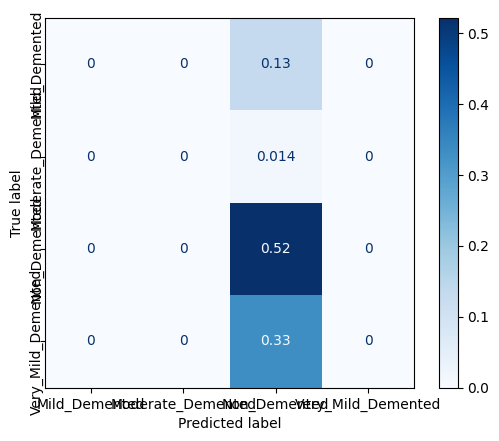

<Figure size 500x500 with 0 Axes>

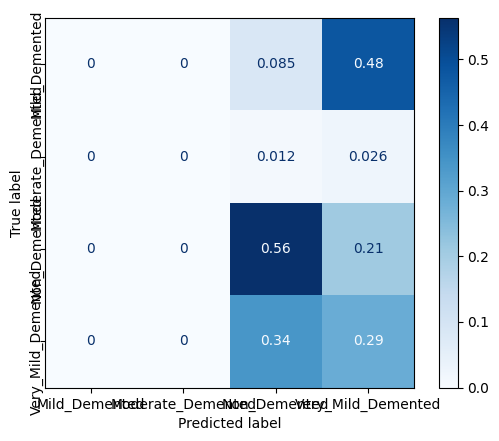

<Figure size 500x500 with 0 Axes>

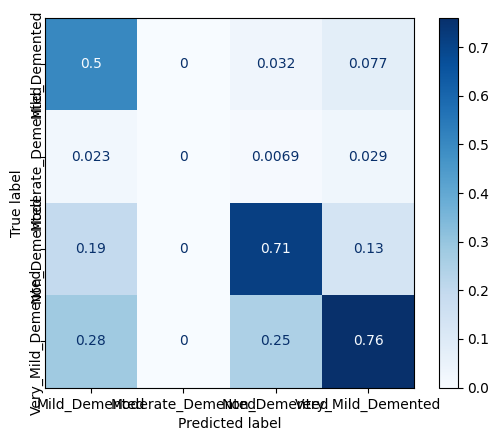

<Figure size 500x500 with 0 Axes>

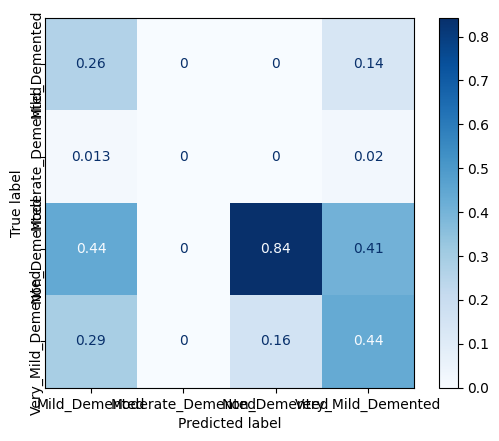

In [10]:
# experiments with Figshare
print('\nProcessing Alzihmers Dataset:')
print('--------------------------------')

train_ds, val_ds, test_ds, class_names = load(DATASET_DIR, IMAGE_SIZE, BATCH_SIZE, False)
experiments_with_dataset(train_ds, val_ds, test_ds, class_names)

In [ ]:
!zip -0 -r MobileNetV2.zip ./*